In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_data.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_data.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_MLB_Seaspm.csv")
height_df = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/player_heights.csv")

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
testing_data['description'].unique()

array(['hit_into_play', 'ball', 'foul_bunt', 'blocked_ball',
       'swinging_strike', 'foul', 'called_strike', 'foul_tip',
       'hit_by_pitch', 'swinging_strike_blocked', 'missed_bunt',
       'pitchout', 'bunt_foul_tip', 'unknown_strike'], dtype=object)

In [5]:

def preprocess_data(df, height_df):
    """
    This function takes a DataFrame and applies several preprocessing steps to it.
    """
    # Define a function to condense pitch types
    def condense_pitch_type(pitch_type):
        if pitch_type == "FF":
            return "FF"
        elif pitch_type == "FT":
            return "SI"
        elif pitch_type == "FC":
            return "CT"
        elif pitch_type in ["SL", "ST", "SV"]:
            return "SL"
        elif pitch_type in ["CH", "FS"]:
            return "CH"
        elif pitch_type in ["CU", "KC", "CS"]:
            return "CB"
        elif pitch_type == "SI":
            return "SI"
        elif pitch_type == "KN":
            return "KN"
        else:
            return "FAHCK"
    # Define a function to determine if the pitch resulted in a swing
    def is_swing(description):
        return 1 if description in ["swinging_strike", "swinging_strike_blocked", 
                                "missed_bunt", "swinging_pitchout", 
                                "foul_tip", "foul_bunt", "foul", 
                                "foul_pitchout", "hit_into_play", 
                                "hit_into_play_no_out", "hit_into_play_score", 
                                "pitchout_hit_into_play_score"] else 0
    
    def create_pitch_id(df):
        df['pitch_id_raw'] = (df['game_pk'].astype(str) + "_" +
                          df['batter'].astype(str) + "_" +
                          df['pitcher'].astype(str) + "_" +
                          df['pitch_number'].astype(str) + "_" +
                          df['at_bat_number'].astype(str) + "_" +
                          df['inning'].astype(str))
        return df

    df['pitch_type_condensed'] = df['pitch_type'].apply(condense_pitch_type)

    # Calculate 'release_pos_y'
    df['release_pos_y'] = 60.5 - df['release_extension']


    df['swing'] = df['description'].apply(is_swing)

    # Create 'pitch_id_raw'
    df = create_pitch_id(df)

    dfs = df.merge(height_df[['id', 'height_numeric']], how='left', left_on='pitcher', right_on='id')
    # Return the preprocessed DataFrame
    return dfs

In [6]:
# Apply the function to the 'pitch_type' column
training_data  = preprocess_data(data, height_df)# Use the query method to filter rows where 'swing' is 1 and 'pitch_type_condensed' is 'FF', 'SI', or 'CT'
testing_data_processed = preprocess_data(testing_data, height_df)


In [ ]:
fastball_training = training_data.query('pitch_type_condensed in ("FF", "SI", "CT")')
fastball_testing = testing_data_processed.query('pitch_type_condensed in ("FF", "SI", "CT")')
breaking_ball = training_data.query('pitch_type_condensed in ("SL", "CB")')
breaking_ball_testing = testing_data_processed.query('pitch_type_condensed in ("SL", "CB")')


# Fastball Model First

In [ ]:
# Now, separate features and identifiers
training_identifiers = fastball_training[['pitch_id_raw']]
testing_identifiers = fastball_testing[['pitch_id_raw']]
training_features = fastball_training.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z'
], axis=1)
testing_features = fastball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'Unnamed: 0'
], axis=1)   # Exclude the identifier from the features

In [ ]:
train_data = training_features.drop(['swing'], axis=1).copy()
train_label = training_features['swing'].copy()
testing_data = testing_features.drop(['swing'], axis=1).copy()
testing_label = testing_features['swing'].copy()

In [ ]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [ ]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [ ]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [ ]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [ ]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6962814142896672
Log Loss: 0.6032517034254566


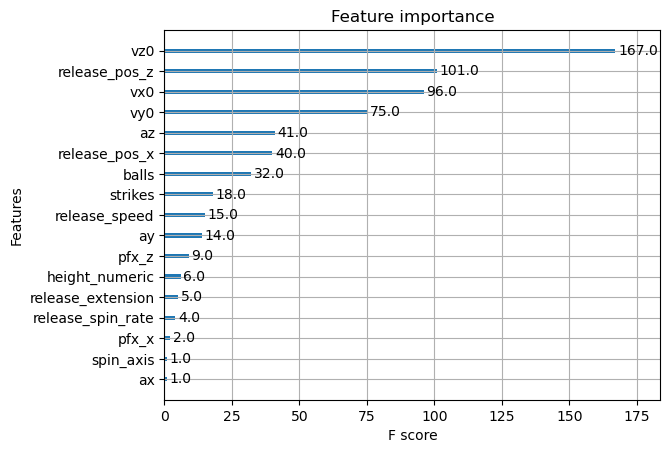

In [ ]:
xgb.plot_importance(model)
plt.show()

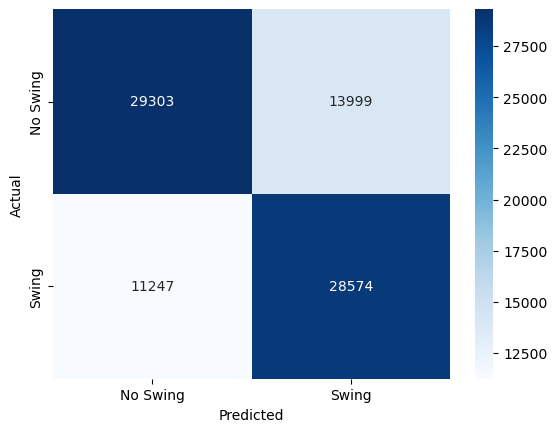

In [ ]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Swing', 'Swing'], yticklabels=['No Swing', 'Swing'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [ ]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [ ]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

[I 2023-11-09 15:06:10,448] A new study created in memory with name: no-name-b0203030-de4a-4446-b5cd-cae265a6c943


[0]	eval-logloss:0.67096
[1]	eval-logloss:0.65369
[2]	eval-logloss:0.62878
[3]	eval-logloss:0.61208
[4]	eval-logloss:0.60205
[5]	eval-logloss:0.58877
[6]	eval-logloss:0.57986
[7]	eval-logloss:0.57947
[8]	eval-logloss:0.57502
[9]	eval-logloss:0.57308
[10]	eval-logloss:0.56525
[11]	eval-logloss:0.56149
[12]	eval-logloss:0.55781
[13]	eval-logloss:0.55753
[14]	eval-logloss:0.55086
[15]	eval-logloss:0.54505
[16]	eval-logloss:0.53666
[17]	eval-logloss:0.53365
[18]	eval-logloss:0.53025
[19]	eval-logloss:0.52675
[20]	eval-logloss:0.52548
[21]	eval-logloss:0.52513
[22]	eval-logloss:0.52402
[23]	eval-logloss:0.51763
[24]	eval-logloss:0.51675
[25]	eval-logloss:0.51660
[26]	eval-logloss:0.51591
[27]	eval-logloss:0.51338
[28]	eval-logloss:0.51318
[29]	eval-logloss:0.51317
[30]	eval-logloss:0.50805
[31]	eval-logloss:0.50655
[32]	eval-logloss:0.50614
[33]	eval-logloss:0.50605
[34]	eval-logloss:0.50435
[35]	eval-logloss:0.50071
[36]	eval-logloss:0.50066
[37]	eval-logloss:0.50010
[38]	eval-logloss:0.49

[I 2023-11-09 15:06:19,396] Trial 0 finished with value: 0.46589839311650916 and parameters: {'max_depth': 8, 'eta': 0.21431249493215704, 'subsample': 0.7993421924668016, 'colsample_bytree': 0.5157857482756663}. Best is trial 0 with value: 0.46589839311650916.


[0]	eval-logloss:0.69173
[1]	eval-logloss:0.68979
[2]	eval-logloss:0.68830
[3]	eval-logloss:0.68690
[4]	eval-logloss:0.68566
[5]	eval-logloss:0.68391
[6]	eval-logloss:0.68222
[7]	eval-logloss:0.68150
[8]	eval-logloss:0.67982
[9]	eval-logloss:0.67817
[10]	eval-logloss:0.67656
[11]	eval-logloss:0.67517
[12]	eval-logloss:0.67369
[13]	eval-logloss:0.67249
[14]	eval-logloss:0.67106
[15]	eval-logloss:0.67000
[16]	eval-logloss:0.66871
[17]	eval-logloss:0.66731
[18]	eval-logloss:0.66628
[19]	eval-logloss:0.66520
[20]	eval-logloss:0.66437
[21]	eval-logloss:0.66350
[22]	eval-logloss:0.66226
[23]	eval-logloss:0.66163
[24]	eval-logloss:0.66055
[25]	eval-logloss:0.65988
[26]	eval-logloss:0.65881
[27]	eval-logloss:0.65766
[28]	eval-logloss:0.65706
[29]	eval-logloss:0.65632
[30]	eval-logloss:0.65572
[31]	eval-logloss:0.65465
[32]	eval-logloss:0.65358
[33]	eval-logloss:0.65254
[34]	eval-logloss:0.65151
[35]	eval-logloss:0.65078
[36]	eval-logloss:0.65054
[37]	eval-logloss:0.64968
[38]	eval-logloss:0.64

[I 2023-11-09 15:06:25,180] Trial 1 finished with value: 0.6159601714092315 and parameters: {'max_depth': 4, 'eta': 0.015524720811551526, 'subsample': 0.8723334955502398, 'colsample_bytree': 0.6485745925334622}. Best is trial 1 with value: 0.6159601714092315.


[0]	eval-logloss:0.68217
[1]	eval-logloss:0.66719
[2]	eval-logloss:0.65117
[3]	eval-logloss:0.64200
[4]	eval-logloss:0.63326
[5]	eval-logloss:0.62566
[6]	eval-logloss:0.62001
[7]	eval-logloss:0.61975
[8]	eval-logloss:0.61638
[9]	eval-logloss:0.61442
[10]	eval-logloss:0.61046
[11]	eval-logloss:0.60594
[12]	eval-logloss:0.60317
[13]	eval-logloss:0.60265
[14]	eval-logloss:0.59617
[15]	eval-logloss:0.59493
[16]	eval-logloss:0.59316
[17]	eval-logloss:0.59098
[18]	eval-logloss:0.58844
[19]	eval-logloss:0.58619
[20]	eval-logloss:0.58538
[21]	eval-logloss:0.58450
[22]	eval-logloss:0.58283
[23]	eval-logloss:0.57620
[24]	eval-logloss:0.57420
[25]	eval-logloss:0.57369
[26]	eval-logloss:0.57265
[27]	eval-logloss:0.57185
[28]	eval-logloss:0.57159
[29]	eval-logloss:0.57139
[30]	eval-logloss:0.56827
[31]	eval-logloss:0.56769
[32]	eval-logloss:0.56668
[33]	eval-logloss:0.56641
[34]	eval-logloss:0.56526
[35]	eval-logloss:0.56476
[36]	eval-logloss:0.56473
[37]	eval-logloss:0.56441
[38]	eval-logloss:0.56

[I 2023-11-09 15:06:29,635] Trial 2 finished with value: 0.5299922962392275 and parameters: {'max_depth': 3, 'eta': 0.2684470419404444, 'subsample': 0.7154086283779629, 'colsample_bytree': 0.5434776949105444}. Best is trial 1 with value: 0.6159601714092315.


[0]	eval-logloss:0.66819
[1]	eval-logloss:0.64833
[2]	eval-logloss:0.63513
[3]	eval-logloss:0.62256
[4]	eval-logloss:0.61181
[5]	eval-logloss:0.60251
[6]	eval-logloss:0.59449
[7]	eval-logloss:0.58778
[8]	eval-logloss:0.58261
[9]	eval-logloss:0.57690
[10]	eval-logloss:0.57262
[11]	eval-logloss:0.56878
[12]	eval-logloss:0.56565
[13]	eval-logloss:0.56130
[14]	eval-logloss:0.55669
[15]	eval-logloss:0.55376
[16]	eval-logloss:0.54995
[17]	eval-logloss:0.54659
[18]	eval-logloss:0.54376
[19]	eval-logloss:0.53853
[20]	eval-logloss:0.53666
[21]	eval-logloss:0.53393
[22]	eval-logloss:0.53199
[23]	eval-logloss:0.52909
[24]	eval-logloss:0.52764
[25]	eval-logloss:0.52411
[26]	eval-logloss:0.52316
[27]	eval-logloss:0.52178
[28]	eval-logloss:0.51898
[29]	eval-logloss:0.51751
[30]	eval-logloss:0.51492
[31]	eval-logloss:0.51409
[32]	eval-logloss:0.51262
[33]	eval-logloss:0.50808
[34]	eval-logloss:0.50620
[35]	eval-logloss:0.50535
[36]	eval-logloss:0.50392
[37]	eval-logloss:0.50248
[38]	eval-logloss:0.50

[I 2023-11-09 15:06:37,279] Trial 3 finished with value: 0.4626245018391672 and parameters: {'max_depth': 7, 'eta': 0.14825779493730012, 'subsample': 0.6790093019011672, 'colsample_bytree': 0.8740490830303188}. Best is trial 1 with value: 0.6159601714092315.


[0]	eval-logloss:0.66911
[1]	eval-logloss:0.65045
[2]	eval-logloss:0.62365
[3]	eval-logloss:0.60577
[4]	eval-logloss:0.59533
[5]	eval-logloss:0.58196
[6]	eval-logloss:0.57323
[7]	eval-logloss:0.57287
[8]	eval-logloss:0.56869
[9]	eval-logloss:0.56687
[10]	eval-logloss:0.55903
[11]	eval-logloss:0.55553
[12]	eval-logloss:0.55188
[13]	eval-logloss:0.55152
[14]	eval-logloss:0.54483
[15]	eval-logloss:0.53232
[16]	eval-logloss:0.52647
[17]	eval-logloss:0.52236
[18]	eval-logloss:0.51820
[19]	eval-logloss:0.51568
[20]	eval-logloss:0.51462
[21]	eval-logloss:0.51422
[22]	eval-logloss:0.51322
[23]	eval-logloss:0.50752
[24]	eval-logloss:0.50676
[25]	eval-logloss:0.50669
[26]	eval-logloss:0.50630
[27]	eval-logloss:0.50471
[28]	eval-logloss:0.50464
[29]	eval-logloss:0.50465
[30]	eval-logloss:0.50100
[31]	eval-logloss:0.49943
[32]	eval-logloss:0.49910
[33]	eval-logloss:0.49907
[34]	eval-logloss:0.49781
[35]	eval-logloss:0.49305
[36]	eval-logloss:0.49301
[37]	eval-logloss:0.49258
[38]	eval-logloss:0.49

[I 2023-11-09 15:06:45,359] Trial 4 finished with value: 0.46485695064863497 and parameters: {'max_depth': 8, 'eta': 0.23852160615205892, 'subsample': 0.7247467534876745, 'colsample_bytree': 0.5037648075493351}. Best is trial 1 with value: 0.6159601714092315.


[0]	eval-logloss:0.67990
[1]	eval-logloss:0.66809
[2]	eval-logloss:0.65829
[3]	eval-logloss:0.64849
[4]	eval-logloss:0.64023
[5]	eval-logloss:0.63275
[6]	eval-logloss:0.62525
[7]	eval-logloss:0.61914
[8]	eval-logloss:0.61360
[9]	eval-logloss:0.60780
[10]	eval-logloss:0.60223
[11]	eval-logloss:0.59798
[12]	eval-logloss:0.59357
[13]	eval-logloss:0.58906
[14]	eval-logloss:0.58438
[15]	eval-logloss:0.58010
[16]	eval-logloss:0.57602
[17]	eval-logloss:0.57254
[18]	eval-logloss:0.56871
[19]	eval-logloss:0.56547
[20]	eval-logloss:0.56309
[21]	eval-logloss:0.55987
[22]	eval-logloss:0.55673
[23]	eval-logloss:0.55399
[24]	eval-logloss:0.55182
[25]	eval-logloss:0.54915
[26]	eval-logloss:0.54771
[27]	eval-logloss:0.54586
[28]	eval-logloss:0.54249
[29]	eval-logloss:0.54065
[30]	eval-logloss:0.53855
[31]	eval-logloss:0.53687
[32]	eval-logloss:0.53521
[33]	eval-logloss:0.53315
[34]	eval-logloss:0.53138
[35]	eval-logloss:0.52928
[36]	eval-logloss:0.52779
[37]	eval-logloss:0.52625
[38]	eval-logloss:0.52

[I 2023-11-09 15:06:55,298] Trial 5 finished with value: 0.47464342082561395 and parameters: {'max_depth': 9, 'eta': 0.06432928924043962, 'subsample': 0.7774261470316453, 'colsample_bytree': 0.8510352071025311}. Best is trial 1 with value: 0.6159601714092315.


[0]	eval-logloss:0.67474
[1]	eval-logloss:0.65469
[2]	eval-logloss:0.63876
[3]	eval-logloss:0.62695
[4]	eval-logloss:0.61955
[5]	eval-logloss:0.60936
[6]	eval-logloss:0.59921
[7]	eval-logloss:0.59725
[8]	eval-logloss:0.58906
[9]	eval-logloss:0.58146
[10]	eval-logloss:0.57400
[11]	eval-logloss:0.57044
[12]	eval-logloss:0.56632
[13]	eval-logloss:0.56150
[14]	eval-logloss:0.55506
[15]	eval-logloss:0.55012
[16]	eval-logloss:0.54518
[17]	eval-logloss:0.54161
[18]	eval-logloss:0.53788
[19]	eval-logloss:0.53495
[20]	eval-logloss:0.53335
[21]	eval-logloss:0.53206
[22]	eval-logloss:0.52930
[23]	eval-logloss:0.52521
[24]	eval-logloss:0.52398
[25]	eval-logloss:0.52366
[26]	eval-logloss:0.52277
[27]	eval-logloss:0.52098
[28]	eval-logloss:0.51640
[29]	eval-logloss:0.51571
[30]	eval-logloss:0.51228
[31]	eval-logloss:0.51069
[32]	eval-logloss:0.50973
[33]	eval-logloss:0.50811
[34]	eval-logloss:0.50683
[35]	eval-logloss:0.50419
[36]	eval-logloss:0.50415
[37]	eval-logloss:0.50206
[38]	eval-logloss:0.50

[I 2023-11-09 15:07:04,977] Trial 6 finished with value: 0.4681338942346288 and parameters: {'max_depth': 9, 'eta': 0.11946198479076785, 'subsample': 0.715739040992409, 'colsample_bytree': 0.6466539288235927}. Best is trial 1 with value: 0.6159601714092315.


[0]	eval-logloss:0.66984
[1]	eval-logloss:0.65283
[2]	eval-logloss:0.64076
[3]	eval-logloss:0.62930
[4]	eval-logloss:0.62125
[5]	eval-logloss:0.61355
[6]	eval-logloss:0.60730
[7]	eval-logloss:0.60161
[8]	eval-logloss:0.59648
[9]	eval-logloss:0.59321
[10]	eval-logloss:0.58877
[11]	eval-logloss:0.58591
[12]	eval-logloss:0.58277
[13]	eval-logloss:0.57855
[14]	eval-logloss:0.57633
[15]	eval-logloss:0.57026
[16]	eval-logloss:0.56775
[17]	eval-logloss:0.56531
[18]	eval-logloss:0.56157
[19]	eval-logloss:0.55939
[20]	eval-logloss:0.55818
[21]	eval-logloss:0.55626
[22]	eval-logloss:0.55341
[23]	eval-logloss:0.54753
[24]	eval-logloss:0.54420
[25]	eval-logloss:0.54309
[26]	eval-logloss:0.54139
[27]	eval-logloss:0.54076
[28]	eval-logloss:0.53785
[29]	eval-logloss:0.53709
[30]	eval-logloss:0.53510
[31]	eval-logloss:0.53435
[32]	eval-logloss:0.53382
[33]	eval-logloss:0.53148
[34]	eval-logloss:0.52989
[35]	eval-logloss:0.52857
[36]	eval-logloss:0.52788
[37]	eval-logloss:0.52676
[38]	eval-logloss:0.52

[I 2023-11-09 15:07:11,407] Trial 7 finished with value: 0.4840747630922248 and parameters: {'max_depth': 5, 'eta': 0.1716765070460679, 'subsample': 0.8911556999296598, 'colsample_bytree': 0.9210116416099813}. Best is trial 1 with value: 0.6159601714092315.


[0]	eval-logloss:0.68325
[1]	eval-logloss:0.67094
[2]	eval-logloss:0.65710
[3]	eval-logloss:0.64786
[4]	eval-logloss:0.64035
[5]	eval-logloss:0.63075
[6]	eval-logloss:0.62359
[7]	eval-logloss:0.62335
[8]	eval-logloss:0.61952
[9]	eval-logloss:0.61715
[10]	eval-logloss:0.61122
[11]	eval-logloss:0.60688
[12]	eval-logloss:0.60288
[13]	eval-logloss:0.60233
[14]	eval-logloss:0.59623
[15]	eval-logloss:0.59416
[16]	eval-logloss:0.59093
[17]	eval-logloss:0.58767
[18]	eval-logloss:0.58473
[19]	eval-logloss:0.58275
[20]	eval-logloss:0.58133
[21]	eval-logloss:0.58054
[22]	eval-logloss:0.57853
[23]	eval-logloss:0.57350
[24]	eval-logloss:0.57189
[25]	eval-logloss:0.57136
[26]	eval-logloss:0.57015
[27]	eval-logloss:0.56900
[28]	eval-logloss:0.56883
[29]	eval-logloss:0.56867
[30]	eval-logloss:0.56555
[31]	eval-logloss:0.56441
[32]	eval-logloss:0.56387
[33]	eval-logloss:0.56369
[34]	eval-logloss:0.56132
[35]	eval-logloss:0.55622
[36]	eval-logloss:0.55611
[37]	eval-logloss:0.55511
[38]	eval-logloss:0.55

[I 2023-11-09 15:07:16,730] Trial 8 finished with value: 0.5218908547858688 and parameters: {'max_depth': 4, 'eta': 0.17864014406591297, 'subsample': 0.6501488410282465, 'colsample_bytree': 0.5269225828764345}. Best is trial 1 with value: 0.6159601714092315.


[0]	eval-logloss:0.65620
[1]	eval-logloss:0.62031
[2]	eval-logloss:0.59748
[3]	eval-logloss:0.58349
[4]	eval-logloss:0.57498
[5]	eval-logloss:0.56607
[6]	eval-logloss:0.55365
[7]	eval-logloss:0.55257
[8]	eval-logloss:0.54636
[9]	eval-logloss:0.54006
[10]	eval-logloss:0.53420
[11]	eval-logloss:0.53203
[12]	eval-logloss:0.52815
[13]	eval-logloss:0.52174
[14]	eval-logloss:0.51720
[15]	eval-logloss:0.51425
[16]	eval-logloss:0.50702
[17]	eval-logloss:0.50358
[18]	eval-logloss:0.50010
[19]	eval-logloss:0.49558
[20]	eval-logloss:0.49519
[21]	eval-logloss:0.49464
[22]	eval-logloss:0.49277
[23]	eval-logloss:0.48921
[24]	eval-logloss:0.48887
[25]	eval-logloss:0.48877
[26]	eval-logloss:0.48831
[27]	eval-logloss:0.48624
[28]	eval-logloss:0.48323
[29]	eval-logloss:0.48307
[30]	eval-logloss:0.47936
[31]	eval-logloss:0.47850
[32]	eval-logloss:0.47826
[33]	eval-logloss:0.47784
[34]	eval-logloss:0.47681
[35]	eval-logloss:0.47535
[36]	eval-logloss:0.47554
[37]	eval-logloss:0.47446
[38]	eval-logloss:0.47

[I 2023-11-09 15:07:24,522] Trial 9 finished with value: 0.46189094987424356 and parameters: {'max_depth': 8, 'eta': 0.2838268044835916, 'subsample': 0.6135631096475778, 'colsample_bytree': 0.6324622863711968}. Best is trial 1 with value: 0.6159601714092315.


[0]	eval-logloss:0.68973
[1]	eval-logloss:0.68642
[2]	eval-logloss:0.68390
[3]	eval-logloss:0.68081
[4]	eval-logloss:0.67789
[5]	eval-logloss:0.67500
[6]	eval-logloss:0.67228
[7]	eval-logloss:0.66962
[8]	eval-logloss:0.66719
[9]	eval-logloss:0.66482
[10]	eval-logloss:0.66246
[11]	eval-logloss:0.66011
[12]	eval-logloss:0.65796
[13]	eval-logloss:0.65625
[14]	eval-logloss:0.65405
[15]	eval-logloss:0.65197
[16]	eval-logloss:0.64998
[17]	eval-logloss:0.64811
[18]	eval-logloss:0.64638
[19]	eval-logloss:0.64451
[20]	eval-logloss:0.64280
[21]	eval-logloss:0.64109
[22]	eval-logloss:0.63949
[23]	eval-logloss:0.63810
[24]	eval-logloss:0.63655
[25]	eval-logloss:0.63502
[26]	eval-logloss:0.63361
[27]	eval-logloss:0.63226
[28]	eval-logloss:0.63094
[29]	eval-logloss:0.62954
[30]	eval-logloss:0.62832
[31]	eval-logloss:0.62701
[32]	eval-logloss:0.62572
[33]	eval-logloss:0.62449
[34]	eval-logloss:0.62342
[35]	eval-logloss:0.62231
[36]	eval-logloss:0.62122
[37]	eval-logloss:0.62014
[38]	eval-logloss:0.61

[I 2023-11-09 15:07:30,321] Trial 10 finished with value: 0.5802790014551132 and parameters: {'max_depth': 5, 'eta': 0.02348492557827414, 'subsample': 0.898837402942641, 'colsample_bytree': 0.9989339972615376}. Best is trial 1 with value: 0.6159601714092315.


[0]	eval-logloss:0.69028
[1]	eval-logloss:0.68749
[2]	eval-logloss:0.68535
[3]	eval-logloss:0.68272
[4]	eval-logloss:0.68024
[5]	eval-logloss:0.67775
[6]	eval-logloss:0.67538
[7]	eval-logloss:0.67305
[8]	eval-logloss:0.67091
[9]	eval-logloss:0.66881
[10]	eval-logloss:0.66670
[11]	eval-logloss:0.66461
[12]	eval-logloss:0.66268
[13]	eval-logloss:0.66112
[14]	eval-logloss:0.65920
[15]	eval-logloss:0.65745
[16]	eval-logloss:0.65562
[17]	eval-logloss:0.65391
[18]	eval-logloss:0.65219
[19]	eval-logloss:0.65053
[20]	eval-logloss:0.64890
[21]	eval-logloss:0.64734
[22]	eval-logloss:0.64582
[23]	eval-logloss:0.64459
[24]	eval-logloss:0.64314
[25]	eval-logloss:0.64174
[26]	eval-logloss:0.64046
[27]	eval-logloss:0.63918
[28]	eval-logloss:0.63777
[29]	eval-logloss:0.63643
[30]	eval-logloss:0.63529
[31]	eval-logloss:0.63411
[32]	eval-logloss:0.63287
[33]	eval-logloss:0.63173
[34]	eval-logloss:0.63045
[35]	eval-logloss:0.62934
[36]	eval-logloss:0.62826
[37]	eval-logloss:0.62718
[38]	eval-logloss:0.62

[I 2023-11-09 15:07:36,494] Trial 11 finished with value: 0.5886189269135089 and parameters: {'max_depth': 5, 'eta': 0.019635589963894452, 'subsample': 0.89855784192219, 'colsample_bytree': 0.9899753488976026}. Best is trial 1 with value: 0.6159601714092315.


[0]	eval-logloss:0.69014
[1]	eval-logloss:0.68724
[2]	eval-logloss:0.68500
[3]	eval-logloss:0.68219
[4]	eval-logloss:0.67957
[5]	eval-logloss:0.67713
[6]	eval-logloss:0.67475
[7]	eval-logloss:0.67258
[8]	eval-logloss:0.67042
[9]	eval-logloss:0.66818
[10]	eval-logloss:0.66597
[11]	eval-logloss:0.66405
[12]	eval-logloss:0.66210
[13]	eval-logloss:0.66050
[14]	eval-logloss:0.65855
[15]	eval-logloss:0.65718
[16]	eval-logloss:0.65536
[17]	eval-logloss:0.65349
[18]	eval-logloss:0.65185
[19]	eval-logloss:0.65040
[20]	eval-logloss:0.64933
[21]	eval-logloss:0.64825
[22]	eval-logloss:0.64662
[23]	eval-logloss:0.64522
[24]	eval-logloss:0.64371
[25]	eval-logloss:0.64296
[26]	eval-logloss:0.64168
[27]	eval-logloss:0.64028
[28]	eval-logloss:0.63924
[29]	eval-logloss:0.63827
[30]	eval-logloss:0.63729
[31]	eval-logloss:0.63599
[32]	eval-logloss:0.63467
[33]	eval-logloss:0.63332
[34]	eval-logloss:0.63206
[35]	eval-logloss:0.63076
[36]	eval-logloss:0.62987
[37]	eval-logloss:0.62867
[38]	eval-logloss:0.62

[I 2023-11-09 15:07:42,505] Trial 12 finished with value: 0.5868384051887918 and parameters: {'max_depth': 5, 'eta': 0.02070455143383071, 'subsample': 0.8466730344276996, 'colsample_bytree': 0.768382497307761}. Best is trial 1 with value: 0.6159601714092315.


[0]	eval-logloss:0.68584
[1]	eval-logloss:0.67947
[2]	eval-logloss:0.67522
[3]	eval-logloss:0.67008
[4]	eval-logloss:0.66550
[5]	eval-logloss:0.66147
[6]	eval-logloss:0.65778
[7]	eval-logloss:0.65454
[8]	eval-logloss:0.65165
[9]	eval-logloss:0.64864
[10]	eval-logloss:0.64584
[11]	eval-logloss:0.64309
[12]	eval-logloss:0.64098
[13]	eval-logloss:0.63917
[14]	eval-logloss:0.63738
[15]	eval-logloss:0.63575
[16]	eval-logloss:0.63393
[17]	eval-logloss:0.63197
[18]	eval-logloss:0.63018
[19]	eval-logloss:0.62873
[20]	eval-logloss:0.62748
[21]	eval-logloss:0.62631
[22]	eval-logloss:0.62523
[23]	eval-logloss:0.62390
[24]	eval-logloss:0.62270
[25]	eval-logloss:0.62203
[26]	eval-logloss:0.62091
[27]	eval-logloss:0.61936
[28]	eval-logloss:0.61822
[29]	eval-logloss:0.61666
[30]	eval-logloss:0.61482
[31]	eval-logloss:0.61274
[32]	eval-logloss:0.61199
[33]	eval-logloss:0.61006
[34]	eval-logloss:0.60919
[35]	eval-logloss:0.60781
[36]	eval-logloss:0.60705
[37]	eval-logloss:0.60625
[38]	eval-logloss:0.60

[I 2023-11-09 15:07:47,211] Trial 13 finished with value: 0.5654813730738744 and parameters: {'max_depth': 3, 'eta': 0.07551767782096597, 'subsample': 0.838984981862405, 'colsample_bytree': 0.7440779426604731}. Best is trial 1 with value: 0.6159601714092315.


[0]	eval-logloss:0.69094
[1]	eval-logloss:0.68874
[2]	eval-logloss:0.68705
[3]	eval-logloss:0.68493
[4]	eval-logloss:0.68293
[5]	eval-logloss:0.68090
[6]	eval-logloss:0.67896
[7]	eval-logloss:0.67704
[8]	eval-logloss:0.67528
[9]	eval-logloss:0.67347
[10]	eval-logloss:0.67164
[11]	eval-logloss:0.66987
[12]	eval-logloss:0.66812
[13]	eval-logloss:0.66675
[14]	eval-logloss:0.66514
[15]	eval-logloss:0.66351
[16]	eval-logloss:0.66192
[17]	eval-logloss:0.66033
[18]	eval-logloss:0.65888
[19]	eval-logloss:0.65736
[20]	eval-logloss:0.65587
[21]	eval-logloss:0.65448
[22]	eval-logloss:0.65306
[23]	eval-logloss:0.65182
[24]	eval-logloss:0.65048
[25]	eval-logloss:0.64912
[26]	eval-logloss:0.64795
[27]	eval-logloss:0.64669
[28]	eval-logloss:0.64551
[29]	eval-logloss:0.64425
[30]	eval-logloss:0.64300
[31]	eval-logloss:0.64179
[32]	eval-logloss:0.64058
[33]	eval-logloss:0.63941
[34]	eval-logloss:0.63825
[35]	eval-logloss:0.63711
[36]	eval-logloss:0.63599
[37]	eval-logloss:0.63490
[38]	eval-logloss:0.63

[I 2023-11-09 15:07:54,233] Trial 14 finished with value: 0.5909737170665422 and parameters: {'max_depth': 6, 'eta': 0.013350688325281017, 'subsample': 0.8490835102738162, 'colsample_bytree': 0.9666644335631389}. Best is trial 1 with value: 0.6159601714092315.


[0]	eval-logloss:0.68243
[1]	eval-logloss:0.67305
[2]	eval-logloss:0.66589
[3]	eval-logloss:0.65780
[4]	eval-logloss:0.65060
[5]	eval-logloss:0.64480
[6]	eval-logloss:0.63925
[7]	eval-logloss:0.63406
[8]	eval-logloss:0.62898
[9]	eval-logloss:0.62477
[10]	eval-logloss:0.62025
[11]	eval-logloss:0.61644
[12]	eval-logloss:0.61312
[13]	eval-logloss:0.60954
[14]	eval-logloss:0.60608
[15]	eval-logloss:0.60329
[16]	eval-logloss:0.59969
[17]	eval-logloss:0.59643
[18]	eval-logloss:0.59322
[19]	eval-logloss:0.59051
[20]	eval-logloss:0.58882
[21]	eval-logloss:0.58755
[22]	eval-logloss:0.58518
[23]	eval-logloss:0.58336
[24]	eval-logloss:0.58138
[25]	eval-logloss:0.58068
[26]	eval-logloss:0.57931
[27]	eval-logloss:0.57751
[28]	eval-logloss:0.57538
[29]	eval-logloss:0.57422
[30]	eval-logloss:0.57248
[31]	eval-logloss:0.57090
[32]	eval-logloss:0.56969
[33]	eval-logloss:0.56808
[34]	eval-logloss:0.56679
[35]	eval-logloss:0.56522
[36]	eval-logloss:0.56316
[37]	eval-logloss:0.56172
[38]	eval-logloss:0.55

[I 2023-11-09 15:08:01,322] Trial 15 finished with value: 0.5126513999506831 and parameters: {'max_depth': 6, 'eta': 0.06704185089172846, 'subsample': 0.8358265535478835, 'colsample_bytree': 0.7644824774427349}. Best is trial 1 with value: 0.6159601714092315.


[0]	eval-logloss:0.68230
[1]	eval-logloss:0.66779
[2]	eval-logloss:0.65708
[3]	eval-logloss:0.64780
[4]	eval-logloss:0.64137
[5]	eval-logloss:0.63289
[6]	eval-logloss:0.62545
[7]	eval-logloss:0.62343
[8]	eval-logloss:0.61756
[9]	eval-logloss:0.61052
[10]	eval-logloss:0.60456
[11]	eval-logloss:0.60095
[12]	eval-logloss:0.59785
[13]	eval-logloss:0.59358
[14]	eval-logloss:0.58908
[15]	eval-logloss:0.58589
[16]	eval-logloss:0.58283
[17]	eval-logloss:0.57986
[18]	eval-logloss:0.57605
[19]	eval-logloss:0.57402
[20]	eval-logloss:0.57231
[21]	eval-logloss:0.57123
[22]	eval-logloss:0.56819
[23]	eval-logloss:0.56540
[24]	eval-logloss:0.56245
[25]	eval-logloss:0.56188
[26]	eval-logloss:0.56036
[27]	eval-logloss:0.55821
[28]	eval-logloss:0.55480
[29]	eval-logloss:0.55399
[30]	eval-logloss:0.55116
[31]	eval-logloss:0.54988
[32]	eval-logloss:0.54825
[33]	eval-logloss:0.54683
[34]	eval-logloss:0.54447
[35]	eval-logloss:0.54263
[36]	eval-logloss:0.54152
[37]	eval-logloss:0.54022
[38]	eval-logloss:0.53

[I 2023-11-09 15:08:07,875] Trial 16 finished with value: 0.49258950933287193 and parameters: {'max_depth': 6, 'eta': 0.10405810097140336, 'subsample': 0.7881077311499718, 'colsample_bytree': 0.6847955787280615}. Best is trial 1 with value: 0.6159601714092315.


[0]	eval-logloss:0.69158
[1]	eval-logloss:0.69005
[2]	eval-logloss:0.68886
[3]	eval-logloss:0.68737
[4]	eval-logloss:0.68593
[5]	eval-logloss:0.68455
[6]	eval-logloss:0.68319
[7]	eval-logloss:0.68192
[8]	eval-logloss:0.68061
[9]	eval-logloss:0.67930
[10]	eval-logloss:0.67799
[11]	eval-logloss:0.67680
[12]	eval-logloss:0.67559
[13]	eval-logloss:0.67464
[14]	eval-logloss:0.67344
[15]	eval-logloss:0.67254
[16]	eval-logloss:0.67141
[17]	eval-logloss:0.67026
[18]	eval-logloss:0.66917
[19]	eval-logloss:0.66827
[20]	eval-logloss:0.66721
[21]	eval-logloss:0.66639
[22]	eval-logloss:0.66534
[23]	eval-logloss:0.66450
[24]	eval-logloss:0.66355
[25]	eval-logloss:0.66296
[26]	eval-logloss:0.66206
[27]	eval-logloss:0.66110
[28]	eval-logloss:0.66056
[29]	eval-logloss:0.65963
[30]	eval-logloss:0.65910
[31]	eval-logloss:0.65823
[32]	eval-logloss:0.65734
[33]	eval-logloss:0.65646
[34]	eval-logloss:0.65561
[35]	eval-logloss:0.65471
[36]	eval-logloss:0.65418
[37]	eval-logloss:0.65335
[38]	eval-logloss:0.65

[I 2023-11-09 15:08:13,182] Trial 17 finished with value: 0.6212822660766688 and parameters: {'max_depth': 4, 'eta': 0.012346384607208966, 'subsample': 0.8584094632872467, 'colsample_bytree': 0.8245083730280489}. Best is trial 17 with value: 0.6212822660766688.


[0]	eval-logloss:0.68713
[1]	eval-logloss:0.68161
[2]	eval-logloss:0.67752
[3]	eval-logloss:0.67263
[4]	eval-logloss:0.66828
[5]	eval-logloss:0.66425
[6]	eval-logloss:0.66049
[7]	eval-logloss:0.65705
[8]	eval-logloss:0.65383
[9]	eval-logloss:0.65060
[10]	eval-logloss:0.64755
[11]	eval-logloss:0.64486
[12]	eval-logloss:0.64236
[13]	eval-logloss:0.64020
[14]	eval-logloss:0.63802
[15]	eval-logloss:0.63628
[16]	eval-logloss:0.63409
[17]	eval-logloss:0.63197
[18]	eval-logloss:0.62989
[19]	eval-logloss:0.62827
[20]	eval-logloss:0.62667
[21]	eval-logloss:0.62537
[22]	eval-logloss:0.62373
[23]	eval-logloss:0.62235
[24]	eval-logloss:0.62109
[25]	eval-logloss:0.62028
[26]	eval-logloss:0.61898
[27]	eval-logloss:0.61778
[28]	eval-logloss:0.61663
[29]	eval-logloss:0.61527
[30]	eval-logloss:0.61434
[31]	eval-logloss:0.61320
[32]	eval-logloss:0.61213
[33]	eval-logloss:0.61110
[34]	eval-logloss:0.61030
[35]	eval-logloss:0.60903
[36]	eval-logloss:0.60771
[37]	eval-logloss:0.60633
[38]	eval-logloss:0.60

[I 2023-11-09 15:08:18,594] Trial 18 finished with value: 0.5638825535806418 and parameters: {'max_depth': 4, 'eta': 0.04844387178127915, 'subsample': 0.8639119349854758, 'colsample_bytree': 0.8159535121409052}. Best is trial 17 with value: 0.6212822660766688.


[0]	eval-logloss:0.68883
[1]	eval-logloss:0.68313
[2]	eval-logloss:0.67887
[3]	eval-logloss:0.67499
[4]	eval-logloss:0.67175
[5]	eval-logloss:0.66736
[6]	eval-logloss:0.66327
[7]	eval-logloss:0.66165
[8]	eval-logloss:0.65803
[9]	eval-logloss:0.65450
[10]	eval-logloss:0.65104
[11]	eval-logloss:0.64826
[12]	eval-logloss:0.64548
[13]	eval-logloss:0.64321
[14]	eval-logloss:0.64071
[15]	eval-logloss:0.63901
[16]	eval-logloss:0.63684
[17]	eval-logloss:0.63469
[18]	eval-logloss:0.63264
[19]	eval-logloss:0.63082
[20]	eval-logloss:0.62960
[21]	eval-logloss:0.62833
[22]	eval-logloss:0.62638
[23]	eval-logloss:0.62516
[24]	eval-logloss:0.62367
[25]	eval-logloss:0.62285
[26]	eval-logloss:0.62144
[27]	eval-logloss:0.62000
[28]	eval-logloss:0.61850
[29]	eval-logloss:0.61772
[30]	eval-logloss:0.61626
[31]	eval-logloss:0.61490
[32]	eval-logloss:0.61351
[33]	eval-logloss:0.61228
[34]	eval-logloss:0.61094
[35]	eval-logloss:0.60978
[36]	eval-logloss:0.60876
[37]	eval-logloss:0.60804
[38]	eval-logloss:0.60

[I 2023-11-09 15:08:23,544] Trial 19 finished with value: 0.5682979650370743 and parameters: {'max_depth': 4, 'eta': 0.048264619596981376, 'subsample': 0.8036712540064154, 'colsample_bytree': 0.708457081496458}. Best is trial 17 with value: 0.6212822660766688.


[0]	eval-logloss:0.68313
[1]	eval-logloss:0.67501
[2]	eval-logloss:0.66954
[3]	eval-logloss:0.66329
[4]	eval-logloss:0.65814
[5]	eval-logloss:0.65359
[6]	eval-logloss:0.64962
[7]	eval-logloss:0.64643
[8]	eval-logloss:0.64318
[9]	eval-logloss:0.63998
[10]	eval-logloss:0.63694
[11]	eval-logloss:0.63390
[12]	eval-logloss:0.63166
[13]	eval-logloss:0.62972
[14]	eval-logloss:0.62741
[15]	eval-logloss:0.62534
[16]	eval-logloss:0.62381
[17]	eval-logloss:0.62241
[18]	eval-logloss:0.61922
[19]	eval-logloss:0.61792
[20]	eval-logloss:0.61611
[21]	eval-logloss:0.61480
[22]	eval-logloss:0.61346
[23]	eval-logloss:0.61258
[24]	eval-logloss:0.61042
[25]	eval-logloss:0.60944
[26]	eval-logloss:0.60829
[27]	eval-logloss:0.60651
[28]	eval-logloss:0.60468
[29]	eval-logloss:0.60323
[30]	eval-logloss:0.60126
[31]	eval-logloss:0.60055
[32]	eval-logloss:0.59884
[33]	eval-logloss:0.59820
[34]	eval-logloss:0.59737
[35]	eval-logloss:0.59643
[36]	eval-logloss:0.59407
[37]	eval-logloss:0.59331
[38]	eval-logloss:0.59

[I 2023-11-09 15:08:28,380] Trial 20 finished with value: 0.5541648010994106 and parameters: {'max_depth': 3, 'eta': 0.10426667549496035, 'subsample': 0.7667127764603126, 'colsample_bytree': 0.814593045878279}. Best is trial 17 with value: 0.6212822660766688.


[0]	eval-logloss:0.69184
[1]	eval-logloss:0.69054
[2]	eval-logloss:0.68955
[3]	eval-logloss:0.68830
[4]	eval-logloss:0.68707
[5]	eval-logloss:0.68585
[6]	eval-logloss:0.68466
[7]	eval-logloss:0.68350
[8]	eval-logloss:0.68236
[9]	eval-logloss:0.68124
[10]	eval-logloss:0.68012
[11]	eval-logloss:0.67905
[12]	eval-logloss:0.67797
[13]	eval-logloss:0.67713
[14]	eval-logloss:0.67609
[15]	eval-logloss:0.67509
[16]	eval-logloss:0.67410
[17]	eval-logloss:0.67310
[18]	eval-logloss:0.67215
[19]	eval-logloss:0.67122
[20]	eval-logloss:0.67029
[21]	eval-logloss:0.66939
[22]	eval-logloss:0.66847
[23]	eval-logloss:0.66773
[24]	eval-logloss:0.66687
[25]	eval-logloss:0.66599
[26]	eval-logloss:0.66516
[27]	eval-logloss:0.66429
[28]	eval-logloss:0.66361
[29]	eval-logloss:0.66279
[30]	eval-logloss:0.66211
[31]	eval-logloss:0.66135
[32]	eval-logloss:0.66054
[33]	eval-logloss:0.65976
[34]	eval-logloss:0.65902
[35]	eval-logloss:0.65823
[36]	eval-logloss:0.65753
[37]	eval-logloss:0.65681
[38]	eval-logloss:0.65

[I 2023-11-09 15:08:33,657] Trial 21 finished with value: 0.6266966066700258 and parameters: {'max_depth': 4, 'eta': 0.010340901557737125, 'subsample': 0.8674583480647353, 'colsample_bytree': 0.9349945836784831}. Best is trial 21 with value: 0.6266966066700258.


[0]	eval-logloss:0.68809
[1]	eval-logloss:0.68338
[2]	eval-logloss:0.67986
[3]	eval-logloss:0.67563
[4]	eval-logloss:0.67179
[5]	eval-logloss:0.66807
[6]	eval-logloss:0.66455
[7]	eval-logloss:0.66141
[8]	eval-logloss:0.65833
[9]	eval-logloss:0.65549
[10]	eval-logloss:0.65268
[11]	eval-logloss:0.65012
[12]	eval-logloss:0.64777
[13]	eval-logloss:0.64575
[14]	eval-logloss:0.64345
[15]	eval-logloss:0.64142
[16]	eval-logloss:0.63945
[17]	eval-logloss:0.63747
[18]	eval-logloss:0.63566
[19]	eval-logloss:0.63410
[20]	eval-logloss:0.63258
[21]	eval-logloss:0.63077
[22]	eval-logloss:0.62942
[23]	eval-logloss:0.62805
[24]	eval-logloss:0.62659
[25]	eval-logloss:0.62532
[26]	eval-logloss:0.62397
[27]	eval-logloss:0.62291
[28]	eval-logloss:0.62158
[29]	eval-logloss:0.62032
[30]	eval-logloss:0.61925
[31]	eval-logloss:0.61827
[32]	eval-logloss:0.61723
[33]	eval-logloss:0.61584
[34]	eval-logloss:0.61446
[35]	eval-logloss:0.61314
[36]	eval-logloss:0.61195
[37]	eval-logloss:0.61114
[38]	eval-logloss:0.61

[I 2023-11-09 15:08:39,030] Trial 22 finished with value: 0.5707725637472892 and parameters: {'max_depth': 4, 'eta': 0.04056589418304993, 'subsample': 0.8711533399243184, 'colsample_bytree': 0.9127534074536816}. Best is trial 21 with value: 0.6266966066700258.


[0]	eval-logloss:0.69165
[1]	eval-logloss:0.69017
[2]	eval-logloss:0.68904
[3]	eval-logloss:0.68760
[4]	eval-logloss:0.68621
[5]	eval-logloss:0.68483
[6]	eval-logloss:0.68349
[7]	eval-logloss:0.68220
[8]	eval-logloss:0.68094
[9]	eval-logloss:0.67969
[10]	eval-logloss:0.67843
[11]	eval-logloss:0.67723
[12]	eval-logloss:0.67603
[13]	eval-logloss:0.67511
[14]	eval-logloss:0.67399
[15]	eval-logloss:0.67288
[16]	eval-logloss:0.67179
[17]	eval-logloss:0.67069
[18]	eval-logloss:0.66965
[19]	eval-logloss:0.66863
[20]	eval-logloss:0.66761
[21]	eval-logloss:0.66660
[22]	eval-logloss:0.66559
[23]	eval-logloss:0.66479
[24]	eval-logloss:0.66386
[25]	eval-logloss:0.66289
[26]	eval-logloss:0.66199
[27]	eval-logloss:0.66106
[28]	eval-logloss:0.66031
[29]	eval-logloss:0.65941
[30]	eval-logloss:0.65868
[31]	eval-logloss:0.65786
[32]	eval-logloss:0.65700
[33]	eval-logloss:0.65617
[34]	eval-logloss:0.65533
[35]	eval-logloss:0.65450
[36]	eval-logloss:0.65375
[37]	eval-logloss:0.65299
[38]	eval-logloss:0.65

[I 2023-11-09 15:08:44,524] Trial 23 finished with value: 0.6217444641562022 and parameters: {'max_depth': 4, 'eta': 0.011851650340038905, 'subsample': 0.8277921685275137, 'colsample_bytree': 0.9353008943423403}. Best is trial 21 with value: 0.6266966066700258.


[0]	eval-logloss:0.68901
[1]	eval-logloss:0.68518
[2]	eval-logloss:0.68247
[3]	eval-logloss:0.67903
[4]	eval-logloss:0.67594
[5]	eval-logloss:0.67297
[6]	eval-logloss:0.67020
[7]	eval-logloss:0.66767
[8]	eval-logloss:0.66535
[9]	eval-logloss:0.66307
[10]	eval-logloss:0.66087
[11]	eval-logloss:0.65886
[12]	eval-logloss:0.65685
[13]	eval-logloss:0.65525
[14]	eval-logloss:0.65353
[15]	eval-logloss:0.65175
[16]	eval-logloss:0.65015
[17]	eval-logloss:0.64859
[18]	eval-logloss:0.64714
[19]	eval-logloss:0.64550
[20]	eval-logloss:0.64423
[21]	eval-logloss:0.64298
[22]	eval-logloss:0.64175
[23]	eval-logloss:0.64060
[24]	eval-logloss:0.63930
[25]	eval-logloss:0.63813
[26]	eval-logloss:0.63688
[27]	eval-logloss:0.63593
[28]	eval-logloss:0.63499
[29]	eval-logloss:0.63404
[30]	eval-logloss:0.63316
[31]	eval-logloss:0.63214
[32]	eval-logloss:0.63103
[33]	eval-logloss:0.63023
[34]	eval-logloss:0.62934
[35]	eval-logloss:0.62856
[36]	eval-logloss:0.62785
[37]	eval-logloss:0.62715
[38]	eval-logloss:0.62

[I 2023-11-09 15:08:49,069] Trial 24 finished with value: 0.5908121744729808 and parameters: {'max_depth': 3, 'eta': 0.04221799127350223, 'subsample': 0.8198521633122987, 'colsample_bytree': 0.937256408439162}. Best is trial 21 with value: 0.6266966066700258.


[0]	eval-logloss:0.68188
[1]	eval-logloss:0.67180
[2]	eval-logloss:0.66476
[3]	eval-logloss:0.65699
[4]	eval-logloss:0.64984
[5]	eval-logloss:0.64362
[6]	eval-logloss:0.63748
[7]	eval-logloss:0.63308
[8]	eval-logloss:0.62903
[9]	eval-logloss:0.62469
[10]	eval-logloss:0.62066
[11]	eval-logloss:0.61776
[12]	eval-logloss:0.61490
[13]	eval-logloss:0.61212
[14]	eval-logloss:0.60875
[15]	eval-logloss:0.60683
[16]	eval-logloss:0.60373
[17]	eval-logloss:0.60094
[18]	eval-logloss:0.59843
[19]	eval-logloss:0.59650
[20]	eval-logloss:0.59509
[21]	eval-logloss:0.59363
[22]	eval-logloss:0.59136
[23]	eval-logloss:0.58978
[24]	eval-logloss:0.58801
[25]	eval-logloss:0.58598
[26]	eval-logloss:0.58460
[27]	eval-logloss:0.58341
[28]	eval-logloss:0.58192
[29]	eval-logloss:0.58029
[30]	eval-logloss:0.57891
[31]	eval-logloss:0.57777
[32]	eval-logloss:0.57695
[33]	eval-logloss:0.57460
[34]	eval-logloss:0.57347
[35]	eval-logloss:0.57211
[36]	eval-logloss:0.56932
[37]	eval-logloss:0.56845
[38]	eval-logloss:0.56

[I 2023-11-09 15:08:54,720] Trial 25 finished with value: 0.5190165931577427 and parameters: {'max_depth': 5, 'eta': 0.08021525354765034, 'subsample': 0.8164710437040182, 'colsample_bytree': 0.8790863034168126}. Best is trial 21 with value: 0.6266966066700258.


[0]	eval-logloss:0.68760
[1]	eval-logloss:0.68246
[2]	eval-logloss:0.67864
[3]	eval-logloss:0.67403
[4]	eval-logloss:0.66987
[5]	eval-logloss:0.66595
[6]	eval-logloss:0.66222
[7]	eval-logloss:0.65891
[8]	eval-logloss:0.65570
[9]	eval-logloss:0.65268
[10]	eval-logloss:0.64991
[11]	eval-logloss:0.64717
[12]	eval-logloss:0.64467
[13]	eval-logloss:0.64265
[14]	eval-logloss:0.64034
[15]	eval-logloss:0.63835
[16]	eval-logloss:0.63631
[17]	eval-logloss:0.63444
[18]	eval-logloss:0.63247
[19]	eval-logloss:0.63080
[20]	eval-logloss:0.62906
[21]	eval-logloss:0.62725
[22]	eval-logloss:0.62594
[23]	eval-logloss:0.62452
[24]	eval-logloss:0.62303
[25]	eval-logloss:0.62187
[26]	eval-logloss:0.62053
[27]	eval-logloss:0.61944
[28]	eval-logloss:0.61803
[29]	eval-logloss:0.61693
[30]	eval-logloss:0.61576
[31]	eval-logloss:0.61463
[32]	eval-logloss:0.61351
[33]	eval-logloss:0.61271
[34]	eval-logloss:0.61119
[35]	eval-logloss:0.61003
[36]	eval-logloss:0.60926
[37]	eval-logloss:0.60844
[38]	eval-logloss:0.60

[I 2023-11-09 15:08:59,843] Trial 26 finished with value: 0.5657795373279417 and parameters: {'max_depth': 4, 'eta': 0.04467928654309058, 'subsample': 0.8219917575536795, 'colsample_bytree': 0.9570782237264346}. Best is trial 21 with value: 0.6266966066700258.


[0]	eval-logloss:0.69191
[1]	eval-logloss:0.69070
[2]	eval-logloss:0.68978
[3]	eval-logloss:0.68861
[4]	eval-logloss:0.68749
[5]	eval-logloss:0.68637
[6]	eval-logloss:0.68529
[7]	eval-logloss:0.68423
[8]	eval-logloss:0.68321
[9]	eval-logloss:0.68219
[10]	eval-logloss:0.68118
[11]	eval-logloss:0.68022
[12]	eval-logloss:0.67927
[13]	eval-logloss:0.67853
[14]	eval-logloss:0.67761
[15]	eval-logloss:0.67673
[16]	eval-logloss:0.67585
[17]	eval-logloss:0.67497
[18]	eval-logloss:0.67413
[19]	eval-logloss:0.67333
[20]	eval-logloss:0.67250
[21]	eval-logloss:0.67173
[22]	eval-logloss:0.67094
[23]	eval-logloss:0.67030
[24]	eval-logloss:0.66956
[25]	eval-logloss:0.66879
[26]	eval-logloss:0.66807
[27]	eval-logloss:0.66735
[28]	eval-logloss:0.66677
[29]	eval-logloss:0.66607
[30]	eval-logloss:0.66550
[31]	eval-logloss:0.66484
[32]	eval-logloss:0.66414
[33]	eval-logloss:0.66351
[34]	eval-logloss:0.66284
[35]	eval-logloss:0.66219
[36]	eval-logloss:0.66156
[37]	eval-logloss:0.66096
[38]	eval-logloss:0.66

[I 2023-11-09 15:09:04,455] Trial 27 finished with value: 0.635081802396373 and parameters: {'max_depth': 3, 'eta': 0.012392385465790273, 'subsample': 0.8609566414379651, 'colsample_bytree': 0.9042433952053547}. Best is trial 27 with value: 0.635081802396373.


[0]	eval-logloss:0.68959
[1]	eval-logloss:0.68632
[2]	eval-logloss:0.68396
[3]	eval-logloss:0.68102
[4]	eval-logloss:0.67823
[5]	eval-logloss:0.67556
[6]	eval-logloss:0.67313
[7]	eval-logloss:0.67081
[8]	eval-logloss:0.66861
[9]	eval-logloss:0.66655
[10]	eval-logloss:0.66455
[11]	eval-logloss:0.66264
[12]	eval-logloss:0.66080
[13]	eval-logloss:0.65930
[14]	eval-logloss:0.65775
[15]	eval-logloss:0.65604
[16]	eval-logloss:0.65449
[17]	eval-logloss:0.65298
[18]	eval-logloss:0.65162
[19]	eval-logloss:0.65019
[20]	eval-logloss:0.64894
[21]	eval-logloss:0.64781
[22]	eval-logloss:0.64663
[23]	eval-logloss:0.64554
[24]	eval-logloss:0.64426
[25]	eval-logloss:0.64312
[26]	eval-logloss:0.64206
[27]	eval-logloss:0.64113
[28]	eval-logloss:0.64014
[29]	eval-logloss:0.63906
[30]	eval-logloss:0.63816
[31]	eval-logloss:0.63730
[32]	eval-logloss:0.63620
[33]	eval-logloss:0.63535
[34]	eval-logloss:0.63434
[35]	eval-logloss:0.63350
[36]	eval-logloss:0.63280
[37]	eval-logloss:0.63209
[38]	eval-logloss:0.63

[I 2023-11-09 15:09:09,322] Trial 28 finished with value: 0.5974538216284372 and parameters: {'max_depth': 3, 'eta': 0.0358995624241722, 'subsample': 0.8774792724818085, 'colsample_bytree': 0.898090773369146}. Best is trial 27 with value: 0.635081802396373.


[0]	eval-logloss:0.68178
[1]	eval-logloss:0.67143
[2]	eval-logloss:0.66333
[3]	eval-logloss:0.65465
[4]	eval-logloss:0.64744
[5]	eval-logloss:0.64060
[6]	eval-logloss:0.63413
[7]	eval-logloss:0.62784
[8]	eval-logloss:0.62309
[9]	eval-logloss:0.61860
[10]	eval-logloss:0.61363
[11]	eval-logloss:0.60886
[12]	eval-logloss:0.60422
[13]	eval-logloss:0.60058
[14]	eval-logloss:0.59636
[15]	eval-logloss:0.59346
[16]	eval-logloss:0.59020
[17]	eval-logloss:0.58745
[18]	eval-logloss:0.58470
[19]	eval-logloss:0.58249
[20]	eval-logloss:0.58015
[21]	eval-logloss:0.57785
[22]	eval-logloss:0.57555
[23]	eval-logloss:0.57302
[24]	eval-logloss:0.57102
[25]	eval-logloss:0.56914
[26]	eval-logloss:0.56714
[27]	eval-logloss:0.56571
[28]	eval-logloss:0.56405
[29]	eval-logloss:0.56216
[30]	eval-logloss:0.56090
[31]	eval-logloss:0.55967
[32]	eval-logloss:0.55812
[33]	eval-logloss:0.55587
[34]	eval-logloss:0.55329
[35]	eval-logloss:0.55134
[36]	eval-logloss:0.54977
[37]	eval-logloss:0.54873
[38]	eval-logloss:0.54

[I 2023-11-09 15:09:16,887] Trial 29 finished with value: 0.49365640324384363 and parameters: {'max_depth': 7, 'eta': 0.06539757942703228, 'subsample': 0.8088541633656244, 'colsample_bytree': 0.9448589824841478}. Best is trial 27 with value: 0.635081802396373.


[0]	eval-logloss:0.68424
[1]	eval-logloss:0.67669
[2]	eval-logloss:0.67174
[3]	eval-logloss:0.66589
[4]	eval-logloss:0.66072
[5]	eval-logloss:0.65615
[6]	eval-logloss:0.65222
[7]	eval-logloss:0.64856
[8]	eval-logloss:0.64571
[9]	eval-logloss:0.64239
[10]	eval-logloss:0.63972
[11]	eval-logloss:0.63738
[12]	eval-logloss:0.63478
[13]	eval-logloss:0.63257
[14]	eval-logloss:0.63064
[15]	eval-logloss:0.62884
[16]	eval-logloss:0.62720
[17]	eval-logloss:0.62536
[18]	eval-logloss:0.62392
[19]	eval-logloss:0.62268
[20]	eval-logloss:0.62138
[21]	eval-logloss:0.62011
[22]	eval-logloss:0.61722
[23]	eval-logloss:0.61611
[24]	eval-logloss:0.61364
[25]	eval-logloss:0.61265
[26]	eval-logloss:0.61155
[27]	eval-logloss:0.61058
[28]	eval-logloss:0.60805
[29]	eval-logloss:0.60705
[30]	eval-logloss:0.60561
[31]	eval-logloss:0.60486
[32]	eval-logloss:0.60362
[33]	eval-logloss:0.60181
[34]	eval-logloss:0.60091
[35]	eval-logloss:0.59894
[36]	eval-logloss:0.59671
[37]	eval-logloss:0.59622
[38]	eval-logloss:0.59

[I 2023-11-09 15:09:21,697] Trial 30 finished with value: 0.5569207879680736 and parameters: {'max_depth': 3, 'eta': 0.0929219188343948, 'subsample': 0.8364997229774387, 'colsample_bytree': 0.906455680688112}. Best is trial 27 with value: 0.635081802396373.


[0]	eval-logloss:0.69130
[1]	eval-logloss:0.68949
[2]	eval-logloss:0.68809
[3]	eval-logloss:0.68635
[4]	eval-logloss:0.68467
[5]	eval-logloss:0.68306
[6]	eval-logloss:0.68144
[7]	eval-logloss:0.67998
[8]	eval-logloss:0.67850
[9]	eval-logloss:0.67699
[10]	eval-logloss:0.67550
[11]	eval-logloss:0.67415
[12]	eval-logloss:0.67274
[13]	eval-logloss:0.67163
[14]	eval-logloss:0.67032
[15]	eval-logloss:0.66930
[16]	eval-logloss:0.66804
[17]	eval-logloss:0.66676
[18]	eval-logloss:0.66556
[19]	eval-logloss:0.66434
[20]	eval-logloss:0.66318
[21]	eval-logloss:0.66226
[22]	eval-logloss:0.66109
[23]	eval-logloss:0.66016
[24]	eval-logloss:0.65911
[25]	eval-logloss:0.65826
[26]	eval-logloss:0.65724
[27]	eval-logloss:0.65619
[28]	eval-logloss:0.65557
[29]	eval-logloss:0.65452
[30]	eval-logloss:0.65371
[31]	eval-logloss:0.65278
[32]	eval-logloss:0.65180
[33]	eval-logloss:0.65092
[34]	eval-logloss:0.64997
[35]	eval-logloss:0.64904
[36]	eval-logloss:0.64832
[37]	eval-logloss:0.64747
[38]	eval-logloss:0.64

[I 2023-11-09 15:09:26,857] Trial 31 finished with value: 0.6146102140014607 and parameters: {'max_depth': 4, 'eta': 0.014630328045404976, 'subsample': 0.8590245104841945, 'colsample_bytree': 0.8516224565920427}. Best is trial 27 with value: 0.635081802396373.


[0]	eval-logloss:0.69155
[1]	eval-logloss:0.68998
[2]	eval-logloss:0.68876
[3]	eval-logloss:0.68726
[4]	eval-logloss:0.68578
[5]	eval-logloss:0.68431
[6]	eval-logloss:0.68289
[7]	eval-logloss:0.68150
[8]	eval-logloss:0.68016
[9]	eval-logloss:0.67884
[10]	eval-logloss:0.67752
[11]	eval-logloss:0.67625
[12]	eval-logloss:0.67500
[13]	eval-logloss:0.67403
[14]	eval-logloss:0.67286
[15]	eval-logloss:0.67168
[16]	eval-logloss:0.67056
[17]	eval-logloss:0.66941
[18]	eval-logloss:0.66832
[19]	eval-logloss:0.66722
[20]	eval-logloss:0.66616
[21]	eval-logloss:0.66514
[22]	eval-logloss:0.66410
[23]	eval-logloss:0.66326
[24]	eval-logloss:0.66229
[25]	eval-logloss:0.66128
[26]	eval-logloss:0.66033
[27]	eval-logloss:0.65937
[28]	eval-logloss:0.65860
[29]	eval-logloss:0.65765
[30]	eval-logloss:0.65690
[31]	eval-logloss:0.65605
[32]	eval-logloss:0.65517
[33]	eval-logloss:0.65431
[34]	eval-logloss:0.65346
[35]	eval-logloss:0.65264
[36]	eval-logloss:0.65188
[37]	eval-logloss:0.65110
[38]	eval-logloss:0.65

[I 2023-11-09 15:09:32,264] Trial 32 finished with value: 0.6196681382141251 and parameters: {'max_depth': 4, 'eta': 0.012646809679402148, 'subsample': 0.8826254143928224, 'colsample_bytree': 0.9341183798365096}. Best is trial 27 with value: 0.635081802396373.


[0]	eval-logloss:0.69014
[1]	eval-logloss:0.68730
[2]	eval-logloss:0.68528
[3]	eval-logloss:0.68273
[4]	eval-logloss:0.68027
[5]	eval-logloss:0.67791
[6]	eval-logloss:0.67570
[7]	eval-logloss:0.67362
[8]	eval-logloss:0.67167
[9]	eval-logloss:0.66976
[10]	eval-logloss:0.66789
[11]	eval-logloss:0.66619
[12]	eval-logloss:0.66454
[13]	eval-logloss:0.66318
[14]	eval-logloss:0.66161
[15]	eval-logloss:0.66008
[16]	eval-logloss:0.65865
[17]	eval-logloss:0.65723
[18]	eval-logloss:0.65585
[19]	eval-logloss:0.65451
[20]	eval-logloss:0.65334
[21]	eval-logloss:0.65213
[22]	eval-logloss:0.65097
[23]	eval-logloss:0.64989
[24]	eval-logloss:0.64876
[25]	eval-logloss:0.64769
[26]	eval-logloss:0.64679
[27]	eval-logloss:0.64578
[28]	eval-logloss:0.64489
[29]	eval-logloss:0.64381
[30]	eval-logloss:0.64276
[31]	eval-logloss:0.64189
[32]	eval-logloss:0.64100
[33]	eval-logloss:0.64025
[34]	eval-logloss:0.63928
[35]	eval-logloss:0.63847
[36]	eval-logloss:0.63765
[37]	eval-logloss:0.63693
[38]	eval-logloss:0.63

[I 2023-11-09 15:09:36,915] Trial 33 finished with value: 0.6036558135562533 and parameters: {'max_depth': 3, 'eta': 0.030396698171849437, 'subsample': 0.8584405188391393, 'colsample_bytree': 0.9772967504990129}. Best is trial 27 with value: 0.635081802396373.


[0]	eval-logloss:0.68638
[1]	eval-logloss:0.68034
[2]	eval-logloss:0.67587
[3]	eval-logloss:0.67061
[4]	eval-logloss:0.66597
[5]	eval-logloss:0.66148
[6]	eval-logloss:0.65740
[7]	eval-logloss:0.65372
[8]	eval-logloss:0.65019
[9]	eval-logloss:0.64687
[10]	eval-logloss:0.64388
[11]	eval-logloss:0.64117
[12]	eval-logloss:0.63865
[13]	eval-logloss:0.63641
[14]	eval-logloss:0.63440
[15]	eval-logloss:0.63237
[16]	eval-logloss:0.63001
[17]	eval-logloss:0.62827
[18]	eval-logloss:0.62612
[19]	eval-logloss:0.62420
[20]	eval-logloss:0.62279
[21]	eval-logloss:0.62127
[22]	eval-logloss:0.61999
[23]	eval-logloss:0.61842
[24]	eval-logloss:0.61673
[25]	eval-logloss:0.61569
[26]	eval-logloss:0.61453
[27]	eval-logloss:0.61313
[28]	eval-logloss:0.61180
[29]	eval-logloss:0.61049
[30]	eval-logloss:0.60910
[31]	eval-logloss:0.60801
[32]	eval-logloss:0.60722
[33]	eval-logloss:0.60607
[34]	eval-logloss:0.60522
[35]	eval-logloss:0.60395
[36]	eval-logloss:0.60249
[37]	eval-logloss:0.60151
[38]	eval-logloss:0.60

[I 2023-11-09 15:09:42,231] Trial 34 finished with value: 0.5576733698015786 and parameters: {'max_depth': 4, 'eta': 0.05400992411283973, 'subsample': 0.8751606113193892, 'colsample_bytree': 0.9614756098122937}. Best is trial 27 with value: 0.635081802396373.


[0]	eval-logloss:0.69034
[1]	eval-logloss:0.68768
[2]	eval-logloss:0.68579
[3]	eval-logloss:0.68334
[4]	eval-logloss:0.68106
[5]	eval-logloss:0.67882
[6]	eval-logloss:0.67672
[7]	eval-logloss:0.67472
[8]	eval-logloss:0.67285
[9]	eval-logloss:0.67098
[10]	eval-logloss:0.66923
[11]	eval-logloss:0.66753
[12]	eval-logloss:0.66596
[13]	eval-logloss:0.66466
[14]	eval-logloss:0.66313
[15]	eval-logloss:0.66169
[16]	eval-logloss:0.66026
[17]	eval-logloss:0.65893
[18]	eval-logloss:0.65768
[19]	eval-logloss:0.65643
[20]	eval-logloss:0.65525
[21]	eval-logloss:0.65407
[22]	eval-logloss:0.65293
[23]	eval-logloss:0.65191
[24]	eval-logloss:0.65087
[25]	eval-logloss:0.64983
[26]	eval-logloss:0.64892
[27]	eval-logloss:0.64803
[28]	eval-logloss:0.64723
[29]	eval-logloss:0.64624
[30]	eval-logloss:0.64535
[31]	eval-logloss:0.64431
[32]	eval-logloss:0.64347
[33]	eval-logloss:0.64262
[34]	eval-logloss:0.64165
[35]	eval-logloss:0.64088
[36]	eval-logloss:0.64011
[37]	eval-logloss:0.63925
[38]	eval-logloss:0.63

[I 2023-11-09 15:09:46,820] Trial 35 finished with value: 0.6067600997038806 and parameters: {'max_depth': 3, 'eta': 0.02832270085094926, 'subsample': 0.8308506578903725, 'colsample_bytree': 0.8761702501957631}. Best is trial 27 with value: 0.635081802396373.


[0]	eval-logloss:0.68856
[1]	eval-logloss:0.68418
[2]	eval-logloss:0.68088
[3]	eval-logloss:0.67681
[4]	eval-logloss:0.67319
[5]	eval-logloss:0.66958
[6]	eval-logloss:0.66617
[7]	eval-logloss:0.66299
[8]	eval-logloss:0.65985
[9]	eval-logloss:0.65689
[10]	eval-logloss:0.65402
[11]	eval-logloss:0.65132
[12]	eval-logloss:0.64880
[13]	eval-logloss:0.64678
[14]	eval-logloss:0.64432
[15]	eval-logloss:0.64205
[16]	eval-logloss:0.63961
[17]	eval-logloss:0.63725
[18]	eval-logloss:0.63532
[19]	eval-logloss:0.63347
[20]	eval-logloss:0.63165
[21]	eval-logloss:0.62991
[22]	eval-logloss:0.62816
[23]	eval-logloss:0.62661
[24]	eval-logloss:0.62488
[25]	eval-logloss:0.62331
[26]	eval-logloss:0.62180
[27]	eval-logloss:0.62051
[28]	eval-logloss:0.61910
[29]	eval-logloss:0.61762
[30]	eval-logloss:0.61640
[31]	eval-logloss:0.61535
[32]	eval-logloss:0.61392
[33]	eval-logloss:0.61269
[34]	eval-logloss:0.61153
[35]	eval-logloss:0.61040
[36]	eval-logloss:0.60923
[37]	eval-logloss:0.60790
[38]	eval-logloss:0.60

[I 2023-11-09 15:09:52,484] Trial 36 finished with value: 0.567307058624188 and parameters: {'max_depth': 5, 'eta': 0.03170837787366534, 'subsample': 0.8537451347169573, 'colsample_bytree': 0.9008066292863602}. Best is trial 27 with value: 0.635081802396373.


[0]	eval-logloss:0.68573
[1]	eval-logloss:0.67922
[2]	eval-logloss:0.67435
[3]	eval-logloss:0.66867
[4]	eval-logloss:0.66370
[5]	eval-logloss:0.65902
[6]	eval-logloss:0.65473
[7]	eval-logloss:0.65097
[8]	eval-logloss:0.64727
[9]	eval-logloss:0.64394
[10]	eval-logloss:0.64078
[11]	eval-logloss:0.63782
[12]	eval-logloss:0.63513
[13]	eval-logloss:0.63300
[14]	eval-logloss:0.63032
[15]	eval-logloss:0.62833
[16]	eval-logloss:0.62622
[17]	eval-logloss:0.62453
[18]	eval-logloss:0.62235
[19]	eval-logloss:0.62090
[20]	eval-logloss:0.61952
[21]	eval-logloss:0.61737
[22]	eval-logloss:0.61576
[23]	eval-logloss:0.61424
[24]	eval-logloss:0.61292
[25]	eval-logloss:0.61100
[26]	eval-logloss:0.60947
[27]	eval-logloss:0.60849
[28]	eval-logloss:0.60685
[29]	eval-logloss:0.60567
[30]	eval-logloss:0.60430
[31]	eval-logloss:0.60332
[32]	eval-logloss:0.60231
[33]	eval-logloss:0.60136
[34]	eval-logloss:0.59946
[35]	eval-logloss:0.59821
[36]	eval-logloss:0.59680
[37]	eval-logloss:0.59611
[38]	eval-logloss:0.59

[I 2023-11-09 15:09:58,330] Trial 37 finished with value: 0.5514117978481514 and parameters: {'max_depth': 4, 'eta': 0.059436200841866335, 'subsample': 0.7875593720808128, 'colsample_bytree': 0.9491276952466808}. Best is trial 27 with value: 0.635081802396373.


[0]	eval-logloss:0.69111
[1]	eval-logloss:0.68910
[2]	eval-logloss:0.68750
[3]	eval-logloss:0.68562
[4]	eval-logloss:0.68378
[5]	eval-logloss:0.68202
[6]	eval-logloss:0.68022
[7]	eval-logloss:0.67861
[8]	eval-logloss:0.67702
[9]	eval-logloss:0.67534
[10]	eval-logloss:0.67366
[11]	eval-logloss:0.67217
[12]	eval-logloss:0.67057
[13]	eval-logloss:0.66928
[14]	eval-logloss:0.66764
[15]	eval-logloss:0.66638
[16]	eval-logloss:0.66483
[17]	eval-logloss:0.66328
[18]	eval-logloss:0.66185
[19]	eval-logloss:0.66037
[20]	eval-logloss:0.65898
[21]	eval-logloss:0.65783
[22]	eval-logloss:0.65644
[23]	eval-logloss:0.65515
[24]	eval-logloss:0.65389
[25]	eval-logloss:0.65279
[26]	eval-logloss:0.65171
[27]	eval-logloss:0.65052
[28]	eval-logloss:0.64962
[29]	eval-logloss:0.64831
[30]	eval-logloss:0.64731
[31]	eval-logloss:0.64616
[32]	eval-logloss:0.64490
[33]	eval-logloss:0.64375
[34]	eval-logloss:0.64258
[35]	eval-logloss:0.64140
[36]	eval-logloss:0.64043
[37]	eval-logloss:0.63929
[38]	eval-logloss:0.63

[I 2023-11-09 15:10:06,147] Trial 38 finished with value: 0.5929402227957494 and parameters: {'max_depth': 7, 'eta': 0.011189575252222276, 'subsample': 0.8777549582107904, 'colsample_bytree': 0.8510985390574177}. Best is trial 27 with value: 0.635081802396373.


[0]	eval-logloss:0.68976
[1]	eval-logloss:0.68664
[2]	eval-logloss:0.68439
[3]	eval-logloss:0.68153
[4]	eval-logloss:0.67886
[5]	eval-logloss:0.67631
[6]	eval-logloss:0.67392
[7]	eval-logloss:0.67168
[8]	eval-logloss:0.66959
[9]	eval-logloss:0.66754
[10]	eval-logloss:0.66560
[11]	eval-logloss:0.66385
[12]	eval-logloss:0.66203
[13]	eval-logloss:0.66057
[14]	eval-logloss:0.65889
[15]	eval-logloss:0.65734
[16]	eval-logloss:0.65582
[17]	eval-logloss:0.65433
[18]	eval-logloss:0.65295
[19]	eval-logloss:0.65167
[20]	eval-logloss:0.65048
[21]	eval-logloss:0.64930
[22]	eval-logloss:0.64815
[23]	eval-logloss:0.64702
[24]	eval-logloss:0.64584
[25]	eval-logloss:0.64461
[26]	eval-logloss:0.64342
[27]	eval-logloss:0.64248
[28]	eval-logloss:0.64156
[29]	eval-logloss:0.64058
[30]	eval-logloss:0.63966
[31]	eval-logloss:0.63861
[32]	eval-logloss:0.63772
[33]	eval-logloss:0.63676
[34]	eval-logloss:0.63584
[35]	eval-logloss:0.63510
[36]	eval-logloss:0.63421
[37]	eval-logloss:0.63348
[38]	eval-logloss:0.63

[I 2023-11-09 15:10:10,872] Trial 39 finished with value: 0.5996903173620911 and parameters: {'max_depth': 3, 'eta': 0.034064120564090174, 'subsample': 0.79939763032678, 'colsample_bytree': 0.9228889529721571}. Best is trial 27 with value: 0.635081802396373.


[0]	eval-logloss:0.68501
[1]	eval-logloss:0.67758
[2]	eval-logloss:0.67215
[3]	eval-logloss:0.66583
[4]	eval-logloss:0.66041
[5]	eval-logloss:0.65504
[6]	eval-logloss:0.65014
[7]	eval-logloss:0.64574
[8]	eval-logloss:0.64139
[9]	eval-logloss:0.63736
[10]	eval-logloss:0.63358
[11]	eval-logloss:0.63013
[12]	eval-logloss:0.62714
[13]	eval-logloss:0.62446
[14]	eval-logloss:0.62146
[15]	eval-logloss:0.61910
[16]	eval-logloss:0.61654
[17]	eval-logloss:0.61449
[18]	eval-logloss:0.61220
[19]	eval-logloss:0.60981
[20]	eval-logloss:0.60778
[21]	eval-logloss:0.60615
[22]	eval-logloss:0.60478
[23]	eval-logloss:0.60310
[24]	eval-logloss:0.60093
[25]	eval-logloss:0.59973
[26]	eval-logloss:0.59848
[27]	eval-logloss:0.59741
[28]	eval-logloss:0.59556
[29]	eval-logloss:0.59436
[30]	eval-logloss:0.59277
[31]	eval-logloss:0.59134
[32]	eval-logloss:0.59000
[33]	eval-logloss:0.58862
[34]	eval-logloss:0.58781
[35]	eval-logloss:0.58672
[36]	eval-logloss:0.58525
[37]	eval-logloss:0.58412
[38]	eval-logloss:0.58

[I 2023-11-09 15:10:16,295] Trial 40 finished with value: 0.5361058237211151 and parameters: {'max_depth': 5, 'eta': 0.05694047280405556, 'subsample': 0.8858132986453076, 'colsample_bytree': 0.998659727553241}. Best is trial 27 with value: 0.635081802396373.


[0]	eval-logloss:0.69121
[1]	eval-logloss:0.68932
[2]	eval-logloss:0.68786
[3]	eval-logloss:0.68605
[4]	eval-logloss:0.68430
[5]	eval-logloss:0.68256
[6]	eval-logloss:0.68088
[7]	eval-logloss:0.67924
[8]	eval-logloss:0.67769
[9]	eval-logloss:0.67614
[10]	eval-logloss:0.67462
[11]	eval-logloss:0.67318
[12]	eval-logloss:0.67173
[13]	eval-logloss:0.67062
[14]	eval-logloss:0.66923
[15]	eval-logloss:0.66793
[16]	eval-logloss:0.66666
[17]	eval-logloss:0.66536
[18]	eval-logloss:0.66413
[19]	eval-logloss:0.66289
[20]	eval-logloss:0.66171
[21]	eval-logloss:0.66058
[22]	eval-logloss:0.65940
[23]	eval-logloss:0.65846
[24]	eval-logloss:0.65741
[25]	eval-logloss:0.65631
[26]	eval-logloss:0.65525
[27]	eval-logloss:0.65421
[28]	eval-logloss:0.65336
[29]	eval-logloss:0.65233
[30]	eval-logloss:0.65152
[31]	eval-logloss:0.65059
[32]	eval-logloss:0.64963
[33]	eval-logloss:0.64871
[34]	eval-logloss:0.64777
[35]	eval-logloss:0.64690
[36]	eval-logloss:0.64608
[37]	eval-logloss:0.64526
[38]	eval-logloss:0.64

[I 2023-11-09 15:10:21,465] Trial 41 finished with value: 0.6128926021501532 and parameters: {'max_depth': 4, 'eta': 0.015327252306434034, 'subsample': 0.886337173810845, 'colsample_bytree': 0.9296736279352116}. Best is trial 27 with value: 0.635081802396373.


[0]	eval-logloss:0.68906
[1]	eval-logloss:0.68519
[2]	eval-logloss:0.68230
[3]	eval-logloss:0.67872
[4]	eval-logloss:0.67543
[5]	eval-logloss:0.67226
[6]	eval-logloss:0.66926
[7]	eval-logloss:0.66649
[8]	eval-logloss:0.66380
[9]	eval-logloss:0.66109
[10]	eval-logloss:0.65864
[11]	eval-logloss:0.65634
[12]	eval-logloss:0.65406
[13]	eval-logloss:0.65228
[14]	eval-logloss:0.65019
[15]	eval-logloss:0.64829
[16]	eval-logloss:0.64637
[17]	eval-logloss:0.64457
[18]	eval-logloss:0.64282
[19]	eval-logloss:0.64126
[20]	eval-logloss:0.63974
[21]	eval-logloss:0.63832
[22]	eval-logloss:0.63678
[23]	eval-logloss:0.63542
[24]	eval-logloss:0.63410
[25]	eval-logloss:0.63284
[26]	eval-logloss:0.63174
[27]	eval-logloss:0.63055
[28]	eval-logloss:0.62931
[29]	eval-logloss:0.62802
[30]	eval-logloss:0.62690
[31]	eval-logloss:0.62582
[32]	eval-logloss:0.62493
[33]	eval-logloss:0.62374
[34]	eval-logloss:0.62275
[35]	eval-logloss:0.62176
[36]	eval-logloss:0.62059
[37]	eval-logloss:0.61945
[38]	eval-logloss:0.61

[I 2023-11-09 15:10:27,061] Trial 42 finished with value: 0.5804564900535033 and parameters: {'max_depth': 4, 'eta': 0.03265622484318422, 'subsample': 0.8632950464126319, 'colsample_bytree': 0.9382491798207016}. Best is trial 27 with value: 0.635081802396373.


[0]	eval-logloss:0.69185
[1]	eval-logloss:0.69058
[2]	eval-logloss:0.68961
[3]	eval-logloss:0.68839
[4]	eval-logloss:0.68721
[5]	eval-logloss:0.68603
[6]	eval-logloss:0.68491
[7]	eval-logloss:0.68379
[8]	eval-logloss:0.68271
[9]	eval-logloss:0.68165
[10]	eval-logloss:0.68064
[11]	eval-logloss:0.67963
[12]	eval-logloss:0.67864
[13]	eval-logloss:0.67787
[14]	eval-logloss:0.67692
[15]	eval-logloss:0.67607
[16]	eval-logloss:0.67515
[17]	eval-logloss:0.67424
[18]	eval-logloss:0.67335
[19]	eval-logloss:0.67252
[20]	eval-logloss:0.67166
[21]	eval-logloss:0.67089
[22]	eval-logloss:0.67007
[23]	eval-logloss:0.66942
[24]	eval-logloss:0.66864
[25]	eval-logloss:0.66792
[26]	eval-logloss:0.66715
[27]	eval-logloss:0.66639
[28]	eval-logloss:0.66590
[29]	eval-logloss:0.66518
[30]	eval-logloss:0.66458
[31]	eval-logloss:0.66388
[32]	eval-logloss:0.66318
[33]	eval-logloss:0.66249
[34]	eval-logloss:0.66180
[35]	eval-logloss:0.66114
[36]	eval-logloss:0.66059
[37]	eval-logloss:0.65998
[38]	eval-logloss:0.65

[I 2023-11-09 15:10:31,725] Trial 43 finished with value: 0.6340540720427036 and parameters: {'max_depth': 3, 'eta': 0.013044228614548493, 'subsample': 0.8995846028306697, 'colsample_bytree': 0.883708584794724}. Best is trial 27 with value: 0.635081802396373.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69113
[2]	eval-logloss:0.69037
[3]	eval-logloss:0.68939
[4]	eval-logloss:0.68845
[5]	eval-logloss:0.68751
[6]	eval-logloss:0.68660
[7]	eval-logloss:0.68569
[8]	eval-logloss:0.68481
[9]	eval-logloss:0.68394
[10]	eval-logloss:0.68310
[11]	eval-logloss:0.68228
[12]	eval-logloss:0.68144
[13]	eval-logloss:0.68082
[14]	eval-logloss:0.68003
[15]	eval-logloss:0.67934
[16]	eval-logloss:0.67856
[17]	eval-logloss:0.67780
[18]	eval-logloss:0.67706
[19]	eval-logloss:0.67632
[20]	eval-logloss:0.67559
[21]	eval-logloss:0.67495
[22]	eval-logloss:0.67425
[23]	eval-logloss:0.67369
[24]	eval-logloss:0.67301
[25]	eval-logloss:0.67240
[26]	eval-logloss:0.67174
[27]	eval-logloss:0.67110
[28]	eval-logloss:0.67069
[29]	eval-logloss:0.67005
[30]	eval-logloss:0.66954
[31]	eval-logloss:0.66891
[32]	eval-logloss:0.66829
[33]	eval-logloss:0.66770
[34]	eval-logloss:0.66708
[35]	eval-logloss:0.66650
[36]	eval-logloss:0.66602
[37]	eval-logloss:0.66546
[38]	eval-logloss:0.66

[I 2023-11-09 15:10:36,438] Trial 44 finished with value: 0.6412511950349373 and parameters: {'max_depth': 3, 'eta': 0.010206050696479903, 'subsample': 0.8985540286396853, 'colsample_bytree': 0.8767029029926494}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.69030
[1]	eval-logloss:0.68763
[2]	eval-logloss:0.68572
[3]	eval-logloss:0.68328
[4]	eval-logloss:0.68093
[5]	eval-logloss:0.67866
[6]	eval-logloss:0.67656
[7]	eval-logloss:0.67458
[8]	eval-logloss:0.67267
[9]	eval-logloss:0.67081
[10]	eval-logloss:0.66906
[11]	eval-logloss:0.66733
[12]	eval-logloss:0.66575
[13]	eval-logloss:0.66445
[14]	eval-logloss:0.66292
[15]	eval-logloss:0.66149
[16]	eval-logloss:0.66011
[17]	eval-logloss:0.65876
[18]	eval-logloss:0.65745
[19]	eval-logloss:0.65621
[20]	eval-logloss:0.65503
[21]	eval-logloss:0.65380
[22]	eval-logloss:0.65276
[23]	eval-logloss:0.65171
[24]	eval-logloss:0.65058
[25]	eval-logloss:0.64949
[26]	eval-logloss:0.64859
[27]	eval-logloss:0.64762
[28]	eval-logloss:0.64682
[29]	eval-logloss:0.64585
[30]	eval-logloss:0.64500
[31]	eval-logloss:0.64399
[32]	eval-logloss:0.64314
[33]	eval-logloss:0.64220
[34]	eval-logloss:0.64137
[35]	eval-logloss:0.64060
[36]	eval-logloss:0.63986
[37]	eval-logloss:0.63895
[38]	eval-logloss:0.63

[I 2023-11-09 15:10:41,364] Trial 45 finished with value: 0.6059076608465847 and parameters: {'max_depth': 3, 'eta': 0.028639789964352368, 'subsample': 0.8905291655220222, 'colsample_bytree': 0.8880463775659628}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.68008
[1]	eval-logloss:0.67010
[2]	eval-logloss:0.66327
[3]	eval-logloss:0.65592
[4]	eval-logloss:0.65042
[5]	eval-logloss:0.64527
[6]	eval-logloss:0.64086
[7]	eval-logloss:0.63687
[8]	eval-logloss:0.63378
[9]	eval-logloss:0.63011
[10]	eval-logloss:0.62775
[11]	eval-logloss:0.62531
[12]	eval-logloss:0.62129
[13]	eval-logloss:0.61738
[14]	eval-logloss:0.61556
[15]	eval-logloss:0.61355
[16]	eval-logloss:0.61172
[17]	eval-logloss:0.60995
[18]	eval-logloss:0.60837
[19]	eval-logloss:0.60707
[20]	eval-logloss:0.60550
[21]	eval-logloss:0.60297
[22]	eval-logloss:0.60204
[23]	eval-logloss:0.60074
[24]	eval-logloss:0.59938
[25]	eval-logloss:0.59801
[26]	eval-logloss:0.59722
[27]	eval-logloss:0.59650
[28]	eval-logloss:0.59384
[29]	eval-logloss:0.59310
[30]	eval-logloss:0.59205
[31]	eval-logloss:0.59101
[32]	eval-logloss:0.58931
[33]	eval-logloss:0.58793
[34]	eval-logloss:0.58601
[35]	eval-logloss:0.58511
[36]	eval-logloss:0.58473
[37]	eval-logloss:0.58435
[38]	eval-logloss:0.58

[I 2023-11-09 15:10:46,354] Trial 46 finished with value: 0.5386329789970857 and parameters: {'max_depth': 3, 'eta': 0.13896059273701455, 'subsample': 0.892668787014458, 'colsample_bytree': 0.9724847884688625}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.68854
[1]	eval-logloss:0.68433
[2]	eval-logloss:0.68138
[3]	eval-logloss:0.67775
[4]	eval-logloss:0.67436
[5]	eval-logloss:0.67117
[6]	eval-logloss:0.66822
[7]	eval-logloss:0.66555
[8]	eval-logloss:0.66315
[9]	eval-logloss:0.66067
[10]	eval-logloss:0.65832
[11]	eval-logloss:0.65623
[12]	eval-logloss:0.65423
[13]	eval-logloss:0.65252
[14]	eval-logloss:0.65060
[15]	eval-logloss:0.64896
[16]	eval-logloss:0.64731
[17]	eval-logloss:0.64584
[18]	eval-logloss:0.64414
[19]	eval-logloss:0.64279
[20]	eval-logloss:0.64156
[21]	eval-logloss:0.64030
[22]	eval-logloss:0.63902
[23]	eval-logloss:0.63784
[24]	eval-logloss:0.63657
[25]	eval-logloss:0.63554
[26]	eval-logloss:0.63445
[27]	eval-logloss:0.63354
[28]	eval-logloss:0.63271
[29]	eval-logloss:0.63185
[30]	eval-logloss:0.63106
[31]	eval-logloss:0.62985
[32]	eval-logloss:0.62897
[33]	eval-logloss:0.62817
[34]	eval-logloss:0.62658
[35]	eval-logloss:0.62506
[36]	eval-logloss:0.62432
[37]	eval-logloss:0.62333
[38]	eval-logloss:0.62

[I 2023-11-09 15:10:51,289] Trial 47 finished with value: 0.5879558498804602 and parameters: {'max_depth': 3, 'eta': 0.04689550693344861, 'subsample': 0.8687277613752553, 'colsample_bytree': 0.8629264680163014}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.69080
[1]	eval-logloss:0.68855
[2]	eval-logloss:0.68686
[3]	eval-logloss:0.68476
[4]	eval-logloss:0.68279
[5]	eval-logloss:0.68084
[6]	eval-logloss:0.67900
[7]	eval-logloss:0.67721
[8]	eval-logloss:0.67552
[9]	eval-logloss:0.67388
[10]	eval-logloss:0.67231
[11]	eval-logloss:0.67083
[12]	eval-logloss:0.66932
[13]	eval-logloss:0.66817
[14]	eval-logloss:0.66684
[15]	eval-logloss:0.66549
[16]	eval-logloss:0.66416
[17]	eval-logloss:0.66295
[18]	eval-logloss:0.66176
[19]	eval-logloss:0.66059
[20]	eval-logloss:0.65947
[21]	eval-logloss:0.65837
[22]	eval-logloss:0.65730
[23]	eval-logloss:0.65634
[24]	eval-logloss:0.65528
[25]	eval-logloss:0.65427
[26]	eval-logloss:0.65328
[27]	eval-logloss:0.65239
[28]	eval-logloss:0.65156
[29]	eval-logloss:0.65064
[30]	eval-logloss:0.64983
[31]	eval-logloss:0.64900
[32]	eval-logloss:0.64815
[33]	eval-logloss:0.64738
[34]	eval-logloss:0.64653
[35]	eval-logloss:0.64574
[36]	eval-logloss:0.64491
[37]	eval-logloss:0.64405
[38]	eval-logloss:0.64

[I 2023-11-09 15:10:56,305] Trial 48 finished with value: 0.6136364458273099 and parameters: {'max_depth': 3, 'eta': 0.023716939230162673, 'subsample': 0.8975041411019753, 'colsample_bytree': 0.9138514895768248}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.68550
[1]	eval-logloss:0.67888
[2]	eval-logloss:0.67448
[3]	eval-logloss:0.66918
[4]	eval-logloss:0.66450
[5]	eval-logloss:0.66029
[6]	eval-logloss:0.65658
[7]	eval-logloss:0.65325
[8]	eval-logloss:0.65033
[9]	eval-logloss:0.64720
[10]	eval-logloss:0.64469
[11]	eval-logloss:0.64180
[12]	eval-logloss:0.63949
[13]	eval-logloss:0.63752
[14]	eval-logloss:0.63524
[15]	eval-logloss:0.63363
[16]	eval-logloss:0.63201
[17]	eval-logloss:0.63010
[18]	eval-logloss:0.62764
[19]	eval-logloss:0.62616
[20]	eval-logloss:0.62469
[21]	eval-logloss:0.62356
[22]	eval-logloss:0.62114
[23]	eval-logloss:0.61993
[24]	eval-logloss:0.61863
[25]	eval-logloss:0.61753
[26]	eval-logloss:0.61663
[27]	eval-logloss:0.61564
[28]	eval-logloss:0.61364
[29]	eval-logloss:0.61277
[30]	eval-logloss:0.61035
[31]	eval-logloss:0.60940
[32]	eval-logloss:0.60842
[33]	eval-logloss:0.60651
[34]	eval-logloss:0.60521
[35]	eval-logloss:0.60443
[36]	eval-logloss:0.60361
[37]	eval-logloss:0.60190
[38]	eval-logloss:0.60

[I 2023-11-09 15:11:01,511] Trial 49 finished with value: 0.565220531903924 and parameters: {'max_depth': 3, 'eta': 0.07916177795985219, 'subsample': 0.8485812824451351, 'colsample_bytree': 0.8893265489309269}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.68362
[1]	eval-logloss:0.67498
[2]	eval-logloss:0.66888
[3]	eval-logloss:0.66188
[4]	eval-logloss:0.65556
[5]	eval-logloss:0.64978
[6]	eval-logloss:0.64448
[7]	eval-logloss:0.63977
[8]	eval-logloss:0.63543
[9]	eval-logloss:0.63087
[10]	eval-logloss:0.62687
[11]	eval-logloss:0.62343
[12]	eval-logloss:0.62027
[13]	eval-logloss:0.61765
[14]	eval-logloss:0.61510
[15]	eval-logloss:0.61280
[16]	eval-logloss:0.61009
[17]	eval-logloss:0.60748
[18]	eval-logloss:0.60520
[19]	eval-logloss:0.60255
[20]	eval-logloss:0.60111
[21]	eval-logloss:0.59959
[22]	eval-logloss:0.59753
[23]	eval-logloss:0.59590
[24]	eval-logloss:0.59403
[25]	eval-logloss:0.59286
[26]	eval-logloss:0.59151
[27]	eval-logloss:0.59048
[28]	eval-logloss:0.58960
[29]	eval-logloss:0.58810
[30]	eval-logloss:0.58632
[31]	eval-logloss:0.58514
[32]	eval-logloss:0.58378
[33]	eval-logloss:0.58288
[34]	eval-logloss:0.58142
[35]	eval-logloss:0.57952
[36]	eval-logloss:0.57803
[37]	eval-logloss:0.57729
[38]	eval-logloss:0.57

[I 2023-11-09 15:11:07,497] Trial 50 finished with value: 0.5271576136929184 and parameters: {'max_depth': 5, 'eta': 0.06702781688644371, 'subsample': 0.8472445932374919, 'colsample_bytree': 0.9809867730909391}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.69165
[1]	eval-logloss:0.69020
[2]	eval-logloss:0.68907
[3]	eval-logloss:0.68768
[4]	eval-logloss:0.68630
[5]	eval-logloss:0.68498
[6]	eval-logloss:0.68365
[7]	eval-logloss:0.68245
[8]	eval-logloss:0.68119
[9]	eval-logloss:0.67993
[10]	eval-logloss:0.67870
[11]	eval-logloss:0.67756
[12]	eval-logloss:0.67637
[13]	eval-logloss:0.67546
[14]	eval-logloss:0.67434
[15]	eval-logloss:0.67348
[16]	eval-logloss:0.67237
[17]	eval-logloss:0.67126
[18]	eval-logloss:0.67022
[19]	eval-logloss:0.66916
[20]	eval-logloss:0.66813
[21]	eval-logloss:0.66735
[22]	eval-logloss:0.66634
[23]	eval-logloss:0.66554
[24]	eval-logloss:0.66461
[25]	eval-logloss:0.66387
[26]	eval-logloss:0.66300
[27]	eval-logloss:0.66205
[28]	eval-logloss:0.66153
[29]	eval-logloss:0.66065
[30]	eval-logloss:0.65994
[31]	eval-logloss:0.65911
[32]	eval-logloss:0.65822
[33]	eval-logloss:0.65735
[34]	eval-logloss:0.65649
[35]	eval-logloss:0.65565
[36]	eval-logloss:0.65500
[37]	eval-logloss:0.65422
[38]	eval-logloss:0.65

[I 2023-11-09 15:11:13,323] Trial 51 finished with value: 0.6227405544434869 and parameters: {'max_depth': 4, 'eta': 0.011699018280124344, 'subsample': 0.8786914472492545, 'colsample_bytree': 0.8361665426297067}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.69180
[1]	eval-logloss:0.69047
[2]	eval-logloss:0.68945
[3]	eval-logloss:0.68816
[4]	eval-logloss:0.68690
[5]	eval-logloss:0.68569
[6]	eval-logloss:0.68448
[7]	eval-logloss:0.68335
[8]	eval-logloss:0.68219
[9]	eval-logloss:0.68103
[10]	eval-logloss:0.67989
[11]	eval-logloss:0.67884
[12]	eval-logloss:0.67774
[13]	eval-logloss:0.67688
[14]	eval-logloss:0.67581
[15]	eval-logloss:0.67502
[16]	eval-logloss:0.67400
[17]	eval-logloss:0.67297
[18]	eval-logloss:0.67199
[19]	eval-logloss:0.67101
[20]	eval-logloss:0.67005
[21]	eval-logloss:0.66932
[22]	eval-logloss:0.66837
[23]	eval-logloss:0.66762
[24]	eval-logloss:0.66675
[25]	eval-logloss:0.66605
[26]	eval-logloss:0.66523
[27]	eval-logloss:0.66438
[28]	eval-logloss:0.66390
[29]	eval-logloss:0.66302
[30]	eval-logloss:0.66235
[31]	eval-logloss:0.66155
[32]	eval-logloss:0.66072
[33]	eval-logloss:0.65992
[34]	eval-logloss:0.65910
[35]	eval-logloss:0.65832
[36]	eval-logloss:0.65771
[37]	eval-logloss:0.65696
[38]	eval-logloss:0.65

[I 2023-11-09 15:11:18,968] Trial 52 finished with value: 0.6263597861928115 and parameters: {'max_depth': 4, 'eta': 0.010627053375998804, 'subsample': 0.8995478364087797, 'colsample_bytree': 0.867524861750927}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.69050
[1]	eval-logloss:0.68799
[2]	eval-logloss:0.68610
[3]	eval-logloss:0.68379
[4]	eval-logloss:0.68162
[5]	eval-logloss:0.67948
[6]	eval-logloss:0.67747
[7]	eval-logloss:0.67550
[8]	eval-logloss:0.67369
[9]	eval-logloss:0.67192
[10]	eval-logloss:0.67020
[11]	eval-logloss:0.66863
[12]	eval-logloss:0.66705
[13]	eval-logloss:0.66581
[14]	eval-logloss:0.66434
[15]	eval-logloss:0.66296
[16]	eval-logloss:0.66163
[17]	eval-logloss:0.66026
[18]	eval-logloss:0.65903
[19]	eval-logloss:0.65796
[20]	eval-logloss:0.65679
[21]	eval-logloss:0.65562
[22]	eval-logloss:0.65449
[23]	eval-logloss:0.65352
[24]	eval-logloss:0.65247
[25]	eval-logloss:0.65165
[26]	eval-logloss:0.65071
[27]	eval-logloss:0.64974
[28]	eval-logloss:0.64893
[29]	eval-logloss:0.64793
[30]	eval-logloss:0.64719
[31]	eval-logloss:0.64633
[32]	eval-logloss:0.64548
[33]	eval-logloss:0.64461
[34]	eval-logloss:0.64363
[35]	eval-logloss:0.64279
[36]	eval-logloss:0.64208
[37]	eval-logloss:0.64116
[38]	eval-logloss:0.64

[I 2023-11-09 15:11:23,983] Trial 53 finished with value: 0.6085608946987183 and parameters: {'max_depth': 3, 'eta': 0.026717030615628842, 'subsample': 0.8988500314602463, 'colsample_bytree': 0.831929358681002}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.69024
[1]	eval-logloss:0.68748
[2]	eval-logloss:0.68536
[3]	eval-logloss:0.68280
[4]	eval-logloss:0.68028
[5]	eval-logloss:0.67794
[6]	eval-logloss:0.67563
[7]	eval-logloss:0.67357
[8]	eval-logloss:0.67147
[9]	eval-logloss:0.66938
[10]	eval-logloss:0.66737
[11]	eval-logloss:0.66553
[12]	eval-logloss:0.66359
[13]	eval-logloss:0.66212
[14]	eval-logloss:0.66041
[15]	eval-logloss:0.65909
[16]	eval-logloss:0.65738
[17]	eval-logloss:0.65577
[18]	eval-logloss:0.65423
[19]	eval-logloss:0.65279
[20]	eval-logloss:0.65132
[21]	eval-logloss:0.65017
[22]	eval-logloss:0.64876
[23]	eval-logloss:0.64759
[24]	eval-logloss:0.64633
[25]	eval-logloss:0.64534
[26]	eval-logloss:0.64414
[27]	eval-logloss:0.64287
[28]	eval-logloss:0.64207
[29]	eval-logloss:0.64082
[30]	eval-logloss:0.63985
[31]	eval-logloss:0.63880
[32]	eval-logloss:0.63763
[33]	eval-logloss:0.63658
[34]	eval-logloss:0.63552
[35]	eval-logloss:0.63453
[36]	eval-logloss:0.63368
[37]	eval-logloss:0.63277
[38]	eval-logloss:0.63

[I 2023-11-09 15:11:29,615] Trial 54 finished with value: 0.5977646207659961 and parameters: {'max_depth': 4, 'eta': 0.02284288405871633, 'subsample': 0.8745992738229386, 'colsample_bytree': 0.8682626884370861}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.68741
[1]	eval-logloss:0.68201
[2]	eval-logloss:0.67797
[3]	eval-logloss:0.67308
[4]	eval-logloss:0.66884
[5]	eval-logloss:0.66467
[6]	eval-logloss:0.66069
[7]	eval-logloss:0.65723
[8]	eval-logloss:0.65378
[9]	eval-logloss:0.65047
[10]	eval-logloss:0.64724
[11]	eval-logloss:0.64444
[12]	eval-logloss:0.64167
[13]	eval-logloss:0.63931
[14]	eval-logloss:0.63649
[15]	eval-logloss:0.63458
[16]	eval-logloss:0.63183
[17]	eval-logloss:0.62970
[18]	eval-logloss:0.62741
[19]	eval-logloss:0.62538
[20]	eval-logloss:0.62339
[21]	eval-logloss:0.62181
[22]	eval-logloss:0.61980
[23]	eval-logloss:0.61806
[24]	eval-logloss:0.61634
[25]	eval-logloss:0.61515
[26]	eval-logloss:0.61380
[27]	eval-logloss:0.61246
[28]	eval-logloss:0.61091
[29]	eval-logloss:0.60936
[30]	eval-logloss:0.60810
[31]	eval-logloss:0.60695
[32]	eval-logloss:0.60524
[33]	eval-logloss:0.60372
[34]	eval-logloss:0.60217
[35]	eval-logloss:0.60072
[36]	eval-logloss:0.59962
[37]	eval-logloss:0.59848
[38]	eval-logloss:0.59

[I 2023-11-09 15:11:37,324] Trial 55 finished with value: 0.5543310888141383 and parameters: {'max_depth': 5, 'eta': 0.039874740342131426, 'subsample': 0.8849510118606185, 'colsample_bytree': 0.8379765486277413}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.69101
[1]	eval-logloss:0.68898
[2]	eval-logloss:0.68745
[3]	eval-logloss:0.68555
[4]	eval-logloss:0.68375
[5]	eval-logloss:0.68194
[6]	eval-logloss:0.68025
[7]	eval-logloss:0.67856
[8]	eval-logloss:0.67699
[9]	eval-logloss:0.67546
[10]	eval-logloss:0.67398
[11]	eval-logloss:0.67259
[12]	eval-logloss:0.67124
[13]	eval-logloss:0.67013
[14]	eval-logloss:0.66881
[15]	eval-logloss:0.66759
[16]	eval-logloss:0.66639
[17]	eval-logloss:0.66519
[18]	eval-logloss:0.66404
[19]	eval-logloss:0.66310
[20]	eval-logloss:0.66203
[21]	eval-logloss:0.66098
[22]	eval-logloss:0.65993
[23]	eval-logloss:0.65906
[24]	eval-logloss:0.65809
[25]	eval-logloss:0.65732
[26]	eval-logloss:0.65642
[27]	eval-logloss:0.65551
[28]	eval-logloss:0.65478
[29]	eval-logloss:0.65384
[30]	eval-logloss:0.65318
[31]	eval-logloss:0.65236
[32]	eval-logloss:0.65150
[33]	eval-logloss:0.65069
[34]	eval-logloss:0.64991
[35]	eval-logloss:0.64912
[36]	eval-logloss:0.64848
[37]	eval-logloss:0.64774
[38]	eval-logloss:0.64

[I 2023-11-09 15:11:42,981] Trial 56 finished with value: 0.6178760082534611 and parameters: {'max_depth': 3, 'eta': 0.02138943935558306, 'subsample': 0.8999051943734043, 'colsample_bytree': 0.8037712766684597}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.68293
[1]	eval-logloss:0.67345
[2]	eval-logloss:0.66564
[3]	eval-logloss:0.65756
[4]	eval-logloss:0.65059
[5]	eval-logloss:0.64328
[6]	eval-logloss:0.63667
[7]	eval-logloss:0.63083
[8]	eval-logloss:0.62580
[9]	eval-logloss:0.62043
[10]	eval-logloss:0.61528
[11]	eval-logloss:0.61083
[12]	eval-logloss:0.60666
[13]	eval-logloss:0.60231
[14]	eval-logloss:0.59776
[15]	eval-logloss:0.59408
[16]	eval-logloss:0.59048
[17]	eval-logloss:0.58689
[18]	eval-logloss:0.58355
[19]	eval-logloss:0.58072
[20]	eval-logloss:0.57819
[21]	eval-logloss:0.57516
[22]	eval-logloss:0.57275
[23]	eval-logloss:0.57007
[24]	eval-logloss:0.56761
[25]	eval-logloss:0.56547
[26]	eval-logloss:0.56349
[27]	eval-logloss:0.56176
[28]	eval-logloss:0.55937
[29]	eval-logloss:0.55739
[30]	eval-logloss:0.55513
[31]	eval-logloss:0.55366
[32]	eval-logloss:0.55203
[33]	eval-logloss:0.54991
[34]	eval-logloss:0.54839
[35]	eval-logloss:0.54677
[36]	eval-logloss:0.54509
[37]	eval-logloss:0.54328
[38]	eval-logloss:0.54

[I 2023-11-09 15:11:54,214] Trial 57 finished with value: 0.48611211624107403 and parameters: {'max_depth': 9, 'eta': 0.04921259975494204, 'subsample': 0.8661014770860944, 'colsample_bytree': 0.9118883371884523}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.68825
[1]	eval-logloss:0.68369
[2]	eval-logloss:0.68028
[3]	eval-logloss:0.67615
[4]	eval-logloss:0.67239
[5]	eval-logloss:0.66888
[6]	eval-logloss:0.66542
[7]	eval-logloss:0.66238
[8]	eval-logloss:0.65945
[9]	eval-logloss:0.65662
[10]	eval-logloss:0.65380
[11]	eval-logloss:0.65134
[12]	eval-logloss:0.64898
[13]	eval-logloss:0.64697
[14]	eval-logloss:0.64473
[15]	eval-logloss:0.64296
[16]	eval-logloss:0.64106
[17]	eval-logloss:0.63903
[18]	eval-logloss:0.63726
[19]	eval-logloss:0.63552
[20]	eval-logloss:0.63387
[21]	eval-logloss:0.63267
[22]	eval-logloss:0.63104
[23]	eval-logloss:0.62965
[24]	eval-logloss:0.62807
[25]	eval-logloss:0.62684
[26]	eval-logloss:0.62564
[27]	eval-logloss:0.62431
[28]	eval-logloss:0.62327
[29]	eval-logloss:0.62199
[30]	eval-logloss:0.62090
[31]	eval-logloss:0.61974
[32]	eval-logloss:0.61869
[33]	eval-logloss:0.61743
[34]	eval-logloss:0.61609
[35]	eval-logloss:0.61485
[36]	eval-logloss:0.61395
[37]	eval-logloss:0.61299
[38]	eval-logloss:0.61

[I 2023-11-09 15:11:59,768] Trial 58 finished with value: 0.5729437176641763 and parameters: {'max_depth': 4, 'eta': 0.03919324399506065, 'subsample': 0.8826385484347964, 'colsample_bytree': 0.8861834377388643}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.69131
[1]	eval-logloss:0.68945
[2]	eval-logloss:0.68802
[3]	eval-logloss:0.68621
[4]	eval-logloss:0.68450
[5]	eval-logloss:0.68288
[6]	eval-logloss:0.68121
[7]	eval-logloss:0.67974
[8]	eval-logloss:0.67826
[9]	eval-logloss:0.67671
[10]	eval-logloss:0.67513
[11]	eval-logloss:0.67377
[12]	eval-logloss:0.67226
[13]	eval-logloss:0.67111
[14]	eval-logloss:0.66967
[15]	eval-logloss:0.66858
[16]	eval-logloss:0.66717
[17]	eval-logloss:0.66572
[18]	eval-logloss:0.66437
[19]	eval-logloss:0.66304
[20]	eval-logloss:0.66175
[21]	eval-logloss:0.66080
[22]	eval-logloss:0.65949
[23]	eval-logloss:0.65840
[24]	eval-logloss:0.65720
[25]	eval-logloss:0.65627
[26]	eval-logloss:0.65526
[27]	eval-logloss:0.65409
[28]	eval-logloss:0.65328
[29]	eval-logloss:0.65209
[30]	eval-logloss:0.65121
[31]	eval-logloss:0.65016
[32]	eval-logloss:0.64903
[33]	eval-logloss:0.64791
[34]	eval-logloss:0.64682
[35]	eval-logloss:0.64572
[36]	eval-logloss:0.64491
[37]	eval-logloss:0.64382
[38]	eval-logloss:0.64

[I 2023-11-09 15:12:07,484] Trial 59 finished with value: 0.6016653335378662 and parameters: {'max_depth': 6, 'eta': 0.011202396290670755, 'subsample': 0.8430552656599799, 'colsample_bytree': 0.869311642891643}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.68780
[1]	eval-logloss:0.68298
[2]	eval-logloss:0.67962
[3]	eval-logloss:0.67553
[4]	eval-logloss:0.67179
[5]	eval-logloss:0.66829
[6]	eval-logloss:0.66513
[7]	eval-logloss:0.66225
[8]	eval-logloss:0.65963
[9]	eval-logloss:0.65711
[10]	eval-logloss:0.65451
[11]	eval-logloss:0.65250
[12]	eval-logloss:0.65034
[13]	eval-logloss:0.64852
[14]	eval-logloss:0.64669
[15]	eval-logloss:0.64489
[16]	eval-logloss:0.64292
[17]	eval-logloss:0.64146
[18]	eval-logloss:0.63978
[19]	eval-logloss:0.63843
[20]	eval-logloss:0.63685
[21]	eval-logloss:0.63575
[22]	eval-logloss:0.63441
[23]	eval-logloss:0.63318
[24]	eval-logloss:0.63213
[25]	eval-logloss:0.63143
[26]	eval-logloss:0.63048
[27]	eval-logloss:0.62961
[28]	eval-logloss:0.62837
[29]	eval-logloss:0.62685
[30]	eval-logloss:0.62531
[31]	eval-logloss:0.62415
[32]	eval-logloss:0.62336
[33]	eval-logloss:0.62163
[34]	eval-logloss:0.62070
[35]	eval-logloss:0.61985
[36]	eval-logloss:0.61902
[37]	eval-logloss:0.61820
[38]	eval-logloss:0.61

[I 2023-11-09 15:12:11,941] Trial 60 finished with value: 0.5798826801872671 and parameters: {'max_depth': 3, 'eta': 0.05471472701651756, 'subsample': 0.8681156719001569, 'colsample_bytree': 0.805468262310921}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.69181
[1]	eval-logloss:0.69052
[2]	eval-logloss:0.68951
[3]	eval-logloss:0.68826
[4]	eval-logloss:0.68703
[5]	eval-logloss:0.68580
[6]	eval-logloss:0.68460
[7]	eval-logloss:0.68343
[8]	eval-logloss:0.68228
[9]	eval-logloss:0.68116
[10]	eval-logloss:0.68005
[11]	eval-logloss:0.67897
[12]	eval-logloss:0.67788
[13]	eval-logloss:0.67706
[14]	eval-logloss:0.67604
[15]	eval-logloss:0.67502
[16]	eval-logloss:0.67403
[17]	eval-logloss:0.67303
[18]	eval-logloss:0.67207
[19]	eval-logloss:0.67110
[20]	eval-logloss:0.67016
[21]	eval-logloss:0.66925
[22]	eval-logloss:0.66833
[23]	eval-logloss:0.66758
[24]	eval-logloss:0.66672
[25]	eval-logloss:0.66583
[26]	eval-logloss:0.66499
[27]	eval-logloss:0.66413
[28]	eval-logloss:0.66344
[29]	eval-logloss:0.66264
[30]	eval-logloss:0.66196
[31]	eval-logloss:0.66120
[32]	eval-logloss:0.66040
[33]	eval-logloss:0.65961
[34]	eval-logloss:0.65883
[35]	eval-logloss:0.65806
[36]	eval-logloss:0.65734
[37]	eval-logloss:0.65663
[38]	eval-logloss:0.65

[I 2023-11-09 15:12:16,634] Trial 61 finished with value: 0.6264163079310899 and parameters: {'max_depth': 4, 'eta': 0.010406263182453626, 'subsample': 0.8766207365147487, 'colsample_bytree': 0.893989238874837}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.69004
[1]	eval-logloss:0.68702
[2]	eval-logloss:0.68472
[3]	eval-logloss:0.68189
[4]	eval-logloss:0.67924
[5]	eval-logloss:0.67656
[6]	eval-logloss:0.67403
[7]	eval-logloss:0.67158
[8]	eval-logloss:0.66930
[9]	eval-logloss:0.66708
[10]	eval-logloss:0.66486
[11]	eval-logloss:0.66269
[12]	eval-logloss:0.66065
[13]	eval-logloss:0.65899
[14]	eval-logloss:0.65694
[15]	eval-logloss:0.65501
[16]	eval-logloss:0.65315
[17]	eval-logloss:0.65129
[18]	eval-logloss:0.64958
[19]	eval-logloss:0.64784
[20]	eval-logloss:0.64627
[21]	eval-logloss:0.64471
[22]	eval-logloss:0.64316
[23]	eval-logloss:0.64187
[24]	eval-logloss:0.64032
[25]	eval-logloss:0.63880
[26]	eval-logloss:0.63750
[27]	eval-logloss:0.63613
[28]	eval-logloss:0.63498
[29]	eval-logloss:0.63359
[30]	eval-logloss:0.63253
[31]	eval-logloss:0.63136
[32]	eval-logloss:0.63007
[33]	eval-logloss:0.62882
[34]	eval-logloss:0.62755
[35]	eval-logloss:0.62640
[36]	eval-logloss:0.62535
[37]	eval-logloss:0.62424
[38]	eval-logloss:0.62

[I 2023-11-09 15:12:23,177] Trial 62 finished with value: 0.5851405933502205 and parameters: {'max_depth': 5, 'eta': 0.02130856524098604, 'subsample': 0.8897159908568586, 'colsample_bytree': 0.8953939643304387}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.69037
[1]	eval-logloss:0.68772
[2]	eval-logloss:0.68569
[3]	eval-logloss:0.68323
[4]	eval-logloss:0.68084
[5]	eval-logloss:0.67858
[6]	eval-logloss:0.67634
[7]	eval-logloss:0.67429
[8]	eval-logloss:0.67225
[9]	eval-logloss:0.67024
[10]	eval-logloss:0.66829
[11]	eval-logloss:0.66651
[12]	eval-logloss:0.66473
[13]	eval-logloss:0.66326
[14]	eval-logloss:0.66148
[15]	eval-logloss:0.66019
[16]	eval-logloss:0.65862
[17]	eval-logloss:0.65702
[18]	eval-logloss:0.65548
[19]	eval-logloss:0.65399
[20]	eval-logloss:0.65256
[21]	eval-logloss:0.65144
[22]	eval-logloss:0.65005
[23]	eval-logloss:0.64892
[24]	eval-logloss:0.64768
[25]	eval-logloss:0.64669
[26]	eval-logloss:0.64550
[27]	eval-logloss:0.64430
[28]	eval-logloss:0.64352
[29]	eval-logloss:0.64227
[30]	eval-logloss:0.64132
[31]	eval-logloss:0.64027
[32]	eval-logloss:0.63915
[33]	eval-logloss:0.63809
[34]	eval-logloss:0.63704
[35]	eval-logloss:0.63606
[36]	eval-logloss:0.63523
[37]	eval-logloss:0.63431
[38]	eval-logloss:0.63

[I 2023-11-09 15:12:28,879] Trial 63 finished with value: 0.5999520086374117 and parameters: {'max_depth': 4, 'eta': 0.0218264395216346, 'subsample': 0.8751602189181551, 'colsample_bytree': 0.8463308907088289}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.68834
[1]	eval-logloss:0.68386
[2]	eval-logloss:0.68052
[3]	eval-logloss:0.67644
[4]	eval-logloss:0.67268
[5]	eval-logloss:0.66922
[6]	eval-logloss:0.66580
[7]	eval-logloss:0.66291
[8]	eval-logloss:0.66007
[9]	eval-logloss:0.65726
[10]	eval-logloss:0.65448
[11]	eval-logloss:0.65204
[12]	eval-logloss:0.64959
[13]	eval-logloss:0.64766
[14]	eval-logloss:0.64556
[15]	eval-logloss:0.64390
[16]	eval-logloss:0.64173
[17]	eval-logloss:0.63979
[18]	eval-logloss:0.63802
[19]	eval-logloss:0.63622
[20]	eval-logloss:0.63452
[21]	eval-logloss:0.63314
[22]	eval-logloss:0.63158
[23]	eval-logloss:0.63012
[24]	eval-logloss:0.62863
[25]	eval-logloss:0.62743
[26]	eval-logloss:0.62624
[27]	eval-logloss:0.62499
[28]	eval-logloss:0.62394
[29]	eval-logloss:0.62259
[30]	eval-logloss:0.62142
[31]	eval-logloss:0.62029
[32]	eval-logloss:0.61921
[33]	eval-logloss:0.61799
[34]	eval-logloss:0.61692
[35]	eval-logloss:0.61574
[36]	eval-logloss:0.61494
[37]	eval-logloss:0.61372
[38]	eval-logloss:0.61

[I 2023-11-09 15:12:34,692] Trial 64 finished with value: 0.5739178643963374 and parameters: {'max_depth': 4, 'eta': 0.03845170969137665, 'subsample': 0.854579725114425, 'colsample_bytree': 0.8634148073779565}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.69113
[1]	eval-logloss:0.68919
[2]	eval-logloss:0.68773
[3]	eval-logloss:0.68592
[4]	eval-logloss:0.68420
[5]	eval-logloss:0.68250
[6]	eval-logloss:0.68086
[7]	eval-logloss:0.67924
[8]	eval-logloss:0.67773
[9]	eval-logloss:0.67626
[10]	eval-logloss:0.67488
[11]	eval-logloss:0.67350
[12]	eval-logloss:0.67217
[13]	eval-logloss:0.67111
[14]	eval-logloss:0.66984
[15]	eval-logloss:0.66866
[16]	eval-logloss:0.66744
[17]	eval-logloss:0.66630
[18]	eval-logloss:0.66519
[19]	eval-logloss:0.66415
[20]	eval-logloss:0.66309
[21]	eval-logloss:0.66205
[22]	eval-logloss:0.66105
[23]	eval-logloss:0.66020
[24]	eval-logloss:0.65928
[25]	eval-logloss:0.65832
[26]	eval-logloss:0.65739
[27]	eval-logloss:0.65654
[28]	eval-logloss:0.65576
[29]	eval-logloss:0.65489
[30]	eval-logloss:0.65414
[31]	eval-logloss:0.65337
[32]	eval-logloss:0.65255
[33]	eval-logloss:0.65176
[34]	eval-logloss:0.65095
[35]	eval-logloss:0.65018
[36]	eval-logloss:0.64936
[37]	eval-logloss:0.64864
[38]	eval-logloss:0.64

[I 2023-11-09 15:12:39,698] Trial 65 finished with value: 0.6193911219220295 and parameters: {'max_depth': 3, 'eta': 0.020246805052223444, 'subsample': 0.8995893680513087, 'colsample_bytree': 0.9147597193628036}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.69167
[1]	eval-logloss:0.69022
[2]	eval-logloss:0.68910
[3]	eval-logloss:0.68770
[4]	eval-logloss:0.68632
[5]	eval-logloss:0.68501
[6]	eval-logloss:0.68368
[7]	eval-logloss:0.68246
[8]	eval-logloss:0.68121
[9]	eval-logloss:0.67996
[10]	eval-logloss:0.67873
[11]	eval-logloss:0.67759
[12]	eval-logloss:0.67643
[13]	eval-logloss:0.67550
[14]	eval-logloss:0.67435
[15]	eval-logloss:0.67349
[16]	eval-logloss:0.67241
[17]	eval-logloss:0.67131
[18]	eval-logloss:0.67026
[19]	eval-logloss:0.66920
[20]	eval-logloss:0.66818
[21]	eval-logloss:0.66740
[22]	eval-logloss:0.66640
[23]	eval-logloss:0.66560
[24]	eval-logloss:0.66468
[25]	eval-logloss:0.66394
[26]	eval-logloss:0.66307
[27]	eval-logloss:0.66213
[28]	eval-logloss:0.66162
[29]	eval-logloss:0.66073
[30]	eval-logloss:0.66002
[31]	eval-logloss:0.65919
[32]	eval-logloss:0.65830
[33]	eval-logloss:0.65744
[34]	eval-logloss:0.65657
[35]	eval-logloss:0.65573
[36]	eval-logloss:0.65509
[37]	eval-logloss:0.65432
[38]	eval-logloss:0.65

[I 2023-11-09 15:12:45,187] Trial 66 finished with value: 0.6228975198457763 and parameters: {'max_depth': 4, 'eta': 0.011660953327139406, 'subsample': 0.8828089168504772, 'colsample_bytree': 0.8788356324328499}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.69010
[1]	eval-logloss:0.68723
[2]	eval-logloss:0.68518
[3]	eval-logloss:0.68261
[4]	eval-logloss:0.68012
[5]	eval-logloss:0.67774
[6]	eval-logloss:0.67552
[7]	eval-logloss:0.67342
[8]	eval-logloss:0.67145
[9]	eval-logloss:0.66953
[10]	eval-logloss:0.66764
[11]	eval-logloss:0.66592
[12]	eval-logloss:0.66426
[13]	eval-logloss:0.66288
[14]	eval-logloss:0.66131
[15]	eval-logloss:0.65987
[16]	eval-logloss:0.65843
[17]	eval-logloss:0.65703
[18]	eval-logloss:0.65564
[19]	eval-logloss:0.65422
[20]	eval-logloss:0.65302
[21]	eval-logloss:0.65173
[22]	eval-logloss:0.65058
[23]	eval-logloss:0.64952
[24]	eval-logloss:0.64838
[25]	eval-logloss:0.64732
[26]	eval-logloss:0.64631
[27]	eval-logloss:0.64535
[28]	eval-logloss:0.64445
[29]	eval-logloss:0.64334
[30]	eval-logloss:0.64246
[31]	eval-logloss:0.64160
[32]	eval-logloss:0.64057
[33]	eval-logloss:0.63970
[34]	eval-logloss:0.63876
[35]	eval-logloss:0.63800
[36]	eval-logloss:0.63715
[37]	eval-logloss:0.63644
[38]	eval-logloss:0.63

[I 2023-11-09 15:12:50,131] Trial 67 finished with value: 0.6041815814626171 and parameters: {'max_depth': 3, 'eta': 0.030780771305350917, 'subsample': 0.8630246091945447, 'colsample_bytree': 0.8998342788675493}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.69186
[1]	eval-logloss:0.69058
[2]	eval-logloss:0.68960
[3]	eval-logloss:0.68837
[4]	eval-logloss:0.68716
[5]	eval-logloss:0.68595
[6]	eval-logloss:0.68477
[7]	eval-logloss:0.68362
[8]	eval-logloss:0.68249
[9]	eval-logloss:0.68140
[10]	eval-logloss:0.68031
[11]	eval-logloss:0.67926
[12]	eval-logloss:0.67820
[13]	eval-logloss:0.67738
[14]	eval-logloss:0.67636
[15]	eval-logloss:0.67535
[16]	eval-logloss:0.67438
[17]	eval-logloss:0.67339
[18]	eval-logloss:0.67245
[19]	eval-logloss:0.67149
[20]	eval-logloss:0.67057
[21]	eval-logloss:0.66968
[22]	eval-logloss:0.66876
[23]	eval-logloss:0.66805
[24]	eval-logloss:0.66719
[25]	eval-logloss:0.66632
[26]	eval-logloss:0.66550
[27]	eval-logloss:0.66468
[28]	eval-logloss:0.66385
[29]	eval-logloss:0.66301
[30]	eval-logloss:0.66223
[31]	eval-logloss:0.66146
[32]	eval-logloss:0.66068
[33]	eval-logloss:0.65990
[34]	eval-logloss:0.65913
[35]	eval-logloss:0.65838
[36]	eval-logloss:0.65769
[37]	eval-logloss:0.65699
[38]	eval-logloss:0.65

[I 2023-11-09 15:12:55,597] Trial 68 finished with value: 0.6269027876723215 and parameters: {'max_depth': 4, 'eta': 0.010181204589124304, 'subsample': 0.8891681338201777, 'colsample_bytree': 0.9562343490816392}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.68661
[1]	eval-logloss:0.68064
[2]	eval-logloss:0.67616
[3]	eval-logloss:0.67077
[4]	eval-logloss:0.66611
[5]	eval-logloss:0.66144
[6]	eval-logloss:0.65717
[7]	eval-logloss:0.65311
[8]	eval-logloss:0.64955
[9]	eval-logloss:0.64596
[10]	eval-logloss:0.64250
[11]	eval-logloss:0.63939
[12]	eval-logloss:0.63637
[13]	eval-logloss:0.63390
[14]	eval-logloss:0.63092
[15]	eval-logloss:0.62831
[16]	eval-logloss:0.62591
[17]	eval-logloss:0.62344
[18]	eval-logloss:0.62136
[19]	eval-logloss:0.61954
[20]	eval-logloss:0.61759
[21]	eval-logloss:0.61579
[22]	eval-logloss:0.61420
[23]	eval-logloss:0.61252
[24]	eval-logloss:0.61080
[25]	eval-logloss:0.60900
[26]	eval-logloss:0.60780
[27]	eval-logloss:0.60664
[28]	eval-logloss:0.60508
[29]	eval-logloss:0.60378
[30]	eval-logloss:0.60212
[31]	eval-logloss:0.60107
[32]	eval-logloss:0.59944
[33]	eval-logloss:0.59838
[34]	eval-logloss:0.59735
[35]	eval-logloss:0.59632
[36]	eval-logloss:0.59490
[37]	eval-logloss:0.59405
[38]	eval-logloss:0.59

[I 2023-11-09 15:13:01,556] Trial 69 finished with value: 0.5485017974540927 and parameters: {'max_depth': 5, 'eta': 0.04504818526279302, 'subsample': 0.8915192629700025, 'colsample_bytree': 0.9501440346923028}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.68839
[1]	eval-logloss:0.68394
[2]	eval-logloss:0.68060
[3]	eval-logloss:0.67655
[4]	eval-logloss:0.67288
[5]	eval-logloss:0.66933
[6]	eval-logloss:0.66602
[7]	eval-logloss:0.66288
[8]	eval-logloss:0.66003
[9]	eval-logloss:0.65713
[10]	eval-logloss:0.65445
[11]	eval-logloss:0.65198
[12]	eval-logloss:0.64965
[13]	eval-logloss:0.64769
[14]	eval-logloss:0.64546
[15]	eval-logloss:0.64343
[16]	eval-logloss:0.64140
[17]	eval-logloss:0.63951
[18]	eval-logloss:0.63773
[19]	eval-logloss:0.63612
[20]	eval-logloss:0.63466
[21]	eval-logloss:0.63289
[22]	eval-logloss:0.63157
[23]	eval-logloss:0.63019
[24]	eval-logloss:0.62894
[25]	eval-logloss:0.62749
[26]	eval-logloss:0.62640
[27]	eval-logloss:0.62532
[28]	eval-logloss:0.62419
[29]	eval-logloss:0.62287
[30]	eval-logloss:0.62163
[31]	eval-logloss:0.62065
[32]	eval-logloss:0.61980
[33]	eval-logloss:0.61857
[34]	eval-logloss:0.61724
[35]	eval-logloss:0.61623
[36]	eval-logloss:0.61511
[37]	eval-logloss:0.61389
[38]	eval-logloss:0.61

[I 2023-11-09 15:13:06,936] Trial 70 finished with value: 0.5744455773067239 and parameters: {'max_depth': 4, 'eta': 0.03811389389661354, 'subsample': 0.8698643884735262, 'colsample_bytree': 0.9236593689347039}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.69082
[1]	eval-logloss:0.68857
[2]	eval-logloss:0.68684
[3]	eval-logloss:0.68469
[4]	eval-logloss:0.68264
[5]	eval-logloss:0.68061
[6]	eval-logloss:0.67866
[7]	eval-logloss:0.67676
[8]	eval-logloss:0.67496
[9]	eval-logloss:0.67319
[10]	eval-logloss:0.67144
[11]	eval-logloss:0.66982
[12]	eval-logloss:0.66823
[13]	eval-logloss:0.66693
[14]	eval-logloss:0.66536
[15]	eval-logloss:0.66387
[16]	eval-logloss:0.66245
[17]	eval-logloss:0.66104
[18]	eval-logloss:0.65964
[19]	eval-logloss:0.65827
[20]	eval-logloss:0.65697
[21]	eval-logloss:0.65574
[22]	eval-logloss:0.65447
[23]	eval-logloss:0.65344
[24]	eval-logloss:0.65220
[25]	eval-logloss:0.65103
[26]	eval-logloss:0.64990
[27]	eval-logloss:0.64885
[28]	eval-logloss:0.64771
[29]	eval-logloss:0.64661
[30]	eval-logloss:0.64563
[31]	eval-logloss:0.64467
[32]	eval-logloss:0.64364
[33]	eval-logloss:0.64269
[34]	eval-logloss:0.64172
[35]	eval-logloss:0.64082
[36]	eval-logloss:0.63992
[37]	eval-logloss:0.63907
[38]	eval-logloss:0.63

[I 2023-11-09 15:13:12,209] Trial 71 finished with value: 0.6054020249848626 and parameters: {'max_depth': 4, 'eta': 0.018413738989586214, 'subsample': 0.8878485689723141, 'colsample_bytree': 0.9549005145910735}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.68807
[1]	eval-logloss:0.68310
[2]	eval-logloss:0.67921
[3]	eval-logloss:0.67476
[4]	eval-logloss:0.67069
[5]	eval-logloss:0.66682
[6]	eval-logloss:0.66286
[7]	eval-logloss:0.65942
[8]	eval-logloss:0.65609
[9]	eval-logloss:0.65250
[10]	eval-logloss:0.64914
[11]	eval-logloss:0.64620
[12]	eval-logloss:0.64320
[13]	eval-logloss:0.64026
[14]	eval-logloss:0.63716
[15]	eval-logloss:0.63448
[16]	eval-logloss:0.63164
[17]	eval-logloss:0.62883
[18]	eval-logloss:0.62639
[19]	eval-logloss:0.62360
[20]	eval-logloss:0.62124
[21]	eval-logloss:0.61893
[22]	eval-logloss:0.61657
[23]	eval-logloss:0.61436
[24]	eval-logloss:0.61237
[25]	eval-logloss:0.61037
[26]	eval-logloss:0.60880
[27]	eval-logloss:0.60705
[28]	eval-logloss:0.60499
[29]	eval-logloss:0.60324
[30]	eval-logloss:0.60155
[31]	eval-logloss:0.59986
[32]	eval-logloss:0.59795
[33]	eval-logloss:0.59617
[34]	eval-logloss:0.59426
[35]	eval-logloss:0.59245
[36]	eval-logloss:0.59091
[37]	eval-logloss:0.58938
[38]	eval-logloss:0.58

[I 2023-11-09 15:13:21,041] Trial 72 finished with value: 0.5326780016764754 and parameters: {'max_depth': 8, 'eta': 0.026299400239054867, 'subsample': 0.8797595036749511, 'colsample_bytree': 0.8826760304242794}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.69165
[1]	eval-logloss:0.69018
[2]	eval-logloss:0.68904
[3]	eval-logloss:0.68761
[4]	eval-logloss:0.68623
[5]	eval-logloss:0.68485
[6]	eval-logloss:0.68351
[7]	eval-logloss:0.68221
[8]	eval-logloss:0.68097
[9]	eval-logloss:0.67972
[10]	eval-logloss:0.67846
[11]	eval-logloss:0.67726
[12]	eval-logloss:0.67609
[13]	eval-logloss:0.67515
[14]	eval-logloss:0.67400
[15]	eval-logloss:0.67288
[16]	eval-logloss:0.67180
[17]	eval-logloss:0.67070
[18]	eval-logloss:0.66966
[19]	eval-logloss:0.66865
[20]	eval-logloss:0.66763
[21]	eval-logloss:0.66665
[22]	eval-logloss:0.66564
[23]	eval-logloss:0.66484
[24]	eval-logloss:0.66391
[25]	eval-logloss:0.66296
[26]	eval-logloss:0.66203
[27]	eval-logloss:0.66109
[28]	eval-logloss:0.66023
[29]	eval-logloss:0.65933
[30]	eval-logloss:0.65847
[31]	eval-logloss:0.65764
[32]	eval-logloss:0.65681
[33]	eval-logloss:0.65596
[34]	eval-logloss:0.65514
[35]	eval-logloss:0.65433
[36]	eval-logloss:0.65358
[37]	eval-logloss:0.65284
[38]	eval-logloss:0.65

[I 2023-11-09 15:13:26,648] Trial 73 finished with value: 0.6216533579086072 and parameters: {'max_depth': 4, 'eta': 0.011822568406517459, 'subsample': 0.8548200205003913, 'colsample_bytree': 0.9653375759387488}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.69211
[1]	eval-logloss:0.69109
[2]	eval-logloss:0.69032
[3]	eval-logloss:0.68932
[4]	eval-logloss:0.68836
[5]	eval-logloss:0.68741
[6]	eval-logloss:0.68648
[7]	eval-logloss:0.68557
[8]	eval-logloss:0.68469
[9]	eval-logloss:0.68382
[10]	eval-logloss:0.68296
[11]	eval-logloss:0.68211
[12]	eval-logloss:0.68128
[13]	eval-logloss:0.68064
[14]	eval-logloss:0.67984
[15]	eval-logloss:0.67904
[16]	eval-logloss:0.67826
[17]	eval-logloss:0.67748
[18]	eval-logloss:0.67674
[19]	eval-logloss:0.67601
[20]	eval-logloss:0.67527
[21]	eval-logloss:0.67458
[22]	eval-logloss:0.67387
[23]	eval-logloss:0.67330
[24]	eval-logloss:0.67264
[25]	eval-logloss:0.67195
[26]	eval-logloss:0.67129
[27]	eval-logloss:0.67062
[28]	eval-logloss:0.67009
[29]	eval-logloss:0.66948
[30]	eval-logloss:0.66896
[31]	eval-logloss:0.66835
[32]	eval-logloss:0.66774
[33]	eval-logloss:0.66716
[34]	eval-logloss:0.66655
[35]	eval-logloss:0.66595
[36]	eval-logloss:0.66539
[37]	eval-logloss:0.66483
[38]	eval-logloss:0.66

[I 2023-11-09 15:13:31,871] Trial 74 finished with value: 0.6403659812007526 and parameters: {'max_depth': 3, 'eta': 0.010394828671271858, 'subsample': 0.8411382708168483, 'colsample_bytree': 0.9234875223098008}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.68993
[1]	eval-logloss:0.68691
[2]	eval-logloss:0.68477
[3]	eval-logloss:0.68200
[4]	eval-logloss:0.67945
[5]	eval-logloss:0.67697
[6]	eval-logloss:0.67465
[7]	eval-logloss:0.67247
[8]	eval-logloss:0.67045
[9]	eval-logloss:0.66844
[10]	eval-logloss:0.66659
[11]	eval-logloss:0.66475
[12]	eval-logloss:0.66295
[13]	eval-logloss:0.66153
[14]	eval-logloss:0.66002
[15]	eval-logloss:0.65854
[16]	eval-logloss:0.65705
[17]	eval-logloss:0.65558
[18]	eval-logloss:0.65422
[19]	eval-logloss:0.65284
[20]	eval-logloss:0.65151
[21]	eval-logloss:0.65029
[22]	eval-logloss:0.64913
[23]	eval-logloss:0.64802
[24]	eval-logloss:0.64687
[25]	eval-logloss:0.64568
[26]	eval-logloss:0.64468
[27]	eval-logloss:0.64375
[28]	eval-logloss:0.64283
[29]	eval-logloss:0.64186
[30]	eval-logloss:0.64099
[31]	eval-logloss:0.63993
[32]	eval-logloss:0.63903
[33]	eval-logloss:0.63810
[34]	eval-logloss:0.63712
[35]	eval-logloss:0.63633
[36]	eval-logloss:0.63548
[37]	eval-logloss:0.63477
[38]	eval-logloss:0.63

[I 2023-11-09 15:13:36,728] Trial 75 finished with value: 0.6011935875244517 and parameters: {'max_depth': 3, 'eta': 0.032518509885420446, 'subsample': 0.8386667979754839, 'colsample_bytree': 0.9434427387164234}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.69115
[1]	eval-logloss:0.68923
[2]	eval-logloss:0.68778
[3]	eval-logloss:0.68598
[4]	eval-logloss:0.68426
[5]	eval-logloss:0.68256
[6]	eval-logloss:0.68094
[7]	eval-logloss:0.67938
[8]	eval-logloss:0.67788
[9]	eval-logloss:0.67641
[10]	eval-logloss:0.67499
[11]	eval-logloss:0.67362
[12]	eval-logloss:0.67230
[13]	eval-logloss:0.67124
[14]	eval-logloss:0.67002
[15]	eval-logloss:0.66884
[16]	eval-logloss:0.66763
[17]	eval-logloss:0.66648
[18]	eval-logloss:0.66539
[19]	eval-logloss:0.66430
[20]	eval-logloss:0.66326
[21]	eval-logloss:0.66223
[22]	eval-logloss:0.66123
[23]	eval-logloss:0.66037
[24]	eval-logloss:0.65943
[25]	eval-logloss:0.65847
[26]	eval-logloss:0.65757
[27]	eval-logloss:0.65672
[28]	eval-logloss:0.65595
[29]	eval-logloss:0.65512
[30]	eval-logloss:0.65437
[31]	eval-logloss:0.65356
[32]	eval-logloss:0.65276
[33]	eval-logloss:0.65199
[34]	eval-logloss:0.65118
[35]	eval-logloss:0.65041
[36]	eval-logloss:0.64963
[37]	eval-logloss:0.64887
[38]	eval-logloss:0.64

[I 2023-11-09 15:13:41,652] Trial 76 finished with value: 0.6192155543491382 and parameters: {'max_depth': 3, 'eta': 0.020056988756828313, 'subsample': 0.8612267836769765, 'colsample_bytree': 0.922586079495633}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.69040
[1]	eval-logloss:0.68781
[2]	eval-logloss:0.68586
[3]	eval-logloss:0.68345
[4]	eval-logloss:0.68121
[5]	eval-logloss:0.67901
[6]	eval-logloss:0.67694
[7]	eval-logloss:0.67500
[8]	eval-logloss:0.67313
[9]	eval-logloss:0.67132
[10]	eval-logloss:0.66957
[11]	eval-logloss:0.66796
[12]	eval-logloss:0.66634
[13]	eval-logloss:0.66507
[14]	eval-logloss:0.66357
[15]	eval-logloss:0.66216
[16]	eval-logloss:0.66077
[17]	eval-logloss:0.65943
[18]	eval-logloss:0.65815
[19]	eval-logloss:0.65697
[20]	eval-logloss:0.65574
[21]	eval-logloss:0.65464
[22]	eval-logloss:0.65353
[23]	eval-logloss:0.65251
[24]	eval-logloss:0.65138
[25]	eval-logloss:0.65040
[26]	eval-logloss:0.64949
[27]	eval-logloss:0.64858
[28]	eval-logloss:0.64763
[29]	eval-logloss:0.64667
[30]	eval-logloss:0.64584
[31]	eval-logloss:0.64483
[32]	eval-logloss:0.64391
[33]	eval-logloss:0.64299
[34]	eval-logloss:0.64212
[35]	eval-logloss:0.64136
[36]	eval-logloss:0.64049
[37]	eval-logloss:0.63976
[38]	eval-logloss:0.63

[I 2023-11-09 15:13:46,650] Trial 77 finished with value: 0.6069957185494695 and parameters: {'max_depth': 3, 'eta': 0.027658166447344888, 'subsample': 0.8699481251833163, 'colsample_bytree': 0.905054938082268}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.68838
[1]	eval-logloss:0.68410
[2]	eval-logloss:0.68104
[3]	eval-logloss:0.67732
[4]	eval-logloss:0.67387
[5]	eval-logloss:0.67061
[6]	eval-logloss:0.66772
[7]	eval-logloss:0.66492
[8]	eval-logloss:0.66246
[9]	eval-logloss:0.65994
[10]	eval-logloss:0.65772
[11]	eval-logloss:0.65559
[12]	eval-logloss:0.65362
[13]	eval-logloss:0.65190
[14]	eval-logloss:0.65010
[15]	eval-logloss:0.64845
[16]	eval-logloss:0.64668
[17]	eval-logloss:0.64485
[18]	eval-logloss:0.64340
[19]	eval-logloss:0.64206
[20]	eval-logloss:0.64051
[21]	eval-logloss:0.63924
[22]	eval-logloss:0.63787
[23]	eval-logloss:0.63677
[24]	eval-logloss:0.63540
[25]	eval-logloss:0.63432
[26]	eval-logloss:0.63310
[27]	eval-logloss:0.63209
[28]	eval-logloss:0.63115
[29]	eval-logloss:0.62988
[30]	eval-logloss:0.62894
[31]	eval-logloss:0.62813
[32]	eval-logloss:0.62720
[33]	eval-logloss:0.62644
[34]	eval-logloss:0.62494
[35]	eval-logloss:0.62419
[36]	eval-logloss:0.62353
[37]	eval-logloss:0.62282
[38]	eval-logloss:0.62

[I 2023-11-09 15:13:51,676] Trial 78 finished with value: 0.5864916491506731 and parameters: {'max_depth': 3, 'eta': 0.04837996156473499, 'subsample': 0.891964531217333, 'colsample_bytree': 0.9849748693082045}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69113
[2]	eval-logloss:0.69037
[3]	eval-logloss:0.68940
[4]	eval-logloss:0.68846
[5]	eval-logloss:0.68752
[6]	eval-logloss:0.68661
[7]	eval-logloss:0.68572
[8]	eval-logloss:0.68485
[9]	eval-logloss:0.68399
[10]	eval-logloss:0.68313
[11]	eval-logloss:0.68230
[12]	eval-logloss:0.68148
[13]	eval-logloss:0.68087
[14]	eval-logloss:0.68008
[15]	eval-logloss:0.67929
[16]	eval-logloss:0.67853
[17]	eval-logloss:0.67776
[18]	eval-logloss:0.67702
[19]	eval-logloss:0.67631
[20]	eval-logloss:0.67558
[21]	eval-logloss:0.67489
[22]	eval-logloss:0.67419
[23]	eval-logloss:0.67364
[24]	eval-logloss:0.67298
[25]	eval-logloss:0.67230
[26]	eval-logloss:0.67165
[27]	eval-logloss:0.67099
[28]	eval-logloss:0.67047
[29]	eval-logloss:0.66986
[30]	eval-logloss:0.66935
[31]	eval-logloss:0.66874
[32]	eval-logloss:0.66814
[33]	eval-logloss:0.66756
[34]	eval-logloss:0.66696
[35]	eval-logloss:0.66636
[36]	eval-logloss:0.66581
[37]	eval-logloss:0.66525
[38]	eval-logloss:0.66

[I 2023-11-09 15:13:56,534] Trial 79 finished with value: 0.6410309708169853 and parameters: {'max_depth': 3, 'eta': 0.010181688311358341, 'subsample': 0.8529745491092747, 'colsample_bytree': 0.9312362478973079}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.68982
[1]	eval-logloss:0.68671
[2]	eval-logloss:0.68449
[3]	eval-logloss:0.68166
[4]	eval-logloss:0.67905
[5]	eval-logloss:0.67651
[6]	eval-logloss:0.67415
[7]	eval-logloss:0.67192
[8]	eval-logloss:0.66986
[9]	eval-logloss:0.66782
[10]	eval-logloss:0.66587
[11]	eval-logloss:0.66407
[12]	eval-logloss:0.66223
[13]	eval-logloss:0.66078
[14]	eval-logloss:0.65926
[15]	eval-logloss:0.65773
[16]	eval-logloss:0.65617
[17]	eval-logloss:0.65460
[18]	eval-logloss:0.65324
[19]	eval-logloss:0.65195
[20]	eval-logloss:0.65077
[21]	eval-logloss:0.64959
[22]	eval-logloss:0.64843
[23]	eval-logloss:0.64729
[24]	eval-logloss:0.64612
[25]	eval-logloss:0.64488
[26]	eval-logloss:0.64370
[27]	eval-logloss:0.64278
[28]	eval-logloss:0.64185
[29]	eval-logloss:0.64089
[30]	eval-logloss:0.64002
[31]	eval-logloss:0.63896
[32]	eval-logloss:0.63805
[33]	eval-logloss:0.63710
[34]	eval-logloss:0.63613
[35]	eval-logloss:0.63537
[36]	eval-logloss:0.63451
[37]	eval-logloss:0.63377
[38]	eval-logloss:0.63

[I 2023-11-09 15:14:01,511] Trial 80 finished with value: 0.6008818083772832 and parameters: {'max_depth': 3, 'eta': 0.033630353182936314, 'subsample': 0.8288200392016759, 'colsample_bytree': 0.932361224451222}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.69133
[1]	eval-logloss:0.68957
[2]	eval-logloss:0.68825
[3]	eval-logloss:0.68657
[4]	eval-logloss:0.68498
[5]	eval-logloss:0.68342
[6]	eval-logloss:0.68193
[7]	eval-logloss:0.68048
[8]	eval-logloss:0.67910
[9]	eval-logloss:0.67773
[10]	eval-logloss:0.67638
[11]	eval-logloss:0.67510
[12]	eval-logloss:0.67385
[13]	eval-logloss:0.67289
[14]	eval-logloss:0.67171
[15]	eval-logloss:0.67056
[16]	eval-logloss:0.66945
[17]	eval-logloss:0.66833
[18]	eval-logloss:0.66728
[19]	eval-logloss:0.66628
[20]	eval-logloss:0.66528
[21]	eval-logloss:0.66429
[22]	eval-logloss:0.66333
[23]	eval-logloss:0.66252
[24]	eval-logloss:0.66158
[25]	eval-logloss:0.66071
[26]	eval-logloss:0.65984
[27]	eval-logloss:0.65900
[28]	eval-logloss:0.65827
[29]	eval-logloss:0.65745
[30]	eval-logloss:0.65674
[31]	eval-logloss:0.65594
[32]	eval-logloss:0.65515
[33]	eval-logloss:0.65439
[34]	eval-logloss:0.65362
[35]	eval-logloss:0.65288
[36]	eval-logloss:0.65213
[37]	eval-logloss:0.65143
[38]	eval-logloss:0.65

[I 2023-11-09 15:14:06,736] Trial 81 finished with value: 0.6231995971678119 and parameters: {'max_depth': 3, 'eta': 0.01825914174328889, 'subsample': 0.8517498197561687, 'colsample_bytree': 0.9032023188687885}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69113
[2]	eval-logloss:0.69038
[3]	eval-logloss:0.68942
[4]	eval-logloss:0.68848
[5]	eval-logloss:0.68755
[6]	eval-logloss:0.68664
[7]	eval-logloss:0.68575
[8]	eval-logloss:0.68488
[9]	eval-logloss:0.68402
[10]	eval-logloss:0.68317
[11]	eval-logloss:0.68234
[12]	eval-logloss:0.68151
[13]	eval-logloss:0.68090
[14]	eval-logloss:0.68012
[15]	eval-logloss:0.67933
[16]	eval-logloss:0.67857
[17]	eval-logloss:0.67780
[18]	eval-logloss:0.67706
[19]	eval-logloss:0.67635
[20]	eval-logloss:0.67564
[21]	eval-logloss:0.67495
[22]	eval-logloss:0.67425
[23]	eval-logloss:0.67370
[24]	eval-logloss:0.67304
[25]	eval-logloss:0.67236
[26]	eval-logloss:0.67171
[27]	eval-logloss:0.67109
[28]	eval-logloss:0.67046
[29]	eval-logloss:0.66983
[30]	eval-logloss:0.66922
[31]	eval-logloss:0.66862
[32]	eval-logloss:0.66802
[33]	eval-logloss:0.66743
[34]	eval-logloss:0.66684
[35]	eval-logloss:0.66627
[36]	eval-logloss:0.66572
[37]	eval-logloss:0.66518
[38]	eval-logloss:0.66

[I 2023-11-09 15:14:11,660] Trial 82 finished with value: 0.6409456185667821 and parameters: {'max_depth': 3, 'eta': 0.010136512943861246, 'subsample': 0.8742752889065792, 'colsample_bytree': 0.9645630678499012}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.69143
[1]	eval-logloss:0.68977
[2]	eval-logloss:0.68852
[3]	eval-logloss:0.68693
[4]	eval-logloss:0.68542
[5]	eval-logloss:0.68393
[6]	eval-logloss:0.68250
[7]	eval-logloss:0.68111
[8]	eval-logloss:0.67979
[9]	eval-logloss:0.67850
[10]	eval-logloss:0.67721
[11]	eval-logloss:0.67598
[12]	eval-logloss:0.67478
[13]	eval-logloss:0.67383
[14]	eval-logloss:0.67269
[15]	eval-logloss:0.67156
[16]	eval-logloss:0.67048
[17]	eval-logloss:0.66939
[18]	eval-logloss:0.66838
[19]	eval-logloss:0.66742
[20]	eval-logloss:0.66645
[21]	eval-logloss:0.66548
[22]	eval-logloss:0.66454
[23]	eval-logloss:0.66377
[24]	eval-logloss:0.66291
[25]	eval-logloss:0.66202
[26]	eval-logloss:0.66117
[27]	eval-logloss:0.66035
[28]	eval-logloss:0.65950
[29]	eval-logloss:0.65872
[30]	eval-logloss:0.65798
[31]	eval-logloss:0.65727
[32]	eval-logloss:0.65645
[33]	eval-logloss:0.65570
[34]	eval-logloss:0.65497
[35]	eval-logloss:0.65424
[36]	eval-logloss:0.65352
[37]	eval-logloss:0.65276
[38]	eval-logloss:0.65

[I 2023-11-09 15:14:16,816] Trial 83 finished with value: 0.6253891631327186 and parameters: {'max_depth': 3, 'eta': 0.01722072984410928, 'subsample': 0.8427148006371544, 'colsample_bytree': 0.9642802175416983}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.69037
[1]	eval-logloss:0.68775
[2]	eval-logloss:0.68588
[3]	eval-logloss:0.68349
[4]	eval-logloss:0.68122
[5]	eval-logloss:0.67900
[6]	eval-logloss:0.67692
[7]	eval-logloss:0.67493
[8]	eval-logloss:0.67308
[9]	eval-logloss:0.67126
[10]	eval-logloss:0.66949
[11]	eval-logloss:0.66788
[12]	eval-logloss:0.66624
[13]	eval-logloss:0.66497
[14]	eval-logloss:0.66355
[15]	eval-logloss:0.66203
[16]	eval-logloss:0.66064
[17]	eval-logloss:0.65932
[18]	eval-logloss:0.65804
[19]	eval-logloss:0.65671
[20]	eval-logloss:0.65550
[21]	eval-logloss:0.65439
[22]	eval-logloss:0.65327
[23]	eval-logloss:0.65223
[24]	eval-logloss:0.65112
[25]	eval-logloss:0.65013
[26]	eval-logloss:0.64907
[27]	eval-logloss:0.64817
[28]	eval-logloss:0.64722
[29]	eval-logloss:0.64631
[30]	eval-logloss:0.64526
[31]	eval-logloss:0.64440
[32]	eval-logloss:0.64355
[33]	eval-logloss:0.64266
[34]	eval-logloss:0.64172
[35]	eval-logloss:0.64098
[36]	eval-logloss:0.64012
[37]	eval-logloss:0.63939
[38]	eval-logloss:0.63

[I 2023-11-09 15:14:22,182] Trial 84 finished with value: 0.6071743473637783 and parameters: {'max_depth': 3, 'eta': 0.027923816680813167, 'subsample': 0.8749120611439966, 'colsample_bytree': 0.9734460437172449}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.69210
[1]	eval-logloss:0.69108
[2]	eval-logloss:0.69030
[3]	eval-logloss:0.68931
[4]	eval-logloss:0.68834
[5]	eval-logloss:0.68738
[6]	eval-logloss:0.68645
[7]	eval-logloss:0.68554
[8]	eval-logloss:0.68466
[9]	eval-logloss:0.68377
[10]	eval-logloss:0.68289
[11]	eval-logloss:0.68205
[12]	eval-logloss:0.68121
[13]	eval-logloss:0.68058
[14]	eval-logloss:0.67976
[15]	eval-logloss:0.67897
[16]	eval-logloss:0.67819
[17]	eval-logloss:0.67741
[18]	eval-logloss:0.67665
[19]	eval-logloss:0.67593
[20]	eval-logloss:0.67519
[21]	eval-logloss:0.67449
[22]	eval-logloss:0.67377
[23]	eval-logloss:0.67321
[24]	eval-logloss:0.67254
[25]	eval-logloss:0.67185
[26]	eval-logloss:0.67119
[27]	eval-logloss:0.67056
[28]	eval-logloss:0.66991
[29]	eval-logloss:0.66927
[30]	eval-logloss:0.66865
[31]	eval-logloss:0.66805
[32]	eval-logloss:0.66743
[33]	eval-logloss:0.66686
[34]	eval-logloss:0.66626
[35]	eval-logloss:0.66566
[36]	eval-logloss:0.66511
[37]	eval-logloss:0.66456
[38]	eval-logloss:0.66

[I 2023-11-09 15:14:27,351] Trial 85 finished with value: 0.6400450482528977 and parameters: {'max_depth': 3, 'eta': 0.010445096084809813, 'subsample': 0.859268499368118, 'colsample_bytree': 0.9546984830672596}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.68914
[1]	eval-logloss:0.68543
[2]	eval-logloss:0.68281
[3]	eval-logloss:0.67948
[4]	eval-logloss:0.67647
[5]	eval-logloss:0.67359
[6]	eval-logloss:0.67092
[7]	eval-logloss:0.66844
[8]	eval-logloss:0.66607
[9]	eval-logloss:0.66393
[10]	eval-logloss:0.66182
[11]	eval-logloss:0.65974
[12]	eval-logloss:0.65776
[13]	eval-logloss:0.65619
[14]	eval-logloss:0.65436
[15]	eval-logloss:0.65277
[16]	eval-logloss:0.65116
[17]	eval-logloss:0.64962
[18]	eval-logloss:0.64814
[19]	eval-logloss:0.64678
[20]	eval-logloss:0.64529
[21]	eval-logloss:0.64408
[22]	eval-logloss:0.64284
[23]	eval-logloss:0.64168
[24]	eval-logloss:0.64044
[25]	eval-logloss:0.63913
[26]	eval-logloss:0.63805
[27]	eval-logloss:0.63711
[28]	eval-logloss:0.63613
[29]	eval-logloss:0.63504
[30]	eval-logloss:0.63418
[31]	eval-logloss:0.63315
[32]	eval-logloss:0.63233
[33]	eval-logloss:0.63152
[34]	eval-logloss:0.63050
[35]	eval-logloss:0.62963
[36]	eval-logloss:0.62885
[37]	eval-logloss:0.62818
[38]	eval-logloss:0.62

[I 2023-11-09 15:14:32,397] Trial 86 finished with value: 0.5929719778743673 and parameters: {'max_depth': 3, 'eta': 0.04070836989914384, 'subsample': 0.8361134253950184, 'colsample_bytree': 0.9473024060236112}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.69072
[1]	eval-logloss:0.68840
[2]	eval-logloss:0.68666
[3]	eval-logloss:0.68450
[4]	eval-logloss:0.68248
[5]	eval-logloss:0.68049
[6]	eval-logloss:0.67859
[7]	eval-logloss:0.67680
[8]	eval-logloss:0.67503
[9]	eval-logloss:0.67335
[10]	eval-logloss:0.67174
[11]	eval-logloss:0.67023
[12]	eval-logloss:0.66876
[13]	eval-logloss:0.66756
[14]	eval-logloss:0.66615
[15]	eval-logloss:0.66485
[16]	eval-logloss:0.66353
[17]	eval-logloss:0.66225
[18]	eval-logloss:0.66103
[19]	eval-logloss:0.65991
[20]	eval-logloss:0.65874
[21]	eval-logloss:0.65758
[22]	eval-logloss:0.65649
[23]	eval-logloss:0.65554
[24]	eval-logloss:0.65446
[25]	eval-logloss:0.65350
[26]	eval-logloss:0.65260
[27]	eval-logloss:0.65171
[28]	eval-logloss:0.65077
[29]	eval-logloss:0.64986
[30]	eval-logloss:0.64906
[31]	eval-logloss:0.64826
[32]	eval-logloss:0.64744
[33]	eval-logloss:0.64658
[34]	eval-logloss:0.64565
[35]	eval-logloss:0.64486
[36]	eval-logloss:0.64401
[37]	eval-logloss:0.64329
[38]	eval-logloss:0.64

[I 2023-11-09 15:14:37,451] Trial 87 finished with value: 0.6122575741465474 and parameters: {'max_depth': 3, 'eta': 0.024474950680008854, 'subsample': 0.8606650718538414, 'colsample_bytree': 0.9568551300172269}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.69132
[1]	eval-logloss:0.68956
[2]	eval-logloss:0.68823
[3]	eval-logloss:0.68654
[4]	eval-logloss:0.68495
[5]	eval-logloss:0.68338
[6]	eval-logloss:0.68188
[7]	eval-logloss:0.68043
[8]	eval-logloss:0.67905
[9]	eval-logloss:0.67767
[10]	eval-logloss:0.67631
[11]	eval-logloss:0.67503
[12]	eval-logloss:0.67378
[13]	eval-logloss:0.67282
[14]	eval-logloss:0.67164
[15]	eval-logloss:0.67048
[16]	eval-logloss:0.66937
[17]	eval-logloss:0.66824
[18]	eval-logloss:0.66719
[19]	eval-logloss:0.66619
[20]	eval-logloss:0.66519
[21]	eval-logloss:0.66420
[22]	eval-logloss:0.66323
[23]	eval-logloss:0.66242
[24]	eval-logloss:0.66145
[25]	eval-logloss:0.66059
[26]	eval-logloss:0.65972
[27]	eval-logloss:0.65888
[28]	eval-logloss:0.65809
[29]	eval-logloss:0.65723
[30]	eval-logloss:0.65647
[31]	eval-logloss:0.65571
[32]	eval-logloss:0.65488
[33]	eval-logloss:0.65413
[34]	eval-logloss:0.65337
[35]	eval-logloss:0.65264
[36]	eval-logloss:0.65185
[37]	eval-logloss:0.65109
[38]	eval-logloss:0.65

[I 2023-11-09 15:14:42,612] Trial 88 finished with value: 0.6230317862351175 and parameters: {'max_depth': 3, 'eta': 0.01833788617360782, 'subsample': 0.8478677632206582, 'colsample_bytree': 0.9997878929307961}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.68968
[1]	eval-logloss:0.68643
[2]	eval-logloss:0.68413
[3]	eval-logloss:0.68124
[4]	eval-logloss:0.67850
[5]	eval-logloss:0.67587
[6]	eval-logloss:0.67347
[7]	eval-logloss:0.67118
[8]	eval-logloss:0.66898
[9]	eval-logloss:0.66693
[10]	eval-logloss:0.66495
[11]	eval-logloss:0.66307
[12]	eval-logloss:0.66131
[13]	eval-logloss:0.65982
[14]	eval-logloss:0.65820
[15]	eval-logloss:0.65667
[16]	eval-logloss:0.65504
[17]	eval-logloss:0.65357
[18]	eval-logloss:0.65217
[19]	eval-logloss:0.65087
[20]	eval-logloss:0.64964
[21]	eval-logloss:0.64843
[22]	eval-logloss:0.64726
[23]	eval-logloss:0.64610
[24]	eval-logloss:0.64485
[25]	eval-logloss:0.64379
[26]	eval-logloss:0.64279
[27]	eval-logloss:0.64189
[28]	eval-logloss:0.64094
[29]	eval-logloss:0.63980
[30]	eval-logloss:0.63893
[31]	eval-logloss:0.63794
[32]	eval-logloss:0.63699
[33]	eval-logloss:0.63614
[34]	eval-logloss:0.63511
[35]	eval-logloss:0.63428
[36]	eval-logloss:0.63339
[37]	eval-logloss:0.63269
[38]	eval-logloss:0.63

[I 2023-11-09 15:14:47,467] Trial 89 finished with value: 0.5988481125706208 and parameters: {'max_depth': 3, 'eta': 0.035164213596630724, 'subsample': 0.8560244895419515, 'colsample_bytree': 0.9320319471891496}. Best is trial 44 with value: 0.6412511950349373.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69116
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68946
[4]	eval-logloss:0.68853
[5]	eval-logloss:0.68760
[6]	eval-logloss:0.68670
[7]	eval-logloss:0.68583
[8]	eval-logloss:0.68496
[9]	eval-logloss:0.68411
[10]	eval-logloss:0.68329
[11]	eval-logloss:0.68247
[12]	eval-logloss:0.68165
[13]	eval-logloss:0.68104
[14]	eval-logloss:0.68024
[15]	eval-logloss:0.67948
[16]	eval-logloss:0.67872
[17]	eval-logloss:0.67796
[18]	eval-logloss:0.67722
[19]	eval-logloss:0.67651
[20]	eval-logloss:0.67580
[21]	eval-logloss:0.67512
[22]	eval-logloss:0.67443
[23]	eval-logloss:0.67387
[24]	eval-logloss:0.67322
[25]	eval-logloss:0.67254
[26]	eval-logloss:0.67190
[27]	eval-logloss:0.67129
[28]	eval-logloss:0.67077
[29]	eval-logloss:0.67014
[30]	eval-logloss:0.66964
[31]	eval-logloss:0.66903
[32]	eval-logloss:0.66843
[33]	eval-logloss:0.66784
[34]	eval-logloss:0.66724
[35]	eval-logloss:0.66667
[36]	eval-logloss:0.66612
[37]	eval-logloss:0.66557
[38]	eval-logloss:0.66

[I 2023-11-09 15:14:52,512] Trial 90 finished with value: 0.6415028083688552 and parameters: {'max_depth': 3, 'eta': 0.010026304641289464, 'subsample': 0.8655556095607505, 'colsample_bytree': 0.9218416984620224}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69144
[1]	eval-logloss:0.68978
[2]	eval-logloss:0.68853
[3]	eval-logloss:0.68697
[4]	eval-logloss:0.68546
[5]	eval-logloss:0.68396
[6]	eval-logloss:0.68253
[7]	eval-logloss:0.68115
[8]	eval-logloss:0.67981
[9]	eval-logloss:0.67849
[10]	eval-logloss:0.67721
[11]	eval-logloss:0.67601
[12]	eval-logloss:0.67482
[13]	eval-logloss:0.67387
[14]	eval-logloss:0.67274
[15]	eval-logloss:0.67164
[16]	eval-logloss:0.67057
[17]	eval-logloss:0.66950
[18]	eval-logloss:0.66848
[19]	eval-logloss:0.66748
[20]	eval-logloss:0.66652
[21]	eval-logloss:0.66561
[22]	eval-logloss:0.66468
[23]	eval-logloss:0.66390
[24]	eval-logloss:0.66297
[25]	eval-logloss:0.66208
[26]	eval-logloss:0.66127
[27]	eval-logloss:0.66046
[28]	eval-logloss:0.65974
[29]	eval-logloss:0.65889
[30]	eval-logloss:0.65820
[31]	eval-logloss:0.65746
[32]	eval-logloss:0.65670
[33]	eval-logloss:0.65594
[34]	eval-logloss:0.65519
[35]	eval-logloss:0.65446
[36]	eval-logloss:0.65372
[37]	eval-logloss:0.65301
[38]	eval-logloss:0.65

[I 2023-11-09 15:14:57,333] Trial 91 finished with value: 0.6249984851429079 and parameters: {'max_depth': 3, 'eta': 0.017174849582668104, 'subsample': 0.8696448888541778, 'colsample_bytree': 0.9402699619832601}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69050
[1]	eval-logloss:0.68798
[2]	eval-logloss:0.68609
[3]	eval-logloss:0.68376
[4]	eval-logloss:0.68158
[5]	eval-logloss:0.67943
[6]	eval-logloss:0.67745
[7]	eval-logloss:0.67554
[8]	eval-logloss:0.67371
[9]	eval-logloss:0.67193
[10]	eval-logloss:0.67024
[11]	eval-logloss:0.66862
[12]	eval-logloss:0.66702
[13]	eval-logloss:0.66577
[14]	eval-logloss:0.66435
[15]	eval-logloss:0.66293
[16]	eval-logloss:0.66154
[17]	eval-logloss:0.66023
[18]	eval-logloss:0.65897
[19]	eval-logloss:0.65782
[20]	eval-logloss:0.65668
[21]	eval-logloss:0.65549
[22]	eval-logloss:0.65437
[23]	eval-logloss:0.65338
[24]	eval-logloss:0.65227
[25]	eval-logloss:0.65117
[26]	eval-logloss:0.65029
[27]	eval-logloss:0.64940
[28]	eval-logloss:0.64851
[29]	eval-logloss:0.64757
[30]	eval-logloss:0.64672
[31]	eval-logloss:0.64588
[32]	eval-logloss:0.64503
[33]	eval-logloss:0.64408
[34]	eval-logloss:0.64312
[35]	eval-logloss:0.64232
[36]	eval-logloss:0.64147
[37]	eval-logloss:0.64074
[38]	eval-logloss:0.63

[I 2023-11-09 15:15:02,458] Trial 92 finished with value: 0.6085665566897928 and parameters: {'max_depth': 3, 'eta': 0.02671467871673376, 'subsample': 0.8639876019241498, 'colsample_bytree': 0.9192793545021696}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69206
[1]	eval-logloss:0.69099
[2]	eval-logloss:0.69018
[3]	eval-logloss:0.68916
[4]	eval-logloss:0.68815
[5]	eval-logloss:0.68714
[6]	eval-logloss:0.68618
[7]	eval-logloss:0.68523
[8]	eval-logloss:0.68430
[9]	eval-logloss:0.68338
[10]	eval-logloss:0.68249
[11]	eval-logloss:0.68161
[12]	eval-logloss:0.68075
[13]	eval-logloss:0.68010
[14]	eval-logloss:0.67926
[15]	eval-logloss:0.67843
[16]	eval-logloss:0.67763
[17]	eval-logloss:0.67682
[18]	eval-logloss:0.67604
[19]	eval-logloss:0.67530
[20]	eval-logloss:0.67455
[21]	eval-logloss:0.67382
[22]	eval-logloss:0.67310
[23]	eval-logloss:0.67251
[24]	eval-logloss:0.67182
[25]	eval-logloss:0.67111
[26]	eval-logloss:0.67043
[27]	eval-logloss:0.66978
[28]	eval-logloss:0.66910
[29]	eval-logloss:0.66848
[30]	eval-logloss:0.66784
[31]	eval-logloss:0.66723
[32]	eval-logloss:0.66662
[33]	eval-logloss:0.66601
[34]	eval-logloss:0.66539
[35]	eval-logloss:0.66481
[36]	eval-logloss:0.66421
[37]	eval-logloss:0.66366
[38]	eval-logloss:0.66

[I 2023-11-09 15:15:07,516] Trial 93 finished with value: 0.6388179248812518 and parameters: {'max_depth': 3, 'eta': 0.01090144885185313, 'subsample': 0.8833751709391139, 'colsample_bytree': 0.9838796173422838}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69154
[1]	eval-logloss:0.69000
[2]	eval-logloss:0.68883
[3]	eval-logloss:0.68737
[4]	eval-logloss:0.68595
[5]	eval-logloss:0.68454
[6]	eval-logloss:0.68319
[7]	eval-logloss:0.68189
[8]	eval-logloss:0.68062
[9]	eval-logloss:0.67936
[10]	eval-logloss:0.67815
[11]	eval-logloss:0.67700
[12]	eval-logloss:0.67584
[13]	eval-logloss:0.67496
[14]	eval-logloss:0.67387
[15]	eval-logloss:0.67281
[16]	eval-logloss:0.67178
[17]	eval-logloss:0.67075
[18]	eval-logloss:0.66977
[19]	eval-logloss:0.66880
[20]	eval-logloss:0.66787
[21]	eval-logloss:0.66698
[22]	eval-logloss:0.66608
[23]	eval-logloss:0.66533
[24]	eval-logloss:0.66443
[25]	eval-logloss:0.66361
[26]	eval-logloss:0.66279
[27]	eval-logloss:0.66200
[28]	eval-logloss:0.66119
[29]	eval-logloss:0.66042
[30]	eval-logloss:0.65970
[31]	eval-logloss:0.65899
[32]	eval-logloss:0.65824
[33]	eval-logloss:0.65747
[34]	eval-logloss:0.65674
[35]	eval-logloss:0.65603
[36]	eval-logloss:0.65536
[37]	eval-logloss:0.65467
[38]	eval-logloss:0.65

[I 2023-11-09 15:15:12,747] Trial 94 finished with value: 0.6274385623610673 and parameters: {'max_depth': 3, 'eta': 0.01600379776364627, 'subsample': 0.8813585034149467, 'colsample_bytree': 0.9882631740753245}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69131
[1]	eval-logloss:0.68956
[2]	eval-logloss:0.68823
[3]	eval-logloss:0.68658
[4]	eval-logloss:0.68498
[5]	eval-logloss:0.68340
[6]	eval-logloss:0.68189
[7]	eval-logloss:0.68043
[8]	eval-logloss:0.67903
[9]	eval-logloss:0.67765
[10]	eval-logloss:0.67631
[11]	eval-logloss:0.67505
[12]	eval-logloss:0.67378
[13]	eval-logloss:0.67281
[14]	eval-logloss:0.67165
[15]	eval-logloss:0.67050
[16]	eval-logloss:0.66939
[17]	eval-logloss:0.66829
[18]	eval-logloss:0.66722
[19]	eval-logloss:0.66619
[20]	eval-logloss:0.66522
[21]	eval-logloss:0.66422
[22]	eval-logloss:0.66327
[23]	eval-logloss:0.66245
[24]	eval-logloss:0.66150
[25]	eval-logloss:0.66063
[26]	eval-logloss:0.65976
[27]	eval-logloss:0.65893
[28]	eval-logloss:0.65807
[29]	eval-logloss:0.65721
[30]	eval-logloss:0.65646
[31]	eval-logloss:0.65563
[32]	eval-logloss:0.65480
[33]	eval-logloss:0.65400
[34]	eval-logloss:0.65324
[35]	eval-logloss:0.65253
[36]	eval-logloss:0.65181
[37]	eval-logloss:0.65110
[38]	eval-logloss:0.65

[I 2023-11-09 15:15:17,674] Trial 95 finished with value: 0.6229311781786108 and parameters: {'max_depth': 3, 'eta': 0.018312885946221484, 'subsample': 0.8823994265519295, 'colsample_bytree': 0.9886678538386371}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.68988
[1]	eval-logloss:0.68682
[2]	eval-logloss:0.68465
[3]	eval-logloss:0.68184
[4]	eval-logloss:0.67927
[5]	eval-logloss:0.67678
[6]	eval-logloss:0.67446
[7]	eval-logloss:0.67225
[8]	eval-logloss:0.67021
[9]	eval-logloss:0.66818
[10]	eval-logloss:0.66626
[11]	eval-logloss:0.66444
[12]	eval-logloss:0.66265
[13]	eval-logloss:0.66122
[14]	eval-logloss:0.65966
[15]	eval-logloss:0.65812
[16]	eval-logloss:0.65661
[17]	eval-logloss:0.65514
[18]	eval-logloss:0.65375
[19]	eval-logloss:0.65248
[20]	eval-logloss:0.65126
[21]	eval-logloss:0.64997
[22]	eval-logloss:0.64882
[23]	eval-logloss:0.64773
[24]	eval-logloss:0.64657
[25]	eval-logloss:0.64536
[26]	eval-logloss:0.64436
[27]	eval-logloss:0.64341
[28]	eval-logloss:0.64242
[29]	eval-logloss:0.64130
[30]	eval-logloss:0.64028
[31]	eval-logloss:0.63942
[32]	eval-logloss:0.63854
[33]	eval-logloss:0.63764
[34]	eval-logloss:0.63684
[35]	eval-logloss:0.63591
[36]	eval-logloss:0.63508
[37]	eval-logloss:0.63433
[38]	eval-logloss:0.63

[I 2023-11-09 15:15:22,581] Trial 96 finished with value: 0.600833204935367 and parameters: {'max_depth': 3, 'eta': 0.032999075638925776, 'subsample': 0.8493155938569472, 'colsample_bytree': 0.9795101380686452}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69085
[1]	eval-logloss:0.68864
[2]	eval-logloss:0.68698
[3]	eval-logloss:0.68493
[4]	eval-logloss:0.68298
[5]	eval-logloss:0.68107
[6]	eval-logloss:0.67926
[7]	eval-logloss:0.67752
[8]	eval-logloss:0.67582
[9]	eval-logloss:0.67424
[10]	eval-logloss:0.67268
[11]	eval-logloss:0.67118
[12]	eval-logloss:0.66975
[13]	eval-logloss:0.66859
[14]	eval-logloss:0.66728
[15]	eval-logloss:0.66593
[16]	eval-logloss:0.66465
[17]	eval-logloss:0.66341
[18]	eval-logloss:0.66222
[19]	eval-logloss:0.66112
[20]	eval-logloss:0.65996
[21]	eval-logloss:0.65892
[22]	eval-logloss:0.65787
[23]	eval-logloss:0.65694
[24]	eval-logloss:0.65589
[25]	eval-logloss:0.65485
[26]	eval-logloss:0.65386
[27]	eval-logloss:0.65299
[28]	eval-logloss:0.65207
[29]	eval-logloss:0.65118
[30]	eval-logloss:0.65039
[31]	eval-logloss:0.64959
[32]	eval-logloss:0.64869
[33]	eval-logloss:0.64789
[34]	eval-logloss:0.64713
[35]	eval-logloss:0.64635
[36]	eval-logloss:0.64550
[37]	eval-logloss:0.64479
[38]	eval-logloss:0.64

[I 2023-11-09 15:15:27,895] Trial 97 finished with value: 0.6139031292871088 and parameters: {'max_depth': 3, 'eta': 0.023216098509119463, 'subsample': 0.8730619827612074, 'colsample_bytree': 0.9719219705079024}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.68893
[1]	eval-logloss:0.68505
[2]	eval-logloss:0.68231
[3]	eval-logloss:0.67892
[4]	eval-logloss:0.67574
[5]	eval-logloss:0.67274
[6]	eval-logloss:0.67003
[7]	eval-logloss:0.66753
[8]	eval-logloss:0.66504
[9]	eval-logloss:0.66272
[10]	eval-logloss:0.66058
[11]	eval-logloss:0.65857
[12]	eval-logloss:0.65656
[13]	eval-logloss:0.65494
[14]	eval-logloss:0.65312
[15]	eval-logloss:0.65147
[16]	eval-logloss:0.64979
[17]	eval-logloss:0.64829
[18]	eval-logloss:0.64687
[19]	eval-logloss:0.64523
[20]	eval-logloss:0.64395
[21]	eval-logloss:0.64252
[22]	eval-logloss:0.64133
[23]	eval-logloss:0.64017
[24]	eval-logloss:0.63900
[25]	eval-logloss:0.63780
[26]	eval-logloss:0.63680
[27]	eval-logloss:0.63587
[28]	eval-logloss:0.63494
[29]	eval-logloss:0.63380
[30]	eval-logloss:0.63275
[31]	eval-logloss:0.63190
[32]	eval-logloss:0.63111
[33]	eval-logloss:0.63013
[34]	eval-logloss:0.62942
[35]	eval-logloss:0.62859
[36]	eval-logloss:0.62769
[37]	eval-logloss:0.62702
[38]	eval-logloss:0.62

[I 2023-11-09 15:15:32,880] Trial 98 finished with value: 0.5909251516185536 and parameters: {'max_depth': 3, 'eta': 0.042873431562438245, 'subsample': 0.8581624344873586, 'colsample_bytree': 0.9908704795162889}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69147
[1]	eval-logloss:0.68985
[2]	eval-logloss:0.68863
[3]	eval-logloss:0.68711
[4]	eval-logloss:0.68561
[5]	eval-logloss:0.68415
[6]	eval-logloss:0.68274
[7]	eval-logloss:0.68138
[8]	eval-logloss:0.68006
[9]	eval-logloss:0.67877
[10]	eval-logloss:0.67752
[11]	eval-logloss:0.67633
[12]	eval-logloss:0.67513
[13]	eval-logloss:0.67422
[14]	eval-logloss:0.67310
[15]	eval-logloss:0.67203
[16]	eval-logloss:0.67096
[17]	eval-logloss:0.66991
[18]	eval-logloss:0.66890
[19]	eval-logloss:0.66790
[20]	eval-logloss:0.66697
[21]	eval-logloss:0.66606
[22]	eval-logloss:0.66512
[23]	eval-logloss:0.66435
[24]	eval-logloss:0.66344
[25]	eval-logloss:0.66255
[26]	eval-logloss:0.66171
[27]	eval-logloss:0.66091
[28]	eval-logloss:0.66012
[29]	eval-logloss:0.65930
[30]	eval-logloss:0.65856
[31]	eval-logloss:0.65784
[32]	eval-logloss:0.65708
[33]	eval-logloss:0.65632
[34]	eval-logloss:0.65558
[35]	eval-logloss:0.65487
[36]	eval-logloss:0.65416
[37]	eval-logloss:0.65346
[38]	eval-logloss:0.65

[I 2023-11-09 15:15:37,726] Trial 99 finished with value: 0.6258291279474778 and parameters: {'max_depth': 3, 'eta': 0.016792450726960565, 'subsample': 0.8939235968792713, 'colsample_bytree': 0.9646075692341233}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.68721
[1]	eval-logloss:0.68196
[2]	eval-logloss:0.67826
[3]	eval-logloss:0.67387
[4]	eval-logloss:0.66990
[5]	eval-logloss:0.66619
[6]	eval-logloss:0.66286
[7]	eval-logloss:0.65981
[8]	eval-logloss:0.65700
[9]	eval-logloss:0.65432
[10]	eval-logloss:0.65189
[11]	eval-logloss:0.64957
[12]	eval-logloss:0.64744
[13]	eval-logloss:0.64553
[14]	eval-logloss:0.64331
[15]	eval-logloss:0.64160
[16]	eval-logloss:0.63964
[17]	eval-logloss:0.63801
[18]	eval-logloss:0.63643
[19]	eval-logloss:0.63511
[20]	eval-logloss:0.63351
[21]	eval-logloss:0.63222
[22]	eval-logloss:0.63101
[23]	eval-logloss:0.62994
[24]	eval-logloss:0.62890
[25]	eval-logloss:0.62756
[26]	eval-logloss:0.62647
[27]	eval-logloss:0.62556
[28]	eval-logloss:0.62455
[29]	eval-logloss:0.62366
[30]	eval-logloss:0.62189
[31]	eval-logloss:0.62080
[32]	eval-logloss:0.62004
[33]	eval-logloss:0.61911
[34]	eval-logloss:0.61712
[35]	eval-logloss:0.61633
[36]	eval-logloss:0.61569
[37]	eval-logloss:0.61400
[38]	eval-logloss:0.61

[I 2023-11-09 15:15:42,564] Trial 100 finished with value: 0.5773589888080347 and parameters: {'max_depth': 3, 'eta': 0.060668047913183885, 'subsample': 0.8809192193232469, 'colsample_bytree': 0.9259857521157926}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69169
[1]	eval-logloss:0.69026
[2]	eval-logloss:0.68918
[3]	eval-logloss:0.68781
[4]	eval-logloss:0.68650
[5]	eval-logloss:0.68520
[6]	eval-logloss:0.68394
[7]	eval-logloss:0.68272
[8]	eval-logloss:0.68153
[9]	eval-logloss:0.68037
[10]	eval-logloss:0.67926
[11]	eval-logloss:0.67815
[12]	eval-logloss:0.67710
[13]	eval-logloss:0.67625
[14]	eval-logloss:0.67522
[15]	eval-logloss:0.67421
[16]	eval-logloss:0.67322
[17]	eval-logloss:0.67224
[18]	eval-logloss:0.67130
[19]	eval-logloss:0.67041
[20]	eval-logloss:0.66952
[21]	eval-logloss:0.66866
[22]	eval-logloss:0.66778
[23]	eval-logloss:0.66707
[24]	eval-logloss:0.66626
[25]	eval-logloss:0.66543
[26]	eval-logloss:0.66463
[27]	eval-logloss:0.66387
[28]	eval-logloss:0.66312
[29]	eval-logloss:0.66233
[30]	eval-logloss:0.66163
[31]	eval-logloss:0.66094
[32]	eval-logloss:0.66022
[33]	eval-logloss:0.65953
[34]	eval-logloss:0.65882
[35]	eval-logloss:0.65814
[36]	eval-logloss:0.65741
[37]	eval-logloss:0.65679
[38]	eval-logloss:0.65

[I 2023-11-09 15:15:47,657] Trial 101 finished with value: 0.6300804387591776 and parameters: {'max_depth': 3, 'eta': 0.014699387470732262, 'subsample': 0.8879933386409983, 'colsample_bytree': 0.9550146263731338}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69061
[1]	eval-logloss:0.68819
[2]	eval-logloss:0.68638
[3]	eval-logloss:0.68415
[4]	eval-logloss:0.68205
[5]	eval-logloss:0.67996
[6]	eval-logloss:0.67801
[7]	eval-logloss:0.67614
[8]	eval-logloss:0.67438
[9]	eval-logloss:0.67261
[10]	eval-logloss:0.67096
[11]	eval-logloss:0.66942
[12]	eval-logloss:0.66785
[13]	eval-logloss:0.66664
[14]	eval-logloss:0.66521
[15]	eval-logloss:0.66385
[16]	eval-logloss:0.66250
[17]	eval-logloss:0.66123
[18]	eval-logloss:0.65998
[19]	eval-logloss:0.65884
[20]	eval-logloss:0.65768
[21]	eval-logloss:0.65645
[22]	eval-logloss:0.65536
[23]	eval-logloss:0.65438
[24]	eval-logloss:0.65329
[25]	eval-logloss:0.65223
[26]	eval-logloss:0.65136
[27]	eval-logloss:0.65046
[28]	eval-logloss:0.64955
[29]	eval-logloss:0.64860
[30]	eval-logloss:0.64778
[31]	eval-logloss:0.64695
[32]	eval-logloss:0.64610
[33]	eval-logloss:0.64516
[34]	eval-logloss:0.64430
[35]	eval-logloss:0.64354
[36]	eval-logloss:0.64268
[37]	eval-logloss:0.64196
[38]	eval-logloss:0.64

[I 2023-11-09 15:15:52,464] Trial 102 finished with value: 0.6103376694254539 and parameters: {'max_depth': 3, 'eta': 0.025619923161614915, 'subsample': 0.8857720104632569, 'colsample_bytree': 0.9433243453580269}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69114
[2]	eval-logloss:0.69039
[3]	eval-logloss:0.68945
[4]	eval-logloss:0.68850
[5]	eval-logloss:0.68757
[6]	eval-logloss:0.68668
[7]	eval-logloss:0.68579
[8]	eval-logloss:0.68491
[9]	eval-logloss:0.68405
[10]	eval-logloss:0.68323
[11]	eval-logloss:0.68241
[12]	eval-logloss:0.68158
[13]	eval-logloss:0.68097
[14]	eval-logloss:0.68018
[15]	eval-logloss:0.67942
[16]	eval-logloss:0.67865
[17]	eval-logloss:0.67789
[18]	eval-logloss:0.67715
[19]	eval-logloss:0.67643
[20]	eval-logloss:0.67571
[21]	eval-logloss:0.67503
[22]	eval-logloss:0.67433
[23]	eval-logloss:0.67378
[24]	eval-logloss:0.67313
[25]	eval-logloss:0.67245
[26]	eval-logloss:0.67180
[27]	eval-logloss:0.67118
[28]	eval-logloss:0.67055
[29]	eval-logloss:0.66991
[30]	eval-logloss:0.66932
[31]	eval-logloss:0.66873
[32]	eval-logloss:0.66814
[33]	eval-logloss:0.66755
[34]	eval-logloss:0.66696
[35]	eval-logloss:0.66637
[36]	eval-logloss:0.66583
[37]	eval-logloss:0.66530
[38]	eval-logloss:0.66

[I 2023-11-09 15:15:57,349] Trial 103 finished with value: 0.6411006991734883 and parameters: {'max_depth': 3, 'eta': 0.01008269222744665, 'subsample': 0.8931125222143339, 'colsample_bytree': 0.9808231093633233}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69209
[1]	eval-logloss:0.69105
[2]	eval-logloss:0.69027
[3]	eval-logloss:0.68927
[4]	eval-logloss:0.68829
[5]	eval-logloss:0.68731
[6]	eval-logloss:0.68638
[7]	eval-logloss:0.68545
[8]	eval-logloss:0.68455
[9]	eval-logloss:0.68365
[10]	eval-logloss:0.68280
[11]	eval-logloss:0.68195
[12]	eval-logloss:0.68108
[13]	eval-logloss:0.68045
[14]	eval-logloss:0.67964
[15]	eval-logloss:0.67884
[16]	eval-logloss:0.67805
[17]	eval-logloss:0.67727
[18]	eval-logloss:0.67650
[19]	eval-logloss:0.67575
[20]	eval-logloss:0.67501
[21]	eval-logloss:0.67430
[22]	eval-logloss:0.67359
[23]	eval-logloss:0.67302
[24]	eval-logloss:0.67234
[25]	eval-logloss:0.67167
[26]	eval-logloss:0.67100
[27]	eval-logloss:0.67036
[28]	eval-logloss:0.66969
[29]	eval-logloss:0.66907
[30]	eval-logloss:0.66846
[31]	eval-logloss:0.66784
[32]	eval-logloss:0.66724
[33]	eval-logloss:0.66664
[34]	eval-logloss:0.66602
[35]	eval-logloss:0.66545
[36]	eval-logloss:0.66489
[37]	eval-logloss:0.66435
[38]	eval-logloss:0.66

[I 2023-11-09 15:16:02,780] Trial 104 finished with value: 0.639736095873185 and parameters: {'max_depth': 3, 'eta': 0.010566080239066506, 'subsample': 0.8932916665915382, 'colsample_bytree': 0.9521773472959495}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69019
[1]	eval-logloss:0.68744
[2]	eval-logloss:0.68545
[3]	eval-logloss:0.68294
[4]	eval-logloss:0.68051
[5]	eval-logloss:0.67819
[6]	eval-logloss:0.67603
[7]	eval-logloss:0.67400
[8]	eval-logloss:0.67204
[9]	eval-logloss:0.67015
[10]	eval-logloss:0.66837
[11]	eval-logloss:0.66661
[12]	eval-logloss:0.66499
[13]	eval-logloss:0.66366
[14]	eval-logloss:0.66211
[15]	eval-logloss:0.66067
[16]	eval-logloss:0.65917
[17]	eval-logloss:0.65787
[18]	eval-logloss:0.65656
[19]	eval-logloss:0.65516
[20]	eval-logloss:0.65401
[21]	eval-logloss:0.65271
[22]	eval-logloss:0.65160
[23]	eval-logloss:0.65056
[24]	eval-logloss:0.64942
[25]	eval-logloss:0.64828
[26]	eval-logloss:0.64738
[27]	eval-logloss:0.64647
[28]	eval-logloss:0.64549
[29]	eval-logloss:0.64441
[30]	eval-logloss:0.64348
[31]	eval-logloss:0.64249
[32]	eval-logloss:0.64166
[33]	eval-logloss:0.64078
[34]	eval-logloss:0.63990
[35]	eval-logloss:0.63913
[36]	eval-logloss:0.63821
[37]	eval-logloss:0.63747
[38]	eval-logloss:0.63

[I 2023-11-09 15:16:08,201] Trial 105 finished with value: 0.6048590101737682 and parameters: {'max_depth': 3, 'eta': 0.029708871828517832, 'subsample': 0.8934652148173778, 'colsample_bytree': 0.9736109984341226}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69211
[1]	eval-logloss:0.69108
[2]	eval-logloss:0.69031
[3]	eval-logloss:0.68933
[4]	eval-logloss:0.68835
[5]	eval-logloss:0.68739
[6]	eval-logloss:0.68646
[7]	eval-logloss:0.68554
[8]	eval-logloss:0.68464
[9]	eval-logloss:0.68376
[10]	eval-logloss:0.68291
[11]	eval-logloss:0.68207
[12]	eval-logloss:0.68122
[13]	eval-logloss:0.68059
[14]	eval-logloss:0.67978
[15]	eval-logloss:0.67900
[16]	eval-logloss:0.67822
[17]	eval-logloss:0.67743
[18]	eval-logloss:0.67667
[19]	eval-logloss:0.67595
[20]	eval-logloss:0.67522
[21]	eval-logloss:0.67451
[22]	eval-logloss:0.67380
[23]	eval-logloss:0.67324
[24]	eval-logloss:0.67257
[25]	eval-logloss:0.67188
[26]	eval-logloss:0.67121
[27]	eval-logloss:0.67058
[28]	eval-logloss:0.67005
[29]	eval-logloss:0.66940
[30]	eval-logloss:0.66890
[31]	eval-logloss:0.66829
[32]	eval-logloss:0.66768
[33]	eval-logloss:0.66707
[34]	eval-logloss:0.66646
[35]	eval-logloss:0.66588
[36]	eval-logloss:0.66533
[37]	eval-logloss:0.66478
[38]	eval-logloss:0.66

[I 2023-11-09 15:16:13,395] Trial 106 finished with value: 0.6403077671914071 and parameters: {'max_depth': 3, 'eta': 0.010435639590453882, 'subsample': 0.8958364475892979, 'colsample_bytree': 0.9357106124361756}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.68913
[1]	eval-logloss:0.68523
[2]	eval-logloss:0.68219
[3]	eval-logloss:0.67853
[4]	eval-logloss:0.67514
[5]	eval-logloss:0.67176
[6]	eval-logloss:0.66854
[7]	eval-logloss:0.66548
[8]	eval-logloss:0.66268
[9]	eval-logloss:0.65977
[10]	eval-logloss:0.65690
[11]	eval-logloss:0.65423
[12]	eval-logloss:0.65158
[13]	eval-logloss:0.64926
[14]	eval-logloss:0.64676
[15]	eval-logloss:0.64438
[16]	eval-logloss:0.64196
[17]	eval-logloss:0.63967
[18]	eval-logloss:0.63750
[19]	eval-logloss:0.63524
[20]	eval-logloss:0.63336
[21]	eval-logloss:0.63129
[22]	eval-logloss:0.62937
[23]	eval-logloss:0.62758
[24]	eval-logloss:0.62561
[25]	eval-logloss:0.62388
[26]	eval-logloss:0.62229
[27]	eval-logloss:0.62069
[28]	eval-logloss:0.61909
[29]	eval-logloss:0.61744
[30]	eval-logloss:0.61584
[31]	eval-logloss:0.61442
[32]	eval-logloss:0.61275
[33]	eval-logloss:0.61117
[34]	eval-logloss:0.60963
[35]	eval-logloss:0.60804
[36]	eval-logloss:0.60689
[37]	eval-logloss:0.60551
[38]	eval-logloss:0.60

[I 2023-11-09 15:16:21,176] Trial 107 finished with value: 0.5551186780757819 and parameters: {'max_depth': 7, 'eta': 0.022262403003725104, 'subsample': 0.8740189573799597, 'colsample_bytree': 0.9096929572577377}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.68947
[1]	eval-logloss:0.68606
[2]	eval-logloss:0.68363
[3]	eval-logloss:0.68061
[4]	eval-logloss:0.67774
[5]	eval-logloss:0.67500
[6]	eval-logloss:0.67251
[7]	eval-logloss:0.67019
[8]	eval-logloss:0.66787
[9]	eval-logloss:0.66576
[10]	eval-logloss:0.66374
[11]	eval-logloss:0.66177
[12]	eval-logloss:0.65996
[13]	eval-logloss:0.65843
[14]	eval-logloss:0.65677
[15]	eval-logloss:0.65518
[16]	eval-logloss:0.65357
[17]	eval-logloss:0.65210
[18]	eval-logloss:0.65068
[19]	eval-logloss:0.64938
[20]	eval-logloss:0.64806
[21]	eval-logloss:0.64663
[22]	eval-logloss:0.64542
[23]	eval-logloss:0.64435
[24]	eval-logloss:0.64312
[25]	eval-logloss:0.64186
[26]	eval-logloss:0.64084
[27]	eval-logloss:0.63984
[28]	eval-logloss:0.63895
[29]	eval-logloss:0.63793
[30]	eval-logloss:0.63702
[31]	eval-logloss:0.63607
[32]	eval-logloss:0.63519
[33]	eval-logloss:0.63419
[34]	eval-logloss:0.63319
[35]	eval-logloss:0.63223
[36]	eval-logloss:0.63137
[37]	eval-logloss:0.63069
[38]	eval-logloss:0.62

[I 2023-11-09 15:16:26,088] Trial 108 finished with value: 0.5977716527917221 and parameters: {'max_depth': 3, 'eta': 0.03723514152593214, 'subsample': 0.8649119625571876, 'colsample_bytree': 0.9402555562659177}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69207
[1]	eval-logloss:0.69101
[2]	eval-logloss:0.69021
[3]	eval-logloss:0.68918
[4]	eval-logloss:0.68819
[5]	eval-logloss:0.68720
[6]	eval-logloss:0.68623
[7]	eval-logloss:0.68530
[8]	eval-logloss:0.68439
[9]	eval-logloss:0.68349
[10]	eval-logloss:0.68260
[11]	eval-logloss:0.68172
[12]	eval-logloss:0.68086
[13]	eval-logloss:0.68022
[14]	eval-logloss:0.67939
[15]	eval-logloss:0.67857
[16]	eval-logloss:0.67777
[17]	eval-logloss:0.67697
[18]	eval-logloss:0.67620
[19]	eval-logloss:0.67543
[20]	eval-logloss:0.67468
[21]	eval-logloss:0.67396
[22]	eval-logloss:0.67323
[23]	eval-logloss:0.67265
[24]	eval-logloss:0.67197
[25]	eval-logloss:0.67129
[26]	eval-logloss:0.67061
[27]	eval-logloss:0.66994
[28]	eval-logloss:0.66929
[29]	eval-logloss:0.66864
[30]	eval-logloss:0.66803
[31]	eval-logloss:0.66742
[32]	eval-logloss:0.66679
[33]	eval-logloss:0.66621
[34]	eval-logloss:0.66560
[35]	eval-logloss:0.66498
[36]	eval-logloss:0.66442
[37]	eval-logloss:0.66384
[38]	eval-logloss:0.66

[I 2023-11-09 15:16:31,063] Trial 109 finished with value: 0.6390398143299509 and parameters: {'max_depth': 3, 'eta': 0.010804405001275613, 'subsample': 0.8440832227090651, 'colsample_bytree': 0.9640256445653035}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69076
[1]	eval-logloss:0.68849
[2]	eval-logloss:0.68678
[3]	eval-logloss:0.68463
[4]	eval-logloss:0.68264
[5]	eval-logloss:0.68069
[6]	eval-logloss:0.67884
[7]	eval-logloss:0.67707
[8]	eval-logloss:0.67539
[9]	eval-logloss:0.67373
[10]	eval-logloss:0.67211
[11]	eval-logloss:0.67056
[12]	eval-logloss:0.66910
[13]	eval-logloss:0.66795
[14]	eval-logloss:0.66655
[15]	eval-logloss:0.66525
[16]	eval-logloss:0.66391
[17]	eval-logloss:0.66269
[18]	eval-logloss:0.66148
[19]	eval-logloss:0.66038
[20]	eval-logloss:0.65925
[21]	eval-logloss:0.65812
[22]	eval-logloss:0.65705
[23]	eval-logloss:0.65611
[24]	eval-logloss:0.65504
[25]	eval-logloss:0.65407
[26]	eval-logloss:0.65307
[27]	eval-logloss:0.65218
[28]	eval-logloss:0.65128
[29]	eval-logloss:0.65037
[30]	eval-logloss:0.64951
[31]	eval-logloss:0.64875
[32]	eval-logloss:0.64793
[33]	eval-logloss:0.64713
[34]	eval-logloss:0.64622
[35]	eval-logloss:0.64544
[36]	eval-logloss:0.64459
[37]	eval-logloss:0.64388
[38]	eval-logloss:0.64

[I 2023-11-09 15:16:36,090] Trial 110 finished with value: 0.6134673737518072 and parameters: {'max_depth': 3, 'eta': 0.024013391622995522, 'subsample': 0.8424581031774646, 'colsample_bytree': 0.9660267188359216}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69207
[1]	eval-logloss:0.69101
[2]	eval-logloss:0.69020
[3]	eval-logloss:0.68918
[4]	eval-logloss:0.68819
[5]	eval-logloss:0.68720
[6]	eval-logloss:0.68624
[7]	eval-logloss:0.68530
[8]	eval-logloss:0.68439
[9]	eval-logloss:0.68349
[10]	eval-logloss:0.68257
[11]	eval-logloss:0.68169
[12]	eval-logloss:0.68082
[13]	eval-logloss:0.68019
[14]	eval-logloss:0.67936
[15]	eval-logloss:0.67855
[16]	eval-logloss:0.67775
[17]	eval-logloss:0.67695
[18]	eval-logloss:0.67618
[19]	eval-logloss:0.67544
[20]	eval-logloss:0.67469
[21]	eval-logloss:0.67397
[22]	eval-logloss:0.67324
[23]	eval-logloss:0.67267
[24]	eval-logloss:0.67198
[25]	eval-logloss:0.67128
[26]	eval-logloss:0.67060
[27]	eval-logloss:0.66993
[28]	eval-logloss:0.66928
[29]	eval-logloss:0.66863
[30]	eval-logloss:0.66802
[31]	eval-logloss:0.66741
[32]	eval-logloss:0.66679
[33]	eval-logloss:0.66619
[34]	eval-logloss:0.66557
[35]	eval-logloss:0.66496
[36]	eval-logloss:0.66440
[37]	eval-logloss:0.66384
[38]	eval-logloss:0.66

[I 2023-11-09 15:16:41,301] Trial 111 finished with value: 0.6389581161145609 and parameters: {'max_depth': 3, 'eta': 0.010808246037490775, 'subsample': 0.8317894766935192, 'colsample_bytree': 0.9469553156609538}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69206
[1]	eval-logloss:0.69100
[2]	eval-logloss:0.69019
[3]	eval-logloss:0.68915
[4]	eval-logloss:0.68815
[5]	eval-logloss:0.68715
[6]	eval-logloss:0.68618
[7]	eval-logloss:0.68523
[8]	eval-logloss:0.68431
[9]	eval-logloss:0.68340
[10]	eval-logloss:0.68247
[11]	eval-logloss:0.68159
[12]	eval-logloss:0.68073
[13]	eval-logloss:0.68008
[14]	eval-logloss:0.67924
[15]	eval-logloss:0.67843
[16]	eval-logloss:0.67763
[17]	eval-logloss:0.67682
[18]	eval-logloss:0.67605
[19]	eval-logloss:0.67531
[20]	eval-logloss:0.67455
[21]	eval-logloss:0.67384
[22]	eval-logloss:0.67310
[23]	eval-logloss:0.67252
[24]	eval-logloss:0.67183
[25]	eval-logloss:0.67112
[26]	eval-logloss:0.67044
[27]	eval-logloss:0.66977
[28]	eval-logloss:0.66911
[29]	eval-logloss:0.66845
[30]	eval-logloss:0.66783
[31]	eval-logloss:0.66721
[32]	eval-logloss:0.66660
[33]	eval-logloss:0.66601
[34]	eval-logloss:0.66539
[35]	eval-logloss:0.66477
[36]	eval-logloss:0.66421
[37]	eval-logloss:0.66361
[38]	eval-logloss:0.66

[I 2023-11-09 15:16:46,126] Trial 112 finished with value: 0.6387121003437799 and parameters: {'max_depth': 3, 'eta': 0.010915788684509268, 'subsample': 0.8241406016471079, 'colsample_bytree': 0.9524559759437383}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69144
[1]	eval-logloss:0.68979
[2]	eval-logloss:0.68855
[3]	eval-logloss:0.68698
[4]	eval-logloss:0.68548
[5]	eval-logloss:0.68400
[6]	eval-logloss:0.68257
[7]	eval-logloss:0.68119
[8]	eval-logloss:0.67987
[9]	eval-logloss:0.67856
[10]	eval-logloss:0.67727
[11]	eval-logloss:0.67606
[12]	eval-logloss:0.67484
[13]	eval-logloss:0.67392
[14]	eval-logloss:0.67279
[15]	eval-logloss:0.67169
[16]	eval-logloss:0.67061
[17]	eval-logloss:0.66953
[18]	eval-logloss:0.66852
[19]	eval-logloss:0.66756
[20]	eval-logloss:0.66659
[21]	eval-logloss:0.66567
[22]	eval-logloss:0.66474
[23]	eval-logloss:0.66396
[24]	eval-logloss:0.66305
[25]	eval-logloss:0.66215
[26]	eval-logloss:0.66129
[27]	eval-logloss:0.66048
[28]	eval-logloss:0.65967
[29]	eval-logloss:0.65886
[30]	eval-logloss:0.65811
[31]	eval-logloss:0.65739
[32]	eval-logloss:0.65663
[33]	eval-logloss:0.65587
[34]	eval-logloss:0.65513
[35]	eval-logloss:0.65441
[36]	eval-logloss:0.65369
[37]	eval-logloss:0.65293
[38]	eval-logloss:0.65

[I 2023-11-09 15:16:51,290] Trial 113 finished with value: 0.6250296822991696 and parameters: {'max_depth': 3, 'eta': 0.01711477180285231, 'subsample': 0.8531858837091062, 'colsample_bytree': 0.97795866308999}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69113
[2]	eval-logloss:0.69038
[3]	eval-logloss:0.68941
[4]	eval-logloss:0.68847
[5]	eval-logloss:0.68753
[6]	eval-logloss:0.68662
[7]	eval-logloss:0.68573
[8]	eval-logloss:0.68486
[9]	eval-logloss:0.68400
[10]	eval-logloss:0.68315
[11]	eval-logloss:0.68231
[12]	eval-logloss:0.68148
[13]	eval-logloss:0.68088
[14]	eval-logloss:0.68009
[15]	eval-logloss:0.67931
[16]	eval-logloss:0.67855
[17]	eval-logloss:0.67778
[18]	eval-logloss:0.67704
[19]	eval-logloss:0.67633
[20]	eval-logloss:0.67561
[21]	eval-logloss:0.67492
[22]	eval-logloss:0.67422
[23]	eval-logloss:0.67366
[24]	eval-logloss:0.67300
[25]	eval-logloss:0.67232
[26]	eval-logloss:0.67167
[27]	eval-logloss:0.67102
[28]	eval-logloss:0.67049
[29]	eval-logloss:0.66987
[30]	eval-logloss:0.66936
[31]	eval-logloss:0.66876
[32]	eval-logloss:0.66815
[33]	eval-logloss:0.66757
[34]	eval-logloss:0.66697
[35]	eval-logloss:0.66639
[36]	eval-logloss:0.66584
[37]	eval-logloss:0.66528
[38]	eval-logloss:0.66

[I 2023-11-09 15:16:56,064] Trial 114 finished with value: 0.6410050989277137 and parameters: {'max_depth': 3, 'eta': 0.01017324507261436, 'subsample': 0.8306300965593819, 'colsample_bytree': 0.9319348226839778}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69003
[1]	eval-logloss:0.68709
[2]	eval-logloss:0.68500
[3]	eval-logloss:0.68231
[4]	eval-logloss:0.67983
[5]	eval-logloss:0.67741
[6]	eval-logloss:0.67515
[7]	eval-logloss:0.67301
[8]	eval-logloss:0.67102
[9]	eval-logloss:0.66905
[10]	eval-logloss:0.66717
[11]	eval-logloss:0.66541
[12]	eval-logloss:0.66364
[13]	eval-logloss:0.66224
[14]	eval-logloss:0.66074
[15]	eval-logloss:0.65929
[16]	eval-logloss:0.65782
[17]	eval-logloss:0.65636
[18]	eval-logloss:0.65502
[19]	eval-logloss:0.65366
[20]	eval-logloss:0.65245
[21]	eval-logloss:0.65118
[22]	eval-logloss:0.65002
[23]	eval-logloss:0.64894
[24]	eval-logloss:0.64779
[25]	eval-logloss:0.64683
[26]	eval-logloss:0.64566
[27]	eval-logloss:0.64470
[28]	eval-logloss:0.64379
[29]	eval-logloss:0.64281
[30]	eval-logloss:0.64193
[31]	eval-logloss:0.64093
[32]	eval-logloss:0.63999
[33]	eval-logloss:0.63907
[34]	eval-logloss:0.63811
[35]	eval-logloss:0.63717
[36]	eval-logloss:0.63635
[37]	eval-logloss:0.63562
[38]	eval-logloss:0.63

[I 2023-11-09 15:17:00,897] Trial 115 finished with value: 0.601401811002033 and parameters: {'max_depth': 3, 'eta': 0.031517995881002285, 'subsample': 0.83317160746791, 'colsample_bytree': 0.9321600173435123}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69110
[2]	eval-logloss:0.69034
[3]	eval-logloss:0.68936
[4]	eval-logloss:0.68841
[5]	eval-logloss:0.68746
[6]	eval-logloss:0.68654
[7]	eval-logloss:0.68564
[8]	eval-logloss:0.68476
[9]	eval-logloss:0.68389
[10]	eval-logloss:0.68303
[11]	eval-logloss:0.68218
[12]	eval-logloss:0.68135
[13]	eval-logloss:0.68073
[14]	eval-logloss:0.67993
[15]	eval-logloss:0.67914
[16]	eval-logloss:0.67836
[17]	eval-logloss:0.67759
[18]	eval-logloss:0.67684
[19]	eval-logloss:0.67613
[20]	eval-logloss:0.67539
[21]	eval-logloss:0.67470
[22]	eval-logloss:0.67399
[23]	eval-logloss:0.67343
[24]	eval-logloss:0.67277
[25]	eval-logloss:0.67208
[26]	eval-logloss:0.67142
[27]	eval-logloss:0.67077
[28]	eval-logloss:0.67024
[29]	eval-logloss:0.66961
[30]	eval-logloss:0.66910
[31]	eval-logloss:0.66849
[32]	eval-logloss:0.66788
[33]	eval-logloss:0.66730
[34]	eval-logloss:0.66670
[35]	eval-logloss:0.66611
[36]	eval-logloss:0.66555
[37]	eval-logloss:0.66500
[38]	eval-logloss:0.66

[I 2023-11-09 15:17:05,956] Trial 116 finished with value: 0.6406281253056495 and parameters: {'max_depth': 3, 'eta': 0.010311808092008403, 'subsample': 0.8299137083026302, 'colsample_bytree': 0.9192495510192251}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69081
[1]	eval-logloss:0.68857
[2]	eval-logloss:0.68689
[3]	eval-logloss:0.68480
[4]	eval-logloss:0.68283
[5]	eval-logloss:0.68088
[6]	eval-logloss:0.67905
[7]	eval-logloss:0.67730
[8]	eval-logloss:0.67563
[9]	eval-logloss:0.67399
[10]	eval-logloss:0.67239
[11]	eval-logloss:0.67091
[12]	eval-logloss:0.66941
[13]	eval-logloss:0.66827
[14]	eval-logloss:0.66692
[15]	eval-logloss:0.66564
[16]	eval-logloss:0.66433
[17]	eval-logloss:0.66303
[18]	eval-logloss:0.66185
[19]	eval-logloss:0.66076
[20]	eval-logloss:0.65966
[21]	eval-logloss:0.65856
[22]	eval-logloss:0.65748
[23]	eval-logloss:0.65655
[24]	eval-logloss:0.65549
[25]	eval-logloss:0.65447
[26]	eval-logloss:0.65345
[27]	eval-logloss:0.65257
[28]	eval-logloss:0.65173
[29]	eval-logloss:0.65085
[30]	eval-logloss:0.65005
[31]	eval-logloss:0.64921
[32]	eval-logloss:0.64839
[33]	eval-logloss:0.64754
[34]	eval-logloss:0.64677
[35]	eval-logloss:0.64601
[36]	eval-logloss:0.64519
[37]	eval-logloss:0.64447
[38]	eval-logloss:0.64

[I 2023-11-09 15:17:10,816] Trial 117 finished with value: 0.6141607254699507 and parameters: {'max_depth': 3, 'eta': 0.023582424558769778, 'subsample': 0.8186119706346024, 'colsample_bytree': 0.9167406350638145}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69130
[1]	eval-logloss:0.68952
[2]	eval-logloss:0.68818
[3]	eval-logloss:0.68648
[4]	eval-logloss:0.68487
[5]	eval-logloss:0.68329
[6]	eval-logloss:0.68177
[7]	eval-logloss:0.68030
[8]	eval-logloss:0.67890
[9]	eval-logloss:0.67751
[10]	eval-logloss:0.67615
[11]	eval-logloss:0.67487
[12]	eval-logloss:0.67359
[13]	eval-logloss:0.67262
[14]	eval-logloss:0.67143
[15]	eval-logloss:0.67028
[16]	eval-logloss:0.66916
[17]	eval-logloss:0.66805
[18]	eval-logloss:0.66699
[19]	eval-logloss:0.66600
[20]	eval-logloss:0.66501
[21]	eval-logloss:0.66401
[22]	eval-logloss:0.66304
[23]	eval-logloss:0.66222
[24]	eval-logloss:0.66128
[25]	eval-logloss:0.66033
[26]	eval-logloss:0.65945
[27]	eval-logloss:0.65862
[28]	eval-logloss:0.65787
[29]	eval-logloss:0.65704
[30]	eval-logloss:0.65631
[31]	eval-logloss:0.65550
[32]	eval-logloss:0.65474
[33]	eval-logloss:0.65394
[34]	eval-logloss:0.65315
[35]	eval-logloss:0.65239
[36]	eval-logloss:0.65164
[37]	eval-logloss:0.65096
[38]	eval-logloss:0.65

[I 2023-11-09 15:17:15,791] Trial 118 finished with value: 0.6222919918841918 and parameters: {'max_depth': 3, 'eta': 0.01853564730342968, 'subsample': 0.8121533392239839, 'colsample_bytree': 0.9279895679905479}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.68712
[1]	eval-logloss:0.68140
[2]	eval-logloss:0.67650
[3]	eval-logloss:0.67114
[4]	eval-logloss:0.66645
[5]	eval-logloss:0.66161
[6]	eval-logloss:0.65703
[7]	eval-logloss:0.65273
[8]	eval-logloss:0.64896
[9]	eval-logloss:0.64491
[10]	eval-logloss:0.64079
[11]	eval-logloss:0.63704
[12]	eval-logloss:0.63360
[13]	eval-logloss:0.63046
[14]	eval-logloss:0.62714
[15]	eval-logloss:0.62404
[16]	eval-logloss:0.62066
[17]	eval-logloss:0.61760
[18]	eval-logloss:0.61441
[19]	eval-logloss:0.61171
[20]	eval-logloss:0.60910
[21]	eval-logloss:0.60659
[22]	eval-logloss:0.60399
[23]	eval-logloss:0.60141
[24]	eval-logloss:0.59916
[25]	eval-logloss:0.59663
[26]	eval-logloss:0.59469
[27]	eval-logloss:0.59282
[28]	eval-logloss:0.59068
[29]	eval-logloss:0.58873
[30]	eval-logloss:0.58667
[31]	eval-logloss:0.58494
[32]	eval-logloss:0.58308
[33]	eval-logloss:0.58100
[34]	eval-logloss:0.57921
[35]	eval-logloss:0.57726
[36]	eval-logloss:0.57583
[37]	eval-logloss:0.57439
[38]	eval-logloss:0.57

[I 2023-11-09 15:17:26,606] Trial 119 finished with value: 0.5162680810455986 and parameters: {'max_depth': 9, 'eta': 0.02874684097315124, 'subsample': 0.8249694301544511, 'colsample_bytree': 0.958217952043264}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.68962
[1]	eval-logloss:0.68632
[2]	eval-logloss:0.68398
[3]	eval-logloss:0.68105
[4]	eval-logloss:0.67827
[5]	eval-logloss:0.67562
[6]	eval-logloss:0.67318
[7]	eval-logloss:0.67088
[8]	eval-logloss:0.66866
[9]	eval-logloss:0.66665
[10]	eval-logloss:0.66464
[11]	eval-logloss:0.66275
[12]	eval-logloss:0.66090
[13]	eval-logloss:0.65940
[14]	eval-logloss:0.65781
[15]	eval-logloss:0.65621
[16]	eval-logloss:0.65466
[17]	eval-logloss:0.65315
[18]	eval-logloss:0.65174
[19]	eval-logloss:0.65034
[20]	eval-logloss:0.64898
[21]	eval-logloss:0.64775
[22]	eval-logloss:0.64658
[23]	eval-logloss:0.64546
[24]	eval-logloss:0.64421
[25]	eval-logloss:0.64314
[26]	eval-logloss:0.64195
[27]	eval-logloss:0.64101
[28]	eval-logloss:0.64001
[29]	eval-logloss:0.63894
[30]	eval-logloss:0.63804
[31]	eval-logloss:0.63717
[32]	eval-logloss:0.63616
[33]	eval-logloss:0.63532
[34]	eval-logloss:0.63450
[35]	eval-logloss:0.63357
[36]	eval-logloss:0.63259
[37]	eval-logloss:0.63186
[38]	eval-logloss:0.63

[I 2023-11-09 15:17:31,718] Trial 120 finished with value: 0.5972023598895767 and parameters: {'max_depth': 3, 'eta': 0.03578718787139082, 'subsample': 0.841701428206265, 'colsample_bytree': 0.9364035338687032}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69211
[1]	eval-logloss:0.69109
[2]	eval-logloss:0.69031
[3]	eval-logloss:0.68931
[4]	eval-logloss:0.68836
[5]	eval-logloss:0.68740
[6]	eval-logloss:0.68647
[7]	eval-logloss:0.68556
[8]	eval-logloss:0.68467
[9]	eval-logloss:0.68380
[10]	eval-logloss:0.68292
[11]	eval-logloss:0.68206
[12]	eval-logloss:0.68124
[13]	eval-logloss:0.68062
[14]	eval-logloss:0.67981
[15]	eval-logloss:0.67902
[16]	eval-logloss:0.67824
[17]	eval-logloss:0.67746
[18]	eval-logloss:0.67671
[19]	eval-logloss:0.67599
[20]	eval-logloss:0.67526
[21]	eval-logloss:0.67456
[22]	eval-logloss:0.67385
[23]	eval-logloss:0.67329
[24]	eval-logloss:0.67262
[25]	eval-logloss:0.67193
[26]	eval-logloss:0.67127
[27]	eval-logloss:0.67061
[28]	eval-logloss:0.66997
[29]	eval-logloss:0.66934
[30]	eval-logloss:0.66872
[31]	eval-logloss:0.66812
[32]	eval-logloss:0.66752
[33]	eval-logloss:0.66694
[34]	eval-logloss:0.66634
[35]	eval-logloss:0.66574
[36]	eval-logloss:0.66518
[37]	eval-logloss:0.66463
[38]	eval-logloss:0.66

[I 2023-11-09 15:17:36,469] Trial 121 finished with value: 0.6400857151435836 and parameters: {'max_depth': 3, 'eta': 0.010414069281766903, 'subsample': 0.828415919486539, 'colsample_bytree': 0.9478658849187646}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69149
[1]	eval-logloss:0.68988
[2]	eval-logloss:0.68867
[3]	eval-logloss:0.68712
[4]	eval-logloss:0.68566
[5]	eval-logloss:0.68422
[6]	eval-logloss:0.68282
[7]	eval-logloss:0.68147
[8]	eval-logloss:0.68018
[9]	eval-logloss:0.67891
[10]	eval-logloss:0.67764
[11]	eval-logloss:0.67643
[12]	eval-logloss:0.67529
[13]	eval-logloss:0.67439
[14]	eval-logloss:0.67327
[15]	eval-logloss:0.67216
[16]	eval-logloss:0.67111
[17]	eval-logloss:0.67006
[18]	eval-logloss:0.66905
[19]	eval-logloss:0.66811
[20]	eval-logloss:0.66715
[21]	eval-logloss:0.66620
[22]	eval-logloss:0.66527
[23]	eval-logloss:0.66451
[24]	eval-logloss:0.66361
[25]	eval-logloss:0.66277
[26]	eval-logloss:0.66193
[27]	eval-logloss:0.66112
[28]	eval-logloss:0.66032
[29]	eval-logloss:0.65950
[30]	eval-logloss:0.65877
[31]	eval-logloss:0.65805
[32]	eval-logloss:0.65729
[33]	eval-logloss:0.65652
[34]	eval-logloss:0.65578
[35]	eval-logloss:0.65506
[36]	eval-logloss:0.65434
[37]	eval-logloss:0.65363
[38]	eval-logloss:0.65

[I 2023-11-09 15:17:41,311] Trial 122 finished with value: 0.6263388817560084 and parameters: {'max_depth': 3, 'eta': 0.016647451825317454, 'subsample': 0.8355523293724876, 'colsample_bytree': 0.9470139810879747}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69093
[1]	eval-logloss:0.68880
[2]	eval-logloss:0.68720
[3]	eval-logloss:0.68518
[4]	eval-logloss:0.68331
[5]	eval-logloss:0.68146
[6]	eval-logloss:0.67971
[7]	eval-logloss:0.67802
[8]	eval-logloss:0.67642
[9]	eval-logloss:0.67485
[10]	eval-logloss:0.67330
[11]	eval-logloss:0.67181
[12]	eval-logloss:0.67041
[13]	eval-logloss:0.66931
[14]	eval-logloss:0.66794
[15]	eval-logloss:0.66668
[16]	eval-logloss:0.66547
[17]	eval-logloss:0.66424
[18]	eval-logloss:0.66309
[19]	eval-logloss:0.66198
[20]	eval-logloss:0.66089
[21]	eval-logloss:0.65981
[22]	eval-logloss:0.65876
[23]	eval-logloss:0.65786
[24]	eval-logloss:0.65687
[25]	eval-logloss:0.65595
[26]	eval-logloss:0.65496
[27]	eval-logloss:0.65408
[28]	eval-logloss:0.65325
[29]	eval-logloss:0.65235
[30]	eval-logloss:0.65157
[31]	eval-logloss:0.65078
[32]	eval-logloss:0.64996
[33]	eval-logloss:0.64911
[34]	eval-logloss:0.64827
[35]	eval-logloss:0.64749
[36]	eval-logloss:0.64672
[37]	eval-logloss:0.64601
[38]	eval-logloss:0.64

[I 2023-11-09 15:17:46,780] Trial 123 finished with value: 0.615791133049975 and parameters: {'max_depth': 3, 'eta': 0.022366114544594418, 'subsample': 0.8450171279216786, 'colsample_bytree': 0.9233604032158585}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69209
[1]	eval-logloss:0.69106
[2]	eval-logloss:0.69027
[3]	eval-logloss:0.68926
[4]	eval-logloss:0.68830
[5]	eval-logloss:0.68733
[6]	eval-logloss:0.68638
[7]	eval-logloss:0.68546
[8]	eval-logloss:0.68457
[9]	eval-logloss:0.68368
[10]	eval-logloss:0.68279
[11]	eval-logloss:0.68192
[12]	eval-logloss:0.68110
[13]	eval-logloss:0.68046
[14]	eval-logloss:0.67965
[15]	eval-logloss:0.67885
[16]	eval-logloss:0.67806
[17]	eval-logloss:0.67727
[18]	eval-logloss:0.67652
[19]	eval-logloss:0.67579
[20]	eval-logloss:0.67505
[21]	eval-logloss:0.67435
[22]	eval-logloss:0.67363
[23]	eval-logloss:0.67306
[24]	eval-logloss:0.67239
[25]	eval-logloss:0.67169
[26]	eval-logloss:0.67102
[27]	eval-logloss:0.67036
[28]	eval-logloss:0.66983
[29]	eval-logloss:0.66919
[30]	eval-logloss:0.66867
[31]	eval-logloss:0.66805
[32]	eval-logloss:0.66744
[33]	eval-logloss:0.66685
[34]	eval-logloss:0.66624
[35]	eval-logloss:0.66564
[36]	eval-logloss:0.66508
[37]	eval-logloss:0.66451
[38]	eval-logloss:0.66

[I 2023-11-09 15:17:52,718] Trial 124 finished with value: 0.6398621982999462 and parameters: {'max_depth': 3, 'eta': 0.0105557918428628, 'subsample': 0.8291140017250714, 'colsample_bytree': 0.912509871950281}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69116
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68945
[4]	eval-logloss:0.68852
[5]	eval-logloss:0.68759
[6]	eval-logloss:0.68669
[7]	eval-logloss:0.68581
[8]	eval-logloss:0.68495
[9]	eval-logloss:0.68410
[10]	eval-logloss:0.68325
[11]	eval-logloss:0.68242
[12]	eval-logloss:0.68163
[13]	eval-logloss:0.68102
[14]	eval-logloss:0.68024
[15]	eval-logloss:0.67947
[16]	eval-logloss:0.67871
[17]	eval-logloss:0.67795
[18]	eval-logloss:0.67722
[19]	eval-logloss:0.67651
[20]	eval-logloss:0.67579
[21]	eval-logloss:0.67511
[22]	eval-logloss:0.67441
[23]	eval-logloss:0.67387
[24]	eval-logloss:0.67322
[25]	eval-logloss:0.67254
[26]	eval-logloss:0.67189
[27]	eval-logloss:0.67124
[28]	eval-logloss:0.67073
[29]	eval-logloss:0.67011
[30]	eval-logloss:0.66960
[31]	eval-logloss:0.66900
[32]	eval-logloss:0.66840
[33]	eval-logloss:0.66783
[34]	eval-logloss:0.66723
[35]	eval-logloss:0.66664
[36]	eval-logloss:0.66609
[37]	eval-logloss:0.66554
[38]	eval-logloss:0.66

[I 2023-11-09 15:17:58,197] Trial 125 finished with value: 0.6413734231560295 and parameters: {'max_depth': 3, 'eta': 0.010041532215836686, 'subsample': 0.8286396841659386, 'colsample_bytree': 0.9113904346733076}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69140
[1]	eval-logloss:0.68970
[2]	eval-logloss:0.68843
[3]	eval-logloss:0.68680
[4]	eval-logloss:0.68527
[5]	eval-logloss:0.68375
[6]	eval-logloss:0.68229
[7]	eval-logloss:0.68088
[8]	eval-logloss:0.67954
[9]	eval-logloss:0.67820
[10]	eval-logloss:0.67688
[11]	eval-logloss:0.67565
[12]	eval-logloss:0.67443
[13]	eval-logloss:0.67350
[14]	eval-logloss:0.67234
[15]	eval-logloss:0.67123
[16]	eval-logloss:0.67014
[17]	eval-logloss:0.66906
[18]	eval-logloss:0.66802
[19]	eval-logloss:0.66706
[20]	eval-logloss:0.66606
[21]	eval-logloss:0.66509
[22]	eval-logloss:0.66414
[23]	eval-logloss:0.66334
[24]	eval-logloss:0.66243
[25]	eval-logloss:0.66156
[26]	eval-logloss:0.66070
[27]	eval-logloss:0.65988
[28]	eval-logloss:0.65915
[29]	eval-logloss:0.65834
[30]	eval-logloss:0.65764
[31]	eval-logloss:0.65685
[32]	eval-logloss:0.65609
[33]	eval-logloss:0.65530
[34]	eval-logloss:0.65454
[35]	eval-logloss:0.65379
[36]	eval-logloss:0.65305
[37]	eval-logloss:0.65238
[38]	eval-logloss:0.65

[I 2023-11-09 15:18:03,752] Trial 126 finished with value: 0.6244022569890153 and parameters: {'max_depth': 3, 'eta': 0.017593762863029327, 'subsample': 0.8150993133804475, 'colsample_bytree': 0.9049154140964653}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69050
[1]	eval-logloss:0.68798
[2]	eval-logloss:0.68618
[3]	eval-logloss:0.68384
[4]	eval-logloss:0.68166
[5]	eval-logloss:0.67952
[6]	eval-logloss:0.67751
[7]	eval-logloss:0.67558
[8]	eval-logloss:0.67378
[9]	eval-logloss:0.67200
[10]	eval-logloss:0.67028
[11]	eval-logloss:0.66869
[12]	eval-logloss:0.66712
[13]	eval-logloss:0.66589
[14]	eval-logloss:0.66446
[15]	eval-logloss:0.66310
[16]	eval-logloss:0.66169
[17]	eval-logloss:0.66031
[18]	eval-logloss:0.65905
[19]	eval-logloss:0.65788
[20]	eval-logloss:0.65675
[21]	eval-logloss:0.65550
[22]	eval-logloss:0.65439
[23]	eval-logloss:0.65341
[24]	eval-logloss:0.65230
[25]	eval-logloss:0.65129
[26]	eval-logloss:0.65026
[27]	eval-logloss:0.64936
[28]	eval-logloss:0.64845
[29]	eval-logloss:0.64752
[30]	eval-logloss:0.64667
[31]	eval-logloss:0.64583
[32]	eval-logloss:0.64482
[33]	eval-logloss:0.64402
[34]	eval-logloss:0.64308
[35]	eval-logloss:0.64233
[36]	eval-logloss:0.64150
[37]	eval-logloss:0.64077
[38]	eval-logloss:0.64

[I 2023-11-09 15:18:09,282] Trial 127 finished with value: 0.6082845780261118 and parameters: {'max_depth': 3, 'eta': 0.026767057094259347, 'subsample': 0.8247343661376823, 'colsample_bytree': 0.8931563454049782}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.68825
[1]	eval-logloss:0.68380
[2]	eval-logloss:0.68067
[3]	eval-logloss:0.67681
[4]	eval-logloss:0.67327
[5]	eval-logloss:0.66999
[6]	eval-logloss:0.66695
[7]	eval-logloss:0.66422
[8]	eval-logloss:0.66168
[9]	eval-logloss:0.65927
[10]	eval-logloss:0.65688
[11]	eval-logloss:0.65476
[12]	eval-logloss:0.65272
[13]	eval-logloss:0.65097
[14]	eval-logloss:0.64914
[15]	eval-logloss:0.64745
[16]	eval-logloss:0.64553
[17]	eval-logloss:0.64392
[18]	eval-logloss:0.64231
[19]	eval-logloss:0.64094
[20]	eval-logloss:0.63963
[21]	eval-logloss:0.63812
[22]	eval-logloss:0.63689
[23]	eval-logloss:0.63574
[24]	eval-logloss:0.63471
[25]	eval-logloss:0.63368
[26]	eval-logloss:0.63232
[27]	eval-logloss:0.63142
[28]	eval-logloss:0.63046
[29]	eval-logloss:0.62931
[30]	eval-logloss:0.62849
[31]	eval-logloss:0.62759
[32]	eval-logloss:0.62678
[33]	eval-logloss:0.62519
[34]	eval-logloss:0.62403
[35]	eval-logloss:0.62309
[36]	eval-logloss:0.62245
[37]	eval-logloss:0.62182
[38]	eval-logloss:0.62

[I 2023-11-09 15:18:14,210] Trial 128 finished with value: 0.5847278006441646 and parameters: {'max_depth': 3, 'eta': 0.05007157774272628, 'subsample': 0.8099368772527328, 'colsample_bytree': 0.9140546525781604}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69101
[1]	eval-logloss:0.68900
[2]	eval-logloss:0.68746
[3]	eval-logloss:0.68553
[4]	eval-logloss:0.68372
[5]	eval-logloss:0.68192
[6]	eval-logloss:0.68020
[7]	eval-logloss:0.67858
[8]	eval-logloss:0.67702
[9]	eval-logloss:0.67549
[10]	eval-logloss:0.67399
[11]	eval-logloss:0.67261
[12]	eval-logloss:0.67122
[13]	eval-logloss:0.67015
[14]	eval-logloss:0.66886
[15]	eval-logloss:0.66764
[16]	eval-logloss:0.66644
[17]	eval-logloss:0.66526
[18]	eval-logloss:0.66413
[19]	eval-logloss:0.66302
[20]	eval-logloss:0.66196
[21]	eval-logloss:0.66098
[22]	eval-logloss:0.65995
[23]	eval-logloss:0.65906
[24]	eval-logloss:0.65804
[25]	eval-logloss:0.65705
[26]	eval-logloss:0.65606
[27]	eval-logloss:0.65520
[28]	eval-logloss:0.65441
[29]	eval-logloss:0.65356
[30]	eval-logloss:0.65279
[31]	eval-logloss:0.65194
[32]	eval-logloss:0.65108
[33]	eval-logloss:0.65030
[34]	eval-logloss:0.64952
[35]	eval-logloss:0.64874
[36]	eval-logloss:0.64796
[37]	eval-logloss:0.64726
[38]	eval-logloss:0.64

[I 2023-11-09 15:18:19,644] Trial 129 finished with value: 0.6172224834324392 and parameters: {'max_depth': 3, 'eta': 0.02132541297301547, 'subsample': 0.8034539996466118, 'colsample_bytree': 0.9192968219370306}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.68802
[1]	eval-logloss:0.68306
[2]	eval-logloss:0.67933
[3]	eval-logloss:0.67476
[4]	eval-logloss:0.67067
[5]	eval-logloss:0.66658
[6]	eval-logloss:0.66268
[7]	eval-logloss:0.65912
[8]	eval-logloss:0.65597
[9]	eval-logloss:0.65259
[10]	eval-logloss:0.64934
[11]	eval-logloss:0.64617
[12]	eval-logloss:0.64317
[13]	eval-logloss:0.64080
[14]	eval-logloss:0.63800
[15]	eval-logloss:0.63522
[16]	eval-logloss:0.63261
[17]	eval-logloss:0.63011
[18]	eval-logloss:0.62772
[19]	eval-logloss:0.62555
[20]	eval-logloss:0.62355
[21]	eval-logloss:0.62137
[22]	eval-logloss:0.61941
[23]	eval-logloss:0.61757
[24]	eval-logloss:0.61545
[25]	eval-logloss:0.61367
[26]	eval-logloss:0.61198
[27]	eval-logloss:0.61043
[28]	eval-logloss:0.60891
[29]	eval-logloss:0.60723
[30]	eval-logloss:0.60587
[31]	eval-logloss:0.60450
[32]	eval-logloss:0.60292
[33]	eval-logloss:0.60138
[34]	eval-logloss:0.60001
[35]	eval-logloss:0.59842
[36]	eval-logloss:0.59715
[37]	eval-logloss:0.59595
[38]	eval-logloss:0.59

[I 2023-11-09 15:18:26,738] Trial 130 finished with value: 0.5498353342515194 and parameters: {'max_depth': 6, 'eta': 0.03140040147571269, 'subsample': 0.8296839417270396, 'colsample_bytree': 0.8946102194726363}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69115
[2]	eval-logloss:0.69039
[3]	eval-logloss:0.68943
[4]	eval-logloss:0.68850
[5]	eval-logloss:0.68755
[6]	eval-logloss:0.68665
[7]	eval-logloss:0.68575
[8]	eval-logloss:0.68489
[9]	eval-logloss:0.68403
[10]	eval-logloss:0.68316
[11]	eval-logloss:0.68232
[12]	eval-logloss:0.68151
[13]	eval-logloss:0.68092
[14]	eval-logloss:0.68013
[15]	eval-logloss:0.67936
[16]	eval-logloss:0.67859
[17]	eval-logloss:0.67783
[18]	eval-logloss:0.67710
[19]	eval-logloss:0.67639
[20]	eval-logloss:0.67567
[21]	eval-logloss:0.67499
[22]	eval-logloss:0.67429
[23]	eval-logloss:0.67373
[24]	eval-logloss:0.67307
[25]	eval-logloss:0.67239
[26]	eval-logloss:0.67174
[27]	eval-logloss:0.67109
[28]	eval-logloss:0.67056
[29]	eval-logloss:0.66994
[30]	eval-logloss:0.66944
[31]	eval-logloss:0.66883
[32]	eval-logloss:0.66823
[33]	eval-logloss:0.66765
[34]	eval-logloss:0.66705
[35]	eval-logloss:0.66647
[36]	eval-logloss:0.66592
[37]	eval-logloss:0.66537
[38]	eval-logloss:0.66

[I 2023-11-09 15:18:31,677] Trial 131 finished with value: 0.6410776831384245 and parameters: {'max_depth': 3, 'eta': 0.010134632540069083, 'subsample': 0.8173257715508799, 'colsample_bytree': 0.9358891389696571}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69113
[2]	eval-logloss:0.69037
[3]	eval-logloss:0.68939
[4]	eval-logloss:0.68846
[5]	eval-logloss:0.68751
[6]	eval-logloss:0.68659
[7]	eval-logloss:0.68570
[8]	eval-logloss:0.68483
[9]	eval-logloss:0.68396
[10]	eval-logloss:0.68309
[11]	eval-logloss:0.68225
[12]	eval-logloss:0.68143
[13]	eval-logloss:0.68083
[14]	eval-logloss:0.68003
[15]	eval-logloss:0.67925
[16]	eval-logloss:0.67848
[17]	eval-logloss:0.67771
[18]	eval-logloss:0.67697
[19]	eval-logloss:0.67626
[20]	eval-logloss:0.67554
[21]	eval-logloss:0.67486
[22]	eval-logloss:0.67415
[23]	eval-logloss:0.67359
[24]	eval-logloss:0.67293
[25]	eval-logloss:0.67224
[26]	eval-logloss:0.67159
[27]	eval-logloss:0.67093
[28]	eval-logloss:0.67041
[29]	eval-logloss:0.66979
[30]	eval-logloss:0.66928
[31]	eval-logloss:0.66867
[32]	eval-logloss:0.66806
[33]	eval-logloss:0.66748
[34]	eval-logloss:0.66689
[35]	eval-logloss:0.66630
[36]	eval-logloss:0.66574
[37]	eval-logloss:0.66519
[38]	eval-logloss:0.66

[I 2023-11-09 15:18:36,486] Trial 132 finished with value: 0.6408893944052622 and parameters: {'max_depth': 3, 'eta': 0.010224133040807317, 'subsample': 0.8162472355719715, 'colsample_bytree': 0.9310698061305608}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69147
[1]	eval-logloss:0.68985
[2]	eval-logloss:0.68862
[3]	eval-logloss:0.68706
[4]	eval-logloss:0.68558
[5]	eval-logloss:0.68412
[6]	eval-logloss:0.68270
[7]	eval-logloss:0.68134
[8]	eval-logloss:0.68002
[9]	eval-logloss:0.67872
[10]	eval-logloss:0.67745
[11]	eval-logloss:0.67626
[12]	eval-logloss:0.67507
[13]	eval-logloss:0.67416
[14]	eval-logloss:0.67304
[15]	eval-logloss:0.67195
[16]	eval-logloss:0.67089
[17]	eval-logloss:0.66983
[18]	eval-logloss:0.66882
[19]	eval-logloss:0.66787
[20]	eval-logloss:0.66691
[21]	eval-logloss:0.66601
[22]	eval-logloss:0.66507
[23]	eval-logloss:0.66430
[24]	eval-logloss:0.66340
[25]	eval-logloss:0.66249
[26]	eval-logloss:0.66164
[27]	eval-logloss:0.66083
[28]	eval-logloss:0.66012
[29]	eval-logloss:0.65929
[30]	eval-logloss:0.65861
[31]	eval-logloss:0.65786
[32]	eval-logloss:0.65709
[33]	eval-logloss:0.65634
[34]	eval-logloss:0.65558
[35]	eval-logloss:0.65486
[36]	eval-logloss:0.65413
[37]	eval-logloss:0.65348
[38]	eval-logloss:0.65

[I 2023-11-09 15:18:41,162] Trial 133 finished with value: 0.6258449140514496 and parameters: {'max_depth': 3, 'eta': 0.016865276943052177, 'subsample': 0.818237930765195, 'colsample_bytree': 0.9330714382071651}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69146
[1]	eval-logloss:0.68982
[2]	eval-logloss:0.68858
[3]	eval-logloss:0.68702
[4]	eval-logloss:0.68553
[5]	eval-logloss:0.68404
[6]	eval-logloss:0.68262
[7]	eval-logloss:0.68125
[8]	eval-logloss:0.67992
[9]	eval-logloss:0.67862
[10]	eval-logloss:0.67734
[11]	eval-logloss:0.67611
[12]	eval-logloss:0.67495
[13]	eval-logloss:0.67402
[14]	eval-logloss:0.67288
[15]	eval-logloss:0.67179
[16]	eval-logloss:0.67073
[17]	eval-logloss:0.66966
[18]	eval-logloss:0.66865
[19]	eval-logloss:0.66769
[20]	eval-logloss:0.66673
[21]	eval-logloss:0.66578
[22]	eval-logloss:0.66484
[23]	eval-logloss:0.66406
[24]	eval-logloss:0.66318
[25]	eval-logloss:0.66227
[26]	eval-logloss:0.66142
[27]	eval-logloss:0.66061
[28]	eval-logloss:0.65989
[29]	eval-logloss:0.65910
[30]	eval-logloss:0.65842
[31]	eval-logloss:0.65765
[32]	eval-logloss:0.65689
[33]	eval-logloss:0.65614
[34]	eval-logloss:0.65540
[35]	eval-logloss:0.65465
[36]	eval-logloss:0.65392
[37]	eval-logloss:0.65320
[38]	eval-logloss:0.65

[I 2023-11-09 15:18:45,918] Trial 134 finished with value: 0.6254385656080076 and parameters: {'max_depth': 3, 'eta': 0.017024536989856582, 'subsample': 0.8214326406066874, 'colsample_bytree': 0.939547502313801}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69076
[1]	eval-logloss:0.68848
[2]	eval-logloss:0.68684
[3]	eval-logloss:0.68470
[4]	eval-logloss:0.68269
[5]	eval-logloss:0.68073
[6]	eval-logloss:0.67886
[7]	eval-logloss:0.67708
[8]	eval-logloss:0.67540
[9]	eval-logloss:0.67373
[10]	eval-logloss:0.67211
[11]	eval-logloss:0.67062
[12]	eval-logloss:0.66910
[13]	eval-logloss:0.66795
[14]	eval-logloss:0.66659
[15]	eval-logloss:0.66531
[16]	eval-logloss:0.66399
[17]	eval-logloss:0.66272
[18]	eval-logloss:0.66149
[19]	eval-logloss:0.66039
[20]	eval-logloss:0.65926
[21]	eval-logloss:0.65815
[22]	eval-logloss:0.65708
[23]	eval-logloss:0.65614
[24]	eval-logloss:0.65508
[25]	eval-logloss:0.65408
[26]	eval-logloss:0.65315
[27]	eval-logloss:0.65226
[28]	eval-logloss:0.65140
[29]	eval-logloss:0.65047
[30]	eval-logloss:0.64967
[31]	eval-logloss:0.64884
[32]	eval-logloss:0.64794
[33]	eval-logloss:0.64714
[34]	eval-logloss:0.64632
[35]	eval-logloss:0.64551
[36]	eval-logloss:0.64468
[37]	eval-logloss:0.64382
[38]	eval-logloss:0.64

[I 2023-11-09 15:18:51,167] Trial 135 finished with value: 0.6129086079896819 and parameters: {'max_depth': 3, 'eta': 0.024051656798557183, 'subsample': 0.8353727802236106, 'colsample_bytree': 0.9264589405209139}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.68896
[1]	eval-logloss:0.68510
[2]	eval-logloss:0.68238
[3]	eval-logloss:0.67901
[4]	eval-logloss:0.67584
[5]	eval-logloss:0.67286
[6]	eval-logloss:0.67006
[7]	eval-logloss:0.66751
[8]	eval-logloss:0.66519
[9]	eval-logloss:0.66288
[10]	eval-logloss:0.66068
[11]	eval-logloss:0.65868
[12]	eval-logloss:0.65666
[13]	eval-logloss:0.65504
[14]	eval-logloss:0.65317
[15]	eval-logloss:0.65150
[16]	eval-logloss:0.64982
[17]	eval-logloss:0.64827
[18]	eval-logloss:0.64681
[19]	eval-logloss:0.64518
[20]	eval-logloss:0.64394
[21]	eval-logloss:0.64267
[22]	eval-logloss:0.64138
[23]	eval-logloss:0.64023
[24]	eval-logloss:0.63894
[25]	eval-logloss:0.63788
[26]	eval-logloss:0.63680
[27]	eval-logloss:0.63580
[28]	eval-logloss:0.63489
[29]	eval-logloss:0.63379
[30]	eval-logloss:0.63292
[31]	eval-logloss:0.63208
[32]	eval-logloss:0.63098
[33]	eval-logloss:0.63021
[34]	eval-logloss:0.62914
[35]	eval-logloss:0.62843
[36]	eval-logloss:0.62765
[37]	eval-logloss:0.62700
[38]	eval-logloss:0.62

[I 2023-11-09 15:18:56,462] Trial 136 finished with value: 0.5913487497848963 and parameters: {'max_depth': 3, 'eta': 0.042582435208015065, 'subsample': 0.8387025432320484, 'colsample_bytree': 0.9046096088174351}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69115
[2]	eval-logloss:0.69040
[3]	eval-logloss:0.68943
[4]	eval-logloss:0.68850
[5]	eval-logloss:0.68756
[6]	eval-logloss:0.68665
[7]	eval-logloss:0.68576
[8]	eval-logloss:0.68490
[9]	eval-logloss:0.68404
[10]	eval-logloss:0.68319
[11]	eval-logloss:0.68236
[12]	eval-logloss:0.68156
[13]	eval-logloss:0.68095
[14]	eval-logloss:0.68016
[15]	eval-logloss:0.67939
[16]	eval-logloss:0.67862
[17]	eval-logloss:0.67786
[18]	eval-logloss:0.67713
[19]	eval-logloss:0.67642
[20]	eval-logloss:0.67571
[21]	eval-logloss:0.67502
[22]	eval-logloss:0.67432
[23]	eval-logloss:0.67377
[24]	eval-logloss:0.67311
[25]	eval-logloss:0.67243
[26]	eval-logloss:0.67178
[27]	eval-logloss:0.67113
[28]	eval-logloss:0.67061
[29]	eval-logloss:0.66999
[30]	eval-logloss:0.66949
[31]	eval-logloss:0.66888
[32]	eval-logloss:0.66827
[33]	eval-logloss:0.66770
[34]	eval-logloss:0.66710
[35]	eval-logloss:0.66652
[36]	eval-logloss:0.66597
[37]	eval-logloss:0.66542
[38]	eval-logloss:0.66

[I 2023-11-09 15:19:01,369] Trial 137 finished with value: 0.6411590711421626 and parameters: {'max_depth': 3, 'eta': 0.010109981154800076, 'subsample': 0.8107691053109043, 'colsample_bytree': 0.9408992233809668}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69154
[1]	eval-logloss:0.69002
[2]	eval-logloss:0.68885
[3]	eval-logloss:0.68735
[4]	eval-logloss:0.68594
[5]	eval-logloss:0.68454
[6]	eval-logloss:0.68319
[7]	eval-logloss:0.68189
[8]	eval-logloss:0.68064
[9]	eval-logloss:0.67938
[10]	eval-logloss:0.67816
[11]	eval-logloss:0.67701
[12]	eval-logloss:0.67589
[13]	eval-logloss:0.67499
[14]	eval-logloss:0.67393
[15]	eval-logloss:0.67289
[16]	eval-logloss:0.67185
[17]	eval-logloss:0.67083
[18]	eval-logloss:0.66984
[19]	eval-logloss:0.66888
[20]	eval-logloss:0.66795
[21]	eval-logloss:0.66706
[22]	eval-logloss:0.66615
[23]	eval-logloss:0.66540
[24]	eval-logloss:0.66452
[25]	eval-logloss:0.66369
[26]	eval-logloss:0.66286
[27]	eval-logloss:0.66208
[28]	eval-logloss:0.66140
[29]	eval-logloss:0.66058
[30]	eval-logloss:0.65992
[31]	eval-logloss:0.65919
[32]	eval-logloss:0.65844
[33]	eval-logloss:0.65770
[34]	eval-logloss:0.65696
[35]	eval-logloss:0.65623
[36]	eval-logloss:0.65550
[37]	eval-logloss:0.65484
[38]	eval-logloss:0.65

[I 2023-11-09 15:19:06,501] Trial 138 finished with value: 0.6277035135066946 and parameters: {'max_depth': 3, 'eta': 0.01596872093641378, 'subsample': 0.7920944765896951, 'colsample_bytree': 0.9399569028588451}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69055
[1]	eval-logloss:0.68807
[2]	eval-logloss:0.68630
[3]	eval-logloss:0.68399
[4]	eval-logloss:0.68185
[5]	eval-logloss:0.67974
[6]	eval-logloss:0.67775
[7]	eval-logloss:0.67585
[8]	eval-logloss:0.67407
[9]	eval-logloss:0.67232
[10]	eval-logloss:0.67061
[11]	eval-logloss:0.66904
[12]	eval-logloss:0.66745
[13]	eval-logloss:0.66623
[14]	eval-logloss:0.66482
[15]	eval-logloss:0.66347
[16]	eval-logloss:0.66210
[17]	eval-logloss:0.66074
[18]	eval-logloss:0.65950
[19]	eval-logloss:0.65835
[20]	eval-logloss:0.65722
[21]	eval-logloss:0.65597
[22]	eval-logloss:0.65485
[23]	eval-logloss:0.65385
[24]	eval-logloss:0.65274
[25]	eval-logloss:0.65176
[26]	eval-logloss:0.65071
[27]	eval-logloss:0.64984
[28]	eval-logloss:0.64896
[29]	eval-logloss:0.64808
[30]	eval-logloss:0.64723
[31]	eval-logloss:0.64639
[32]	eval-logloss:0.64556
[33]	eval-logloss:0.64462
[34]	eval-logloss:0.64376
[35]	eval-logloss:0.64284
[36]	eval-logloss:0.64203
[37]	eval-logloss:0.64129
[38]	eval-logloss:0.64

[I 2023-11-09 15:19:11,517] Trial 139 finished with value: 0.6090999832355342 and parameters: {'max_depth': 3, 'eta': 0.026276085682900366, 'subsample': 0.811675536541038, 'colsample_bytree': 0.9214059883523398}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.68974
[1]	eval-logloss:0.68660
[2]	eval-logloss:0.68434
[3]	eval-logloss:0.68146
[4]	eval-logloss:0.67878
[5]	eval-logloss:0.67623
[6]	eval-logloss:0.67382
[7]	eval-logloss:0.67157
[8]	eval-logloss:0.66947
[9]	eval-logloss:0.66741
[10]	eval-logloss:0.66546
[11]	eval-logloss:0.66371
[12]	eval-logloss:0.66185
[13]	eval-logloss:0.66039
[14]	eval-logloss:0.65887
[15]	eval-logloss:0.65732
[16]	eval-logloss:0.65575
[17]	eval-logloss:0.65416
[18]	eval-logloss:0.65278
[19]	eval-logloss:0.65148
[20]	eval-logloss:0.65019
[21]	eval-logloss:0.64903
[22]	eval-logloss:0.64785
[23]	eval-logloss:0.64674
[24]	eval-logloss:0.64549
[25]	eval-logloss:0.64431
[26]	eval-logloss:0.64314
[27]	eval-logloss:0.64221
[28]	eval-logloss:0.64131
[29]	eval-logloss:0.64035
[30]	eval-logloss:0.63944
[31]	eval-logloss:0.63838
[32]	eval-logloss:0.63750
[33]	eval-logloss:0.63646
[34]	eval-logloss:0.63553
[35]	eval-logloss:0.63476
[36]	eval-logloss:0.63388
[37]	eval-logloss:0.63315
[38]	eval-logloss:0.63

[I 2023-11-09 15:19:16,637] Trial 140 finished with value: 0.600320261193976 and parameters: {'max_depth': 3, 'eta': 0.034286705218935516, 'subsample': 0.8035078618226525, 'colsample_bytree': 0.9308333898060263}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69211
[1]	eval-logloss:0.69111
[2]	eval-logloss:0.69033
[3]	eval-logloss:0.68935
[4]	eval-logloss:0.68840
[5]	eval-logloss:0.68744
[6]	eval-logloss:0.68652
[7]	eval-logloss:0.68560
[8]	eval-logloss:0.68472
[9]	eval-logloss:0.68385
[10]	eval-logloss:0.68297
[11]	eval-logloss:0.68212
[12]	eval-logloss:0.68130
[13]	eval-logloss:0.68066
[14]	eval-logloss:0.67987
[15]	eval-logloss:0.67908
[16]	eval-logloss:0.67831
[17]	eval-logloss:0.67753
[18]	eval-logloss:0.67678
[19]	eval-logloss:0.67606
[20]	eval-logloss:0.67534
[21]	eval-logloss:0.67465
[22]	eval-logloss:0.67394
[23]	eval-logloss:0.67338
[24]	eval-logloss:0.67271
[25]	eval-logloss:0.67202
[26]	eval-logloss:0.67136
[27]	eval-logloss:0.67071
[28]	eval-logloss:0.67007
[29]	eval-logloss:0.66944
[30]	eval-logloss:0.66882
[31]	eval-logloss:0.66822
[32]	eval-logloss:0.66762
[33]	eval-logloss:0.66705
[34]	eval-logloss:0.66645
[35]	eval-logloss:0.66585
[36]	eval-logloss:0.66530
[37]	eval-logloss:0.66475
[38]	eval-logloss:0.66

[I 2023-11-09 15:19:20,951] Trial 141 finished with value: 0.6402699584265601 and parameters: {'max_depth': 3, 'eta': 0.01035653808456396, 'subsample': 0.8203477038094167, 'colsample_bytree': 0.9587548223255707}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69115
[2]	eval-logloss:0.69040
[3]	eval-logloss:0.68943
[4]	eval-logloss:0.68850
[5]	eval-logloss:0.68757
[6]	eval-logloss:0.68666
[7]	eval-logloss:0.68577
[8]	eval-logloss:0.68491
[9]	eval-logloss:0.68405
[10]	eval-logloss:0.68319
[11]	eval-logloss:0.68236
[12]	eval-logloss:0.68155
[13]	eval-logloss:0.68094
[14]	eval-logloss:0.68017
[15]	eval-logloss:0.67939
[16]	eval-logloss:0.67863
[17]	eval-logloss:0.67786
[18]	eval-logloss:0.67713
[19]	eval-logloss:0.67642
[20]	eval-logloss:0.67571
[21]	eval-logloss:0.67502
[22]	eval-logloss:0.67432
[23]	eval-logloss:0.67377
[24]	eval-logloss:0.67311
[25]	eval-logloss:0.67243
[26]	eval-logloss:0.67178
[27]	eval-logloss:0.67113
[28]	eval-logloss:0.67050
[29]	eval-logloss:0.66989
[30]	eval-logloss:0.66930
[31]	eval-logloss:0.66870
[32]	eval-logloss:0.66810
[33]	eval-logloss:0.66754
[34]	eval-logloss:0.66695
[35]	eval-logloss:0.66636
[36]	eval-logloss:0.66581
[37]	eval-logloss:0.66527
[38]	eval-logloss:0.66

[I 2023-11-09 15:19:25,718] Trial 142 finished with value: 0.6410432245276552 and parameters: {'max_depth': 3, 'eta': 0.010101397645128522, 'subsample': 0.8182848346869331, 'colsample_bytree': 0.968107744636037}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69149
[1]	eval-logloss:0.68989
[2]	eval-logloss:0.68868
[3]	eval-logloss:0.68714
[4]	eval-logloss:0.68568
[5]	eval-logloss:0.68423
[6]	eval-logloss:0.68283
[7]	eval-logloss:0.68149
[8]	eval-logloss:0.68018
[9]	eval-logloss:0.67890
[10]	eval-logloss:0.67763
[11]	eval-logloss:0.67644
[12]	eval-logloss:0.67527
[13]	eval-logloss:0.67437
[14]	eval-logloss:0.67325
[15]	eval-logloss:0.67217
[16]	eval-logloss:0.67112
[17]	eval-logloss:0.67007
[18]	eval-logloss:0.66907
[19]	eval-logloss:0.66812
[20]	eval-logloss:0.66717
[21]	eval-logloss:0.66627
[22]	eval-logloss:0.66534
[23]	eval-logloss:0.66457
[24]	eval-logloss:0.66368
[25]	eval-logloss:0.66278
[26]	eval-logloss:0.66193
[27]	eval-logloss:0.66113
[28]	eval-logloss:0.66032
[29]	eval-logloss:0.65953
[30]	eval-logloss:0.65881
[31]	eval-logloss:0.65805
[32]	eval-logloss:0.65731
[33]	eval-logloss:0.65654
[34]	eval-logloss:0.65580
[35]	eval-logloss:0.65507
[36]	eval-logloss:0.65435
[37]	eval-logloss:0.65367
[38]	eval-logloss:0.65

[I 2023-11-09 15:19:30,594] Trial 143 finished with value: 0.6260251186243564 and parameters: {'max_depth': 3, 'eta': 0.016639842218337888, 'subsample': 0.8177346035778325, 'colsample_bytree': 0.9667913099580142}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69080
[1]	eval-logloss:0.68856
[2]	eval-logloss:0.68687
[3]	eval-logloss:0.68476
[4]	eval-logloss:0.68279
[5]	eval-logloss:0.68086
[6]	eval-logloss:0.67902
[7]	eval-logloss:0.67726
[8]	eval-logloss:0.67560
[9]	eval-logloss:0.67397
[10]	eval-logloss:0.67237
[11]	eval-logloss:0.67083
[12]	eval-logloss:0.66937
[13]	eval-logloss:0.66821
[14]	eval-logloss:0.66685
[15]	eval-logloss:0.66556
[16]	eval-logloss:0.66424
[17]	eval-logloss:0.66300
[18]	eval-logloss:0.66182
[19]	eval-logloss:0.66067
[20]	eval-logloss:0.65957
[21]	eval-logloss:0.65847
[22]	eval-logloss:0.65739
[23]	eval-logloss:0.65646
[24]	eval-logloss:0.65540
[25]	eval-logloss:0.65445
[26]	eval-logloss:0.65342
[27]	eval-logloss:0.65253
[28]	eval-logloss:0.65165
[29]	eval-logloss:0.65077
[30]	eval-logloss:0.64994
[31]	eval-logloss:0.64914
[32]	eval-logloss:0.64834
[33]	eval-logloss:0.64756
[34]	eval-logloss:0.64672
[35]	eval-logloss:0.64589
[36]	eval-logloss:0.64504
[37]	eval-logloss:0.64433
[38]	eval-logloss:0.64

[I 2023-11-09 15:19:35,448] Trial 144 finished with value: 0.6133949454986325 and parameters: {'max_depth': 3, 'eta': 0.023651433386485975, 'subsample': 0.8114927052489412, 'colsample_bytree': 0.9607257930400416}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.68607
[1]	eval-logloss:0.67989
[2]	eval-logloss:0.67559
[3]	eval-logloss:0.67049
[4]	eval-logloss:0.66609
[5]	eval-logloss:0.66205
[6]	eval-logloss:0.65839
[7]	eval-logloss:0.65526
[8]	eval-logloss:0.65209
[9]	eval-logloss:0.64943
[10]	eval-logloss:0.64670
[11]	eval-logloss:0.64397
[12]	eval-logloss:0.64184
[13]	eval-logloss:0.63991
[14]	eval-logloss:0.63793
[15]	eval-logloss:0.63587
[16]	eval-logloss:0.63432
[17]	eval-logloss:0.63246
[18]	eval-logloss:0.63071
[19]	eval-logloss:0.62916
[20]	eval-logloss:0.62786
[21]	eval-logloss:0.62669
[22]	eval-logloss:0.62552
[23]	eval-logloss:0.62417
[24]	eval-logloss:0.62317
[25]	eval-logloss:0.62193
[26]	eval-logloss:0.62082
[27]	eval-logloss:0.61986
[28]	eval-logloss:0.61792
[29]	eval-logloss:0.61715
[30]	eval-logloss:0.61616
[31]	eval-logloss:0.61539
[32]	eval-logloss:0.61469
[33]	eval-logloss:0.61281
[34]	eval-logloss:0.61188
[35]	eval-logloss:0.61010
[36]	eval-logloss:0.60951
[37]	eval-logloss:0.60876
[38]	eval-logloss:0.60

[I 2023-11-09 15:19:40,983] Trial 145 finished with value: 0.5703187995574666 and parameters: {'max_depth': 3, 'eta': 0.07329938429766449, 'subsample': 0.8239643044442336, 'colsample_bytree': 0.9722769875369186}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69103
[1]	eval-logloss:0.68900
[2]	eval-logloss:0.68746
[3]	eval-logloss:0.68553
[4]	eval-logloss:0.68371
[5]	eval-logloss:0.68191
[6]	eval-logloss:0.68021
[7]	eval-logloss:0.67857
[8]	eval-logloss:0.67700
[9]	eval-logloss:0.67546
[10]	eval-logloss:0.67397
[11]	eval-logloss:0.67258
[12]	eval-logloss:0.67119
[13]	eval-logloss:0.67012
[14]	eval-logloss:0.66883
[15]	eval-logloss:0.66761
[16]	eval-logloss:0.66637
[17]	eval-logloss:0.66519
[18]	eval-logloss:0.66405
[19]	eval-logloss:0.66300
[20]	eval-logloss:0.66195
[21]	eval-logloss:0.66090
[22]	eval-logloss:0.65986
[23]	eval-logloss:0.65897
[24]	eval-logloss:0.65793
[25]	eval-logloss:0.65694
[26]	eval-logloss:0.65600
[27]	eval-logloss:0.65514
[28]	eval-logloss:0.65434
[29]	eval-logloss:0.65344
[30]	eval-logloss:0.65268
[31]	eval-logloss:0.65186
[32]	eval-logloss:0.65102
[33]	eval-logloss:0.65018
[34]	eval-logloss:0.64940
[35]	eval-logloss:0.64861
[36]	eval-logloss:0.64785
[37]	eval-logloss:0.64709
[38]	eval-logloss:0.64

[I 2023-11-09 15:19:45,716] Trial 146 finished with value: 0.617679401920938 and parameters: {'max_depth': 3, 'eta': 0.021386257319207194, 'subsample': 0.8182012506286052, 'colsample_bytree': 0.9070115424274702}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69160
[1]	eval-logloss:0.69010
[2]	eval-logloss:0.68896
[3]	eval-logloss:0.68752
[4]	eval-logloss:0.68614
[5]	eval-logloss:0.68478
[6]	eval-logloss:0.68346
[7]	eval-logloss:0.68219
[8]	eval-logloss:0.68097
[9]	eval-logloss:0.67975
[10]	eval-logloss:0.67854
[11]	eval-logloss:0.67740
[12]	eval-logloss:0.67630
[13]	eval-logloss:0.67543
[14]	eval-logloss:0.67436
[15]	eval-logloss:0.67333
[16]	eval-logloss:0.67231
[17]	eval-logloss:0.67130
[18]	eval-logloss:0.67034
[19]	eval-logloss:0.66942
[20]	eval-logloss:0.66851
[21]	eval-logloss:0.66764
[22]	eval-logloss:0.66674
[23]	eval-logloss:0.66601
[24]	eval-logloss:0.66513
[25]	eval-logloss:0.66427
[26]	eval-logloss:0.66345
[27]	eval-logloss:0.66267
[28]	eval-logloss:0.66201
[29]	eval-logloss:0.66124
[30]	eval-logloss:0.66059
[31]	eval-logloss:0.65986
[32]	eval-logloss:0.65911
[33]	eval-logloss:0.65839
[34]	eval-logloss:0.65767
[35]	eval-logloss:0.65695
[36]	eval-logloss:0.65626
[37]	eval-logloss:0.65561
[38]	eval-logloss:0.65

[I 2023-11-09 15:19:50,689] Trial 147 finished with value: 0.6285129625707431 and parameters: {'max_depth': 3, 'eta': 0.015521355757007419, 'subsample': 0.8074303975941668, 'colsample_bytree': 0.9415641401343471}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69024
[1]	eval-logloss:0.68755
[2]	eval-logloss:0.68560
[3]	eval-logloss:0.68310
[4]	eval-logloss:0.68074
[5]	eval-logloss:0.67845
[6]	eval-logloss:0.67629
[7]	eval-logloss:0.67427
[8]	eval-logloss:0.67236
[9]	eval-logloss:0.67049
[10]	eval-logloss:0.66869
[11]	eval-logloss:0.66705
[12]	eval-logloss:0.66540
[13]	eval-logloss:0.66411
[14]	eval-logloss:0.66254
[15]	eval-logloss:0.66109
[16]	eval-logloss:0.65974
[17]	eval-logloss:0.65832
[18]	eval-logloss:0.65703
[19]	eval-logloss:0.65583
[20]	eval-logloss:0.65466
[21]	eval-logloss:0.65348
[22]	eval-logloss:0.65233
[23]	eval-logloss:0.65128
[24]	eval-logloss:0.65013
[25]	eval-logloss:0.64910
[26]	eval-logloss:0.64819
[27]	eval-logloss:0.64720
[28]	eval-logloss:0.64640
[29]	eval-logloss:0.64548
[30]	eval-logloss:0.64459
[31]	eval-logloss:0.64356
[32]	eval-logloss:0.64252
[33]	eval-logloss:0.64170
[34]	eval-logloss:0.64090
[35]	eval-logloss:0.64012
[36]	eval-logloss:0.63940
[37]	eval-logloss:0.63848
[38]	eval-logloss:0.63

[I 2023-11-09 15:19:55,483] Trial 148 finished with value: 0.6064605492196886 and parameters: {'max_depth': 3, 'eta': 0.029090528809008965, 'subsample': 0.8015620079762892, 'colsample_bytree': 0.8813442373044525}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69113
[1]	eval-logloss:0.68923
[2]	eval-logloss:0.68778
[3]	eval-logloss:0.68594
[4]	eval-logloss:0.68422
[5]	eval-logloss:0.68251
[6]	eval-logloss:0.68089
[7]	eval-logloss:0.67934
[8]	eval-logloss:0.67785
[9]	eval-logloss:0.67638
[10]	eval-logloss:0.67494
[11]	eval-logloss:0.67360
[12]	eval-logloss:0.67231
[13]	eval-logloss:0.67125
[14]	eval-logloss:0.67004
[15]	eval-logloss:0.66885
[16]	eval-logloss:0.66768
[17]	eval-logloss:0.66649
[18]	eval-logloss:0.66540
[19]	eval-logloss:0.66432
[20]	eval-logloss:0.66330
[21]	eval-logloss:0.66224
[22]	eval-logloss:0.66124
[23]	eval-logloss:0.66038
[24]	eval-logloss:0.65939
[25]	eval-logloss:0.65849
[26]	eval-logloss:0.65760
[27]	eval-logloss:0.65674
[28]	eval-logloss:0.65598
[29]	eval-logloss:0.65509
[30]	eval-logloss:0.65435
[31]	eval-logloss:0.65352
[32]	eval-logloss:0.65274
[33]	eval-logloss:0.65194
[34]	eval-logloss:0.65112
[35]	eval-logloss:0.65031
[36]	eval-logloss:0.64955
[37]	eval-logloss:0.64886
[38]	eval-logloss:0.64

[I 2023-11-09 15:20:00,361] Trial 149 finished with value: 0.6200169545185821 and parameters: {'max_depth': 3, 'eta': 0.02008306245427862, 'subsample': 0.7929770701557358, 'colsample_bytree': 0.9176483200197514}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.68451
[1]	eval-logloss:0.67723
[2]	eval-logloss:0.67232
[3]	eval-logloss:0.66670
[4]	eval-logloss:0.66173
[5]	eval-logloss:0.65719
[6]	eval-logloss:0.65342
[7]	eval-logloss:0.64993
[8]	eval-logloss:0.64671
[9]	eval-logloss:0.64337
[10]	eval-logloss:0.64080
[11]	eval-logloss:0.63852
[12]	eval-logloss:0.63595
[13]	eval-logloss:0.63415
[14]	eval-logloss:0.63226
[15]	eval-logloss:0.63070
[16]	eval-logloss:0.62839
[17]	eval-logloss:0.62700
[18]	eval-logloss:0.62498
[19]	eval-logloss:0.62304
[20]	eval-logloss:0.62163
[21]	eval-logloss:0.62039
[22]	eval-logloss:0.61784
[23]	eval-logloss:0.61688
[24]	eval-logloss:0.61588
[25]	eval-logloss:0.61478
[26]	eval-logloss:0.61372
[27]	eval-logloss:0.61284
[28]	eval-logloss:0.61055
[29]	eval-logloss:0.60779
[30]	eval-logloss:0.60627
[31]	eval-logloss:0.60553
[32]	eval-logloss:0.60472
[33]	eval-logloss:0.60424
[34]	eval-logloss:0.60247
[35]	eval-logloss:0.60084
[36]	eval-logloss:0.59969
[37]	eval-logloss:0.59918
[38]	eval-logloss:0.59

[I 2023-11-09 15:20:05,137] Trial 150 finished with value: 0.557425638993717 and parameters: {'max_depth': 3, 'eta': 0.089872499636854, 'subsample': 0.8348875937102744, 'colsample_bytree': 0.8977829571323964}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69172
[1]	eval-logloss:0.69034
[2]	eval-logloss:0.68929
[3]	eval-logloss:0.68796
[4]	eval-logloss:0.68669
[5]	eval-logloss:0.68541
[6]	eval-logloss:0.68418
[7]	eval-logloss:0.68300
[8]	eval-logloss:0.68185
[9]	eval-logloss:0.68073
[10]	eval-logloss:0.67960
[11]	eval-logloss:0.67851
[12]	eval-logloss:0.67748
[13]	eval-logloss:0.67668
[14]	eval-logloss:0.67567
[15]	eval-logloss:0.67469
[16]	eval-logloss:0.67371
[17]	eval-logloss:0.67275
[18]	eval-logloss:0.67182
[19]	eval-logloss:0.67095
[20]	eval-logloss:0.67006
[21]	eval-logloss:0.66923
[22]	eval-logloss:0.66837
[23]	eval-logloss:0.66767
[24]	eval-logloss:0.66688
[25]	eval-logloss:0.66606
[26]	eval-logloss:0.66529
[27]	eval-logloss:0.66454
[28]	eval-logloss:0.66379
[29]	eval-logloss:0.66303
[30]	eval-logloss:0.66230
[31]	eval-logloss:0.66161
[32]	eval-logloss:0.66091
[33]	eval-logloss:0.66021
[34]	eval-logloss:0.65951
[35]	eval-logloss:0.65882
[36]	eval-logloss:0.65820
[37]	eval-logloss:0.65758
[38]	eval-logloss:0.65

[I 2023-11-09 15:20:09,958] Trial 151 finished with value: 0.6310245987943363 and parameters: {'max_depth': 3, 'eta': 0.014250422573812007, 'subsample': 0.8299859785480533, 'colsample_bytree': 0.948843753410224}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69132
[1]	eval-logloss:0.68949
[2]	eval-logloss:0.68803
[3]	eval-logloss:0.68624
[4]	eval-logloss:0.68455
[5]	eval-logloss:0.68281
[6]	eval-logloss:0.68114
[7]	eval-logloss:0.67952
[8]	eval-logloss:0.67801
[9]	eval-logloss:0.67641
[10]	eval-logloss:0.67480
[11]	eval-logloss:0.67328
[12]	eval-logloss:0.67179
[13]	eval-logloss:0.67057
[14]	eval-logloss:0.66909
[15]	eval-logloss:0.66764
[16]	eval-logloss:0.66623
[17]	eval-logloss:0.66479
[18]	eval-logloss:0.66343
[19]	eval-logloss:0.66207
[20]	eval-logloss:0.66078
[21]	eval-logloss:0.65948
[22]	eval-logloss:0.65818
[23]	eval-logloss:0.65704
[24]	eval-logloss:0.65576
[25]	eval-logloss:0.65451
[26]	eval-logloss:0.65338
[27]	eval-logloss:0.65224
[28]	eval-logloss:0.65121
[29]	eval-logloss:0.65004
[30]	eval-logloss:0.64906
[31]	eval-logloss:0.64801
[32]	eval-logloss:0.64686
[33]	eval-logloss:0.64581
[34]	eval-logloss:0.64470
[35]	eval-logloss:0.64354
[36]	eval-logloss:0.64260
[37]	eval-logloss:0.64150
[38]	eval-logloss:0.64

[I 2023-11-09 15:20:18,107] Trial 152 finished with value: 0.5963983481942795 and parameters: {'max_depth': 7, 'eta': 0.010225805938469858, 'subsample': 0.8202281632992597, 'colsample_bytree': 0.9269313997200357}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69113
[2]	eval-logloss:0.69037
[3]	eval-logloss:0.68939
[4]	eval-logloss:0.68845
[5]	eval-logloss:0.68750
[6]	eval-logloss:0.68658
[7]	eval-logloss:0.68569
[8]	eval-logloss:0.68482
[9]	eval-logloss:0.68396
[10]	eval-logloss:0.68309
[11]	eval-logloss:0.68225
[12]	eval-logloss:0.68143
[13]	eval-logloss:0.68082
[14]	eval-logloss:0.68003
[15]	eval-logloss:0.67925
[16]	eval-logloss:0.67848
[17]	eval-logloss:0.67771
[18]	eval-logloss:0.67697
[19]	eval-logloss:0.67625
[20]	eval-logloss:0.67553
[21]	eval-logloss:0.67483
[22]	eval-logloss:0.67412
[23]	eval-logloss:0.67357
[24]	eval-logloss:0.67290
[25]	eval-logloss:0.67222
[26]	eval-logloss:0.67157
[27]	eval-logloss:0.67092
[28]	eval-logloss:0.67029
[29]	eval-logloss:0.66967
[30]	eval-logloss:0.66905
[31]	eval-logloss:0.66846
[32]	eval-logloss:0.66786
[33]	eval-logloss:0.66729
[34]	eval-logloss:0.66669
[35]	eval-logloss:0.66610
[36]	eval-logloss:0.66555
[37]	eval-logloss:0.66500
[38]	eval-logloss:0.66

[I 2023-11-09 15:20:23,205] Trial 153 finished with value: 0.6406401868768224 and parameters: {'max_depth': 3, 'eta': 0.010230161316668589, 'subsample': 0.8266755736703589, 'colsample_bytree': 0.949479495773223}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69114
[1]	eval-logloss:0.68922
[2]	eval-logloss:0.68776
[3]	eval-logloss:0.68592
[4]	eval-logloss:0.68419
[5]	eval-logloss:0.68248
[6]	eval-logloss:0.68086
[7]	eval-logloss:0.67929
[8]	eval-logloss:0.67780
[9]	eval-logloss:0.67633
[10]	eval-logloss:0.67489
[11]	eval-logloss:0.67354
[12]	eval-logloss:0.67220
[13]	eval-logloss:0.67117
[14]	eval-logloss:0.66992
[15]	eval-logloss:0.66872
[16]	eval-logloss:0.66755
[17]	eval-logloss:0.66640
[18]	eval-logloss:0.66529
[19]	eval-logloss:0.66421
[20]	eval-logloss:0.66317
[21]	eval-logloss:0.66214
[22]	eval-logloss:0.66113
[23]	eval-logloss:0.66027
[24]	eval-logloss:0.65927
[25]	eval-logloss:0.65837
[26]	eval-logloss:0.65740
[27]	eval-logloss:0.65655
[28]	eval-logloss:0.65570
[29]	eval-logloss:0.65482
[30]	eval-logloss:0.65406
[31]	eval-logloss:0.65326
[32]	eval-logloss:0.65239
[33]	eval-logloss:0.65161
[34]	eval-logloss:0.65082
[35]	eval-logloss:0.65006
[36]	eval-logloss:0.64931
[37]	eval-logloss:0.64862
[38]	eval-logloss:0.64

[I 2023-11-09 15:20:27,917] Trial 154 finished with value: 0.6191523939416087 and parameters: {'max_depth': 3, 'eta': 0.02017127617726602, 'subsample': 0.8071649737206757, 'colsample_bytree': 0.9599441184851264}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69211
[1]	eval-logloss:0.69110
[2]	eval-logloss:0.69033
[3]	eval-logloss:0.68934
[4]	eval-logloss:0.68838
[5]	eval-logloss:0.68743
[6]	eval-logloss:0.68651
[7]	eval-logloss:0.68560
[8]	eval-logloss:0.68472
[9]	eval-logloss:0.68385
[10]	eval-logloss:0.68298
[11]	eval-logloss:0.68213
[12]	eval-logloss:0.68130
[13]	eval-logloss:0.68068
[14]	eval-logloss:0.67988
[15]	eval-logloss:0.67909
[16]	eval-logloss:0.67831
[17]	eval-logloss:0.67754
[18]	eval-logloss:0.67679
[19]	eval-logloss:0.67607
[20]	eval-logloss:0.67533
[21]	eval-logloss:0.67463
[22]	eval-logloss:0.67393
[23]	eval-logloss:0.67337
[24]	eval-logloss:0.67270
[25]	eval-logloss:0.67202
[26]	eval-logloss:0.67136
[27]	eval-logloss:0.67070
[28]	eval-logloss:0.67017
[29]	eval-logloss:0.66955
[30]	eval-logloss:0.66904
[31]	eval-logloss:0.66843
[32]	eval-logloss:0.66782
[33]	eval-logloss:0.66724
[34]	eval-logloss:0.66663
[35]	eval-logloss:0.66603
[36]	eval-logloss:0.66547
[37]	eval-logloss:0.66491
[38]	eval-logloss:0.66

[I 2023-11-09 15:20:32,600] Trial 155 finished with value: 0.640516264898723 and parameters: {'max_depth': 3, 'eta': 0.01035334117976795, 'subsample': 0.8510571313206137, 'colsample_bytree': 0.9349862168461472}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.68986
[1]	eval-logloss:0.68661
[2]	eval-logloss:0.68403
[3]	eval-logloss:0.68101
[4]	eval-logloss:0.67821
[5]	eval-logloss:0.67536
[6]	eval-logloss:0.67256
[7]	eval-logloss:0.66983
[8]	eval-logloss:0.66743
[9]	eval-logloss:0.66493
[10]	eval-logloss:0.66243
[11]	eval-logloss:0.66005
[12]	eval-logloss:0.65772
[13]	eval-logloss:0.65567
[14]	eval-logloss:0.65340
[15]	eval-logloss:0.65120
[16]	eval-logloss:0.64901
[17]	eval-logloss:0.64689
[18]	eval-logloss:0.64485
[19]	eval-logloss:0.64290
[20]	eval-logloss:0.64107
[21]	eval-logloss:0.63919
[22]	eval-logloss:0.63732
[23]	eval-logloss:0.63548
[24]	eval-logloss:0.63375
[25]	eval-logloss:0.63183
[26]	eval-logloss:0.63027
[27]	eval-logloss:0.62874
[28]	eval-logloss:0.62712
[29]	eval-logloss:0.62537
[30]	eval-logloss:0.62386
[31]	eval-logloss:0.62246
[32]	eval-logloss:0.62084
[33]	eval-logloss:0.61939
[34]	eval-logloss:0.61782
[35]	eval-logloss:0.61623
[36]	eval-logloss:0.61497
[37]	eval-logloss:0.61358
[38]	eval-logloss:0.61

[I 2023-11-09 15:20:41,862] Trial 156 finished with value: 0.5597290524685908 and parameters: {'max_depth': 8, 'eta': 0.01676408192746741, 'subsample': 0.8388371642486157, 'colsample_bytree': 0.9329657412063304}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.67727
[1]	eval-logloss:0.66573
[2]	eval-logloss:0.65813
[3]	eval-logloss:0.65005
[4]	eval-logloss:0.64428
[5]	eval-logloss:0.63820
[6]	eval-logloss:0.63376
[7]	eval-logloss:0.63019
[8]	eval-logloss:0.62744
[9]	eval-logloss:0.62391
[10]	eval-logloss:0.62101
[11]	eval-logloss:0.61652
[12]	eval-logloss:0.61438
[13]	eval-logloss:0.61040
[14]	eval-logloss:0.60819
[15]	eval-logloss:0.60627
[16]	eval-logloss:0.60497
[17]	eval-logloss:0.60070
[18]	eval-logloss:0.59784
[19]	eval-logloss:0.59589
[20]	eval-logloss:0.59492
[21]	eval-logloss:0.59402
[22]	eval-logloss:0.59137
[23]	eval-logloss:0.58750
[24]	eval-logloss:0.58603
[25]	eval-logloss:0.58502
[26]	eval-logloss:0.58419
[27]	eval-logloss:0.58324
[28]	eval-logloss:0.58055
[29]	eval-logloss:0.57975
[30]	eval-logloss:0.57888
[31]	eval-logloss:0.57807
[32]	eval-logloss:0.57657
[33]	eval-logloss:0.57609
[34]	eval-logloss:0.57385
[35]	eval-logloss:0.57330
[36]	eval-logloss:0.57154
[37]	eval-logloss:0.56999
[38]	eval-logloss:0.56

[I 2023-11-09 15:20:46,315] Trial 157 finished with value: 0.5272632686502001 and parameters: {'max_depth': 3, 'eta': 0.1727630171731581, 'subsample': 0.8461026269655944, 'colsample_bytree': 0.9141353260674506}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.67864
[1]	eval-logloss:0.66776
[2]	eval-logloss:0.66054
[3]	eval-logloss:0.65276
[4]	eval-logloss:0.64707
[5]	eval-logloss:0.64196
[6]	eval-logloss:0.63682
[7]	eval-logloss:0.63317
[8]	eval-logloss:0.63018
[9]	eval-logloss:0.62710
[10]	eval-logloss:0.62254
[11]	eval-logloss:0.61999
[12]	eval-logloss:0.61782
[13]	eval-logloss:0.61561
[14]	eval-logloss:0.61313
[15]	eval-logloss:0.61103
[16]	eval-logloss:0.60973
[17]	eval-logloss:0.60803
[18]	eval-logloss:0.60588
[19]	eval-logloss:0.60419
[20]	eval-logloss:0.60305
[21]	eval-logloss:0.59920
[22]	eval-logloss:0.59855
[23]	eval-logloss:0.59666
[24]	eval-logloss:0.59553
[25]	eval-logloss:0.59351
[26]	eval-logloss:0.59232
[27]	eval-logloss:0.59091
[28]	eval-logloss:0.58840
[29]	eval-logloss:0.58775
[30]	eval-logloss:0.58530
[31]	eval-logloss:0.58458
[32]	eval-logloss:0.58378
[33]	eval-logloss:0.58260
[34]	eval-logloss:0.58101
[35]	eval-logloss:0.58032
[36]	eval-logloss:0.57951
[37]	eval-logloss:0.57904
[38]	eval-logloss:0.57

[I 2023-11-09 15:20:51,381] Trial 158 finished with value: 0.5348641843196644 and parameters: {'max_depth': 3, 'eta': 0.1564815818042014, 'subsample': 0.8505528410275083, 'colsample_bytree': 0.979009575337355}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.68168
[1]	eval-logloss:0.67265
[2]	eval-logloss:0.66662
[3]	eval-logloss:0.65988
[4]	eval-logloss:0.65449
[5]	eval-logloss:0.64966
[6]	eval-logloss:0.64555
[7]	eval-logloss:0.64139
[8]	eval-logloss:0.63841
[9]	eval-logloss:0.63557
[10]	eval-logloss:0.63224
[11]	eval-logloss:0.63000
[12]	eval-logloss:0.62666
[13]	eval-logloss:0.62467
[14]	eval-logloss:0.62232
[15]	eval-logloss:0.62049
[16]	eval-logloss:0.61804
[17]	eval-logloss:0.61519
[18]	eval-logloss:0.61345
[19]	eval-logloss:0.61231
[20]	eval-logloss:0.61116
[21]	eval-logloss:0.60793
[22]	eval-logloss:0.60706
[23]	eval-logloss:0.60602
[24]	eval-logloss:0.60338
[25]	eval-logloss:0.60175
[26]	eval-logloss:0.60056
[27]	eval-logloss:0.59990
[28]	eval-logloss:0.59872
[29]	eval-logloss:0.59750
[30]	eval-logloss:0.59651
[31]	eval-logloss:0.59584
[32]	eval-logloss:0.59438
[33]	eval-logloss:0.59285
[34]	eval-logloss:0.59185
[35]	eval-logloss:0.59074
[36]	eval-logloss:0.59026
[37]	eval-logloss:0.58972
[38]	eval-logloss:0.58

[I 2023-11-09 15:20:57,358] Trial 159 finished with value: 0.5415677074532287 and parameters: {'max_depth': 3, 'eta': 0.12065264016150658, 'subsample': 0.7762102854741455, 'colsample_bytree': 0.9386977644085847}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69046
[1]	eval-logloss:0.68791
[2]	eval-logloss:0.68609
[3]	eval-logloss:0.68372
[4]	eval-logloss:0.68152
[5]	eval-logloss:0.67936
[6]	eval-logloss:0.67732
[7]	eval-logloss:0.67538
[8]	eval-logloss:0.67356
[9]	eval-logloss:0.67177
[10]	eval-logloss:0.67003
[11]	eval-logloss:0.66838
[12]	eval-logloss:0.66687
[13]	eval-logloss:0.66562
[14]	eval-logloss:0.66418
[15]	eval-logloss:0.66276
[16]	eval-logloss:0.66134
[17]	eval-logloss:0.65994
[18]	eval-logloss:0.65869
[19]	eval-logloss:0.65751
[20]	eval-logloss:0.65619
[21]	eval-logloss:0.65511
[22]	eval-logloss:0.65399
[23]	eval-logloss:0.65297
[24]	eval-logloss:0.65188
[25]	eval-logloss:0.65091
[26]	eval-logloss:0.64986
[27]	eval-logloss:0.64899
[28]	eval-logloss:0.64804
[29]	eval-logloss:0.64716
[30]	eval-logloss:0.64612
[31]	eval-logloss:0.64527
[32]	eval-logloss:0.64446
[33]	eval-logloss:0.64364
[34]	eval-logloss:0.64271
[35]	eval-logloss:0.64194
[36]	eval-logloss:0.64113
[37]	eval-logloss:0.64040
[38]	eval-logloss:0.63

[I 2023-11-09 15:21:02,800] Trial 160 finished with value: 0.6086021046548917 and parameters: {'max_depth': 3, 'eta': 0.027129717539446124, 'subsample': 0.826606377465746, 'colsample_bytree': 0.9912615193727615}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69116
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68944
[4]	eval-logloss:0.68851
[5]	eval-logloss:0.68758
[6]	eval-logloss:0.68667
[7]	eval-logloss:0.68579
[8]	eval-logloss:0.68493
[9]	eval-logloss:0.68408
[10]	eval-logloss:0.68322
[11]	eval-logloss:0.68239
[12]	eval-logloss:0.68159
[13]	eval-logloss:0.68099
[14]	eval-logloss:0.68021
[15]	eval-logloss:0.67944
[16]	eval-logloss:0.67868
[17]	eval-logloss:0.67791
[18]	eval-logloss:0.67718
[19]	eval-logloss:0.67648
[20]	eval-logloss:0.67577
[21]	eval-logloss:0.67508
[22]	eval-logloss:0.67439
[23]	eval-logloss:0.67384
[24]	eval-logloss:0.67317
[25]	eval-logloss:0.67250
[26]	eval-logloss:0.67184
[27]	eval-logloss:0.67120
[28]	eval-logloss:0.67057
[29]	eval-logloss:0.66993
[30]	eval-logloss:0.66934
[31]	eval-logloss:0.66874
[32]	eval-logloss:0.66815
[33]	eval-logloss:0.66758
[34]	eval-logloss:0.66699
[35]	eval-logloss:0.66640
[36]	eval-logloss:0.66585
[37]	eval-logloss:0.66531
[38]	eval-logloss:0.66

[I 2023-11-09 15:21:07,904] Trial 161 finished with value: 0.6410856944024378 and parameters: {'max_depth': 3, 'eta': 0.010074546106763624, 'subsample': 0.8137611027006785, 'colsample_bytree': 0.9487569060733836}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69159
[1]	eval-logloss:0.69008
[2]	eval-logloss:0.68894
[3]	eval-logloss:0.68748
[4]	eval-logloss:0.68609
[5]	eval-logloss:0.68471
[6]	eval-logloss:0.68337
[7]	eval-logloss:0.68210
[8]	eval-logloss:0.68086
[9]	eval-logloss:0.67963
[10]	eval-logloss:0.67842
[11]	eval-logloss:0.67728
[12]	eval-logloss:0.67618
[13]	eval-logloss:0.67530
[14]	eval-logloss:0.67422
[15]	eval-logloss:0.67319
[16]	eval-logloss:0.67217
[17]	eval-logloss:0.67115
[18]	eval-logloss:0.67018
[19]	eval-logloss:0.66927
[20]	eval-logloss:0.66835
[21]	eval-logloss:0.66748
[22]	eval-logloss:0.66657
[23]	eval-logloss:0.66583
[24]	eval-logloss:0.66496
[25]	eval-logloss:0.66410
[26]	eval-logloss:0.66328
[27]	eval-logloss:0.66250
[28]	eval-logloss:0.66171
[29]	eval-logloss:0.66094
[30]	eval-logloss:0.66022
[31]	eval-logloss:0.65950
[32]	eval-logloss:0.65876
[33]	eval-logloss:0.65800
[34]	eval-logloss:0.65728
[35]	eval-logloss:0.65657
[36]	eval-logloss:0.65589
[37]	eval-logloss:0.65525
[38]	eval-logloss:0.65

[I 2023-11-09 15:21:12,717] Trial 162 finished with value: 0.6281844025634065 and parameters: {'max_depth': 3, 'eta': 0.015660410017073446, 'subsample': 0.8129979670394748, 'colsample_bytree': 0.9481228668728032}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69113
[2]	eval-logloss:0.69038
[3]	eval-logloss:0.68940
[4]	eval-logloss:0.68846
[5]	eval-logloss:0.68753
[6]	eval-logloss:0.68662
[7]	eval-logloss:0.68572
[8]	eval-logloss:0.68486
[9]	eval-logloss:0.68400
[10]	eval-logloss:0.68314
[11]	eval-logloss:0.68231
[12]	eval-logloss:0.68149
[13]	eval-logloss:0.68088
[14]	eval-logloss:0.68009
[15]	eval-logloss:0.67931
[16]	eval-logloss:0.67854
[17]	eval-logloss:0.67778
[18]	eval-logloss:0.67703
[19]	eval-logloss:0.67632
[20]	eval-logloss:0.67560
[21]	eval-logloss:0.67491
[22]	eval-logloss:0.67421
[23]	eval-logloss:0.67366
[24]	eval-logloss:0.67300
[25]	eval-logloss:0.67232
[26]	eval-logloss:0.67166
[27]	eval-logloss:0.67102
[28]	eval-logloss:0.67049
[29]	eval-logloss:0.66988
[30]	eval-logloss:0.66937
[31]	eval-logloss:0.66877
[32]	eval-logloss:0.66817
[33]	eval-logloss:0.66759
[34]	eval-logloss:0.66698
[35]	eval-logloss:0.66639
[36]	eval-logloss:0.66583
[37]	eval-logloss:0.66528
[38]	eval-logloss:0.66

[I 2023-11-09 15:21:17,261] Trial 163 finished with value: 0.6410421199910442 and parameters: {'max_depth': 3, 'eta': 0.010170397056670262, 'subsample': 0.8531836906018435, 'colsample_bytree': 0.9277996127053098}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69114
[2]	eval-logloss:0.69039
[3]	eval-logloss:0.68942
[4]	eval-logloss:0.68849
[5]	eval-logloss:0.68755
[6]	eval-logloss:0.68664
[7]	eval-logloss:0.68575
[8]	eval-logloss:0.68489
[9]	eval-logloss:0.68402
[10]	eval-logloss:0.68318
[11]	eval-logloss:0.68235
[12]	eval-logloss:0.68154
[13]	eval-logloss:0.68093
[14]	eval-logloss:0.68014
[15]	eval-logloss:0.67936
[16]	eval-logloss:0.67860
[17]	eval-logloss:0.67783
[18]	eval-logloss:0.67709
[19]	eval-logloss:0.67638
[20]	eval-logloss:0.67566
[21]	eval-logloss:0.67497
[22]	eval-logloss:0.67427
[23]	eval-logloss:0.67373
[24]	eval-logloss:0.67307
[25]	eval-logloss:0.67239
[26]	eval-logloss:0.67173
[27]	eval-logloss:0.67111
[28]	eval-logloss:0.67059
[29]	eval-logloss:0.66996
[30]	eval-logloss:0.66945
[31]	eval-logloss:0.66885
[32]	eval-logloss:0.66825
[33]	eval-logloss:0.66767
[34]	eval-logloss:0.66707
[35]	eval-logloss:0.66647
[36]	eval-logloss:0.66592
[37]	eval-logloss:0.66537
[38]	eval-logloss:0.66

[I 2023-11-09 15:21:21,562] Trial 164 finished with value: 0.6412258077693064 and parameters: {'max_depth': 3, 'eta': 0.010124631435559991, 'subsample': 0.8552933656151835, 'colsample_bytree': 0.9274395434094513}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69099
[1]	eval-logloss:0.68893
[2]	eval-logloss:0.68737
[3]	eval-logloss:0.68542
[4]	eval-logloss:0.68358
[5]	eval-logloss:0.68178
[6]	eval-logloss:0.68007
[7]	eval-logloss:0.67842
[8]	eval-logloss:0.67686
[9]	eval-logloss:0.67531
[10]	eval-logloss:0.67379
[11]	eval-logloss:0.67234
[12]	eval-logloss:0.67096
[13]	eval-logloss:0.66988
[14]	eval-logloss:0.66859
[15]	eval-logloss:0.66733
[16]	eval-logloss:0.66613
[17]	eval-logloss:0.66492
[18]	eval-logloss:0.66375
[19]	eval-logloss:0.66264
[20]	eval-logloss:0.66153
[21]	eval-logloss:0.66052
[22]	eval-logloss:0.65948
[23]	eval-logloss:0.65858
[24]	eval-logloss:0.65756
[25]	eval-logloss:0.65665
[26]	eval-logloss:0.65573
[27]	eval-logloss:0.65485
[28]	eval-logloss:0.65393
[29]	eval-logloss:0.65309
[30]	eval-logloss:0.65222
[31]	eval-logloss:0.65145
[32]	eval-logloss:0.65058
[33]	eval-logloss:0.64982
[34]	eval-logloss:0.64900
[35]	eval-logloss:0.64824
[36]	eval-logloss:0.64748
[37]	eval-logloss:0.64677
[38]	eval-logloss:0.64

[I 2023-11-09 15:21:25,886] Trial 165 finished with value: 0.6163654116879971 and parameters: {'max_depth': 3, 'eta': 0.021668283711570313, 'subsample': 0.8531136262252085, 'colsample_bytree': 0.9700332154761171}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.67392
[1]	eval-logloss:0.66095
[2]	eval-logloss:0.65248
[3]	eval-logloss:0.64386
[4]	eval-logloss:0.63792
[5]	eval-logloss:0.63266
[6]	eval-logloss:0.62813
[7]	eval-logloss:0.62316
[8]	eval-logloss:0.62042
[9]	eval-logloss:0.61394
[10]	eval-logloss:0.61176
[11]	eval-logloss:0.60720
[12]	eval-logloss:0.60452
[13]	eval-logloss:0.60306
[14]	eval-logloss:0.59958
[15]	eval-logloss:0.59759
[16]	eval-logloss:0.59624
[17]	eval-logloss:0.59449
[18]	eval-logloss:0.59109
[19]	eval-logloss:0.58996
[20]	eval-logloss:0.58914
[21]	eval-logloss:0.58395
[22]	eval-logloss:0.58295
[23]	eval-logloss:0.58143
[24]	eval-logloss:0.58069
[25]	eval-logloss:0.57897
[26]	eval-logloss:0.57810
[27]	eval-logloss:0.57704
[28]	eval-logloss:0.57513
[29]	eval-logloss:0.57372
[30]	eval-logloss:0.57092
[31]	eval-logloss:0.57021
[32]	eval-logloss:0.56806
[33]	eval-logloss:0.56766
[34]	eval-logloss:0.56613
[35]	eval-logloss:0.56458
[36]	eval-logloss:0.56365
[37]	eval-logloss:0.56312
[38]	eval-logloss:0.56

[I 2023-11-09 15:21:30,273] Trial 166 finished with value: 0.5169928995753086 and parameters: {'max_depth': 3, 'eta': 0.2139863433129168, 'subsample': 0.8571764532730634, 'colsample_bytree': 0.927340746226287}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69155
[1]	eval-logloss:0.69000
[2]	eval-logloss:0.68883
[3]	eval-logloss:0.68735
[4]	eval-logloss:0.68593
[5]	eval-logloss:0.68453
[6]	eval-logloss:0.68317
[7]	eval-logloss:0.68187
[8]	eval-logloss:0.68060
[9]	eval-logloss:0.67935
[10]	eval-logloss:0.67813
[11]	eval-logloss:0.67696
[12]	eval-logloss:0.67581
[13]	eval-logloss:0.67494
[14]	eval-logloss:0.67383
[15]	eval-logloss:0.67278
[16]	eval-logloss:0.67175
[17]	eval-logloss:0.67073
[18]	eval-logloss:0.66974
[19]	eval-logloss:0.66881
[20]	eval-logloss:0.66787
[21]	eval-logloss:0.66698
[22]	eval-logloss:0.66607
[23]	eval-logloss:0.66532
[24]	eval-logloss:0.66444
[25]	eval-logloss:0.66358
[26]	eval-logloss:0.66278
[27]	eval-logloss:0.66200
[28]	eval-logloss:0.66130
[29]	eval-logloss:0.66048
[30]	eval-logloss:0.65982
[31]	eval-logloss:0.65909
[32]	eval-logloss:0.65833
[33]	eval-logloss:0.65759
[34]	eval-logloss:0.65686
[35]	eval-logloss:0.65613
[36]	eval-logloss:0.65546
[37]	eval-logloss:0.65477
[38]	eval-logloss:0.65

[I 2023-11-09 15:21:34,872] Trial 167 finished with value: 0.6276999139458218 and parameters: {'max_depth': 3, 'eta': 0.01603713548811611, 'subsample': 0.8663094896346653, 'colsample_bytree': 0.9094466262801123}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69090
[1]	eval-logloss:0.68875
[2]	eval-logloss:0.68713
[3]	eval-logloss:0.68509
[4]	eval-logloss:0.68319
[5]	eval-logloss:0.68131
[6]	eval-logloss:0.67956
[7]	eval-logloss:0.67785
[8]	eval-logloss:0.67624
[9]	eval-logloss:0.67466
[10]	eval-logloss:0.67310
[11]	eval-logloss:0.67161
[12]	eval-logloss:0.67020
[13]	eval-logloss:0.66908
[14]	eval-logloss:0.66777
[15]	eval-logloss:0.66645
[16]	eval-logloss:0.66524
[17]	eval-logloss:0.66398
[18]	eval-logloss:0.66282
[19]	eval-logloss:0.66175
[20]	eval-logloss:0.66060
[21]	eval-logloss:0.65953
[22]	eval-logloss:0.65848
[23]	eval-logloss:0.65756
[24]	eval-logloss:0.65653
[25]	eval-logloss:0.65549
[26]	eval-logloss:0.65459
[27]	eval-logloss:0.65371
[28]	eval-logloss:0.65277
[29]	eval-logloss:0.65192
[30]	eval-logloss:0.65103
[31]	eval-logloss:0.65020
[32]	eval-logloss:0.64940
[33]	eval-logloss:0.64856
[34]	eval-logloss:0.64776
[35]	eval-logloss:0.64699
[36]	eval-logloss:0.64616
[37]	eval-logloss:0.64545
[38]	eval-logloss:0.64

[I 2023-11-09 15:21:39,553] Trial 168 finished with value: 0.6157285488091554 and parameters: {'max_depth': 3, 'eta': 0.022619196345601094, 'subsample': 0.8503818206792184, 'colsample_bytree': 0.9487022728405893}. Best is trial 90 with value: 0.6415028083688552.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69117
[2]	eval-logloss:0.69042
[3]	eval-logloss:0.68947
[4]	eval-logloss:0.68855
[5]	eval-logloss:0.68762
[6]	eval-logloss:0.68672
[7]	eval-logloss:0.68585
[8]	eval-logloss:0.68499
[9]	eval-logloss:0.68414
[10]	eval-logloss:0.68329
[11]	eval-logloss:0.68247
[12]	eval-logloss:0.68168
[13]	eval-logloss:0.68106
[14]	eval-logloss:0.68029
[15]	eval-logloss:0.67961
[16]	eval-logloss:0.67884
[17]	eval-logloss:0.67807
[18]	eval-logloss:0.67734
[19]	eval-logloss:0.67663
[20]	eval-logloss:0.67592
[21]	eval-logloss:0.67529
[22]	eval-logloss:0.67459
[23]	eval-logloss:0.67403
[24]	eval-logloss:0.67337
[25]	eval-logloss:0.67276
[26]	eval-logloss:0.67209
[27]	eval-logloss:0.67143
[28]	eval-logloss:0.67104
[29]	eval-logloss:0.67041
[30]	eval-logloss:0.66990
[31]	eval-logloss:0.66928
[32]	eval-logloss:0.66866
[33]	eval-logloss:0.66807
[34]	eval-logloss:0.66746
[35]	eval-logloss:0.66687
[36]	eval-logloss:0.66640
[37]	eval-logloss:0.66583
[38]	eval-logloss:0.66

[I 2023-11-09 15:21:43,946] Trial 169 finished with value: 0.6418455588076469 and parameters: {'max_depth': 3, 'eta': 0.010000644037248964, 'subsample': 0.7992860477974392, 'colsample_bytree': 0.8881000934797948}. Best is trial 169 with value: 0.6418455588076469.


[0]	eval-logloss:0.68943
[1]	eval-logloss:0.68596
[2]	eval-logloss:0.68333
[3]	eval-logloss:0.68006
[4]	eval-logloss:0.67700
[5]	eval-logloss:0.67407
[6]	eval-logloss:0.67127
[7]	eval-logloss:0.66870
[8]	eval-logloss:0.66627
[9]	eval-logloss:0.66387
[10]	eval-logloss:0.66150
[11]	eval-logloss:0.65921
[12]	eval-logloss:0.65706
[13]	eval-logloss:0.65538
[14]	eval-logloss:0.65343
[15]	eval-logloss:0.65148
[16]	eval-logloss:0.64975
[17]	eval-logloss:0.64793
[18]	eval-logloss:0.64630
[19]	eval-logloss:0.64465
[20]	eval-logloss:0.64314
[21]	eval-logloss:0.64171
[22]	eval-logloss:0.64020
[23]	eval-logloss:0.63893
[24]	eval-logloss:0.63768
[25]	eval-logloss:0.63634
[26]	eval-logloss:0.63509
[27]	eval-logloss:0.63392
[28]	eval-logloss:0.63285
[29]	eval-logloss:0.63152
[30]	eval-logloss:0.63045
[31]	eval-logloss:0.62951
[32]	eval-logloss:0.62847
[33]	eval-logloss:0.62729
[34]	eval-logloss:0.62642
[35]	eval-logloss:0.62533
[36]	eval-logloss:0.62435
[37]	eval-logloss:0.62317
[38]	eval-logloss:0.62

[I 2023-11-09 15:21:48,791] Trial 170 finished with value: 0.5856863114052778 and parameters: {'max_depth': 4, 'eta': 0.029369178151114977, 'subsample': 0.7973353399271511, 'colsample_bytree': 0.8916768478868095}. Best is trial 169 with value: 0.6418455588076469.


[0]	eval-logloss:0.69162
[1]	eval-logloss:0.69014
[2]	eval-logloss:0.68901
[3]	eval-logloss:0.68758
[4]	eval-logloss:0.68622
[5]	eval-logloss:0.68486
[6]	eval-logloss:0.68355
[7]	eval-logloss:0.68230
[8]	eval-logloss:0.68109
[9]	eval-logloss:0.67988
[10]	eval-logloss:0.67869
[11]	eval-logloss:0.67755
[12]	eval-logloss:0.67647
[13]	eval-logloss:0.67560
[14]	eval-logloss:0.67456
[15]	eval-logloss:0.67352
[16]	eval-logloss:0.67251
[17]	eval-logloss:0.67150
[18]	eval-logloss:0.67054
[19]	eval-logloss:0.66964
[20]	eval-logloss:0.66873
[21]	eval-logloss:0.66787
[22]	eval-logloss:0.66698
[23]	eval-logloss:0.66624
[24]	eval-logloss:0.66537
[25]	eval-logloss:0.66451
[26]	eval-logloss:0.66370
[27]	eval-logloss:0.66292
[28]	eval-logloss:0.66226
[29]	eval-logloss:0.66150
[30]	eval-logloss:0.66085
[31]	eval-logloss:0.66012
[32]	eval-logloss:0.65938
[33]	eval-logloss:0.65865
[34]	eval-logloss:0.65794
[35]	eval-logloss:0.65722
[36]	eval-logloss:0.65654
[37]	eval-logloss:0.65589
[38]	eval-logloss:0.65

[I 2023-11-09 15:21:53,439] Trial 171 finished with value: 0.6289892587803156 and parameters: {'max_depth': 3, 'eta': 0.01534022900720864, 'subsample': 0.8066793210640615, 'colsample_bytree': 0.9223500007621664}. Best is trial 169 with value: 0.6418455588076469.


[0]	eval-logloss:0.69210
[1]	eval-logloss:0.69108
[2]	eval-logloss:0.69030
[3]	eval-logloss:0.68931
[4]	eval-logloss:0.68835
[5]	eval-logloss:0.68739
[6]	eval-logloss:0.68645
[7]	eval-logloss:0.68554
[8]	eval-logloss:0.68465
[9]	eval-logloss:0.68377
[10]	eval-logloss:0.68288
[11]	eval-logloss:0.68203
[12]	eval-logloss:0.68119
[13]	eval-logloss:0.68056
[14]	eval-logloss:0.67975
[15]	eval-logloss:0.67896
[16]	eval-logloss:0.67818
[17]	eval-logloss:0.67739
[18]	eval-logloss:0.67664
[19]	eval-logloss:0.67592
[20]	eval-logloss:0.67519
[21]	eval-logloss:0.67449
[22]	eval-logloss:0.67378
[23]	eval-logloss:0.67321
[24]	eval-logloss:0.67253
[25]	eval-logloss:0.67184
[26]	eval-logloss:0.67118
[27]	eval-logloss:0.67052
[28]	eval-logloss:0.66998
[29]	eval-logloss:0.66935
[30]	eval-logloss:0.66883
[31]	eval-logloss:0.66822
[32]	eval-logloss:0.66760
[33]	eval-logloss:0.66702
[34]	eval-logloss:0.66641
[35]	eval-logloss:0.66582
[36]	eval-logloss:0.66526
[37]	eval-logloss:0.66470
[38]	eval-logloss:0.66

[I 2023-11-09 15:21:57,872] Trial 172 finished with value: 0.6401859358980636 and parameters: {'max_depth': 3, 'eta': 0.01046528417259673, 'subsample': 0.8153478150195034, 'colsample_bytree': 0.9000321441754833}. Best is trial 169 with value: 0.6418455588076469.


[0]	eval-logloss:0.69130
[1]	eval-logloss:0.68952
[2]	eval-logloss:0.68818
[3]	eval-logloss:0.68648
[4]	eval-logloss:0.68487
[5]	eval-logloss:0.68328
[6]	eval-logloss:0.68176
[7]	eval-logloss:0.68029
[8]	eval-logloss:0.67889
[9]	eval-logloss:0.67751
[10]	eval-logloss:0.67614
[11]	eval-logloss:0.67486
[12]	eval-logloss:0.67361
[13]	eval-logloss:0.67264
[14]	eval-logloss:0.67142
[15]	eval-logloss:0.67027
[16]	eval-logloss:0.66915
[17]	eval-logloss:0.66802
[18]	eval-logloss:0.66696
[19]	eval-logloss:0.66597
[20]	eval-logloss:0.66497
[21]	eval-logloss:0.66397
[22]	eval-logloss:0.66300
[23]	eval-logloss:0.66218
[24]	eval-logloss:0.66124
[25]	eval-logloss:0.66030
[26]	eval-logloss:0.65942
[27]	eval-logloss:0.65859
[28]	eval-logloss:0.65783
[29]	eval-logloss:0.65701
[30]	eval-logloss:0.65629
[31]	eval-logloss:0.65549
[32]	eval-logloss:0.65472
[33]	eval-logloss:0.65393
[34]	eval-logloss:0.65313
[35]	eval-logloss:0.65239
[36]	eval-logloss:0.65164
[37]	eval-logloss:0.65090
[38]	eval-logloss:0.65

[I 2023-11-09 15:22:02,596] Trial 173 finished with value: 0.6222833470485021 and parameters: {'max_depth': 3, 'eta': 0.018547774808662612, 'subsample': 0.82620560659859, 'colsample_bytree': 0.936760895933832}. Best is trial 169 with value: 0.6418455588076469.


[0]	eval-logloss:0.69210
[1]	eval-logloss:0.69108
[2]	eval-logloss:0.69030
[3]	eval-logloss:0.68930
[4]	eval-logloss:0.68834
[5]	eval-logloss:0.68738
[6]	eval-logloss:0.68644
[7]	eval-logloss:0.68553
[8]	eval-logloss:0.68465
[9]	eval-logloss:0.68377
[10]	eval-logloss:0.68290
[11]	eval-logloss:0.68204
[12]	eval-logloss:0.68122
[13]	eval-logloss:0.68059
[14]	eval-logloss:0.67979
[15]	eval-logloss:0.67908
[16]	eval-logloss:0.67829
[17]	eval-logloss:0.67750
[18]	eval-logloss:0.67675
[19]	eval-logloss:0.67602
[20]	eval-logloss:0.67528
[21]	eval-logloss:0.67462
[22]	eval-logloss:0.67390
[23]	eval-logloss:0.67334
[24]	eval-logloss:0.67266
[25]	eval-logloss:0.67203
[26]	eval-logloss:0.67136
[27]	eval-logloss:0.67068
[28]	eval-logloss:0.67027
[29]	eval-logloss:0.66960
[30]	eval-logloss:0.66908
[31]	eval-logloss:0.66845
[32]	eval-logloss:0.66782
[33]	eval-logloss:0.66722
[34]	eval-logloss:0.66662
[35]	eval-logloss:0.66600
[36]	eval-logloss:0.66552
[37]	eval-logloss:0.66494
[38]	eval-logloss:0.66

[I 2023-11-09 15:22:07,283] Trial 174 finished with value: 0.6405586160928297 and parameters: {'max_depth': 3, 'eta': 0.010442589479812784, 'subsample': 0.8350796980906767, 'colsample_bytree': 0.8839556589143331}. Best is trial 169 with value: 0.6418455588076469.


[0]	eval-logloss:0.69086
[1]	eval-logloss:0.68867
[2]	eval-logloss:0.68702
[3]	eval-logloss:0.68496
[4]	eval-logloss:0.68302
[5]	eval-logloss:0.68112
[6]	eval-logloss:0.67932
[7]	eval-logloss:0.67759
[8]	eval-logloss:0.67596
[9]	eval-logloss:0.67434
[10]	eval-logloss:0.67276
[11]	eval-logloss:0.67130
[12]	eval-logloss:0.66984
[13]	eval-logloss:0.66872
[14]	eval-logloss:0.66738
[15]	eval-logloss:0.66610
[16]	eval-logloss:0.66480
[17]	eval-logloss:0.66352
[18]	eval-logloss:0.66236
[19]	eval-logloss:0.66126
[20]	eval-logloss:0.66017
[21]	eval-logloss:0.65915
[22]	eval-logloss:0.65809
[23]	eval-logloss:0.65717
[24]	eval-logloss:0.65611
[25]	eval-logloss:0.65509
[26]	eval-logloss:0.65408
[27]	eval-logloss:0.65320
[28]	eval-logloss:0.65236
[29]	eval-logloss:0.65149
[30]	eval-logloss:0.65074
[31]	eval-logloss:0.64991
[32]	eval-logloss:0.64904
[33]	eval-logloss:0.64822
[34]	eval-logloss:0.64738
[35]	eval-logloss:0.64664
[36]	eval-logloss:0.64588
[37]	eval-logloss:0.64503
[38]	eval-logloss:0.64

[I 2023-11-09 15:22:11,755] Trial 175 finished with value: 0.6138609910368962 and parameters: {'max_depth': 3, 'eta': 0.023052639286530237, 'subsample': 0.8332977762397955, 'colsample_bytree': 0.9121726985372764}. Best is trial 169 with value: 0.6418455588076469.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69113
[2]	eval-logloss:0.69037
[3]	eval-logloss:0.68939
[4]	eval-logloss:0.68846
[5]	eval-logloss:0.68752
[6]	eval-logloss:0.68661
[7]	eval-logloss:0.68572
[8]	eval-logloss:0.68485
[9]	eval-logloss:0.68398
[10]	eval-logloss:0.68312
[11]	eval-logloss:0.68230
[12]	eval-logloss:0.68148
[13]	eval-logloss:0.68088
[14]	eval-logloss:0.68010
[15]	eval-logloss:0.67933
[16]	eval-logloss:0.67854
[17]	eval-logloss:0.67777
[18]	eval-logloss:0.67704
[19]	eval-logloss:0.67633
[20]	eval-logloss:0.67561
[21]	eval-logloss:0.67493
[22]	eval-logloss:0.67422
[23]	eval-logloss:0.67366
[24]	eval-logloss:0.67300
[25]	eval-logloss:0.67231
[26]	eval-logloss:0.67163
[27]	eval-logloss:0.67101
[28]	eval-logloss:0.67049
[29]	eval-logloss:0.66986
[30]	eval-logloss:0.66936
[31]	eval-logloss:0.66874
[32]	eval-logloss:0.66814
[33]	eval-logloss:0.66757
[34]	eval-logloss:0.66697
[35]	eval-logloss:0.66637
[36]	eval-logloss:0.66581
[37]	eval-logloss:0.66526
[38]	eval-logloss:0.66

[I 2023-11-09 15:22:16,553] Trial 176 finished with value: 0.6410373553680863 and parameters: {'max_depth': 3, 'eta': 0.010170309560528876, 'subsample': 0.7469058642225518, 'colsample_bytree': 0.889949318800829}. Best is trial 169 with value: 0.6418455588076469.


[0]	eval-logloss:0.69132
[1]	eval-logloss:0.68959
[2]	eval-logloss:0.68826
[3]	eval-logloss:0.68658
[4]	eval-logloss:0.68502
[5]	eval-logloss:0.68343
[6]	eval-logloss:0.68194
[7]	eval-logloss:0.68049
[8]	eval-logloss:0.67909
[9]	eval-logloss:0.67770
[10]	eval-logloss:0.67636
[11]	eval-logloss:0.67509
[12]	eval-logloss:0.67386
[13]	eval-logloss:0.67289
[14]	eval-logloss:0.67172
[15]	eval-logloss:0.67063
[16]	eval-logloss:0.66949
[17]	eval-logloss:0.66840
[18]	eval-logloss:0.66733
[19]	eval-logloss:0.66634
[20]	eval-logloss:0.66535
[21]	eval-logloss:0.66439
[22]	eval-logloss:0.66341
[23]	eval-logloss:0.66258
[24]	eval-logloss:0.66168
[25]	eval-logloss:0.66079
[26]	eval-logloss:0.65990
[27]	eval-logloss:0.65907
[28]	eval-logloss:0.65846
[29]	eval-logloss:0.65757
[30]	eval-logloss:0.65685
[31]	eval-logloss:0.65606
[32]	eval-logloss:0.65528
[33]	eval-logloss:0.65449
[34]	eval-logloss:0.65372
[35]	eval-logloss:0.65297
[36]	eval-logloss:0.65234
[37]	eval-logloss:0.65159
[38]	eval-logloss:0.65

[I 2023-11-09 15:22:21,099] Trial 177 finished with value: 0.6230548029973567 and parameters: {'max_depth': 3, 'eta': 0.018240426245485677, 'subsample': 0.7552505823782718, 'colsample_bytree': 0.8767140187483622}. Best is trial 169 with value: 0.6418455588076469.


[0]	eval-logloss:0.69050
[1]	eval-logloss:0.68799
[2]	eval-logloss:0.68619
[3]	eval-logloss:0.68387
[4]	eval-logloss:0.68170
[5]	eval-logloss:0.67955
[6]	eval-logloss:0.67753
[7]	eval-logloss:0.67562
[8]	eval-logloss:0.67381
[9]	eval-logloss:0.67201
[10]	eval-logloss:0.67030
[11]	eval-logloss:0.66869
[12]	eval-logloss:0.66712
[13]	eval-logloss:0.66589
[14]	eval-logloss:0.66446
[15]	eval-logloss:0.66306
[16]	eval-logloss:0.66166
[17]	eval-logloss:0.66036
[18]	eval-logloss:0.65909
[19]	eval-logloss:0.65793
[20]	eval-logloss:0.65677
[21]	eval-logloss:0.65562
[22]	eval-logloss:0.65449
[23]	eval-logloss:0.65348
[24]	eval-logloss:0.65245
[25]	eval-logloss:0.65142
[26]	eval-logloss:0.65044
[27]	eval-logloss:0.64955
[28]	eval-logloss:0.64878
[29]	eval-logloss:0.64780
[30]	eval-logloss:0.64694
[31]	eval-logloss:0.64608
[32]	eval-logloss:0.64520
[33]	eval-logloss:0.64434
[34]	eval-logloss:0.64337
[35]	eval-logloss:0.64261
[36]	eval-logloss:0.64185
[37]	eval-logloss:0.64098
[38]	eval-logloss:0.64

[I 2023-11-09 15:22:25,902] Trial 178 finished with value: 0.6084991982129295 and parameters: {'max_depth': 3, 'eta': 0.026724260001882355, 'subsample': 0.8152755146013103, 'colsample_bytree': 0.8578003627548445}. Best is trial 169 with value: 0.6418455588076469.


[0]	eval-logloss:0.69155
[1]	eval-logloss:0.69005
[2]	eval-logloss:0.68889
[3]	eval-logloss:0.68741
[4]	eval-logloss:0.68602
[5]	eval-logloss:0.68462
[6]	eval-logloss:0.68329
[7]	eval-logloss:0.68200
[8]	eval-logloss:0.68074
[9]	eval-logloss:0.67949
[10]	eval-logloss:0.67828
[11]	eval-logloss:0.67713
[12]	eval-logloss:0.67601
[13]	eval-logloss:0.67514
[14]	eval-logloss:0.67407
[15]	eval-logloss:0.67308
[16]	eval-logloss:0.67205
[17]	eval-logloss:0.67102
[18]	eval-logloss:0.67004
[19]	eval-logloss:0.66911
[20]	eval-logloss:0.66817
[21]	eval-logloss:0.66730
[22]	eval-logloss:0.66639
[23]	eval-logloss:0.66563
[24]	eval-logloss:0.66478
[25]	eval-logloss:0.66397
[26]	eval-logloss:0.66310
[27]	eval-logloss:0.66232
[28]	eval-logloss:0.66175
[29]	eval-logloss:0.66090
[30]	eval-logloss:0.66023
[31]	eval-logloss:0.65946
[32]	eval-logloss:0.65870
[33]	eval-logloss:0.65799
[34]	eval-logloss:0.65724
[35]	eval-logloss:0.65651
[36]	eval-logloss:0.65591
[37]	eval-logloss:0.65525
[38]	eval-logloss:0.65

[I 2023-11-09 15:22:30,586] Trial 179 finished with value: 0.6276302704376242 and parameters: {'max_depth': 3, 'eta': 0.015821952508584435, 'subsample': 0.7368927955258082, 'colsample_bytree': 0.8721005044183167}. Best is trial 169 with value: 0.6418455588076469.


[0]	eval-logloss:0.68951
[1]	eval-logloss:0.68612
[2]	eval-logloss:0.68371
[3]	eval-logloss:0.68061
[4]	eval-logloss:0.67781
[5]	eval-logloss:0.67510
[6]	eval-logloss:0.67260
[7]	eval-logloss:0.67026
[8]	eval-logloss:0.66799
[9]	eval-logloss:0.66590
[10]	eval-logloss:0.66388
[11]	eval-logloss:0.66197
[12]	eval-logloss:0.66011
[13]	eval-logloss:0.65858
[14]	eval-logloss:0.65700
[15]	eval-logloss:0.65535
[16]	eval-logloss:0.65383
[17]	eval-logloss:0.65240
[18]	eval-logloss:0.65094
[19]	eval-logloss:0.64954
[20]	eval-logloss:0.64820
[21]	eval-logloss:0.64698
[22]	eval-logloss:0.64577
[23]	eval-logloss:0.64460
[24]	eval-logloss:0.64352
[25]	eval-logloss:0.64249
[26]	eval-logloss:0.64134
[27]	eval-logloss:0.64042
[28]	eval-logloss:0.63955
[29]	eval-logloss:0.63853
[30]	eval-logloss:0.63763
[31]	eval-logloss:0.63655
[32]	eval-logloss:0.63544
[33]	eval-logloss:0.63469
[34]	eval-logloss:0.63378
[35]	eval-logloss:0.63301
[36]	eval-logloss:0.63227
[37]	eval-logloss:0.63153
[38]	eval-logloss:0.63

[I 2023-11-09 15:22:35,224] Trial 180 finished with value: 0.5967193044817336 and parameters: {'max_depth': 3, 'eta': 0.03695721656744092, 'subsample': 0.8220672443960664, 'colsample_bytree': 0.8879857229118399}. Best is trial 169 with value: 0.6418455588076469.


[0]	eval-logloss:0.69165
[1]	eval-logloss:0.69020
[2]	eval-logloss:0.68910
[3]	eval-logloss:0.68770
[4]	eval-logloss:0.68637
[5]	eval-logloss:0.68504
[6]	eval-logloss:0.68376
[7]	eval-logloss:0.68252
[8]	eval-logloss:0.68134
[9]	eval-logloss:0.68016
[10]	eval-logloss:0.67898
[11]	eval-logloss:0.67786
[12]	eval-logloss:0.67677
[13]	eval-logloss:0.67594
[14]	eval-logloss:0.67491
[15]	eval-logloss:0.67388
[16]	eval-logloss:0.67288
[17]	eval-logloss:0.67190
[18]	eval-logloss:0.67095
[19]	eval-logloss:0.67005
[20]	eval-logloss:0.66914
[21]	eval-logloss:0.66827
[22]	eval-logloss:0.66739
[23]	eval-logloss:0.66667
[24]	eval-logloss:0.66586
[25]	eval-logloss:0.66502
[26]	eval-logloss:0.66421
[27]	eval-logloss:0.66345
[28]	eval-logloss:0.66278
[29]	eval-logloss:0.66199
[30]	eval-logloss:0.66134
[31]	eval-logloss:0.66063
[32]	eval-logloss:0.65990
[33]	eval-logloss:0.65917
[34]	eval-logloss:0.65846
[35]	eval-logloss:0.65775
[36]	eval-logloss:0.65711
[37]	eval-logloss:0.65646
[38]	eval-logloss:0.65

[I 2023-11-09 15:22:39,930] Trial 181 finished with value: 0.6295104375945523 and parameters: {'max_depth': 3, 'eta': 0.014996519330104286, 'subsample': 0.8394439146492273, 'colsample_bytree': 0.8969761393554857}. Best is trial 169 with value: 0.6418455588076469.


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.69094
[2]	eval-logloss:0.69011
[3]	eval-logloss:0.68905
[4]	eval-logloss:0.68803
[5]	eval-logloss:0.68701
[6]	eval-logloss:0.68602
[7]	eval-logloss:0.68505
[8]	eval-logloss:0.68412
[9]	eval-logloss:0.68318
[10]	eval-logloss:0.68226
[11]	eval-logloss:0.68136
[12]	eval-logloss:0.68049
[13]	eval-logloss:0.67981
[14]	eval-logloss:0.67896
[15]	eval-logloss:0.67821
[16]	eval-logloss:0.67739
[17]	eval-logloss:0.67656
[18]	eval-logloss:0.67577
[19]	eval-logloss:0.67501
[20]	eval-logloss:0.67423
[21]	eval-logloss:0.67355
[22]	eval-logloss:0.67280
[23]	eval-logloss:0.67221
[24]	eval-logloss:0.67150
[25]	eval-logloss:0.67085
[26]	eval-logloss:0.67016
[27]	eval-logloss:0.66949
[28]	eval-logloss:0.66905
[29]	eval-logloss:0.66835
[30]	eval-logloss:0.66781
[31]	eval-logloss:0.66716
[32]	eval-logloss:0.66649
[33]	eval-logloss:0.66585
[34]	eval-logloss:0.66524
[35]	eval-logloss:0.66460
[36]	eval-logloss:0.66410
[37]	eval-logloss:0.66352
[38]	eval-logloss:0.66

[I 2023-11-09 15:22:44,505] Trial 182 finished with value: 0.6387733069670831 and parameters: {'max_depth': 3, 'eta': 0.01115274581063401, 'subsample': 0.8620319361047971, 'colsample_bytree': 0.8880285101073744}. Best is trial 169 with value: 0.6418455588076469.


[0]	eval-logloss:0.69103
[1]	eval-logloss:0.68904
[2]	eval-logloss:0.68752
[3]	eval-logloss:0.68560
[4]	eval-logloss:0.68380
[5]	eval-logloss:0.68202
[6]	eval-logloss:0.68034
[7]	eval-logloss:0.67872
[8]	eval-logloss:0.67718
[9]	eval-logloss:0.67564
[10]	eval-logloss:0.67416
[11]	eval-logloss:0.67279
[12]	eval-logloss:0.67140
[13]	eval-logloss:0.67034
[14]	eval-logloss:0.66906
[15]	eval-logloss:0.66786
[16]	eval-logloss:0.66665
[17]	eval-logloss:0.66546
[18]	eval-logloss:0.66433
[19]	eval-logloss:0.66328
[20]	eval-logloss:0.66222
[21]	eval-logloss:0.66119
[22]	eval-logloss:0.66015
[23]	eval-logloss:0.65926
[24]	eval-logloss:0.65834
[25]	eval-logloss:0.65741
[26]	eval-logloss:0.65647
[27]	eval-logloss:0.65559
[28]	eval-logloss:0.65492
[29]	eval-logloss:0.65399
[30]	eval-logloss:0.65321
[31]	eval-logloss:0.65241
[32]	eval-logloss:0.65159
[33]	eval-logloss:0.65078
[34]	eval-logloss:0.64995
[35]	eval-logloss:0.64916
[36]	eval-logloss:0.64848
[37]	eval-logloss:0.64775
[38]	eval-logloss:0.64

[I 2023-11-09 15:22:49,030] Trial 183 finished with value: 0.6175651241714536 and parameters: {'max_depth': 3, 'eta': 0.021111765151264433, 'subsample': 0.7985564253823428, 'colsample_bytree': 0.8565422883380754}. Best is trial 169 with value: 0.6418455588076469.


[0]	eval-logloss:0.69208
[1]	eval-logloss:0.69103
[2]	eval-logloss:0.69023
[3]	eval-logloss:0.68922
[4]	eval-logloss:0.68824
[5]	eval-logloss:0.68725
[6]	eval-logloss:0.68630
[7]	eval-logloss:0.68537
[8]	eval-logloss:0.68446
[9]	eval-logloss:0.68357
[10]	eval-logloss:0.68266
[11]	eval-logloss:0.68179
[12]	eval-logloss:0.68093
[13]	eval-logloss:0.68030
[14]	eval-logloss:0.67947
[15]	eval-logloss:0.67875
[16]	eval-logloss:0.67795
[17]	eval-logloss:0.67714
[18]	eval-logloss:0.67638
[19]	eval-logloss:0.67564
[20]	eval-logloss:0.67489
[21]	eval-logloss:0.67422
[22]	eval-logloss:0.67348
[23]	eval-logloss:0.67291
[24]	eval-logloss:0.67222
[25]	eval-logloss:0.67158
[26]	eval-logloss:0.67090
[27]	eval-logloss:0.67021
[28]	eval-logloss:0.66980
[29]	eval-logloss:0.66914
[30]	eval-logloss:0.66860
[31]	eval-logloss:0.66797
[32]	eval-logloss:0.66733
[33]	eval-logloss:0.66672
[34]	eval-logloss:0.66609
[35]	eval-logloss:0.66546
[36]	eval-logloss:0.66497
[37]	eval-logloss:0.66438
[38]	eval-logloss:0.66

[I 2023-11-09 15:22:53,774] Trial 184 finished with value: 0.639792793825427 and parameters: {'max_depth': 3, 'eta': 0.010708898876220799, 'subsample': 0.8302454603866796, 'colsample_bytree': 0.867249792732344}. Best is trial 169 with value: 0.6418455588076469.


[0]	eval-logloss:0.69151
[1]	eval-logloss:0.68993
[2]	eval-logloss:0.68873
[3]	eval-logloss:0.68720
[4]	eval-logloss:0.68576
[5]	eval-logloss:0.68431
[6]	eval-logloss:0.68292
[7]	eval-logloss:0.68159
[8]	eval-logloss:0.68030
[9]	eval-logloss:0.67903
[10]	eval-logloss:0.67778
[11]	eval-logloss:0.67661
[12]	eval-logloss:0.67545
[13]	eval-logloss:0.67455
[14]	eval-logloss:0.67344
[15]	eval-logloss:0.67237
[16]	eval-logloss:0.67132
[17]	eval-logloss:0.67028
[18]	eval-logloss:0.66928
[19]	eval-logloss:0.66835
[20]	eval-logloss:0.66740
[21]	eval-logloss:0.66652
[22]	eval-logloss:0.66559
[23]	eval-logloss:0.66483
[24]	eval-logloss:0.66392
[25]	eval-logloss:0.66302
[26]	eval-logloss:0.66218
[27]	eval-logloss:0.66138
[28]	eval-logloss:0.66067
[29]	eval-logloss:0.65984
[30]	eval-logloss:0.65917
[31]	eval-logloss:0.65843
[32]	eval-logloss:0.65768
[33]	eval-logloss:0.65693
[34]	eval-logloss:0.65619
[35]	eval-logloss:0.65544
[36]	eval-logloss:0.65471
[37]	eval-logloss:0.65406
[38]	eval-logloss:0.65

[I 2023-11-09 15:22:58,370] Trial 185 finished with value: 0.6270265099427889 and parameters: {'max_depth': 3, 'eta': 0.01645080961307297, 'subsample': 0.8109621032786934, 'colsample_bytree': 0.9189610496550162}. Best is trial 169 with value: 0.6418455588076469.


[0]	eval-logloss:0.69215
[1]	eval-logloss:0.69117
[2]	eval-logloss:0.69042
[3]	eval-logloss:0.68947
[4]	eval-logloss:0.68854
[5]	eval-logloss:0.68761
[6]	eval-logloss:0.68671
[7]	eval-logloss:0.68583
[8]	eval-logloss:0.68498
[9]	eval-logloss:0.68413
[10]	eval-logloss:0.68329
[11]	eval-logloss:0.68247
[12]	eval-logloss:0.68166
[13]	eval-logloss:0.68105
[14]	eval-logloss:0.68027
[15]	eval-logloss:0.67959
[16]	eval-logloss:0.67882
[17]	eval-logloss:0.67806
[18]	eval-logloss:0.67732
[19]	eval-logloss:0.67662
[20]	eval-logloss:0.67590
[21]	eval-logloss:0.67527
[22]	eval-logloss:0.67457
[23]	eval-logloss:0.67402
[24]	eval-logloss:0.67335
[25]	eval-logloss:0.67275
[26]	eval-logloss:0.67208
[27]	eval-logloss:0.67145
[28]	eval-logloss:0.67106
[29]	eval-logloss:0.67041
[30]	eval-logloss:0.66990
[31]	eval-logloss:0.66929
[32]	eval-logloss:0.66867
[33]	eval-logloss:0.66808
[34]	eval-logloss:0.66747
[35]	eval-logloss:0.66687
[36]	eval-logloss:0.66640
[37]	eval-logloss:0.66584
[38]	eval-logloss:0.66

[I 2023-11-09 15:23:02,869] Trial 186 finished with value: 0.6418489794995762 and parameters: {'max_depth': 3, 'eta': 0.010006584589985917, 'subsample': 0.8445866980546481, 'colsample_bytree': 0.8784632399535872}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69092
[1]	eval-logloss:0.68879
[2]	eval-logloss:0.68719
[3]	eval-logloss:0.68517
[4]	eval-logloss:0.68330
[5]	eval-logloss:0.68145
[6]	eval-logloss:0.67970
[7]	eval-logloss:0.67801
[8]	eval-logloss:0.67641
[9]	eval-logloss:0.67483
[10]	eval-logloss:0.67328
[11]	eval-logloss:0.67180
[12]	eval-logloss:0.67040
[13]	eval-logloss:0.66929
[14]	eval-logloss:0.66792
[15]	eval-logloss:0.66668
[16]	eval-logloss:0.66547
[17]	eval-logloss:0.66424
[18]	eval-logloss:0.66309
[19]	eval-logloss:0.66197
[20]	eval-logloss:0.66088
[21]	eval-logloss:0.65981
[22]	eval-logloss:0.65875
[23]	eval-logloss:0.65785
[24]	eval-logloss:0.65686
[25]	eval-logloss:0.65589
[26]	eval-logloss:0.65494
[27]	eval-logloss:0.65407
[28]	eval-logloss:0.65324
[29]	eval-logloss:0.65233
[30]	eval-logloss:0.65154
[31]	eval-logloss:0.65076
[32]	eval-logloss:0.64993
[33]	eval-logloss:0.64908
[34]	eval-logloss:0.64824
[35]	eval-logloss:0.64746
[36]	eval-logloss:0.64669
[37]	eval-logloss:0.64599
[38]	eval-logloss:0.64

[I 2023-11-09 15:23:07,756] Trial 187 finished with value: 0.6153896808945915 and parameters: {'max_depth': 3, 'eta': 0.022383585826752143, 'subsample': 0.8467765290535985, 'colsample_bytree': 0.905368597727187}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69022
[1]	eval-logloss:0.68745
[2]	eval-logloss:0.68538
[3]	eval-logloss:0.68283
[4]	eval-logloss:0.68046
[5]	eval-logloss:0.67815
[6]	eval-logloss:0.67598
[7]	eval-logloss:0.67394
[8]	eval-logloss:0.67202
[9]	eval-logloss:0.67011
[10]	eval-logloss:0.66832
[11]	eval-logloss:0.66659
[12]	eval-logloss:0.66498
[13]	eval-logloss:0.66365
[14]	eval-logloss:0.66210
[15]	eval-logloss:0.66063
[16]	eval-logloss:0.65923
[17]	eval-logloss:0.65782
[18]	eval-logloss:0.65650
[19]	eval-logloss:0.65531
[20]	eval-logloss:0.65407
[21]	eval-logloss:0.65289
[22]	eval-logloss:0.65175
[23]	eval-logloss:0.65072
[24]	eval-logloss:0.64957
[25]	eval-logloss:0.64853
[26]	eval-logloss:0.64753
[27]	eval-logloss:0.64665
[28]	eval-logloss:0.64584
[29]	eval-logloss:0.64474
[30]	eval-logloss:0.64387
[31]	eval-logloss:0.64298
[32]	eval-logloss:0.64194
[33]	eval-logloss:0.64113
[34]	eval-logloss:0.64019
[35]	eval-logloss:0.63941
[36]	eval-logloss:0.63868
[37]	eval-logloss:0.63795
[38]	eval-logloss:0.63

[I 2023-11-09 15:23:12,247] Trial 188 finished with value: 0.6059025974382654 and parameters: {'max_depth': 3, 'eta': 0.029587051246540708, 'subsample': 0.8688277840844019, 'colsample_bytree': 0.8764364114087717}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69145
[1]	eval-logloss:0.68982
[2]	eval-logloss:0.68858
[3]	eval-logloss:0.68701
[4]	eval-logloss:0.68552
[5]	eval-logloss:0.68405
[6]	eval-logloss:0.68262
[7]	eval-logloss:0.68126
[8]	eval-logloss:0.67995
[9]	eval-logloss:0.67866
[10]	eval-logloss:0.67737
[11]	eval-logloss:0.67615
[12]	eval-logloss:0.67497
[13]	eval-logloss:0.67403
[14]	eval-logloss:0.67292
[15]	eval-logloss:0.67180
[16]	eval-logloss:0.67074
[17]	eval-logloss:0.66965
[18]	eval-logloss:0.66865
[19]	eval-logloss:0.66769
[20]	eval-logloss:0.66672
[21]	eval-logloss:0.66581
[22]	eval-logloss:0.66488
[23]	eval-logloss:0.66410
[24]	eval-logloss:0.66320
[25]	eval-logloss:0.66229
[26]	eval-logloss:0.66144
[27]	eval-logloss:0.66063
[28]	eval-logloss:0.65982
[29]	eval-logloss:0.65901
[30]	eval-logloss:0.65828
[31]	eval-logloss:0.65757
[32]	eval-logloss:0.65674
[33]	eval-logloss:0.65601
[34]	eval-logloss:0.65527
[35]	eval-logloss:0.65458
[36]	eval-logloss:0.65382
[37]	eval-logloss:0.65307
[38]	eval-logloss:0.65

[I 2023-11-09 15:23:16,802] Trial 189 finished with value: 0.6257227083871716 and parameters: {'max_depth': 3, 'eta': 0.016988490789655235, 'subsample': 0.8421449457223277, 'colsample_bytree': 0.9546551528526926}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69111
[2]	eval-logloss:0.69034
[3]	eval-logloss:0.68935
[4]	eval-logloss:0.68841
[5]	eval-logloss:0.68745
[6]	eval-logloss:0.68653
[7]	eval-logloss:0.68562
[8]	eval-logloss:0.68475
[9]	eval-logloss:0.68388
[10]	eval-logloss:0.68301
[11]	eval-logloss:0.68216
[12]	eval-logloss:0.68133
[13]	eval-logloss:0.68070
[14]	eval-logloss:0.67991
[15]	eval-logloss:0.67913
[16]	eval-logloss:0.67835
[17]	eval-logloss:0.67757
[18]	eval-logloss:0.67683
[19]	eval-logloss:0.67611
[20]	eval-logloss:0.67539
[21]	eval-logloss:0.67469
[22]	eval-logloss:0.67398
[23]	eval-logloss:0.67342
[24]	eval-logloss:0.67276
[25]	eval-logloss:0.67207
[26]	eval-logloss:0.67140
[27]	eval-logloss:0.67074
[28]	eval-logloss:0.67022
[29]	eval-logloss:0.66956
[30]	eval-logloss:0.66905
[31]	eval-logloss:0.66844
[32]	eval-logloss:0.66783
[33]	eval-logloss:0.66725
[34]	eval-logloss:0.66664
[35]	eval-logloss:0.66605
[36]	eval-logloss:0.66550
[37]	eval-logloss:0.66494
[38]	eval-logloss:0.66

[I 2023-11-09 15:23:21,596] Trial 190 finished with value: 0.6406020142404328 and parameters: {'max_depth': 3, 'eta': 0.01033657877970057, 'subsample': 0.8228777790240498, 'colsample_bytree': 0.9233925208488905}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69166
[1]	eval-logloss:0.69023
[2]	eval-logloss:0.68913
[3]	eval-logloss:0.68774
[4]	eval-logloss:0.68641
[5]	eval-logloss:0.68509
[6]	eval-logloss:0.68381
[7]	eval-logloss:0.68259
[8]	eval-logloss:0.68140
[9]	eval-logloss:0.68021
[10]	eval-logloss:0.67905
[11]	eval-logloss:0.67795
[12]	eval-logloss:0.67686
[13]	eval-logloss:0.67603
[14]	eval-logloss:0.67499
[15]	eval-logloss:0.67397
[16]	eval-logloss:0.67298
[17]	eval-logloss:0.67200
[18]	eval-logloss:0.67106
[19]	eval-logloss:0.67016
[20]	eval-logloss:0.66925
[21]	eval-logloss:0.66840
[22]	eval-logloss:0.66752
[23]	eval-logloss:0.66680
[24]	eval-logloss:0.66600
[25]	eval-logloss:0.66516
[26]	eval-logloss:0.66438
[27]	eval-logloss:0.66362
[28]	eval-logloss:0.66295
[29]	eval-logloss:0.66216
[30]	eval-logloss:0.66151
[31]	eval-logloss:0.66080
[32]	eval-logloss:0.66008
[33]	eval-logloss:0.65936
[34]	eval-logloss:0.65864
[35]	eval-logloss:0.65796
[36]	eval-logloss:0.65728
[37]	eval-logloss:0.65658
[38]	eval-logloss:0.65

[I 2023-11-09 15:23:26,289] Trial 191 finished with value: 0.6298028753201625 and parameters: {'max_depth': 3, 'eta': 0.01490757695127335, 'subsample': 0.8242693741765867, 'colsample_bytree': 0.9265328129107935}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69100
[1]	eval-logloss:0.68894
[2]	eval-logloss:0.68739
[3]	eval-logloss:0.68544
[4]	eval-logloss:0.68360
[5]	eval-logloss:0.68180
[6]	eval-logloss:0.68009
[7]	eval-logloss:0.67844
[8]	eval-logloss:0.67687
[9]	eval-logloss:0.67533
[10]	eval-logloss:0.67381
[11]	eval-logloss:0.67241
[12]	eval-logloss:0.67101
[13]	eval-logloss:0.66992
[14]	eval-logloss:0.66863
[15]	eval-logloss:0.66739
[16]	eval-logloss:0.66618
[17]	eval-logloss:0.66495
[18]	eval-logloss:0.66381
[19]	eval-logloss:0.66270
[20]	eval-logloss:0.66160
[21]	eval-logloss:0.66060
[22]	eval-logloss:0.65957
[23]	eval-logloss:0.65867
[24]	eval-logloss:0.65763
[25]	eval-logloss:0.65661
[26]	eval-logloss:0.65569
[27]	eval-logloss:0.65483
[28]	eval-logloss:0.65396
[29]	eval-logloss:0.65310
[30]	eval-logloss:0.65227
[31]	eval-logloss:0.65146
[32]	eval-logloss:0.65059
[33]	eval-logloss:0.64972
[34]	eval-logloss:0.64892
[35]	eval-logloss:0.64820
[36]	eval-logloss:0.64739
[37]	eval-logloss:0.64668
[38]	eval-logloss:0.64

[I 2023-11-09 15:23:31,015] Trial 192 finished with value: 0.6170111622884926 and parameters: {'max_depth': 3, 'eta': 0.02162122914083392, 'subsample': 0.8154868254115947, 'colsample_bytree': 0.9446788052789321}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69207
[1]	eval-logloss:0.69101
[2]	eval-logloss:0.69021
[3]	eval-logloss:0.68918
[4]	eval-logloss:0.68820
[5]	eval-logloss:0.68720
[6]	eval-logloss:0.68624
[7]	eval-logloss:0.68530
[8]	eval-logloss:0.68439
[9]	eval-logloss:0.68349
[10]	eval-logloss:0.68258
[11]	eval-logloss:0.68170
[12]	eval-logloss:0.68083
[13]	eval-logloss:0.68019
[14]	eval-logloss:0.67936
[15]	eval-logloss:0.67855
[16]	eval-logloss:0.67775
[17]	eval-logloss:0.67695
[18]	eval-logloss:0.67618
[19]	eval-logloss:0.67544
[20]	eval-logloss:0.67469
[21]	eval-logloss:0.67398
[22]	eval-logloss:0.67325
[23]	eval-logloss:0.67267
[24]	eval-logloss:0.67198
[25]	eval-logloss:0.67128
[26]	eval-logloss:0.67060
[27]	eval-logloss:0.66993
[28]	eval-logloss:0.66939
[29]	eval-logloss:0.66875
[30]	eval-logloss:0.66822
[31]	eval-logloss:0.66759
[32]	eval-logloss:0.66697
[33]	eval-logloss:0.66638
[34]	eval-logloss:0.66576
[35]	eval-logloss:0.66515
[36]	eval-logloss:0.66459
[37]	eval-logloss:0.66402
[38]	eval-logloss:0.66

[I 2023-11-09 15:23:35,653] Trial 193 finished with value: 0.6392611283625876 and parameters: {'max_depth': 3, 'eta': 0.010805532334561442, 'subsample': 0.8299692338336251, 'colsample_bytree': 0.9088969073017117}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69209
[1]	eval-logloss:0.69106
[2]	eval-logloss:0.69028
[3]	eval-logloss:0.68927
[4]	eval-logloss:0.68830
[5]	eval-logloss:0.68733
[6]	eval-logloss:0.68639
[7]	eval-logloss:0.68547
[8]	eval-logloss:0.68458
[9]	eval-logloss:0.68369
[10]	eval-logloss:0.68280
[11]	eval-logloss:0.68194
[12]	eval-logloss:0.68108
[13]	eval-logloss:0.68045
[14]	eval-logloss:0.67964
[15]	eval-logloss:0.67884
[16]	eval-logloss:0.67805
[17]	eval-logloss:0.67726
[18]	eval-logloss:0.67651
[19]	eval-logloss:0.67578
[20]	eval-logloss:0.67504
[21]	eval-logloss:0.67434
[22]	eval-logloss:0.67362
[23]	eval-logloss:0.67305
[24]	eval-logloss:0.67237
[25]	eval-logloss:0.67168
[26]	eval-logloss:0.67101
[27]	eval-logloss:0.67034
[28]	eval-logloss:0.66981
[29]	eval-logloss:0.66917
[30]	eval-logloss:0.66865
[31]	eval-logloss:0.66803
[32]	eval-logloss:0.66742
[33]	eval-logloss:0.66683
[34]	eval-logloss:0.66622
[35]	eval-logloss:0.66562
[36]	eval-logloss:0.66506
[37]	eval-logloss:0.66450
[38]	eval-logloss:0.66

[I 2023-11-09 15:23:40,327] Trial 194 finished with value: 0.6398998777056092 and parameters: {'max_depth': 3, 'eta': 0.010569522212637425, 'subsample': 0.8213845675866585, 'colsample_bytree': 0.9171794725333131}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69123
[1]	eval-logloss:0.68938
[2]	eval-logloss:0.68798
[3]	eval-logloss:0.68622
[4]	eval-logloss:0.68455
[5]	eval-logloss:0.68291
[6]	eval-logloss:0.68133
[7]	eval-logloss:0.67982
[8]	eval-logloss:0.67838
[9]	eval-logloss:0.67695
[10]	eval-logloss:0.67555
[11]	eval-logloss:0.67424
[12]	eval-logloss:0.67298
[13]	eval-logloss:0.67196
[14]	eval-logloss:0.67074
[15]	eval-logloss:0.66957
[16]	eval-logloss:0.66839
[17]	eval-logloss:0.66728
[18]	eval-logloss:0.66620
[19]	eval-logloss:0.66520
[20]	eval-logloss:0.66419
[21]	eval-logloss:0.66318
[22]	eval-logloss:0.66220
[23]	eval-logloss:0.66136
[24]	eval-logloss:0.66037
[25]	eval-logloss:0.65942
[26]	eval-logloss:0.65853
[27]	eval-logloss:0.65768
[28]	eval-logloss:0.65693
[29]	eval-logloss:0.65610
[30]	eval-logloss:0.65536
[31]	eval-logloss:0.65454
[32]	eval-logloss:0.65371
[33]	eval-logloss:0.65290
[34]	eval-logloss:0.65209
[35]	eval-logloss:0.65129
[36]	eval-logloss:0.65054
[37]	eval-logloss:0.64986
[38]	eval-logloss:0.64

[I 2023-11-09 15:23:45,140] Trial 195 finished with value: 0.6209270582167976 and parameters: {'max_depth': 3, 'eta': 0.01930367370345769, 'subsample': 0.8071564556197923, 'colsample_bytree': 0.9297860562722103}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69112
[2]	eval-logloss:0.69036
[3]	eval-logloss:0.68939
[4]	eval-logloss:0.68844
[5]	eval-logloss:0.68750
[6]	eval-logloss:0.68658
[7]	eval-logloss:0.68568
[8]	eval-logloss:0.68481
[9]	eval-logloss:0.68394
[10]	eval-logloss:0.68310
[11]	eval-logloss:0.68226
[12]	eval-logloss:0.68144
[13]	eval-logloss:0.68083
[14]	eval-logloss:0.68002
[15]	eval-logloss:0.67924
[16]	eval-logloss:0.67847
[17]	eval-logloss:0.67770
[18]	eval-logloss:0.67696
[19]	eval-logloss:0.67624
[20]	eval-logloss:0.67552
[21]	eval-logloss:0.67483
[22]	eval-logloss:0.67412
[23]	eval-logloss:0.67357
[24]	eval-logloss:0.67290
[25]	eval-logloss:0.67222
[26]	eval-logloss:0.67157
[27]	eval-logloss:0.67094
[28]	eval-logloss:0.67030
[29]	eval-logloss:0.66967
[30]	eval-logloss:0.66906
[31]	eval-logloss:0.66847
[32]	eval-logloss:0.66786
[33]	eval-logloss:0.66726
[34]	eval-logloss:0.66667
[35]	eval-logloss:0.66608
[36]	eval-logloss:0.66554
[37]	eval-logloss:0.66499
[38]	eval-logloss:0.66

[I 2023-11-09 15:23:49,782] Trial 196 finished with value: 0.6406960732560371 and parameters: {'max_depth': 3, 'eta': 0.010221174595002425, 'subsample': 0.8562266877088363, 'colsample_bytree': 0.964639539134141}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69068
[1]	eval-logloss:0.68832
[2]	eval-logloss:0.68656
[3]	eval-logloss:0.68435
[4]	eval-logloss:0.68229
[5]	eval-logloss:0.68028
[6]	eval-logloss:0.67838
[7]	eval-logloss:0.67657
[8]	eval-logloss:0.67485
[9]	eval-logloss:0.67315
[10]	eval-logloss:0.67149
[11]	eval-logloss:0.66994
[12]	eval-logloss:0.66846
[13]	eval-logloss:0.66727
[14]	eval-logloss:0.66584
[15]	eval-logloss:0.66453
[16]	eval-logloss:0.66317
[17]	eval-logloss:0.66188
[18]	eval-logloss:0.66065
[19]	eval-logloss:0.65951
[20]	eval-logloss:0.65840
[21]	eval-logloss:0.65717
[22]	eval-logloss:0.65609
[23]	eval-logloss:0.65512
[24]	eval-logloss:0.65405
[25]	eval-logloss:0.65301
[26]	eval-logloss:0.65204
[27]	eval-logloss:0.65115
[28]	eval-logloss:0.65021
[29]	eval-logloss:0.64936
[30]	eval-logloss:0.64857
[31]	eval-logloss:0.64777
[32]	eval-logloss:0.64695
[33]	eval-logloss:0.64619
[34]	eval-logloss:0.64526
[35]	eval-logloss:0.64449
[36]	eval-logloss:0.64363
[37]	eval-logloss:0.64291
[38]	eval-logloss:0.64

[I 2023-11-09 15:23:54,498] Trial 197 finished with value: 0.6113234617066728 and parameters: {'max_depth': 3, 'eta': 0.024874728130066776, 'subsample': 0.8594292993835712, 'colsample_bytree': 0.9688499293422881}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69215
[1]	eval-logloss:0.69116
[2]	eval-logloss:0.69042
[3]	eval-logloss:0.68946
[4]	eval-logloss:0.68854
[5]	eval-logloss:0.68761
[6]	eval-logloss:0.68671
[7]	eval-logloss:0.68584
[8]	eval-logloss:0.68498
[9]	eval-logloss:0.68413
[10]	eval-logloss:0.68328
[11]	eval-logloss:0.68246
[12]	eval-logloss:0.68166
[13]	eval-logloss:0.68105
[14]	eval-logloss:0.68026
[15]	eval-logloss:0.67949
[16]	eval-logloss:0.67874
[17]	eval-logloss:0.67798
[18]	eval-logloss:0.67725
[19]	eval-logloss:0.67655
[20]	eval-logloss:0.67584
[21]	eval-logloss:0.67516
[22]	eval-logloss:0.67446
[23]	eval-logloss:0.67391
[24]	eval-logloss:0.67326
[25]	eval-logloss:0.67258
[26]	eval-logloss:0.67194
[27]	eval-logloss:0.67130
[28]	eval-logloss:0.67067
[29]	eval-logloss:0.67007
[30]	eval-logloss:0.66946
[31]	eval-logloss:0.66887
[32]	eval-logloss:0.66827
[33]	eval-logloss:0.66771
[34]	eval-logloss:0.66712
[35]	eval-logloss:0.66653
[36]	eval-logloss:0.66599
[37]	eval-logloss:0.66545
[38]	eval-logloss:0.66

[I 2023-11-09 15:23:59,454] Trial 198 finished with value: 0.641362678249994 and parameters: {'max_depth': 3, 'eta': 0.010003597072979917, 'subsample': 0.8591516628842624, 'colsample_bytree': 0.9766615967302951}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69155
[1]	eval-logloss:0.69000
[2]	eval-logloss:0.68883
[3]	eval-logloss:0.68735
[4]	eval-logloss:0.68593
[5]	eval-logloss:0.68454
[6]	eval-logloss:0.68318
[7]	eval-logloss:0.68187
[8]	eval-logloss:0.68062
[9]	eval-logloss:0.67937
[10]	eval-logloss:0.67814
[11]	eval-logloss:0.67696
[12]	eval-logloss:0.67582
[13]	eval-logloss:0.67494
[14]	eval-logloss:0.67383
[15]	eval-logloss:0.67279
[16]	eval-logloss:0.67176
[17]	eval-logloss:0.67074
[18]	eval-logloss:0.66975
[19]	eval-logloss:0.66881
[20]	eval-logloss:0.66787
[21]	eval-logloss:0.66698
[22]	eval-logloss:0.66607
[23]	eval-logloss:0.66532
[24]	eval-logloss:0.66445
[25]	eval-logloss:0.66358
[26]	eval-logloss:0.66278
[27]	eval-logloss:0.66198
[28]	eval-logloss:0.66117
[29]	eval-logloss:0.66041
[30]	eval-logloss:0.65963
[31]	eval-logloss:0.65892
[32]	eval-logloss:0.65818
[33]	eval-logloss:0.65744
[34]	eval-logloss:0.65671
[35]	eval-logloss:0.65600
[36]	eval-logloss:0.65532
[37]	eval-logloss:0.65462
[38]	eval-logloss:0.65

[I 2023-11-09 15:24:04,223] Trial 199 finished with value: 0.6274393639845972 and parameters: {'max_depth': 3, 'eta': 0.016036755606744002, 'subsample': 0.8551551809631571, 'colsample_bytree': 0.9797068525620007}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69106
[1]	eval-logloss:0.68905
[2]	eval-logloss:0.68755
[3]	eval-logloss:0.68566
[4]	eval-logloss:0.68387
[5]	eval-logloss:0.68211
[6]	eval-logloss:0.68043
[7]	eval-logloss:0.67883
[8]	eval-logloss:0.67727
[9]	eval-logloss:0.67576
[10]	eval-logloss:0.67429
[11]	eval-logloss:0.67288
[12]	eval-logloss:0.67153
[13]	eval-logloss:0.67047
[14]	eval-logloss:0.66920
[15]	eval-logloss:0.66796
[16]	eval-logloss:0.66679
[17]	eval-logloss:0.66558
[18]	eval-logloss:0.66444
[19]	eval-logloss:0.66334
[20]	eval-logloss:0.66226
[21]	eval-logloss:0.66125
[22]	eval-logloss:0.66023
[23]	eval-logloss:0.65936
[24]	eval-logloss:0.65833
[25]	eval-logloss:0.65740
[26]	eval-logloss:0.65648
[27]	eval-logloss:0.65563
[28]	eval-logloss:0.65471
[29]	eval-logloss:0.65383
[30]	eval-logloss:0.65305
[31]	eval-logloss:0.65227
[32]	eval-logloss:0.65139
[33]	eval-logloss:0.65060
[34]	eval-logloss:0.64980
[35]	eval-logloss:0.64906
[36]	eval-logloss:0.64826
[37]	eval-logloss:0.64756
[38]	eval-logloss:0.64

[I 2023-11-09 15:24:09,088] Trial 200 finished with value: 0.6180098671506186 and parameters: {'max_depth': 3, 'eta': 0.02098242650484012, 'subsample': 0.8643430059158215, 'colsample_bytree': 0.9963967773508643}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69163
[1]	eval-logloss:0.69017
[2]	eval-logloss:0.68907
[3]	eval-logloss:0.68768
[4]	eval-logloss:0.68633
[5]	eval-logloss:0.68500
[6]	eval-logloss:0.68372
[7]	eval-logloss:0.68247
[8]	eval-logloss:0.68126
[9]	eval-logloss:0.68007
[10]	eval-logloss:0.67891
[11]	eval-logloss:0.67780
[12]	eval-logloss:0.67668
[13]	eval-logloss:0.67584
[14]	eval-logloss:0.67479
[15]	eval-logloss:0.67376
[16]	eval-logloss:0.67277
[17]	eval-logloss:0.67177
[18]	eval-logloss:0.67082
[19]	eval-logloss:0.66992
[20]	eval-logloss:0.66901
[21]	eval-logloss:0.66815
[22]	eval-logloss:0.66727
[23]	eval-logloss:0.66654
[24]	eval-logloss:0.66572
[25]	eval-logloss:0.66488
[26]	eval-logloss:0.66407
[27]	eval-logloss:0.66330
[28]	eval-logloss:0.66250
[29]	eval-logloss:0.66175
[30]	eval-logloss:0.66102
[31]	eval-logloss:0.66032
[32]	eval-logloss:0.65960
[33]	eval-logloss:0.65888
[34]	eval-logloss:0.65818
[35]	eval-logloss:0.65748
[36]	eval-logloss:0.65677
[37]	eval-logloss:0.65610
[38]	eval-logloss:0.65

[I 2023-11-09 15:24:13,667] Trial 201 finished with value: 0.6293561907510957 and parameters: {'max_depth': 3, 'eta': 0.015091982041937712, 'subsample': 0.8761756436685056, 'colsample_bytree': 0.9834559332538162}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69163
[1]	eval-logloss:0.69016
[2]	eval-logloss:0.68904
[3]	eval-logloss:0.68765
[4]	eval-logloss:0.68628
[5]	eval-logloss:0.68494
[6]	eval-logloss:0.68364
[7]	eval-logloss:0.68239
[8]	eval-logloss:0.68117
[9]	eval-logloss:0.67997
[10]	eval-logloss:0.67880
[11]	eval-logloss:0.67768
[12]	eval-logloss:0.67655
[13]	eval-logloss:0.67570
[14]	eval-logloss:0.67465
[15]	eval-logloss:0.67370
[16]	eval-logloss:0.67269
[17]	eval-logloss:0.67169
[18]	eval-logloss:0.67073
[19]	eval-logloss:0.66977
[20]	eval-logloss:0.66886
[21]	eval-logloss:0.66801
[22]	eval-logloss:0.66711
[23]	eval-logloss:0.66638
[24]	eval-logloss:0.66555
[25]	eval-logloss:0.66475
[26]	eval-logloss:0.66396
[27]	eval-logloss:0.66315
[28]	eval-logloss:0.66259
[29]	eval-logloss:0.66180
[30]	eval-logloss:0.66115
[31]	eval-logloss:0.66041
[32]	eval-logloss:0.65967
[33]	eval-logloss:0.65898
[34]	eval-logloss:0.65824
[35]	eval-logloss:0.65751
[36]	eval-logloss:0.65693
[37]	eval-logloss:0.65629
[38]	eval-logloss:0.65

[I 2023-11-09 15:24:18,700] Trial 202 finished with value: 0.6292118485648189 and parameters: {'max_depth': 3, 'eta': 0.015215503519999715, 'subsample': 0.8709465120615966, 'colsample_bytree': 0.8442473875895169}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69054
[1]	eval-logloss:0.68806
[2]	eval-logloss:0.68620
[3]	eval-logloss:0.68389
[4]	eval-logloss:0.68175
[5]	eval-logloss:0.67962
[6]	eval-logloss:0.67766
[7]	eval-logloss:0.67577
[8]	eval-logloss:0.67396
[9]	eval-logloss:0.67220
[10]	eval-logloss:0.67052
[11]	eval-logloss:0.66889
[12]	eval-logloss:0.66736
[13]	eval-logloss:0.66613
[14]	eval-logloss:0.66470
[15]	eval-logloss:0.66337
[16]	eval-logloss:0.66200
[17]	eval-logloss:0.66062
[18]	eval-logloss:0.65937
[19]	eval-logloss:0.65821
[20]	eval-logloss:0.65703
[21]	eval-logloss:0.65579
[22]	eval-logloss:0.65469
[23]	eval-logloss:0.65371
[24]	eval-logloss:0.65261
[25]	eval-logloss:0.65155
[26]	eval-logloss:0.65067
[27]	eval-logloss:0.64979
[28]	eval-logloss:0.64879
[29]	eval-logloss:0.64788
[30]	eval-logloss:0.64706
[31]	eval-logloss:0.64605
[32]	eval-logloss:0.64521
[33]	eval-logloss:0.64444
[34]	eval-logloss:0.64356
[35]	eval-logloss:0.64269
[36]	eval-logloss:0.64188
[37]	eval-logloss:0.64118
[38]	eval-logloss:0.64

[I 2023-11-09 15:24:23,301] Trial 203 finished with value: 0.6097397863595094 and parameters: {'max_depth': 3, 'eta': 0.026299972144642223, 'subsample': 0.8584796065100746, 'colsample_bytree': 0.9672507042365637}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69111
[2]	eval-logloss:0.69035
[3]	eval-logloss:0.68937
[4]	eval-logloss:0.68842
[5]	eval-logloss:0.68748
[6]	eval-logloss:0.68655
[7]	eval-logloss:0.68566
[8]	eval-logloss:0.68478
[9]	eval-logloss:0.68391
[10]	eval-logloss:0.68305
[11]	eval-logloss:0.68220
[12]	eval-logloss:0.68138
[13]	eval-logloss:0.68076
[14]	eval-logloss:0.67998
[15]	eval-logloss:0.67919
[16]	eval-logloss:0.67842
[17]	eval-logloss:0.67764
[18]	eval-logloss:0.67690
[19]	eval-logloss:0.67618
[20]	eval-logloss:0.67545
[21]	eval-logloss:0.67475
[22]	eval-logloss:0.67405
[23]	eval-logloss:0.67350
[24]	eval-logloss:0.67283
[25]	eval-logloss:0.67215
[26]	eval-logloss:0.67149
[27]	eval-logloss:0.67084
[28]	eval-logloss:0.67021
[29]	eval-logloss:0.66960
[30]	eval-logloss:0.66899
[31]	eval-logloss:0.66839
[32]	eval-logloss:0.66778
[33]	eval-logloss:0.66719
[34]	eval-logloss:0.66659
[35]	eval-logloss:0.66600
[36]	eval-logloss:0.66544
[37]	eval-logloss:0.66490
[38]	eval-logloss:0.66

[I 2023-11-09 15:24:28,227] Trial 204 finished with value: 0.6405315151625345 and parameters: {'max_depth': 3, 'eta': 0.010274077233190402, 'subsample': 0.8500824924913871, 'colsample_bytree': 0.9567709734881596}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69109
[1]	eval-logloss:0.68912
[2]	eval-logloss:0.68763
[3]	eval-logloss:0.68575
[4]	eval-logloss:0.68399
[5]	eval-logloss:0.68225
[6]	eval-logloss:0.68060
[7]	eval-logloss:0.67901
[8]	eval-logloss:0.67750
[9]	eval-logloss:0.67601
[10]	eval-logloss:0.67453
[11]	eval-logloss:0.67312
[12]	eval-logloss:0.67178
[13]	eval-logloss:0.67074
[14]	eval-logloss:0.66947
[15]	eval-logloss:0.66824
[16]	eval-logloss:0.66708
[17]	eval-logloss:0.66588
[18]	eval-logloss:0.66474
[19]	eval-logloss:0.66365
[20]	eval-logloss:0.66261
[21]	eval-logloss:0.66156
[22]	eval-logloss:0.66056
[23]	eval-logloss:0.65969
[24]	eval-logloss:0.65866
[25]	eval-logloss:0.65776
[26]	eval-logloss:0.65680
[27]	eval-logloss:0.65595
[28]	eval-logloss:0.65508
[29]	eval-logloss:0.65426
[30]	eval-logloss:0.65350
[31]	eval-logloss:0.65272
[32]	eval-logloss:0.65186
[33]	eval-logloss:0.65107
[34]	eval-logloss:0.65028
[35]	eval-logloss:0.64953
[36]	eval-logloss:0.64873
[37]	eval-logloss:0.64803
[38]	eval-logloss:0.64

[I 2023-11-09 15:24:32,788] Trial 205 finished with value: 0.6185844364213774 and parameters: {'max_depth': 3, 'eta': 0.020671944081461887, 'subsample': 0.8428015215939232, 'colsample_bytree': 0.9447656176242076}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69113
[2]	eval-logloss:0.69038
[3]	eval-logloss:0.68941
[4]	eval-logloss:0.68847
[5]	eval-logloss:0.68753
[6]	eval-logloss:0.68662
[7]	eval-logloss:0.68573
[8]	eval-logloss:0.68487
[9]	eval-logloss:0.68400
[10]	eval-logloss:0.68316
[11]	eval-logloss:0.68233
[12]	eval-logloss:0.68151
[13]	eval-logloss:0.68090
[14]	eval-logloss:0.68011
[15]	eval-logloss:0.67933
[16]	eval-logloss:0.67856
[17]	eval-logloss:0.67779
[18]	eval-logloss:0.67705
[19]	eval-logloss:0.67634
[20]	eval-logloss:0.67561
[21]	eval-logloss:0.67492
[22]	eval-logloss:0.67422
[23]	eval-logloss:0.67367
[24]	eval-logloss:0.67301
[25]	eval-logloss:0.67233
[26]	eval-logloss:0.67168
[27]	eval-logloss:0.67106
[28]	eval-logloss:0.67043
[29]	eval-logloss:0.66980
[30]	eval-logloss:0.66919
[31]	eval-logloss:0.66859
[32]	eval-logloss:0.66799
[33]	eval-logloss:0.66740
[34]	eval-logloss:0.66681
[35]	eval-logloss:0.66622
[36]	eval-logloss:0.66567
[37]	eval-logloss:0.66512
[38]	eval-logloss:0.66

[I 2023-11-09 15:24:37,519] Trial 206 finished with value: 0.640829475417999 and parameters: {'max_depth': 3, 'eta': 0.010157072909556272, 'subsample': 0.8555197926954385, 'colsample_bytree': 0.9771661800643114}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.66786
[1]	eval-logloss:0.65302
[2]	eval-logloss:0.64190
[3]	eval-logloss:0.63425
[4]	eval-logloss:0.62650
[5]	eval-logloss:0.62220
[6]	eval-logloss:0.61721
[7]	eval-logloss:0.61314
[8]	eval-logloss:0.60616
[9]	eval-logloss:0.60366
[10]	eval-logloss:0.59939
[11]	eval-logloss:0.59516
[12]	eval-logloss:0.58951
[13]	eval-logloss:0.58619
[14]	eval-logloss:0.58443
[15]	eval-logloss:0.58299
[16]	eval-logloss:0.58084
[17]	eval-logloss:0.57925
[18]	eval-logloss:0.57782
[19]	eval-logloss:0.57120
[20]	eval-logloss:0.56999
[21]	eval-logloss:0.56879
[22]	eval-logloss:0.56649
[23]	eval-logloss:0.56549
[24]	eval-logloss:0.56255
[25]	eval-logloss:0.56101
[26]	eval-logloss:0.55960
[27]	eval-logloss:0.55830
[28]	eval-logloss:0.55662
[29]	eval-logloss:0.55542
[30]	eval-logloss:0.55297
[31]	eval-logloss:0.55206
[32]	eval-logloss:0.55149
[33]	eval-logloss:0.55046
[34]	eval-logloss:0.54718
[35]	eval-logloss:0.54644
[36]	eval-logloss:0.54390
[37]	eval-logloss:0.54354
[38]	eval-logloss:0.54

[I 2023-11-09 15:24:41,959] Trial 207 finished with value: 0.5048147399095941 and parameters: {'max_depth': 3, 'eta': 0.29428904570195086, 'subsample': 0.8550058294751756, 'colsample_bytree': 0.9793509537868286}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69154
[1]	eval-logloss:0.68999
[2]	eval-logloss:0.68882
[3]	eval-logloss:0.68734
[4]	eval-logloss:0.68592
[5]	eval-logloss:0.68450
[6]	eval-logloss:0.68314
[7]	eval-logloss:0.68184
[8]	eval-logloss:0.68057
[9]	eval-logloss:0.67932
[10]	eval-logloss:0.67808
[11]	eval-logloss:0.67691
[12]	eval-logloss:0.67577
[13]	eval-logloss:0.67487
[14]	eval-logloss:0.67378
[15]	eval-logloss:0.67274
[16]	eval-logloss:0.67172
[17]	eval-logloss:0.67069
[18]	eval-logloss:0.66971
[19]	eval-logloss:0.66875
[20]	eval-logloss:0.66781
[21]	eval-logloss:0.66692
[22]	eval-logloss:0.66601
[23]	eval-logloss:0.66527
[24]	eval-logloss:0.66437
[25]	eval-logloss:0.66351
[26]	eval-logloss:0.66271
[27]	eval-logloss:0.66193
[28]	eval-logloss:0.66111
[29]	eval-logloss:0.66032
[30]	eval-logloss:0.65960
[31]	eval-logloss:0.65889
[32]	eval-logloss:0.65813
[33]	eval-logloss:0.65741
[34]	eval-logloss:0.65668
[35]	eval-logloss:0.65597
[36]	eval-logloss:0.65522
[37]	eval-logloss:0.65454
[38]	eval-logloss:0.65

[I 2023-11-09 15:24:46,553] Trial 208 finished with value: 0.6269734371402358 and parameters: {'max_depth': 3, 'eta': 0.016074832084431976, 'subsample': 0.8609129229117314, 'colsample_bytree': 0.9871439418123058}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.68191
[1]	eval-logloss:0.67288
[2]	eval-logloss:0.66676
[3]	eval-logloss:0.66037
[4]	eval-logloss:0.65504
[5]	eval-logloss:0.65013
[6]	eval-logloss:0.64583
[7]	eval-logloss:0.64156
[8]	eval-logloss:0.63863
[9]	eval-logloss:0.63572
[10]	eval-logloss:0.63266
[11]	eval-logloss:0.63033
[12]	eval-logloss:0.62807
[13]	eval-logloss:0.62583
[14]	eval-logloss:0.62346
[15]	eval-logloss:0.62191
[16]	eval-logloss:0.62012
[17]	eval-logloss:0.61842
[18]	eval-logloss:0.61622
[19]	eval-logloss:0.61282
[20]	eval-logloss:0.61172
[21]	eval-logloss:0.61048
[22]	eval-logloss:0.60953
[23]	eval-logloss:0.60692
[24]	eval-logloss:0.60566
[25]	eval-logloss:0.60506
[26]	eval-logloss:0.60392
[27]	eval-logloss:0.60256
[28]	eval-logloss:0.60020
[29]	eval-logloss:0.59943
[30]	eval-logloss:0.59812
[31]	eval-logloss:0.59739
[32]	eval-logloss:0.59562
[33]	eval-logloss:0.59295
[34]	eval-logloss:0.59203
[35]	eval-logloss:0.59120
[36]	eval-logloss:0.58968
[37]	eval-logloss:0.58895
[38]	eval-logloss:0.58

[I 2023-11-09 15:24:51,268] Trial 209 finished with value: 0.5447735738840435 and parameters: {'max_depth': 3, 'eta': 0.1187389372704267, 'subsample': 0.8649162591038236, 'colsample_bytree': 0.7862920670686995}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69007
[1]	eval-logloss:0.68716
[2]	eval-logloss:0.68510
[3]	eval-logloss:0.68243
[4]	eval-logloss:0.67997
[5]	eval-logloss:0.67757
[6]	eval-logloss:0.67533
[7]	eval-logloss:0.67319
[8]	eval-logloss:0.67122
[9]	eval-logloss:0.66929
[10]	eval-logloss:0.66739
[11]	eval-logloss:0.66571
[12]	eval-logloss:0.66395
[13]	eval-logloss:0.66259
[14]	eval-logloss:0.66098
[15]	eval-logloss:0.65958
[16]	eval-logloss:0.65808
[17]	eval-logloss:0.65664
[18]	eval-logloss:0.65529
[19]	eval-logloss:0.65398
[20]	eval-logloss:0.65273
[21]	eval-logloss:0.65153
[22]	eval-logloss:0.65038
[23]	eval-logloss:0.64930
[24]	eval-logloss:0.64814
[25]	eval-logloss:0.64707
[26]	eval-logloss:0.64590
[27]	eval-logloss:0.64501
[28]	eval-logloss:0.64400
[29]	eval-logloss:0.64294
[30]	eval-logloss:0.64208
[31]	eval-logloss:0.64120
[32]	eval-logloss:0.64018
[33]	eval-logloss:0.63942
[34]	eval-logloss:0.63852
[35]	eval-logloss:0.63772
[36]	eval-logloss:0.63681
[37]	eval-logloss:0.63608
[38]	eval-logloss:0.63

[I 2023-11-09 15:24:56,631] Trial 210 finished with value: 0.6043243149658591 and parameters: {'max_depth': 3, 'eta': 0.031144845801228352, 'subsample': 0.8479932673775442, 'colsample_bytree': 0.9609600589916487}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69115
[2]	eval-logloss:0.69040
[3]	eval-logloss:0.68943
[4]	eval-logloss:0.68851
[5]	eval-logloss:0.68757
[6]	eval-logloss:0.68667
[7]	eval-logloss:0.68579
[8]	eval-logloss:0.68494
[9]	eval-logloss:0.68407
[10]	eval-logloss:0.68322
[11]	eval-logloss:0.68238
[12]	eval-logloss:0.68159
[13]	eval-logloss:0.68099
[14]	eval-logloss:0.68022
[15]	eval-logloss:0.67945
[16]	eval-logloss:0.67866
[17]	eval-logloss:0.67790
[18]	eval-logloss:0.67718
[19]	eval-logloss:0.67648
[20]	eval-logloss:0.67577
[21]	eval-logloss:0.67508
[22]	eval-logloss:0.67438
[23]	eval-logloss:0.67383
[24]	eval-logloss:0.67317
[25]	eval-logloss:0.67251
[26]	eval-logloss:0.67183
[27]	eval-logloss:0.67119
[28]	eval-logloss:0.67056
[29]	eval-logloss:0.66993
[30]	eval-logloss:0.66934
[31]	eval-logloss:0.66874
[32]	eval-logloss:0.66814
[33]	eval-logloss:0.66757
[34]	eval-logloss:0.66698
[35]	eval-logloss:0.66639
[36]	eval-logloss:0.66584
[37]	eval-logloss:0.66530
[38]	eval-logloss:0.66

[I 2023-11-09 15:25:02,259] Trial 211 finished with value: 0.6411609370121937 and parameters: {'max_depth': 3, 'eta': 0.010062911165475419, 'subsample': 0.749256183947383, 'colsample_bytree': 0.973601810063153}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69211
[1]	eval-logloss:0.69112
[2]	eval-logloss:0.69035
[3]	eval-logloss:0.68938
[4]	eval-logloss:0.68844
[5]	eval-logloss:0.68749
[6]	eval-logloss:0.68657
[7]	eval-logloss:0.68568
[8]	eval-logloss:0.68481
[9]	eval-logloss:0.68392
[10]	eval-logloss:0.68306
[11]	eval-logloss:0.68223
[12]	eval-logloss:0.68141
[13]	eval-logloss:0.68081
[14]	eval-logloss:0.68002
[15]	eval-logloss:0.67924
[16]	eval-logloss:0.67847
[17]	eval-logloss:0.67770
[18]	eval-logloss:0.67696
[19]	eval-logloss:0.67625
[20]	eval-logloss:0.67552
[21]	eval-logloss:0.67483
[22]	eval-logloss:0.67413
[23]	eval-logloss:0.67357
[24]	eval-logloss:0.67290
[25]	eval-logloss:0.67224
[26]	eval-logloss:0.67156
[27]	eval-logloss:0.67090
[28]	eval-logloss:0.67026
[29]	eval-logloss:0.66964
[30]	eval-logloss:0.66903
[31]	eval-logloss:0.66843
[32]	eval-logloss:0.66781
[33]	eval-logloss:0.66724
[34]	eval-logloss:0.66664
[35]	eval-logloss:0.66605
[36]	eval-logloss:0.66547
[37]	eval-logloss:0.66493
[38]	eval-logloss:0.66

[I 2023-11-09 15:25:07,837] Trial 212 finished with value: 0.6405673025459208 and parameters: {'max_depth': 3, 'eta': 0.010243948850713142, 'subsample': 0.7429384299592964, 'colsample_bytree': 0.9995076999335418}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69154
[1]	eval-logloss:0.69000
[2]	eval-logloss:0.68883
[3]	eval-logloss:0.68733
[4]	eval-logloss:0.68594
[5]	eval-logloss:0.68452
[6]	eval-logloss:0.68317
[7]	eval-logloss:0.68187
[8]	eval-logloss:0.68062
[9]	eval-logloss:0.67935
[10]	eval-logloss:0.67812
[11]	eval-logloss:0.67696
[12]	eval-logloss:0.67582
[13]	eval-logloss:0.67494
[14]	eval-logloss:0.67387
[15]	eval-logloss:0.67282
[16]	eval-logloss:0.67175
[17]	eval-logloss:0.67074
[18]	eval-logloss:0.66975
[19]	eval-logloss:0.66883
[20]	eval-logloss:0.66789
[21]	eval-logloss:0.66701
[22]	eval-logloss:0.66611
[23]	eval-logloss:0.66535
[24]	eval-logloss:0.66445
[25]	eval-logloss:0.66358
[26]	eval-logloss:0.66275
[27]	eval-logloss:0.66196
[28]	eval-logloss:0.66117
[29]	eval-logloss:0.66036
[30]	eval-logloss:0.65964
[31]	eval-logloss:0.65893
[32]	eval-logloss:0.65817
[33]	eval-logloss:0.65744
[34]	eval-logloss:0.65669
[35]	eval-logloss:0.65596
[36]	eval-logloss:0.65520
[37]	eval-logloss:0.65452
[38]	eval-logloss:0.65

[I 2023-11-09 15:25:13,783] Trial 213 finished with value: 0.6276129558869773 and parameters: {'max_depth': 3, 'eta': 0.01603653557112651, 'subsample': 0.7491859958362795, 'colsample_bytree': 0.9715382362644125}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69210
[1]	eval-logloss:0.69109
[2]	eval-logloss:0.69032
[3]	eval-logloss:0.68933
[4]	eval-logloss:0.68838
[5]	eval-logloss:0.68742
[6]	eval-logloss:0.68649
[7]	eval-logloss:0.68559
[8]	eval-logloss:0.68471
[9]	eval-logloss:0.68382
[10]	eval-logloss:0.68295
[11]	eval-logloss:0.68211
[12]	eval-logloss:0.68129
[13]	eval-logloss:0.68068
[14]	eval-logloss:0.67989
[15]	eval-logloss:0.67911
[16]	eval-logloss:0.67833
[17]	eval-logloss:0.67755
[18]	eval-logloss:0.67680
[19]	eval-logloss:0.67608
[20]	eval-logloss:0.67536
[21]	eval-logloss:0.67466
[22]	eval-logloss:0.67395
[23]	eval-logloss:0.67339
[24]	eval-logloss:0.67272
[25]	eval-logloss:0.67203
[26]	eval-logloss:0.67135
[27]	eval-logloss:0.67070
[28]	eval-logloss:0.67006
[29]	eval-logloss:0.66941
[30]	eval-logloss:0.66880
[31]	eval-logloss:0.66818
[32]	eval-logloss:0.66758
[33]	eval-logloss:0.66701
[34]	eval-logloss:0.66641
[35]	eval-logloss:0.66581
[36]	eval-logloss:0.66524
[37]	eval-logloss:0.66469
[38]	eval-logloss:0.66

[I 2023-11-09 15:25:19,304] Trial 214 finished with value: 0.6402204449824654 and parameters: {'max_depth': 3, 'eta': 0.010363514235103623, 'subsample': 0.7846950530990772, 'colsample_bytree': 0.9755865033585353}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69111
[1]	eval-logloss:0.68919
[2]	eval-logloss:0.68772
[3]	eval-logloss:0.68586
[4]	eval-logloss:0.68411
[5]	eval-logloss:0.68240
[6]	eval-logloss:0.68075
[7]	eval-logloss:0.67919
[8]	eval-logloss:0.67769
[9]	eval-logloss:0.67621
[10]	eval-logloss:0.67478
[11]	eval-logloss:0.67342
[12]	eval-logloss:0.67212
[13]	eval-logloss:0.67108
[14]	eval-logloss:0.66983
[15]	eval-logloss:0.66859
[16]	eval-logloss:0.66741
[17]	eval-logloss:0.66623
[18]	eval-logloss:0.66511
[19]	eval-logloss:0.66403
[20]	eval-logloss:0.66300
[21]	eval-logloss:0.66196
[22]	eval-logloss:0.66094
[23]	eval-logloss:0.66008
[24]	eval-logloss:0.65907
[25]	eval-logloss:0.65810
[26]	eval-logloss:0.65716
[27]	eval-logloss:0.65633
[28]	eval-logloss:0.65548
[29]	eval-logloss:0.65459
[30]	eval-logloss:0.65376
[31]	eval-logloss:0.65301
[32]	eval-logloss:0.65226
[33]	eval-logloss:0.65142
[34]	eval-logloss:0.65062
[35]	eval-logloss:0.64988
[36]	eval-logloss:0.64913
[37]	eval-logloss:0.64843
[38]	eval-logloss:0.64

[I 2023-11-09 15:25:24,801] Trial 215 finished with value: 0.6185323947781359 and parameters: {'max_depth': 3, 'eta': 0.020319754739153262, 'subsample': 0.7666651088054213, 'colsample_bytree': 0.9625187192579321}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.68504
[1]	eval-logloss:0.67808
[2]	eval-logloss:0.67334
[3]	eval-logloss:0.66786
[4]	eval-logloss:0.66315
[5]	eval-logloss:0.65875
[6]	eval-logloss:0.65490
[7]	eval-logloss:0.65150
[8]	eval-logloss:0.64838
[9]	eval-logloss:0.64582
[10]	eval-logloss:0.64321
[11]	eval-logloss:0.64026
[12]	eval-logloss:0.63805
[13]	eval-logloss:0.63582
[14]	eval-logloss:0.63350
[15]	eval-logloss:0.63166
[16]	eval-logloss:0.62973
[17]	eval-logloss:0.62822
[18]	eval-logloss:0.62659
[19]	eval-logloss:0.62520
[20]	eval-logloss:0.62368
[21]	eval-logloss:0.62234
[22]	eval-logloss:0.62129
[23]	eval-logloss:0.62005
[24]	eval-logloss:0.61904
[25]	eval-logloss:0.61662
[26]	eval-logloss:0.61577
[27]	eval-logloss:0.61425
[28]	eval-logloss:0.61304
[29]	eval-logloss:0.61219
[30]	eval-logloss:0.61112
[31]	eval-logloss:0.60899
[32]	eval-logloss:0.60827
[33]	eval-logloss:0.60654
[34]	eval-logloss:0.60578
[35]	eval-logloss:0.60477
[36]	eval-logloss:0.60271
[37]	eval-logloss:0.60207
[38]	eval-logloss:0.60

[I 2023-11-09 15:25:30,010] Trial 216 finished with value: 0.5614986907315431 and parameters: {'max_depth': 3, 'eta': 0.08420154512313706, 'subsample': 0.8720599187889441, 'colsample_bytree': 0.987792341655077}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69155
[1]	eval-logloss:0.69004
[2]	eval-logloss:0.68888
[3]	eval-logloss:0.68740
[4]	eval-logloss:0.68599
[5]	eval-logloss:0.68460
[6]	eval-logloss:0.68326
[7]	eval-logloss:0.68197
[8]	eval-logloss:0.68071
[9]	eval-logloss:0.67946
[10]	eval-logloss:0.67825
[11]	eval-logloss:0.67707
[12]	eval-logloss:0.67594
[13]	eval-logloss:0.67507
[14]	eval-logloss:0.67396
[15]	eval-logloss:0.67297
[16]	eval-logloss:0.67195
[17]	eval-logloss:0.67092
[18]	eval-logloss:0.67003
[19]	eval-logloss:0.66926
[20]	eval-logloss:0.66849
[21]	eval-logloss:0.66764
[22]	eval-logloss:0.66669
[23]	eval-logloss:0.66593
[24]	eval-logloss:0.66506
[25]	eval-logloss:0.66438
[26]	eval-logloss:0.66349
[27]	eval-logloss:0.66268
[28]	eval-logloss:0.66211
[29]	eval-logloss:0.66134
[30]	eval-logloss:0.66078
[31]	eval-logloss:0.65996
[32]	eval-logloss:0.65920
[33]	eval-logloss:0.65845
[34]	eval-logloss:0.65767
[35]	eval-logloss:0.65690
[36]	eval-logloss:0.65640
[37]	eval-logloss:0.65569
[38]	eval-logloss:0.65

[I 2023-11-09 15:25:35,307] Trial 217 finished with value: 0.628289691476589 and parameters: {'max_depth': 3, 'eta': 0.015868924179192744, 'subsample': 0.7064563476559119, 'colsample_bytree': 0.7373871377487685}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69115
[2]	eval-logloss:0.69040
[3]	eval-logloss:0.68943
[4]	eval-logloss:0.68850
[5]	eval-logloss:0.68757
[6]	eval-logloss:0.68666
[7]	eval-logloss:0.68578
[8]	eval-logloss:0.68492
[9]	eval-logloss:0.68407
[10]	eval-logloss:0.68322
[11]	eval-logloss:0.68238
[12]	eval-logloss:0.68157
[13]	eval-logloss:0.68096
[14]	eval-logloss:0.68016
[15]	eval-logloss:0.67940
[16]	eval-logloss:0.67864
[17]	eval-logloss:0.67788
[18]	eval-logloss:0.67714
[19]	eval-logloss:0.67643
[20]	eval-logloss:0.67571
[21]	eval-logloss:0.67502
[22]	eval-logloss:0.67433
[23]	eval-logloss:0.67378
[24]	eval-logloss:0.67312
[25]	eval-logloss:0.67245
[26]	eval-logloss:0.67179
[27]	eval-logloss:0.67115
[28]	eval-logloss:0.67053
[29]	eval-logloss:0.66993
[30]	eval-logloss:0.66932
[31]	eval-logloss:0.66873
[32]	eval-logloss:0.66812
[33]	eval-logloss:0.66753
[34]	eval-logloss:0.66694
[35]	eval-logloss:0.66636
[36]	eval-logloss:0.66581
[37]	eval-logloss:0.66526
[38]	eval-logloss:0.66

[I 2023-11-09 15:25:40,681] Trial 218 finished with value: 0.6410896394821031 and parameters: {'max_depth': 3, 'eta': 0.010091901434585979, 'subsample': 0.8545971852228741, 'colsample_bytree': 0.9511358021396701}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69079
[1]	eval-logloss:0.68854
[2]	eval-logloss:0.68685
[3]	eval-logloss:0.68473
[4]	eval-logloss:0.68276
[5]	eval-logloss:0.68082
[6]	eval-logloss:0.67900
[7]	eval-logloss:0.67724
[8]	eval-logloss:0.67557
[9]	eval-logloss:0.67393
[10]	eval-logloss:0.67232
[11]	eval-logloss:0.67081
[12]	eval-logloss:0.66936
[13]	eval-logloss:0.66821
[14]	eval-logloss:0.66680
[15]	eval-logloss:0.66552
[16]	eval-logloss:0.66421
[17]	eval-logloss:0.66295
[18]	eval-logloss:0.66178
[19]	eval-logloss:0.66061
[20]	eval-logloss:0.65952
[21]	eval-logloss:0.65841
[22]	eval-logloss:0.65735
[23]	eval-logloss:0.65641
[24]	eval-logloss:0.65535
[25]	eval-logloss:0.65431
[26]	eval-logloss:0.65342
[27]	eval-logloss:0.65253
[28]	eval-logloss:0.65158
[29]	eval-logloss:0.65071
[30]	eval-logloss:0.64982
[31]	eval-logloss:0.64901
[32]	eval-logloss:0.64819
[33]	eval-logloss:0.64735
[34]	eval-logloss:0.64644
[35]	eval-logloss:0.64566
[36]	eval-logloss:0.64483
[37]	eval-logloss:0.64410
[38]	eval-logloss:0.64

[I 2023-11-09 15:25:45,369] Trial 219 finished with value: 0.6132920088301062 and parameters: {'max_depth': 3, 'eta': 0.02370114761820866, 'subsample': 0.8593091766304147, 'colsample_bytree': 0.9725744562530078}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69146
[1]	eval-logloss:0.68982
[2]	eval-logloss:0.68859
[3]	eval-logloss:0.68703
[4]	eval-logloss:0.68555
[5]	eval-logloss:0.68408
[6]	eval-logloss:0.68267
[7]	eval-logloss:0.68130
[8]	eval-logloss:0.67999
[9]	eval-logloss:0.67869
[10]	eval-logloss:0.67741
[11]	eval-logloss:0.67621
[12]	eval-logloss:0.67499
[13]	eval-logloss:0.67408
[14]	eval-logloss:0.67295
[15]	eval-logloss:0.67186
[16]	eval-logloss:0.67079
[17]	eval-logloss:0.66974
[18]	eval-logloss:0.66873
[19]	eval-logloss:0.66776
[20]	eval-logloss:0.66680
[21]	eval-logloss:0.66589
[22]	eval-logloss:0.66496
[23]	eval-logloss:0.66418
[24]	eval-logloss:0.66328
[25]	eval-logloss:0.66238
[26]	eval-logloss:0.66153
[27]	eval-logloss:0.66072
[28]	eval-logloss:0.65991
[29]	eval-logloss:0.65910
[30]	eval-logloss:0.65837
[31]	eval-logloss:0.65759
[32]	eval-logloss:0.65684
[33]	eval-logloss:0.65606
[34]	eval-logloss:0.65532
[35]	eval-logloss:0.65460
[36]	eval-logloss:0.65388
[37]	eval-logloss:0.65313
[38]	eval-logloss:0.65

[I 2023-11-09 15:25:50,026] Trial 220 finished with value: 0.6257756144920743 and parameters: {'max_depth': 3, 'eta': 0.016942791059231094, 'subsample': 0.853574507380089, 'colsample_bytree': 0.9559219396096519}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.68805
[1]	eval-logloss:0.68340
[2]	eval-logloss:0.68017
[3]	eval-logloss:0.67624
[4]	eval-logloss:0.67261
[5]	eval-logloss:0.66920
[6]	eval-logloss:0.66623
[7]	eval-logloss:0.66336
[8]	eval-logloss:0.66059
[9]	eval-logloss:0.65822
[10]	eval-logloss:0.65582
[11]	eval-logloss:0.65363
[12]	eval-logloss:0.65162
[13]	eval-logloss:0.64984
[14]	eval-logloss:0.64801
[15]	eval-logloss:0.64615
[16]	eval-logloss:0.64422
[17]	eval-logloss:0.64272
[18]	eval-logloss:0.64106
[19]	eval-logloss:0.63969
[20]	eval-logloss:0.63835
[21]	eval-logloss:0.63683
[22]	eval-logloss:0.63557
[23]	eval-logloss:0.63446
[24]	eval-logloss:0.63329
[25]	eval-logloss:0.63217
[26]	eval-logloss:0.63120
[27]	eval-logloss:0.63006
[28]	eval-logloss:0.62902
[29]	eval-logloss:0.62812
[30]	eval-logloss:0.62716
[31]	eval-logloss:0.62636
[32]	eval-logloss:0.62562
[33]	eval-logloss:0.62393
[34]	eval-logloss:0.62214
[35]	eval-logloss:0.62115
[36]	eval-logloss:0.62026
[37]	eval-logloss:0.61926
[38]	eval-logloss:0.61

[I 2023-11-09 15:25:54,638] Trial 221 finished with value: 0.5829150299881931 and parameters: {'max_depth': 3, 'eta': 0.05207609666217292, 'subsample': 0.8671119458448214, 'colsample_bytree': 0.9479886727192685}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69166
[1]	eval-logloss:0.69022
[2]	eval-logloss:0.68913
[3]	eval-logloss:0.68774
[4]	eval-logloss:0.68642
[5]	eval-logloss:0.68511
[6]	eval-logloss:0.68385
[7]	eval-logloss:0.68262
[8]	eval-logloss:0.68145
[9]	eval-logloss:0.68027
[10]	eval-logloss:0.67910
[11]	eval-logloss:0.67799
[12]	eval-logloss:0.67690
[13]	eval-logloss:0.67608
[14]	eval-logloss:0.67504
[15]	eval-logloss:0.67402
[16]	eval-logloss:0.67303
[17]	eval-logloss:0.67205
[18]	eval-logloss:0.67111
[19]	eval-logloss:0.67021
[20]	eval-logloss:0.66930
[21]	eval-logloss:0.66845
[22]	eval-logloss:0.66757
[23]	eval-logloss:0.66685
[24]	eval-logloss:0.66603
[25]	eval-logloss:0.66519
[26]	eval-logloss:0.66441
[27]	eval-logloss:0.66365
[28]	eval-logloss:0.66298
[29]	eval-logloss:0.66221
[30]	eval-logloss:0.66157
[31]	eval-logloss:0.66086
[32]	eval-logloss:0.66013
[33]	eval-logloss:0.65942
[34]	eval-logloss:0.65870
[35]	eval-logloss:0.65800
[36]	eval-logloss:0.65736
[37]	eval-logloss:0.65671
[38]	eval-logloss:0.65

[I 2023-11-09 15:25:59,600] Trial 222 finished with value: 0.6297917975146187 and parameters: {'max_depth': 3, 'eta': 0.014859246786515339, 'subsample': 0.8472487419505117, 'colsample_bytree': 0.9438458375119008}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69172
[1]	eval-logloss:0.69033
[2]	eval-logloss:0.68928
[3]	eval-logloss:0.68793
[4]	eval-logloss:0.68666
[5]	eval-logloss:0.68538
[6]	eval-logloss:0.68415
[7]	eval-logloss:0.68296
[8]	eval-logloss:0.68182
[9]	eval-logloss:0.68068
[10]	eval-logloss:0.67954
[11]	eval-logloss:0.67845
[12]	eval-logloss:0.67740
[13]	eval-logloss:0.67660
[14]	eval-logloss:0.67559
[15]	eval-logloss:0.67460
[16]	eval-logloss:0.67364
[17]	eval-logloss:0.67268
[18]	eval-logloss:0.67175
[19]	eval-logloss:0.67088
[20]	eval-logloss:0.66999
[21]	eval-logloss:0.66915
[22]	eval-logloss:0.66828
[23]	eval-logloss:0.66758
[24]	eval-logloss:0.66679
[25]	eval-logloss:0.66596
[26]	eval-logloss:0.66520
[27]	eval-logloss:0.66445
[28]	eval-logloss:0.66368
[29]	eval-logloss:0.66292
[30]	eval-logloss:0.66224
[31]	eval-logloss:0.66155
[32]	eval-logloss:0.66082
[33]	eval-logloss:0.66013
[34]	eval-logloss:0.65943
[35]	eval-logloss:0.65874
[36]	eval-logloss:0.65808
[37]	eval-logloss:0.65742
[38]	eval-logloss:0.65

[I 2023-11-09 15:26:05,132] Trial 223 finished with value: 0.6307693924191274 and parameters: {'max_depth': 3, 'eta': 0.014320986614736207, 'subsample': 0.8388433308811967, 'colsample_bytree': 0.9612701607277145}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69211
[1]	eval-logloss:0.69109
[2]	eval-logloss:0.69031
[3]	eval-logloss:0.68932
[4]	eval-logloss:0.68836
[5]	eval-logloss:0.68740
[6]	eval-logloss:0.68648
[7]	eval-logloss:0.68556
[8]	eval-logloss:0.68467
[9]	eval-logloss:0.68379
[10]	eval-logloss:0.68294
[11]	eval-logloss:0.68210
[12]	eval-logloss:0.68125
[13]	eval-logloss:0.68063
[14]	eval-logloss:0.67982
[15]	eval-logloss:0.67903
[16]	eval-logloss:0.67825
[17]	eval-logloss:0.67747
[18]	eval-logloss:0.67671
[19]	eval-logloss:0.67597
[20]	eval-logloss:0.67524
[21]	eval-logloss:0.67454
[22]	eval-logloss:0.67383
[23]	eval-logloss:0.67327
[24]	eval-logloss:0.67259
[25]	eval-logloss:0.67192
[26]	eval-logloss:0.67126
[27]	eval-logloss:0.67062
[28]	eval-logloss:0.66997
[29]	eval-logloss:0.66936
[30]	eval-logloss:0.66875
[31]	eval-logloss:0.66814
[32]	eval-logloss:0.66753
[33]	eval-logloss:0.66693
[34]	eval-logloss:0.66633
[35]	eval-logloss:0.66576
[36]	eval-logloss:0.66521
[37]	eval-logloss:0.66467
[38]	eval-logloss:0.66

[I 2023-11-09 15:26:10,394] Trial 224 finished with value: 0.6401573244702499 and parameters: {'max_depth': 3, 'eta': 0.010407250057195276, 'subsample': 0.899116382071835, 'colsample_bytree': 0.9517098847763004}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69115
[2]	eval-logloss:0.69040
[3]	eval-logloss:0.68944
[4]	eval-logloss:0.68849
[5]	eval-logloss:0.68756
[6]	eval-logloss:0.68665
[7]	eval-logloss:0.68577
[8]	eval-logloss:0.68490
[9]	eval-logloss:0.68405
[10]	eval-logloss:0.68320
[11]	eval-logloss:0.68238
[12]	eval-logloss:0.68157
[13]	eval-logloss:0.68096
[14]	eval-logloss:0.68017
[15]	eval-logloss:0.67940
[16]	eval-logloss:0.67864
[17]	eval-logloss:0.67787
[18]	eval-logloss:0.67713
[19]	eval-logloss:0.67641
[20]	eval-logloss:0.67569
[21]	eval-logloss:0.67500
[22]	eval-logloss:0.67430
[23]	eval-logloss:0.67375
[24]	eval-logloss:0.67310
[25]	eval-logloss:0.67242
[26]	eval-logloss:0.67179
[27]	eval-logloss:0.67117
[28]	eval-logloss:0.67065
[29]	eval-logloss:0.67001
[30]	eval-logloss:0.66951
[31]	eval-logloss:0.66890
[32]	eval-logloss:0.66830
[33]	eval-logloss:0.66770
[34]	eval-logloss:0.66711
[35]	eval-logloss:0.66654
[36]	eval-logloss:0.66599
[37]	eval-logloss:0.66546
[38]	eval-logloss:0.66

[I 2023-11-09 15:26:15,776] Trial 225 finished with value: 0.6413346444476994 and parameters: {'max_depth': 3, 'eta': 0.010092703487282825, 'subsample': 0.8873795980726863, 'colsample_bytree': 0.9366871969556099}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69122
[1]	eval-logloss:0.68936
[2]	eval-logloss:0.68795
[3]	eval-logloss:0.68620
[4]	eval-logloss:0.68451
[5]	eval-logloss:0.68286
[6]	eval-logloss:0.68129
[7]	eval-logloss:0.67978
[8]	eval-logloss:0.67831
[9]	eval-logloss:0.67687
[10]	eval-logloss:0.67549
[11]	eval-logloss:0.67417
[12]	eval-logloss:0.67285
[13]	eval-logloss:0.67184
[14]	eval-logloss:0.67062
[15]	eval-logloss:0.66943
[16]	eval-logloss:0.66829
[17]	eval-logloss:0.66714
[18]	eval-logloss:0.66605
[19]	eval-logloss:0.66503
[20]	eval-logloss:0.66402
[21]	eval-logloss:0.66306
[22]	eval-logloss:0.66205
[23]	eval-logloss:0.66120
[24]	eval-logloss:0.66022
[25]	eval-logloss:0.65928
[26]	eval-logloss:0.65833
[27]	eval-logloss:0.65750
[28]	eval-logloss:0.65673
[29]	eval-logloss:0.65594
[30]	eval-logloss:0.65520
[31]	eval-logloss:0.65440
[32]	eval-logloss:0.65360
[33]	eval-logloss:0.65281
[34]	eval-logloss:0.65202
[35]	eval-logloss:0.65126
[36]	eval-logloss:0.65051
[37]	eval-logloss:0.64978
[38]	eval-logloss:0.64

[I 2023-11-09 15:26:20,909] Trial 226 finished with value: 0.6207837367343014 and parameters: {'max_depth': 3, 'eta': 0.019415995177932036, 'subsample': 0.8858856542346166, 'colsample_bytree': 0.935999827697326}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69115
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68946
[4]	eval-logloss:0.68852
[5]	eval-logloss:0.68759
[6]	eval-logloss:0.68669
[7]	eval-logloss:0.68582
[8]	eval-logloss:0.68495
[9]	eval-logloss:0.68410
[10]	eval-logloss:0.68326
[11]	eval-logloss:0.68244
[12]	eval-logloss:0.68161
[13]	eval-logloss:0.68101
[14]	eval-logloss:0.68023
[15]	eval-logloss:0.67955
[16]	eval-logloss:0.67878
[17]	eval-logloss:0.67801
[18]	eval-logloss:0.67727
[19]	eval-logloss:0.67656
[20]	eval-logloss:0.67584
[21]	eval-logloss:0.67521
[22]	eval-logloss:0.67451
[23]	eval-logloss:0.67396
[24]	eval-logloss:0.67328
[25]	eval-logloss:0.67268
[26]	eval-logloss:0.67201
[27]	eval-logloss:0.67138
[28]	eval-logloss:0.67099
[29]	eval-logloss:0.67034
[30]	eval-logloss:0.66983
[31]	eval-logloss:0.66921
[32]	eval-logloss:0.66859
[33]	eval-logloss:0.66799
[34]	eval-logloss:0.66740
[35]	eval-logloss:0.66681
[36]	eval-logloss:0.66634
[37]	eval-logloss:0.66578
[38]	eval-logloss:0.66

[I 2023-11-09 15:26:26,050] Trial 227 finished with value: 0.641723899034836 and parameters: {'max_depth': 3, 'eta': 0.01003833546903789, 'subsample': 0.8792329806668423, 'colsample_bytree': 0.8614871734443424}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69108
[1]	eval-logloss:0.68912
[2]	eval-logloss:0.68763
[3]	eval-logloss:0.68579
[4]	eval-logloss:0.68404
[5]	eval-logloss:0.68229
[6]	eval-logloss:0.68063
[7]	eval-logloss:0.67900
[8]	eval-logloss:0.67746
[9]	eval-logloss:0.67597
[10]	eval-logloss:0.67452
[11]	eval-logloss:0.67316
[12]	eval-logloss:0.67182
[13]	eval-logloss:0.67074
[14]	eval-logloss:0.66944
[15]	eval-logloss:0.66826
[16]	eval-logloss:0.66706
[17]	eval-logloss:0.66588
[18]	eval-logloss:0.66475
[19]	eval-logloss:0.66370
[20]	eval-logloss:0.66265
[21]	eval-logloss:0.66162
[22]	eval-logloss:0.66059
[23]	eval-logloss:0.65973
[24]	eval-logloss:0.65871
[25]	eval-logloss:0.65777
[26]	eval-logloss:0.65689
[27]	eval-logloss:0.65603
[28]	eval-logloss:0.65536
[29]	eval-logloss:0.65445
[30]	eval-logloss:0.65371
[31]	eval-logloss:0.65292
[32]	eval-logloss:0.65210
[33]	eval-logloss:0.65130
[34]	eval-logloss:0.65050
[35]	eval-logloss:0.64972
[36]	eval-logloss:0.64904
[37]	eval-logloss:0.64833
[38]	eval-logloss:0.64

[I 2023-11-09 15:26:31,264] Trial 228 finished with value: 0.618213395953222 and parameters: {'max_depth': 3, 'eta': 0.02065831600561923, 'subsample': 0.8927986758847651, 'colsample_bytree': 0.8658948265768326}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69111
[2]	eval-logloss:0.69035
[3]	eval-logloss:0.68938
[4]	eval-logloss:0.68842
[5]	eval-logloss:0.68747
[6]	eval-logloss:0.68656
[7]	eval-logloss:0.68567
[8]	eval-logloss:0.68479
[9]	eval-logloss:0.68391
[10]	eval-logloss:0.68306
[11]	eval-logloss:0.68223
[12]	eval-logloss:0.68138
[13]	eval-logloss:0.68077
[14]	eval-logloss:0.67998
[15]	eval-logloss:0.67928
[16]	eval-logloss:0.67850
[17]	eval-logloss:0.67772
[18]	eval-logloss:0.67697
[19]	eval-logloss:0.67625
[20]	eval-logloss:0.67552
[21]	eval-logloss:0.67487
[22]	eval-logloss:0.67416
[23]	eval-logloss:0.67360
[24]	eval-logloss:0.67292
[25]	eval-logloss:0.67230
[26]	eval-logloss:0.67163
[27]	eval-logloss:0.67100
[28]	eval-logloss:0.67059
[29]	eval-logloss:0.66993
[30]	eval-logloss:0.66941
[31]	eval-logloss:0.66879
[32]	eval-logloss:0.66816
[33]	eval-logloss:0.66755
[34]	eval-logloss:0.66696
[35]	eval-logloss:0.66636
[36]	eval-logloss:0.66588
[37]	eval-logloss:0.66532
[38]	eval-logloss:0.66

[I 2023-11-09 15:26:36,541] Trial 229 finished with value: 0.6410380307365614 and parameters: {'max_depth': 3, 'eta': 0.010261001419513163, 'subsample': 0.8791245754457765, 'colsample_bytree': 0.8826226182974511}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.68355
[1]	eval-logloss:0.67557
[2]	eval-logloss:0.67010
[3]	eval-logloss:0.66414
[4]	eval-logloss:0.65914
[5]	eval-logloss:0.65446
[6]	eval-logloss:0.65032
[7]	eval-logloss:0.64683
[8]	eval-logloss:0.64397
[9]	eval-logloss:0.64110
[10]	eval-logloss:0.63849
[11]	eval-logloss:0.63554
[12]	eval-logloss:0.63355
[13]	eval-logloss:0.63149
[14]	eval-logloss:0.62920
[15]	eval-logloss:0.62738
[16]	eval-logloss:0.62579
[17]	eval-logloss:0.62272
[18]	eval-logloss:0.62100
[19]	eval-logloss:0.61958
[20]	eval-logloss:0.61810
[21]	eval-logloss:0.61523
[22]	eval-logloss:0.61415
[23]	eval-logloss:0.61291
[24]	eval-logloss:0.61158
[25]	eval-logloss:0.60943
[26]	eval-logloss:0.60856
[27]	eval-logloss:0.60761
[28]	eval-logloss:0.60693
[29]	eval-logloss:0.60433
[30]	eval-logloss:0.60325
[31]	eval-logloss:0.60250
[32]	eval-logloss:0.60179
[33]	eval-logloss:0.60051
[34]	eval-logloss:0.59877
[35]	eval-logloss:0.59660
[36]	eval-logloss:0.59613
[37]	eval-logloss:0.59561
[38]	eval-logloss:0.59

[I 2023-11-09 15:26:42,882] Trial 230 finished with value: 0.5491151320153521 and parameters: {'max_depth': 3, 'eta': 0.10081467842205698, 'subsample': 0.887493111123721, 'colsample_bytree': 0.8769650799101726}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69146
[1]	eval-logloss:0.68983
[2]	eval-logloss:0.68860
[3]	eval-logloss:0.68707
[4]	eval-logloss:0.68558
[5]	eval-logloss:0.68410
[6]	eval-logloss:0.68269
[7]	eval-logloss:0.68132
[8]	eval-logloss:0.68000
[9]	eval-logloss:0.67870
[10]	eval-logloss:0.67744
[11]	eval-logloss:0.67625
[12]	eval-logloss:0.67504
[13]	eval-logloss:0.67413
[14]	eval-logloss:0.67303
[15]	eval-logloss:0.67193
[16]	eval-logloss:0.67086
[17]	eval-logloss:0.66981
[18]	eval-logloss:0.66879
[19]	eval-logloss:0.66780
[20]	eval-logloss:0.66685
[21]	eval-logloss:0.66594
[22]	eval-logloss:0.66502
[23]	eval-logloss:0.66424
[24]	eval-logloss:0.66332
[25]	eval-logloss:0.66243
[26]	eval-logloss:0.66162
[27]	eval-logloss:0.66081
[28]	eval-logloss:0.66010
[29]	eval-logloss:0.65927
[30]	eval-logloss:0.65860
[31]	eval-logloss:0.65783
[32]	eval-logloss:0.65707
[33]	eval-logloss:0.65632
[34]	eval-logloss:0.65557
[35]	eval-logloss:0.65483
[36]	eval-logloss:0.65413
[37]	eval-logloss:0.65345
[38]	eval-logloss:0.65

[I 2023-11-09 15:26:48,243] Trial 231 finished with value: 0.6258970773007752 and parameters: {'max_depth': 3, 'eta': 0.01687786598496816, 'subsample': 0.8781323553780085, 'colsample_bytree': 0.8898238880378829}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69161
[1]	eval-logloss:0.69011
[2]	eval-logloss:0.68898
[3]	eval-logloss:0.68756
[4]	eval-logloss:0.68618
[5]	eval-logloss:0.68481
[6]	eval-logloss:0.68350
[7]	eval-logloss:0.68225
[8]	eval-logloss:0.68101
[9]	eval-logloss:0.67979
[10]	eval-logloss:0.67861
[11]	eval-logloss:0.67750
[12]	eval-logloss:0.67635
[13]	eval-logloss:0.67550
[14]	eval-logloss:0.67445
[15]	eval-logloss:0.67349
[16]	eval-logloss:0.67247
[17]	eval-logloss:0.67146
[18]	eval-logloss:0.67048
[19]	eval-logloss:0.66952
[20]	eval-logloss:0.66859
[21]	eval-logloss:0.66773
[22]	eval-logloss:0.66682
[23]	eval-logloss:0.66608
[24]	eval-logloss:0.66524
[25]	eval-logloss:0.66443
[26]	eval-logloss:0.66363
[27]	eval-logloss:0.66281
[28]	eval-logloss:0.66225
[29]	eval-logloss:0.66146
[30]	eval-logloss:0.66080
[31]	eval-logloss:0.66006
[32]	eval-logloss:0.65931
[33]	eval-logloss:0.65861
[34]	eval-logloss:0.65787
[35]	eval-logloss:0.65714
[36]	eval-logloss:0.65655
[37]	eval-logloss:0.65586
[38]	eval-logloss:0.65

[I 2023-11-09 15:26:52,877] Trial 232 finished with value: 0.6284730986390917 and parameters: {'max_depth': 3, 'eta': 0.015451459490769145, 'subsample': 0.8826431230967683, 'colsample_bytree': 0.8501447790297713}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69211
[1]	eval-logloss:0.69110
[2]	eval-logloss:0.69033
[3]	eval-logloss:0.68936
[4]	eval-logloss:0.68840
[5]	eval-logloss:0.68745
[6]	eval-logloss:0.68652
[7]	eval-logloss:0.68561
[8]	eval-logloss:0.68472
[9]	eval-logloss:0.68385
[10]	eval-logloss:0.68300
[11]	eval-logloss:0.68217
[12]	eval-logloss:0.68132
[13]	eval-logloss:0.68070
[14]	eval-logloss:0.67992
[15]	eval-logloss:0.67922
[16]	eval-logloss:0.67844
[17]	eval-logloss:0.67766
[18]	eval-logloss:0.67690
[19]	eval-logloss:0.67616
[20]	eval-logloss:0.67543
[21]	eval-logloss:0.67478
[22]	eval-logloss:0.67406
[23]	eval-logloss:0.67350
[24]	eval-logloss:0.67283
[25]	eval-logloss:0.67221
[26]	eval-logloss:0.67154
[27]	eval-logloss:0.67090
[28]	eval-logloss:0.67050
[29]	eval-logloss:0.66984
[30]	eval-logloss:0.66932
[31]	eval-logloss:0.66870
[32]	eval-logloss:0.66807
[33]	eval-logloss:0.66747
[34]	eval-logloss:0.66685
[35]	eval-logloss:0.66625
[36]	eval-logloss:0.66577
[37]	eval-logloss:0.66521
[38]	eval-logloss:0.66

[I 2023-11-09 15:26:57,387] Trial 233 finished with value: 0.6409264541212368 and parameters: {'max_depth': 3, 'eta': 0.010317209982276195, 'subsample': 0.8808476517145843, 'colsample_bytree': 0.8811221196466208}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.67045
[1]	eval-logloss:0.65658
[2]	eval-logloss:0.64658
[3]	eval-logloss:0.63874
[4]	eval-logloss:0.62873
[5]	eval-logloss:0.62368
[6]	eval-logloss:0.61627
[7]	eval-logloss:0.61235
[8]	eval-logloss:0.60803
[9]	eval-logloss:0.60515
[10]	eval-logloss:0.60250
[11]	eval-logloss:0.60060
[12]	eval-logloss:0.59801
[13]	eval-logloss:0.59572
[14]	eval-logloss:0.59410
[15]	eval-logloss:0.59153
[16]	eval-logloss:0.59059
[17]	eval-logloss:0.58788
[18]	eval-logloss:0.58345
[19]	eval-logloss:0.58137
[20]	eval-logloss:0.58023
[21]	eval-logloss:0.57847
[22]	eval-logloss:0.57518
[23]	eval-logloss:0.57317
[24]	eval-logloss:0.57263
[25]	eval-logloss:0.57145
[26]	eval-logloss:0.57055
[27]	eval-logloss:0.56920
[28]	eval-logloss:0.56606
[29]	eval-logloss:0.56510
[30]	eval-logloss:0.56309
[31]	eval-logloss:0.56249
[32]	eval-logloss:0.55866
[33]	eval-logloss:0.55800
[34]	eval-logloss:0.55764
[35]	eval-logloss:0.55654
[36]	eval-logloss:0.55362
[37]	eval-logloss:0.55174
[38]	eval-logloss:0.55

[I 2023-11-09 15:27:01,608] Trial 234 finished with value: 0.5118370827336035 and parameters: {'max_depth': 3, 'eta': 0.25759730984899, 'subsample': 0.8782360866854078, 'colsample_bytree': 0.8696923979361267}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.67562
[1]	eval-logloss:0.66343
[2]	eval-logloss:0.65525
[3]	eval-logloss:0.64690
[4]	eval-logloss:0.64108
[5]	eval-logloss:0.63488
[6]	eval-logloss:0.63067
[7]	eval-logloss:0.62631
[8]	eval-logloss:0.62320
[9]	eval-logloss:0.62003
[10]	eval-logloss:0.61794
[11]	eval-logloss:0.61581
[12]	eval-logloss:0.61121
[13]	eval-logloss:0.60881
[14]	eval-logloss:0.60729
[15]	eval-logloss:0.60608
[16]	eval-logloss:0.60251
[17]	eval-logloss:0.60071
[18]	eval-logloss:0.59630
[19]	eval-logloss:0.59486
[20]	eval-logloss:0.59363
[21]	eval-logloss:0.59258
[22]	eval-logloss:0.59076
[23]	eval-logloss:0.58940
[24]	eval-logloss:0.58815
[25]	eval-logloss:0.58543
[26]	eval-logloss:0.58404
[27]	eval-logloss:0.58241
[28]	eval-logloss:0.58003
[29]	eval-logloss:0.57887
[30]	eval-logloss:0.57733
[31]	eval-logloss:0.57611
[32]	eval-logloss:0.57561
[33]	eval-logloss:0.57281
[34]	eval-logloss:0.57079
[35]	eval-logloss:0.56998
[36]	eval-logloss:0.56921
[37]	eval-logloss:0.56867
[38]	eval-logloss:0.56

[I 2023-11-09 15:27:06,193] Trial 235 finished with value: 0.5238519933197724 and parameters: {'max_depth': 3, 'eta': 0.19173335494052982, 'subsample': 0.8900050207684151, 'colsample_bytree': 0.8994988344460959}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69067
[1]	eval-logloss:0.68832
[2]	eval-logloss:0.68656
[3]	eval-logloss:0.68439
[4]	eval-logloss:0.68234
[5]	eval-logloss:0.68032
[6]	eval-logloss:0.67841
[7]	eval-logloss:0.67654
[8]	eval-logloss:0.67480
[9]	eval-logloss:0.67310
[10]	eval-logloss:0.67154
[11]	eval-logloss:0.66996
[12]	eval-logloss:0.66848
[13]	eval-logloss:0.66727
[14]	eval-logloss:0.66585
[15]	eval-logloss:0.66452
[16]	eval-logloss:0.66322
[17]	eval-logloss:0.66194
[18]	eval-logloss:0.66070
[19]	eval-logloss:0.65957
[20]	eval-logloss:0.65844
[21]	eval-logloss:0.65729
[22]	eval-logloss:0.65619
[23]	eval-logloss:0.65523
[24]	eval-logloss:0.65421
[25]	eval-logloss:0.65322
[26]	eval-logloss:0.65227
[27]	eval-logloss:0.65136
[28]	eval-logloss:0.65062
[29]	eval-logloss:0.64965
[30]	eval-logloss:0.64883
[31]	eval-logloss:0.64797
[32]	eval-logloss:0.64713
[33]	eval-logloss:0.64626
[34]	eval-logloss:0.64539
[35]	eval-logloss:0.64463
[36]	eval-logloss:0.64391
[37]	eval-logloss:0.64302
[38]	eval-logloss:0.64

[I 2023-11-09 15:27:11,298] Trial 236 finished with value: 0.6118335406958738 and parameters: {'max_depth': 3, 'eta': 0.02483839459716535, 'subsample': 0.8748467594327514, 'colsample_bytree': 0.8854200830480254}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69115
[2]	eval-logloss:0.69040
[3]	eval-logloss:0.68945
[4]	eval-logloss:0.68851
[5]	eval-logloss:0.68758
[6]	eval-logloss:0.68667
[7]	eval-logloss:0.68579
[8]	eval-logloss:0.68493
[9]	eval-logloss:0.68406
[10]	eval-logloss:0.68322
[11]	eval-logloss:0.68240
[12]	eval-logloss:0.68159
[13]	eval-logloss:0.68099
[14]	eval-logloss:0.68020
[15]	eval-logloss:0.67951
[16]	eval-logloss:0.67874
[17]	eval-logloss:0.67798
[18]	eval-logloss:0.67723
[19]	eval-logloss:0.67650
[20]	eval-logloss:0.67578
[21]	eval-logloss:0.67515
[22]	eval-logloss:0.67445
[23]	eval-logloss:0.67390
[24]	eval-logloss:0.67323
[25]	eval-logloss:0.67263
[26]	eval-logloss:0.67196
[27]	eval-logloss:0.67133
[28]	eval-logloss:0.67093
[29]	eval-logloss:0.67030
[30]	eval-logloss:0.66979
[31]	eval-logloss:0.66916
[32]	eval-logloss:0.66854
[33]	eval-logloss:0.66794
[34]	eval-logloss:0.66735
[35]	eval-logloss:0.66676
[36]	eval-logloss:0.66628
[37]	eval-logloss:0.66573
[38]	eval-logloss:0.66

[I 2023-11-09 15:27:16,551] Trial 237 finished with value: 0.6416426170730312 and parameters: {'max_depth': 3, 'eta': 0.010068782667506859, 'subsample': 0.8825168812096155, 'colsample_bytree': 0.8758406280600184}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69116
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68946
[4]	eval-logloss:0.68853
[5]	eval-logloss:0.68760
[6]	eval-logloss:0.68670
[7]	eval-logloss:0.68581
[8]	eval-logloss:0.68495
[9]	eval-logloss:0.68410
[10]	eval-logloss:0.68326
[11]	eval-logloss:0.68245
[12]	eval-logloss:0.68162
[13]	eval-logloss:0.68102
[14]	eval-logloss:0.68025
[15]	eval-logloss:0.67957
[16]	eval-logloss:0.67880
[17]	eval-logloss:0.67804
[18]	eval-logloss:0.67729
[19]	eval-logloss:0.67657
[20]	eval-logloss:0.67585
[21]	eval-logloss:0.67521
[22]	eval-logloss:0.67451
[23]	eval-logloss:0.67397
[24]	eval-logloss:0.67330
[25]	eval-logloss:0.67269
[26]	eval-logloss:0.67202
[27]	eval-logloss:0.67139
[28]	eval-logloss:0.67099
[29]	eval-logloss:0.67036
[30]	eval-logloss:0.66985
[31]	eval-logloss:0.66922
[32]	eval-logloss:0.66861
[33]	eval-logloss:0.66800
[34]	eval-logloss:0.66742
[35]	eval-logloss:0.66682
[36]	eval-logloss:0.66635
[37]	eval-logloss:0.66580
[38]	eval-logloss:0.66

[I 2023-11-09 15:27:21,239] Trial 238 finished with value: 0.6416925381781552 and parameters: {'max_depth': 3, 'eta': 0.01002803179898865, 'subsample': 0.8820134535146349, 'colsample_bytree': 0.877351941179624}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69114
[1]	eval-logloss:0.68924
[2]	eval-logloss:0.68779
[3]	eval-logloss:0.68600
[4]	eval-logloss:0.68429
[5]	eval-logloss:0.68258
[6]	eval-logloss:0.68096
[7]	eval-logloss:0.67936
[8]	eval-logloss:0.67786
[9]	eval-logloss:0.67640
[10]	eval-logloss:0.67503
[11]	eval-logloss:0.67366
[12]	eval-logloss:0.67234
[13]	eval-logloss:0.67128
[14]	eval-logloss:0.67001
[15]	eval-logloss:0.66885
[16]	eval-logloss:0.66766
[17]	eval-logloss:0.66650
[18]	eval-logloss:0.66539
[19]	eval-logloss:0.66435
[20]	eval-logloss:0.66331
[21]	eval-logloss:0.66230
[22]	eval-logloss:0.66128
[23]	eval-logloss:0.66044
[24]	eval-logloss:0.65943
[25]	eval-logloss:0.65851
[26]	eval-logloss:0.65763
[27]	eval-logloss:0.65678
[28]	eval-logloss:0.65611
[29]	eval-logloss:0.65520
[30]	eval-logloss:0.65447
[31]	eval-logloss:0.65368
[32]	eval-logloss:0.65288
[33]	eval-logloss:0.65209
[34]	eval-logloss:0.65129
[35]	eval-logloss:0.65056
[36]	eval-logloss:0.64988
[37]	eval-logloss:0.64910
[38]	eval-logloss:0.64

[I 2023-11-09 15:27:26,087] Trial 239 finished with value: 0.6194217648873716 and parameters: {'max_depth': 3, 'eta': 0.020057537076469855, 'subsample': 0.8943557256463497, 'colsample_bytree': 0.8804337858756129}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.68600
[1]	eval-logloss:0.67974
[2]	eval-logloss:0.67544
[3]	eval-logloss:0.67038
[4]	eval-logloss:0.66599
[5]	eval-logloss:0.66192
[6]	eval-logloss:0.65827
[7]	eval-logloss:0.65498
[8]	eval-logloss:0.65212
[9]	eval-logloss:0.64924
[10]	eval-logloss:0.64652
[11]	eval-logloss:0.64384
[12]	eval-logloss:0.64173
[13]	eval-logloss:0.63952
[14]	eval-logloss:0.63763
[15]	eval-logloss:0.63599
[16]	eval-logloss:0.63423
[17]	eval-logloss:0.63233
[18]	eval-logloss:0.63058
[19]	eval-logloss:0.62924
[20]	eval-logloss:0.62804
[21]	eval-logloss:0.62681
[22]	eval-logloss:0.62569
[23]	eval-logloss:0.62327
[24]	eval-logloss:0.62197
[25]	eval-logloss:0.62085
[26]	eval-logloss:0.61971
[27]	eval-logloss:0.61787
[28]	eval-logloss:0.61645
[29]	eval-logloss:0.61543
[30]	eval-logloss:0.61468
[31]	eval-logloss:0.61383
[32]	eval-logloss:0.61310
[33]	eval-logloss:0.61197
[34]	eval-logloss:0.60981
[35]	eval-logloss:0.60783
[36]	eval-logloss:0.60677
[37]	eval-logloss:0.60613
[38]	eval-logloss:0.60

[I 2023-11-09 15:27:30,620] Trial 240 finished with value: 0.5666559974618905 and parameters: {'max_depth': 3, 'eta': 0.07398569865063145, 'subsample': 0.8839544426404885, 'colsample_bytree': 0.8601209004516551}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69166
[1]	eval-logloss:0.69022
[2]	eval-logloss:0.68913
[3]	eval-logloss:0.68776
[4]	eval-logloss:0.68643
[5]	eval-logloss:0.68511
[6]	eval-logloss:0.68384
[7]	eval-logloss:0.68261
[8]	eval-logloss:0.68142
[9]	eval-logloss:0.68023
[10]	eval-logloss:0.67909
[11]	eval-logloss:0.67801
[12]	eval-logloss:0.67690
[13]	eval-logloss:0.67607
[14]	eval-logloss:0.67503
[15]	eval-logloss:0.67410
[16]	eval-logloss:0.67310
[17]	eval-logloss:0.67211
[18]	eval-logloss:0.67115
[19]	eval-logloss:0.67021
[20]	eval-logloss:0.66930
[21]	eval-logloss:0.66847
[22]	eval-logloss:0.66758
[23]	eval-logloss:0.66686
[24]	eval-logloss:0.66602
[25]	eval-logloss:0.66524
[26]	eval-logloss:0.66444
[27]	eval-logloss:0.66364
[28]	eval-logloss:0.66309
[29]	eval-logloss:0.66232
[30]	eval-logloss:0.66167
[31]	eval-logloss:0.66095
[32]	eval-logloss:0.66022
[33]	eval-logloss:0.65950
[34]	eval-logloss:0.65876
[35]	eval-logloss:0.65807
[36]	eval-logloss:0.65749
[37]	eval-logloss:0.65681
[38]	eval-logloss:0.65

[I 2023-11-09 15:27:35,210] Trial 241 finished with value: 0.6298614968952648 and parameters: {'max_depth': 3, 'eta': 0.01486357020999069, 'subsample': 0.8807553461423584, 'colsample_bytree': 0.8772322855955444}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69113
[2]	eval-logloss:0.69037
[3]	eval-logloss:0.68940
[4]	eval-logloss:0.68844
[5]	eval-logloss:0.68750
[6]	eval-logloss:0.68658
[7]	eval-logloss:0.68570
[8]	eval-logloss:0.68482
[9]	eval-logloss:0.68395
[10]	eval-logloss:0.68311
[11]	eval-logloss:0.68229
[12]	eval-logloss:0.68145
[13]	eval-logloss:0.68084
[14]	eval-logloss:0.68004
[15]	eval-logloss:0.67935
[16]	eval-logloss:0.67857
[17]	eval-logloss:0.67780
[18]	eval-logloss:0.67705
[19]	eval-logloss:0.67632
[20]	eval-logloss:0.67559
[21]	eval-logloss:0.67495
[22]	eval-logloss:0.67426
[23]	eval-logloss:0.67370
[24]	eval-logloss:0.67303
[25]	eval-logloss:0.67242
[26]	eval-logloss:0.67174
[27]	eval-logloss:0.67110
[28]	eval-logloss:0.67070
[29]	eval-logloss:0.67004
[30]	eval-logloss:0.66952
[31]	eval-logloss:0.66890
[32]	eval-logloss:0.66828
[33]	eval-logloss:0.66769
[34]	eval-logloss:0.66707
[35]	eval-logloss:0.66649
[36]	eval-logloss:0.66601
[37]	eval-logloss:0.66545
[38]	eval-logloss:0.66

[I 2023-11-09 15:27:39,881] Trial 242 finished with value: 0.6412420348430891 and parameters: {'max_depth': 3, 'eta': 0.010204079183501693, 'subsample': 0.8889936823655424, 'colsample_bytree': 0.8667201788542269}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69161
[1]	eval-logloss:0.69011
[2]	eval-logloss:0.68898
[3]	eval-logloss:0.68754
[4]	eval-logloss:0.68616
[5]	eval-logloss:0.68480
[6]	eval-logloss:0.68348
[7]	eval-logloss:0.68223
[8]	eval-logloss:0.68099
[9]	eval-logloss:0.67977
[10]	eval-logloss:0.67859
[11]	eval-logloss:0.67748
[12]	eval-logloss:0.67633
[13]	eval-logloss:0.67548
[14]	eval-logloss:0.67443
[15]	eval-logloss:0.67347
[16]	eval-logloss:0.67244
[17]	eval-logloss:0.67143
[18]	eval-logloss:0.67045
[19]	eval-logloss:0.66949
[20]	eval-logloss:0.66856
[21]	eval-logloss:0.66769
[22]	eval-logloss:0.66683
[23]	eval-logloss:0.66609
[24]	eval-logloss:0.66526
[25]	eval-logloss:0.66445
[26]	eval-logloss:0.66361
[27]	eval-logloss:0.66279
[28]	eval-logloss:0.66222
[29]	eval-logloss:0.66143
[30]	eval-logloss:0.66078
[31]	eval-logloss:0.66004
[32]	eval-logloss:0.65929
[33]	eval-logloss:0.65856
[34]	eval-logloss:0.65781
[35]	eval-logloss:0.65711
[36]	eval-logloss:0.65652
[37]	eval-logloss:0.65583
[38]	eval-logloss:0.65

[I 2023-11-09 15:27:44,502] Trial 243 finished with value: 0.6286281397067659 and parameters: {'max_depth': 3, 'eta': 0.015474852986253736, 'subsample': 0.88674278558465, 'colsample_bytree': 0.8632701038839858}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.68620
[1]	eval-logloss:0.68020
[2]	eval-logloss:0.67601
[3]	eval-logloss:0.67110
[4]	eval-logloss:0.66687
[5]	eval-logloss:0.66282
[6]	eval-logloss:0.65923
[7]	eval-logloss:0.65591
[8]	eval-logloss:0.65309
[9]	eval-logloss:0.65028
[10]	eval-logloss:0.64752
[11]	eval-logloss:0.64485
[12]	eval-logloss:0.64281
[13]	eval-logloss:0.64075
[14]	eval-logloss:0.63897
[15]	eval-logloss:0.63703
[16]	eval-logloss:0.63496
[17]	eval-logloss:0.63327
[18]	eval-logloss:0.63166
[19]	eval-logloss:0.63026
[20]	eval-logloss:0.62887
[21]	eval-logloss:0.62757
[22]	eval-logloss:0.62643
[23]	eval-logloss:0.62548
[24]	eval-logloss:0.62358
[25]	eval-logloss:0.62237
[26]	eval-logloss:0.62141
[27]	eval-logloss:0.61987
[28]	eval-logloss:0.61881
[29]	eval-logloss:0.61673
[30]	eval-logloss:0.61598
[31]	eval-logloss:0.61480
[32]	eval-logloss:0.61391
[33]	eval-logloss:0.61321
[34]	eval-logloss:0.61125
[35]	eval-logloss:0.61035
[36]	eval-logloss:0.60919
[37]	eval-logloss:0.60833
[38]	eval-logloss:0.60

[I 2023-11-09 15:27:49,237] Trial 244 finished with value: 0.5695821293086248 and parameters: {'max_depth': 3, 'eta': 0.07128028199574957, 'subsample': 0.8911647159370587, 'colsample_bytree': 0.8676911236087008}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69159
[1]	eval-logloss:0.69008
[2]	eval-logloss:0.68893
[3]	eval-logloss:0.68750
[4]	eval-logloss:0.68610
[5]	eval-logloss:0.68473
[6]	eval-logloss:0.68340
[7]	eval-logloss:0.68212
[8]	eval-logloss:0.68088
[9]	eval-logloss:0.67965
[10]	eval-logloss:0.67846
[11]	eval-logloss:0.67733
[12]	eval-logloss:0.67618
[13]	eval-logloss:0.67532
[14]	eval-logloss:0.67425
[15]	eval-logloss:0.67319
[16]	eval-logloss:0.67219
[17]	eval-logloss:0.67118
[18]	eval-logloss:0.67021
[19]	eval-logloss:0.66929
[20]	eval-logloss:0.66837
[21]	eval-logloss:0.66749
[22]	eval-logloss:0.66660
[23]	eval-logloss:0.66586
[24]	eval-logloss:0.66504
[25]	eval-logloss:0.66417
[26]	eval-logloss:0.66335
[27]	eval-logloss:0.66256
[28]	eval-logloss:0.66188
[29]	eval-logloss:0.66108
[30]	eval-logloss:0.66043
[31]	eval-logloss:0.65971
[32]	eval-logloss:0.65896
[33]	eval-logloss:0.65824
[34]	eval-logloss:0.65751
[35]	eval-logloss:0.65680
[36]	eval-logloss:0.65612
[37]	eval-logloss:0.65545
[38]	eval-logloss:0.65

[I 2023-11-09 15:27:53,807] Trial 245 finished with value: 0.6285879828568587 and parameters: {'max_depth': 3, 'eta': 0.0156322740635428, 'subsample': 0.872015639213579, 'colsample_bytree': 0.8908821995120918}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69103
[1]	eval-logloss:0.68900
[2]	eval-logloss:0.68747
[3]	eval-logloss:0.68556
[4]	eval-logloss:0.68376
[5]	eval-logloss:0.68198
[6]	eval-logloss:0.68029
[7]	eval-logloss:0.67863
[8]	eval-logloss:0.67706
[9]	eval-logloss:0.67553
[10]	eval-logloss:0.67405
[11]	eval-logloss:0.67266
[12]	eval-logloss:0.67128
[13]	eval-logloss:0.67018
[14]	eval-logloss:0.66890
[15]	eval-logloss:0.66769
[16]	eval-logloss:0.66650
[17]	eval-logloss:0.66527
[18]	eval-logloss:0.66411
[19]	eval-logloss:0.66318
[20]	eval-logloss:0.66211
[21]	eval-logloss:0.66106
[22]	eval-logloss:0.66001
[23]	eval-logloss:0.65914
[24]	eval-logloss:0.65818
[25]	eval-logloss:0.65742
[26]	eval-logloss:0.65649
[27]	eval-logloss:0.65564
[28]	eval-logloss:0.65492
[29]	eval-logloss:0.65397
[30]	eval-logloss:0.65331
[31]	eval-logloss:0.65249
[32]	eval-logloss:0.65166
[33]	eval-logloss:0.65082
[34]	eval-logloss:0.65002
[35]	eval-logloss:0.64921
[36]	eval-logloss:0.64858
[37]	eval-logloss:0.64784
[38]	eval-logloss:0.64

[I 2023-11-09 15:27:58,312] Trial 246 finished with value: 0.6179379454590498 and parameters: {'max_depth': 3, 'eta': 0.021310783538918014, 'subsample': 0.8882351093423453, 'colsample_bytree': 0.8238340145654001}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69209
[1]	eval-logloss:0.69105
[2]	eval-logloss:0.69026
[3]	eval-logloss:0.68925
[4]	eval-logloss:0.68827
[5]	eval-logloss:0.68729
[6]	eval-logloss:0.68635
[7]	eval-logloss:0.68541
[8]	eval-logloss:0.68451
[9]	eval-logloss:0.68361
[10]	eval-logloss:0.68275
[11]	eval-logloss:0.68189
[12]	eval-logloss:0.68103
[13]	eval-logloss:0.68040
[14]	eval-logloss:0.67958
[15]	eval-logloss:0.67886
[16]	eval-logloss:0.67807
[17]	eval-logloss:0.67727
[18]	eval-logloss:0.67650
[19]	eval-logloss:0.67576
[20]	eval-logloss:0.67501
[21]	eval-logloss:0.67435
[22]	eval-logloss:0.67363
[23]	eval-logloss:0.67305
[24]	eval-logloss:0.67236
[25]	eval-logloss:0.67173
[26]	eval-logloss:0.67105
[27]	eval-logloss:0.67040
[28]	eval-logloss:0.66998
[29]	eval-logloss:0.66930
[30]	eval-logloss:0.66878
[31]	eval-logloss:0.66814
[32]	eval-logloss:0.66751
[33]	eval-logloss:0.66691
[34]	eval-logloss:0.66628
[35]	eval-logloss:0.66568
[36]	eval-logloss:0.66520
[37]	eval-logloss:0.66463
[38]	eval-logloss:0.66

[I 2023-11-09 15:28:02,995] Trial 247 finished with value: 0.6401279257760086 and parameters: {'max_depth': 3, 'eta': 0.010612595109480066, 'subsample': 0.8985525167692053, 'colsample_bytree': 0.8498091138305826}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69211
[1]	eval-logloss:0.69110
[2]	eval-logloss:0.69033
[3]	eval-logloss:0.68935
[4]	eval-logloss:0.68840
[5]	eval-logloss:0.68744
[6]	eval-logloss:0.68652
[7]	eval-logloss:0.68562
[8]	eval-logloss:0.68472
[9]	eval-logloss:0.68385
[10]	eval-logloss:0.68299
[11]	eval-logloss:0.68215
[12]	eval-logloss:0.68132
[13]	eval-logloss:0.68069
[14]	eval-logloss:0.67987
[15]	eval-logloss:0.67917
[16]	eval-logloss:0.67839
[17]	eval-logloss:0.67761
[18]	eval-logloss:0.67685
[19]	eval-logloss:0.67613
[20]	eval-logloss:0.67540
[21]	eval-logloss:0.67475
[22]	eval-logloss:0.67403
[23]	eval-logloss:0.67347
[24]	eval-logloss:0.67280
[25]	eval-logloss:0.67218
[26]	eval-logloss:0.67152
[27]	eval-logloss:0.67088
[28]	eval-logloss:0.67047
[29]	eval-logloss:0.66980
[30]	eval-logloss:0.66928
[31]	eval-logloss:0.66865
[32]	eval-logloss:0.66803
[33]	eval-logloss:0.66741
[34]	eval-logloss:0.66681
[35]	eval-logloss:0.66621
[36]	eval-logloss:0.66573
[37]	eval-logloss:0.66516
[38]	eval-logloss:0.66

[I 2023-11-09 15:28:07,639] Trial 248 finished with value: 0.6408420679812574 and parameters: {'max_depth': 3, 'eta': 0.010341554347017393, 'subsample': 0.8706890303682766, 'colsample_bytree': 0.8712894152077054}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.68436
[1]	eval-logloss:0.67641
[2]	eval-logloss:0.67045
[3]	eval-logloss:0.66348
[4]	eval-logloss:0.65764
[5]	eval-logloss:0.65199
[6]	eval-logloss:0.64643
[7]	eval-logloss:0.64176
[8]	eval-logloss:0.63756
[9]	eval-logloss:0.63315
[10]	eval-logloss:0.62878
[11]	eval-logloss:0.62517
[12]	eval-logloss:0.62155
[13]	eval-logloss:0.61835
[14]	eval-logloss:0.61494
[15]	eval-logloss:0.61221
[16]	eval-logloss:0.60914
[17]	eval-logloss:0.60633
[18]	eval-logloss:0.60341
[19]	eval-logloss:0.60087
[20]	eval-logloss:0.59878
[21]	eval-logloss:0.59721
[22]	eval-logloss:0.59484
[23]	eval-logloss:0.59267
[24]	eval-logloss:0.59083
[25]	eval-logloss:0.58907
[26]	eval-logloss:0.58767
[27]	eval-logloss:0.58612
[28]	eval-logloss:0.58410
[29]	eval-logloss:0.58261
[30]	eval-logloss:0.58103
[31]	eval-logloss:0.57950
[32]	eval-logloss:0.57784
[33]	eval-logloss:0.57621
[34]	eval-logloss:0.57473
[35]	eval-logloss:0.57341
[36]	eval-logloss:0.57191
[37]	eval-logloss:0.57049
[38]	eval-logloss:0.56

[I 2023-11-09 15:28:13,918] Trial 249 finished with value: 0.522319925850951 and parameters: {'max_depth': 6, 'eta': 0.05392270245285807, 'subsample': 0.8764528546664192, 'colsample_bytree': 0.856643270498961}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.67924
[1]	eval-logloss:0.66868
[2]	eval-logloss:0.66157
[3]	eval-logloss:0.65395
[4]	eval-logloss:0.64837
[5]	eval-logloss:0.64315
[6]	eval-logloss:0.63867
[7]	eval-logloss:0.63470
[8]	eval-logloss:0.63173
[9]	eval-logloss:0.62868
[10]	eval-logloss:0.62579
[11]	eval-logloss:0.62364
[12]	eval-logloss:0.61957
[13]	eval-logloss:0.61761
[14]	eval-logloss:0.61551
[15]	eval-logloss:0.61178
[16]	eval-logloss:0.60937
[17]	eval-logloss:0.60808
[18]	eval-logloss:0.60474
[19]	eval-logloss:0.60319
[20]	eval-logloss:0.60219
[21]	eval-logloss:0.60122
[22]	eval-logloss:0.59740
[23]	eval-logloss:0.59645
[24]	eval-logloss:0.59511
[25]	eval-logloss:0.59448
[26]	eval-logloss:0.59364
[27]	eval-logloss:0.59192
[28]	eval-logloss:0.59058
[29]	eval-logloss:0.58891
[30]	eval-logloss:0.58800
[31]	eval-logloss:0.58725
[32]	eval-logloss:0.58458
[33]	eval-logloss:0.58141
[34]	eval-logloss:0.58099
[35]	eval-logloss:0.57901
[36]	eval-logloss:0.57802
[37]	eval-logloss:0.57646
[38]	eval-logloss:0.57

[I 2023-11-09 15:28:17,886] Trial 250 finished with value: 0.5364914118580029 and parameters: {'max_depth': 3, 'eta': 0.14983595995365645, 'subsample': 0.8830148050117801, 'colsample_bytree': 0.9003100729007406}. Best is trial 186 with value: 0.6418489794995762.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69116
[2]	eval-logloss:0.69042
[3]	eval-logloss:0.68947
[4]	eval-logloss:0.68854
[5]	eval-logloss:0.68761
[6]	eval-logloss:0.68671
[7]	eval-logloss:0.68584
[8]	eval-logloss:0.68497
[9]	eval-logloss:0.68412
[10]	eval-logloss:0.68330
[11]	eval-logloss:0.68248
[12]	eval-logloss:0.68166
[13]	eval-logloss:0.68105
[14]	eval-logloss:0.68027
[15]	eval-logloss:0.67959
[16]	eval-logloss:0.67882
[17]	eval-logloss:0.67806
[18]	eval-logloss:0.67732
[19]	eval-logloss:0.67659
[20]	eval-logloss:0.67588
[21]	eval-logloss:0.67524
[22]	eval-logloss:0.67456
[23]	eval-logloss:0.67401
[24]	eval-logloss:0.67335
[25]	eval-logloss:0.67274
[26]	eval-logloss:0.67207
[27]	eval-logloss:0.67145
[28]	eval-logloss:0.67105
[29]	eval-logloss:0.67040
[30]	eval-logloss:0.66989
[31]	eval-logloss:0.66928
[32]	eval-logloss:0.66867
[33]	eval-logloss:0.66806
[34]	eval-logloss:0.66748
[35]	eval-logloss:0.66690
[36]	eval-logloss:0.66642
[37]	eval-logloss:0.66587
[38]	eval-logloss:0.66

[I 2023-11-09 15:28:22,009] Trial 251 finished with value: 0.6418642168467517 and parameters: {'max_depth': 3, 'eta': 0.010008044923489697, 'subsample': 0.8915026965597272, 'colsample_bytree': 0.8872940077685071}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69109
[1]	eval-logloss:0.68912
[2]	eval-logloss:0.68764
[3]	eval-logloss:0.68581
[4]	eval-logloss:0.68406
[5]	eval-logloss:0.68231
[6]	eval-logloss:0.68066
[7]	eval-logloss:0.67906
[8]	eval-logloss:0.67752
[9]	eval-logloss:0.67602
[10]	eval-logloss:0.67457
[11]	eval-logloss:0.67318
[12]	eval-logloss:0.67184
[13]	eval-logloss:0.67079
[14]	eval-logloss:0.66950
[15]	eval-logloss:0.66830
[16]	eval-logloss:0.66712
[17]	eval-logloss:0.66596
[18]	eval-logloss:0.66483
[19]	eval-logloss:0.66372
[20]	eval-logloss:0.66268
[21]	eval-logloss:0.66161
[22]	eval-logloss:0.66060
[23]	eval-logloss:0.65974
[24]	eval-logloss:0.65875
[25]	eval-logloss:0.65783
[26]	eval-logloss:0.65691
[27]	eval-logloss:0.65606
[28]	eval-logloss:0.65527
[29]	eval-logloss:0.65439
[30]	eval-logloss:0.65363
[31]	eval-logloss:0.65283
[32]	eval-logloss:0.65202
[33]	eval-logloss:0.65120
[34]	eval-logloss:0.65039
[35]	eval-logloss:0.64962
[36]	eval-logloss:0.64886
[37]	eval-logloss:0.64815
[38]	eval-logloss:0.64

[I 2023-11-09 15:28:26,172] Trial 252 finished with value: 0.6184844472866039 and parameters: {'max_depth': 3, 'eta': 0.020616681191678095, 'subsample': 0.8931263329213879, 'colsample_bytree': 0.8892498093071716}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.68645
[1]	eval-logloss:0.68062
[2]	eval-logloss:0.67655
[3]	eval-logloss:0.67177
[4]	eval-logloss:0.66762
[5]	eval-logloss:0.66364
[6]	eval-logloss:0.66011
[7]	eval-logloss:0.65682
[8]	eval-logloss:0.65408
[9]	eval-logloss:0.65106
[10]	eval-logloss:0.64832
[11]	eval-logloss:0.64625
[12]	eval-logloss:0.64371
[13]	eval-logloss:0.64168
[14]	eval-logloss:0.63987
[15]	eval-logloss:0.63820
[16]	eval-logloss:0.63626
[17]	eval-logloss:0.63471
[18]	eval-logloss:0.63301
[19]	eval-logloss:0.63165
[20]	eval-logloss:0.63037
[21]	eval-logloss:0.62899
[22]	eval-logloss:0.62789
[23]	eval-logloss:0.62654
[24]	eval-logloss:0.62539
[25]	eval-logloss:0.62349
[26]	eval-logloss:0.62230
[27]	eval-logloss:0.62141
[28]	eval-logloss:0.61975
[29]	eval-logloss:0.61882
[30]	eval-logloss:0.61800
[31]	eval-logloss:0.61682
[32]	eval-logloss:0.61480
[33]	eval-logloss:0.61414
[34]	eval-logloss:0.61254
[35]	eval-logloss:0.61169
[36]	eval-logloss:0.61092
[37]	eval-logloss:0.61008
[38]	eval-logloss:0.60

[I 2023-11-09 15:28:30,275] Trial 253 finished with value: 0.5716851467946272 and parameters: {'max_depth': 3, 'eta': 0.06865403649651404, 'subsample': 0.8914909212373738, 'colsample_bytree': 0.8775624974490758}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.68520
[1]	eval-logloss:0.67835
[2]	eval-logloss:0.67367
[3]	eval-logloss:0.66826
[4]	eval-logloss:0.66355
[5]	eval-logloss:0.65921
[6]	eval-logloss:0.65537
[7]	eval-logloss:0.65195
[8]	eval-logloss:0.64891
[9]	eval-logloss:0.64614
[10]	eval-logloss:0.64358
[11]	eval-logloss:0.64069
[12]	eval-logloss:0.63844
[13]	eval-logloss:0.63658
[14]	eval-logloss:0.63427
[15]	eval-logloss:0.63235
[16]	eval-logloss:0.63044
[17]	eval-logloss:0.62908
[18]	eval-logloss:0.62733
[19]	eval-logloss:0.62590
[20]	eval-logloss:0.62472
[21]	eval-logloss:0.62323
[22]	eval-logloss:0.62215
[23]	eval-logloss:0.62027
[24]	eval-logloss:0.61926
[25]	eval-logloss:0.61664
[26]	eval-logloss:0.61547
[27]	eval-logloss:0.61405
[28]	eval-logloss:0.61328
[29]	eval-logloss:0.61174
[30]	eval-logloss:0.61083
[31]	eval-logloss:0.61006
[32]	eval-logloss:0.60904
[33]	eval-logloss:0.60845
[34]	eval-logloss:0.60637
[35]	eval-logloss:0.60423
[36]	eval-logloss:0.60362
[37]	eval-logloss:0.60254
[38]	eval-logloss:0.60

[I 2023-11-09 15:28:34,477] Trial 254 finished with value: 0.5600716202131801 and parameters: {'max_depth': 3, 'eta': 0.08265555867876599, 'subsample': 0.898764034408222, 'colsample_bytree': 0.904666780225859}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.68685
[1]	eval-logloss:0.68131
[2]	eval-logloss:0.67746
[3]	eval-logloss:0.67291
[4]	eval-logloss:0.66871
[5]	eval-logloss:0.66510
[6]	eval-logloss:0.66170
[7]	eval-logloss:0.65842
[8]	eval-logloss:0.65564
[9]	eval-logloss:0.65286
[10]	eval-logloss:0.65033
[11]	eval-logloss:0.64796
[12]	eval-logloss:0.64581
[13]	eval-logloss:0.64402
[14]	eval-logloss:0.64174
[15]	eval-logloss:0.63999
[16]	eval-logloss:0.63802
[17]	eval-logloss:0.63654
[18]	eval-logloss:0.63489
[19]	eval-logloss:0.63335
[20]	eval-logloss:0.63206
[21]	eval-logloss:0.63071
[22]	eval-logloss:0.62926
[23]	eval-logloss:0.62812
[24]	eval-logloss:0.62703
[25]	eval-logloss:0.62589
[26]	eval-logloss:0.62496
[27]	eval-logloss:0.62382
[28]	eval-logloss:0.62295
[29]	eval-logloss:0.62110
[30]	eval-logloss:0.61971
[31]	eval-logloss:0.61882
[32]	eval-logloss:0.61807
[33]	eval-logloss:0.61596
[34]	eval-logloss:0.61509
[35]	eval-logloss:0.61335
[36]	eval-logloss:0.61246
[37]	eval-logloss:0.61160
[38]	eval-logloss:0.61

[I 2023-11-09 15:28:38,572] Trial 255 finished with value: 0.5726314819130145 and parameters: {'max_depth': 3, 'eta': 0.06425890892717454, 'subsample': 0.6230858529416985, 'colsample_bytree': 0.8952025766332796}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69114
[2]	eval-logloss:0.69039
[3]	eval-logloss:0.68944
[4]	eval-logloss:0.68850
[5]	eval-logloss:0.68756
[6]	eval-logloss:0.68665
[7]	eval-logloss:0.68577
[8]	eval-logloss:0.68490
[9]	eval-logloss:0.68404
[10]	eval-logloss:0.68320
[11]	eval-logloss:0.68237
[12]	eval-logloss:0.68156
[13]	eval-logloss:0.68095
[14]	eval-logloss:0.68016
[15]	eval-logloss:0.67947
[16]	eval-logloss:0.67870
[17]	eval-logloss:0.67793
[18]	eval-logloss:0.67719
[19]	eval-logloss:0.67646
[20]	eval-logloss:0.67574
[21]	eval-logloss:0.67510
[22]	eval-logloss:0.67440
[23]	eval-logloss:0.67385
[24]	eval-logloss:0.67318
[25]	eval-logloss:0.67257
[26]	eval-logloss:0.67191
[27]	eval-logloss:0.67127
[28]	eval-logloss:0.67088
[29]	eval-logloss:0.67024
[30]	eval-logloss:0.66973
[31]	eval-logloss:0.66910
[32]	eval-logloss:0.66848
[33]	eval-logloss:0.66788
[34]	eval-logloss:0.66729
[35]	eval-logloss:0.66669
[36]	eval-logloss:0.66622
[37]	eval-logloss:0.66566
[38]	eval-logloss:0.66

[I 2023-11-09 15:28:42,714] Trial 256 finished with value: 0.6415612892190988 and parameters: {'max_depth': 3, 'eta': 0.010101754329398142, 'subsample': 0.8823327786090863, 'colsample_bytree': 0.8395083950436392}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69052
[1]	eval-logloss:0.68802
[2]	eval-logloss:0.68615
[3]	eval-logloss:0.68385
[4]	eval-logloss:0.68169
[5]	eval-logloss:0.67955
[6]	eval-logloss:0.67756
[7]	eval-logloss:0.67560
[8]	eval-logloss:0.67378
[9]	eval-logloss:0.67201
[10]	eval-logloss:0.67033
[11]	eval-logloss:0.66876
[12]	eval-logloss:0.66719
[13]	eval-logloss:0.66596
[14]	eval-logloss:0.66449
[15]	eval-logloss:0.66312
[16]	eval-logloss:0.66176
[17]	eval-logloss:0.66042
[18]	eval-logloss:0.65919
[19]	eval-logloss:0.65812
[20]	eval-logloss:0.65695
[21]	eval-logloss:0.65579
[22]	eval-logloss:0.65467
[23]	eval-logloss:0.65370
[24]	eval-logloss:0.65265
[25]	eval-logloss:0.65183
[26]	eval-logloss:0.65090
[27]	eval-logloss:0.64992
[28]	eval-logloss:0.64915
[29]	eval-logloss:0.64815
[30]	eval-logloss:0.64741
[31]	eval-logloss:0.64655
[32]	eval-logloss:0.64569
[33]	eval-logloss:0.64482
[34]	eval-logloss:0.64399
[35]	eval-logloss:0.64305
[36]	eval-logloss:0.64234
[37]	eval-logloss:0.64143
[38]	eval-logloss:0.64

[I 2023-11-09 15:28:46,797] Trial 257 finished with value: 0.6088859347528257 and parameters: {'max_depth': 3, 'eta': 0.02653231848789161, 'subsample': 0.8884532813566599, 'colsample_bytree': 0.8327129687084764}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69152
[1]	eval-logloss:0.68996
[2]	eval-logloss:0.68878
[3]	eval-logloss:0.68730
[4]	eval-logloss:0.68586
[5]	eval-logloss:0.68444
[6]	eval-logloss:0.68307
[7]	eval-logloss:0.68176
[8]	eval-logloss:0.68048
[9]	eval-logloss:0.67921
[10]	eval-logloss:0.67799
[11]	eval-logloss:0.67683
[12]	eval-logloss:0.67566
[13]	eval-logloss:0.67477
[14]	eval-logloss:0.67368
[15]	eval-logloss:0.67268
[16]	eval-logloss:0.67163
[17]	eval-logloss:0.67059
[18]	eval-logloss:0.66959
[19]	eval-logloss:0.66860
[20]	eval-logloss:0.66765
[21]	eval-logloss:0.66676
[22]	eval-logloss:0.66584
[23]	eval-logloss:0.66508
[24]	eval-logloss:0.66423
[25]	eval-logloss:0.66340
[26]	eval-logloss:0.66259
[27]	eval-logloss:0.66176
[28]	eval-logloss:0.66117
[29]	eval-logloss:0.66037
[30]	eval-logloss:0.65969
[31]	eval-logloss:0.65894
[32]	eval-logloss:0.65819
[33]	eval-logloss:0.65743
[34]	eval-logloss:0.65667
[35]	eval-logloss:0.65597
[36]	eval-logloss:0.65535
[37]	eval-logloss:0.65465
[38]	eval-logloss:0.65

[I 2023-11-09 15:28:50,851] Trial 258 finished with value: 0.6268797292267153 and parameters: {'max_depth': 3, 'eta': 0.01620162994097422, 'subsample': 0.8777475015566524, 'colsample_bytree': 0.8626590594537996}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.68045
[1]	eval-logloss:0.67057
[2]	eval-logloss:0.66385
[3]	eval-logloss:0.65656
[4]	eval-logloss:0.65105
[5]	eval-logloss:0.64595
[6]	eval-logloss:0.64163
[7]	eval-logloss:0.63726
[8]	eval-logloss:0.63444
[9]	eval-logloss:0.63136
[10]	eval-logloss:0.62891
[11]	eval-logloss:0.62698
[12]	eval-logloss:0.62491
[13]	eval-logloss:0.62065
[14]	eval-logloss:0.61627
[15]	eval-logloss:0.61445
[16]	eval-logloss:0.61140
[17]	eval-logloss:0.60970
[18]	eval-logloss:0.60819
[19]	eval-logloss:0.60669
[20]	eval-logloss:0.60506
[21]	eval-logloss:0.60334
[22]	eval-logloss:0.60147
[23]	eval-logloss:0.60028
[24]	eval-logloss:0.59929
[25]	eval-logloss:0.59767
[26]	eval-logloss:0.59583
[27]	eval-logloss:0.59448
[28]	eval-logloss:0.59361
[29]	eval-logloss:0.59154
[30]	eval-logloss:0.59013
[31]	eval-logloss:0.58946
[32]	eval-logloss:0.58848
[33]	eval-logloss:0.58761
[34]	eval-logloss:0.58676
[35]	eval-logloss:0.58437
[36]	eval-logloss:0.58379
[37]	eval-logloss:0.58338
[38]	eval-logloss:0.58

[I 2023-11-09 15:28:55,198] Trial 259 finished with value: 0.5372236445281626 and parameters: {'max_depth': 3, 'eta': 0.1357864247639302, 'subsample': 0.8834526031441496, 'colsample_bytree': 0.8476063858013149}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69115
[2]	eval-logloss:0.69040
[3]	eval-logloss:0.68945
[4]	eval-logloss:0.68851
[5]	eval-logloss:0.68757
[6]	eval-logloss:0.68667
[7]	eval-logloss:0.68579
[8]	eval-logloss:0.68492
[9]	eval-logloss:0.68406
[10]	eval-logloss:0.68323
[11]	eval-logloss:0.68241
[12]	eval-logloss:0.68158
[13]	eval-logloss:0.68098
[14]	eval-logloss:0.68019
[15]	eval-logloss:0.67950
[16]	eval-logloss:0.67873
[17]	eval-logloss:0.67797
[18]	eval-logloss:0.67722
[19]	eval-logloss:0.67651
[20]	eval-logloss:0.67579
[21]	eval-logloss:0.67515
[22]	eval-logloss:0.67445
[23]	eval-logloss:0.67389
[24]	eval-logloss:0.67323
[25]	eval-logloss:0.67263
[26]	eval-logloss:0.67196
[27]	eval-logloss:0.67132
[28]	eval-logloss:0.67092
[29]	eval-logloss:0.67029
[30]	eval-logloss:0.66978
[31]	eval-logloss:0.66916
[32]	eval-logloss:0.66854
[33]	eval-logloss:0.66794
[34]	eval-logloss:0.66732
[35]	eval-logloss:0.66674
[36]	eval-logloss:0.66627
[37]	eval-logloss:0.66571
[38]	eval-logloss:0.66

[I 2023-11-09 15:28:59,355] Trial 260 finished with value: 0.6416519492279295 and parameters: {'max_depth': 3, 'eta': 0.010074435054370291, 'subsample': 0.8937680012303856, 'colsample_bytree': 0.8717351307569245}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69116
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68947
[4]	eval-logloss:0.68854
[5]	eval-logloss:0.68761
[6]	eval-logloss:0.68671
[7]	eval-logloss:0.68582
[8]	eval-logloss:0.68496
[9]	eval-logloss:0.68411
[10]	eval-logloss:0.68329
[11]	eval-logloss:0.68248
[12]	eval-logloss:0.68166
[13]	eval-logloss:0.68105
[14]	eval-logloss:0.68027
[15]	eval-logloss:0.67959
[16]	eval-logloss:0.67882
[17]	eval-logloss:0.67806
[18]	eval-logloss:0.67732
[19]	eval-logloss:0.67661
[20]	eval-logloss:0.67589
[21]	eval-logloss:0.67526
[22]	eval-logloss:0.67455
[23]	eval-logloss:0.67400
[24]	eval-logloss:0.67334
[25]	eval-logloss:0.67273
[26]	eval-logloss:0.67206
[27]	eval-logloss:0.67143
[28]	eval-logloss:0.67103
[29]	eval-logloss:0.67038
[30]	eval-logloss:0.66988
[31]	eval-logloss:0.66926
[32]	eval-logloss:0.66864
[33]	eval-logloss:0.66806
[34]	eval-logloss:0.66745
[35]	eval-logloss:0.66687
[36]	eval-logloss:0.66640
[37]	eval-logloss:0.66585
[38]	eval-logloss:0.66

[I 2023-11-09 15:29:03,480] Trial 261 finished with value: 0.6418433097165824 and parameters: {'max_depth': 3, 'eta': 0.010006229014075413, 'subsample': 0.8945172287745861, 'colsample_bytree': 0.8711517696340455}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69129
[1]	eval-logloss:0.68951
[2]	eval-logloss:0.68817
[3]	eval-logloss:0.68649
[4]	eval-logloss:0.68488
[5]	eval-logloss:0.68329
[6]	eval-logloss:0.68177
[7]	eval-logloss:0.68026
[8]	eval-logloss:0.67884
[9]	eval-logloss:0.67745
[10]	eval-logloss:0.67615
[11]	eval-logloss:0.67484
[12]	eval-logloss:0.67358
[13]	eval-logloss:0.67260
[14]	eval-logloss:0.67139
[15]	eval-logloss:0.67029
[16]	eval-logloss:0.66916
[17]	eval-logloss:0.66804
[18]	eval-logloss:0.66696
[19]	eval-logloss:0.66590
[20]	eval-logloss:0.66491
[21]	eval-logloss:0.66395
[22]	eval-logloss:0.66295
[23]	eval-logloss:0.66214
[24]	eval-logloss:0.66126
[25]	eval-logloss:0.66038
[26]	eval-logloss:0.65948
[27]	eval-logloss:0.65864
[28]	eval-logloss:0.65798
[29]	eval-logloss:0.65710
[30]	eval-logloss:0.65638
[31]	eval-logloss:0.65560
[32]	eval-logloss:0.65487
[33]	eval-logloss:0.65408
[34]	eval-logloss:0.65329
[35]	eval-logloss:0.65253
[36]	eval-logloss:0.65187
[37]	eval-logloss:0.65113
[38]	eval-logloss:0.65

[I 2023-11-09 15:29:07,541] Trial 262 finished with value: 0.6225858490154302 and parameters: {'max_depth': 3, 'eta': 0.018576301084370903, 'subsample': 0.8927166903117094, 'colsample_bytree': 0.8715242380789892}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69161
[1]	eval-logloss:0.69011
[2]	eval-logloss:0.68898
[3]	eval-logloss:0.68754
[4]	eval-logloss:0.68616
[5]	eval-logloss:0.68479
[6]	eval-logloss:0.68348
[7]	eval-logloss:0.68220
[8]	eval-logloss:0.68096
[9]	eval-logloss:0.67977
[10]	eval-logloss:0.67859
[11]	eval-logloss:0.67747
[12]	eval-logloss:0.67633
[13]	eval-logloss:0.67548
[14]	eval-logloss:0.67440
[15]	eval-logloss:0.67343
[16]	eval-logloss:0.67241
[17]	eval-logloss:0.67142
[18]	eval-logloss:0.67045
[19]	eval-logloss:0.66949
[20]	eval-logloss:0.66856
[21]	eval-logloss:0.66769
[22]	eval-logloss:0.66679
[23]	eval-logloss:0.66606
[24]	eval-logloss:0.66521
[25]	eval-logloss:0.66441
[26]	eval-logloss:0.66360
[27]	eval-logloss:0.66278
[28]	eval-logloss:0.66221
[29]	eval-logloss:0.66139
[30]	eval-logloss:0.66074
[31]	eval-logloss:0.66000
[32]	eval-logloss:0.65928
[33]	eval-logloss:0.65855
[34]	eval-logloss:0.65781
[35]	eval-logloss:0.65711
[36]	eval-logloss:0.65652
[37]	eval-logloss:0.65582
[38]	eval-logloss:0.65

[I 2023-11-09 15:29:11,784] Trial 263 finished with value: 0.6284754023644156 and parameters: {'max_depth': 3, 'eta': 0.015479016733428847, 'subsample': 0.895995878595283, 'colsample_bytree': 0.860495802277757}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69071
[1]	eval-logloss:0.68838
[2]	eval-logloss:0.68664
[3]	eval-logloss:0.68449
[4]	eval-logloss:0.68247
[5]	eval-logloss:0.68046
[6]	eval-logloss:0.67857
[7]	eval-logloss:0.67671
[8]	eval-logloss:0.67498
[9]	eval-logloss:0.67329
[10]	eval-logloss:0.67174
[11]	eval-logloss:0.67017
[12]	eval-logloss:0.66870
[13]	eval-logloss:0.66749
[14]	eval-logloss:0.66609
[15]	eval-logloss:0.66476
[16]	eval-logloss:0.66347
[17]	eval-logloss:0.66222
[18]	eval-logloss:0.66096
[19]	eval-logloss:0.65979
[20]	eval-logloss:0.65867
[21]	eval-logloss:0.65752
[22]	eval-logloss:0.65644
[23]	eval-logloss:0.65548
[24]	eval-logloss:0.65448
[25]	eval-logloss:0.65349
[26]	eval-logloss:0.65257
[27]	eval-logloss:0.65168
[28]	eval-logloss:0.65094
[29]	eval-logloss:0.64998
[30]	eval-logloss:0.64917
[31]	eval-logloss:0.64831
[32]	eval-logloss:0.64748
[33]	eval-logloss:0.64661
[34]	eval-logloss:0.64578
[35]	eval-logloss:0.64503
[36]	eval-logloss:0.64429
[37]	eval-logloss:0.64340
[38]	eval-logloss:0.64

[I 2023-11-09 15:29:15,888] Trial 264 finished with value: 0.6119963470177161 and parameters: {'max_depth': 3, 'eta': 0.024539227654681403, 'subsample': 0.8997713458710581, 'colsample_bytree': 0.8770971964139819}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.68556
[1]	eval-logloss:0.67897
[2]	eval-logloss:0.67446
[3]	eval-logloss:0.66920
[4]	eval-logloss:0.66468
[5]	eval-logloss:0.66051
[6]	eval-logloss:0.65672
[7]	eval-logloss:0.65335
[8]	eval-logloss:0.65042
[9]	eval-logloss:0.64750
[10]	eval-logloss:0.64453
[11]	eval-logloss:0.64204
[12]	eval-logloss:0.63995
[13]	eval-logloss:0.63813
[14]	eval-logloss:0.63579
[15]	eval-logloss:0.63415
[16]	eval-logloss:0.63240
[17]	eval-logloss:0.63074
[18]	eval-logloss:0.62933
[19]	eval-logloss:0.62798
[20]	eval-logloss:0.62681
[21]	eval-logloss:0.62525
[22]	eval-logloss:0.62416
[23]	eval-logloss:0.62178
[24]	eval-logloss:0.62079
[25]	eval-logloss:0.61831
[26]	eval-logloss:0.61680
[27]	eval-logloss:0.61518
[28]	eval-logloss:0.61420
[29]	eval-logloss:0.61207
[30]	eval-logloss:0.61100
[31]	eval-logloss:0.61007
[32]	eval-logloss:0.60814
[33]	eval-logloss:0.60736
[34]	eval-logloss:0.60649
[35]	eval-logloss:0.60497
[36]	eval-logloss:0.60444
[37]	eval-logloss:0.60362
[38]	eval-logloss:0.60

[I 2023-11-09 15:29:19,862] Trial 265 finished with value: 0.5650948560630753 and parameters: {'max_depth': 3, 'eta': 0.07874630226325095, 'subsample': 0.8875198777531822, 'colsample_bytree': 0.8575039471782059}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69114
[2]	eval-logloss:0.69038
[3]	eval-logloss:0.68942
[4]	eval-logloss:0.68847
[5]	eval-logloss:0.68753
[6]	eval-logloss:0.68662
[7]	eval-logloss:0.68573
[8]	eval-logloss:0.68485
[9]	eval-logloss:0.68399
[10]	eval-logloss:0.68315
[11]	eval-logloss:0.68232
[12]	eval-logloss:0.68151
[13]	eval-logloss:0.68089
[14]	eval-logloss:0.68010
[15]	eval-logloss:0.67941
[16]	eval-logloss:0.67864
[17]	eval-logloss:0.67786
[18]	eval-logloss:0.67712
[19]	eval-logloss:0.67639
[20]	eval-logloss:0.67566
[21]	eval-logloss:0.67502
[22]	eval-logloss:0.67431
[23]	eval-logloss:0.67375
[24]	eval-logloss:0.67309
[25]	eval-logloss:0.67248
[26]	eval-logloss:0.67181
[27]	eval-logloss:0.67117
[28]	eval-logloss:0.67077
[29]	eval-logloss:0.67013
[30]	eval-logloss:0.66962
[31]	eval-logloss:0.66900
[32]	eval-logloss:0.66838
[33]	eval-logloss:0.66777
[34]	eval-logloss:0.66716
[35]	eval-logloss:0.66657
[36]	eval-logloss:0.66610
[37]	eval-logloss:0.66554
[38]	eval-logloss:0.66

[I 2023-11-09 15:29:24,098] Trial 266 finished with value: 0.6413408466153616 and parameters: {'max_depth': 3, 'eta': 0.010160214752762603, 'subsample': 0.8864815082255134, 'colsample_bytree': 0.8416397737041602}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69113
[1]	eval-logloss:0.68920
[2]	eval-logloss:0.68774
[3]	eval-logloss:0.68594
[4]	eval-logloss:0.68422
[5]	eval-logloss:0.68249
[6]	eval-logloss:0.68086
[7]	eval-logloss:0.67925
[8]	eval-logloss:0.67774
[9]	eval-logloss:0.67627
[10]	eval-logloss:0.67489
[11]	eval-logloss:0.67350
[12]	eval-logloss:0.67218
[13]	eval-logloss:0.67112
[14]	eval-logloss:0.66984
[15]	eval-logloss:0.66867
[16]	eval-logloss:0.66749
[17]	eval-logloss:0.66632
[18]	eval-logloss:0.66521
[19]	eval-logloss:0.66416
[20]	eval-logloss:0.66313
[21]	eval-logloss:0.66211
[22]	eval-logloss:0.66109
[23]	eval-logloss:0.66025
[24]	eval-logloss:0.65923
[25]	eval-logloss:0.65831
[26]	eval-logloss:0.65739
[27]	eval-logloss:0.65653
[28]	eval-logloss:0.65586
[29]	eval-logloss:0.65500
[30]	eval-logloss:0.65425
[31]	eval-logloss:0.65345
[32]	eval-logloss:0.65264
[33]	eval-logloss:0.65184
[34]	eval-logloss:0.65105
[35]	eval-logloss:0.65027
[36]	eval-logloss:0.64959
[37]	eval-logloss:0.64888
[38]	eval-logloss:0.64

[I 2023-11-09 15:29:28,270] Trial 267 finished with value: 0.6191775532556776 and parameters: {'max_depth': 3, 'eta': 0.020230399207713093, 'subsample': 0.8936379458077905, 'colsample_bytree': 0.8366435134475084}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69161
[1]	eval-logloss:0.69012
[2]	eval-logloss:0.68899
[3]	eval-logloss:0.68757
[4]	eval-logloss:0.68619
[5]	eval-logloss:0.68484
[6]	eval-logloss:0.68353
[7]	eval-logloss:0.68227
[8]	eval-logloss:0.68103
[9]	eval-logloss:0.67982
[10]	eval-logloss:0.67866
[11]	eval-logloss:0.67751
[12]	eval-logloss:0.67641
[13]	eval-logloss:0.67556
[14]	eval-logloss:0.67450
[15]	eval-logloss:0.67354
[16]	eval-logloss:0.67251
[17]	eval-logloss:0.67150
[18]	eval-logloss:0.67053
[19]	eval-logloss:0.66957
[20]	eval-logloss:0.66864
[21]	eval-logloss:0.66779
[22]	eval-logloss:0.66687
[23]	eval-logloss:0.66614
[24]	eval-logloss:0.66529
[25]	eval-logloss:0.66448
[26]	eval-logloss:0.66368
[27]	eval-logloss:0.66287
[28]	eval-logloss:0.66230
[29]	eval-logloss:0.66152
[30]	eval-logloss:0.66087
[31]	eval-logloss:0.66013
[32]	eval-logloss:0.65938
[33]	eval-logloss:0.65864
[34]	eval-logloss:0.65790
[35]	eval-logloss:0.65721
[36]	eval-logloss:0.65661
[37]	eval-logloss:0.65592
[38]	eval-logloss:0.65

[I 2023-11-09 15:29:32,350] Trial 268 finished with value: 0.6287867907565645 and parameters: {'max_depth': 3, 'eta': 0.015414152517960666, 'subsample': 0.8882541356438965, 'colsample_bytree': 0.8414657526623921}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.68733
[1]	eval-logloss:0.68208
[2]	eval-logloss:0.67846
[3]	eval-logloss:0.67410
[4]	eval-logloss:0.67014
[5]	eval-logloss:0.66647
[6]	eval-logloss:0.66314
[7]	eval-logloss:0.66010
[8]	eval-logloss:0.65748
[9]	eval-logloss:0.65489
[10]	eval-logloss:0.65222
[11]	eval-logloss:0.65000
[12]	eval-logloss:0.64777
[13]	eval-logloss:0.64586
[14]	eval-logloss:0.64362
[15]	eval-logloss:0.64189
[16]	eval-logloss:0.64001
[17]	eval-logloss:0.63848
[18]	eval-logloss:0.63678
[19]	eval-logloss:0.63545
[20]	eval-logloss:0.63410
[21]	eval-logloss:0.63271
[22]	eval-logloss:0.63149
[23]	eval-logloss:0.63027
[24]	eval-logloss:0.62913
[25]	eval-logloss:0.62801
[26]	eval-logloss:0.62707
[27]	eval-logloss:0.62615
[28]	eval-logloss:0.62528
[29]	eval-logloss:0.62341
[30]	eval-logloss:0.62260
[31]	eval-logloss:0.62147
[32]	eval-logloss:0.62053
[33]	eval-logloss:0.61977
[34]	eval-logloss:0.61780
[35]	eval-logloss:0.61690
[36]	eval-logloss:0.61603
[37]	eval-logloss:0.61519
[38]	eval-logloss:0.61

[I 2023-11-09 15:29:36,485] Trial 269 finished with value: 0.5769504596513435 and parameters: {'max_depth': 3, 'eta': 0.059829789759115515, 'subsample': 0.8839501801192867, 'colsample_bytree': 0.8413389493892715}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69015
[1]	eval-logloss:0.68717
[2]	eval-logloss:0.68477
[3]	eval-logloss:0.68205
[4]	eval-logloss:0.67949
[5]	eval-logloss:0.67704
[6]	eval-logloss:0.67462
[7]	eval-logloss:0.67241
[8]	eval-logloss:0.67012
[9]	eval-logloss:0.66776
[10]	eval-logloss:0.66547
[11]	eval-logloss:0.66343
[12]	eval-logloss:0.66149
[13]	eval-logloss:0.65962
[14]	eval-logloss:0.65735
[15]	eval-logloss:0.65555
[16]	eval-logloss:0.65351
[17]	eval-logloss:0.65144
[18]	eval-logloss:0.64954
[19]	eval-logloss:0.64777
[20]	eval-logloss:0.64596
[21]	eval-logloss:0.64431
[22]	eval-logloss:0.64246
[23]	eval-logloss:0.64074
[24]	eval-logloss:0.63908
[25]	eval-logloss:0.63844
[26]	eval-logloss:0.63710
[27]	eval-logloss:0.63557
[28]	eval-logloss:0.63430
[29]	eval-logloss:0.63274
[30]	eval-logloss:0.63153
[31]	eval-logloss:0.63004
[32]	eval-logloss:0.62858
[33]	eval-logloss:0.62703
[34]	eval-logloss:0.62557
[35]	eval-logloss:0.62406
[36]	eval-logloss:0.62275
[37]	eval-logloss:0.62131
[38]	eval-logloss:0.61

[I 2023-11-09 15:29:43,619] Trial 270 finished with value: 0.5663681767725616 and parameters: {'max_depth': 8, 'eta': 0.01533515835221411, 'subsample': 0.8923480257303126, 'colsample_bytree': 0.824995179152438}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69049
[1]	eval-logloss:0.68795
[2]	eval-logloss:0.68605
[3]	eval-logloss:0.68373
[4]	eval-logloss:0.68154
[5]	eval-logloss:0.67938
[6]	eval-logloss:0.67735
[7]	eval-logloss:0.67538
[8]	eval-logloss:0.67354
[9]	eval-logloss:0.67175
[10]	eval-logloss:0.67012
[11]	eval-logloss:0.66847
[12]	eval-logloss:0.66693
[13]	eval-logloss:0.66566
[14]	eval-logloss:0.66417
[15]	eval-logloss:0.66279
[16]	eval-logloss:0.66149
[17]	eval-logloss:0.66012
[18]	eval-logloss:0.65885
[19]	eval-logloss:0.65769
[20]	eval-logloss:0.65649
[21]	eval-logloss:0.65530
[22]	eval-logloss:0.65420
[23]	eval-logloss:0.65317
[24]	eval-logloss:0.65214
[25]	eval-logloss:0.65106
[26]	eval-logloss:0.65011
[27]	eval-logloss:0.64920
[28]	eval-logloss:0.64842
[29]	eval-logloss:0.64744
[30]	eval-logloss:0.64661
[31]	eval-logloss:0.64575
[32]	eval-logloss:0.64491
[33]	eval-logloss:0.64396
[34]	eval-logloss:0.64308
[35]	eval-logloss:0.64215
[36]	eval-logloss:0.64144
[37]	eval-logloss:0.64056
[38]	eval-logloss:0.63

[I 2023-11-09 15:29:47,586] Trial 271 finished with value: 0.6076968461909973 and parameters: {'max_depth': 3, 'eta': 0.02690633192041008, 'subsample': 0.8873997348393623, 'colsample_bytree': 0.8515890723367775}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69112
[2]	eval-logloss:0.69035
[3]	eval-logloss:0.68939
[4]	eval-logloss:0.68843
[5]	eval-logloss:0.68748
[6]	eval-logloss:0.68656
[7]	eval-logloss:0.68565
[8]	eval-logloss:0.68477
[9]	eval-logloss:0.68390
[10]	eval-logloss:0.68307
[11]	eval-logloss:0.68224
[12]	eval-logloss:0.68140
[13]	eval-logloss:0.68079
[14]	eval-logloss:0.67999
[15]	eval-logloss:0.67929
[16]	eval-logloss:0.67851
[17]	eval-logloss:0.67773
[18]	eval-logloss:0.67698
[19]	eval-logloss:0.67626
[20]	eval-logloss:0.67553
[21]	eval-logloss:0.67489
[22]	eval-logloss:0.67417
[23]	eval-logloss:0.67361
[24]	eval-logloss:0.67292
[25]	eval-logloss:0.67231
[26]	eval-logloss:0.67165
[27]	eval-logloss:0.67100
[28]	eval-logloss:0.67060
[29]	eval-logloss:0.66994
[30]	eval-logloss:0.66942
[31]	eval-logloss:0.66880
[32]	eval-logloss:0.66817
[33]	eval-logloss:0.66758
[34]	eval-logloss:0.66696
[35]	eval-logloss:0.66638
[36]	eval-logloss:0.66590
[37]	eval-logloss:0.66534
[38]	eval-logloss:0.66

[I 2023-11-09 15:29:51,536] Trial 272 finished with value: 0.6410798627143169 and parameters: {'max_depth': 3, 'eta': 0.010256841458700643, 'subsample': 0.8959516554631695, 'colsample_bytree': 0.8702172129677201}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69110
[1]	eval-logloss:0.68913
[2]	eval-logloss:0.68764
[3]	eval-logloss:0.68579
[4]	eval-logloss:0.68404
[5]	eval-logloss:0.68231
[6]	eval-logloss:0.68065
[7]	eval-logloss:0.67904
[8]	eval-logloss:0.67750
[9]	eval-logloss:0.67601
[10]	eval-logloss:0.67462
[11]	eval-logloss:0.67319
[12]	eval-logloss:0.67186
[13]	eval-logloss:0.67078
[14]	eval-logloss:0.66949
[15]	eval-logloss:0.66831
[16]	eval-logloss:0.66713
[17]	eval-logloss:0.66595
[18]	eval-logloss:0.66482
[19]	eval-logloss:0.66377
[20]	eval-logloss:0.66272
[21]	eval-logloss:0.66166
[22]	eval-logloss:0.66063
[23]	eval-logloss:0.65976
[24]	eval-logloss:0.65876
[25]	eval-logloss:0.65784
[26]	eval-logloss:0.65696
[27]	eval-logloss:0.65609
[28]	eval-logloss:0.65543
[29]	eval-logloss:0.65451
[30]	eval-logloss:0.65377
[31]	eval-logloss:0.65297
[32]	eval-logloss:0.65216
[33]	eval-logloss:0.65135
[34]	eval-logloss:0.65053
[35]	eval-logloss:0.64975
[36]	eval-logloss:0.64907
[37]	eval-logloss:0.64835
[38]	eval-logloss:0.64

[I 2023-11-09 15:29:55,545] Trial 273 finished with value: 0.618744303818342 and parameters: {'max_depth': 3, 'eta': 0.020619608080264248, 'subsample': 0.8956044689559542, 'colsample_bytree': 0.8684637470459763}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69160
[1]	eval-logloss:0.69009
[2]	eval-logloss:0.68894
[3]	eval-logloss:0.68750
[4]	eval-logloss:0.68611
[5]	eval-logloss:0.68474
[6]	eval-logloss:0.68342
[7]	eval-logloss:0.68212
[8]	eval-logloss:0.68088
[9]	eval-logloss:0.67968
[10]	eval-logloss:0.67850
[11]	eval-logloss:0.67737
[12]	eval-logloss:0.67623
[13]	eval-logloss:0.67535
[14]	eval-logloss:0.67429
[15]	eval-logloss:0.67332
[16]	eval-logloss:0.67230
[17]	eval-logloss:0.67129
[18]	eval-logloss:0.67030
[19]	eval-logloss:0.66937
[20]	eval-logloss:0.66843
[21]	eval-logloss:0.66756
[22]	eval-logloss:0.66665
[23]	eval-logloss:0.66592
[24]	eval-logloss:0.66508
[25]	eval-logloss:0.66427
[26]	eval-logloss:0.66342
[27]	eval-logloss:0.66260
[28]	eval-logloss:0.66203
[29]	eval-logloss:0.66121
[30]	eval-logloss:0.66056
[31]	eval-logloss:0.65982
[32]	eval-logloss:0.65908
[33]	eval-logloss:0.65838
[34]	eval-logloss:0.65763
[35]	eval-logloss:0.65690
[36]	eval-logloss:0.65630
[37]	eval-logloss:0.65561
[38]	eval-logloss:0.65

[I 2023-11-09 15:29:59,552] Trial 274 finished with value: 0.6284039082511514 and parameters: {'max_depth': 3, 'eta': 0.015594864031194155, 'subsample': 0.8978290856788931, 'colsample_bytree': 0.8569232992778606}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69097
[1]	eval-logloss:0.68889
[2]	eval-logloss:0.68733
[3]	eval-logloss:0.68540
[4]	eval-logloss:0.68353
[5]	eval-logloss:0.68169
[6]	eval-logloss:0.67997
[7]	eval-logloss:0.67830
[8]	eval-logloss:0.67670
[9]	eval-logloss:0.67515
[10]	eval-logloss:0.67365
[11]	eval-logloss:0.67224
[12]	eval-logloss:0.67086
[13]	eval-logloss:0.66974
[14]	eval-logloss:0.66841
[15]	eval-logloss:0.66718
[16]	eval-logloss:0.66596
[17]	eval-logloss:0.66475
[18]	eval-logloss:0.66359
[19]	eval-logloss:0.66251
[20]	eval-logloss:0.66144
[21]	eval-logloss:0.66039
[22]	eval-logloss:0.65935
[23]	eval-logloss:0.65847
[24]	eval-logloss:0.65750
[25]	eval-logloss:0.65655
[26]	eval-logloss:0.65562
[27]	eval-logloss:0.65473
[28]	eval-logloss:0.65404
[29]	eval-logloss:0.65312
[30]	eval-logloss:0.65235
[31]	eval-logloss:0.65154
[32]	eval-logloss:0.65071
[33]	eval-logloss:0.64988
[34]	eval-logloss:0.64906
[35]	eval-logloss:0.64832
[36]	eval-logloss:0.64763
[37]	eval-logloss:0.64691
[38]	eval-logloss:0.64

[I 2023-11-09 15:30:04,071] Trial 275 finished with value: 0.616121054523192 and parameters: {'max_depth': 3, 'eta': 0.021817673634344517, 'subsample': 0.8823327723967213, 'colsample_bytree': 0.8706541712787611}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.68903
[1]	eval-logloss:0.68530
[2]	eval-logloss:0.68261
[3]	eval-logloss:0.67924
[4]	eval-logloss:0.67615
[5]	eval-logloss:0.67324
[6]	eval-logloss:0.67050
[7]	eval-logloss:0.66800
[8]	eval-logloss:0.66569
[9]	eval-logloss:0.66347
[10]	eval-logloss:0.66126
[11]	eval-logloss:0.65925
[12]	eval-logloss:0.65733
[13]	eval-logloss:0.65574
[14]	eval-logloss:0.65388
[15]	eval-logloss:0.65229
[16]	eval-logloss:0.65063
[17]	eval-logloss:0.64918
[18]	eval-logloss:0.64768
[19]	eval-logloss:0.64626
[20]	eval-logloss:0.64470
[21]	eval-logloss:0.64345
[22]	eval-logloss:0.64229
[23]	eval-logloss:0.64110
[24]	eval-logloss:0.64001
[25]	eval-logloss:0.63898
[26]	eval-logloss:0.63803
[27]	eval-logloss:0.63701
[28]	eval-logloss:0.63611
[29]	eval-logloss:0.63494
[30]	eval-logloss:0.63409
[31]	eval-logloss:0.63318
[32]	eval-logloss:0.63206
[33]	eval-logloss:0.63130
[34]	eval-logloss:0.63052
[35]	eval-logloss:0.62912
[36]	eval-logloss:0.62829
[37]	eval-logloss:0.62757
[38]	eval-logloss:0.62

[I 2023-11-09 15:30:08,116] Trial 276 finished with value: 0.5908204571890561 and parameters: {'max_depth': 3, 'eta': 0.04155948744505888, 'subsample': 0.8001907499977587, 'colsample_bytree': 0.8639654994139854}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.68947
[1]	eval-logloss:0.68437
[2]	eval-logloss:0.68022
[3]	eval-logloss:0.67667
[4]	eval-logloss:0.67394
[5]	eval-logloss:0.67004
[6]	eval-logloss:0.66599
[7]	eval-logloss:0.66477
[8]	eval-logloss:0.66108
[9]	eval-logloss:0.65731
[10]	eval-logloss:0.65365
[11]	eval-logloss:0.65101
[12]	eval-logloss:0.64809
[13]	eval-logloss:0.64515
[14]	eval-logloss:0.64169
[15]	eval-logloss:0.63905
[16]	eval-logloss:0.63625
[17]	eval-logloss:0.63321
[18]	eval-logloss:0.63046
[19]	eval-logloss:0.62797
[20]	eval-logloss:0.62653
[21]	eval-logloss:0.62499
[22]	eval-logloss:0.62257
[23]	eval-logloss:0.62055
[24]	eval-logloss:0.61876
[25]	eval-logloss:0.61795
[26]	eval-logloss:0.61622
[27]	eval-logloss:0.61419
[28]	eval-logloss:0.61209
[29]	eval-logloss:0.61097
[30]	eval-logloss:0.60924
[31]	eval-logloss:0.60712
[32]	eval-logloss:0.60544
[33]	eval-logloss:0.60351
[34]	eval-logloss:0.60173
[35]	eval-logloss:0.60004
[36]	eval-logloss:0.59977
[37]	eval-logloss:0.59821
[38]	eval-logloss:0.59

[I 2023-11-09 15:30:14,326] Trial 277 finished with value: 0.5475976098842184 and parameters: {'max_depth': 7, 'eta': 0.030148125845829397, 'subsample': 0.8890955354598931, 'colsample_bytree': 0.6382447782485913}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69192
[1]	eval-logloss:0.69043
[2]	eval-logloss:0.68930
[3]	eval-logloss:0.68826
[4]	eval-logloss:0.68716
[5]	eval-logloss:0.68578
[6]	eval-logloss:0.68445
[7]	eval-logloss:0.68374
[8]	eval-logloss:0.68246
[9]	eval-logloss:0.68120
[10]	eval-logloss:0.68000
[11]	eval-logloss:0.67882
[12]	eval-logloss:0.67765
[13]	eval-logloss:0.67676
[14]	eval-logloss:0.67567
[15]	eval-logloss:0.67473
[16]	eval-logloss:0.67369
[17]	eval-logloss:0.67265
[18]	eval-logloss:0.67175
[19]	eval-logloss:0.67097
[20]	eval-logloss:0.67021
[21]	eval-logloss:0.66940
[22]	eval-logloss:0.66844
[23]	eval-logloss:0.66787
[24]	eval-logloss:0.66697
[25]	eval-logloss:0.66630
[26]	eval-logloss:0.66541
[27]	eval-logloss:0.66456
[28]	eval-logloss:0.66412
[29]	eval-logloss:0.66342
[30]	eval-logloss:0.66292
[31]	eval-logloss:0.66208
[32]	eval-logloss:0.66125
[33]	eval-logloss:0.66043
[34]	eval-logloss:0.65962
[35]	eval-logloss:0.65899
[36]	eval-logloss:0.65850
[37]	eval-logloss:0.65784
[38]	eval-logloss:0.65

[I 2023-11-09 15:30:18,368] Trial 278 finished with value: 0.6294062097753835 and parameters: {'max_depth': 3, 'eta': 0.015169255011580236, 'subsample': 0.8995802847425767, 'colsample_bytree': 0.6710878399747864}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69194
[1]	eval-logloss:0.69047
[2]	eval-logloss:0.68936
[3]	eval-logloss:0.68829
[4]	eval-logloss:0.68720
[5]	eval-logloss:0.68583
[6]	eval-logloss:0.68450
[7]	eval-logloss:0.68380
[8]	eval-logloss:0.68255
[9]	eval-logloss:0.68129
[10]	eval-logloss:0.68008
[11]	eval-logloss:0.67892
[12]	eval-logloss:0.67780
[13]	eval-logloss:0.67718
[14]	eval-logloss:0.67608
[15]	eval-logloss:0.67515
[16]	eval-logloss:0.67409
[17]	eval-logloss:0.67303
[18]	eval-logloss:0.67214
[19]	eval-logloss:0.67136
[20]	eval-logloss:0.67062
[21]	eval-logloss:0.66981
[22]	eval-logloss:0.66884
[23]	eval-logloss:0.66829
[24]	eval-logloss:0.66738
[25]	eval-logloss:0.66672
[26]	eval-logloss:0.66599
[27]	eval-logloss:0.66509
[28]	eval-logloss:0.66506
[29]	eval-logloss:0.66444
[30]	eval-logloss:0.66392
[31]	eval-logloss:0.66306
[32]	eval-logloss:0.66222
[33]	eval-logloss:0.66181
[34]	eval-logloss:0.66098
[35]	eval-logloss:0.66034
[36]	eval-logloss:0.66011
[37]	eval-logloss:0.65944
[38]	eval-logloss:0.65

[I 2023-11-09 15:30:22,181] Trial 279 finished with value: 0.6318374356806028 and parameters: {'max_depth': 3, 'eta': 0.014998571766416925, 'subsample': 0.8057710681600911, 'colsample_bytree': 0.5933899418408333}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69113
[2]	eval-logloss:0.69037
[3]	eval-logloss:0.68941
[4]	eval-logloss:0.68845
[5]	eval-logloss:0.68751
[6]	eval-logloss:0.68659
[7]	eval-logloss:0.68570
[8]	eval-logloss:0.68482
[9]	eval-logloss:0.68395
[10]	eval-logloss:0.68311
[11]	eval-logloss:0.68228
[12]	eval-logloss:0.68146
[13]	eval-logloss:0.68085
[14]	eval-logloss:0.68005
[15]	eval-logloss:0.67936
[16]	eval-logloss:0.67858
[17]	eval-logloss:0.67780
[18]	eval-logloss:0.67705
[19]	eval-logloss:0.67632
[20]	eval-logloss:0.67559
[21]	eval-logloss:0.67495
[22]	eval-logloss:0.67423
[23]	eval-logloss:0.67368
[24]	eval-logloss:0.67301
[25]	eval-logloss:0.67239
[26]	eval-logloss:0.67172
[27]	eval-logloss:0.67108
[28]	eval-logloss:0.67068
[29]	eval-logloss:0.67005
[30]	eval-logloss:0.66954
[31]	eval-logloss:0.66890
[32]	eval-logloss:0.66828
[33]	eval-logloss:0.66767
[34]	eval-logloss:0.66706
[35]	eval-logloss:0.66647
[36]	eval-logloss:0.66600
[37]	eval-logloss:0.66544
[38]	eval-logloss:0.66

[I 2023-11-09 15:30:26,176] Trial 280 finished with value: 0.6412374192991663 and parameters: {'max_depth': 3, 'eta': 0.01020541795226798, 'subsample': 0.8856632756987955, 'colsample_bytree': 0.8840968158734549}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.68475
[1]	eval-logloss:0.67770
[2]	eval-logloss:0.67279
[3]	eval-logloss:0.66725
[4]	eval-logloss:0.66236
[5]	eval-logloss:0.65787
[6]	eval-logloss:0.65433
[7]	eval-logloss:0.65111
[8]	eval-logloss:0.64802
[9]	eval-logloss:0.64512
[10]	eval-logloss:0.64208
[11]	eval-logloss:0.63972
[12]	eval-logloss:0.63756
[13]	eval-logloss:0.63534
[14]	eval-logloss:0.63301
[15]	eval-logloss:0.63142
[16]	eval-logloss:0.62961
[17]	eval-logloss:0.62787
[18]	eval-logloss:0.62645
[19]	eval-logloss:0.62508
[20]	eval-logloss:0.62365
[21]	eval-logloss:0.62132
[22]	eval-logloss:0.62028
[23]	eval-logloss:0.61785
[24]	eval-logloss:0.61683
[25]	eval-logloss:0.61477
[26]	eval-logloss:0.61291
[27]	eval-logloss:0.61140
[28]	eval-logloss:0.61045
[29]	eval-logloss:0.60825
[30]	eval-logloss:0.60716
[31]	eval-logloss:0.60628
[32]	eval-logloss:0.60555
[33]	eval-logloss:0.60398
[34]	eval-logloss:0.60317
[35]	eval-logloss:0.60229
[36]	eval-logloss:0.60169
[37]	eval-logloss:0.60085
[38]	eval-logloss:0.60

[I 2023-11-09 15:30:30,271] Trial 281 finished with value: 0.5592944120776989 and parameters: {'max_depth': 3, 'eta': 0.08689135847747809, 'subsample': 0.8811072587731447, 'colsample_bytree': 0.8834901880451547}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69116
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68947
[4]	eval-logloss:0.68853
[5]	eval-logloss:0.68760
[6]	eval-logloss:0.68670
[7]	eval-logloss:0.68583
[8]	eval-logloss:0.68497
[9]	eval-logloss:0.68411
[10]	eval-logloss:0.68329
[11]	eval-logloss:0.68247
[12]	eval-logloss:0.68165
[13]	eval-logloss:0.68104
[14]	eval-logloss:0.68026
[15]	eval-logloss:0.67957
[16]	eval-logloss:0.67881
[17]	eval-logloss:0.67805
[18]	eval-logloss:0.67730
[19]	eval-logloss:0.67658
[20]	eval-logloss:0.67586
[21]	eval-logloss:0.67523
[22]	eval-logloss:0.67454
[23]	eval-logloss:0.67399
[24]	eval-logloss:0.67333
[25]	eval-logloss:0.67273
[26]	eval-logloss:0.67206
[27]	eval-logloss:0.67143
[28]	eval-logloss:0.67103
[29]	eval-logloss:0.67038
[30]	eval-logloss:0.66988
[31]	eval-logloss:0.66926
[32]	eval-logloss:0.66865
[33]	eval-logloss:0.66805
[34]	eval-logloss:0.66746
[35]	eval-logloss:0.66688
[36]	eval-logloss:0.66641
[37]	eval-logloss:0.66585
[38]	eval-logloss:0.66

[I 2023-11-09 15:30:34,390] Trial 282 finished with value: 0.641781226000262 and parameters: {'max_depth': 3, 'eta': 0.010016810538548446, 'subsample': 0.8910888618838184, 'colsample_bytree': 0.8729500935268606}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69113
[2]	eval-logloss:0.69038
[3]	eval-logloss:0.68942
[4]	eval-logloss:0.68848
[5]	eval-logloss:0.68754
[6]	eval-logloss:0.68663
[7]	eval-logloss:0.68575
[8]	eval-logloss:0.68487
[9]	eval-logloss:0.68401
[10]	eval-logloss:0.68318
[11]	eval-logloss:0.68235
[12]	eval-logloss:0.68152
[13]	eval-logloss:0.68090
[14]	eval-logloss:0.68011
[15]	eval-logloss:0.67942
[16]	eval-logloss:0.67865
[17]	eval-logloss:0.67788
[18]	eval-logloss:0.67713
[19]	eval-logloss:0.67640
[20]	eval-logloss:0.67568
[21]	eval-logloss:0.67504
[22]	eval-logloss:0.67433
[23]	eval-logloss:0.67378
[24]	eval-logloss:0.67312
[25]	eval-logloss:0.67251
[26]	eval-logloss:0.67183
[27]	eval-logloss:0.67120
[28]	eval-logloss:0.67080
[29]	eval-logloss:0.67016
[30]	eval-logloss:0.66965
[31]	eval-logloss:0.66902
[32]	eval-logloss:0.66840
[33]	eval-logloss:0.66779
[34]	eval-logloss:0.66721
[35]	eval-logloss:0.66662
[36]	eval-logloss:0.66615
[37]	eval-logloss:0.66559
[38]	eval-logloss:0.66

[I 2023-11-09 15:30:38,720] Trial 283 finished with value: 0.6414436345364908 and parameters: {'max_depth': 3, 'eta': 0.01014190972036582, 'subsample': 0.8925886768467323, 'colsample_bytree': 0.8710711137849307}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.67820
[1]	eval-logloss:0.66563
[2]	eval-logloss:0.65670
[3]	eval-logloss:0.64783
[4]	eval-logloss:0.63941
[5]	eval-logloss:0.63272
[6]	eval-logloss:0.62644
[7]	eval-logloss:0.62177
[8]	eval-logloss:0.61733
[9]	eval-logloss:0.61382
[10]	eval-logloss:0.61011
[11]	eval-logloss:0.60663
[12]	eval-logloss:0.60405
[13]	eval-logloss:0.60144
[14]	eval-logloss:0.59752
[15]	eval-logloss:0.59583
[16]	eval-logloss:0.59282
[17]	eval-logloss:0.58993
[18]	eval-logloss:0.58757
[19]	eval-logloss:0.58512
[20]	eval-logloss:0.58354
[21]	eval-logloss:0.58073
[22]	eval-logloss:0.57729
[23]	eval-logloss:0.57548
[24]	eval-logloss:0.57420
[25]	eval-logloss:0.57247
[26]	eval-logloss:0.57079
[27]	eval-logloss:0.56960
[28]	eval-logloss:0.56756
[29]	eval-logloss:0.56578
[30]	eval-logloss:0.56364
[31]	eval-logloss:0.56268
[32]	eval-logloss:0.56035
[33]	eval-logloss:0.55897
[34]	eval-logloss:0.55797
[35]	eval-logloss:0.55588
[36]	eval-logloss:0.55468
[37]	eval-logloss:0.55089
[38]	eval-logloss:0.54

[I 2023-11-09 15:30:43,624] Trial 284 finished with value: 0.5008079441744041 and parameters: {'max_depth': 5, 'eta': 0.10751717280064513, 'subsample': 0.8861967910058539, 'colsample_bytree': 0.8814778760584189}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.68544
[1]	eval-logloss:0.67861
[2]	eval-logloss:0.67365
[3]	eval-logloss:0.66791
[4]	eval-logloss:0.66286
[5]	eval-logloss:0.65818
[6]	eval-logloss:0.65373
[7]	eval-logloss:0.64990
[8]	eval-logloss:0.64640
[9]	eval-logloss:0.64287
[10]	eval-logloss:0.63979
[11]	eval-logloss:0.63693
[12]	eval-logloss:0.63426
[13]	eval-logloss:0.63198
[14]	eval-logloss:0.62927
[15]	eval-logloss:0.62743
[16]	eval-logloss:0.62527
[17]	eval-logloss:0.62332
[18]	eval-logloss:0.62115
[19]	eval-logloss:0.61963
[20]	eval-logloss:0.61824
[21]	eval-logloss:0.61641
[22]	eval-logloss:0.61497
[23]	eval-logloss:0.61360
[24]	eval-logloss:0.61178
[25]	eval-logloss:0.61029
[26]	eval-logloss:0.60907
[27]	eval-logloss:0.60776
[28]	eval-logloss:0.60665
[29]	eval-logloss:0.60529
[30]	eval-logloss:0.60435
[31]	eval-logloss:0.60279
[32]	eval-logloss:0.60187
[33]	eval-logloss:0.60062
[34]	eval-logloss:0.59927
[35]	eval-logloss:0.59762
[36]	eval-logloss:0.59676
[37]	eval-logloss:0.59593
[38]	eval-logloss:0.59

[I 2023-11-09 15:30:48,033] Trial 285 finished with value: 0.5503408982253833 and parameters: {'max_depth': 4, 'eta': 0.061760600323405204, 'subsample': 0.8779182034632691, 'colsample_bytree': 0.8732529070747059}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69080
[1]	eval-logloss:0.68858
[2]	eval-logloss:0.68690
[3]	eval-logloss:0.68484
[4]	eval-logloss:0.68289
[5]	eval-logloss:0.68094
[6]	eval-logloss:0.67911
[7]	eval-logloss:0.67731
[8]	eval-logloss:0.67562
[9]	eval-logloss:0.67399
[10]	eval-logloss:0.67242
[11]	eval-logloss:0.67095
[12]	eval-logloss:0.66951
[13]	eval-logloss:0.66834
[14]	eval-logloss:0.66695
[15]	eval-logloss:0.66566
[16]	eval-logloss:0.66440
[17]	eval-logloss:0.66316
[18]	eval-logloss:0.66197
[19]	eval-logloss:0.66079
[20]	eval-logloss:0.65971
[21]	eval-logloss:0.65862
[22]	eval-logloss:0.65754
[23]	eval-logloss:0.65661
[24]	eval-logloss:0.65554
[25]	eval-logloss:0.65457
[26]	eval-logloss:0.65362
[27]	eval-logloss:0.65274
[28]	eval-logloss:0.65202
[29]	eval-logloss:0.65106
[30]	eval-logloss:0.65027
[31]	eval-logloss:0.64943
[32]	eval-logloss:0.64859
[33]	eval-logloss:0.64781
[34]	eval-logloss:0.64696
[35]	eval-logloss:0.64621
[36]	eval-logloss:0.64549
[37]	eval-logloss:0.64461
[38]	eval-logloss:0.64

[I 2023-11-09 15:30:52,139] Trial 286 finished with value: 0.6134323196221042 and parameters: {'max_depth': 3, 'eta': 0.023523934062749094, 'subsample': 0.8915309076210968, 'colsample_bytree': 0.8517575453245748}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69119
[1]	eval-logloss:0.68930
[2]	eval-logloss:0.68787
[3]	eval-logloss:0.68609
[4]	eval-logloss:0.68438
[5]	eval-logloss:0.68271
[6]	eval-logloss:0.68111
[7]	eval-logloss:0.67957
[8]	eval-logloss:0.67809
[9]	eval-logloss:0.67664
[10]	eval-logloss:0.67523
[11]	eval-logloss:0.67390
[12]	eval-logloss:0.67257
[13]	eval-logloss:0.67153
[14]	eval-logloss:0.67032
[15]	eval-logloss:0.66914
[16]	eval-logloss:0.66794
[17]	eval-logloss:0.66681
[18]	eval-logloss:0.66571
[19]	eval-logloss:0.66469
[20]	eval-logloss:0.66367
[21]	eval-logloss:0.66265
[22]	eval-logloss:0.66166
[23]	eval-logloss:0.66081
[24]	eval-logloss:0.65988
[25]	eval-logloss:0.65891
[26]	eval-logloss:0.65802
[27]	eval-logloss:0.65717
[28]	eval-logloss:0.65640
[29]	eval-logloss:0.65557
[30]	eval-logloss:0.65482
[31]	eval-logloss:0.65402
[32]	eval-logloss:0.65321
[33]	eval-logloss:0.65242
[34]	eval-logloss:0.65162
[35]	eval-logloss:0.65086
[36]	eval-logloss:0.65010
[37]	eval-logloss:0.64933
[38]	eval-logloss:0.64

[I 2023-11-09 15:30:56,327] Trial 287 finished with value: 0.6205215736025257 and parameters: {'max_depth': 3, 'eta': 0.01973289297875415, 'subsample': 0.8733283033255048, 'colsample_bytree': 0.8914917455321698}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.68996
[1]	eval-logloss:0.68696
[2]	eval-logloss:0.68482
[3]	eval-logloss:0.68211
[4]	eval-logloss:0.67953
[5]	eval-logloss:0.67705
[6]	eval-logloss:0.67477
[7]	eval-logloss:0.67259
[8]	eval-logloss:0.67048
[9]	eval-logloss:0.66856
[10]	eval-logloss:0.66666
[11]	eval-logloss:0.66487
[12]	eval-logloss:0.66315
[13]	eval-logloss:0.66174
[14]	eval-logloss:0.66024
[15]	eval-logloss:0.65869
[16]	eval-logloss:0.65727
[17]	eval-logloss:0.65588
[18]	eval-logloss:0.65452
[19]	eval-logloss:0.65312
[20]	eval-logloss:0.65192
[21]	eval-logloss:0.65071
[22]	eval-logloss:0.64957
[23]	eval-logloss:0.64850
[24]	eval-logloss:0.64742
[25]	eval-logloss:0.64634
[26]	eval-logloss:0.64522
[27]	eval-logloss:0.64424
[28]	eval-logloss:0.64343
[29]	eval-logloss:0.64232
[30]	eval-logloss:0.64141
[31]	eval-logloss:0.64055
[32]	eval-logloss:0.63968
[33]	eval-logloss:0.63867
[34]	eval-logloss:0.63767
[35]	eval-logloss:0.63689
[36]	eval-logloss:0.63614
[37]	eval-logloss:0.63524
[38]	eval-logloss:0.63

[I 2023-11-09 15:31:00,620] Trial 288 finished with value: 0.6012190006035462 and parameters: {'max_depth': 3, 'eta': 0.032328977116111435, 'subsample': 0.8865385314166749, 'colsample_bytree': 0.8752708134006952}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69153
[1]	eval-logloss:0.68998
[2]	eval-logloss:0.68880
[3]	eval-logloss:0.68732
[4]	eval-logloss:0.68588
[5]	eval-logloss:0.68446
[6]	eval-logloss:0.68310
[7]	eval-logloss:0.68179
[8]	eval-logloss:0.68051
[9]	eval-logloss:0.67926
[10]	eval-logloss:0.67805
[11]	eval-logloss:0.67689
[12]	eval-logloss:0.67572
[13]	eval-logloss:0.67484
[14]	eval-logloss:0.67373
[15]	eval-logloss:0.67274
[16]	eval-logloss:0.67169
[17]	eval-logloss:0.67064
[18]	eval-logloss:0.66964
[19]	eval-logloss:0.66870
[20]	eval-logloss:0.66775
[21]	eval-logloss:0.66687
[22]	eval-logloss:0.66595
[23]	eval-logloss:0.66518
[24]	eval-logloss:0.66432
[25]	eval-logloss:0.66349
[26]	eval-logloss:0.66265
[27]	eval-logloss:0.66186
[28]	eval-logloss:0.66127
[29]	eval-logloss:0.66043
[30]	eval-logloss:0.65977
[31]	eval-logloss:0.65901
[32]	eval-logloss:0.65826
[33]	eval-logloss:0.65751
[34]	eval-logloss:0.65675
[35]	eval-logloss:0.65605
[36]	eval-logloss:0.65543
[37]	eval-logloss:0.65479
[38]	eval-logloss:0.65

[I 2023-11-09 15:31:04,817] Trial 289 finished with value: 0.6271529610939038 and parameters: {'max_depth': 3, 'eta': 0.016147874217202728, 'subsample': 0.8934873639820075, 'colsample_bytree': 0.8617175591123584}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69116
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68947
[4]	eval-logloss:0.68854
[5]	eval-logloss:0.68761
[6]	eval-logloss:0.68671
[7]	eval-logloss:0.68582
[8]	eval-logloss:0.68496
[9]	eval-logloss:0.68411
[10]	eval-logloss:0.68327
[11]	eval-logloss:0.68246
[12]	eval-logloss:0.68164
[13]	eval-logloss:0.68104
[14]	eval-logloss:0.68026
[15]	eval-logloss:0.67958
[16]	eval-logloss:0.67882
[17]	eval-logloss:0.67805
[18]	eval-logloss:0.67732
[19]	eval-logloss:0.67659
[20]	eval-logloss:0.67587
[21]	eval-logloss:0.67524
[22]	eval-logloss:0.67454
[23]	eval-logloss:0.67399
[24]	eval-logloss:0.67333
[25]	eval-logloss:0.67273
[26]	eval-logloss:0.67207
[27]	eval-logloss:0.67144
[28]	eval-logloss:0.67105
[29]	eval-logloss:0.67041
[30]	eval-logloss:0.66991
[31]	eval-logloss:0.66928
[32]	eval-logloss:0.66866
[33]	eval-logloss:0.66806
[34]	eval-logloss:0.66745
[35]	eval-logloss:0.66687
[36]	eval-logloss:0.66640
[37]	eval-logloss:0.66584
[38]	eval-logloss:0.66

[I 2023-11-09 15:31:09,080] Trial 290 finished with value: 0.6418071835431295 and parameters: {'max_depth': 3, 'eta': 0.010009886499817058, 'subsample': 0.8811809858708948, 'colsample_bytree': 0.8433354718437758}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69114
[2]	eval-logloss:0.69038
[3]	eval-logloss:0.68943
[4]	eval-logloss:0.68848
[5]	eval-logloss:0.68755
[6]	eval-logloss:0.68664
[7]	eval-logloss:0.68576
[8]	eval-logloss:0.68489
[9]	eval-logloss:0.68403
[10]	eval-logloss:0.68318
[11]	eval-logloss:0.68236
[12]	eval-logloss:0.68153
[13]	eval-logloss:0.68092
[14]	eval-logloss:0.68013
[15]	eval-logloss:0.67944
[16]	eval-logloss:0.67867
[17]	eval-logloss:0.67790
[18]	eval-logloss:0.67715
[19]	eval-logloss:0.67644
[20]	eval-logloss:0.67572
[21]	eval-logloss:0.67508
[22]	eval-logloss:0.67438
[23]	eval-logloss:0.67382
[24]	eval-logloss:0.67315
[25]	eval-logloss:0.67254
[26]	eval-logloss:0.67188
[27]	eval-logloss:0.67125
[28]	eval-logloss:0.67085
[29]	eval-logloss:0.67019
[30]	eval-logloss:0.66968
[31]	eval-logloss:0.66906
[32]	eval-logloss:0.66844
[33]	eval-logloss:0.66784
[34]	eval-logloss:0.66725
[35]	eval-logloss:0.66665
[36]	eval-logloss:0.66617
[37]	eval-logloss:0.66562
[38]	eval-logloss:0.66

[I 2023-11-09 15:31:13,223] Trial 291 finished with value: 0.6414408038801037 and parameters: {'max_depth': 3, 'eta': 0.010122301575193907, 'subsample': 0.8786384198640539, 'colsample_bytree': 0.8412509051979666}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.68878
[1]	eval-logloss:0.68484
[2]	eval-logloss:0.68201
[3]	eval-logloss:0.67853
[4]	eval-logloss:0.67529
[5]	eval-logloss:0.67221
[6]	eval-logloss:0.66936
[7]	eval-logloss:0.66677
[8]	eval-logloss:0.66435
[9]	eval-logloss:0.66200
[10]	eval-logloss:0.65986
[11]	eval-logloss:0.65782
[12]	eval-logloss:0.65588
[13]	eval-logloss:0.65421
[14]	eval-logloss:0.65245
[15]	eval-logloss:0.65074
[16]	eval-logloss:0.64905
[17]	eval-logloss:0.64762
[18]	eval-logloss:0.64615
[19]	eval-logloss:0.64451
[20]	eval-logloss:0.64323
[21]	eval-logloss:0.64206
[22]	eval-logloss:0.64093
[23]	eval-logloss:0.63972
[24]	eval-logloss:0.63845
[25]	eval-logloss:0.63738
[26]	eval-logloss:0.63630
[27]	eval-logloss:0.63537
[28]	eval-logloss:0.63450
[29]	eval-logloss:0.63335
[30]	eval-logloss:0.63254
[31]	eval-logloss:0.63172
[32]	eval-logloss:0.63056
[33]	eval-logloss:0.62984
[34]	eval-logloss:0.62874
[35]	eval-logloss:0.62727
[36]	eval-logloss:0.62653
[37]	eval-logloss:0.62582
[38]	eval-logloss:0.62

[I 2023-11-09 15:31:17,279] Trial 292 finished with value: 0.5904618995445327 and parameters: {'max_depth': 3, 'eta': 0.044196767690286715, 'subsample': 0.8781513984455763, 'colsample_bytree': 0.8443524609546982}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.67570
[1]	eval-logloss:0.66340
[2]	eval-logloss:0.65530
[3]	eval-logloss:0.64692
[4]	eval-logloss:0.64112
[5]	eval-logloss:0.63530
[6]	eval-logloss:0.63127
[7]	eval-logloss:0.62821
[8]	eval-logloss:0.62498
[9]	eval-logloss:0.62177
[10]	eval-logloss:0.61605
[11]	eval-logloss:0.61397
[12]	eval-logloss:0.61116
[13]	eval-logloss:0.60923
[14]	eval-logloss:0.60662
[15]	eval-logloss:0.60361
[16]	eval-logloss:0.60218
[17]	eval-logloss:0.59919
[18]	eval-logloss:0.59478
[19]	eval-logloss:0.59360
[20]	eval-logloss:0.59243
[21]	eval-logloss:0.59137
[22]	eval-logloss:0.59036
[23]	eval-logloss:0.58620
[24]	eval-logloss:0.58517
[25]	eval-logloss:0.58474
[26]	eval-logloss:0.58215
[27]	eval-logloss:0.58099
[28]	eval-logloss:0.57853
[29]	eval-logloss:0.57726
[30]	eval-logloss:0.57450
[31]	eval-logloss:0.57382
[32]	eval-logloss:0.57147
[33]	eval-logloss:0.57019
[34]	eval-logloss:0.56876
[35]	eval-logloss:0.56705
[36]	eval-logloss:0.56613
[37]	eval-logloss:0.56563
[38]	eval-logloss:0.56

[I 2023-11-09 15:31:21,252] Trial 293 finished with value: 0.5204081072390426 and parameters: {'max_depth': 3, 'eta': 0.19236273757308664, 'subsample': 0.8836372364723206, 'colsample_bytree': 0.8314182859430416}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.67256
[1]	eval-logloss:0.65905
[2]	eval-logloss:0.64985
[3]	eval-logloss:0.64135
[4]	eval-logloss:0.63401
[5]	eval-logloss:0.62887
[6]	eval-logloss:0.62477
[7]	eval-logloss:0.62125
[8]	eval-logloss:0.61699
[9]	eval-logloss:0.61311
[10]	eval-logloss:0.61066
[11]	eval-logloss:0.60901
[12]	eval-logloss:0.60675
[13]	eval-logloss:0.60380
[14]	eval-logloss:0.59977
[15]	eval-logloss:0.59837
[16]	eval-logloss:0.59579
[17]	eval-logloss:0.59251
[18]	eval-logloss:0.59134
[19]	eval-logloss:0.58512
[20]	eval-logloss:0.58432
[21]	eval-logloss:0.58306
[22]	eval-logloss:0.57983
[23]	eval-logloss:0.57858
[24]	eval-logloss:0.57775
[25]	eval-logloss:0.57739
[26]	eval-logloss:0.57483
[27]	eval-logloss:0.57347
[28]	eval-logloss:0.57197
[29]	eval-logloss:0.57133
[30]	eval-logloss:0.56785
[31]	eval-logloss:0.56702
[32]	eval-logloss:0.56443
[33]	eval-logloss:0.56252
[34]	eval-logloss:0.56082
[35]	eval-logloss:0.56013
[36]	eval-logloss:0.55810
[37]	eval-logloss:0.55748
[38]	eval-logloss:0.55

[I 2023-11-09 15:31:25,301] Trial 294 finished with value: 0.5136001301289767 and parameters: {'max_depth': 3, 'eta': 0.2313512183691745, 'subsample': 0.8711633013122699, 'colsample_bytree': 0.8186402154233292}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69070
[1]	eval-logloss:0.68840
[2]	eval-logloss:0.68665
[3]	eval-logloss:0.68449
[4]	eval-logloss:0.68247
[5]	eval-logloss:0.68046
[6]	eval-logloss:0.67857
[7]	eval-logloss:0.67677
[8]	eval-logloss:0.67504
[9]	eval-logloss:0.67336
[10]	eval-logloss:0.67175
[11]	eval-logloss:0.67024
[12]	eval-logloss:0.66871
[13]	eval-logloss:0.66753
[14]	eval-logloss:0.66620
[15]	eval-logloss:0.66487
[16]	eval-logloss:0.66352
[17]	eval-logloss:0.66225
[18]	eval-logloss:0.66102
[19]	eval-logloss:0.65990
[20]	eval-logloss:0.65878
[21]	eval-logloss:0.65763
[22]	eval-logloss:0.65653
[23]	eval-logloss:0.65557
[24]	eval-logloss:0.65456
[25]	eval-logloss:0.65357
[26]	eval-logloss:0.65262
[27]	eval-logloss:0.65172
[28]	eval-logloss:0.65098
[29]	eval-logloss:0.65002
[30]	eval-logloss:0.64920
[31]	eval-logloss:0.64835
[32]	eval-logloss:0.64750
[33]	eval-logloss:0.64671
[34]	eval-logloss:0.64583
[35]	eval-logloss:0.64504
[36]	eval-logloss:0.64432
[37]	eval-logloss:0.64343
[38]	eval-logloss:0.64

[I 2023-11-09 15:31:29,285] Trial 295 finished with value: 0.6115043754560493 and parameters: {'max_depth': 3, 'eta': 0.02448999841851334, 'subsample': 0.8775664801168322, 'colsample_bytree': 0.8408885830648619}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.68398
[1]	eval-logloss:0.67631
[2]	eval-logloss:0.67102
[3]	eval-logloss:0.66520
[4]	eval-logloss:0.66015
[5]	eval-logloss:0.65566
[6]	eval-logloss:0.65182
[7]	eval-logloss:0.64841
[8]	eval-logloss:0.64532
[9]	eval-logloss:0.64251
[10]	eval-logloss:0.63937
[11]	eval-logloss:0.63699
[12]	eval-logloss:0.63453
[13]	eval-logloss:0.63233
[14]	eval-logloss:0.63043
[15]	eval-logloss:0.62888
[16]	eval-logloss:0.62711
[17]	eval-logloss:0.62557
[18]	eval-logloss:0.62363
[19]	eval-logloss:0.62148
[20]	eval-logloss:0.62039
[21]	eval-logloss:0.61828
[22]	eval-logloss:0.61731
[23]	eval-logloss:0.61620
[24]	eval-logloss:0.61504
[25]	eval-logloss:0.61432
[26]	eval-logloss:0.61318
[27]	eval-logloss:0.61200
[28]	eval-logloss:0.61098
[29]	eval-logloss:0.60827
[30]	eval-logloss:0.60629
[31]	eval-logloss:0.60384
[32]	eval-logloss:0.60251
[33]	eval-logloss:0.60180
[34]	eval-logloss:0.60004
[35]	eval-logloss:0.59790
[36]	eval-logloss:0.59713
[37]	eval-logloss:0.59639
[38]	eval-logloss:0.59

[I 2023-11-09 15:31:33,366] Trial 296 finished with value: 0.5538373009713019 and parameters: {'max_depth': 3, 'eta': 0.09608863754150884, 'subsample': 0.8892658891245115, 'colsample_bytree': 0.8135399227332945}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69124
[1]	eval-logloss:0.68941
[2]	eval-logloss:0.68802
[3]	eval-logloss:0.68629
[4]	eval-logloss:0.68464
[5]	eval-logloss:0.68302
[6]	eval-logloss:0.68145
[7]	eval-logloss:0.67995
[8]	eval-logloss:0.67850
[9]	eval-logloss:0.67708
[10]	eval-logloss:0.67570
[11]	eval-logloss:0.67437
[12]	eval-logloss:0.67309
[13]	eval-logloss:0.67207
[14]	eval-logloss:0.67088
[15]	eval-logloss:0.66976
[16]	eval-logloss:0.66861
[17]	eval-logloss:0.66748
[18]	eval-logloss:0.66639
[19]	eval-logloss:0.66537
[20]	eval-logloss:0.66434
[21]	eval-logloss:0.66336
[22]	eval-logloss:0.66236
[23]	eval-logloss:0.66154
[24]	eval-logloss:0.66064
[25]	eval-logloss:0.65975
[26]	eval-logloss:0.65885
[27]	eval-logloss:0.65800
[28]	eval-logloss:0.65733
[29]	eval-logloss:0.65644
[30]	eval-logloss:0.65570
[31]	eval-logloss:0.65492
[32]	eval-logloss:0.65409
[33]	eval-logloss:0.65332
[34]	eval-logloss:0.65251
[35]	eval-logloss:0.65174
[36]	eval-logloss:0.65108
[37]	eval-logloss:0.65030
[38]	eval-logloss:0.64

[I 2023-11-09 15:31:37,526] Trial 297 finished with value: 0.6212477531131901 and parameters: {'max_depth': 3, 'eta': 0.01913055004608321, 'subsample': 0.8661187206093075, 'colsample_bytree': 0.855522814181866}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69158
[1]	eval-logloss:0.69007
[2]	eval-logloss:0.68893
[3]	eval-logloss:0.68750
[4]	eval-logloss:0.68609
[5]	eval-logloss:0.68472
[6]	eval-logloss:0.68340
[7]	eval-logloss:0.68213
[8]	eval-logloss:0.68089
[9]	eval-logloss:0.67966
[10]	eval-logloss:0.67846
[11]	eval-logloss:0.67733
[12]	eval-logloss:0.67619
[13]	eval-logloss:0.67533
[14]	eval-logloss:0.67426
[15]	eval-logloss:0.67328
[16]	eval-logloss:0.67226
[17]	eval-logloss:0.67124
[18]	eval-logloss:0.67027
[19]	eval-logloss:0.66930
[20]	eval-logloss:0.66837
[21]	eval-logloss:0.66750
[22]	eval-logloss:0.66659
[23]	eval-logloss:0.66585
[24]	eval-logloss:0.66501
[25]	eval-logloss:0.66420
[26]	eval-logloss:0.66339
[27]	eval-logloss:0.66258
[28]	eval-logloss:0.66201
[29]	eval-logloss:0.66121
[30]	eval-logloss:0.66055
[31]	eval-logloss:0.65981
[32]	eval-logloss:0.65906
[33]	eval-logloss:0.65833
[34]	eval-logloss:0.65758
[35]	eval-logloss:0.65688
[36]	eval-logloss:0.65628
[37]	eval-logloss:0.65559
[38]	eval-logloss:0.65

[I 2023-11-09 15:31:41,552] Trial 298 finished with value: 0.6281641413145345 and parameters: {'max_depth': 3, 'eta': 0.015629921388898783, 'subsample': 0.8819639405636623, 'colsample_bytree': 0.8487620491811227}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.68452
[1]	eval-logloss:0.67729
[2]	eval-logloss:0.67226
[3]	eval-logloss:0.66667
[4]	eval-logloss:0.66176
[5]	eval-logloss:0.65721
[6]	eval-logloss:0.65356
[7]	eval-logloss:0.65050
[8]	eval-logloss:0.64723
[9]	eval-logloss:0.64418
[10]	eval-logloss:0.64144
[11]	eval-logloss:0.63862
[12]	eval-logloss:0.63644
[13]	eval-logloss:0.63441
[14]	eval-logloss:0.63191
[15]	eval-logloss:0.63026
[16]	eval-logloss:0.62736
[17]	eval-logloss:0.62537
[18]	eval-logloss:0.62388
[19]	eval-logloss:0.62259
[20]	eval-logloss:0.62108
[21]	eval-logloss:0.61956
[22]	eval-logloss:0.61853
[23]	eval-logloss:0.61738
[24]	eval-logloss:0.61591
[25]	eval-logloss:0.61496
[26]	eval-logloss:0.61382
[27]	eval-logloss:0.61127
[28]	eval-logloss:0.61031
[29]	eval-logloss:0.60939
[30]	eval-logloss:0.60769
[31]	eval-logloss:0.60565
[32]	eval-logloss:0.60488
[33]	eval-logloss:0.60290
[34]	eval-logloss:0.60169
[35]	eval-logloss:0.59979
[36]	eval-logloss:0.59928
[37]	eval-logloss:0.59872
[38]	eval-logloss:0.59

[I 2023-11-09 15:31:45,649] Trial 299 finished with value: 0.5580383527973487 and parameters: {'max_depth': 3, 'eta': 0.08936106838289853, 'subsample': 0.8746635100285821, 'colsample_bytree': 0.8346265814249014}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69111
[2]	eval-logloss:0.69034
[3]	eval-logloss:0.68936
[4]	eval-logloss:0.68840
[5]	eval-logloss:0.68745
[6]	eval-logloss:0.68653
[7]	eval-logloss:0.68563
[8]	eval-logloss:0.68474
[9]	eval-logloss:0.68387
[10]	eval-logloss:0.68302
[11]	eval-logloss:0.68218
[12]	eval-logloss:0.68135
[13]	eval-logloss:0.68074
[14]	eval-logloss:0.67993
[15]	eval-logloss:0.67923
[16]	eval-logloss:0.67846
[17]	eval-logloss:0.67768
[18]	eval-logloss:0.67692
[19]	eval-logloss:0.67618
[20]	eval-logloss:0.67545
[21]	eval-logloss:0.67480
[22]	eval-logloss:0.67409
[23]	eval-logloss:0.67353
[24]	eval-logloss:0.67286
[25]	eval-logloss:0.67224
[26]	eval-logloss:0.67158
[27]	eval-logloss:0.67094
[28]	eval-logloss:0.67053
[29]	eval-logloss:0.66989
[30]	eval-logloss:0.66937
[31]	eval-logloss:0.66875
[32]	eval-logloss:0.66813
[33]	eval-logloss:0.66751
[34]	eval-logloss:0.66689
[35]	eval-logloss:0.66630
[36]	eval-logloss:0.66582
[37]	eval-logloss:0.66526
[38]	eval-logloss:0.66

[I 2023-11-09 15:31:49,713] Trial 300 finished with value: 0.6409815554269644 and parameters: {'max_depth': 3, 'eta': 0.01029967741475456, 'subsample': 0.8898064726219947, 'colsample_bytree': 0.8847381714284479}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69049
[1]	eval-logloss:0.68796
[2]	eval-logloss:0.68607
[3]	eval-logloss:0.68372
[4]	eval-logloss:0.68153
[5]	eval-logloss:0.67938
[6]	eval-logloss:0.67739
[7]	eval-logloss:0.67546
[8]	eval-logloss:0.67360
[9]	eval-logloss:0.67180
[10]	eval-logloss:0.67010
[11]	eval-logloss:0.66852
[12]	eval-logloss:0.66692
[13]	eval-logloss:0.66567
[14]	eval-logloss:0.66427
[15]	eval-logloss:0.66287
[16]	eval-logloss:0.66155
[17]	eval-logloss:0.66021
[18]	eval-logloss:0.65892
[19]	eval-logloss:0.65772
[20]	eval-logloss:0.65653
[21]	eval-logloss:0.65538
[22]	eval-logloss:0.65426
[23]	eval-logloss:0.65326
[24]	eval-logloss:0.65223
[25]	eval-logloss:0.65114
[26]	eval-logloss:0.65025
[27]	eval-logloss:0.64934
[28]	eval-logloss:0.64856
[29]	eval-logloss:0.64758
[30]	eval-logloss:0.64676
[31]	eval-logloss:0.64591
[32]	eval-logloss:0.64507
[33]	eval-logloss:0.64411
[34]	eval-logloss:0.64322
[35]	eval-logloss:0.64230
[36]	eval-logloss:0.64158
[37]	eval-logloss:0.64070
[38]	eval-logloss:0.64

[I 2023-11-09 15:31:53,910] Trial 301 finished with value: 0.6092133687153818 and parameters: {'max_depth': 3, 'eta': 0.026839746991517692, 'subsample': 0.8838412483447806, 'colsample_bytree': 0.8642997024633322}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.68963
[1]	eval-logloss:0.68640
[2]	eval-logloss:0.68407
[3]	eval-logloss:0.68116
[4]	eval-logloss:0.67841
[5]	eval-logloss:0.67576
[6]	eval-logloss:0.67334
[7]	eval-logloss:0.67105
[8]	eval-logloss:0.66883
[9]	eval-logloss:0.66683
[10]	eval-logloss:0.66485
[11]	eval-logloss:0.66296
[12]	eval-logloss:0.66112
[13]	eval-logloss:0.65963
[14]	eval-logloss:0.65799
[15]	eval-logloss:0.65643
[16]	eval-logloss:0.65494
[17]	eval-logloss:0.65333
[18]	eval-logloss:0.65196
[19]	eval-logloss:0.65071
[20]	eval-logloss:0.64946
[21]	eval-logloss:0.64820
[22]	eval-logloss:0.64703
[23]	eval-logloss:0.64592
[24]	eval-logloss:0.64467
[25]	eval-logloss:0.64360
[26]	eval-logloss:0.64241
[27]	eval-logloss:0.64137
[28]	eval-logloss:0.64047
[29]	eval-logloss:0.63952
[30]	eval-logloss:0.63861
[31]	eval-logloss:0.63759
[32]	eval-logloss:0.63655
[33]	eval-logloss:0.63557
[34]	eval-logloss:0.63456
[35]	eval-logloss:0.63373
[36]	eval-logloss:0.63294
[37]	eval-logloss:0.63222
[38]	eval-logloss:0.63

[I 2023-11-09 15:31:57,902] Trial 302 finished with value: 0.5992139414472579 and parameters: {'max_depth': 3, 'eta': 0.035412072831629254, 'subsample': 0.893890924289966, 'colsample_bytree': 0.8958885848090783}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.68006
[1]	eval-logloss:0.67015
[2]	eval-logloss:0.66361
[3]	eval-logloss:0.65622
[4]	eval-logloss:0.65031
[5]	eval-logloss:0.64542
[6]	eval-logloss:0.64046
[7]	eval-logloss:0.63723
[8]	eval-logloss:0.63364
[9]	eval-logloss:0.63072
[10]	eval-logloss:0.62825
[11]	eval-logloss:0.62596
[12]	eval-logloss:0.62358
[13]	eval-logloss:0.61942
[14]	eval-logloss:0.61734
[15]	eval-logloss:0.61524
[16]	eval-logloss:0.61384
[17]	eval-logloss:0.61261
[18]	eval-logloss:0.60868
[19]	eval-logloss:0.60542
[20]	eval-logloss:0.60386
[21]	eval-logloss:0.60211
[22]	eval-logloss:0.60104
[23]	eval-logloss:0.59951
[24]	eval-logloss:0.59864
[25]	eval-logloss:0.59611
[26]	eval-logloss:0.59491
[27]	eval-logloss:0.59395
[28]	eval-logloss:0.59329
[29]	eval-logloss:0.59133
[30]	eval-logloss:0.59049
[31]	eval-logloss:0.58826
[32]	eval-logloss:0.58720
[33]	eval-logloss:0.58514
[34]	eval-logloss:0.58426
[35]	eval-logloss:0.58324
[36]	eval-logloss:0.58259
[37]	eval-logloss:0.58163
[38]	eval-logloss:0.58

[I 2023-11-09 15:32:01,922] Trial 303 finished with value: 0.5390267254341466 and parameters: {'max_depth': 3, 'eta': 0.1386929538067773, 'subsample': 0.7570140983468094, 'colsample_bytree': 0.8749108719619259}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69124
[1]	eval-logloss:0.68940
[2]	eval-logloss:0.68801
[3]	eval-logloss:0.68629
[4]	eval-logloss:0.68461
[5]	eval-logloss:0.68298
[6]	eval-logloss:0.68142
[7]	eval-logloss:0.67991
[8]	eval-logloss:0.67846
[9]	eval-logloss:0.67703
[10]	eval-logloss:0.67566
[11]	eval-logloss:0.67435
[12]	eval-logloss:0.67305
[13]	eval-logloss:0.67205
[14]	eval-logloss:0.67084
[15]	eval-logloss:0.66965
[16]	eval-logloss:0.66853
[17]	eval-logloss:0.66738
[18]	eval-logloss:0.66631
[19]	eval-logloss:0.66529
[20]	eval-logloss:0.66429
[21]	eval-logloss:0.66328
[22]	eval-logloss:0.66230
[23]	eval-logloss:0.66146
[24]	eval-logloss:0.66053
[25]	eval-logloss:0.65958
[26]	eval-logloss:0.65869
[27]	eval-logloss:0.65785
[28]	eval-logloss:0.65709
[29]	eval-logloss:0.65627
[30]	eval-logloss:0.65554
[31]	eval-logloss:0.65473
[32]	eval-logloss:0.65393
[33]	eval-logloss:0.65315
[34]	eval-logloss:0.65236
[35]	eval-logloss:0.65162
[36]	eval-logloss:0.65089
[37]	eval-logloss:0.65019
[38]	eval-logloss:0.64

[I 2023-11-09 15:32:06,110] Trial 304 finished with value: 0.6217450213286169 and parameters: {'max_depth': 3, 'eta': 0.019178935712669078, 'subsample': 0.8701230084939287, 'colsample_bytree': 0.9020535371550393}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.66198
[1]	eval-logloss:0.63749
[2]	eval-logloss:0.61959
[3]	eval-logloss:0.60290
[4]	eval-logloss:0.59060
[5]	eval-logloss:0.57986
[6]	eval-logloss:0.57152
[7]	eval-logloss:0.56415
[8]	eval-logloss:0.55885
[9]	eval-logloss:0.55214
[10]	eval-logloss:0.54719
[11]	eval-logloss:0.54345
[12]	eval-logloss:0.53922
[13]	eval-logloss:0.53573
[14]	eval-logloss:0.53089
[15]	eval-logloss:0.52675
[16]	eval-logloss:0.52429
[17]	eval-logloss:0.52042
[18]	eval-logloss:0.51431
[19]	eval-logloss:0.51163
[20]	eval-logloss:0.50978
[21]	eval-logloss:0.50684
[22]	eval-logloss:0.50522
[23]	eval-logloss:0.50228
[24]	eval-logloss:0.49975
[25]	eval-logloss:0.49681
[26]	eval-logloss:0.49608
[27]	eval-logloss:0.49471
[28]	eval-logloss:0.49239
[29]	eval-logloss:0.49078
[30]	eval-logloss:0.48914
[31]	eval-logloss:0.48847
[32]	eval-logloss:0.48739
[33]	eval-logloss:0.48554
[34]	eval-logloss:0.48294
[35]	eval-logloss:0.48152
[36]	eval-logloss:0.47888
[37]	eval-logloss:0.47820
[38]	eval-logloss:0.47

[I 2023-11-09 15:32:13,938] Trial 305 finished with value: 0.4531311054745967 and parameters: {'max_depth': 9, 'eta': 0.16198283919490253, 'subsample': 0.8989483183106576, 'colsample_bytree': 0.8595199720425706}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69215
[1]	eval-logloss:0.69116
[2]	eval-logloss:0.69042
[3]	eval-logloss:0.68947
[4]	eval-logloss:0.68853
[5]	eval-logloss:0.68760
[6]	eval-logloss:0.68670
[7]	eval-logloss:0.68582
[8]	eval-logloss:0.68496
[9]	eval-logloss:0.68410
[10]	eval-logloss:0.68328
[11]	eval-logloss:0.68246
[12]	eval-logloss:0.68163
[13]	eval-logloss:0.68103
[14]	eval-logloss:0.68024
[15]	eval-logloss:0.67956
[16]	eval-logloss:0.67880
[17]	eval-logloss:0.67803
[18]	eval-logloss:0.67729
[19]	eval-logloss:0.67658
[20]	eval-logloss:0.67586
[21]	eval-logloss:0.67523
[22]	eval-logloss:0.67452
[23]	eval-logloss:0.67397
[24]	eval-logloss:0.67331
[25]	eval-logloss:0.67271
[26]	eval-logloss:0.67204
[27]	eval-logloss:0.67141
[28]	eval-logloss:0.67101
[29]	eval-logloss:0.67038
[30]	eval-logloss:0.66987
[31]	eval-logloss:0.66924
[32]	eval-logloss:0.66863
[33]	eval-logloss:0.66802
[34]	eval-logloss:0.66741
[35]	eval-logloss:0.66683
[36]	eval-logloss:0.66636
[37]	eval-logloss:0.66580
[38]	eval-logloss:0.66

[I 2023-11-09 15:32:18,131] Trial 306 finished with value: 0.6417793597086882 and parameters: {'max_depth': 3, 'eta': 0.010024564187599061, 'subsample': 0.8854063604289389, 'colsample_bytree': 0.8499514672699348}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69145
[1]	eval-logloss:0.68981
[2]	eval-logloss:0.68857
[3]	eval-logloss:0.68703
[4]	eval-logloss:0.68553
[5]	eval-logloss:0.68404
[6]	eval-logloss:0.68263
[7]	eval-logloss:0.68125
[8]	eval-logloss:0.67992
[9]	eval-logloss:0.67861
[10]	eval-logloss:0.67735
[11]	eval-logloss:0.67611
[12]	eval-logloss:0.67493
[13]	eval-logloss:0.67401
[14]	eval-logloss:0.67291
[15]	eval-logloss:0.67188
[16]	eval-logloss:0.67080
[17]	eval-logloss:0.66972
[18]	eval-logloss:0.66869
[19]	eval-logloss:0.66769
[20]	eval-logloss:0.66671
[21]	eval-logloss:0.66580
[22]	eval-logloss:0.66485
[23]	eval-logloss:0.66407
[24]	eval-logloss:0.66319
[25]	eval-logloss:0.66234
[26]	eval-logloss:0.66151
[27]	eval-logloss:0.66067
[28]	eval-logloss:0.66005
[29]	eval-logloss:0.65924
[30]	eval-logloss:0.65855
[31]	eval-logloss:0.65780
[32]	eval-logloss:0.65702
[33]	eval-logloss:0.65627
[34]	eval-logloss:0.65550
[35]	eval-logloss:0.65475
[36]	eval-logloss:0.65412
[37]	eval-logloss:0.65338
[38]	eval-logloss:0.65

[I 2023-11-09 15:32:22,267] Trial 307 finished with value: 0.6255999292233835 and parameters: {'max_depth': 3, 'eta': 0.016995038924637575, 'subsample': 0.8785950128413134, 'colsample_bytree': 0.8452943698964478}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69161
[1]	eval-logloss:0.69012
[2]	eval-logloss:0.68899
[3]	eval-logloss:0.68758
[4]	eval-logloss:0.68619
[5]	eval-logloss:0.68482
[6]	eval-logloss:0.68352
[7]	eval-logloss:0.68225
[8]	eval-logloss:0.68101
[9]	eval-logloss:0.67979
[10]	eval-logloss:0.67862
[11]	eval-logloss:0.67747
[12]	eval-logloss:0.67637
[13]	eval-logloss:0.67551
[14]	eval-logloss:0.67443
[15]	eval-logloss:0.67347
[16]	eval-logloss:0.67245
[17]	eval-logloss:0.67144
[18]	eval-logloss:0.67046
[19]	eval-logloss:0.66968
[20]	eval-logloss:0.66877
[21]	eval-logloss:0.66790
[22]	eval-logloss:0.66698
[23]	eval-logloss:0.66625
[24]	eval-logloss:0.66541
[25]	eval-logloss:0.66474
[26]	eval-logloss:0.66393
[27]	eval-logloss:0.66311
[28]	eval-logloss:0.66254
[29]	eval-logloss:0.66176
[30]	eval-logloss:0.66121
[31]	eval-logloss:0.66045
[32]	eval-logloss:0.65970
[33]	eval-logloss:0.65894
[34]	eval-logloss:0.65822
[35]	eval-logloss:0.65748
[36]	eval-logloss:0.65695
[37]	eval-logloss:0.65629
[38]	eval-logloss:0.65

[I 2023-11-09 15:32:26,232] Trial 308 finished with value: 0.6284184695011178 and parameters: {'max_depth': 3, 'eta': 0.015427754749132296, 'subsample': 0.885901356081996, 'colsample_bytree': 0.7978746246371345}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69082
[1]	eval-logloss:0.68860
[2]	eval-logloss:0.68693
[3]	eval-logloss:0.68488
[4]	eval-logloss:0.68294
[5]	eval-logloss:0.68100
[6]	eval-logloss:0.67918
[7]	eval-logloss:0.67740
[8]	eval-logloss:0.67572
[9]	eval-logloss:0.67410
[10]	eval-logloss:0.67254
[11]	eval-logloss:0.67107
[12]	eval-logloss:0.66957
[13]	eval-logloss:0.66844
[14]	eval-logloss:0.66709
[15]	eval-logloss:0.66580
[16]	eval-logloss:0.66457
[17]	eval-logloss:0.66329
[18]	eval-logloss:0.66209
[19]	eval-logloss:0.66093
[20]	eval-logloss:0.65981
[21]	eval-logloss:0.65872
[22]	eval-logloss:0.65765
[23]	eval-logloss:0.65673
[24]	eval-logloss:0.65574
[25]	eval-logloss:0.65474
[26]	eval-logloss:0.65380
[27]	eval-logloss:0.65291
[28]	eval-logloss:0.65218
[29]	eval-logloss:0.65123
[30]	eval-logloss:0.65044
[31]	eval-logloss:0.64964
[32]	eval-logloss:0.64881
[33]	eval-logloss:0.64795
[34]	eval-logloss:0.64711
[35]	eval-logloss:0.64633
[36]	eval-logloss:0.64562
[37]	eval-logloss:0.64475
[38]	eval-logloss:0.64

[I 2023-11-09 15:32:30,552] Trial 309 finished with value: 0.6138640811859474 and parameters: {'max_depth': 3, 'eta': 0.023359696318775484, 'subsample': 0.8745380882449303, 'colsample_bytree': 0.8491289955343307}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69183
[1]	eval-logloss:0.69054
[2]	eval-logloss:0.68954
[3]	eval-logloss:0.68828
[4]	eval-logloss:0.68705
[5]	eval-logloss:0.68587
[6]	eval-logloss:0.68468
[7]	eval-logloss:0.68358
[8]	eval-logloss:0.68245
[9]	eval-logloss:0.68131
[10]	eval-logloss:0.68019
[11]	eval-logloss:0.67915
[12]	eval-logloss:0.67809
[13]	eval-logloss:0.67725
[14]	eval-logloss:0.67619
[15]	eval-logloss:0.67541
[16]	eval-logloss:0.67442
[17]	eval-logloss:0.67340
[18]	eval-logloss:0.67243
[19]	eval-logloss:0.67150
[20]	eval-logloss:0.67056
[21]	eval-logloss:0.66984
[22]	eval-logloss:0.66890
[23]	eval-logloss:0.66815
[24]	eval-logloss:0.66730
[25]	eval-logloss:0.66662
[26]	eval-logloss:0.66581
[27]	eval-logloss:0.66494
[28]	eval-logloss:0.66446
[29]	eval-logloss:0.66361
[30]	eval-logloss:0.66295
[31]	eval-logloss:0.66217
[32]	eval-logloss:0.66134
[33]	eval-logloss:0.66054
[34]	eval-logloss:0.65976
[35]	eval-logloss:0.65896
[36]	eval-logloss:0.65835
[37]	eval-logloss:0.65761
[38]	eval-logloss:0.65

[I 2023-11-09 15:32:34,903] Trial 310 finished with value: 0.6271419517303544 and parameters: {'max_depth': 4, 'eta': 0.01036517885381423, 'subsample': 0.8649840837282671, 'colsample_bytree': 0.8842539769554376}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69159
[1]	eval-logloss:0.69008
[2]	eval-logloss:0.68894
[3]	eval-logloss:0.68752
[4]	eval-logloss:0.68612
[5]	eval-logloss:0.68475
[6]	eval-logloss:0.68344
[7]	eval-logloss:0.68218
[8]	eval-logloss:0.68093
[9]	eval-logloss:0.67970
[10]	eval-logloss:0.67851
[11]	eval-logloss:0.67736
[12]	eval-logloss:0.67625
[13]	eval-logloss:0.67537
[14]	eval-logloss:0.67430
[15]	eval-logloss:0.67333
[16]	eval-logloss:0.67230
[17]	eval-logloss:0.67128
[18]	eval-logloss:0.67031
[19]	eval-logloss:0.66953
[20]	eval-logloss:0.66860
[21]	eval-logloss:0.66773
[22]	eval-logloss:0.66680
[23]	eval-logloss:0.66607
[24]	eval-logloss:0.66522
[25]	eval-logloss:0.66455
[26]	eval-logloss:0.66374
[27]	eval-logloss:0.66291
[28]	eval-logloss:0.66234
[29]	eval-logloss:0.66155
[30]	eval-logloss:0.66099
[31]	eval-logloss:0.66024
[32]	eval-logloss:0.65948
[33]	eval-logloss:0.65873
[34]	eval-logloss:0.65800
[35]	eval-logloss:0.65726
[36]	eval-logloss:0.65673
[37]	eval-logloss:0.65604
[38]	eval-logloss:0.65

[I 2023-11-09 15:32:38,801] Trial 311 finished with value: 0.6281745712329103 and parameters: {'max_depth': 3, 'eta': 0.01557110346088717, 'subsample': 0.8818450643054971, 'colsample_bytree': 0.8297327816598797}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.68067
[1]	eval-logloss:0.67094
[2]	eval-logloss:0.66433
[3]	eval-logloss:0.65729
[4]	eval-logloss:0.65193
[5]	eval-logloss:0.64685
[6]	eval-logloss:0.64236
[7]	eval-logloss:0.63831
[8]	eval-logloss:0.63538
[9]	eval-logloss:0.63249
[10]	eval-logloss:0.62963
[11]	eval-logloss:0.62646
[12]	eval-logloss:0.62446
[13]	eval-logloss:0.62287
[14]	eval-logloss:0.62071
[15]	eval-logloss:0.61745
[16]	eval-logloss:0.61620
[17]	eval-logloss:0.61433
[18]	eval-logloss:0.61265
[19]	eval-logloss:0.61079
[20]	eval-logloss:0.60918
[21]	eval-logloss:0.60765
[22]	eval-logloss:0.60540
[23]	eval-logloss:0.60476
[24]	eval-logloss:0.60362
[25]	eval-logloss:0.60260
[26]	eval-logloss:0.60085
[27]	eval-logloss:0.59853
[28]	eval-logloss:0.59671
[29]	eval-logloss:0.59467
[30]	eval-logloss:0.59373
[31]	eval-logloss:0.59286
[32]	eval-logloss:0.59220
[33]	eval-logloss:0.59104
[34]	eval-logloss:0.59002
[35]	eval-logloss:0.58773
[36]	eval-logloss:0.58458
[37]	eval-logloss:0.58316
[38]	eval-logloss:0.58

[I 2023-11-09 15:32:43,028] Trial 312 finished with value: 0.5415585906416446 and parameters: {'max_depth': 3, 'eta': 0.13225993791279086, 'subsample': 0.8998950868956053, 'colsample_bytree': 0.8671534812928667}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69105
[1]	eval-logloss:0.68904
[2]	eval-logloss:0.68752
[3]	eval-logloss:0.68563
[4]	eval-logloss:0.68384
[5]	eval-logloss:0.68207
[6]	eval-logloss:0.68038
[7]	eval-logloss:0.67874
[8]	eval-logloss:0.67718
[9]	eval-logloss:0.67566
[10]	eval-logloss:0.67420
[11]	eval-logloss:0.67281
[12]	eval-logloss:0.67145
[13]	eval-logloss:0.67036
[14]	eval-logloss:0.66905
[15]	eval-logloss:0.66785
[16]	eval-logloss:0.66663
[17]	eval-logloss:0.66544
[18]	eval-logloss:0.66431
[19]	eval-logloss:0.66324
[20]	eval-logloss:0.66216
[21]	eval-logloss:0.66113
[22]	eval-logloss:0.66010
[23]	eval-logloss:0.65923
[24]	eval-logloss:0.65829
[25]	eval-logloss:0.65734
[26]	eval-logloss:0.65642
[27]	eval-logloss:0.65555
[28]	eval-logloss:0.65486
[29]	eval-logloss:0.65395
[30]	eval-logloss:0.65318
[31]	eval-logloss:0.65238
[32]	eval-logloss:0.65155
[33]	eval-logloss:0.65073
[34]	eval-logloss:0.64991
[35]	eval-logloss:0.64918
[36]	eval-logloss:0.64849
[37]	eval-logloss:0.64771
[38]	eval-logloss:0.64

[I 2023-11-09 15:32:46,936] Trial 313 finished with value: 0.6173524229430767 and parameters: {'max_depth': 3, 'eta': 0.02111589959114519, 'subsample': 0.8888280522455748, 'colsample_bytree': 0.8541347613340784}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.68610
[1]	eval-logloss:0.68009
[2]	eval-logloss:0.67579
[3]	eval-logloss:0.67077
[4]	eval-logloss:0.66647
[5]	eval-logloss:0.66240
[6]	eval-logloss:0.65879
[7]	eval-logloss:0.65567
[8]	eval-logloss:0.65282
[9]	eval-logloss:0.64988
[10]	eval-logloss:0.64711
[11]	eval-logloss:0.64443
[12]	eval-logloss:0.64235
[13]	eval-logloss:0.64055
[14]	eval-logloss:0.63857
[15]	eval-logloss:0.63691
[16]	eval-logloss:0.63479
[17]	eval-logloss:0.63333
[18]	eval-logloss:0.63172
[19]	eval-logloss:0.63019
[20]	eval-logloss:0.62894
[21]	eval-logloss:0.62749
[22]	eval-logloss:0.62625
[23]	eval-logloss:0.62384
[24]	eval-logloss:0.62253
[25]	eval-logloss:0.62155
[26]	eval-logloss:0.62050
[27]	eval-logloss:0.61962
[28]	eval-logloss:0.61837
[29]	eval-logloss:0.61745
[30]	eval-logloss:0.61674
[31]	eval-logloss:0.61569
[32]	eval-logloss:0.61475
[33]	eval-logloss:0.61247
[34]	eval-logloss:0.61142
[35]	eval-logloss:0.61057
[36]	eval-logloss:0.60939
[37]	eval-logloss:0.60857
[38]	eval-logloss:0.60

[I 2023-11-09 15:32:51,124] Trial 314 finished with value: 0.5713776983131132 and parameters: {'max_depth': 3, 'eta': 0.07210677705750274, 'subsample': 0.786745504066905, 'colsample_bytree': 0.8407463762626107}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.68812
[1]	eval-logloss:0.68356
[2]	eval-logloss:0.68037
[3]	eval-logloss:0.67648
[4]	eval-logloss:0.67286
[5]	eval-logloss:0.66949
[6]	eval-logloss:0.66654
[7]	eval-logloss:0.66360
[8]	eval-logloss:0.66093
[9]	eval-logloss:0.65857
[10]	eval-logloss:0.65618
[11]	eval-logloss:0.65401
[12]	eval-logloss:0.65198
[13]	eval-logloss:0.65023
[14]	eval-logloss:0.64836
[15]	eval-logloss:0.64670
[16]	eval-logloss:0.64480
[17]	eval-logloss:0.64330
[18]	eval-logloss:0.64163
[19]	eval-logloss:0.64027
[20]	eval-logloss:0.63894
[21]	eval-logloss:0.63744
[22]	eval-logloss:0.63621
[23]	eval-logloss:0.63506
[24]	eval-logloss:0.63399
[25]	eval-logloss:0.63278
[26]	eval-logloss:0.63170
[27]	eval-logloss:0.63077
[28]	eval-logloss:0.62992
[29]	eval-logloss:0.62862
[30]	eval-logloss:0.62781
[31]	eval-logloss:0.62673
[32]	eval-logloss:0.62597
[33]	eval-logloss:0.62448
[34]	eval-logloss:0.62344
[35]	eval-logloss:0.62190
[36]	eval-logloss:0.62122
[37]	eval-logloss:0.62054
[38]	eval-logloss:0.61

[I 2023-11-09 15:32:55,270] Trial 315 finished with value: 0.5830790777096789 and parameters: {'max_depth': 3, 'eta': 0.05133731717152284, 'subsample': 0.8687124395853303, 'colsample_bytree': 0.8933681705918944}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69210
[1]	eval-logloss:0.69109
[2]	eval-logloss:0.69032
[3]	eval-logloss:0.68933
[4]	eval-logloss:0.68837
[5]	eval-logloss:0.68742
[6]	eval-logloss:0.68649
[7]	eval-logloss:0.68558
[8]	eval-logloss:0.68470
[9]	eval-logloss:0.68381
[10]	eval-logloss:0.68295
[11]	eval-logloss:0.68211
[12]	eval-logloss:0.68129
[13]	eval-logloss:0.68067
[14]	eval-logloss:0.67986
[15]	eval-logloss:0.67916
[16]	eval-logloss:0.67838
[17]	eval-logloss:0.67761
[18]	eval-logloss:0.67686
[19]	eval-logloss:0.67613
[20]	eval-logloss:0.67540
[21]	eval-logloss:0.67475
[22]	eval-logloss:0.67404
[23]	eval-logloss:0.67347
[24]	eval-logloss:0.67279
[25]	eval-logloss:0.67216
[26]	eval-logloss:0.67148
[27]	eval-logloss:0.67081
[28]	eval-logloss:0.67041
[29]	eval-logloss:0.66976
[30]	eval-logloss:0.66924
[31]	eval-logloss:0.66860
[32]	eval-logloss:0.66796
[33]	eval-logloss:0.66736
[34]	eval-logloss:0.66674
[35]	eval-logloss:0.66614
[36]	eval-logloss:0.66566
[37]	eval-logloss:0.66509
[38]	eval-logloss:0.66

[I 2023-11-09 15:32:59,269] Trial 316 finished with value: 0.6407826555586523 and parameters: {'max_depth': 3, 'eta': 0.010372282519229734, 'subsample': 0.7822415995633931, 'colsample_bytree': 0.8744106159767517}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.67938
[1]	eval-logloss:0.66905
[2]	eval-logloss:0.66207
[3]	eval-logloss:0.65450
[4]	eval-logloss:0.64896
[5]	eval-logloss:0.64378
[6]	eval-logloss:0.63932
[7]	eval-logloss:0.63527
[8]	eval-logloss:0.63227
[9]	eval-logloss:0.62919
[10]	eval-logloss:0.62687
[11]	eval-logloss:0.62418
[12]	eval-logloss:0.62088
[13]	eval-logloss:0.61883
[14]	eval-logloss:0.61668
[15]	eval-logloss:0.61505
[16]	eval-logloss:0.61082
[17]	eval-logloss:0.60963
[18]	eval-logloss:0.60579
[19]	eval-logloss:0.60433
[20]	eval-logloss:0.60326
[21]	eval-logloss:0.60250
[22]	eval-logloss:0.59971
[23]	eval-logloss:0.59834
[24]	eval-logloss:0.59695
[25]	eval-logloss:0.59473
[26]	eval-logloss:0.59285
[27]	eval-logloss:0.59214
[28]	eval-logloss:0.59159
[29]	eval-logloss:0.59078
[30]	eval-logloss:0.58989
[31]	eval-logloss:0.58886
[32]	eval-logloss:0.58812
[33]	eval-logloss:0.58459
[34]	eval-logloss:0.58383
[35]	eval-logloss:0.58205
[36]	eval-logloss:0.58146
[37]	eval-logloss:0.58030
[38]	eval-logloss:0.57

[I 2023-11-09 15:33:03,421] Trial 317 finished with value: 0.5350102473753519 and parameters: {'max_depth': 3, 'eta': 0.1465499050924222, 'subsample': 0.7919015411992656, 'colsample_bytree': 0.9115751201518156}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.68585
[1]	eval-logloss:0.67946
[2]	eval-logloss:0.67508
[3]	eval-logloss:0.66995
[4]	eval-logloss:0.66551
[5]	eval-logloss:0.66142
[6]	eval-logloss:0.65769
[7]	eval-logloss:0.65434
[8]	eval-logloss:0.65148
[9]	eval-logloss:0.64868
[10]	eval-logloss:0.64601
[11]	eval-logloss:0.64328
[12]	eval-logloss:0.64118
[13]	eval-logloss:0.63921
[14]	eval-logloss:0.63694
[15]	eval-logloss:0.63516
[16]	eval-logloss:0.63360
[17]	eval-logloss:0.63189
[18]	eval-logloss:0.63015
[19]	eval-logloss:0.62882
[20]	eval-logloss:0.62745
[21]	eval-logloss:0.62612
[22]	eval-logloss:0.62503
[23]	eval-logloss:0.62405
[24]	eval-logloss:0.62214
[25]	eval-logloss:0.62100
[26]	eval-logloss:0.61981
[27]	eval-logloss:0.61901
[28]	eval-logloss:0.61668
[29]	eval-logloss:0.61448
[30]	eval-logloss:0.61327
[31]	eval-logloss:0.61244
[32]	eval-logloss:0.61144
[33]	eval-logloss:0.61070
[34]	eval-logloss:0.60958
[35]	eval-logloss:0.60764
[36]	eval-logloss:0.60711
[37]	eval-logloss:0.60654
[38]	eval-logloss:0.60

[I 2023-11-09 15:33:07,598] Trial 318 finished with value: 0.5655419924464101 and parameters: {'max_depth': 3, 'eta': 0.07571446148045252, 'subsample': 0.8854396287509168, 'colsample_bytree': 0.860033744790262}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69039
[1]	eval-logloss:0.68781
[2]	eval-logloss:0.68586
[3]	eval-logloss:0.68348
[4]	eval-logloss:0.68124
[5]	eval-logloss:0.67903
[6]	eval-logloss:0.67696
[7]	eval-logloss:0.67495
[8]	eval-logloss:0.67308
[9]	eval-logloss:0.67126
[10]	eval-logloss:0.66961
[11]	eval-logloss:0.66793
[12]	eval-logloss:0.66637
[13]	eval-logloss:0.66508
[14]	eval-logloss:0.66357
[15]	eval-logloss:0.66216
[16]	eval-logloss:0.66072
[17]	eval-logloss:0.65944
[18]	eval-logloss:0.65815
[19]	eval-logloss:0.65692
[20]	eval-logloss:0.65577
[21]	eval-logloss:0.65455
[22]	eval-logloss:0.65344
[23]	eval-logloss:0.65242
[24]	eval-logloss:0.65138
[25]	eval-logloss:0.65030
[26]	eval-logloss:0.64937
[27]	eval-logloss:0.64845
[28]	eval-logloss:0.64767
[29]	eval-logloss:0.64668
[30]	eval-logloss:0.64582
[31]	eval-logloss:0.64497
[32]	eval-logloss:0.64394
[33]	eval-logloss:0.64315
[34]	eval-logloss:0.64221
[35]	eval-logloss:0.64139
[36]	eval-logloss:0.64068
[37]	eval-logloss:0.63982
[38]	eval-logloss:0.63

[I 2023-11-09 15:33:11,938] Trial 319 finished with value: 0.6072185095995108 and parameters: {'max_depth': 3, 'eta': 0.02769598917025458, 'subsample': 0.891556929712964, 'colsample_bytree': 0.8845188720815376}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69158
[1]	eval-logloss:0.69008
[2]	eval-logloss:0.68894
[3]	eval-logloss:0.68748
[4]	eval-logloss:0.68610
[5]	eval-logloss:0.68473
[6]	eval-logloss:0.68341
[7]	eval-logloss:0.68213
[8]	eval-logloss:0.68090
[9]	eval-logloss:0.67966
[10]	eval-logloss:0.67847
[11]	eval-logloss:0.67733
[12]	eval-logloss:0.67621
[13]	eval-logloss:0.67535
[14]	eval-logloss:0.67429
[15]	eval-logloss:0.67332
[16]	eval-logloss:0.67229
[17]	eval-logloss:0.67130
[18]	eval-logloss:0.67033
[19]	eval-logloss:0.66941
[20]	eval-logloss:0.66848
[21]	eval-logloss:0.66761
[22]	eval-logloss:0.66669
[23]	eval-logloss:0.66594
[24]	eval-logloss:0.66511
[25]	eval-logloss:0.66430
[26]	eval-logloss:0.66345
[27]	eval-logloss:0.66263
[28]	eval-logloss:0.66209
[29]	eval-logloss:0.66125
[30]	eval-logloss:0.66059
[31]	eval-logloss:0.65983
[32]	eval-logloss:0.65909
[33]	eval-logloss:0.65839
[34]	eval-logloss:0.65764
[35]	eval-logloss:0.65689
[36]	eval-logloss:0.65629
[37]	eval-logloss:0.65563
[38]	eval-logloss:0.65

[I 2023-11-09 15:33:16,079] Trial 320 finished with value: 0.628349063345077 and parameters: {'max_depth': 3, 'eta': 0.015592824057353594, 'subsample': 0.775157590525172, 'colsample_bytree': 0.8752084428072808}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69110
[1]	eval-logloss:0.68914
[2]	eval-logloss:0.68766
[3]	eval-logloss:0.68583
[4]	eval-logloss:0.68407
[5]	eval-logloss:0.68233
[6]	eval-logloss:0.68069
[7]	eval-logloss:0.67910
[8]	eval-logloss:0.67753
[9]	eval-logloss:0.67604
[10]	eval-logloss:0.67460
[11]	eval-logloss:0.67324
[12]	eval-logloss:0.67192
[13]	eval-logloss:0.67084
[14]	eval-logloss:0.66962
[15]	eval-logloss:0.66844
[16]	eval-logloss:0.66720
[17]	eval-logloss:0.66603
[18]	eval-logloss:0.66491
[19]	eval-logloss:0.66399
[20]	eval-logloss:0.66296
[21]	eval-logloss:0.66192
[22]	eval-logloss:0.66088
[23]	eval-logloss:0.66003
[24]	eval-logloss:0.65902
[25]	eval-logloss:0.65826
[26]	eval-logloss:0.65737
[27]	eval-logloss:0.65646
[28]	eval-logloss:0.65579
[29]	eval-logloss:0.65492
[30]	eval-logloss:0.65423
[31]	eval-logloss:0.65342
[32]	eval-logloss:0.65259
[33]	eval-logloss:0.65177
[34]	eval-logloss:0.65097
[35]	eval-logloss:0.65017
[36]	eval-logloss:0.64956
[37]	eval-logloss:0.64883
[38]	eval-logloss:0.64

[I 2023-11-09 15:33:20,253] Trial 321 finished with value: 0.6189055775448753 and parameters: {'max_depth': 3, 'eta': 0.020516603583138466, 'subsample': 0.8788150014825085, 'colsample_bytree': 0.8265428207595483}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69161
[1]	eval-logloss:0.69013
[2]	eval-logloss:0.68901
[3]	eval-logloss:0.68761
[4]	eval-logloss:0.68625
[5]	eval-logloss:0.68490
[6]	eval-logloss:0.68360
[7]	eval-logloss:0.68234
[8]	eval-logloss:0.68112
[9]	eval-logloss:0.67991
[10]	eval-logloss:0.67874
[11]	eval-logloss:0.67762
[12]	eval-logloss:0.67649
[13]	eval-logloss:0.67564
[14]	eval-logloss:0.67459
[15]	eval-logloss:0.67363
[16]	eval-logloss:0.67262
[17]	eval-logloss:0.67161
[18]	eval-logloss:0.67065
[19]	eval-logloss:0.66969
[20]	eval-logloss:0.66877
[21]	eval-logloss:0.66792
[22]	eval-logloss:0.66702
[23]	eval-logloss:0.66629
[24]	eval-logloss:0.66546
[25]	eval-logloss:0.66466
[26]	eval-logloss:0.66386
[27]	eval-logloss:0.66305
[28]	eval-logloss:0.66249
[29]	eval-logloss:0.66170
[30]	eval-logloss:0.66104
[31]	eval-logloss:0.66031
[32]	eval-logloss:0.65958
[33]	eval-logloss:0.65885
[34]	eval-logloss:0.65811
[35]	eval-logloss:0.65741
[36]	eval-logloss:0.65682
[37]	eval-logloss:0.65613
[38]	eval-logloss:0.65

[I 2023-11-09 15:33:24,528] Trial 322 finished with value: 0.6288134770708899 and parameters: {'max_depth': 3, 'eta': 0.015289872653516529, 'subsample': 0.8760345202710322, 'colsample_bytree': 0.8379655929668721}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.68667
[1]	eval-logloss:0.68105
[2]	eval-logloss:0.67710
[3]	eval-logloss:0.67249
[4]	eval-logloss:0.66822
[5]	eval-logloss:0.66451
[6]	eval-logloss:0.66106
[7]	eval-logloss:0.65776
[8]	eval-logloss:0.65494
[9]	eval-logloss:0.65208
[10]	eval-logloss:0.64948
[11]	eval-logloss:0.64718
[12]	eval-logloss:0.64469
[13]	eval-logloss:0.64283
[14]	eval-logloss:0.64078
[15]	eval-logloss:0.63906
[16]	eval-logloss:0.63706
[17]	eval-logloss:0.63559
[18]	eval-logloss:0.63380
[19]	eval-logloss:0.63251
[20]	eval-logloss:0.63119
[21]	eval-logloss:0.62964
[22]	eval-logloss:0.62851
[23]	eval-logloss:0.62752
[24]	eval-logloss:0.62654
[25]	eval-logloss:0.62513
[26]	eval-logloss:0.62408
[27]	eval-logloss:0.62310
[28]	eval-logloss:0.62215
[29]	eval-logloss:0.62022
[30]	eval-logloss:0.61886
[31]	eval-logloss:0.61779
[32]	eval-logloss:0.61702
[33]	eval-logloss:0.61604
[34]	eval-logloss:0.61512
[35]	eval-logloss:0.61444
[36]	eval-logloss:0.61316
[37]	eval-logloss:0.61237
[38]	eval-logloss:0.61

[I 2023-11-09 15:33:28,599] Trial 323 finished with value: 0.573955826321353 and parameters: {'max_depth': 3, 'eta': 0.06610729497956101, 'subsample': 0.7277430885962307, 'colsample_bytree': 0.9038022230254089}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.68224
[1]	eval-logloss:0.67342
[2]	eval-logloss:0.66736
[3]	eval-logloss:0.66106
[4]	eval-logloss:0.65579
[5]	eval-logloss:0.65090
[6]	eval-logloss:0.64659
[7]	eval-logloss:0.64240
[8]	eval-logloss:0.63944
[9]	eval-logloss:0.63647
[10]	eval-logloss:0.63353
[11]	eval-logloss:0.63053
[12]	eval-logloss:0.62848
[13]	eval-logloss:0.62682
[14]	eval-logloss:0.62444
[15]	eval-logloss:0.62269
[16]	eval-logloss:0.62104
[17]	eval-logloss:0.61836
[18]	eval-logloss:0.61636
[19]	eval-logloss:0.61471
[20]	eval-logloss:0.61330
[21]	eval-logloss:0.61153
[22]	eval-logloss:0.61039
[23]	eval-logloss:0.60872
[24]	eval-logloss:0.60757
[25]	eval-logloss:0.60701
[26]	eval-logloss:0.60540
[27]	eval-logloss:0.60345
[28]	eval-logloss:0.60225
[29]	eval-logloss:0.60141
[30]	eval-logloss:0.59944
[31]	eval-logloss:0.59730
[32]	eval-logloss:0.59647
[33]	eval-logloss:0.59481
[34]	eval-logloss:0.59421
[35]	eval-logloss:0.59187
[36]	eval-logloss:0.59114
[37]	eval-logloss:0.58970
[38]	eval-logloss:0.58

[I 2023-11-09 15:33:32,744] Trial 324 finished with value: 0.5456109634713332 and parameters: {'max_depth': 3, 'eta': 0.11539569492631163, 'subsample': 0.8830892152929939, 'colsample_bytree': 0.8133802400001388}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69211
[1]	eval-logloss:0.69109
[2]	eval-logloss:0.69032
[3]	eval-logloss:0.68934
[4]	eval-logloss:0.68838
[5]	eval-logloss:0.68742
[6]	eval-logloss:0.68649
[7]	eval-logloss:0.68559
[8]	eval-logloss:0.68470
[9]	eval-logloss:0.68382
[10]	eval-logloss:0.68297
[11]	eval-logloss:0.68213
[12]	eval-logloss:0.68130
[13]	eval-logloss:0.68067
[14]	eval-logloss:0.67987
[15]	eval-logloss:0.67917
[16]	eval-logloss:0.67838
[17]	eval-logloss:0.67760
[18]	eval-logloss:0.67684
[19]	eval-logloss:0.67610
[20]	eval-logloss:0.67536
[21]	eval-logloss:0.67471
[22]	eval-logloss:0.67399
[23]	eval-logloss:0.67343
[24]	eval-logloss:0.67275
[25]	eval-logloss:0.67213
[26]	eval-logloss:0.67145
[27]	eval-logloss:0.67080
[28]	eval-logloss:0.67039
[29]	eval-logloss:0.66973
[30]	eval-logloss:0.66921
[31]	eval-logloss:0.66858
[32]	eval-logloss:0.66796
[33]	eval-logloss:0.66736
[34]	eval-logloss:0.66674
[35]	eval-logloss:0.66615
[36]	eval-logloss:0.66567
[37]	eval-logloss:0.66511
[38]	eval-logloss:0.66

[I 2023-11-09 15:33:36,998] Trial 325 finished with value: 0.6407982466904495 and parameters: {'max_depth': 3, 'eta': 0.010368823773297883, 'subsample': 0.8917740296943333, 'colsample_bytree': 0.8657178909150104}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.68412
[1]	eval-logloss:0.67656
[2]	eval-logloss:0.67134
[3]	eval-logloss:0.66558
[4]	eval-logloss:0.66072
[5]	eval-logloss:0.65614
[6]	eval-logloss:0.65247
[7]	eval-logloss:0.64943
[8]	eval-logloss:0.64612
[9]	eval-logloss:0.64321
[10]	eval-logloss:0.64058
[11]	eval-logloss:0.63781
[12]	eval-logloss:0.63547
[13]	eval-logloss:0.63325
[14]	eval-logloss:0.63079
[15]	eval-logloss:0.62904
[16]	eval-logloss:0.62729
[17]	eval-logloss:0.62566
[18]	eval-logloss:0.62272
[19]	eval-logloss:0.62119
[20]	eval-logloss:0.62002
[21]	eval-logloss:0.61760
[22]	eval-logloss:0.61652
[23]	eval-logloss:0.61433
[24]	eval-logloss:0.61326
[25]	eval-logloss:0.61185
[26]	eval-logloss:0.61067
[27]	eval-logloss:0.60985
[28]	eval-logloss:0.60799
[29]	eval-logloss:0.60554
[30]	eval-logloss:0.60475
[31]	eval-logloss:0.60397
[32]	eval-logloss:0.60331
[33]	eval-logloss:0.60174
[34]	eval-logloss:0.60075
[35]	eval-logloss:0.59912
[36]	eval-logloss:0.59848
[37]	eval-logloss:0.59765
[38]	eval-logloss:0.59

[I 2023-11-09 15:33:41,117] Trial 326 finished with value: 0.5533377214194786 and parameters: {'max_depth': 3, 'eta': 0.09418934752837888, 'subsample': 0.8644147124285202, 'colsample_bytree': 0.8524379088340786}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.68997
[1]	eval-logloss:0.68698
[2]	eval-logloss:0.68485
[3]	eval-logloss:0.68218
[4]	eval-logloss:0.67961
[5]	eval-logloss:0.67715
[6]	eval-logloss:0.67486
[7]	eval-logloss:0.67269
[8]	eval-logloss:0.67068
[9]	eval-logloss:0.66871
[10]	eval-logloss:0.66683
[11]	eval-logloss:0.66508
[12]	eval-logloss:0.66331
[13]	eval-logloss:0.66188
[14]	eval-logloss:0.66030
[15]	eval-logloss:0.65881
[16]	eval-logloss:0.65735
[17]	eval-logloss:0.65591
[18]	eval-logloss:0.65454
[19]	eval-logloss:0.65316
[20]	eval-logloss:0.65198
[21]	eval-logloss:0.65066
[22]	eval-logloss:0.64952
[23]	eval-logloss:0.64843
[24]	eval-logloss:0.64728
[25]	eval-logloss:0.64608
[26]	eval-logloss:0.64509
[27]	eval-logloss:0.64418
[28]	eval-logloss:0.64325
[29]	eval-logloss:0.64230
[30]	eval-logloss:0.64140
[31]	eval-logloss:0.64035
[32]	eval-logloss:0.63943
[33]	eval-logloss:0.63844
[34]	eval-logloss:0.63764
[35]	eval-logloss:0.63670
[36]	eval-logloss:0.63586
[37]	eval-logloss:0.63516
[38]	eval-logloss:0.63

[I 2023-11-09 15:33:45,290] Trial 327 finished with value: 0.6014635582106104 and parameters: {'max_depth': 3, 'eta': 0.03214075340311891, 'subsample': 0.872074015657092, 'colsample_bytree': 0.892601011567041}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69075
[1]	eval-logloss:0.68849
[2]	eval-logloss:0.68676
[3]	eval-logloss:0.68465
[4]	eval-logloss:0.68262
[5]	eval-logloss:0.68066
[6]	eval-logloss:0.67879
[7]	eval-logloss:0.67701
[8]	eval-logloss:0.67532
[9]	eval-logloss:0.67363
[10]	eval-logloss:0.67203
[11]	eval-logloss:0.67051
[12]	eval-logloss:0.66909
[13]	eval-logloss:0.66794
[14]	eval-logloss:0.66650
[15]	eval-logloss:0.66520
[16]	eval-logloss:0.66390
[17]	eval-logloss:0.66260
[18]	eval-logloss:0.66136
[19]	eval-logloss:0.66024
[20]	eval-logloss:0.65915
[21]	eval-logloss:0.65805
[22]	eval-logloss:0.65693
[23]	eval-logloss:0.65598
[24]	eval-logloss:0.65503
[25]	eval-logloss:0.65403
[26]	eval-logloss:0.65308
[27]	eval-logloss:0.65219
[28]	eval-logloss:0.65142
[29]	eval-logloss:0.65047
[30]	eval-logloss:0.64965
[31]	eval-logloss:0.64878
[32]	eval-logloss:0.64799
[33]	eval-logloss:0.64712
[34]	eval-logloss:0.64626
[35]	eval-logloss:0.64547
[36]	eval-logloss:0.64477
[37]	eval-logloss:0.64388
[38]	eval-logloss:0.64

[I 2023-11-09 15:33:49,392] Trial 328 finished with value: 0.6117927678905918 and parameters: {'max_depth': 3, 'eta': 0.024015032039916305, 'subsample': 0.6773428878379314, 'colsample_bytree': 0.8830901055332717}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69156
[1]	eval-logloss:0.69003
[2]	eval-logloss:0.68888
[3]	eval-logloss:0.68740
[4]	eval-logloss:0.68600
[5]	eval-logloss:0.68461
[6]	eval-logloss:0.68327
[7]	eval-logloss:0.68198
[8]	eval-logloss:0.68073
[9]	eval-logloss:0.67948
[10]	eval-logloss:0.67828
[11]	eval-logloss:0.67713
[12]	eval-logloss:0.67603
[13]	eval-logloss:0.67514
[14]	eval-logloss:0.67407
[15]	eval-logloss:0.67309
[16]	eval-logloss:0.67204
[17]	eval-logloss:0.67101
[18]	eval-logloss:0.67003
[19]	eval-logloss:0.66910
[20]	eval-logloss:0.66817
[21]	eval-logloss:0.66730
[22]	eval-logloss:0.66638
[23]	eval-logloss:0.66563
[24]	eval-logloss:0.66477
[25]	eval-logloss:0.66395
[26]	eval-logloss:0.66311
[27]	eval-logloss:0.66229
[28]	eval-logloss:0.66171
[29]	eval-logloss:0.66091
[30]	eval-logloss:0.66024
[31]	eval-logloss:0.65948
[32]	eval-logloss:0.65873
[33]	eval-logloss:0.65802
[34]	eval-logloss:0.65728
[35]	eval-logloss:0.65654
[36]	eval-logloss:0.65594
[37]	eval-logloss:0.65522
[38]	eval-logloss:0.65

[I 2023-11-09 15:33:53,471] Trial 329 finished with value: 0.6279952327615677 and parameters: {'max_depth': 3, 'eta': 0.015834806984019602, 'subsample': 0.7963764458015509, 'colsample_bytree': 0.8660863654200113}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.68565
[1]	eval-logloss:0.67913
[2]	eval-logloss:0.67466
[3]	eval-logloss:0.66944
[4]	eval-logloss:0.66494
[5]	eval-logloss:0.66079
[6]	eval-logloss:0.65709
[7]	eval-logloss:0.65370
[8]	eval-logloss:0.65081
[9]	eval-logloss:0.64791
[10]	eval-logloss:0.64494
[11]	eval-logloss:0.64243
[12]	eval-logloss:0.64035
[13]	eval-logloss:0.63850
[14]	eval-logloss:0.63619
[15]	eval-logloss:0.63442
[16]	eval-logloss:0.63271
[17]	eval-logloss:0.63075
[18]	eval-logloss:0.62933
[19]	eval-logloss:0.62786
[20]	eval-logloss:0.62664
[21]	eval-logloss:0.62538
[22]	eval-logloss:0.62287
[23]	eval-logloss:0.62178
[24]	eval-logloss:0.62011
[25]	eval-logloss:0.61949
[26]	eval-logloss:0.61834
[27]	eval-logloss:0.61688
[28]	eval-logloss:0.61535
[29]	eval-logloss:0.61366
[30]	eval-logloss:0.61234
[31]	eval-logloss:0.61083
[32]	eval-logloss:0.60979
[33]	eval-logloss:0.60748
[34]	eval-logloss:0.60552
[35]	eval-logloss:0.60467
[36]	eval-logloss:0.60334
[37]	eval-logloss:0.60251
[38]	eval-logloss:0.60

[I 2023-11-09 15:33:57,384] Trial 330 finished with value: 0.5639556362902639 and parameters: {'max_depth': 3, 'eta': 0.07778006301219306, 'subsample': 0.8870353204901834, 'colsample_bytree': 0.7797849041070896}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69111
[2]	eval-logloss:0.69035
[3]	eval-logloss:0.68938
[4]	eval-logloss:0.68842
[5]	eval-logloss:0.68747
[6]	eval-logloss:0.68656
[7]	eval-logloss:0.68565
[8]	eval-logloss:0.68477
[9]	eval-logloss:0.68389
[10]	eval-logloss:0.68306
[11]	eval-logloss:0.68222
[12]	eval-logloss:0.68138
[13]	eval-logloss:0.68077
[14]	eval-logloss:0.67997
[15]	eval-logloss:0.67919
[16]	eval-logloss:0.67842
[17]	eval-logloss:0.67764
[18]	eval-logloss:0.67689
[19]	eval-logloss:0.67618
[20]	eval-logloss:0.67545
[21]	eval-logloss:0.67475
[22]	eval-logloss:0.67405
[23]	eval-logloss:0.67349
[24]	eval-logloss:0.67283
[25]	eval-logloss:0.67214
[26]	eval-logloss:0.67149
[27]	eval-logloss:0.67086
[28]	eval-logloss:0.67033
[29]	eval-logloss:0.66969
[30]	eval-logloss:0.66919
[31]	eval-logloss:0.66858
[32]	eval-logloss:0.66797
[33]	eval-logloss:0.66737
[34]	eval-logloss:0.66677
[35]	eval-logloss:0.66619
[36]	eval-logloss:0.66564
[37]	eval-logloss:0.66510
[38]	eval-logloss:0.66

[I 2023-11-09 15:34:01,534] Trial 331 finished with value: 0.640764792683356 and parameters: {'max_depth': 3, 'eta': 0.010273588801442567, 'subsample': 0.8954986377024012, 'colsample_bytree': 0.9141131225070281}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69110
[1]	eval-logloss:0.68913
[2]	eval-logloss:0.68766
[3]	eval-logloss:0.68583
[4]	eval-logloss:0.68406
[5]	eval-logloss:0.68232
[6]	eval-logloss:0.68068
[7]	eval-logloss:0.67909
[8]	eval-logloss:0.67752
[9]	eval-logloss:0.67606
[10]	eval-logloss:0.67462
[11]	eval-logloss:0.67323
[12]	eval-logloss:0.67191
[13]	eval-logloss:0.67086
[14]	eval-logloss:0.66957
[15]	eval-logloss:0.66839
[16]	eval-logloss:0.66721
[17]	eval-logloss:0.66603
[18]	eval-logloss:0.66488
[19]	eval-logloss:0.66396
[20]	eval-logloss:0.66305
[21]	eval-logloss:0.66206
[22]	eval-logloss:0.66100
[23]	eval-logloss:0.66013
[24]	eval-logloss:0.65916
[25]	eval-logloss:0.65839
[26]	eval-logloss:0.65747
[27]	eval-logloss:0.65654
[28]	eval-logloss:0.65584
[29]	eval-logloss:0.65496
[30]	eval-logloss:0.65433
[31]	eval-logloss:0.65348
[32]	eval-logloss:0.65264
[33]	eval-logloss:0.65185
[34]	eval-logloss:0.65105
[35]	eval-logloss:0.65023
[36]	eval-logloss:0.64960
[37]	eval-logloss:0.64886
[38]	eval-logloss:0.64

[I 2023-11-09 15:34:05,630] Trial 332 finished with value: 0.6193853939139755 and parameters: {'max_depth': 3, 'eta': 0.02052777118800683, 'subsample': 0.8820841791302244, 'colsample_bytree': 0.7588055943223517}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.66933
[1]	eval-logloss:0.65524
[2]	eval-logloss:0.64471
[3]	eval-logloss:0.63689
[4]	eval-logloss:0.62689
[5]	eval-logloss:0.62183
[6]	eval-logloss:0.61399
[7]	eval-logloss:0.61113
[8]	eval-logloss:0.60690
[9]	eval-logloss:0.60404
[10]	eval-logloss:0.60223
[11]	eval-logloss:0.59640
[12]	eval-logloss:0.59374
[13]	eval-logloss:0.59248
[14]	eval-logloss:0.59036
[15]	eval-logloss:0.58833
[16]	eval-logloss:0.58348
[17]	eval-logloss:0.58174
[18]	eval-logloss:0.58026
[19]	eval-logloss:0.57943
[20]	eval-logloss:0.57841
[21]	eval-logloss:0.57733
[22]	eval-logloss:0.57518
[23]	eval-logloss:0.57402
[24]	eval-logloss:0.57253
[25]	eval-logloss:0.57003
[26]	eval-logloss:0.56918
[27]	eval-logloss:0.56845
[28]	eval-logloss:0.56350
[29]	eval-logloss:0.56194
[30]	eval-logloss:0.56050
[31]	eval-logloss:0.55952
[32]	eval-logloss:0.55875
[33]	eval-logloss:0.55654
[34]	eval-logloss:0.55253
[35]	eval-logloss:0.55156
[36]	eval-logloss:0.55111
[37]	eval-logloss:0.54760
[38]	eval-logloss:0.54

[I 2023-11-09 15:34:09,724] Trial 333 finished with value: 0.5046343576209323 and parameters: {'max_depth': 3, 'eta': 0.2713638607083624, 'subsample': 0.7548982670307871, 'colsample_bytree': 0.8535988743337369}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.68289
[1]	eval-logloss:0.67417
[2]	eval-logloss:0.66785
[3]	eval-logloss:0.66100
[4]	eval-logloss:0.65484
[5]	eval-logloss:0.64937
[6]	eval-logloss:0.64451
[7]	eval-logloss:0.64040
[8]	eval-logloss:0.63636
[9]	eval-logloss:0.63300
[10]	eval-logloss:0.62898
[11]	eval-logloss:0.62638
[12]	eval-logloss:0.62400
[13]	eval-logloss:0.62135
[14]	eval-logloss:0.61855
[15]	eval-logloss:0.61671
[16]	eval-logloss:0.61426
[17]	eval-logloss:0.61192
[18]	eval-logloss:0.60912
[19]	eval-logloss:0.60763
[20]	eval-logloss:0.60585
[21]	eval-logloss:0.60400
[22]	eval-logloss:0.60258
[23]	eval-logloss:0.60075
[24]	eval-logloss:0.59927
[25]	eval-logloss:0.59810
[26]	eval-logloss:0.59709
[27]	eval-logloss:0.59601
[28]	eval-logloss:0.59487
[29]	eval-logloss:0.59245
[30]	eval-logloss:0.59109
[31]	eval-logloss:0.58989
[32]	eval-logloss:0.58768
[33]	eval-logloss:0.58652
[34]	eval-logloss:0.58500
[35]	eval-logloss:0.58341
[36]	eval-logloss:0.58275
[37]	eval-logloss:0.58211
[38]	eval-logloss:0.58

[I 2023-11-09 15:34:14,246] Trial 334 finished with value: 0.5352046646527665 and parameters: {'max_depth': 4, 'eta': 0.08312941780261518, 'subsample': 0.8904061809511382, 'colsample_bytree': 0.8738966880907623}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69122
[2]	eval-logloss:0.69005
[3]	eval-logloss:0.68894
[4]	eval-logloss:0.68780
[5]	eval-logloss:0.68634
[6]	eval-logloss:0.68494
[7]	eval-logloss:0.68492
[8]	eval-logloss:0.68395
[9]	eval-logloss:0.68300
[10]	eval-logloss:0.68165
[11]	eval-logloss:0.68036
[12]	eval-logloss:0.67910
[13]	eval-logloss:0.67876
[14]	eval-logloss:0.67752
[15]	eval-logloss:0.67654
[16]	eval-logloss:0.67540
[17]	eval-logloss:0.67424
[18]	eval-logloss:0.67330
[19]	eval-logloss:0.67246
[20]	eval-logloss:0.67167
[21]	eval-logloss:0.67092
[22]	eval-logloss:0.66986
[23]	eval-logloss:0.66930
[24]	eval-logloss:0.66832
[25]	eval-logloss:0.66763
[26]	eval-logloss:0.66680
[27]	eval-logloss:0.66582
[28]	eval-logloss:0.66579
[29]	eval-logloss:0.66554
[30]	eval-logloss:0.66505
[31]	eval-logloss:0.66412
[32]	eval-logloss:0.66320
[33]	eval-logloss:0.66276
[34]	eval-logloss:0.66187
[35]	eval-logloss:0.66120
[36]	eval-logloss:0.66097
[37]	eval-logloss:0.66031
[38]	eval-logloss:0.65

[I 2023-11-09 15:34:18,401] Trial 335 finished with value: 0.6327610950696605 and parameters: {'max_depth': 3, 'eta': 0.015692369199853232, 'subsample': 0.8616853285133159, 'colsample_bytree': 0.5084797738568019}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.67771
[1]	eval-logloss:0.66663
[2]	eval-logloss:0.65927
[3]	eval-logloss:0.65141
[4]	eval-logloss:0.64521
[5]	eval-logloss:0.63950
[6]	eval-logloss:0.63528
[7]	eval-logloss:0.63197
[8]	eval-logloss:0.62858
[9]	eval-logloss:0.62584
[10]	eval-logloss:0.62275
[11]	eval-logloss:0.61782
[12]	eval-logloss:0.61565
[13]	eval-logloss:0.61365
[14]	eval-logloss:0.61059
[15]	eval-logloss:0.60912
[16]	eval-logloss:0.60785
[17]	eval-logloss:0.60621
[18]	eval-logloss:0.60244
[19]	eval-logloss:0.59937
[20]	eval-logloss:0.59812
[21]	eval-logloss:0.59561
[22]	eval-logloss:0.59323
[23]	eval-logloss:0.59179
[24]	eval-logloss:0.59041
[25]	eval-logloss:0.58814
[26]	eval-logloss:0.58707
[27]	eval-logloss:0.58650
[28]	eval-logloss:0.58421
[29]	eval-logloss:0.58354
[30]	eval-logloss:0.58266
[31]	eval-logloss:0.58182
[32]	eval-logloss:0.57970
[33]	eval-logloss:0.57827
[34]	eval-logloss:0.57645
[35]	eval-logloss:0.57562
[36]	eval-logloss:0.57521
[37]	eval-logloss:0.57474
[38]	eval-logloss:0.57

[I 2023-11-09 15:34:22,574] Trial 336 finished with value: 0.528131304680069 and parameters: {'max_depth': 3, 'eta': 0.16597564707577014, 'subsample': 0.7646328989841983, 'colsample_bytree': 0.8975438534904159}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.68769
[1]	eval-logloss:0.68286
[2]	eval-logloss:0.67942
[3]	eval-logloss:0.67529
[4]	eval-logloss:0.67153
[5]	eval-logloss:0.66799
[6]	eval-logloss:0.66481
[7]	eval-logloss:0.66188
[8]	eval-logloss:0.65919
[9]	eval-logloss:0.65677
[10]	eval-logloss:0.65429
[11]	eval-logloss:0.65205
[12]	eval-logloss:0.65001
[13]	eval-logloss:0.64815
[14]	eval-logloss:0.64614
[15]	eval-logloss:0.64451
[16]	eval-logloss:0.64303
[17]	eval-logloss:0.64111
[18]	eval-logloss:0.63956
[19]	eval-logloss:0.63818
[20]	eval-logloss:0.63658
[21]	eval-logloss:0.63548
[22]	eval-logloss:0.63427
[23]	eval-logloss:0.63319
[24]	eval-logloss:0.63190
[25]	eval-logloss:0.63094
[26]	eval-logloss:0.62999
[27]	eval-logloss:0.62905
[28]	eval-logloss:0.62810
[29]	eval-logloss:0.62627
[30]	eval-logloss:0.62503
[31]	eval-logloss:0.62389
[32]	eval-logloss:0.62313
[33]	eval-logloss:0.62211
[34]	eval-logloss:0.62143
[35]	eval-logloss:0.61976
[36]	eval-logloss:0.61892
[37]	eval-logloss:0.61792
[38]	eval-logloss:0.61

[I 2023-11-09 15:34:26,585] Trial 337 finished with value: 0.5809619339817168 and parameters: {'max_depth': 3, 'eta': 0.05561146861153421, 'subsample': 0.8766603072338183, 'colsample_bytree': 0.8415942971710282}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69029
[1]	eval-logloss:0.68758
[2]	eval-logloss:0.68556
[3]	eval-logloss:0.68306
[4]	eval-logloss:0.68073
[5]	eval-logloss:0.67845
[6]	eval-logloss:0.67634
[7]	eval-logloss:0.67431
[8]	eval-logloss:0.67235
[9]	eval-logloss:0.67052
[10]	eval-logloss:0.66875
[11]	eval-logloss:0.66705
[12]	eval-logloss:0.66547
[13]	eval-logloss:0.66416
[14]	eval-logloss:0.66263
[15]	eval-logloss:0.66119
[16]	eval-logloss:0.65981
[17]	eval-logloss:0.65843
[18]	eval-logloss:0.65713
[19]	eval-logloss:0.65600
[20]	eval-logloss:0.65480
[21]	eval-logloss:0.65360
[22]	eval-logloss:0.65247
[23]	eval-logloss:0.65146
[24]	eval-logloss:0.65030
[25]	eval-logloss:0.64946
[26]	eval-logloss:0.64854
[27]	eval-logloss:0.64756
[28]	eval-logloss:0.64676
[29]	eval-logloss:0.64579
[30]	eval-logloss:0.64502
[31]	eval-logloss:0.64418
[32]	eval-logloss:0.64332
[33]	eval-logloss:0.64232
[34]	eval-logloss:0.64135
[35]	eval-logloss:0.64047
[36]	eval-logloss:0.63973
[37]	eval-logloss:0.63881
[38]	eval-logloss:0.63

[I 2023-11-09 15:34:30,626] Trial 338 finished with value: 0.6054579046431818 and parameters: {'max_depth': 3, 'eta': 0.02890238165887042, 'subsample': 0.8857666813900497, 'colsample_bytree': 0.8211635386229966}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.68943
[1]	eval-logloss:0.68605
[2]	eval-logloss:0.68360
[3]	eval-logloss:0.68052
[4]	eval-logloss:0.67767
[5]	eval-logloss:0.67492
[6]	eval-logloss:0.67234
[7]	eval-logloss:0.66997
[8]	eval-logloss:0.66777
[9]	eval-logloss:0.66561
[10]	eval-logloss:0.66355
[11]	eval-logloss:0.66162
[12]	eval-logloss:0.65984
[13]	eval-logloss:0.65829
[14]	eval-logloss:0.65665
[15]	eval-logloss:0.65500
[16]	eval-logloss:0.65342
[17]	eval-logloss:0.65189
[18]	eval-logloss:0.65046
[19]	eval-logloss:0.64920
[20]	eval-logloss:0.64801
[21]	eval-logloss:0.64678
[22]	eval-logloss:0.64555
[23]	eval-logloss:0.64441
[24]	eval-logloss:0.64317
[25]	eval-logloss:0.64205
[26]	eval-logloss:0.64104
[27]	eval-logloss:0.64011
[28]	eval-logloss:0.63926
[29]	eval-logloss:0.63807
[30]	eval-logloss:0.63709
[31]	eval-logloss:0.63603
[32]	eval-logloss:0.63510
[33]	eval-logloss:0.63436
[34]	eval-logloss:0.63332
[35]	eval-logloss:0.63256
[36]	eval-logloss:0.63186
[37]	eval-logloss:0.63113
[38]	eval-logloss:0.63

[I 2023-11-09 15:34:34,648] Trial 339 finished with value: 0.5975608074815312 and parameters: {'max_depth': 3, 'eta': 0.03737526134414951, 'subsample': 0.7436105176400142, 'colsample_bytree': 0.8830316761086063}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69028
[1]	eval-logloss:0.68750
[2]	eval-logloss:0.68538
[3]	eval-logloss:0.68283
[4]	eval-logloss:0.68036
[5]	eval-logloss:0.67798
[6]	eval-logloss:0.67563
[7]	eval-logloss:0.67353
[8]	eval-logloss:0.67141
[9]	eval-logloss:0.66928
[10]	eval-logloss:0.66718
[11]	eval-logloss:0.66523
[12]	eval-logloss:0.66333
[13]	eval-logloss:0.66175
[14]	eval-logloss:0.65984
[15]	eval-logloss:0.65855
[16]	eval-logloss:0.65675
[17]	eval-logloss:0.65495
[18]	eval-logloss:0.65327
[19]	eval-logloss:0.65160
[20]	eval-logloss:0.65007
[21]	eval-logloss:0.64886
[22]	eval-logloss:0.64731
[23]	eval-logloss:0.64605
[24]	eval-logloss:0.64459
[25]	eval-logloss:0.64358
[26]	eval-logloss:0.64231
[27]	eval-logloss:0.64098
[28]	eval-logloss:0.63998
[29]	eval-logloss:0.63853
[30]	eval-logloss:0.63749
[31]	eval-logloss:0.63628
[32]	eval-logloss:0.63490
[33]	eval-logloss:0.63366
[34]	eval-logloss:0.63236
[35]	eval-logloss:0.63118
[36]	eval-logloss:0.63026
[37]	eval-logloss:0.62917
[38]	eval-logloss:0.62

[I 2023-11-09 15:34:39,753] Trial 340 finished with value: 0.5882213530914974 and parameters: {'max_depth': 5, 'eta': 0.019520436934060727, 'subsample': 0.8945383090811938, 'colsample_bytree': 0.8649340704081674}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.67078
[1]	eval-logloss:0.65252
[2]	eval-logloss:0.63896
[3]	eval-logloss:0.62769
[4]	eval-logloss:0.61722
[5]	eval-logloss:0.60788
[6]	eval-logloss:0.59967
[7]	eval-logloss:0.59262
[8]	eval-logloss:0.58758
[9]	eval-logloss:0.58223
[10]	eval-logloss:0.57763
[11]	eval-logloss:0.57320
[12]	eval-logloss:0.56965
[13]	eval-logloss:0.56544
[14]	eval-logloss:0.56101
[15]	eval-logloss:0.55743
[16]	eval-logloss:0.55496
[17]	eval-logloss:0.55248
[18]	eval-logloss:0.54871
[19]	eval-logloss:0.54631
[20]	eval-logloss:0.54421
[21]	eval-logloss:0.54207
[22]	eval-logloss:0.53985
[23]	eval-logloss:0.53514
[24]	eval-logloss:0.53299
[25]	eval-logloss:0.53110
[26]	eval-logloss:0.52970
[27]	eval-logloss:0.52813
[28]	eval-logloss:0.52546
[29]	eval-logloss:0.52340
[30]	eval-logloss:0.52139
[31]	eval-logloss:0.52016
[32]	eval-logloss:0.51770
[33]	eval-logloss:0.51486
[34]	eval-logloss:0.51151
[35]	eval-logloss:0.50993
[36]	eval-logloss:0.50763
[37]	eval-logloss:0.50684
[38]	eval-logloss:0.50

[I 2023-11-09 15:34:45,820] Trial 341 finished with value: 0.4653936459876809 and parameters: {'max_depth': 7, 'eta': 0.1320255681400652, 'subsample': 0.8724537133901823, 'colsample_bytree': 0.8921397862811863}. Best is trial 251 with value: 0.6418642168467517.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69111
[3]	eval-logloss:0.69039
[4]	eval-logloss:0.68962
[5]	eval-logloss:0.68866
[6]	eval-logloss:0.68771
[7]	eval-logloss:0.68770
[8]	eval-logloss:0.68704
[9]	eval-logloss:0.68639
[10]	eval-logloss:0.68548
[11]	eval-logloss:0.68459
[12]	eval-logloss:0.68369
[13]	eval-logloss:0.68345
[14]	eval-logloss:0.68257
[15]	eval-logloss:0.68188
[16]	eval-logloss:0.68104
[17]	eval-logloss:0.68020
[18]	eval-logloss:0.67955
[19]	eval-logloss:0.67892
[20]	eval-logloss:0.67834
[21]	eval-logloss:0.67778
[22]	eval-logloss:0.67701
[23]	eval-logloss:0.67661
[24]	eval-logloss:0.67585
[25]	eval-logloss:0.67532
[26]	eval-logloss:0.67475
[27]	eval-logloss:0.67402
[28]	eval-logloss:0.67400
[29]	eval-logloss:0.67380
[30]	eval-logloss:0.67343
[31]	eval-logloss:0.67271
[32]	eval-logloss:0.67199
[33]	eval-logloss:0.67162
[34]	eval-logloss:0.67092
[35]	eval-logloss:0.67039
[36]	eval-logloss:0.67021
[37]	eval-logloss:0.66968
[38]	eval-logloss:0.66

[I 2023-11-09 15:34:49,887] Trial 342 finished with value: 0.6465096800289377 and parameters: {'max_depth': 3, 'eta': 0.010181377449309295, 'subsample': 0.8826025285674617, 'colsample_bytree': 0.539500431432499}. Best is trial 342 with value: 0.6465096800289377.


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69128
[2]	eval-logloss:0.69050
[3]	eval-logloss:0.68976
[4]	eval-logloss:0.68899
[5]	eval-logloss:0.68802
[6]	eval-logloss:0.68707
[7]	eval-logloss:0.68656
[8]	eval-logloss:0.68562
[9]	eval-logloss:0.68472
[10]	eval-logloss:0.68383
[11]	eval-logloss:0.68296
[12]	eval-logloss:0.68208
[13]	eval-logloss:0.68145
[14]	eval-logloss:0.68062
[15]	eval-logloss:0.67992
[16]	eval-logloss:0.67912
[17]	eval-logloss:0.67831
[18]	eval-logloss:0.67767
[19]	eval-logloss:0.67707
[20]	eval-logloss:0.67649
[21]	eval-logloss:0.67587
[22]	eval-logloss:0.67512
[23]	eval-logloss:0.67470
[24]	eval-logloss:0.67398
[25]	eval-logloss:0.67345
[26]	eval-logloss:0.67273
[27]	eval-logloss:0.67204
[28]	eval-logloss:0.67169
[29]	eval-logloss:0.67112
[30]	eval-logloss:0.67073
[31]	eval-logloss:0.67005
[32]	eval-logloss:0.66937
[33]	eval-logloss:0.66870
[34]	eval-logloss:0.66804
[35]	eval-logloss:0.66752
[36]	eval-logloss:0.66733
[37]	eval-logloss:0.66678
[38]	eval-logloss:0.66

[I 2023-11-09 15:34:54,114] Trial 343 finished with value: 0.6421781847334322 and parameters: {'max_depth': 3, 'eta': 0.010389295322845427, 'subsample': 0.8798846704570878, 'colsample_bytree': 0.6638588529157242}. Best is trial 342 with value: 0.6465096800289377.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69042
[4]	eval-logloss:0.68966
[5]	eval-logloss:0.68870
[6]	eval-logloss:0.68776
[7]	eval-logloss:0.68775
[8]	eval-logloss:0.68710
[9]	eval-logloss:0.68645
[10]	eval-logloss:0.68555
[11]	eval-logloss:0.68466
[12]	eval-logloss:0.68377
[13]	eval-logloss:0.68353
[14]	eval-logloss:0.68266
[15]	eval-logloss:0.68197
[16]	eval-logloss:0.68114
[17]	eval-logloss:0.68031
[18]	eval-logloss:0.67965
[19]	eval-logloss:0.67903
[20]	eval-logloss:0.67846
[21]	eval-logloss:0.67790
[22]	eval-logloss:0.67713
[23]	eval-logloss:0.67673
[24]	eval-logloss:0.67598
[25]	eval-logloss:0.67546
[26]	eval-logloss:0.67489
[27]	eval-logloss:0.67418
[28]	eval-logloss:0.67416
[29]	eval-logloss:0.67396
[30]	eval-logloss:0.67358
[31]	eval-logloss:0.67287
[32]	eval-logloss:0.67215
[33]	eval-logloss:0.67179
[34]	eval-logloss:0.67109
[35]	eval-logloss:0.67057
[36]	eval-logloss:0.67039
[37]	eval-logloss:0.66986
[38]	eval-logloss:0.66

[I 2023-11-09 15:34:58,231] Trial 344 finished with value: 0.6468598492646687 and parameters: {'max_depth': 3, 'eta': 0.010092680936688359, 'subsample': 0.8809598333581503, 'colsample_bytree': 0.5507122161315546}. Best is trial 344 with value: 0.6468598492646687.


[0]	eval-logloss:0.68865
[1]	eval-logloss:0.68169
[2]	eval-logloss:0.67442
[3]	eval-logloss:0.66868
[4]	eval-logloss:0.66336
[5]	eval-logloss:0.65702
[6]	eval-logloss:0.65180
[7]	eval-logloss:0.65171
[8]	eval-logloss:0.64848
[9]	eval-logloss:0.64574
[10]	eval-logloss:0.64197
[11]	eval-logloss:0.63873
[12]	eval-logloss:0.63522
[13]	eval-logloss:0.63451
[14]	eval-logloss:0.63201
[15]	eval-logloss:0.63008
[16]	eval-logloss:0.62751
[17]	eval-logloss:0.62498
[18]	eval-logloss:0.62322
[19]	eval-logloss:0.62180
[20]	eval-logloss:0.62052
[21]	eval-logloss:0.61953
[22]	eval-logloss:0.61732
[23]	eval-logloss:0.61604
[24]	eval-logloss:0.61448
[25]	eval-logloss:0.61361
[26]	eval-logloss:0.61249
[27]	eval-logloss:0.61091
[28]	eval-logloss:0.61074
[29]	eval-logloss:0.61050
[30]	eval-logloss:0.60749
[31]	eval-logloss:0.60510
[32]	eval-logloss:0.60359
[33]	eval-logloss:0.60329
[34]	eval-logloss:0.60172
[35]	eval-logloss:0.60043
[36]	eval-logloss:0.60025
[37]	eval-logloss:0.59910
[38]	eval-logloss:0.59

[I 2023-11-09 15:35:02,478] Trial 345 finished with value: 0.5658613226261714 and parameters: {'max_depth': 3, 'eta': 0.10071263983035048, 'subsample': 0.8793641457940683, 'colsample_bytree': 0.5532538511609282}. Best is trial 344 with value: 0.6468598492646687.


[0]	eval-logloss:0.69208
[1]	eval-logloss:0.69030
[2]	eval-logloss:0.68856
[3]	eval-logloss:0.68698
[4]	eval-logloss:0.68532
[5]	eval-logloss:0.68324
[6]	eval-logloss:0.68124
[7]	eval-logloss:0.68121
[8]	eval-logloss:0.67985
[9]	eval-logloss:0.67854
[10]	eval-logloss:0.67669
[11]	eval-logloss:0.67493
[12]	eval-logloss:0.67322
[13]	eval-logloss:0.67277
[14]	eval-logloss:0.67118
[15]	eval-logloss:0.66988
[16]	eval-logloss:0.66840
[17]	eval-logloss:0.66692
[18]	eval-logloss:0.66561
[19]	eval-logloss:0.66453
[20]	eval-logloss:0.66353
[21]	eval-logloss:0.66260
[22]	eval-logloss:0.66130
[23]	eval-logloss:0.66054
[24]	eval-logloss:0.65930
[25]	eval-logloss:0.65847
[26]	eval-logloss:0.65742
[27]	eval-logloss:0.65625
[28]	eval-logloss:0.65620
[29]	eval-logloss:0.65591
[30]	eval-logloss:0.65527
[31]	eval-logloss:0.65414
[32]	eval-logloss:0.65309
[33]	eval-logloss:0.65260
[34]	eval-logloss:0.65155
[35]	eval-logloss:0.65075
[36]	eval-logloss:0.65049
[37]	eval-logloss:0.64975
[38]	eval-logloss:0.64

[I 2023-11-09 15:35:06,615] Trial 346 finished with value: 0.6193259966317703 and parameters: {'max_depth': 3, 'eta': 0.023394734717470916, 'subsample': 0.8809973118940154, 'colsample_bytree': 0.5250089550223137}. Best is trial 344 with value: 0.6468598492646687.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69122
[2]	eval-logloss:0.69004
[3]	eval-logloss:0.68894
[4]	eval-logloss:0.68779
[5]	eval-logloss:0.68633
[6]	eval-logloss:0.68493
[7]	eval-logloss:0.68491
[8]	eval-logloss:0.68394
[9]	eval-logloss:0.68299
[10]	eval-logloss:0.68165
[11]	eval-logloss:0.68037
[12]	eval-logloss:0.67909
[13]	eval-logloss:0.67875
[14]	eval-logloss:0.67752
[15]	eval-logloss:0.67653
[16]	eval-logloss:0.67538
[17]	eval-logloss:0.67422
[18]	eval-logloss:0.67329
[19]	eval-logloss:0.67245
[20]	eval-logloss:0.67166
[21]	eval-logloss:0.67090
[22]	eval-logloss:0.66985
[23]	eval-logloss:0.66929
[24]	eval-logloss:0.66829
[25]	eval-logloss:0.66760
[26]	eval-logloss:0.66678
[27]	eval-logloss:0.66585
[28]	eval-logloss:0.66582
[29]	eval-logloss:0.66556
[30]	eval-logloss:0.66507
[31]	eval-logloss:0.66414
[32]	eval-logloss:0.66322
[33]	eval-logloss:0.66278
[34]	eval-logloss:0.66187
[35]	eval-logloss:0.66119
[36]	eval-logloss:0.66096
[37]	eval-logloss:0.66030
[38]	eval-logloss:0.65

[I 2023-11-09 15:35:10,737] Trial 347 finished with value: 0.6326438034118782 and parameters: {'max_depth': 3, 'eta': 0.015704348319677923, 'subsample': 0.8711129522652146, 'colsample_bytree': 0.5498119192040853}. Best is trial 344 with value: 0.6468598492646687.


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69118
[2]	eval-logloss:0.68998
[3]	eval-logloss:0.68887
[4]	eval-logloss:0.68771
[5]	eval-logloss:0.68623
[6]	eval-logloss:0.68481
[7]	eval-logloss:0.68479
[8]	eval-logloss:0.68381
[9]	eval-logloss:0.68284
[10]	eval-logloss:0.68149
[11]	eval-logloss:0.68017
[12]	eval-logloss:0.67888
[13]	eval-logloss:0.67854
[14]	eval-logloss:0.67730
[15]	eval-logloss:0.67631
[16]	eval-logloss:0.67515
[17]	eval-logloss:0.67398
[18]	eval-logloss:0.67300
[19]	eval-logloss:0.67212
[20]	eval-logloss:0.67132
[21]	eval-logloss:0.67056
[22]	eval-logloss:0.66951
[23]	eval-logloss:0.66893
[24]	eval-logloss:0.66794
[25]	eval-logloss:0.66724
[26]	eval-logloss:0.66641
[27]	eval-logloss:0.66547
[28]	eval-logloss:0.66544
[29]	eval-logloss:0.66519
[30]	eval-logloss:0.66469
[31]	eval-logloss:0.66375
[32]	eval-logloss:0.66283
[33]	eval-logloss:0.66238
[34]	eval-logloss:0.66146
[35]	eval-logloss:0.66078
[36]	eval-logloss:0.66055
[37]	eval-logloss:0.65988
[38]	eval-logloss:0.65

[I 2023-11-09 15:35:14,715] Trial 348 finished with value: 0.6321232642583693 and parameters: {'max_depth': 3, 'eta': 0.015957666556898554, 'subsample': 0.8861271426275942, 'colsample_bytree': 0.5551751419208718}. Best is trial 344 with value: 0.6468598492646687.


[0]	eval-logloss:0.68868
[1]	eval-logloss:0.68346
[2]	eval-logloss:0.67966
[3]	eval-logloss:0.67640
[4]	eval-logloss:0.67303
[5]	eval-logloss:0.66905
[6]	eval-logloss:0.66549
[7]	eval-logloss:0.66376
[8]	eval-logloss:0.66070
[9]	eval-logloss:0.65778
[10]	eval-logloss:0.65525
[11]	eval-logloss:0.65290
[12]	eval-logloss:0.65071
[13]	eval-logloss:0.64884
[14]	eval-logloss:0.64679
[15]	eval-logloss:0.64495
[16]	eval-logloss:0.64329
[17]	eval-logloss:0.64165
[18]	eval-logloss:0.63923
[19]	eval-logloss:0.63782
[20]	eval-logloss:0.63658
[21]	eval-logloss:0.63538
[22]	eval-logloss:0.63399
[23]	eval-logloss:0.63275
[24]	eval-logloss:0.63142
[25]	eval-logloss:0.63055
[26]	eval-logloss:0.62944
[27]	eval-logloss:0.62848
[28]	eval-logloss:0.62741
[29]	eval-logloss:0.62654
[30]	eval-logloss:0.62515
[31]	eval-logloss:0.62334
[32]	eval-logloss:0.62183
[33]	eval-logloss:0.62069
[34]	eval-logloss:0.61907
[35]	eval-logloss:0.61800
[36]	eval-logloss:0.61771
[37]	eval-logloss:0.61699
[38]	eval-logloss:0.61

[I 2023-11-09 15:35:18,650] Trial 349 finished with value: 0.583552392508111 and parameters: {'max_depth': 3, 'eta': 0.056546828010250974, 'subsample': 0.8764949750441694, 'colsample_bytree': 0.6180472046880834}. Best is trial 344 with value: 0.6468598492646687.


[0]	eval-logloss:0.69052
[1]	eval-logloss:0.68802
[2]	eval-logloss:0.68615
[3]	eval-logloss:0.68385
[4]	eval-logloss:0.68169
[5]	eval-logloss:0.67956
[6]	eval-logloss:0.67757
[7]	eval-logloss:0.67564
[8]	eval-logloss:0.67381
[9]	eval-logloss:0.67204
[10]	eval-logloss:0.67033
[11]	eval-logloss:0.66876
[12]	eval-logloss:0.66720
[13]	eval-logloss:0.66597
[14]	eval-logloss:0.66451
[15]	eval-logloss:0.66313
[16]	eval-logloss:0.66179
[17]	eval-logloss:0.66046
[18]	eval-logloss:0.65908
[19]	eval-logloss:0.65801
[20]	eval-logloss:0.65698
[21]	eval-logloss:0.65587
[22]	eval-logloss:0.65472
[23]	eval-logloss:0.65374
[24]	eval-logloss:0.65271
[25]	eval-logloss:0.65186
[26]	eval-logloss:0.65082
[27]	eval-logloss:0.64982
[28]	eval-logloss:0.64897
[29]	eval-logloss:0.64808
[30]	eval-logloss:0.64735
[31]	eval-logloss:0.64648
[32]	eval-logloss:0.64560
[33]	eval-logloss:0.64481
[34]	eval-logloss:0.64393
[35]	eval-logloss:0.64308
[36]	eval-logloss:0.64238
[37]	eval-logloss:0.64145
[38]	eval-logloss:0.64

[I 2023-11-09 15:35:22,771] Trial 350 finished with value: 0.6108850831491294 and parameters: {'max_depth': 3, 'eta': 0.026530053535083736, 'subsample': 0.8896760096175387, 'colsample_bytree': 0.7453346567480931}. Best is trial 344 with value: 0.6468598492646687.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69116
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68947
[4]	eval-logloss:0.68854
[5]	eval-logloss:0.68761
[6]	eval-logloss:0.68672
[7]	eval-logloss:0.68582
[8]	eval-logloss:0.68497
[9]	eval-logloss:0.68412
[10]	eval-logloss:0.68328
[11]	eval-logloss:0.68246
[12]	eval-logloss:0.68166
[13]	eval-logloss:0.68105
[14]	eval-logloss:0.68027
[15]	eval-logloss:0.67958
[16]	eval-logloss:0.67882
[17]	eval-logloss:0.67806
[18]	eval-logloss:0.67744
[19]	eval-logloss:0.67687
[20]	eval-logloss:0.67632
[21]	eval-logloss:0.67570
[22]	eval-logloss:0.67499
[23]	eval-logloss:0.67445
[24]	eval-logloss:0.67377
[25]	eval-logloss:0.67325
[26]	eval-logloss:0.67259
[27]	eval-logloss:0.67194
[28]	eval-logloss:0.67155
[29]	eval-logloss:0.67097
[30]	eval-logloss:0.67058
[31]	eval-logloss:0.66993
[32]	eval-logloss:0.66928
[33]	eval-logloss:0.66866
[34]	eval-logloss:0.66805
[35]	eval-logloss:0.66743
[36]	eval-logloss:0.66705
[37]	eval-logloss:0.66647
[38]	eval-logloss:0.66

[I 2023-11-09 15:35:26,926] Trial 351 finished with value: 0.6423586808129143 and parameters: {'max_depth': 3, 'eta': 0.010008073536887757, 'subsample': 0.8821578057974565, 'colsample_bytree': 0.725671333071127}. Best is trial 344 with value: 0.6468598492646687.


[0]	eval-logloss:0.69152
[1]	eval-logloss:0.68954
[2]	eval-logloss:0.68806
[3]	eval-logloss:0.68669
[4]	eval-logloss:0.68525
[5]	eval-logloss:0.68346
[6]	eval-logloss:0.68175
[7]	eval-logloss:0.68085
[8]	eval-logloss:0.67923
[9]	eval-logloss:0.67765
[10]	eval-logloss:0.67618
[11]	eval-logloss:0.67474
[12]	eval-logloss:0.67331
[13]	eval-logloss:0.67222
[14]	eval-logloss:0.67087
[15]	eval-logloss:0.66972
[16]	eval-logloss:0.66847
[17]	eval-logloss:0.66724
[18]	eval-logloss:0.66614
[19]	eval-logloss:0.66522
[20]	eval-logloss:0.66431
[21]	eval-logloss:0.66335
[22]	eval-logloss:0.66222
[23]	eval-logloss:0.66151
[24]	eval-logloss:0.66049
[25]	eval-logloss:0.65973
[26]	eval-logloss:0.65874
[27]	eval-logloss:0.65774
[28]	eval-logloss:0.65708
[29]	eval-logloss:0.65629
[30]	eval-logloss:0.65569
[31]	eval-logloss:0.65478
[32]	eval-logloss:0.65386
[33]	eval-logloss:0.65297
[34]	eval-logloss:0.65212
[35]	eval-logloss:0.65141
[36]	eval-logloss:0.65115
[37]	eval-logloss:0.65040
[38]	eval-logloss:0.64

[I 2023-11-09 15:35:31,098] Trial 352 finished with value: 0.6208809839727281 and parameters: {'max_depth': 3, 'eta': 0.020247591400780744, 'subsample': 0.867786532867162, 'colsample_bytree': 0.6646736134994514}. Best is trial 344 with value: 0.6468598492646687.


[0]	eval-logloss:0.68284
[1]	eval-logloss:0.67448
[2]	eval-logloss:0.66869
[3]	eval-logloss:0.66256
[4]	eval-logloss:0.65743
[5]	eval-logloss:0.65271
[6]	eval-logloss:0.64855
[7]	eval-logloss:0.64520
[8]	eval-logloss:0.64149
[9]	eval-logloss:0.63862
[10]	eval-logloss:0.63570
[11]	eval-logloss:0.63288
[12]	eval-logloss:0.63070
[13]	eval-logloss:0.62865
[14]	eval-logloss:0.62665
[15]	eval-logloss:0.62476
[16]	eval-logloss:0.62330
[17]	eval-logloss:0.61998
[18]	eval-logloss:0.61814
[19]	eval-logloss:0.61645
[20]	eval-logloss:0.61543
[21]	eval-logloss:0.61435
[22]	eval-logloss:0.61254
[23]	eval-logloss:0.61025
[24]	eval-logloss:0.60900
[25]	eval-logloss:0.60829
[26]	eval-logloss:0.60684
[27]	eval-logloss:0.60569
[28]	eval-logloss:0.60446
[29]	eval-logloss:0.60333
[30]	eval-logloss:0.60241
[31]	eval-logloss:0.60078
[32]	eval-logloss:0.59990
[33]	eval-logloss:0.59662
[34]	eval-logloss:0.59570
[35]	eval-logloss:0.59486
[36]	eval-logloss:0.59356
[37]	eval-logloss:0.59310
[38]	eval-logloss:0.59

[I 2023-11-09 15:35:35,182] Trial 353 finished with value: 0.5526734346452713 and parameters: {'max_depth': 3, 'eta': 0.1078475105373714, 'subsample': 0.8756223412499561, 'colsample_bytree': 0.7276900710134617}. Best is trial 344 with value: 0.6468598492646687.


[0]	eval-logloss:0.69156
[1]	eval-logloss:0.69002
[2]	eval-logloss:0.68886
[3]	eval-logloss:0.68741
[4]	eval-logloss:0.68600
[5]	eval-logloss:0.68460
[6]	eval-logloss:0.68326
[7]	eval-logloss:0.68196
[8]	eval-logloss:0.68070
[9]	eval-logloss:0.67946
[10]	eval-logloss:0.67825
[11]	eval-logloss:0.67708
[12]	eval-logloss:0.67595
[13]	eval-logloss:0.67508
[14]	eval-logloss:0.67400
[15]	eval-logloss:0.67302
[16]	eval-logloss:0.67198
[17]	eval-logloss:0.67095
[18]	eval-logloss:0.67005
[19]	eval-logloss:0.66925
[20]	eval-logloss:0.66848
[21]	eval-logloss:0.66763
[22]	eval-logloss:0.66669
[23]	eval-logloss:0.66594
[24]	eval-logloss:0.66506
[25]	eval-logloss:0.66438
[26]	eval-logloss:0.66350
[27]	eval-logloss:0.66264
[28]	eval-logloss:0.66207
[29]	eval-logloss:0.66129
[30]	eval-logloss:0.66076
[31]	eval-logloss:0.65997
[32]	eval-logloss:0.65918
[33]	eval-logloss:0.65840
[34]	eval-logloss:0.65767
[35]	eval-logloss:0.65690
[36]	eval-logloss:0.65637
[37]	eval-logloss:0.65568
[38]	eval-logloss:0.65

[I 2023-11-09 15:35:39,172] Trial 354 finished with value: 0.6277589924136386 and parameters: {'max_depth': 3, 'eta': 0.015883330923940914, 'subsample': 0.8816718692901474, 'colsample_bytree': 0.768515526165803}. Best is trial 344 with value: 0.6468598492646687.


[0]	eval-logloss:0.69146
[1]	eval-logloss:0.68943
[2]	eval-logloss:0.68790
[3]	eval-logloss:0.68650
[4]	eval-logloss:0.68502
[5]	eval-logloss:0.68321
[6]	eval-logloss:0.68146
[7]	eval-logloss:0.68053
[8]	eval-logloss:0.67887
[9]	eval-logloss:0.67726
[10]	eval-logloss:0.67570
[11]	eval-logloss:0.67425
[12]	eval-logloss:0.67280
[13]	eval-logloss:0.67197
[14]	eval-logloss:0.67058
[15]	eval-logloss:0.66942
[16]	eval-logloss:0.66814
[17]	eval-logloss:0.66686
[18]	eval-logloss:0.66569
[19]	eval-logloss:0.66472
[20]	eval-logloss:0.66381
[21]	eval-logloss:0.66284
[22]	eval-logloss:0.66169
[23]	eval-logloss:0.66097
[24]	eval-logloss:0.65992
[25]	eval-logloss:0.65915
[26]	eval-logloss:0.65821
[27]	eval-logloss:0.65718
[28]	eval-logloss:0.65713
[29]	eval-logloss:0.65642
[30]	eval-logloss:0.65582
[31]	eval-logloss:0.65486
[32]	eval-logloss:0.65394
[33]	eval-logloss:0.65350
[34]	eval-logloss:0.65257
[35]	eval-logloss:0.65184
[36]	eval-logloss:0.65158
[37]	eval-logloss:0.65081
[38]	eval-logloss:0.65

[I 2023-11-09 15:35:43,079] Trial 355 finished with value: 0.620664301748561 and parameters: {'max_depth': 3, 'eta': 0.020882736113090147, 'subsample': 0.8947374512308023, 'colsample_bytree': 0.6039013823880202}. Best is trial 344 with value: 0.6468598492646687.


[0]	eval-logloss:0.68335
[1]	eval-logloss:0.67272
[2]	eval-logloss:0.66547
[3]	eval-logloss:0.65874
[4]	eval-logloss:0.65314
[5]	eval-logloss:0.64746
[6]	eval-logloss:0.64255
[7]	eval-logloss:0.64050
[8]	eval-logloss:0.63702
[9]	eval-logloss:0.63332
[10]	eval-logloss:0.63079
[11]	eval-logloss:0.62834
[12]	eval-logloss:0.62568
[13]	eval-logloss:0.62367
[14]	eval-logloss:0.62199
[15]	eval-logloss:0.61978
[16]	eval-logloss:0.61726
[17]	eval-logloss:0.61542
[18]	eval-logloss:0.61299
[19]	eval-logloss:0.61115
[20]	eval-logloss:0.61012
[21]	eval-logloss:0.60915
[22]	eval-logloss:0.60807
[23]	eval-logloss:0.60621
[24]	eval-logloss:0.60436
[25]	eval-logloss:0.60376
[26]	eval-logloss:0.60189
[27]	eval-logloss:0.60066
[28]	eval-logloss:0.59821
[29]	eval-logloss:0.59759
[30]	eval-logloss:0.59667
[31]	eval-logloss:0.59558
[32]	eval-logloss:0.59445
[33]	eval-logloss:0.59210
[34]	eval-logloss:0.59077
[35]	eval-logloss:0.58940
[36]	eval-logloss:0.58908
[37]	eval-logloss:0.58856
[38]	eval-logloss:0.58

[I 2023-11-09 15:35:46,880] Trial 356 finished with value: 0.5506721033843522 and parameters: {'max_depth': 3, 'eta': 0.1285892313728515, 'subsample': 0.8686041719474772, 'colsample_bytree': 0.6581623506953607}. Best is trial 344 with value: 0.6468598492646687.


[0]	eval-logloss:0.68202
[1]	eval-logloss:0.67018
[2]	eval-logloss:0.66130
[3]	eval-logloss:0.65565
[4]	eval-logloss:0.64971
[5]	eval-logloss:0.64359
[6]	eval-logloss:0.63901
[7]	eval-logloss:0.63709
[8]	eval-logloss:0.63133
[9]	eval-logloss:0.62746
[10]	eval-logloss:0.62478
[11]	eval-logloss:0.62224
[12]	eval-logloss:0.61938
[13]	eval-logloss:0.61688
[14]	eval-logloss:0.61540
[15]	eval-logloss:0.61349
[16]	eval-logloss:0.61115
[17]	eval-logloss:0.60946
[18]	eval-logloss:0.60576
[19]	eval-logloss:0.60377
[20]	eval-logloss:0.60250
[21]	eval-logloss:0.60143
[22]	eval-logloss:0.60003
[23]	eval-logloss:0.59921
[24]	eval-logloss:0.59798
[25]	eval-logloss:0.59711
[26]	eval-logloss:0.59519
[27]	eval-logloss:0.59396
[28]	eval-logloss:0.59303
[29]	eval-logloss:0.59243
[30]	eval-logloss:0.58941
[31]	eval-logloss:0.58796
[32]	eval-logloss:0.58631
[33]	eval-logloss:0.58542
[34]	eval-logloss:0.58435
[35]	eval-logloss:0.58210
[36]	eval-logloss:0.58016
[37]	eval-logloss:0.57919
[38]	eval-logloss:0.57

[I 2023-11-09 15:35:50,742] Trial 357 finished with value: 0.5383006082007189 and parameters: {'max_depth': 3, 'eta': 0.14726938552747942, 'subsample': 0.8994113506823253, 'colsample_bytree': 0.7052771466899342}. Best is trial 344 with value: 0.6468598492646687.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69131
[2]	eval-logloss:0.69055
[3]	eval-logloss:0.68983
[4]	eval-logloss:0.68908
[5]	eval-logloss:0.68812
[6]	eval-logloss:0.68720
[7]	eval-logloss:0.68669
[8]	eval-logloss:0.68578
[9]	eval-logloss:0.68488
[10]	eval-logloss:0.68401
[11]	eval-logloss:0.68315
[12]	eval-logloss:0.68231
[13]	eval-logloss:0.68169
[14]	eval-logloss:0.68086
[15]	eval-logloss:0.68017
[16]	eval-logloss:0.67938
[17]	eval-logloss:0.67859
[18]	eval-logloss:0.67795
[19]	eval-logloss:0.67737
[20]	eval-logloss:0.67680
[21]	eval-logloss:0.67619
[22]	eval-logloss:0.67544
[23]	eval-logloss:0.67504
[24]	eval-logloss:0.67433
[25]	eval-logloss:0.67381
[26]	eval-logloss:0.67309
[27]	eval-logloss:0.67240
[28]	eval-logloss:0.67210
[29]	eval-logloss:0.67154
[30]	eval-logloss:0.67118
[31]	eval-logloss:0.67051
[32]	eval-logloss:0.66983
[33]	eval-logloss:0.66916
[34]	eval-logloss:0.66853
[35]	eval-logloss:0.66802
[36]	eval-logloss:0.66765
[37]	eval-logloss:0.66711
[38]	eval-logloss:0.66

[I 2023-11-09 15:35:54,324] Trial 358 finished with value: 0.6419826371794821 and parameters: {'max_depth': 3, 'eta': 0.010181519704321632, 'subsample': 0.8889978780467632, 'colsample_bytree': 0.6970548981234869}. Best is trial 344 with value: 0.6468598492646687.


[0]	eval-logloss:0.69114
[1]	eval-logloss:0.68921
[2]	eval-logloss:0.68772
[3]	eval-logloss:0.68587
[4]	eval-logloss:0.68408
[5]	eval-logloss:0.68237
[6]	eval-logloss:0.68071
[7]	eval-logloss:0.67912
[8]	eval-logloss:0.67752
[9]	eval-logloss:0.67594
[10]	eval-logloss:0.67438
[11]	eval-logloss:0.67300
[12]	eval-logloss:0.67156
[13]	eval-logloss:0.67041
[14]	eval-logloss:0.66901
[15]	eval-logloss:0.66797
[16]	eval-logloss:0.66664
[17]	eval-logloss:0.66530
[18]	eval-logloss:0.66432
[19]	eval-logloss:0.66326
[20]	eval-logloss:0.66245
[21]	eval-logloss:0.66155
[22]	eval-logloss:0.66032
[23]	eval-logloss:0.65934
[24]	eval-logloss:0.65825
[25]	eval-logloss:0.65757
[26]	eval-logloss:0.65649
[27]	eval-logloss:0.65538
[28]	eval-logloss:0.65477
[29]	eval-logloss:0.65398
[30]	eval-logloss:0.65338
[31]	eval-logloss:0.65239
[32]	eval-logloss:0.65137
[33]	eval-logloss:0.65033
[34]	eval-logloss:0.64931
[35]	eval-logloss:0.64834
[36]	eval-logloss:0.64779
[37]	eval-logloss:0.64686
[38]	eval-logloss:0.64

[I 2023-11-09 15:35:58,615] Trial 359 finished with value: 0.6130883718937123 and parameters: {'max_depth': 4, 'eta': 0.015712705788391915, 'subsample': 0.8819768544294684, 'colsample_bytree': 0.7235651873621302}. Best is trial 344 with value: 0.6468598492646687.


[0]	eval-logloss:0.67945
[1]	eval-logloss:0.66542
[2]	eval-logloss:0.65515
[3]	eval-logloss:0.64908
[4]	eval-logloss:0.64277
[5]	eval-logloss:0.63652
[6]	eval-logloss:0.63148
[7]	eval-logloss:0.62972
[8]	eval-logloss:0.62611
[9]	eval-logloss:0.62327
[10]	eval-logloss:0.61761
[11]	eval-logloss:0.61475
[12]	eval-logloss:0.61238
[13]	eval-logloss:0.61031
[14]	eval-logloss:0.60721
[15]	eval-logloss:0.60493
[16]	eval-logloss:0.60350
[17]	eval-logloss:0.60032
[18]	eval-logloss:0.59909
[19]	eval-logloss:0.59515
[20]	eval-logloss:0.59419
[21]	eval-logloss:0.59333
[22]	eval-logloss:0.59162
[23]	eval-logloss:0.58848
[24]	eval-logloss:0.58719
[25]	eval-logloss:0.58622
[26]	eval-logloss:0.58527
[27]	eval-logloss:0.58259
[28]	eval-logloss:0.58108
[29]	eval-logloss:0.57973
[30]	eval-logloss:0.57719
[31]	eval-logloss:0.57614
[32]	eval-logloss:0.57470
[33]	eval-logloss:0.57322
[34]	eval-logloss:0.57287
[35]	eval-logloss:0.56854
[36]	eval-logloss:0.56727
[37]	eval-logloss:0.56563
[38]	eval-logloss:0.56

[I 2023-11-09 15:36:02,844] Trial 360 finished with value: 0.5301708608819985 and parameters: {'max_depth': 3, 'eta': 0.18512434456486462, 'subsample': 0.8746021560166414, 'colsample_bytree': 0.7059046934934118}. Best is trial 344 with value: 0.6468598492646687.


[0]	eval-logloss:0.67360
[1]	eval-logloss:0.66066
[2]	eval-logloss:0.65180
[3]	eval-logloss:0.64320
[4]	eval-logloss:0.63732
[5]	eval-logloss:0.63238
[6]	eval-logloss:0.62802
[7]	eval-logloss:0.62477
[8]	eval-logloss:0.62163
[9]	eval-logloss:0.61775
[10]	eval-logloss:0.61396
[11]	eval-logloss:0.60837
[12]	eval-logloss:0.60617
[13]	eval-logloss:0.60339
[14]	eval-logloss:0.60151
[15]	eval-logloss:0.60016
[16]	eval-logloss:0.59574
[17]	eval-logloss:0.59195
[18]	eval-logloss:0.58948
[19]	eval-logloss:0.58847
[20]	eval-logloss:0.58696
[21]	eval-logloss:0.58578
[22]	eval-logloss:0.58370
[23]	eval-logloss:0.58259
[24]	eval-logloss:0.58130
[25]	eval-logloss:0.58097
[26]	eval-logloss:0.58031
[27]	eval-logloss:0.57896
[28]	eval-logloss:0.57611
[29]	eval-logloss:0.57343
[30]	eval-logloss:0.56923
[31]	eval-logloss:0.56743
[32]	eval-logloss:0.56610
[33]	eval-logloss:0.56550
[34]	eval-logloss:0.56441
[35]	eval-logloss:0.56400
[36]	eval-logloss:0.56182
[37]	eval-logloss:0.56114
[38]	eval-logloss:0.56

[I 2023-11-09 15:36:07,065] Trial 361 finished with value: 0.5207569790530452 and parameters: {'max_depth': 3, 'eta': 0.21689893210850852, 'subsample': 0.8912051682879027, 'colsample_bytree': 0.730649422449807}. Best is trial 344 with value: 0.6468598492646687.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69187
[2]	eval-logloss:0.69108
[3]	eval-logloss:0.69033
[4]	eval-logloss:0.68956
[5]	eval-logloss:0.68857
[6]	eval-logloss:0.68761
[7]	eval-logloss:0.68759
[8]	eval-logloss:0.68692
[9]	eval-logloss:0.68626
[10]	eval-logloss:0.68533
[11]	eval-logloss:0.68442
[12]	eval-logloss:0.68351
[13]	eval-logloss:0.68326
[14]	eval-logloss:0.68237
[15]	eval-logloss:0.68166
[16]	eval-logloss:0.68081
[17]	eval-logloss:0.67996
[18]	eval-logloss:0.67929
[19]	eval-logloss:0.67865
[20]	eval-logloss:0.67806
[21]	eval-logloss:0.67749
[22]	eval-logloss:0.67671
[23]	eval-logloss:0.67630
[24]	eval-logloss:0.67553
[25]	eval-logloss:0.67500
[26]	eval-logloss:0.67441
[27]	eval-logloss:0.67369
[28]	eval-logloss:0.67366
[29]	eval-logloss:0.67346
[30]	eval-logloss:0.67307
[31]	eval-logloss:0.67234
[32]	eval-logloss:0.67161
[33]	eval-logloss:0.67124
[34]	eval-logloss:0.67054
[35]	eval-logloss:0.67000
[36]	eval-logloss:0.66982
[37]	eval-logloss:0.66928
[38]	eval-logloss:0.66

[I 2023-11-09 15:36:11,114] Trial 362 finished with value: 0.6458947359197688 and parameters: {'max_depth': 3, 'eta': 0.010397938056911023, 'subsample': 0.8812609500041895, 'colsample_bytree': 0.5232859505774354}. Best is trial 344 with value: 0.6468598492646687.


[0]	eval-logloss:0.69166
[1]	eval-logloss:0.68921
[2]	eval-logloss:0.68682
[3]	eval-logloss:0.68468
[4]	eval-logloss:0.68246
[5]	eval-logloss:0.67968
[6]	eval-logloss:0.67707
[7]	eval-logloss:0.67703
[8]	eval-logloss:0.67526
[9]	eval-logloss:0.67360
[10]	eval-logloss:0.67124
[11]	eval-logloss:0.66909
[12]	eval-logloss:0.66699
[13]	eval-logloss:0.66645
[14]	eval-logloss:0.66451
[15]	eval-logloss:0.66294
[16]	eval-logloss:0.66112
[17]	eval-logloss:0.65938
[18]	eval-logloss:0.65765
[19]	eval-logloss:0.65636
[20]	eval-logloss:0.65520
[21]	eval-logloss:0.65415
[22]	eval-logloss:0.65269
[23]	eval-logloss:0.65182
[24]	eval-logloss:0.65051
[25]	eval-logloss:0.64962
[26]	eval-logloss:0.64838
[27]	eval-logloss:0.64712
[28]	eval-logloss:0.64705
[29]	eval-logloss:0.64675
[30]	eval-logloss:0.64584
[31]	eval-logloss:0.64463
[32]	eval-logloss:0.64353
[33]	eval-logloss:0.64304
[34]	eval-logloss:0.64188
[35]	eval-logloss:0.64100
[36]	eval-logloss:0.64075
[37]	eval-logloss:0.63996
[38]	eval-logloss:0.63

[I 2023-11-09 15:36:15,249] Trial 363 finished with value: 0.6071788045796913 and parameters: {'max_depth': 3, 'eta': 0.03262798848270622, 'subsample': 0.8792557614906513, 'colsample_bytree': 0.5000497278724781}. Best is trial 344 with value: 0.6468598492646687.


[0]	eval-logloss:0.68370
[1]	eval-logloss:0.67340
[2]	eval-logloss:0.66635
[3]	eval-logloss:0.65978
[4]	eval-logloss:0.65427
[5]	eval-logloss:0.64858
[6]	eval-logloss:0.64361
[7]	eval-logloss:0.64156
[8]	eval-logloss:0.63808
[9]	eval-logloss:0.63444
[10]	eval-logloss:0.63152
[11]	eval-logloss:0.62937
[12]	eval-logloss:0.62697
[13]	eval-logloss:0.62335
[14]	eval-logloss:0.62131
[15]	eval-logloss:0.61958
[16]	eval-logloss:0.61699
[17]	eval-logloss:0.61504
[18]	eval-logloss:0.61380
[19]	eval-logloss:0.61249
[20]	eval-logloss:0.61125
[21]	eval-logloss:0.61033
[22]	eval-logloss:0.60729
[23]	eval-logloss:0.60653
[24]	eval-logloss:0.60520
[25]	eval-logloss:0.60424
[26]	eval-logloss:0.60281
[27]	eval-logloss:0.60158
[28]	eval-logloss:0.60038
[29]	eval-logloss:0.59924
[30]	eval-logloss:0.59748
[31]	eval-logloss:0.59485
[32]	eval-logloss:0.59411
[33]	eval-logloss:0.59232
[34]	eval-logloss:0.59104
[35]	eval-logloss:0.59052
[36]	eval-logloss:0.58910
[37]	eval-logloss:0.58835
[38]	eval-logloss:0.58

[I 2023-11-09 15:36:19,493] Trial 364 finished with value: 0.5486291913518525 and parameters: {'max_depth': 3, 'eta': 0.12366457857090588, 'subsample': 0.8623856781594257, 'colsample_bytree': 0.6896642119405691}. Best is trial 344 with value: 0.6468598492646687.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69042
[4]	eval-logloss:0.68966
[5]	eval-logloss:0.68870
[6]	eval-logloss:0.68777
[7]	eval-logloss:0.68775
[8]	eval-logloss:0.68710
[9]	eval-logloss:0.68645
[10]	eval-logloss:0.68555
[11]	eval-logloss:0.68467
[12]	eval-logloss:0.68378
[13]	eval-logloss:0.68354
[14]	eval-logloss:0.68267
[15]	eval-logloss:0.68198
[16]	eval-logloss:0.68115
[17]	eval-logloss:0.68032
[18]	eval-logloss:0.67967
[19]	eval-logloss:0.67905
[20]	eval-logloss:0.67847
[21]	eval-logloss:0.67792
[22]	eval-logloss:0.67714
[23]	eval-logloss:0.67675
[24]	eval-logloss:0.67600
[25]	eval-logloss:0.67547
[26]	eval-logloss:0.67490
[27]	eval-logloss:0.67418
[28]	eval-logloss:0.67416
[29]	eval-logloss:0.67396
[30]	eval-logloss:0.67358
[31]	eval-logloss:0.67287
[32]	eval-logloss:0.67215
[33]	eval-logloss:0.67179
[34]	eval-logloss:0.67109
[35]	eval-logloss:0.67057
[36]	eval-logloss:0.67039
[37]	eval-logloss:0.66986
[38]	eval-logloss:0.66

[I 2023-11-09 15:36:23,622] Trial 365 finished with value: 0.646836907224046 and parameters: {'max_depth': 3, 'eta': 0.010087156130557157, 'subsample': 0.8727819465463451, 'colsample_bytree': 0.5365466883039134}. Best is trial 344 with value: 0.6468598492646687.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69042
[4]	eval-logloss:0.68966
[5]	eval-logloss:0.68870
[6]	eval-logloss:0.68776
[7]	eval-logloss:0.68775
[8]	eval-logloss:0.68709
[9]	eval-logloss:0.68645
[10]	eval-logloss:0.68554
[11]	eval-logloss:0.68466
[12]	eval-logloss:0.68377
[13]	eval-logloss:0.68353
[14]	eval-logloss:0.68266
[15]	eval-logloss:0.68197
[16]	eval-logloss:0.68114
[17]	eval-logloss:0.68030
[18]	eval-logloss:0.67965
[19]	eval-logloss:0.67903
[20]	eval-logloss:0.67846
[21]	eval-logloss:0.67791
[22]	eval-logloss:0.67713
[23]	eval-logloss:0.67674
[24]	eval-logloss:0.67599
[25]	eval-logloss:0.67546
[26]	eval-logloss:0.67490
[27]	eval-logloss:0.67418
[28]	eval-logloss:0.67416
[29]	eval-logloss:0.67396
[30]	eval-logloss:0.67361
[31]	eval-logloss:0.67289
[32]	eval-logloss:0.67217
[33]	eval-logloss:0.67181
[34]	eval-logloss:0.67111
[35]	eval-logloss:0.67059
[36]	eval-logloss:0.67041
[37]	eval-logloss:0.66988
[38]	eval-logloss:0.66

[I 2023-11-09 15:36:27,782] Trial 366 finished with value: 0.6468258460675624 and parameters: {'max_depth': 3, 'eta': 0.0100940807748415, 'subsample': 0.8720144727569342, 'colsample_bytree': 0.5205676998134521}. Best is trial 344 with value: 0.6468598492646687.


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.69019
[2]	eval-logloss:0.68838
[3]	eval-logloss:0.68673
[4]	eval-logloss:0.68501
[5]	eval-logloss:0.68284
[6]	eval-logloss:0.68079
[7]	eval-logloss:0.68076
[8]	eval-logloss:0.67934
[9]	eval-logloss:0.67800
[10]	eval-logloss:0.67609
[11]	eval-logloss:0.67429
[12]	eval-logloss:0.67258
[13]	eval-logloss:0.67212
[14]	eval-logloss:0.67044
[15]	eval-logloss:0.66910
[16]	eval-logloss:0.66759
[17]	eval-logloss:0.66608
[18]	eval-logloss:0.66474
[19]	eval-logloss:0.66364
[20]	eval-logloss:0.66262
[21]	eval-logloss:0.66167
[22]	eval-logloss:0.66035
[23]	eval-logloss:0.65956
[24]	eval-logloss:0.65830
[25]	eval-logloss:0.65747
[26]	eval-logloss:0.65640
[27]	eval-logloss:0.65521
[28]	eval-logloss:0.65516
[29]	eval-logloss:0.65487
[30]	eval-logloss:0.65421
[31]	eval-logloss:0.65307
[32]	eval-logloss:0.65200
[33]	eval-logloss:0.65151
[34]	eval-logloss:0.65044
[35]	eval-logloss:0.64962
[36]	eval-logloss:0.64937
[37]	eval-logloss:0.64861
[38]	eval-logloss:0.64

[I 2023-11-09 15:36:31,903] Trial 367 finished with value: 0.6175070705203531 and parameters: {'max_depth': 3, 'eta': 0.02433804420175665, 'subsample': 0.8685083376108296, 'colsample_bytree': 0.5318216844200293}. Best is trial 344 with value: 0.6468598492646687.


[0]	eval-logloss:0.68697
[1]	eval-logloss:0.67756
[2]	eval-logloss:0.66773
[3]	eval-logloss:0.66067
[4]	eval-logloss:0.65422
[5]	eval-logloss:0.64684
[6]	eval-logloss:0.64116
[7]	eval-logloss:0.64101
[8]	eval-logloss:0.63761
[9]	eval-logloss:0.63499
[10]	eval-logloss:0.62932
[11]	eval-logloss:0.62530
[12]	eval-logloss:0.62229
[13]	eval-logloss:0.62165
[14]	eval-logloss:0.61866
[15]	eval-logloss:0.61640
[16]	eval-logloss:0.61404
[17]	eval-logloss:0.61144
[18]	eval-logloss:0.60937
[19]	eval-logloss:0.60825
[20]	eval-logloss:0.60688
[21]	eval-logloss:0.60587
[22]	eval-logloss:0.60352
[23]	eval-logloss:0.60215
[24]	eval-logloss:0.60092
[25]	eval-logloss:0.60012
[26]	eval-logloss:0.59927
[27]	eval-logloss:0.59824
[28]	eval-logloss:0.59797
[29]	eval-logloss:0.59775
[30]	eval-logloss:0.59388
[31]	eval-logloss:0.59149
[32]	eval-logloss:0.59005
[33]	eval-logloss:0.58980
[34]	eval-logloss:0.58846
[35]	eval-logloss:0.58612
[36]	eval-logloss:0.58598
[37]	eval-logloss:0.58539
[38]	eval-logloss:0.58

[I 2023-11-09 15:36:35,863] Trial 368 finished with value: 0.5506013823620319 and parameters: {'max_depth': 3, 'eta': 0.14312550484307562, 'subsample': 0.8723842745920594, 'colsample_bytree': 0.5334931975543092}. Best is trial 344 with value: 0.6468598492646687.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69123
[2]	eval-logloss:0.69006
[3]	eval-logloss:0.68896
[4]	eval-logloss:0.68781
[5]	eval-logloss:0.68636
[6]	eval-logloss:0.68496
[7]	eval-logloss:0.68494
[8]	eval-logloss:0.68397
[9]	eval-logloss:0.68302
[10]	eval-logloss:0.68168
[11]	eval-logloss:0.68040
[12]	eval-logloss:0.67913
[13]	eval-logloss:0.67879
[14]	eval-logloss:0.67756
[15]	eval-logloss:0.67658
[16]	eval-logloss:0.67544
[17]	eval-logloss:0.67429
[18]	eval-logloss:0.67335
[19]	eval-logloss:0.67252
[20]	eval-logloss:0.67173
[21]	eval-logloss:0.67098
[22]	eval-logloss:0.66993
[23]	eval-logloss:0.66935
[24]	eval-logloss:0.66837
[25]	eval-logloss:0.66768
[26]	eval-logloss:0.66686
[27]	eval-logloss:0.66593
[28]	eval-logloss:0.66590
[29]	eval-logloss:0.66565
[30]	eval-logloss:0.66515
[31]	eval-logloss:0.66423
[32]	eval-logloss:0.66331
[33]	eval-logloss:0.66287
[34]	eval-logloss:0.66197
[35]	eval-logloss:0.66130
[36]	eval-logloss:0.66107
[37]	eval-logloss:0.66041
[38]	eval-logloss:0.65

[I 2023-11-09 15:36:39,754] Trial 369 finished with value: 0.6327979992070065 and parameters: {'max_depth': 3, 'eta': 0.015642987798262835, 'subsample': 0.8660315766669915, 'colsample_bytree': 0.5427947498264858}. Best is trial 344 with value: 0.6468598492646687.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69043
[4]	eval-logloss:0.68968
[5]	eval-logloss:0.68873
[6]	eval-logloss:0.68780
[7]	eval-logloss:0.68779
[8]	eval-logloss:0.68714
[9]	eval-logloss:0.68649
[10]	eval-logloss:0.68560
[11]	eval-logloss:0.68472
[12]	eval-logloss:0.68384
[13]	eval-logloss:0.68360
[14]	eval-logloss:0.68273
[15]	eval-logloss:0.68205
[16]	eval-logloss:0.68122
[17]	eval-logloss:0.68040
[18]	eval-logloss:0.67975
[19]	eval-logloss:0.67913
[20]	eval-logloss:0.67856
[21]	eval-logloss:0.67801
[22]	eval-logloss:0.67724
[23]	eval-logloss:0.67685
[24]	eval-logloss:0.67610
[25]	eval-logloss:0.67558
[26]	eval-logloss:0.67501
[27]	eval-logloss:0.67430
[28]	eval-logloss:0.67428
[29]	eval-logloss:0.67408
[30]	eval-logloss:0.67371
[31]	eval-logloss:0.67300
[32]	eval-logloss:0.67229
[33]	eval-logloss:0.67193
[34]	eval-logloss:0.67123
[35]	eval-logloss:0.67071
[36]	eval-logloss:0.67053
[37]	eval-logloss:0.67000
[38]	eval-logloss:0.66

[I 2023-11-09 15:36:44,040] Trial 370 finished with value: 0.6470483880944766 and parameters: {'max_depth': 3, 'eta': 0.010007578584982201, 'subsample': 0.8745648887764746, 'colsample_bytree': 0.5111151225992039}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69066
[2]	eval-logloss:0.68915
[3]	eval-logloss:0.68776
[4]	eval-logloss:0.68630
[5]	eval-logloss:0.68447
[6]	eval-logloss:0.68271
[7]	eval-logloss:0.68268
[8]	eval-logloss:0.68147
[9]	eval-logloss:0.68030
[10]	eval-logloss:0.67865
[11]	eval-logloss:0.67707
[12]	eval-logloss:0.67552
[13]	eval-logloss:0.67512
[14]	eval-logloss:0.67366
[15]	eval-logloss:0.67248
[16]	eval-logloss:0.67110
[17]	eval-logloss:0.66974
[18]	eval-logloss:0.66856
[19]	eval-logloss:0.66757
[20]	eval-logloss:0.66665
[21]	eval-logloss:0.66578
[22]	eval-logloss:0.66456
[23]	eval-logloss:0.66387
[24]	eval-logloss:0.66276
[25]	eval-logloss:0.66198
[26]	eval-logloss:0.66103
[27]	eval-logloss:0.65992
[28]	eval-logloss:0.65988
[29]	eval-logloss:0.65960
[30]	eval-logloss:0.65902
[31]	eval-logloss:0.65798
[32]	eval-logloss:0.65696
[33]	eval-logloss:0.65648
[34]	eval-logloss:0.65546
[35]	eval-logloss:0.65469
[36]	eval-logloss:0.65445
[37]	eval-logloss:0.65373
[38]	eval-logloss:0.65

[I 2023-11-09 15:36:49,261] Trial 371 finished with value: 0.6239908106972338 and parameters: {'max_depth': 3, 'eta': 0.02025063090723291, 'subsample': 0.8759928403458648, 'colsample_bytree': 0.5189699617242929}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69135
[1]	eval-logloss:0.68842
[2]	eval-logloss:0.68534
[3]	eval-logloss:0.68279
[4]	eval-logloss:0.68017
[5]	eval-logloss:0.67690
[6]	eval-logloss:0.67389
[7]	eval-logloss:0.67384
[8]	eval-logloss:0.67180
[9]	eval-logloss:0.66992
[10]	eval-logloss:0.66723
[11]	eval-logloss:0.66484
[12]	eval-logloss:0.66252
[13]	eval-logloss:0.66192
[14]	eval-logloss:0.65981
[15]	eval-logloss:0.65812
[16]	eval-logloss:0.65616
[17]	eval-logloss:0.65429
[18]	eval-logloss:0.65228
[19]	eval-logloss:0.65089
[20]	eval-logloss:0.64965
[21]	eval-logloss:0.64856
[22]	eval-logloss:0.64704
[23]	eval-logloss:0.64608
[24]	eval-logloss:0.64470
[25]	eval-logloss:0.64380
[26]	eval-logloss:0.64248
[27]	eval-logloss:0.64116
[28]	eval-logloss:0.64109
[29]	eval-logloss:0.64079
[30]	eval-logloss:0.63995
[31]	eval-logloss:0.63882
[32]	eval-logloss:0.63771
[33]	eval-logloss:0.63725
[34]	eval-logloss:0.63612
[35]	eval-logloss:0.63529
[36]	eval-logloss:0.63504
[37]	eval-logloss:0.63430
[38]	eval-logloss:0.63

[I 2023-11-09 15:36:53,721] Trial 372 finished with value: 0.6017266846512059 and parameters: {'max_depth': 3, 'eta': 0.03944394474629485, 'subsample': 0.8736209857545909, 'colsample_bytree': 0.5291012270372365}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69026
[1]	eval-logloss:0.68562
[2]	eval-logloss:0.68076
[3]	eval-logloss:0.67666
[4]	eval-logloss:0.67279
[5]	eval-logloss:0.66799
[6]	eval-logloss:0.66387
[7]	eval-logloss:0.66381
[8]	eval-logloss:0.66105
[9]	eval-logloss:0.65864
[10]	eval-logloss:0.65520
[11]	eval-logloss:0.65225
[12]	eval-logloss:0.64941
[13]	eval-logloss:0.64873
[14]	eval-logloss:0.64638
[15]	eval-logloss:0.64439
[16]	eval-logloss:0.64219
[17]	eval-logloss:0.64028
[18]	eval-logloss:0.63759
[19]	eval-logloss:0.63508
[20]	eval-logloss:0.63375
[21]	eval-logloss:0.63260
[22]	eval-logloss:0.63112
[23]	eval-logloss:0.63004
[24]	eval-logloss:0.62850
[25]	eval-logloss:0.62761
[26]	eval-logloss:0.62628
[27]	eval-logloss:0.62518
[28]	eval-logloss:0.62507
[29]	eval-logloss:0.62477
[30]	eval-logloss:0.62272
[31]	eval-logloss:0.62078
[32]	eval-logloss:0.61926
[33]	eval-logloss:0.61888
[34]	eval-logloss:0.61744
[35]	eval-logloss:0.61647
[36]	eval-logloss:0.61625
[37]	eval-logloss:0.61523
[38]	eval-logloss:0.61

[I 2023-11-09 15:37:00,244] Trial 373 finished with value: 0.5811801733719792 and parameters: {'max_depth': 3, 'eta': 0.06422135100913992, 'subsample': 0.8810014812602697, 'colsample_bytree': 0.5114272115556407}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.68630
[1]	eval-logloss:0.67610
[2]	eval-logloss:0.66545
[3]	eval-logloss:0.65800
[4]	eval-logloss:0.65122
[5]	eval-logloss:0.64344
[6]	eval-logloss:0.63789
[7]	eval-logloss:0.63773
[8]	eval-logloss:0.63436
[9]	eval-logloss:0.63180
[10]	eval-logloss:0.62584
[11]	eval-logloss:0.62182
[12]	eval-logloss:0.61793
[13]	eval-logloss:0.61734
[14]	eval-logloss:0.61491
[15]	eval-logloss:0.61266
[16]	eval-logloss:0.61069
[17]	eval-logloss:0.60673
[18]	eval-logloss:0.60464
[19]	eval-logloss:0.60226
[20]	eval-logloss:0.60126
[21]	eval-logloss:0.60015
[22]	eval-logloss:0.59815
[23]	eval-logloss:0.59414
[24]	eval-logloss:0.59297
[25]	eval-logloss:0.59209
[26]	eval-logloss:0.59108
[27]	eval-logloss:0.58992
[28]	eval-logloss:0.58967
[29]	eval-logloss:0.58949
[30]	eval-logloss:0.58742
[31]	eval-logloss:0.58601
[32]	eval-logloss:0.58472
[33]	eval-logloss:0.58445
[34]	eval-logloss:0.58296
[35]	eval-logloss:0.58198
[36]	eval-logloss:0.58183
[37]	eval-logloss:0.58119
[38]	eval-logloss:0.58

[I 2023-11-09 15:37:06,725] Trial 374 finished with value: 0.552710522349706 and parameters: {'max_depth': 3, 'eta': 0.1578900546964529, 'subsample': 0.8787847040145625, 'colsample_bytree': 0.5121448719524826}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69098
[1]	eval-logloss:0.68745
[2]	eval-logloss:0.68376
[3]	eval-logloss:0.68076
[4]	eval-logloss:0.67768
[5]	eval-logloss:0.67387
[6]	eval-logloss:0.67042
[7]	eval-logloss:0.67037
[8]	eval-logloss:0.66805
[9]	eval-logloss:0.66595
[10]	eval-logloss:0.66296
[11]	eval-logloss:0.66030
[12]	eval-logloss:0.65774
[13]	eval-logloss:0.65710
[14]	eval-logloss:0.65482
[15]	eval-logloss:0.65301
[16]	eval-logloss:0.65096
[17]	eval-logloss:0.64890
[18]	eval-logloss:0.64677
[19]	eval-logloss:0.64530
[20]	eval-logloss:0.64402
[21]	eval-logloss:0.64293
[22]	eval-logloss:0.64138
[23]	eval-logloss:0.64037
[24]	eval-logloss:0.63905
[25]	eval-logloss:0.63817
[26]	eval-logloss:0.63671
[27]	eval-logloss:0.63544
[28]	eval-logloss:0.63535
[29]	eval-logloss:0.63505
[30]	eval-logloss:0.63414
[31]	eval-logloss:0.63288
[32]	eval-logloss:0.63145
[33]	eval-logloss:0.63102
[34]	eval-logloss:0.62962
[35]	eval-logloss:0.62871
[36]	eval-logloss:0.62848
[37]	eval-logloss:0.62766
[38]	eval-logloss:0.62

[I 2023-11-09 15:37:11,548] Trial 375 finished with value: 0.593059690215762 and parameters: {'max_depth': 3, 'eta': 0.047858196536022926, 'subsample': 0.8677171589673345, 'colsample_bytree': 0.5217334165805702}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69126
[2]	eval-logloss:0.69010
[3]	eval-logloss:0.68902
[4]	eval-logloss:0.68789
[5]	eval-logloss:0.68646
[6]	eval-logloss:0.68509
[7]	eval-logloss:0.68507
[8]	eval-logloss:0.68411
[9]	eval-logloss:0.68317
[10]	eval-logloss:0.68186
[11]	eval-logloss:0.68060
[12]	eval-logloss:0.67934
[13]	eval-logloss:0.67900
[14]	eval-logloss:0.67778
[15]	eval-logloss:0.67682
[16]	eval-logloss:0.67568
[17]	eval-logloss:0.67454
[18]	eval-logloss:0.67361
[19]	eval-logloss:0.67273
[20]	eval-logloss:0.67195
[21]	eval-logloss:0.67121
[22]	eval-logloss:0.67018
[23]	eval-logloss:0.66961
[24]	eval-logloss:0.66862
[25]	eval-logloss:0.66794
[26]	eval-logloss:0.66713
[27]	eval-logloss:0.66621
[28]	eval-logloss:0.66618
[29]	eval-logloss:0.66593
[30]	eval-logloss:0.66543
[31]	eval-logloss:0.66451
[32]	eval-logloss:0.66361
[33]	eval-logloss:0.66316
[34]	eval-logloss:0.66227
[35]	eval-logloss:0.66160
[36]	eval-logloss:0.66137
[37]	eval-logloss:0.66071
[38]	eval-logloss:0.65

[I 2023-11-09 15:37:16,831] Trial 376 finished with value: 0.6332850020585956 and parameters: {'max_depth': 3, 'eta': 0.015400703321367414, 'subsample': 0.8731466801880884, 'colsample_bytree': 0.5157694158432193}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.68171
[1]	eval-logloss:0.66959
[2]	eval-logloss:0.66054
[3]	eval-logloss:0.65483
[4]	eval-logloss:0.64881
[5]	eval-logloss:0.64265
[6]	eval-logloss:0.63836
[7]	eval-logloss:0.63647
[8]	eval-logloss:0.63054
[9]	eval-logloss:0.62664
[10]	eval-logloss:0.62387
[11]	eval-logloss:0.62166
[12]	eval-logloss:0.61864
[13]	eval-logloss:0.61636
[14]	eval-logloss:0.61450
[15]	eval-logloss:0.61014
[16]	eval-logloss:0.60839
[17]	eval-logloss:0.60453
[18]	eval-logloss:0.60226
[19]	eval-logloss:0.60082
[20]	eval-logloss:0.59979
[21]	eval-logloss:0.59891
[22]	eval-logloss:0.59788
[23]	eval-logloss:0.59632
[24]	eval-logloss:0.59390
[25]	eval-logloss:0.59341
[26]	eval-logloss:0.59189
[27]	eval-logloss:0.59051
[28]	eval-logloss:0.58889
[29]	eval-logloss:0.58831
[30]	eval-logloss:0.58605
[31]	eval-logloss:0.58513
[32]	eval-logloss:0.58470
[33]	eval-logloss:0.58176
[34]	eval-logloss:0.58033
[35]	eval-logloss:0.57905
[36]	eval-logloss:0.57868
[37]	eval-logloss:0.57692
[38]	eval-logloss:0.57

[I 2023-11-09 15:37:21,308] Trial 377 finished with value: 0.5341955064655867 and parameters: {'max_depth': 3, 'eta': 0.1519399453425766, 'subsample': 0.8821782049209136, 'colsample_bytree': 0.7139852868589427}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69085
[1]	eval-logloss:0.68824
[2]	eval-logloss:0.68487
[3]	eval-logloss:0.68186
[4]	eval-logloss:0.67949
[5]	eval-logloss:0.67594
[6]	eval-logloss:0.67295
[7]	eval-logloss:0.67289
[8]	eval-logloss:0.67091
[9]	eval-logloss:0.66942
[10]	eval-logloss:0.66608
[11]	eval-logloss:0.66347
[12]	eval-logloss:0.66048
[13]	eval-logloss:0.65997
[14]	eval-logloss:0.65725
[15]	eval-logloss:0.65515
[16]	eval-logloss:0.65248
[17]	eval-logloss:0.64966
[18]	eval-logloss:0.64728
[19]	eval-logloss:0.64525
[20]	eval-logloss:0.64385
[21]	eval-logloss:0.64288
[22]	eval-logloss:0.64090
[23]	eval-logloss:0.63908
[24]	eval-logloss:0.63725
[25]	eval-logloss:0.63642
[26]	eval-logloss:0.63494
[27]	eval-logloss:0.63292
[28]	eval-logloss:0.63283
[29]	eval-logloss:0.63252
[30]	eval-logloss:0.63102
[31]	eval-logloss:0.62906
[32]	eval-logloss:0.62746
[33]	eval-logloss:0.62697
[34]	eval-logloss:0.62515
[35]	eval-logloss:0.62330
[36]	eval-logloss:0.62305
[37]	eval-logloss:0.62196
[38]	eval-logloss:0.62

[I 2023-11-09 15:37:28,378] Trial 378 finished with value: 0.5753669527913086 and parameters: {'max_depth': 6, 'eta': 0.027197972995512958, 'subsample': 0.878577242280338, 'colsample_bytree': 0.5385433201829838}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69159
[1]	eval-logloss:0.68971
[2]	eval-logloss:0.68829
[3]	eval-logloss:0.68698
[4]	eval-logloss:0.68560
[5]	eval-logloss:0.68388
[6]	eval-logloss:0.68226
[7]	eval-logloss:0.68139
[8]	eval-logloss:0.67983
[9]	eval-logloss:0.67831
[10]	eval-logloss:0.67686
[11]	eval-logloss:0.67546
[12]	eval-logloss:0.67411
[13]	eval-logloss:0.67333
[14]	eval-logloss:0.67200
[15]	eval-logloss:0.67090
[16]	eval-logloss:0.66966
[17]	eval-logloss:0.66844
[18]	eval-logloss:0.66736
[19]	eval-logloss:0.66642
[20]	eval-logloss:0.66555
[21]	eval-logloss:0.66462
[22]	eval-logloss:0.66352
[23]	eval-logloss:0.66283
[24]	eval-logloss:0.66182
[25]	eval-logloss:0.66107
[26]	eval-logloss:0.66016
[27]	eval-logloss:0.65916
[28]	eval-logloss:0.65912
[29]	eval-logloss:0.65842
[30]	eval-logloss:0.65785
[31]	eval-logloss:0.65691
[32]	eval-logloss:0.65600
[33]	eval-logloss:0.65556
[34]	eval-logloss:0.65469
[35]	eval-logloss:0.65397
[36]	eval-logloss:0.65372
[37]	eval-logloss:0.65297
[38]	eval-logloss:0.65

[I 2023-11-09 15:37:35,729] Trial 379 finished with value: 0.6236266385357889 and parameters: {'max_depth': 3, 'eta': 0.019298394463884923, 'subsample': 0.8657157604539876, 'colsample_bytree': 0.5654889372398728}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.68762
[1]	eval-logloss:0.67923
[2]	eval-logloss:0.67046
[3]	eval-logloss:0.66386
[4]	eval-logloss:0.65775
[5]	eval-logloss:0.65070
[6]	eval-logloss:0.64517
[7]	eval-logloss:0.64502
[8]	eval-logloss:0.64161
[9]	eval-logloss:0.63888
[10]	eval-logloss:0.63350
[11]	eval-logloss:0.62991
[12]	eval-logloss:0.62682
[13]	eval-logloss:0.62619
[14]	eval-logloss:0.62326
[15]	eval-logloss:0.62112
[16]	eval-logloss:0.61893
[17]	eval-logloss:0.61521
[18]	eval-logloss:0.61215
[19]	eval-logloss:0.61067
[20]	eval-logloss:0.60936
[21]	eval-logloss:0.60816
[22]	eval-logloss:0.60686
[23]	eval-logloss:0.60522
[24]	eval-logloss:0.60317
[25]	eval-logloss:0.60248
[26]	eval-logloss:0.60145
[27]	eval-logloss:0.60028
[28]	eval-logloss:0.60009
[29]	eval-logloss:0.59986
[30]	eval-logloss:0.59624
[31]	eval-logloss:0.59481
[32]	eval-logloss:0.59409
[33]	eval-logloss:0.59385
[34]	eval-logloss:0.59255
[35]	eval-logloss:0.59103
[36]	eval-logloss:0.59088
[37]	eval-logloss:0.58994
[38]	eval-logloss:0.58

[I 2023-11-09 15:37:41,894] Trial 380 finished with value: 0.5533489177743784 and parameters: {'max_depth': 3, 'eta': 0.12532119603511127, 'subsample': 0.7790108688873881, 'colsample_bytree': 0.525585199808309}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69041
[4]	eval-logloss:0.68965
[5]	eval-logloss:0.68869
[6]	eval-logloss:0.68775
[7]	eval-logloss:0.68773
[8]	eval-logloss:0.68708
[9]	eval-logloss:0.68643
[10]	eval-logloss:0.68553
[11]	eval-logloss:0.68464
[12]	eval-logloss:0.68375
[13]	eval-logloss:0.68351
[14]	eval-logloss:0.68264
[15]	eval-logloss:0.68195
[16]	eval-logloss:0.68113
[17]	eval-logloss:0.68029
[18]	eval-logloss:0.67964
[19]	eval-logloss:0.67902
[20]	eval-logloss:0.67844
[21]	eval-logloss:0.67789
[22]	eval-logloss:0.67711
[23]	eval-logloss:0.67672
[24]	eval-logloss:0.67597
[25]	eval-logloss:0.67544
[26]	eval-logloss:0.67488
[27]	eval-logloss:0.67416
[28]	eval-logloss:0.67414
[29]	eval-logloss:0.67394
[30]	eval-logloss:0.67357
[31]	eval-logloss:0.67285
[32]	eval-logloss:0.67214
[33]	eval-logloss:0.67178
[34]	eval-logloss:0.67108
[35]	eval-logloss:0.67056
[36]	eval-logloss:0.67038
[37]	eval-logloss:0.66985
[38]	eval-logloss:0.66

[I 2023-11-09 15:37:47,287] Trial 381 finished with value: 0.64677574844753 and parameters: {'max_depth': 3, 'eta': 0.010109973479471086, 'subsample': 0.886152632946687, 'colsample_bytree': 0.5354222901191606}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69094
[2]	eval-logloss:0.68944
[3]	eval-logloss:0.68814
[4]	eval-logloss:0.68691
[5]	eval-logloss:0.68516
[6]	eval-logloss:0.68359
[7]	eval-logloss:0.68356
[8]	eval-logloss:0.68253
[9]	eval-logloss:0.68158
[10]	eval-logloss:0.67991
[11]	eval-logloss:0.67844
[12]	eval-logloss:0.67687
[13]	eval-logloss:0.67653
[14]	eval-logloss:0.67506
[15]	eval-logloss:0.67397
[16]	eval-logloss:0.67258
[17]	eval-logloss:0.67108
[18]	eval-logloss:0.66999
[19]	eval-logloss:0.66887
[20]	eval-logloss:0.66802
[21]	eval-logloss:0.66728
[22]	eval-logloss:0.66604
[23]	eval-logloss:0.66539
[24]	eval-logloss:0.66424
[25]	eval-logloss:0.66355
[26]	eval-logloss:0.66266
[27]	eval-logloss:0.66151
[28]	eval-logloss:0.66147
[29]	eval-logloss:0.66121
[30]	eval-logloss:0.66060
[31]	eval-logloss:0.65945
[32]	eval-logloss:0.65836
[33]	eval-logloss:0.65792
[34]	eval-logloss:0.65675
[35]	eval-logloss:0.65593
[36]	eval-logloss:0.65570
[37]	eval-logloss:0.65499
[38]	eval-logloss:0.65

[I 2023-11-09 15:37:55,176] Trial 382 finished with value: 0.6228349258912694 and parameters: {'max_depth': 4, 'eta': 0.01539403281679114, 'subsample': 0.885509457341804, 'colsample_bytree': 0.5365075373853415}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69111
[1]	eval-logloss:0.68784
[2]	eval-logloss:0.68441
[3]	eval-logloss:0.68162
[4]	eval-logloss:0.67874
[5]	eval-logloss:0.67518
[6]	eval-logloss:0.67189
[7]	eval-logloss:0.67184
[8]	eval-logloss:0.66964
[9]	eval-logloss:0.66763
[10]	eval-logloss:0.66477
[11]	eval-logloss:0.66222
[12]	eval-logloss:0.65977
[13]	eval-logloss:0.65915
[14]	eval-logloss:0.65681
[15]	eval-logloss:0.65503
[16]	eval-logloss:0.65305
[17]	eval-logloss:0.65121
[18]	eval-logloss:0.64916
[19]	eval-logloss:0.64773
[20]	eval-logloss:0.64646
[21]	eval-logloss:0.64538
[22]	eval-logloss:0.64384
[23]	eval-logloss:0.64274
[24]	eval-logloss:0.64133
[25]	eval-logloss:0.64044
[26]	eval-logloss:0.63902
[27]	eval-logloss:0.63775
[28]	eval-logloss:0.63767
[29]	eval-logloss:0.63737
[30]	eval-logloss:0.63648
[31]	eval-logloss:0.63533
[32]	eval-logloss:0.63425
[33]	eval-logloss:0.63381
[34]	eval-logloss:0.63208
[35]	eval-logloss:0.63116
[36]	eval-logloss:0.63091
[37]	eval-logloss:0.63014
[38]	eval-logloss:0.62

[I 2023-11-09 15:38:00,915] Trial 383 finished with value: 0.5948830822839116 and parameters: {'max_depth': 3, 'eta': 0.04420768752882809, 'subsample': 0.8854740178064073, 'colsample_bytree': 0.502034334186363}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69206
[1]	eval-logloss:0.69029
[2]	eval-logloss:0.68855
[3]	eval-logloss:0.68696
[4]	eval-logloss:0.68530
[5]	eval-logloss:0.68322
[6]	eval-logloss:0.68123
[7]	eval-logloss:0.68120
[8]	eval-logloss:0.67984
[9]	eval-logloss:0.67853
[10]	eval-logloss:0.67668
[11]	eval-logloss:0.67493
[12]	eval-logloss:0.67322
[13]	eval-logloss:0.67277
[14]	eval-logloss:0.67117
[15]	eval-logloss:0.66987
[16]	eval-logloss:0.66838
[17]	eval-logloss:0.66690
[18]	eval-logloss:0.66559
[19]	eval-logloss:0.66451
[20]	eval-logloss:0.66351
[21]	eval-logloss:0.66258
[22]	eval-logloss:0.66128
[23]	eval-logloss:0.66052
[24]	eval-logloss:0.65934
[25]	eval-logloss:0.65851
[26]	eval-logloss:0.65746
[27]	eval-logloss:0.65628
[28]	eval-logloss:0.65624
[29]	eval-logloss:0.65594
[30]	eval-logloss:0.65532
[31]	eval-logloss:0.65421
[32]	eval-logloss:0.65315
[33]	eval-logloss:0.65266
[34]	eval-logloss:0.65159
[35]	eval-logloss:0.65079
[36]	eval-logloss:0.65053
[37]	eval-logloss:0.64979
[38]	eval-logloss:0.64

[I 2023-11-09 15:38:06,292] Trial 384 finished with value: 0.6189453827236162 and parameters: {'max_depth': 3, 'eta': 0.023376644456265257, 'subsample': 0.8743590110746774, 'colsample_bytree': 0.5224035040946118}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.68834
[1]	eval-logloss:0.68084
[2]	eval-logloss:0.67303
[3]	eval-logloss:0.66697
[4]	eval-logloss:0.66145
[5]	eval-logloss:0.65485
[6]	eval-logloss:0.64948
[7]	eval-logloss:0.64939
[8]	eval-logloss:0.64613
[9]	eval-logloss:0.64340
[10]	eval-logloss:0.63958
[11]	eval-logloss:0.63553
[12]	eval-logloss:0.63267
[13]	eval-logloss:0.63199
[14]	eval-logloss:0.62812
[15]	eval-logloss:0.62586
[16]	eval-logloss:0.62354
[17]	eval-logloss:0.62108
[18]	eval-logloss:0.61832
[19]	eval-logloss:0.61674
[20]	eval-logloss:0.61538
[21]	eval-logloss:0.61445
[22]	eval-logloss:0.61274
[23]	eval-logloss:0.61003
[24]	eval-logloss:0.60886
[25]	eval-logloss:0.60823
[26]	eval-logloss:0.60720
[27]	eval-logloss:0.60573
[28]	eval-logloss:0.60556
[29]	eval-logloss:0.60527
[30]	eval-logloss:0.60386
[31]	eval-logloss:0.60269
[32]	eval-logloss:0.60163
[33]	eval-logloss:0.60135
[34]	eval-logloss:0.60045
[35]	eval-logloss:0.59814
[36]	eval-logloss:0.59793
[37]	eval-logloss:0.59670
[38]	eval-logloss:0.59

[I 2023-11-09 15:38:12,483] Trial 385 finished with value: 0.563567298397931 and parameters: {'max_depth': 3, 'eta': 0.10941670070886986, 'subsample': 0.8920191214504899, 'colsample_bytree': 0.5382638691473133}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.68580
[1]	eval-logloss:0.67755
[2]	eval-logloss:0.67175
[3]	eval-logloss:0.66719
[4]	eval-logloss:0.66249
[5]	eval-logloss:0.65719
[6]	eval-logloss:0.65270
[7]	eval-logloss:0.65072
[8]	eval-logloss:0.64718
[9]	eval-logloss:0.64390
[10]	eval-logloss:0.64111
[11]	eval-logloss:0.63832
[12]	eval-logloss:0.63612
[13]	eval-logloss:0.63381
[14]	eval-logloss:0.63023
[15]	eval-logloss:0.62863
[16]	eval-logloss:0.62640
[17]	eval-logloss:0.62478
[18]	eval-logloss:0.62248
[19]	eval-logloss:0.62129
[20]	eval-logloss:0.62011
[21]	eval-logloss:0.61913
[22]	eval-logloss:0.61701
[23]	eval-logloss:0.61564
[24]	eval-logloss:0.61434
[25]	eval-logloss:0.61370
[26]	eval-logloss:0.61239
[27]	eval-logloss:0.61106
[28]	eval-logloss:0.61087
[29]	eval-logloss:0.61017
[30]	eval-logloss:0.60885
[31]	eval-logloss:0.60640
[32]	eval-logloss:0.60495
[33]	eval-logloss:0.60466
[34]	eval-logloss:0.60340
[35]	eval-logloss:0.60242
[36]	eval-logloss:0.60222
[37]	eval-logloss:0.59962
[38]	eval-logloss:0.59

[I 2023-11-09 15:38:18,591] Trial 386 finished with value: 0.5651888067292323 and parameters: {'max_depth': 3, 'eta': 0.09476007086045758, 'subsample': 0.881108399726705, 'colsample_bytree': 0.5644212957779632}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69058
[3]	eval-logloss:0.68988
[4]	eval-logloss:0.68913
[5]	eval-logloss:0.68819
[6]	eval-logloss:0.68727
[7]	eval-logloss:0.68677
[8]	eval-logloss:0.68587
[9]	eval-logloss:0.68498
[10]	eval-logloss:0.68413
[11]	eval-logloss:0.68328
[12]	eval-logloss:0.68243
[13]	eval-logloss:0.68181
[14]	eval-logloss:0.68099
[15]	eval-logloss:0.68031
[16]	eval-logloss:0.67953
[17]	eval-logloss:0.67874
[18]	eval-logloss:0.67811
[19]	eval-logloss:0.67753
[20]	eval-logloss:0.67698
[21]	eval-logloss:0.67637
[22]	eval-logloss:0.67563
[23]	eval-logloss:0.67523
[24]	eval-logloss:0.67452
[25]	eval-logloss:0.67401
[26]	eval-logloss:0.67330
[27]	eval-logloss:0.67262
[28]	eval-logloss:0.67232
[29]	eval-logloss:0.67177
[30]	eval-logloss:0.67141
[31]	eval-logloss:0.67074
[32]	eval-logloss:0.67007
[33]	eval-logloss:0.66940
[34]	eval-logloss:0.66877
[35]	eval-logloss:0.66827
[36]	eval-logloss:0.66791
[37]	eval-logloss:0.66737
[38]	eval-logloss:0.66

[I 2023-11-09 15:38:23,730] Trial 387 finished with value: 0.6424558379702562 and parameters: {'max_depth': 3, 'eta': 0.010047824979440503, 'subsample': 0.8890206299469304, 'colsample_bytree': 0.6796262895328414}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69158
[1]	eval-logloss:0.68955
[2]	eval-logloss:0.68773
[3]	eval-logloss:0.68605
[4]	eval-logloss:0.68494
[5]	eval-logloss:0.68321
[6]	eval-logloss:0.68140
[7]	eval-logloss:0.68088
[8]	eval-logloss:0.67910
[9]	eval-logloss:0.67721
[10]	eval-logloss:0.67537
[11]	eval-logloss:0.67410
[12]	eval-logloss:0.67253
[13]	eval-logloss:0.67098
[14]	eval-logloss:0.66918
[15]	eval-logloss:0.66779
[16]	eval-logloss:0.66620
[17]	eval-logloss:0.66445
[18]	eval-logloss:0.66311
[19]	eval-logloss:0.66165
[20]	eval-logloss:0.66082
[21]	eval-logloss:0.65990
[22]	eval-logloss:0.65841
[23]	eval-logloss:0.65728
[24]	eval-logloss:0.65584
[25]	eval-logloss:0.65532
[26]	eval-logloss:0.65416
[27]	eval-logloss:0.65281
[28]	eval-logloss:0.65177
[29]	eval-logloss:0.65095
[30]	eval-logloss:0.64996
[31]	eval-logloss:0.64863
[32]	eval-logloss:0.64740
[33]	eval-logloss:0.64591
[34]	eval-logloss:0.64459
[35]	eval-logloss:0.64339
[36]	eval-logloss:0.64230
[37]	eval-logloss:0.64115
[38]	eval-logloss:0.63

[I 2023-11-09 15:38:35,160] Trial 388 finished with value: 0.5918563502565898 and parameters: {'max_depth': 9, 'eta': 0.010144825360333622, 'subsample': 0.8920447313447853, 'colsample_bytree': 0.6867601872123406}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69188
[1]	eval-logloss:0.69034
[2]	eval-logloss:0.68917
[3]	eval-logloss:0.68808
[4]	eval-logloss:0.68695
[5]	eval-logloss:0.68553
[6]	eval-logloss:0.68415
[7]	eval-logloss:0.68342
[8]	eval-logloss:0.68210
[9]	eval-logloss:0.68081
[10]	eval-logloss:0.67958
[11]	eval-logloss:0.67836
[12]	eval-logloss:0.67719
[13]	eval-logloss:0.67628
[14]	eval-logloss:0.67515
[15]	eval-logloss:0.67418
[16]	eval-logloss:0.67311
[17]	eval-logloss:0.67203
[18]	eval-logloss:0.67112
[19]	eval-logloss:0.67031
[20]	eval-logloss:0.66954
[21]	eval-logloss:0.66871
[22]	eval-logloss:0.66773
[23]	eval-logloss:0.66715
[24]	eval-logloss:0.66623
[25]	eval-logloss:0.66555
[26]	eval-logloss:0.66465
[27]	eval-logloss:0.66379
[28]	eval-logloss:0.66327
[29]	eval-logloss:0.66255
[30]	eval-logloss:0.66205
[31]	eval-logloss:0.66119
[32]	eval-logloss:0.66035
[33]	eval-logloss:0.65952
[34]	eval-logloss:0.65870
[35]	eval-logloss:0.65806
[36]	eval-logloss:0.65756
[37]	eval-logloss:0.65688
[38]	eval-logloss:0.65

[I 2023-11-09 15:38:39,820] Trial 389 finished with value: 0.6282331479563897 and parameters: {'max_depth': 3, 'eta': 0.015712986637278152, 'subsample': 0.8865734996076166, 'colsample_bytree': 0.6942069332000027}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.68738
[1]	eval-logloss:0.68210
[2]	eval-logloss:0.67771
[3]	eval-logloss:0.67274
[4]	eval-logloss:0.66828
[5]	eval-logloss:0.66428
[6]	eval-logloss:0.66007
[7]	eval-logloss:0.65635
[8]	eval-logloss:0.65272
[9]	eval-logloss:0.64899
[10]	eval-logloss:0.64514
[11]	eval-logloss:0.64199
[12]	eval-logloss:0.63912
[13]	eval-logloss:0.63605
[14]	eval-logloss:0.63261
[15]	eval-logloss:0.62979
[16]	eval-logloss:0.62676
[17]	eval-logloss:0.62372
[18]	eval-logloss:0.62086
[19]	eval-logloss:0.61839
[20]	eval-logloss:0.61684
[21]	eval-logloss:0.61524
[22]	eval-logloss:0.61275
[23]	eval-logloss:0.61041
[24]	eval-logloss:0.60821
[25]	eval-logloss:0.60741
[26]	eval-logloss:0.60575
[27]	eval-logloss:0.60376
[28]	eval-logloss:0.60148
[29]	eval-logloss:0.59956
[30]	eval-logloss:0.59752
[31]	eval-logloss:0.59566
[32]	eval-logloss:0.59406
[33]	eval-logloss:0.59209
[34]	eval-logloss:0.59036
[35]	eval-logloss:0.58858
[36]	eval-logloss:0.58661
[37]	eval-logloss:0.58496
[38]	eval-logloss:0.58

[I 2023-11-09 15:38:48,740] Trial 390 finished with value: 0.5288469898083257 and parameters: {'max_depth': 8, 'eta': 0.029772527340359234, 'subsample': 0.8997028738739132, 'colsample_bytree': 0.7459442311721276}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.67976
[1]	eval-logloss:0.66597
[2]	eval-logloss:0.65586
[3]	eval-logloss:0.64982
[4]	eval-logloss:0.64358
[5]	eval-logloss:0.63734
[6]	eval-logloss:0.63234
[7]	eval-logloss:0.63056
[8]	eval-logloss:0.62693
[9]	eval-logloss:0.62410
[10]	eval-logloss:0.61899
[11]	eval-logloss:0.61499
[12]	eval-logloss:0.61260
[13]	eval-logloss:0.60826
[14]	eval-logloss:0.60325
[15]	eval-logloss:0.60162
[16]	eval-logloss:0.59995
[17]	eval-logloss:0.59837
[18]	eval-logloss:0.59749
[19]	eval-logloss:0.59347
[20]	eval-logloss:0.59237
[21]	eval-logloss:0.59137
[22]	eval-logloss:0.58840
[23]	eval-logloss:0.58556
[24]	eval-logloss:0.58436
[25]	eval-logloss:0.58386
[26]	eval-logloss:0.58272
[27]	eval-logloss:0.58162
[28]	eval-logloss:0.58008
[29]	eval-logloss:0.57934
[30]	eval-logloss:0.57813
[31]	eval-logloss:0.57744
[32]	eval-logloss:0.57696
[33]	eval-logloss:0.57541
[34]	eval-logloss:0.57453
[35]	eval-logloss:0.57333
[36]	eval-logloss:0.56990
[37]	eval-logloss:0.56894
[38]	eval-logloss:0.56

[I 2023-11-09 15:38:53,515] Trial 391 finished with value: 0.5334716459155401 and parameters: {'max_depth': 3, 'eta': 0.18033329766053635, 'subsample': 0.8938670227070732, 'colsample_bytree': 0.6785027360073694}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.68704
[1]	eval-logloss:0.67785
[2]	eval-logloss:0.66823
[3]	eval-logloss:0.66127
[4]	eval-logloss:0.65493
[5]	eval-logloss:0.64760
[6]	eval-logloss:0.64176
[7]	eval-logloss:0.64162
[8]	eval-logloss:0.63823
[9]	eval-logloss:0.63561
[10]	eval-logloss:0.63127
[11]	eval-logloss:0.62713
[12]	eval-logloss:0.62359
[13]	eval-logloss:0.62296
[14]	eval-logloss:0.61997
[15]	eval-logloss:0.61797
[16]	eval-logloss:0.61592
[17]	eval-logloss:0.61370
[18]	eval-logloss:0.61009
[19]	eval-logloss:0.60883
[20]	eval-logloss:0.60763
[21]	eval-logloss:0.60662
[22]	eval-logloss:0.60539
[23]	eval-logloss:0.60397
[24]	eval-logloss:0.60193
[25]	eval-logloss:0.60124
[26]	eval-logloss:0.60013
[27]	eval-logloss:0.59897
[28]	eval-logloss:0.59871
[29]	eval-logloss:0.59849
[30]	eval-logloss:0.59439
[31]	eval-logloss:0.59208
[32]	eval-logloss:0.59140
[33]	eval-logloss:0.59115
[34]	eval-logloss:0.58989
[35]	eval-logloss:0.58759
[36]	eval-logloss:0.58746
[37]	eval-logloss:0.58689
[38]	eval-logloss:0.58

[I 2023-11-09 15:38:57,190] Trial 392 finished with value: 0.5507682996669693 and parameters: {'max_depth': 3, 'eta': 0.1393673182365352, 'subsample': 0.8863492845584141, 'colsample_bytree': 0.5101647814671862}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69150
[1]	eval-logloss:0.68951
[2]	eval-logloss:0.68801
[3]	eval-logloss:0.68663
[4]	eval-logloss:0.68519
[5]	eval-logloss:0.68338
[6]	eval-logloss:0.68166
[7]	eval-logloss:0.68075
[8]	eval-logloss:0.67912
[9]	eval-logloss:0.67754
[10]	eval-logloss:0.67606
[11]	eval-logloss:0.67461
[12]	eval-logloss:0.67318
[13]	eval-logloss:0.67207
[14]	eval-logloss:0.67074
[15]	eval-logloss:0.66959
[16]	eval-logloss:0.66833
[17]	eval-logloss:0.66709
[18]	eval-logloss:0.66599
[19]	eval-logloss:0.66506
[20]	eval-logloss:0.66414
[21]	eval-logloss:0.66318
[22]	eval-logloss:0.66204
[23]	eval-logloss:0.66133
[24]	eval-logloss:0.66030
[25]	eval-logloss:0.65954
[26]	eval-logloss:0.65852
[27]	eval-logloss:0.65752
[28]	eval-logloss:0.65686
[29]	eval-logloss:0.65607
[30]	eval-logloss:0.65546
[31]	eval-logloss:0.65455
[32]	eval-logloss:0.65362
[33]	eval-logloss:0.65273
[34]	eval-logloss:0.65188
[35]	eval-logloss:0.65115
[36]	eval-logloss:0.65089
[37]	eval-logloss:0.65014
[38]	eval-logloss:0.64

[I 2023-11-09 15:39:01,263] Trial 393 finished with value: 0.6202227149684607 and parameters: {'max_depth': 3, 'eta': 0.020422321353890147, 'subsample': 0.8705318515884964, 'colsample_bytree': 0.654262923337614}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69182
[1]	eval-logloss:0.69022
[2]	eval-logloss:0.68901
[3]	eval-logloss:0.68784
[4]	eval-logloss:0.68665
[5]	eval-logloss:0.68516
[6]	eval-logloss:0.68373
[7]	eval-logloss:0.68297
[8]	eval-logloss:0.68162
[9]	eval-logloss:0.68028
[10]	eval-logloss:0.67899
[11]	eval-logloss:0.67773
[12]	eval-logloss:0.67652
[13]	eval-logloss:0.67561
[14]	eval-logloss:0.67445
[15]	eval-logloss:0.67346
[16]	eval-logloss:0.67236
[17]	eval-logloss:0.67126
[18]	eval-logloss:0.67032
[19]	eval-logloss:0.66949
[20]	eval-logloss:0.66870
[21]	eval-logloss:0.66784
[22]	eval-logloss:0.66683
[23]	eval-logloss:0.66623
[24]	eval-logloss:0.66530
[25]	eval-logloss:0.66461
[26]	eval-logloss:0.66368
[27]	eval-logloss:0.66276
[28]	eval-logloss:0.66222
[29]	eval-logloss:0.66149
[30]	eval-logloss:0.66094
[31]	eval-logloss:0.66007
[32]	eval-logloss:0.65922
[33]	eval-logloss:0.65842
[34]	eval-logloss:0.65759
[35]	eval-logloss:0.65694
[36]	eval-logloss:0.65642
[37]	eval-logloss:0.65573
[38]	eval-logloss:0.65

[I 2023-11-09 15:39:04,824] Trial 394 finished with value: 0.6266251730842413 and parameters: {'max_depth': 3, 'eta': 0.016402168338854287, 'subsample': 0.7873553637157102, 'colsample_bytree': 0.6974610328585916}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69116
[1]	eval-logloss:0.68879
[2]	eval-logloss:0.68699
[3]	eval-logloss:0.68531
[4]	eval-logloss:0.68359
[5]	eval-logloss:0.68147
[6]	eval-logloss:0.67949
[7]	eval-logloss:0.67844
[8]	eval-logloss:0.67656
[9]	eval-logloss:0.67473
[10]	eval-logloss:0.67298
[11]	eval-logloss:0.67133
[12]	eval-logloss:0.66979
[13]	eval-logloss:0.66855
[14]	eval-logloss:0.66710
[15]	eval-logloss:0.66580
[16]	eval-logloss:0.66442
[17]	eval-logloss:0.66302
[18]	eval-logloss:0.66169
[19]	eval-logloss:0.66066
[20]	eval-logloss:0.65965
[21]	eval-logloss:0.65859
[22]	eval-logloss:0.65740
[23]	eval-logloss:0.65657
[24]	eval-logloss:0.65546
[25]	eval-logloss:0.65465
[26]	eval-logloss:0.65357
[27]	eval-logloss:0.65251
[28]	eval-logloss:0.65190
[29]	eval-logloss:0.65105
[30]	eval-logloss:0.65032
[31]	eval-logloss:0.64935
[32]	eval-logloss:0.64846
[33]	eval-logloss:0.64759
[34]	eval-logloss:0.64663
[35]	eval-logloss:0.64587
[36]	eval-logloss:0.64522
[37]	eval-logloss:0.64444
[38]	eval-logloss:0.64

[I 2023-11-09 15:39:08,395] Trial 395 finished with value: 0.6129978211672907 and parameters: {'max_depth': 3, 'eta': 0.0246867353073147, 'subsample': 0.7956580424958825, 'colsample_bytree': 0.718706378999955}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69154
[1]	eval-logloss:0.68917
[2]	eval-logloss:0.68729
[3]	eval-logloss:0.68552
[4]	eval-logloss:0.68415
[5]	eval-logloss:0.68208
[6]	eval-logloss:0.68001
[7]	eval-logloss:0.67930
[8]	eval-logloss:0.67731
[9]	eval-logloss:0.67526
[10]	eval-logloss:0.67326
[11]	eval-logloss:0.67171
[12]	eval-logloss:0.66992
[13]	eval-logloss:0.66841
[14]	eval-logloss:0.66661
[15]	eval-logloss:0.66524
[16]	eval-logloss:0.66355
[17]	eval-logloss:0.66172
[18]	eval-logloss:0.66033
[19]	eval-logloss:0.65895
[20]	eval-logloss:0.65801
[21]	eval-logloss:0.65701
[22]	eval-logloss:0.65551
[23]	eval-logloss:0.65440
[24]	eval-logloss:0.65291
[25]	eval-logloss:0.65226
[26]	eval-logloss:0.65100
[27]	eval-logloss:0.64961
[28]	eval-logloss:0.64856
[29]	eval-logloss:0.64769
[30]	eval-logloss:0.64675
[31]	eval-logloss:0.64540
[32]	eval-logloss:0.64412
[33]	eval-logloss:0.64271
[34]	eval-logloss:0.64143
[35]	eval-logloss:0.64035
[36]	eval-logloss:0.63934
[37]	eval-logloss:0.63838
[38]	eval-logloss:0.63

[I 2023-11-09 15:39:13,507] Trial 396 finished with value: 0.5943869763912046 and parameters: {'max_depth': 6, 'eta': 0.0147602990119826, 'subsample': 0.8824691031286975, 'colsample_bytree': 0.6825523965240926}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69042
[4]	eval-logloss:0.68966
[5]	eval-logloss:0.68870
[6]	eval-logloss:0.68776
[7]	eval-logloss:0.68775
[8]	eval-logloss:0.68709
[9]	eval-logloss:0.68644
[10]	eval-logloss:0.68554
[11]	eval-logloss:0.68466
[12]	eval-logloss:0.68376
[13]	eval-logloss:0.68352
[14]	eval-logloss:0.68265
[15]	eval-logloss:0.68196
[16]	eval-logloss:0.68114
[17]	eval-logloss:0.68031
[18]	eval-logloss:0.67965
[19]	eval-logloss:0.67903
[20]	eval-logloss:0.67846
[21]	eval-logloss:0.67790
[22]	eval-logloss:0.67712
[23]	eval-logloss:0.67673
[24]	eval-logloss:0.67598
[25]	eval-logloss:0.67545
[26]	eval-logloss:0.67488
[27]	eval-logloss:0.67416
[28]	eval-logloss:0.67413
[29]	eval-logloss:0.67394
[30]	eval-logloss:0.67358
[31]	eval-logloss:0.67287
[32]	eval-logloss:0.67216
[33]	eval-logloss:0.67179
[34]	eval-logloss:0.67109
[35]	eval-logloss:0.67057
[36]	eval-logloss:0.67039
[37]	eval-logloss:0.66986
[38]	eval-logloss:0.66

[I 2023-11-09 15:39:17,383] Trial 397 finished with value: 0.6468048416456381 and parameters: {'max_depth': 3, 'eta': 0.01011508437078406, 'subsample': 0.8900542569159172, 'colsample_bytree': 0.5436185392512325}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69218
[1]	eval-logloss:0.69060
[2]	eval-logloss:0.68905
[3]	eval-logloss:0.68762
[4]	eval-logloss:0.68613
[5]	eval-logloss:0.68426
[6]	eval-logloss:0.68246
[7]	eval-logloss:0.68243
[8]	eval-logloss:0.68120
[9]	eval-logloss:0.68000
[10]	eval-logloss:0.67832
[11]	eval-logloss:0.67671
[12]	eval-logloss:0.67513
[13]	eval-logloss:0.67472
[14]	eval-logloss:0.67324
[15]	eval-logloss:0.67203
[16]	eval-logloss:0.67064
[17]	eval-logloss:0.66925
[18]	eval-logloss:0.66805
[19]	eval-logloss:0.66705
[20]	eval-logloss:0.66611
[21]	eval-logloss:0.66523
[22]	eval-logloss:0.66400
[23]	eval-logloss:0.66329
[24]	eval-logloss:0.66217
[25]	eval-logloss:0.66138
[26]	eval-logloss:0.66040
[27]	eval-logloss:0.65928
[28]	eval-logloss:0.65924
[29]	eval-logloss:0.65895
[30]	eval-logloss:0.65837
[31]	eval-logloss:0.65731
[32]	eval-logloss:0.65628
[33]	eval-logloss:0.65580
[34]	eval-logloss:0.65477
[35]	eval-logloss:0.65400
[36]	eval-logloss:0.65375
[37]	eval-logloss:0.65302
[38]	eval-logloss:0.65

[I 2023-11-09 15:39:21,806] Trial 398 finished with value: 0.6229062399418341 and parameters: {'max_depth': 3, 'eta': 0.02077356483154663, 'subsample': 0.875565611867959, 'colsample_bytree': 0.5441714659501087}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.68925
[1]	eval-logloss:0.68307
[2]	eval-logloss:0.67663
[3]	eval-logloss:0.67138
[4]	eval-logloss:0.66656
[5]	eval-logloss:0.66078
[6]	eval-logloss:0.65581
[7]	eval-logloss:0.65572
[8]	eval-logloss:0.65259
[9]	eval-logloss:0.64996
[10]	eval-logloss:0.64612
[11]	eval-logloss:0.64299
[12]	eval-logloss:0.63997
[13]	eval-logloss:0.63927
[14]	eval-logloss:0.63679
[15]	eval-logloss:0.63490
[16]	eval-logloss:0.63241
[17]	eval-logloss:0.63024
[18]	eval-logloss:0.62808
[19]	eval-logloss:0.62508
[20]	eval-logloss:0.62383
[21]	eval-logloss:0.62281
[22]	eval-logloss:0.62096
[23]	eval-logloss:0.61985
[24]	eval-logloss:0.61790
[25]	eval-logloss:0.61698
[26]	eval-logloss:0.61576
[27]	eval-logloss:0.61346
[28]	eval-logloss:0.61332
[29]	eval-logloss:0.61305
[30]	eval-logloss:0.61040
[31]	eval-logloss:0.60904
[32]	eval-logloss:0.60758
[33]	eval-logloss:0.60725
[34]	eval-logloss:0.60585
[35]	eval-logloss:0.60465
[36]	eval-logloss:0.60445
[37]	eval-logloss:0.60327
[38]	eval-logloss:0.60

[I 2023-11-09 15:39:26,560] Trial 399 finished with value: 0.5696710278153416 and parameters: {'max_depth': 3, 'eta': 0.08790986556536441, 'subsample': 0.8626194676766828, 'colsample_bytree': 0.5306824274001853}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69131
[2]	eval-logloss:0.69054
[3]	eval-logloss:0.68980
[4]	eval-logloss:0.68904
[5]	eval-logloss:0.68808
[6]	eval-logloss:0.68713
[7]	eval-logloss:0.68663
[8]	eval-logloss:0.68572
[9]	eval-logloss:0.68482
[10]	eval-logloss:0.68394
[11]	eval-logloss:0.68308
[12]	eval-logloss:0.68224
[13]	eval-logloss:0.68162
[14]	eval-logloss:0.68080
[15]	eval-logloss:0.68011
[16]	eval-logloss:0.67930
[17]	eval-logloss:0.67850
[18]	eval-logloss:0.67787
[19]	eval-logloss:0.67728
[20]	eval-logloss:0.67671
[21]	eval-logloss:0.67609
[22]	eval-logloss:0.67533
[23]	eval-logloss:0.67492
[24]	eval-logloss:0.67421
[25]	eval-logloss:0.67368
[26]	eval-logloss:0.67297
[27]	eval-logloss:0.67226
[28]	eval-logloss:0.67191
[29]	eval-logloss:0.67136
[30]	eval-logloss:0.67097
[31]	eval-logloss:0.67028
[32]	eval-logloss:0.66961
[33]	eval-logloss:0.66896
[34]	eval-logloss:0.66831
[35]	eval-logloss:0.66780
[36]	eval-logloss:0.66743
[37]	eval-logloss:0.66689
[38]	eval-logloss:0.66

[I 2023-11-09 15:39:31,224] Trial 400 finished with value: 0.6417720679224339 and parameters: {'max_depth': 3, 'eta': 0.010232269493905318, 'subsample': 0.8029509709361162, 'colsample_bytree': 0.6702294571673812}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69190
[1]	eval-logloss:0.69040
[2]	eval-logloss:0.68925
[3]	eval-logloss:0.68815
[4]	eval-logloss:0.68703
[5]	eval-logloss:0.68562
[6]	eval-logloss:0.68426
[7]	eval-logloss:0.68354
[8]	eval-logloss:0.68225
[9]	eval-logloss:0.68097
[10]	eval-logloss:0.67974
[11]	eval-logloss:0.67856
[12]	eval-logloss:0.67740
[13]	eval-logloss:0.67653
[14]	eval-logloss:0.67540
[15]	eval-logloss:0.67445
[16]	eval-logloss:0.67340
[17]	eval-logloss:0.67233
[18]	eval-logloss:0.67143
[19]	eval-logloss:0.67065
[20]	eval-logloss:0.66989
[21]	eval-logloss:0.66906
[22]	eval-logloss:0.66808
[23]	eval-logloss:0.66751
[24]	eval-logloss:0.66661
[25]	eval-logloss:0.66593
[26]	eval-logloss:0.66503
[27]	eval-logloss:0.66413
[28]	eval-logloss:0.66362
[29]	eval-logloss:0.66292
[30]	eval-logloss:0.66238
[31]	eval-logloss:0.66153
[32]	eval-logloss:0.66069
[33]	eval-logloss:0.65991
[34]	eval-logloss:0.65910
[35]	eval-logloss:0.65846
[36]	eval-logloss:0.65797
[37]	eval-logloss:0.65729
[38]	eval-logloss:0.65

[I 2023-11-09 15:39:35,846] Trial 401 finished with value: 0.6287146695396212 and parameters: {'max_depth': 3, 'eta': 0.0154395155740585, 'subsample': 0.7825631645683078, 'colsample_bytree': 0.6753037242231938}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.68536
[1]	eval-logloss:0.67675
[2]	eval-logloss:0.67067
[3]	eval-logloss:0.66496
[4]	eval-logloss:0.66003
[5]	eval-logloss:0.65481
[6]	eval-logloss:0.65018
[7]	eval-logloss:0.64816
[8]	eval-logloss:0.64468
[9]	eval-logloss:0.64146
[10]	eval-logloss:0.63854
[11]	eval-logloss:0.63573
[12]	eval-logloss:0.63340
[13]	eval-logloss:0.63005
[14]	eval-logloss:0.62789
[15]	eval-logloss:0.62617
[16]	eval-logloss:0.62454
[17]	eval-logloss:0.62149
[18]	eval-logloss:0.61989
[19]	eval-logloss:0.61848
[20]	eval-logloss:0.61717
[21]	eval-logloss:0.61610
[22]	eval-logloss:0.61340
[23]	eval-logloss:0.61223
[24]	eval-logloss:0.61084
[25]	eval-logloss:0.60990
[26]	eval-logloss:0.60891
[27]	eval-logloss:0.60799
[28]	eval-logloss:0.60694
[29]	eval-logloss:0.60587
[30]	eval-logloss:0.60356
[31]	eval-logloss:0.60203
[32]	eval-logloss:0.60107
[33]	eval-logloss:0.59895
[34]	eval-logloss:0.59815
[35]	eval-logloss:0.59702
[36]	eval-logloss:0.59673
[37]	eval-logloss:0.59579
[38]	eval-logloss:0.59

[I 2023-11-09 15:39:40,178] Trial 402 finished with value: 0.5574263643086005 and parameters: {'max_depth': 3, 'eta': 0.10043407488696529, 'subsample': 0.8423628650580639, 'colsample_bytree': 0.6654273497730309}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69036
[1]	eval-logloss:0.68706
[2]	eval-logloss:0.68459
[3]	eval-logloss:0.68232
[4]	eval-logloss:0.68001
[5]	eval-logloss:0.67723
[6]	eval-logloss:0.67462
[7]	eval-logloss:0.67329
[8]	eval-logloss:0.67095
[9]	eval-logloss:0.66866
[10]	eval-logloss:0.66651
[11]	eval-logloss:0.66457
[12]	eval-logloss:0.66267
[13]	eval-logloss:0.66120
[14]	eval-logloss:0.65949
[15]	eval-logloss:0.65793
[16]	eval-logloss:0.65633
[17]	eval-logloss:0.65481
[18]	eval-logloss:0.65316
[19]	eval-logloss:0.65195
[20]	eval-logloss:0.65078
[21]	eval-logloss:0.64960
[22]	eval-logloss:0.64827
[23]	eval-logloss:0.64725
[24]	eval-logloss:0.64611
[25]	eval-logloss:0.64523
[26]	eval-logloss:0.64407
[27]	eval-logloss:0.64295
[28]	eval-logloss:0.64216
[29]	eval-logloss:0.64130
[30]	eval-logloss:0.64042
[31]	eval-logloss:0.63944
[32]	eval-logloss:0.63832
[33]	eval-logloss:0.63749
[34]	eval-logloss:0.63637
[35]	eval-logloss:0.63556
[36]	eval-logloss:0.63492
[37]	eval-logloss:0.63410
[38]	eval-logloss:0.63

[I 2023-11-09 15:39:45,394] Trial 403 finished with value: 0.5998246082667127 and parameters: {'max_depth': 3, 'eta': 0.034830556224791025, 'subsample': 0.8061083780088392, 'colsample_bytree': 0.700026589682948}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.68402
[1]	eval-logloss:0.67412
[2]	eval-logloss:0.66719
[3]	eval-logloss:0.66092
[4]	eval-logloss:0.65556
[5]	eval-logloss:0.65012
[6]	eval-logloss:0.64532
[7]	eval-logloss:0.64333
[8]	eval-logloss:0.63997
[9]	eval-logloss:0.63698
[10]	eval-logloss:0.63232
[11]	eval-logloss:0.62939
[12]	eval-logloss:0.62721
[13]	eval-logloss:0.62471
[14]	eval-logloss:0.62254
[15]	eval-logloss:0.62079
[16]	eval-logloss:0.61851
[17]	eval-logloss:0.61685
[18]	eval-logloss:0.61374
[19]	eval-logloss:0.61248
[20]	eval-logloss:0.61127
[21]	eval-logloss:0.61028
[22]	eval-logloss:0.60838
[23]	eval-logloss:0.60750
[24]	eval-logloss:0.60642
[25]	eval-logloss:0.60558
[26]	eval-logloss:0.60445
[27]	eval-logloss:0.60318
[28]	eval-logloss:0.60163
[29]	eval-logloss:0.60100
[30]	eval-logloss:0.59839
[31]	eval-logloss:0.59566
[32]	eval-logloss:0.59478
[33]	eval-logloss:0.59389
[34]	eval-logloss:0.59269
[35]	eval-logloss:0.59124
[36]	eval-logloss:0.59093
[37]	eval-logloss:0.59008
[38]	eval-logloss:0.58

[I 2023-11-09 15:39:50,027] Trial 404 finished with value: 0.550397549901139 and parameters: {'max_depth': 3, 'eta': 0.11902909123107205, 'subsample': 0.7991367708845484, 'colsample_bytree': 0.6466850271934754}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69059
[3]	eval-logloss:0.68989
[4]	eval-logloss:0.68914
[5]	eval-logloss:0.68820
[6]	eval-logloss:0.68729
[7]	eval-logloss:0.68679
[8]	eval-logloss:0.68589
[9]	eval-logloss:0.68501
[10]	eval-logloss:0.68415
[11]	eval-logloss:0.68331
[12]	eval-logloss:0.68246
[13]	eval-logloss:0.68184
[14]	eval-logloss:0.68103
[15]	eval-logloss:0.68035
[16]	eval-logloss:0.67957
[17]	eval-logloss:0.67878
[18]	eval-logloss:0.67815
[19]	eval-logloss:0.67758
[20]	eval-logloss:0.67702
[21]	eval-logloss:0.67641
[22]	eval-logloss:0.67568
[23]	eval-logloss:0.67528
[24]	eval-logloss:0.67457
[25]	eval-logloss:0.67406
[26]	eval-logloss:0.67335
[27]	eval-logloss:0.67268
[28]	eval-logloss:0.67234
[29]	eval-logloss:0.67179
[30]	eval-logloss:0.67143
[31]	eval-logloss:0.67076
[32]	eval-logloss:0.67009
[33]	eval-logloss:0.66943
[34]	eval-logloss:0.66880
[35]	eval-logloss:0.66830
[36]	eval-logloss:0.66794
[37]	eval-logloss:0.66740
[38]	eval-logloss:0.66

[I 2023-11-09 15:39:55,078] Trial 405 finished with value: 0.6424840940582422 and parameters: {'max_depth': 3, 'eta': 0.010017558349770127, 'subsample': 0.8883780525094168, 'colsample_bytree': 0.677334853667307}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.68605
[1]	eval-logloss:0.67806
[2]	eval-logloss:0.67243
[3]	eval-logloss:0.66797
[4]	eval-logloss:0.66336
[5]	eval-logloss:0.65821
[6]	eval-logloss:0.65379
[7]	eval-logloss:0.65182
[8]	eval-logloss:0.64823
[9]	eval-logloss:0.64494
[10]	eval-logloss:0.64194
[11]	eval-logloss:0.63964
[12]	eval-logloss:0.63691
[13]	eval-logloss:0.63464
[14]	eval-logloss:0.63118
[15]	eval-logloss:0.62947
[16]	eval-logloss:0.62755
[17]	eval-logloss:0.62574
[18]	eval-logloss:0.62367
[19]	eval-logloss:0.62229
[20]	eval-logloss:0.62118
[21]	eval-logloss:0.62001
[22]	eval-logloss:0.61739
[23]	eval-logloss:0.61612
[24]	eval-logloss:0.61453
[25]	eval-logloss:0.61387
[26]	eval-logloss:0.61218
[27]	eval-logloss:0.61095
[28]	eval-logloss:0.60988
[29]	eval-logloss:0.60866
[30]	eval-logloss:0.60660
[31]	eval-logloss:0.60544
[32]	eval-logloss:0.60453
[33]	eval-logloss:0.60246
[34]	eval-logloss:0.60180
[35]	eval-logloss:0.59993
[36]	eval-logloss:0.59922
[37]	eval-logloss:0.59874
[38]	eval-logloss:0.59

[I 2023-11-09 15:39:59,441] Trial 406 finished with value: 0.5571329632045542 and parameters: {'max_depth': 3, 'eta': 0.09125952017230911, 'subsample': 0.8950387848443894, 'colsample_bytree': 0.7136024909288847}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.68066
[1]	eval-logloss:0.66775
[2]	eval-logloss:0.65802
[3]	eval-logloss:0.65009
[4]	eval-logloss:0.64392
[5]	eval-logloss:0.63800
[6]	eval-logloss:0.63325
[7]	eval-logloss:0.63131
[8]	eval-logloss:0.62703
[9]	eval-logloss:0.62413
[10]	eval-logloss:0.61861
[11]	eval-logloss:0.61636
[12]	eval-logloss:0.61351
[13]	eval-logloss:0.61166
[14]	eval-logloss:0.60770
[15]	eval-logloss:0.60584
[16]	eval-logloss:0.60302
[17]	eval-logloss:0.60151
[18]	eval-logloss:0.59797
[19]	eval-logloss:0.59670
[20]	eval-logloss:0.59583
[21]	eval-logloss:0.59483
[22]	eval-logloss:0.59162
[23]	eval-logloss:0.59110
[24]	eval-logloss:0.58973
[25]	eval-logloss:0.58904
[26]	eval-logloss:0.58777
[27]	eval-logloss:0.58671
[28]	eval-logloss:0.58480
[29]	eval-logloss:0.58347
[30]	eval-logloss:0.58126
[31]	eval-logloss:0.58051
[32]	eval-logloss:0.57961
[33]	eval-logloss:0.57618
[34]	eval-logloss:0.57446
[35]	eval-logloss:0.57293
[36]	eval-logloss:0.57258
[37]	eval-logloss:0.57041
[38]	eval-logloss:0.56

[I 2023-11-09 15:40:03,679] Trial 407 finished with value: 0.5349731744739401 and parameters: {'max_depth': 3, 'eta': 0.16688512767567526, 'subsample': 0.7867983216397327, 'colsample_bytree': 0.6733513999220053}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.68161
[1]	eval-logloss:0.66948
[2]	eval-logloss:0.66131
[3]	eval-logloss:0.65370
[4]	eval-logloss:0.64777
[5]	eval-logloss:0.64190
[6]	eval-logloss:0.63710
[7]	eval-logloss:0.63511
[8]	eval-logloss:0.63125
[9]	eval-logloss:0.62827
[10]	eval-logloss:0.62521
[11]	eval-logloss:0.62302
[12]	eval-logloss:0.62047
[13]	eval-logloss:0.61776
[14]	eval-logloss:0.61493
[15]	eval-logloss:0.61333
[16]	eval-logloss:0.61152
[17]	eval-logloss:0.60747
[18]	eval-logloss:0.60616
[19]	eval-logloss:0.60503
[20]	eval-logloss:0.60380
[21]	eval-logloss:0.60296
[22]	eval-logloss:0.60047
[23]	eval-logloss:0.59974
[24]	eval-logloss:0.59746
[25]	eval-logloss:0.59666
[26]	eval-logloss:0.59522
[27]	eval-logloss:0.59409
[28]	eval-logloss:0.58995
[29]	eval-logloss:0.58915
[30]	eval-logloss:0.58685
[31]	eval-logloss:0.58596
[32]	eval-logloss:0.58467
[33]	eval-logloss:0.58206
[34]	eval-logloss:0.58077
[35]	eval-logloss:0.57733
[36]	eval-logloss:0.57707
[37]	eval-logloss:0.57580
[38]	eval-logloss:0.57

[I 2023-11-09 15:40:07,732] Trial 408 finished with value: 0.5394355663955855 and parameters: {'max_depth': 3, 'eta': 0.15318669754690878, 'subsample': 0.7681375993883625, 'colsample_bytree': 0.6331249618042034}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69132
[2]	eval-logloss:0.69055
[3]	eval-logloss:0.68984
[4]	eval-logloss:0.68908
[5]	eval-logloss:0.68813
[6]	eval-logloss:0.68721
[7]	eval-logloss:0.68670
[8]	eval-logloss:0.68579
[9]	eval-logloss:0.68489
[10]	eval-logloss:0.68403
[11]	eval-logloss:0.68318
[12]	eval-logloss:0.68232
[13]	eval-logloss:0.68169
[14]	eval-logloss:0.68087
[15]	eval-logloss:0.68018
[16]	eval-logloss:0.67939
[17]	eval-logloss:0.67859
[18]	eval-logloss:0.67796
[19]	eval-logloss:0.67738
[20]	eval-logloss:0.67681
[21]	eval-logloss:0.67620
[22]	eval-logloss:0.67546
[23]	eval-logloss:0.67505
[24]	eval-logloss:0.67434
[25]	eval-logloss:0.67382
[26]	eval-logloss:0.67310
[27]	eval-logloss:0.67242
[28]	eval-logloss:0.67208
[29]	eval-logloss:0.67152
[30]	eval-logloss:0.67116
[31]	eval-logloss:0.67049
[32]	eval-logloss:0.66981
[33]	eval-logloss:0.66915
[34]	eval-logloss:0.66851
[35]	eval-logloss:0.66801
[36]	eval-logloss:0.66764
[37]	eval-logloss:0.66710
[38]	eval-logloss:0.66

[I 2023-11-09 15:40:12,140] Trial 409 finished with value: 0.6420578547783348 and parameters: {'max_depth': 3, 'eta': 0.010165277856393816, 'subsample': 0.8883996349123175, 'colsample_bytree': 0.6872176256789015}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69156
[1]	eval-logloss:0.68964
[2]	eval-logloss:0.68820
[3]	eval-logloss:0.68686
[4]	eval-logloss:0.68547
[5]	eval-logloss:0.68374
[6]	eval-logloss:0.68208
[7]	eval-logloss:0.68120
[8]	eval-logloss:0.67962
[9]	eval-logloss:0.67808
[10]	eval-logloss:0.67661
[11]	eval-logloss:0.67519
[12]	eval-logloss:0.67382
[13]	eval-logloss:0.67275
[14]	eval-logloss:0.67141
[15]	eval-logloss:0.67028
[16]	eval-logloss:0.66905
[17]	eval-logloss:0.66784
[18]	eval-logloss:0.66674
[19]	eval-logloss:0.66582
[20]	eval-logloss:0.66494
[21]	eval-logloss:0.66399
[22]	eval-logloss:0.66290
[23]	eval-logloss:0.66221
[24]	eval-logloss:0.66120
[25]	eval-logloss:0.66045
[26]	eval-logloss:0.65945
[27]	eval-logloss:0.65850
[28]	eval-logloss:0.65794
[29]	eval-logloss:0.65717
[30]	eval-logloss:0.65658
[31]	eval-logloss:0.65567
[32]	eval-logloss:0.65475
[33]	eval-logloss:0.65386
[34]	eval-logloss:0.65298
[35]	eval-logloss:0.65225
[36]	eval-logloss:0.65168
[37]	eval-logloss:0.65096
[38]	eval-logloss:0.65

[I 2023-11-09 15:40:16,680] Trial 410 finished with value: 0.6209252033647894 and parameters: {'max_depth': 3, 'eta': 0.019658066459424813, 'subsample': 0.8917524171557819, 'colsample_bytree': 0.6801830913024696}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.68825
[1]	eval-logloss:0.68256
[2]	eval-logloss:0.67845
[3]	eval-logloss:0.67501
[4]	eval-logloss:0.67140
[5]	eval-logloss:0.66721
[6]	eval-logloss:0.66345
[7]	eval-logloss:0.66166
[8]	eval-logloss:0.65843
[9]	eval-logloss:0.65554
[10]	eval-logloss:0.65304
[11]	eval-logloss:0.65056
[12]	eval-logloss:0.64831
[13]	eval-logloss:0.64638
[14]	eval-logloss:0.64426
[15]	eval-logloss:0.64255
[16]	eval-logloss:0.64069
[17]	eval-logloss:0.63885
[18]	eval-logloss:0.63720
[19]	eval-logloss:0.63577
[20]	eval-logloss:0.63453
[21]	eval-logloss:0.63326
[22]	eval-logloss:0.63093
[23]	eval-logloss:0.62987
[24]	eval-logloss:0.62865
[25]	eval-logloss:0.62793
[26]	eval-logloss:0.62647
[27]	eval-logloss:0.62547
[28]	eval-logloss:0.62432
[29]	eval-logloss:0.62328
[30]	eval-logloss:0.62245
[31]	eval-logloss:0.62048
[32]	eval-logloss:0.61896
[33]	eval-logloss:0.61821
[34]	eval-logloss:0.61653
[35]	eval-logloss:0.61576
[36]	eval-logloss:0.61472
[37]	eval-logloss:0.61413
[38]	eval-logloss:0.61

[I 2023-11-09 15:40:20,729] Trial 411 finished with value: 0.5760097670466716 and parameters: {'max_depth': 3, 'eta': 0.06205156915231402, 'subsample': 0.8997724402881271, 'colsample_bytree': 0.6993714644743921}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.69097
[2]	eval-logloss:0.68999
[3]	eval-logloss:0.68907
[4]	eval-logloss:0.68825
[5]	eval-logloss:0.68710
[6]	eval-logloss:0.68596
[7]	eval-logloss:0.68546
[8]	eval-logloss:0.68431
[9]	eval-logloss:0.68318
[10]	eval-logloss:0.68206
[11]	eval-logloss:0.68108
[12]	eval-logloss:0.68003
[13]	eval-logloss:0.67919
[14]	eval-logloss:0.67814
[15]	eval-logloss:0.67739
[16]	eval-logloss:0.67645
[17]	eval-logloss:0.67542
[18]	eval-logloss:0.67469
[19]	eval-logloss:0.67391
[20]	eval-logloss:0.67331
[21]	eval-logloss:0.67265
[22]	eval-logloss:0.67173
[23]	eval-logloss:0.67123
[24]	eval-logloss:0.67041
[25]	eval-logloss:0.66989
[26]	eval-logloss:0.66905
[27]	eval-logloss:0.66821
[28]	eval-logloss:0.66780
[29]	eval-logloss:0.66722
[30]	eval-logloss:0.66678
[31]	eval-logloss:0.66595
[32]	eval-logloss:0.66511
[33]	eval-logloss:0.66432
[34]	eval-logloss:0.66347
[35]	eval-logloss:0.66287
[36]	eval-logloss:0.66268
[37]	eval-logloss:0.66208
[38]	eval-logloss:0.66

[I 2023-11-09 15:40:25,671] Trial 412 finished with value: 0.6334855924892275 and parameters: {'max_depth': 4, 'eta': 0.010013841341196348, 'subsample': 0.8888712662845247, 'colsample_bytree': 0.6621671338443499}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69099
[1]	eval-logloss:0.68842
[2]	eval-logloss:0.68649
[3]	eval-logloss:0.68467
[4]	eval-logloss:0.68282
[5]	eval-logloss:0.68054
[6]	eval-logloss:0.67843
[7]	eval-logloss:0.67731
[8]	eval-logloss:0.67532
[9]	eval-logloss:0.67338
[10]	eval-logloss:0.67154
[11]	eval-logloss:0.66984
[12]	eval-logloss:0.66816
[13]	eval-logloss:0.66687
[14]	eval-logloss:0.66533
[15]	eval-logloss:0.66397
[16]	eval-logloss:0.66256
[17]	eval-logloss:0.66115
[18]	eval-logloss:0.65970
[19]	eval-logloss:0.65861
[20]	eval-logloss:0.65756
[21]	eval-logloss:0.65646
[22]	eval-logloss:0.65522
[23]	eval-logloss:0.65434
[24]	eval-logloss:0.65323
[25]	eval-logloss:0.65240
[26]	eval-logloss:0.65129
[27]	eval-logloss:0.65023
[28]	eval-logloss:0.64957
[29]	eval-logloss:0.64872
[30]	eval-logloss:0.64795
[31]	eval-logloss:0.64698
[32]	eval-logloss:0.64607
[33]	eval-logloss:0.64520
[34]	eval-logloss:0.64423
[35]	eval-logloss:0.64346
[36]	eval-logloss:0.64276
[37]	eval-logloss:0.64197
[38]	eval-logloss:0.64

[I 2023-11-09 15:40:29,807] Trial 413 finished with value: 0.6089039678717098 and parameters: {'max_depth': 3, 'eta': 0.02680618957414864, 'subsample': 0.7929576327226868, 'colsample_bytree': 0.6894433639378822}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.67288
[1]	eval-logloss:0.65433
[2]	eval-logloss:0.64085
[3]	eval-logloss:0.63109
[4]	eval-logloss:0.62472
[5]	eval-logloss:0.61810
[6]	eval-logloss:0.61442
[7]	eval-logloss:0.61317
[8]	eval-logloss:0.60917
[9]	eval-logloss:0.60172
[10]	eval-logloss:0.59948
[11]	eval-logloss:0.59491
[12]	eval-logloss:0.59197
[13]	eval-logloss:0.58406
[14]	eval-logloss:0.58205
[15]	eval-logloss:0.57871
[16]	eval-logloss:0.57673
[17]	eval-logloss:0.57471
[18]	eval-logloss:0.57058
[19]	eval-logloss:0.56803
[20]	eval-logloss:0.56740
[21]	eval-logloss:0.56637
[22]	eval-logloss:0.56478
[23]	eval-logloss:0.56247
[24]	eval-logloss:0.56089
[25]	eval-logloss:0.56039
[26]	eval-logloss:0.55971
[27]	eval-logloss:0.55842
[28]	eval-logloss:0.55518
[29]	eval-logloss:0.55379
[30]	eval-logloss:0.55077
[31]	eval-logloss:0.54995
[32]	eval-logloss:0.54957
[33]	eval-logloss:0.54819
[34]	eval-logloss:0.54763
[35]	eval-logloss:0.54687
[36]	eval-logloss:0.54268
[37]	eval-logloss:0.54100
[38]	eval-logloss:0.54

[I 2023-11-09 15:40:34,312] Trial 414 finished with value: 0.5088205447181268 and parameters: {'max_depth': 3, 'eta': 0.2897089103985742, 'subsample': 0.8370699069243539, 'colsample_bytree': 0.6736051087350284}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69188
[1]	eval-logloss:0.69035
[2]	eval-logloss:0.68918
[3]	eval-logloss:0.68807
[4]	eval-logloss:0.68693
[5]	eval-logloss:0.68551
[6]	eval-logloss:0.68412
[7]	eval-logloss:0.68338
[8]	eval-logloss:0.68209
[9]	eval-logloss:0.68078
[10]	eval-logloss:0.67953
[11]	eval-logloss:0.67833
[12]	eval-logloss:0.67718
[13]	eval-logloss:0.67629
[14]	eval-logloss:0.67513
[15]	eval-logloss:0.67416
[16]	eval-logloss:0.67310
[17]	eval-logloss:0.67202
[18]	eval-logloss:0.67111
[19]	eval-logloss:0.67033
[20]	eval-logloss:0.66955
[21]	eval-logloss:0.66872
[22]	eval-logloss:0.66773
[23]	eval-logloss:0.66715
[24]	eval-logloss:0.66623
[25]	eval-logloss:0.66555
[26]	eval-logloss:0.66464
[27]	eval-logloss:0.66374
[28]	eval-logloss:0.66321
[29]	eval-logloss:0.66250
[30]	eval-logloss:0.66195
[31]	eval-logloss:0.66110
[32]	eval-logloss:0.66029
[33]	eval-logloss:0.65950
[34]	eval-logloss:0.65868
[35]	eval-logloss:0.65804
[36]	eval-logloss:0.65754
[37]	eval-logloss:0.65686
[38]	eval-logloss:0.65

[I 2023-11-09 15:40:38,787] Trial 415 finished with value: 0.6280622541460612 and parameters: {'max_depth': 3, 'eta': 0.01570812071579401, 'subsample': 0.8029943064609892, 'colsample_bytree': 0.6798323208538024}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69155
[1]	eval-logloss:0.68961
[2]	eval-logloss:0.68815
[3]	eval-logloss:0.68681
[4]	eval-logloss:0.68540
[5]	eval-logloss:0.68362
[6]	eval-logloss:0.68195
[7]	eval-logloss:0.68106
[8]	eval-logloss:0.67947
[9]	eval-logloss:0.67792
[10]	eval-logloss:0.67645
[11]	eval-logloss:0.67502
[12]	eval-logloss:0.67364
[13]	eval-logloss:0.67256
[14]	eval-logloss:0.67122
[15]	eval-logloss:0.67008
[16]	eval-logloss:0.66885
[17]	eval-logloss:0.66763
[18]	eval-logloss:0.66653
[19]	eval-logloss:0.66562
[20]	eval-logloss:0.66472
[21]	eval-logloss:0.66377
[22]	eval-logloss:0.66267
[23]	eval-logloss:0.66196
[24]	eval-logloss:0.66094
[25]	eval-logloss:0.66019
[26]	eval-logloss:0.65917
[27]	eval-logloss:0.65819
[28]	eval-logloss:0.65762
[29]	eval-logloss:0.65684
[30]	eval-logloss:0.65625
[31]	eval-logloss:0.65535
[32]	eval-logloss:0.65445
[33]	eval-logloss:0.65355
[34]	eval-logloss:0.65272
[35]	eval-logloss:0.65201
[36]	eval-logloss:0.65175
[37]	eval-logloss:0.65101
[38]	eval-logloss:0.65

[I 2023-11-09 15:40:42,673] Trial 416 finished with value: 0.6214675091485631 and parameters: {'max_depth': 3, 'eta': 0.0198834210694716, 'subsample': 0.8880753478831582, 'colsample_bytree': 0.6517062175014273}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69103
[1]	eval-logloss:0.68764
[2]	eval-logloss:0.68406
[3]	eval-logloss:0.68115
[4]	eval-logloss:0.67815
[5]	eval-logloss:0.67442
[6]	eval-logloss:0.67106
[7]	eval-logloss:0.67100
[8]	eval-logloss:0.66875
[9]	eval-logloss:0.66671
[10]	eval-logloss:0.66379
[11]	eval-logloss:0.66117
[12]	eval-logloss:0.65870
[13]	eval-logloss:0.65808
[14]	eval-logloss:0.65579
[15]	eval-logloss:0.65400
[16]	eval-logloss:0.65205
[17]	eval-logloss:0.65001
[18]	eval-logloss:0.64789
[19]	eval-logloss:0.64615
[20]	eval-logloss:0.64489
[21]	eval-logloss:0.64376
[22]	eval-logloss:0.64224
[23]	eval-logloss:0.64111
[24]	eval-logloss:0.63965
[25]	eval-logloss:0.63875
[26]	eval-logloss:0.63737
[27]	eval-logloss:0.63606
[28]	eval-logloss:0.63598
[29]	eval-logloss:0.63566
[30]	eval-logloss:0.63476
[31]	eval-logloss:0.63363
[32]	eval-logloss:0.63216
[33]	eval-logloss:0.63173
[34]	eval-logloss:0.62999
[35]	eval-logloss:0.62904
[36]	eval-logloss:0.62878
[37]	eval-logloss:0.62803
[38]	eval-logloss:0.62

[I 2023-11-09 15:40:47,109] Trial 417 finished with value: 0.5952982071911699 and parameters: {'max_depth': 3, 'eta': 0.04610887873502875, 'subsample': 0.7707994228092713, 'colsample_bytree': 0.5200245827995804}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.66951
[1]	eval-logloss:0.65539
[2]	eval-logloss:0.64512
[3]	eval-logloss:0.63733
[4]	eval-logloss:0.62718
[5]	eval-logloss:0.62207
[6]	eval-logloss:0.61448
[7]	eval-logloss:0.61052
[8]	eval-logloss:0.60624
[9]	eval-logloss:0.60337
[10]	eval-logloss:0.60158
[11]	eval-logloss:0.60020
[12]	eval-logloss:0.59765
[13]	eval-logloss:0.59270
[14]	eval-logloss:0.58844
[15]	eval-logloss:0.58737
[16]	eval-logloss:0.58527
[17]	eval-logloss:0.58169
[18]	eval-logloss:0.58035
[19]	eval-logloss:0.57922
[20]	eval-logloss:0.57860
[21]	eval-logloss:0.57626
[22]	eval-logloss:0.57531
[23]	eval-logloss:0.57245
[24]	eval-logloss:0.57140
[25]	eval-logloss:0.57097
[26]	eval-logloss:0.56902
[27]	eval-logloss:0.56781
[28]	eval-logloss:0.56741
[29]	eval-logloss:0.56233
[30]	eval-logloss:0.55919
[31]	eval-logloss:0.55700
[32]	eval-logloss:0.55550
[33]	eval-logloss:0.55484
[34]	eval-logloss:0.55432
[35]	eval-logloss:0.55376
[36]	eval-logloss:0.55203
[37]	eval-logloss:0.55166
[38]	eval-logloss:0.54

[I 2023-11-09 15:40:51,524] Trial 418 finished with value: 0.5149662407404896 and parameters: {'max_depth': 3, 'eta': 0.2701836086996915, 'subsample': 0.8940723710952765, 'colsample_bytree': 0.7384583413819173}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69189
[1]	eval-logloss:0.69037
[2]	eval-logloss:0.68922
[3]	eval-logloss:0.68815
[4]	eval-logloss:0.68702
[5]	eval-logloss:0.68562
[6]	eval-logloss:0.68426
[7]	eval-logloss:0.68353
[8]	eval-logloss:0.68223
[9]	eval-logloss:0.68095
[10]	eval-logloss:0.67973
[11]	eval-logloss:0.67852
[12]	eval-logloss:0.67733
[13]	eval-logloss:0.67643
[14]	eval-logloss:0.67533
[15]	eval-logloss:0.67437
[16]	eval-logloss:0.67332
[17]	eval-logloss:0.67225
[18]	eval-logloss:0.67135
[19]	eval-logloss:0.67055
[20]	eval-logloss:0.66978
[21]	eval-logloss:0.66896
[22]	eval-logloss:0.66799
[23]	eval-logloss:0.66742
[24]	eval-logloss:0.66651
[25]	eval-logloss:0.66583
[26]	eval-logloss:0.66493
[27]	eval-logloss:0.66408
[28]	eval-logloss:0.66357
[29]	eval-logloss:0.66285
[30]	eval-logloss:0.66235
[31]	eval-logloss:0.66151
[32]	eval-logloss:0.66067
[33]	eval-logloss:0.65984
[34]	eval-logloss:0.65903
[35]	eval-logloss:0.65839
[36]	eval-logloss:0.65790
[37]	eval-logloss:0.65722
[38]	eval-logloss:0.65

[I 2023-11-09 15:40:56,168] Trial 419 finished with value: 0.6283799111302943 and parameters: {'max_depth': 3, 'eta': 0.015526923534659662, 'subsample': 0.8872987908597056, 'colsample_bytree': 0.6898959622756526}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69199
[1]	eval-logloss:0.69009
[2]	eval-logloss:0.68824
[3]	eval-logloss:0.68654
[4]	eval-logloss:0.68478
[5]	eval-logloss:0.68257
[6]	eval-logloss:0.68046
[7]	eval-logloss:0.68043
[8]	eval-logloss:0.67899
[9]	eval-logloss:0.67762
[10]	eval-logloss:0.67567
[11]	eval-logloss:0.67383
[12]	eval-logloss:0.67205
[13]	eval-logloss:0.67158
[14]	eval-logloss:0.66992
[15]	eval-logloss:0.66857
[16]	eval-logloss:0.66700
[17]	eval-logloss:0.66545
[18]	eval-logloss:0.66407
[19]	eval-logloss:0.66294
[20]	eval-logloss:0.66191
[21]	eval-logloss:0.66095
[22]	eval-logloss:0.65960
[23]	eval-logloss:0.65880
[24]	eval-logloss:0.65759
[25]	eval-logloss:0.65674
[26]	eval-logloss:0.65565
[27]	eval-logloss:0.65445
[28]	eval-logloss:0.65441
[29]	eval-logloss:0.65411
[30]	eval-logloss:0.65345
[31]	eval-logloss:0.65230
[32]	eval-logloss:0.65123
[33]	eval-logloss:0.65074
[34]	eval-logloss:0.64965
[35]	eval-logloss:0.64883
[36]	eval-logloss:0.64858
[37]	eval-logloss:0.64782
[38]	eval-logloss:0.64

[I 2023-11-09 15:41:00,146] Trial 420 finished with value: 0.6170505190446579 and parameters: {'max_depth': 3, 'eta': 0.025018967317684673, 'subsample': 0.8782628055269973, 'colsample_bytree': 0.5455662001850917}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69057
[3]	eval-logloss:0.68983
[4]	eval-logloss:0.68907
[5]	eval-logloss:0.68811
[6]	eval-logloss:0.68718
[7]	eval-logloss:0.68667
[8]	eval-logloss:0.68578
[9]	eval-logloss:0.68488
[10]	eval-logloss:0.68400
[11]	eval-logloss:0.68314
[12]	eval-logloss:0.68230
[13]	eval-logloss:0.68169
[14]	eval-logloss:0.68087
[15]	eval-logloss:0.68018
[16]	eval-logloss:0.67939
[17]	eval-logloss:0.67861
[18]	eval-logloss:0.67797
[19]	eval-logloss:0.67740
[20]	eval-logloss:0.67683
[21]	eval-logloss:0.67621
[22]	eval-logloss:0.67547
[23]	eval-logloss:0.67506
[24]	eval-logloss:0.67435
[25]	eval-logloss:0.67382
[26]	eval-logloss:0.67311
[27]	eval-logloss:0.67241
[28]	eval-logloss:0.67210
[29]	eval-logloss:0.67155
[30]	eval-logloss:0.67117
[31]	eval-logloss:0.67048
[32]	eval-logloss:0.66980
[33]	eval-logloss:0.66916
[34]	eval-logloss:0.66851
[35]	eval-logloss:0.66801
[36]	eval-logloss:0.66764
[37]	eval-logloss:0.66710
[38]	eval-logloss:0.66

[I 2023-11-09 15:41:04,320] Trial 421 finished with value: 0.6421071063326822 and parameters: {'max_depth': 3, 'eta': 0.010146260515857831, 'subsample': 0.7830908831536548, 'colsample_bytree': 0.7132729656222488}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.67492
[1]	eval-logloss:0.65765
[2]	eval-logloss:0.64490
[3]	eval-logloss:0.63578
[4]	eval-logloss:0.62932
[5]	eval-logloss:0.62298
[6]	eval-logloss:0.61880
[7]	eval-logloss:0.61736
[8]	eval-logloss:0.61399
[9]	eval-logloss:0.60770
[10]	eval-logloss:0.60201
[11]	eval-logloss:0.59947
[12]	eval-logloss:0.59738
[13]	eval-logloss:0.59117
[14]	eval-logloss:0.58989
[15]	eval-logloss:0.58775
[16]	eval-logloss:0.58504
[17]	eval-logloss:0.58395
[18]	eval-logloss:0.57990
[19]	eval-logloss:0.57856
[20]	eval-logloss:0.57793
[21]	eval-logloss:0.57617
[22]	eval-logloss:0.57483
[23]	eval-logloss:0.57437
[24]	eval-logloss:0.57348
[25]	eval-logloss:0.57312
[26]	eval-logloss:0.57226
[27]	eval-logloss:0.57147
[28]	eval-logloss:0.56890
[29]	eval-logloss:0.56763
[30]	eval-logloss:0.56531
[31]	eval-logloss:0.56188
[32]	eval-logloss:0.56124
[33]	eval-logloss:0.56046
[34]	eval-logloss:0.55813
[35]	eval-logloss:0.55712
[36]	eval-logloss:0.55515
[37]	eval-logloss:0.55406
[38]	eval-logloss:0.55

[I 2023-11-09 15:41:08,705] Trial 422 finished with value: 0.5180349166620596 and parameters: {'max_depth': 3, 'eta': 0.25559563438729604, 'subsample': 0.7909146827752085, 'colsample_bytree': 0.7101429916419649}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69192
[1]	eval-logloss:0.69044
[2]	eval-logloss:0.68931
[3]	eval-logloss:0.68822
[4]	eval-logloss:0.68712
[5]	eval-logloss:0.68573
[6]	eval-logloss:0.68440
[7]	eval-logloss:0.68369
[8]	eval-logloss:0.68240
[9]	eval-logloss:0.68116
[10]	eval-logloss:0.67994
[11]	eval-logloss:0.67877
[12]	eval-logloss:0.67763
[13]	eval-logloss:0.67678
[14]	eval-logloss:0.67568
[15]	eval-logloss:0.67474
[16]	eval-logloss:0.67366
[17]	eval-logloss:0.67261
[18]	eval-logloss:0.67171
[19]	eval-logloss:0.67095
[20]	eval-logloss:0.67019
[21]	eval-logloss:0.66938
[22]	eval-logloss:0.66841
[23]	eval-logloss:0.66784
[24]	eval-logloss:0.66695
[25]	eval-logloss:0.66628
[26]	eval-logloss:0.66537
[27]	eval-logloss:0.66448
[28]	eval-logloss:0.66403
[29]	eval-logloss:0.66334
[30]	eval-logloss:0.66281
[31]	eval-logloss:0.66197
[32]	eval-logloss:0.66116
[33]	eval-logloss:0.66038
[34]	eval-logloss:0.65961
[35]	eval-logloss:0.65898
[36]	eval-logloss:0.65848
[37]	eval-logloss:0.65782
[38]	eval-logloss:0.65

[I 2023-11-09 15:41:12,889] Trial 423 finished with value: 0.6292893959130235 and parameters: {'max_depth': 3, 'eta': 0.015181672028108335, 'subsample': 0.7629672442689618, 'colsample_bytree': 0.7206894725785119}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69004
[1]	eval-logloss:0.68564
[2]	eval-logloss:0.68228
[3]	eval-logloss:0.67913
[4]	eval-logloss:0.67668
[5]	eval-logloss:0.67305
[6]	eval-logloss:0.66955
[7]	eval-logloss:0.66829
[8]	eval-logloss:0.66506
[9]	eval-logloss:0.66179
[10]	eval-logloss:0.65870
[11]	eval-logloss:0.65628
[12]	eval-logloss:0.65364
[13]	eval-logloss:0.65141
[14]	eval-logloss:0.64873
[15]	eval-logloss:0.64710
[16]	eval-logloss:0.64489
[17]	eval-logloss:0.64239
[18]	eval-logloss:0.64026
[19]	eval-logloss:0.63827
[20]	eval-logloss:0.63702
[21]	eval-logloss:0.63571
[22]	eval-logloss:0.63381
[23]	eval-logloss:0.63227
[24]	eval-logloss:0.63035
[25]	eval-logloss:0.62952
[26]	eval-logloss:0.62794
[27]	eval-logloss:0.62631
[28]	eval-logloss:0.62462
[29]	eval-logloss:0.62368
[30]	eval-logloss:0.62256
[31]	eval-logloss:0.62108
[32]	eval-logloss:0.61958
[33]	eval-logloss:0.61803
[34]	eval-logloss:0.61637
[35]	eval-logloss:0.61521
[36]	eval-logloss:0.61404
[37]	eval-logloss:0.61310
[38]	eval-logloss:0.61

[I 2023-11-09 15:41:18,073] Trial 424 finished with value: 0.5694848378793994 and parameters: {'max_depth': 5, 'eta': 0.03148829758476607, 'subsample': 0.7712488862428963, 'colsample_bytree': 0.7051020274891869}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.68240
[1]	eval-logloss:0.67101
[2]	eval-logloss:0.66318
[3]	eval-logloss:0.65618
[4]	eval-logloss:0.65032
[5]	eval-logloss:0.64460
[6]	eval-logloss:0.63992
[7]	eval-logloss:0.63801
[8]	eval-logloss:0.63476
[9]	eval-logloss:0.62972
[10]	eval-logloss:0.62623
[11]	eval-logloss:0.62287
[12]	eval-logloss:0.62052
[13]	eval-logloss:0.61804
[14]	eval-logloss:0.61601
[15]	eval-logloss:0.61171
[16]	eval-logloss:0.60950
[17]	eval-logloss:0.60765
[18]	eval-logloss:0.60540
[19]	eval-logloss:0.60411
[20]	eval-logloss:0.60294
[21]	eval-logloss:0.60185
[22]	eval-logloss:0.60023
[23]	eval-logloss:0.59941
[24]	eval-logloss:0.59824
[25]	eval-logloss:0.59718
[26]	eval-logloss:0.59623
[27]	eval-logloss:0.59567
[28]	eval-logloss:0.59549
[29]	eval-logloss:0.59478
[30]	eval-logloss:0.59258
[31]	eval-logloss:0.59067
[32]	eval-logloss:0.58984
[33]	eval-logloss:0.58961
[34]	eval-logloss:0.58735
[35]	eval-logloss:0.58624
[36]	eval-logloss:0.58607
[37]	eval-logloss:0.58320
[38]	eval-logloss:0.58

[I 2023-11-09 15:41:22,346] Trial 425 finished with value: 0.5462394236082767 and parameters: {'max_depth': 3, 'eta': 0.14182905252462025, 'subsample': 0.7992002783182134, 'colsample_bytree': 0.5564616581436044}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.67812
[1]	eval-logloss:0.66302
[2]	eval-logloss:0.65176
[3]	eval-logloss:0.64548
[4]	eval-logloss:0.63908
[5]	eval-logloss:0.63255
[6]	eval-logloss:0.62762
[7]	eval-logloss:0.62605
[8]	eval-logloss:0.62136
[9]	eval-logloss:0.61616
[10]	eval-logloss:0.61306
[11]	eval-logloss:0.61118
[12]	eval-logloss:0.60899
[13]	eval-logloss:0.60634
[14]	eval-logloss:0.60144
[15]	eval-logloss:0.59963
[16]	eval-logloss:0.59785
[17]	eval-logloss:0.59663
[18]	eval-logloss:0.59572
[19]	eval-logloss:0.59048
[20]	eval-logloss:0.58976
[21]	eval-logloss:0.58795
[22]	eval-logloss:0.58564
[23]	eval-logloss:0.58411
[24]	eval-logloss:0.58262
[25]	eval-logloss:0.58212
[26]	eval-logloss:0.58114
[27]	eval-logloss:0.58010
[28]	eval-logloss:0.57982
[29]	eval-logloss:0.57918
[30]	eval-logloss:0.57788
[31]	eval-logloss:0.57723
[32]	eval-logloss:0.57678
[33]	eval-logloss:0.57651
[34]	eval-logloss:0.57520
[35]	eval-logloss:0.57266
[36]	eval-logloss:0.57250
[37]	eval-logloss:0.57194
[38]	eval-logloss:0.57

[I 2023-11-09 15:41:26,396] Trial 426 finished with value: 0.5327535570989373 and parameters: {'max_depth': 3, 'eta': 0.20547105529539333, 'subsample': 0.711602587312677, 'colsample_bytree': 0.579645566813169}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.68814
[1]	eval-logloss:0.68047
[2]	eval-logloss:0.67245
[3]	eval-logloss:0.66628
[4]	eval-logloss:0.66056
[5]	eval-logloss:0.65385
[6]	eval-logloss:0.64841
[7]	eval-logloss:0.64829
[8]	eval-logloss:0.64495
[9]	eval-logloss:0.64218
[10]	eval-logloss:0.63837
[11]	eval-logloss:0.63427
[12]	eval-logloss:0.63109
[13]	eval-logloss:0.63042
[14]	eval-logloss:0.62794
[15]	eval-logloss:0.62602
[16]	eval-logloss:0.62335
[17]	eval-logloss:0.62137
[18]	eval-logloss:0.61767
[19]	eval-logloss:0.61628
[20]	eval-logloss:0.61495
[21]	eval-logloss:0.61384
[22]	eval-logloss:0.61180
[23]	eval-logloss:0.61025
[24]	eval-logloss:0.60848
[25]	eval-logloss:0.60775
[26]	eval-logloss:0.60661
[27]	eval-logloss:0.60536
[28]	eval-logloss:0.60517
[29]	eval-logloss:0.60493
[30]	eval-logloss:0.60167
[31]	eval-logloss:0.59938
[32]	eval-logloss:0.59802
[33]	eval-logloss:0.59777
[34]	eval-logloss:0.59631
[35]	eval-logloss:0.59504
[36]	eval-logloss:0.59488
[37]	eval-logloss:0.59372
[38]	eval-logloss:0.59

[I 2023-11-09 15:41:31,225] Trial 427 finished with value: 0.5576148719064901 and parameters: {'max_depth': 3, 'eta': 0.11281724162433025, 'subsample': 0.7941868537093257, 'colsample_bytree': 0.5345731024879958}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69133
[1]	eval-logloss:0.68914
[2]	eval-logloss:0.68748
[3]	eval-logloss:0.68593
[4]	eval-logloss:0.68434
[5]	eval-logloss:0.68238
[6]	eval-logloss:0.68049
[7]	eval-logloss:0.67951
[8]	eval-logloss:0.67777
[9]	eval-logloss:0.67606
[10]	eval-logloss:0.67441
[11]	eval-logloss:0.67285
[12]	eval-logloss:0.67136
[13]	eval-logloss:0.67019
[14]	eval-logloss:0.66879
[15]	eval-logloss:0.66755
[16]	eval-logloss:0.66623
[17]	eval-logloss:0.66493
[18]	eval-logloss:0.66374
[19]	eval-logloss:0.66277
[20]	eval-logloss:0.66180
[21]	eval-logloss:0.66078
[22]	eval-logloss:0.65959
[23]	eval-logloss:0.65883
[24]	eval-logloss:0.65777
[25]	eval-logloss:0.65698
[26]	eval-logloss:0.65592
[27]	eval-logloss:0.65489
[28]	eval-logloss:0.65432
[29]	eval-logloss:0.65350
[30]	eval-logloss:0.65280
[31]	eval-logloss:0.65184
[32]	eval-logloss:0.65091
[33]	eval-logloss:0.65005
[34]	eval-logloss:0.64912
[35]	eval-logloss:0.64839
[36]	eval-logloss:0.64812
[37]	eval-logloss:0.64735
[38]	eval-logloss:0.64

[I 2023-11-09 15:41:35,473] Trial 428 finished with value: 0.6163680053436256 and parameters: {'max_depth': 3, 'eta': 0.02264964997683017, 'subsample': 0.8085084119810698, 'colsample_bytree': 0.6650094754575365}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69112
[3]	eval-logloss:0.69039
[4]	eval-logloss:0.68962
[5]	eval-logloss:0.68865
[6]	eval-logloss:0.68770
[7]	eval-logloss:0.68769
[8]	eval-logloss:0.68703
[9]	eval-logloss:0.68637
[10]	eval-logloss:0.68546
[11]	eval-logloss:0.68457
[12]	eval-logloss:0.68367
[13]	eval-logloss:0.68342
[14]	eval-logloss:0.68255
[15]	eval-logloss:0.68185
[16]	eval-logloss:0.68101
[17]	eval-logloss:0.68017
[18]	eval-logloss:0.67951
[19]	eval-logloss:0.67889
[20]	eval-logloss:0.67831
[21]	eval-logloss:0.67775
[22]	eval-logloss:0.67697
[23]	eval-logloss:0.67657
[24]	eval-logloss:0.67581
[25]	eval-logloss:0.67528
[26]	eval-logloss:0.67472
[27]	eval-logloss:0.67400
[28]	eval-logloss:0.67398
[29]	eval-logloss:0.67378
[30]	eval-logloss:0.67342
[31]	eval-logloss:0.67270
[32]	eval-logloss:0.67197
[33]	eval-logloss:0.67161
[34]	eval-logloss:0.67091
[35]	eval-logloss:0.67038
[36]	eval-logloss:0.67019
[37]	eval-logloss:0.66966
[38]	eval-logloss:0.66

[I 2023-11-09 15:41:40,130] Trial 429 finished with value: 0.6465235119680937 and parameters: {'max_depth': 3, 'eta': 0.010211772791842917, 'subsample': 0.8715171566086156, 'colsample_bytree': 0.5454051842750656}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69225
[1]	eval-logloss:0.69078
[2]	eval-logloss:0.68934
[3]	eval-logloss:0.68801
[4]	eval-logloss:0.68661
[5]	eval-logloss:0.68483
[6]	eval-logloss:0.68314
[7]	eval-logloss:0.68311
[8]	eval-logloss:0.68195
[9]	eval-logloss:0.68083
[10]	eval-logloss:0.67923
[11]	eval-logloss:0.67771
[12]	eval-logloss:0.67628
[13]	eval-logloss:0.67588
[14]	eval-logloss:0.67446
[15]	eval-logloss:0.67332
[16]	eval-logloss:0.67198
[17]	eval-logloss:0.67065
[18]	eval-logloss:0.66955
[19]	eval-logloss:0.66860
[20]	eval-logloss:0.66769
[21]	eval-logloss:0.66685
[22]	eval-logloss:0.66565
[23]	eval-logloss:0.66498
[24]	eval-logloss:0.66388
[25]	eval-logloss:0.66312
[26]	eval-logloss:0.66217
[27]	eval-logloss:0.66108
[28]	eval-logloss:0.66104
[29]	eval-logloss:0.66077
[30]	eval-logloss:0.66016
[31]	eval-logloss:0.65911
[32]	eval-logloss:0.65811
[33]	eval-logloss:0.65763
[34]	eval-logloss:0.65664
[35]	eval-logloss:0.65590
[36]	eval-logloss:0.65565
[37]	eval-logloss:0.65493
[38]	eval-logloss:0.65

[I 2023-11-09 15:41:44,429] Trial 430 finished with value: 0.6258188861714701 and parameters: {'max_depth': 3, 'eta': 0.019305472145573856, 'subsample': 0.7293706036344288, 'colsample_bytree': 0.5276307336104542}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.68298
[1]	eval-logloss:0.66889
[2]	eval-logloss:0.65386
[3]	eval-logloss:0.64501
[4]	eval-logloss:0.63649
[5]	eval-logloss:0.62874
[6]	eval-logloss:0.62301
[7]	eval-logloss:0.62277
[8]	eval-logloss:0.61923
[9]	eval-logloss:0.61696
[10]	eval-logloss:0.61194
[11]	eval-logloss:0.60780
[12]	eval-logloss:0.60500
[13]	eval-logloss:0.60443
[14]	eval-logloss:0.60087
[15]	eval-logloss:0.59942
[16]	eval-logloss:0.59584
[17]	eval-logloss:0.59239
[18]	eval-logloss:0.59075
[19]	eval-logloss:0.58978
[20]	eval-logloss:0.58846
[21]	eval-logloss:0.58741
[22]	eval-logloss:0.58484
[23]	eval-logloss:0.58164
[24]	eval-logloss:0.58034
[25]	eval-logloss:0.57979
[26]	eval-logloss:0.57884
[27]	eval-logloss:0.57770
[28]	eval-logloss:0.57744
[29]	eval-logloss:0.57728
[30]	eval-logloss:0.57462
[31]	eval-logloss:0.57410
[32]	eval-logloss:0.57287
[33]	eval-logloss:0.57265
[34]	eval-logloss:0.57167
[35]	eval-logloss:0.56908
[36]	eval-logloss:0.56896
[37]	eval-logloss:0.56839
[38]	eval-logloss:0.56

[I 2023-11-09 15:41:48,576] Trial 431 finished with value: 0.5296615302886919 and parameters: {'max_depth': 3, 'eta': 0.2458602085391719, 'subsample': 0.7584614928210976, 'colsample_bytree': 0.5438886975750776}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.68915
[1]	eval-logloss:0.68449
[2]	eval-logloss:0.68105
[3]	eval-logloss:0.67796
[4]	eval-logloss:0.67485
[5]	eval-logloss:0.67126
[6]	eval-logloss:0.66789
[7]	eval-logloss:0.66625
[8]	eval-logloss:0.66332
[9]	eval-logloss:0.66055
[10]	eval-logloss:0.65803
[11]	eval-logloss:0.65582
[12]	eval-logloss:0.65364
[13]	eval-logloss:0.65198
[14]	eval-logloss:0.65006
[15]	eval-logloss:0.64827
[16]	eval-logloss:0.64651
[17]	eval-logloss:0.64482
[18]	eval-logloss:0.64309
[19]	eval-logloss:0.64174
[20]	eval-logloss:0.64052
[21]	eval-logloss:0.63937
[22]	eval-logloss:0.63796
[23]	eval-logloss:0.63699
[24]	eval-logloss:0.63579
[25]	eval-logloss:0.63504
[26]	eval-logloss:0.63370
[27]	eval-logloss:0.63275
[28]	eval-logloss:0.63265
[29]	eval-logloss:0.63201
[30]	eval-logloss:0.63030
[31]	eval-logloss:0.62846
[32]	eval-logloss:0.62698
[33]	eval-logloss:0.62659
[34]	eval-logloss:0.62529
[35]	eval-logloss:0.62429
[36]	eval-logloss:0.62402
[37]	eval-logloss:0.62305
[38]	eval-logloss:0.62

[I 2023-11-09 15:41:52,443] Trial 432 finished with value: 0.5876934837495881 and parameters: {'max_depth': 3, 'eta': 0.05034673337468498, 'subsample': 0.7413304398808251, 'colsample_bytree': 0.5654818757478033}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69256
[1]	eval-logloss:0.69170
[2]	eval-logloss:0.69071
[3]	eval-logloss:0.68984
[4]	eval-logloss:0.68902
[5]	eval-logloss:0.68784
[6]	eval-logloss:0.68678
[7]	eval-logloss:0.68677
[8]	eval-logloss:0.68606
[9]	eval-logloss:0.68541
[10]	eval-logloss:0.68423
[11]	eval-logloss:0.68322
[12]	eval-logloss:0.68213
[13]	eval-logloss:0.68189
[14]	eval-logloss:0.68087
[15]	eval-logloss:0.68009
[16]	eval-logloss:0.67909
[17]	eval-logloss:0.67804
[18]	eval-logloss:0.67726
[19]	eval-logloss:0.67647
[20]	eval-logloss:0.67584
[21]	eval-logloss:0.67529
[22]	eval-logloss:0.67437
[23]	eval-logloss:0.67384
[24]	eval-logloss:0.67298
[25]	eval-logloss:0.67245
[26]	eval-logloss:0.67181
[27]	eval-logloss:0.67091
[28]	eval-logloss:0.67088
[29]	eval-logloss:0.67068
[30]	eval-logloss:0.67020
[31]	eval-logloss:0.66930
[32]	eval-logloss:0.66845
[33]	eval-logloss:0.66809
[34]	eval-logloss:0.66719
[35]	eval-logloss:0.66656
[36]	eval-logloss:0.66637
[37]	eval-logloss:0.66579
[38]	eval-logloss:0.66

[I 2023-11-09 15:41:57,482] Trial 433 finished with value: 0.6388813967782775 and parameters: {'max_depth': 4, 'eta': 0.010039432588863579, 'subsample': 0.7760054132162871, 'colsample_bytree': 0.5177956138100902}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.68176
[1]	eval-logloss:0.66625
[2]	eval-logloss:0.64961
[3]	eval-logloss:0.63968
[4]	eval-logloss:0.63166
[5]	eval-logloss:0.62292
[6]	eval-logloss:0.61834
[7]	eval-logloss:0.61796
[8]	eval-logloss:0.61510
[9]	eval-logloss:0.61346
[10]	eval-logloss:0.60649
[11]	eval-logloss:0.60354
[12]	eval-logloss:0.59934
[13]	eval-logloss:0.59872
[14]	eval-logloss:0.59309
[15]	eval-logloss:0.59050
[16]	eval-logloss:0.58861
[17]	eval-logloss:0.58540
[18]	eval-logloss:0.58440
[19]	eval-logloss:0.58180
[20]	eval-logloss:0.58080
[21]	eval-logloss:0.57990
[22]	eval-logloss:0.57876
[23]	eval-logloss:0.57499
[24]	eval-logloss:0.57405
[25]	eval-logloss:0.57336
[26]	eval-logloss:0.57255
[27]	eval-logloss:0.57145
[28]	eval-logloss:0.57122
[29]	eval-logloss:0.57105
[30]	eval-logloss:0.57008
[31]	eval-logloss:0.56945
[32]	eval-logloss:0.56771
[33]	eval-logloss:0.56744
[34]	eval-logloss:0.56604
[35]	eval-logloss:0.56525
[36]	eval-logloss:0.56517
[37]	eval-logloss:0.56476
[38]	eval-logloss:0.56

[I 2023-11-09 15:42:01,093] Trial 434 finished with value: 0.5295287882527484 and parameters: {'max_depth': 3, 'eta': 0.2815122594694887, 'subsample': 0.8017142518808238, 'colsample_bytree': 0.5501431027396382}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.68870
[1]	eval-logloss:0.68350
[2]	eval-logloss:0.67972
[3]	eval-logloss:0.67647
[4]	eval-logloss:0.67311
[5]	eval-logloss:0.66917
[6]	eval-logloss:0.66567
[7]	eval-logloss:0.66394
[8]	eval-logloss:0.66085
[9]	eval-logloss:0.65796
[10]	eval-logloss:0.65540
[11]	eval-logloss:0.65306
[12]	eval-logloss:0.65084
[13]	eval-logloss:0.64902
[14]	eval-logloss:0.64694
[15]	eval-logloss:0.64512
[16]	eval-logloss:0.64344
[17]	eval-logloss:0.64175
[18]	eval-logloss:0.63956
[19]	eval-logloss:0.63822
[20]	eval-logloss:0.63699
[21]	eval-logloss:0.63584
[22]	eval-logloss:0.63445
[23]	eval-logloss:0.63323
[24]	eval-logloss:0.63178
[25]	eval-logloss:0.63091
[26]	eval-logloss:0.62985
[27]	eval-logloss:0.62885
[28]	eval-logloss:0.62779
[29]	eval-logloss:0.62697
[30]	eval-logloss:0.62606
[31]	eval-logloss:0.62466
[32]	eval-logloss:0.62315
[33]	eval-logloss:0.62235
[34]	eval-logloss:0.62049
[35]	eval-logloss:0.61982
[36]	eval-logloss:0.61887
[37]	eval-logloss:0.61829
[38]	eval-logloss:0.61

[I 2023-11-09 15:42:04,780] Trial 435 finished with value: 0.5830256078307048 and parameters: {'max_depth': 3, 'eta': 0.05627880058368863, 'subsample': 0.8706712940267031, 'colsample_bytree': 0.6908735102519608}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.68116
[1]	eval-logloss:0.66499
[2]	eval-logloss:0.64751
[3]	eval-logloss:0.63748
[4]	eval-logloss:0.62941
[5]	eval-logloss:0.62078
[6]	eval-logloss:0.61642
[7]	eval-logloss:0.61600
[8]	eval-logloss:0.61317
[9]	eval-logloss:0.61164
[10]	eval-logloss:0.60398
[11]	eval-logloss:0.60020
[12]	eval-logloss:0.59633
[13]	eval-logloss:0.59573
[14]	eval-logloss:0.59320
[15]	eval-logloss:0.58633
[16]	eval-logloss:0.58482
[17]	eval-logloss:0.58306
[18]	eval-logloss:0.58215
[19]	eval-logloss:0.57908
[20]	eval-logloss:0.57796
[21]	eval-logloss:0.57715
[22]	eval-logloss:0.57597
[23]	eval-logloss:0.57041
[24]	eval-logloss:0.56897
[25]	eval-logloss:0.56848
[26]	eval-logloss:0.56760
[27]	eval-logloss:0.56627
[28]	eval-logloss:0.56609
[29]	eval-logloss:0.56595
[30]	eval-logloss:0.56329
[31]	eval-logloss:0.56257
[32]	eval-logloss:0.56218
[33]	eval-logloss:0.56205
[34]	eval-logloss:0.56129
[35]	eval-logloss:0.56083
[36]	eval-logloss:0.56068
[37]	eval-logloss:0.56010
[38]	eval-logloss:0.55

[I 2023-11-09 15:42:08,223] Trial 436 finished with value: 0.5258858528530951 and parameters: {'max_depth': 3, 'eta': 0.29960165427559615, 'subsample': 0.8136196480622507, 'colsample_bytree': 0.5374683807518841}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69129
[2]	eval-logloss:0.69015
[3]	eval-logloss:0.68907
[4]	eval-logloss:0.68796
[5]	eval-logloss:0.68655
[6]	eval-logloss:0.68520
[7]	eval-logloss:0.68518
[8]	eval-logloss:0.68424
[9]	eval-logloss:0.68332
[10]	eval-logloss:0.68202
[11]	eval-logloss:0.68077
[12]	eval-logloss:0.67955
[13]	eval-logloss:0.67922
[14]	eval-logloss:0.67804
[15]	eval-logloss:0.67708
[16]	eval-logloss:0.67597
[17]	eval-logloss:0.67486
[18]	eval-logloss:0.67394
[19]	eval-logloss:0.67312
[20]	eval-logloss:0.67235
[21]	eval-logloss:0.67162
[22]	eval-logloss:0.67059
[23]	eval-logloss:0.67006
[24]	eval-logloss:0.66909
[25]	eval-logloss:0.66841
[26]	eval-logloss:0.66762
[27]	eval-logloss:0.66666
[28]	eval-logloss:0.66663
[29]	eval-logloss:0.66638
[30]	eval-logloss:0.66587
[31]	eval-logloss:0.66494
[32]	eval-logloss:0.66404
[33]	eval-logloss:0.66360
[34]	eval-logloss:0.66274
[35]	eval-logloss:0.66207
[36]	eval-logloss:0.66184
[37]	eval-logloss:0.66119
[38]	eval-logloss:0.66

[I 2023-11-09 15:42:11,795] Trial 437 finished with value: 0.6340511536226201 and parameters: {'max_depth': 3, 'eta': 0.015090681011314578, 'subsample': 0.7782593837693272, 'colsample_bytree': 0.5060057907482398}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.67673
[1]	eval-logloss:0.66067
[2]	eval-logloss:0.64881
[3]	eval-logloss:0.64237
[4]	eval-logloss:0.63587
[5]	eval-logloss:0.62907
[6]	eval-logloss:0.62478
[7]	eval-logloss:0.62331
[8]	eval-logloss:0.61660
[9]	eval-logloss:0.61231
[10]	eval-logloss:0.60926
[11]	eval-logloss:0.60686
[12]	eval-logloss:0.60466
[13]	eval-logloss:0.60090
[14]	eval-logloss:0.59643
[15]	eval-logloss:0.59409
[16]	eval-logloss:0.59291
[17]	eval-logloss:0.59004
[18]	eval-logloss:0.58783
[19]	eval-logloss:0.58563
[20]	eval-logloss:0.58466
[21]	eval-logloss:0.58379
[22]	eval-logloss:0.58100
[23]	eval-logloss:0.57824
[24]	eval-logloss:0.57737
[25]	eval-logloss:0.57651
[26]	eval-logloss:0.57548
[27]	eval-logloss:0.57297
[28]	eval-logloss:0.56964
[29]	eval-logloss:0.56853
[30]	eval-logloss:0.56806
[31]	eval-logloss:0.56663
[32]	eval-logloss:0.56586
[33]	eval-logloss:0.56494
[34]	eval-logloss:0.56296
[35]	eval-logloss:0.56054
[36]	eval-logloss:0.55837
[37]	eval-logloss:0.55657
[38]	eval-logloss:0.55

[I 2023-11-09 15:42:15,119] Trial 438 finished with value: 0.5195625161399887 and parameters: {'max_depth': 3, 'eta': 0.22681832278035063, 'subsample': 0.7702543756512514, 'colsample_bytree': 0.6972787391249772}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69148
[1]	eval-logloss:0.68946
[2]	eval-logloss:0.68794
[3]	eval-logloss:0.68654
[4]	eval-logloss:0.68507
[5]	eval-logloss:0.68324
[6]	eval-logloss:0.68152
[7]	eval-logloss:0.68060
[8]	eval-logloss:0.67896
[9]	eval-logloss:0.67735
[10]	eval-logloss:0.67579
[11]	eval-logloss:0.67432
[12]	eval-logloss:0.67291
[13]	eval-logloss:0.67181
[14]	eval-logloss:0.67046
[15]	eval-logloss:0.66929
[16]	eval-logloss:0.66803
[17]	eval-logloss:0.66679
[18]	eval-logloss:0.66570
[19]	eval-logloss:0.66476
[20]	eval-logloss:0.66384
[21]	eval-logloss:0.66287
[22]	eval-logloss:0.66172
[23]	eval-logloss:0.66101
[24]	eval-logloss:0.65997
[25]	eval-logloss:0.65920
[26]	eval-logloss:0.65818
[27]	eval-logloss:0.65717
[28]	eval-logloss:0.65650
[29]	eval-logloss:0.65571
[30]	eval-logloss:0.65510
[31]	eval-logloss:0.65418
[32]	eval-logloss:0.65325
[33]	eval-logloss:0.65240
[34]	eval-logloss:0.65155
[35]	eval-logloss:0.65084
[36]	eval-logloss:0.65057
[37]	eval-logloss:0.64982
[38]	eval-logloss:0.64

[I 2023-11-09 15:42:19,077] Trial 439 finished with value: 0.6201060231611972 and parameters: {'max_depth': 3, 'eta': 0.02071441684579581, 'subsample': 0.858592215733183, 'colsample_bytree': 0.6473173342053881}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.68508
[1]	eval-logloss:0.67617
[2]	eval-logloss:0.66991
[3]	eval-logloss:0.66470
[4]	eval-logloss:0.65973
[5]	eval-logloss:0.65446
[6]	eval-logloss:0.64977
[7]	eval-logloss:0.64777
[8]	eval-logloss:0.64433
[9]	eval-logloss:0.64107
[10]	eval-logloss:0.63802
[11]	eval-logloss:0.63516
[12]	eval-logloss:0.63283
[13]	eval-logloss:0.63081
[14]	eval-logloss:0.62701
[15]	eval-logloss:0.62519
[16]	eval-logloss:0.62242
[17]	eval-logloss:0.62032
[18]	eval-logloss:0.61863
[19]	eval-logloss:0.61731
[20]	eval-logloss:0.61597
[21]	eval-logloss:0.61498
[22]	eval-logloss:0.61250
[23]	eval-logloss:0.61161
[24]	eval-logloss:0.60961
[25]	eval-logloss:0.60874
[26]	eval-logloss:0.60742
[27]	eval-logloss:0.60613
[28]	eval-logloss:0.60346
[29]	eval-logloss:0.60235
[30]	eval-logloss:0.59991
[31]	eval-logloss:0.59852
[32]	eval-logloss:0.59771
[33]	eval-logloss:0.59713
[34]	eval-logloss:0.59477
[35]	eval-logloss:0.59331
[36]	eval-logloss:0.59306
[37]	eval-logloss:0.59144
[38]	eval-logloss:0.59

[I 2023-11-09 15:42:22,871] Trial 440 finished with value: 0.5535199540381908 and parameters: {'max_depth': 3, 'eta': 0.1044885787908715, 'subsample': 0.760940388431643, 'colsample_bytree': 0.6386388819134021}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.68657
[1]	eval-logloss:0.68090
[2]	eval-logloss:0.67686
[3]	eval-logloss:0.67213
[4]	eval-logloss:0.66791
[5]	eval-logloss:0.66402
[6]	eval-logloss:0.66045
[7]	eval-logloss:0.65746
[8]	eval-logloss:0.65471
[9]	eval-logloss:0.65206
[10]	eval-logloss:0.64931
[11]	eval-logloss:0.64703
[12]	eval-logloss:0.64491
[13]	eval-logloss:0.64308
[14]	eval-logloss:0.64075
[15]	eval-logloss:0.63898
[16]	eval-logloss:0.63694
[17]	eval-logloss:0.63540
[18]	eval-logloss:0.63367
[19]	eval-logloss:0.63215
[20]	eval-logloss:0.63090
[21]	eval-logloss:0.62979
[22]	eval-logloss:0.62844
[23]	eval-logloss:0.62730
[24]	eval-logloss:0.62615
[25]	eval-logloss:0.62545
[26]	eval-logloss:0.62382
[27]	eval-logloss:0.62287
[28]	eval-logloss:0.62179
[29]	eval-logloss:0.62032
[30]	eval-logloss:0.61840
[31]	eval-logloss:0.61690
[32]	eval-logloss:0.61613
[33]	eval-logloss:0.61420
[34]	eval-logloss:0.61282
[35]	eval-logloss:0.61092
[36]	eval-logloss:0.61026
[37]	eval-logloss:0.60952
[38]	eval-logloss:0.60

[I 2023-11-09 15:42:27,365] Trial 441 finished with value: 0.5733010434524434 and parameters: {'max_depth': 3, 'eta': 0.06723971615075901, 'subsample': 0.7787210416369593, 'colsample_bytree': 0.7344749778720769}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69093
[1]	eval-logloss:0.68829
[2]	eval-logloss:0.68629
[3]	eval-logloss:0.68447
[4]	eval-logloss:0.68256
[5]	eval-logloss:0.68023
[6]	eval-logloss:0.67800
[7]	eval-logloss:0.67686
[8]	eval-logloss:0.67482
[9]	eval-logloss:0.67284
[10]	eval-logloss:0.67095
[11]	eval-logloss:0.66918
[12]	eval-logloss:0.66754
[13]	eval-logloss:0.66624
[14]	eval-logloss:0.66463
[15]	eval-logloss:0.66322
[16]	eval-logloss:0.66179
[17]	eval-logloss:0.66033
[18]	eval-logloss:0.65884
[19]	eval-logloss:0.65777
[20]	eval-logloss:0.65670
[21]	eval-logloss:0.65559
[22]	eval-logloss:0.65436
[23]	eval-logloss:0.65346
[24]	eval-logloss:0.65234
[25]	eval-logloss:0.65150
[26]	eval-logloss:0.65040
[27]	eval-logloss:0.64934
[28]	eval-logloss:0.64864
[29]	eval-logloss:0.64780
[30]	eval-logloss:0.64707
[31]	eval-logloss:0.64609
[32]	eval-logloss:0.64520
[33]	eval-logloss:0.64432
[34]	eval-logloss:0.64335
[35]	eval-logloss:0.64258
[36]	eval-logloss:0.64193
[37]	eval-logloss:0.64112
[38]	eval-logloss:0.64

[I 2023-11-09 15:42:31,786] Trial 442 finished with value: 0.6087746849787046 and parameters: {'max_depth': 3, 'eta': 0.027675540129329344, 'subsample': 0.7003780010995825, 'colsample_bytree': 0.7219727572214572}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.68813
[1]	eval-logloss:0.68040
[2]	eval-logloss:0.67239
[3]	eval-logloss:0.66626
[4]	eval-logloss:0.66052
[5]	eval-logloss:0.65378
[6]	eval-logloss:0.64821
[7]	eval-logloss:0.64809
[8]	eval-logloss:0.64484
[9]	eval-logloss:0.64211
[10]	eval-logloss:0.63812
[11]	eval-logloss:0.63508
[12]	eval-logloss:0.63147
[13]	eval-logloss:0.63070
[14]	eval-logloss:0.62804
[15]	eval-logloss:0.62554
[16]	eval-logloss:0.62324
[17]	eval-logloss:0.61947
[18]	eval-logloss:0.61698
[19]	eval-logloss:0.61571
[20]	eval-logloss:0.61438
[21]	eval-logloss:0.61317
[22]	eval-logloss:0.61091
[23]	eval-logloss:0.60977
[24]	eval-logloss:0.60843
[25]	eval-logloss:0.60760
[26]	eval-logloss:0.60638
[27]	eval-logloss:0.60511
[28]	eval-logloss:0.60495
[29]	eval-logloss:0.60470
[30]	eval-logloss:0.60208
[31]	eval-logloss:0.60074
[32]	eval-logloss:0.59972
[33]	eval-logloss:0.59947
[34]	eval-logloss:0.59801
[35]	eval-logloss:0.59531
[36]	eval-logloss:0.59516
[37]	eval-logloss:0.59454
[38]	eval-logloss:0.59

[I 2023-11-09 15:42:36,128] Trial 443 finished with value: 0.5614402613545403 and parameters: {'max_depth': 3, 'eta': 0.11333541007314149, 'subsample': 0.608592034316388, 'colsample_bytree': 0.5266883032879797}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69057
[3]	eval-logloss:0.68983
[4]	eval-logloss:0.68908
[5]	eval-logloss:0.68813
[6]	eval-logloss:0.68721
[7]	eval-logloss:0.68670
[8]	eval-logloss:0.68581
[9]	eval-logloss:0.68492
[10]	eval-logloss:0.68404
[11]	eval-logloss:0.68318
[12]	eval-logloss:0.68233
[13]	eval-logloss:0.68189
[14]	eval-logloss:0.68107
[15]	eval-logloss:0.68039
[16]	eval-logloss:0.67958
[17]	eval-logloss:0.67878
[18]	eval-logloss:0.67815
[19]	eval-logloss:0.67757
[20]	eval-logloss:0.67701
[21]	eval-logloss:0.67640
[22]	eval-logloss:0.67564
[23]	eval-logloss:0.67524
[24]	eval-logloss:0.67453
[25]	eval-logloss:0.67401
[26]	eval-logloss:0.67347
[27]	eval-logloss:0.67276
[28]	eval-logloss:0.67274
[29]	eval-logloss:0.67224
[30]	eval-logloss:0.67185
[31]	eval-logloss:0.67117
[32]	eval-logloss:0.67049
[33]	eval-logloss:0.67015
[34]	eval-logloss:0.66948
[35]	eval-logloss:0.66897
[36]	eval-logloss:0.66879
[37]	eval-logloss:0.66824
[38]	eval-logloss:0.66

[I 2023-11-09 15:42:40,526] Trial 444 finished with value: 0.6444006068605148 and parameters: {'max_depth': 3, 'eta': 0.010130594096967756, 'subsample': 0.8210061132668606, 'colsample_bytree': 0.5596854417854642}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69184
[1]	eval-logloss:0.69027
[2]	eval-logloss:0.68907
[3]	eval-logloss:0.68793
[4]	eval-logloss:0.68676
[5]	eval-logloss:0.68530
[6]	eval-logloss:0.68387
[7]	eval-logloss:0.68312
[8]	eval-logloss:0.68180
[9]	eval-logloss:0.68046
[10]	eval-logloss:0.67918
[11]	eval-logloss:0.67795
[12]	eval-logloss:0.67677
[13]	eval-logloss:0.67612
[14]	eval-logloss:0.67495
[15]	eval-logloss:0.67397
[16]	eval-logloss:0.67286
[17]	eval-logloss:0.67175
[18]	eval-logloss:0.67080
[19]	eval-logloss:0.66998
[20]	eval-logloss:0.66920
[21]	eval-logloss:0.66836
[22]	eval-logloss:0.66735
[23]	eval-logloss:0.66676
[24]	eval-logloss:0.66583
[25]	eval-logloss:0.66514
[26]	eval-logloss:0.66438
[27]	eval-logloss:0.66344
[28]	eval-logloss:0.66341
[29]	eval-logloss:0.66277
[30]	eval-logloss:0.66222
[31]	eval-logloss:0.66133
[32]	eval-logloss:0.66047
[33]	eval-logloss:0.66005
[34]	eval-logloss:0.65919
[35]	eval-logloss:0.65853
[36]	eval-logloss:0.65829
[37]	eval-logloss:0.65761
[38]	eval-logloss:0.65

[I 2023-11-09 15:42:45,201] Trial 445 finished with value: 0.6293907538148414 and parameters: {'max_depth': 3, 'eta': 0.016157355681528627, 'subsample': 0.8085148317935078, 'colsample_bytree': 0.5572956426325242}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.68592
[1]	eval-logloss:0.67533
[2]	eval-logloss:0.66415
[3]	eval-logloss:0.65643
[4]	eval-logloss:0.64922
[5]	eval-logloss:0.64124
[6]	eval-logloss:0.63568
[7]	eval-logloss:0.63548
[8]	eval-logloss:0.63215
[9]	eval-logloss:0.62966
[10]	eval-logloss:0.62382
[11]	eval-logloss:0.61967
[12]	eval-logloss:0.61706
[13]	eval-logloss:0.61651
[14]	eval-logloss:0.61199
[15]	eval-logloss:0.60761
[16]	eval-logloss:0.60594
[17]	eval-logloss:0.60398
[18]	eval-logloss:0.60023
[19]	eval-logloss:0.59861
[20]	eval-logloss:0.59737
[21]	eval-logloss:0.59625
[22]	eval-logloss:0.59441
[23]	eval-logloss:0.59321
[24]	eval-logloss:0.59162
[25]	eval-logloss:0.59084
[26]	eval-logloss:0.58953
[27]	eval-logloss:0.58829
[28]	eval-logloss:0.58808
[29]	eval-logloss:0.58788
[30]	eval-logloss:0.58363
[31]	eval-logloss:0.58277
[32]	eval-logloss:0.58127
[33]	eval-logloss:0.58103
[34]	eval-logloss:0.57984
[35]	eval-logloss:0.57837
[36]	eval-logloss:0.57827
[37]	eval-logloss:0.57752
[38]	eval-logloss:0.57

[I 2023-11-09 15:42:49,470] Trial 446 finished with value: 0.5416813055197363 and parameters: {'max_depth': 3, 'eta': 0.16784788866608302, 'subsample': 0.8234680665142695, 'colsample_bytree': 0.5414718712412491}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69128
[1]	eval-logloss:0.68827
[2]	eval-logloss:0.68534
[3]	eval-logloss:0.68274
[4]	eval-logloss:0.68006
[5]	eval-logloss:0.67673
[6]	eval-logloss:0.67366
[7]	eval-logloss:0.67360
[8]	eval-logloss:0.67153
[9]	eval-logloss:0.66962
[10]	eval-logloss:0.66690
[11]	eval-logloss:0.66445
[12]	eval-logloss:0.66208
[13]	eval-logloss:0.66148
[14]	eval-logloss:0.65932
[15]	eval-logloss:0.65760
[16]	eval-logloss:0.65569
[17]	eval-logloss:0.65378
[18]	eval-logloss:0.65181
[19]	eval-logloss:0.65045
[20]	eval-logloss:0.64920
[21]	eval-logloss:0.64811
[22]	eval-logloss:0.64657
[23]	eval-logloss:0.64552
[24]	eval-logloss:0.64410
[25]	eval-logloss:0.64322
[26]	eval-logloss:0.64184
[27]	eval-logloss:0.64057
[28]	eval-logloss:0.64049
[29]	eval-logloss:0.64019
[30]	eval-logloss:0.63933
[31]	eval-logloss:0.63818
[32]	eval-logloss:0.63711
[33]	eval-logloss:0.63666
[34]	eval-logloss:0.63498
[35]	eval-logloss:0.63410
[36]	eval-logloss:0.63385
[37]	eval-logloss:0.63311
[38]	eval-logloss:0.63

[I 2023-11-09 15:42:53,915] Trial 447 finished with value: 0.5991995502031947 and parameters: {'max_depth': 3, 'eta': 0.04058605985193124, 'subsample': 0.8142063685992605, 'colsample_bytree': 0.546388792974351}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69190
[1]	eval-logloss:0.69039
[2]	eval-logloss:0.68925
[3]	eval-logloss:0.68816
[4]	eval-logloss:0.68703
[5]	eval-logloss:0.68562
[6]	eval-logloss:0.68428
[7]	eval-logloss:0.68356
[8]	eval-logloss:0.68227
[9]	eval-logloss:0.68100
[10]	eval-logloss:0.67975
[11]	eval-logloss:0.67856
[12]	eval-logloss:0.67739
[13]	eval-logloss:0.67676
[14]	eval-logloss:0.67563
[15]	eval-logloss:0.67468
[16]	eval-logloss:0.67360
[17]	eval-logloss:0.67253
[18]	eval-logloss:0.67162
[19]	eval-logloss:0.67081
[20]	eval-logloss:0.67005
[21]	eval-logloss:0.66923
[22]	eval-logloss:0.66825
[23]	eval-logloss:0.66770
[24]	eval-logloss:0.66678
[25]	eval-logloss:0.66611
[26]	eval-logloss:0.66537
[27]	eval-logloss:0.66446
[28]	eval-logloss:0.66443
[29]	eval-logloss:0.66379
[30]	eval-logloss:0.66326
[31]	eval-logloss:0.66238
[32]	eval-logloss:0.66154
[33]	eval-logloss:0.66112
[34]	eval-logloss:0.66032
[35]	eval-logloss:0.65968
[36]	eval-logloss:0.65944
[37]	eval-logloss:0.65876
[38]	eval-logloss:0.65

[I 2023-11-09 15:42:58,397] Trial 448 finished with value: 0.6309598069264865 and parameters: {'max_depth': 3, 'eta': 0.015429537474991175, 'subsample': 0.7958414068493214, 'colsample_bytree': 0.5585886622162635}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.68123
[1]	eval-logloss:0.66882
[2]	eval-logloss:0.65941
[3]	eval-logloss:0.65207
[4]	eval-logloss:0.64601
[5]	eval-logloss:0.63998
[6]	eval-logloss:0.63506
[7]	eval-logloss:0.63321
[8]	eval-logloss:0.62839
[9]	eval-logloss:0.62478
[10]	eval-logloss:0.62194
[11]	eval-logloss:0.61830
[12]	eval-logloss:0.61579
[13]	eval-logloss:0.61345
[14]	eval-logloss:0.61086
[15]	eval-logloss:0.60875
[16]	eval-logloss:0.60575
[17]	eval-logloss:0.60450
[18]	eval-logloss:0.60182
[19]	eval-logloss:0.59903
[20]	eval-logloss:0.59793
[21]	eval-logloss:0.59685
[22]	eval-logloss:0.59485
[23]	eval-logloss:0.59314
[24]	eval-logloss:0.59190
[25]	eval-logloss:0.59088
[26]	eval-logloss:0.58998
[27]	eval-logloss:0.58769
[28]	eval-logloss:0.58646
[29]	eval-logloss:0.58554
[30]	eval-logloss:0.58427
[31]	eval-logloss:0.58246
[32]	eval-logloss:0.58159
[33]	eval-logloss:0.58061
[34]	eval-logloss:0.57893
[35]	eval-logloss:0.57819
[36]	eval-logloss:0.57791
[37]	eval-logloss:0.57684
[38]	eval-logloss:0.57

[I 2023-11-09 15:43:02,479] Trial 449 finished with value: 0.5382309730666496 and parameters: {'max_depth': 3, 'eta': 0.15860727665752342, 'subsample': 0.8354652724276808, 'colsample_bytree': 0.6258875781938903}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.68382
[1]	eval-logloss:0.67370
[2]	eval-logloss:0.66665
[3]	eval-logloss:0.66031
[4]	eval-logloss:0.65487
[5]	eval-logloss:0.64929
[6]	eval-logloss:0.64455
[7]	eval-logloss:0.64258
[8]	eval-logloss:0.63898
[9]	eval-logloss:0.63621
[10]	eval-logloss:0.63310
[11]	eval-logloss:0.63026
[12]	eval-logloss:0.62814
[13]	eval-logloss:0.62428
[14]	eval-logloss:0.62049
[15]	eval-logloss:0.61860
[16]	eval-logloss:0.61670
[17]	eval-logloss:0.61439
[18]	eval-logloss:0.61282
[19]	eval-logloss:0.61151
[20]	eval-logloss:0.61052
[21]	eval-logloss:0.60957
[22]	eval-logloss:0.60731
[23]	eval-logloss:0.60622
[24]	eval-logloss:0.60441
[25]	eval-logloss:0.60350
[26]	eval-logloss:0.60221
[27]	eval-logloss:0.60101
[28]	eval-logloss:0.60082
[29]	eval-logloss:0.60014
[30]	eval-logloss:0.59716
[31]	eval-logloss:0.59603
[32]	eval-logloss:0.59490
[33]	eval-logloss:0.59465
[34]	eval-logloss:0.59336
[35]	eval-logloss:0.59221
[36]	eval-logloss:0.59202
[37]	eval-logloss:0.59010
[38]	eval-logloss:0.58

[I 2023-11-09 15:43:06,332] Trial 450 finished with value: 0.5563301406812126 and parameters: {'max_depth': 3, 'eta': 0.12195701353850338, 'subsample': 0.8099670284204454, 'colsample_bytree': 0.5776296998251036}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69129
[1]	eval-logloss:0.68907
[2]	eval-logloss:0.68738
[3]	eval-logloss:0.68580
[4]	eval-logloss:0.68418
[5]	eval-logloss:0.68217
[6]	eval-logloss:0.68028
[7]	eval-logloss:0.67929
[8]	eval-logloss:0.67753
[9]	eval-logloss:0.67579
[10]	eval-logloss:0.67412
[11]	eval-logloss:0.67256
[12]	eval-logloss:0.67103
[13]	eval-logloss:0.66987
[14]	eval-logloss:0.66848
[15]	eval-logloss:0.66721
[16]	eval-logloss:0.66588
[17]	eval-logloss:0.66453
[18]	eval-logloss:0.66332
[19]	eval-logloss:0.66234
[20]	eval-logloss:0.66136
[21]	eval-logloss:0.66033
[22]	eval-logloss:0.65916
[23]	eval-logloss:0.65837
[24]	eval-logloss:0.65730
[25]	eval-logloss:0.65650
[26]	eval-logloss:0.65543
[27]	eval-logloss:0.65439
[28]	eval-logloss:0.65374
[29]	eval-logloss:0.65292
[30]	eval-logloss:0.65222
[31]	eval-logloss:0.65121
[32]	eval-logloss:0.65026
[33]	eval-logloss:0.64940
[34]	eval-logloss:0.64855
[35]	eval-logloss:0.64781
[36]	eval-logloss:0.64719
[37]	eval-logloss:0.64642
[38]	eval-logloss:0.64

[I 2023-11-09 15:43:11,297] Trial 451 finished with value: 0.6154302069406444 and parameters: {'max_depth': 3, 'eta': 0.02306861744532885, 'subsample': 0.7847200755148876, 'colsample_bytree': 0.6712662580559486}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69230
[1]	eval-logloss:0.69129
[2]	eval-logloss:0.69052
[3]	eval-logloss:0.68979
[4]	eval-logloss:0.68902
[5]	eval-logloss:0.68804
[6]	eval-logloss:0.68708
[7]	eval-logloss:0.68657
[8]	eval-logloss:0.68566
[9]	eval-logloss:0.68475
[10]	eval-logloss:0.68386
[11]	eval-logloss:0.68299
[12]	eval-logloss:0.68215
[13]	eval-logloss:0.68151
[14]	eval-logloss:0.68069
[15]	eval-logloss:0.67999
[16]	eval-logloss:0.67918
[17]	eval-logloss:0.67838
[18]	eval-logloss:0.67774
[19]	eval-logloss:0.67712
[20]	eval-logloss:0.67655
[21]	eval-logloss:0.67593
[22]	eval-logloss:0.67517
[23]	eval-logloss:0.67475
[24]	eval-logloss:0.67403
[25]	eval-logloss:0.67351
[26]	eval-logloss:0.67279
[27]	eval-logloss:0.67210
[28]	eval-logloss:0.67178
[29]	eval-logloss:0.67122
[30]	eval-logloss:0.67085
[31]	eval-logloss:0.67016
[32]	eval-logloss:0.66948
[33]	eval-logloss:0.66882
[34]	eval-logloss:0.66818
[35]	eval-logloss:0.66767
[36]	eval-logloss:0.66729
[37]	eval-logloss:0.66674
[38]	eval-logloss:0.66

[I 2023-11-09 15:43:16,395] Trial 452 finished with value: 0.6413134154969323 and parameters: {'max_depth': 3, 'eta': 0.010312960904131916, 'subsample': 0.6332970129383635, 'colsample_bytree': 0.685580678324655}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69059
[3]	eval-logloss:0.68986
[4]	eval-logloss:0.68911
[5]	eval-logloss:0.68816
[6]	eval-logloss:0.68724
[7]	eval-logloss:0.68674
[8]	eval-logloss:0.68585
[9]	eval-logloss:0.68497
[10]	eval-logloss:0.68410
[11]	eval-logloss:0.68325
[12]	eval-logloss:0.68241
[13]	eval-logloss:0.68181
[14]	eval-logloss:0.68100
[15]	eval-logloss:0.68032
[16]	eval-logloss:0.67955
[17]	eval-logloss:0.67877
[18]	eval-logloss:0.67814
[19]	eval-logloss:0.67756
[20]	eval-logloss:0.67700
[21]	eval-logloss:0.67639
[22]	eval-logloss:0.67565
[23]	eval-logloss:0.67525
[24]	eval-logloss:0.67454
[25]	eval-logloss:0.67402
[26]	eval-logloss:0.67332
[27]	eval-logloss:0.67265
[28]	eval-logloss:0.67231
[29]	eval-logloss:0.67176
[30]	eval-logloss:0.67138
[31]	eval-logloss:0.67070
[32]	eval-logloss:0.67002
[33]	eval-logloss:0.66939
[34]	eval-logloss:0.66874
[35]	eval-logloss:0.66824
[36]	eval-logloss:0.66788
[37]	eval-logloss:0.66734
[38]	eval-logloss:0.66

[I 2023-11-09 15:43:21,507] Trial 453 finished with value: 0.6423856660836822 and parameters: {'max_depth': 3, 'eta': 0.010023216027710656, 'subsample': 0.7888327831796874, 'colsample_bytree': 0.7102228869820575}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69160
[1]	eval-logloss:0.68972
[2]	eval-logloss:0.68830
[3]	eval-logloss:0.68699
[4]	eval-logloss:0.68562
[5]	eval-logloss:0.68390
[6]	eval-logloss:0.68228
[7]	eval-logloss:0.68141
[8]	eval-logloss:0.67985
[9]	eval-logloss:0.67834
[10]	eval-logloss:0.67692
[11]	eval-logloss:0.67550
[12]	eval-logloss:0.67412
[13]	eval-logloss:0.67306
[14]	eval-logloss:0.67178
[15]	eval-logloss:0.67067
[16]	eval-logloss:0.66945
[17]	eval-logloss:0.66824
[18]	eval-logloss:0.66718
[19]	eval-logloss:0.66629
[20]	eval-logloss:0.66541
[21]	eval-logloss:0.66447
[22]	eval-logloss:0.66337
[23]	eval-logloss:0.66267
[24]	eval-logloss:0.66167
[25]	eval-logloss:0.66092
[26]	eval-logloss:0.65992
[27]	eval-logloss:0.65894
[28]	eval-logloss:0.65839
[29]	eval-logloss:0.65762
[30]	eval-logloss:0.65704
[31]	eval-logloss:0.65613
[32]	eval-logloss:0.65522
[33]	eval-logloss:0.65440
[34]	eval-logloss:0.65351
[35]	eval-logloss:0.65281
[36]	eval-logloss:0.65225
[37]	eval-logloss:0.65152
[38]	eval-logloss:0.65

[I 2023-11-09 15:43:26,675] Trial 454 finished with value: 0.621679324221619 and parameters: {'max_depth': 3, 'eta': 0.01925254141139872, 'subsample': 0.8730324656264626, 'colsample_bytree': 0.7121073660909594}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.68060
[1]	eval-logloss:0.67093
[2]	eval-logloss:0.66434
[3]	eval-logloss:0.65712
[4]	eval-logloss:0.65158
[5]	eval-logloss:0.64661
[6]	eval-logloss:0.64236
[7]	eval-logloss:0.63813
[8]	eval-logloss:0.63523
[9]	eval-logloss:0.63242
[10]	eval-logloss:0.62901
[11]	eval-logloss:0.62685
[12]	eval-logloss:0.62473
[13]	eval-logloss:0.62061
[14]	eval-logloss:0.61847
[15]	eval-logloss:0.61658
[16]	eval-logloss:0.61531
[17]	eval-logloss:0.61147
[18]	eval-logloss:0.60882
[19]	eval-logloss:0.60735
[20]	eval-logloss:0.60634
[21]	eval-logloss:0.60538
[22]	eval-logloss:0.60317
[23]	eval-logloss:0.60242
[24]	eval-logloss:0.60013
[25]	eval-logloss:0.59907
[26]	eval-logloss:0.59796
[27]	eval-logloss:0.59626
[28]	eval-logloss:0.59458
[29]	eval-logloss:0.59344
[30]	eval-logloss:0.59141
[31]	eval-logloss:0.59050
[32]	eval-logloss:0.58968
[33]	eval-logloss:0.58723
[34]	eval-logloss:0.58551
[35]	eval-logloss:0.58495
[36]	eval-logloss:0.58462
[37]	eval-logloss:0.58427
[38]	eval-logloss:0.58

[I 2023-11-09 15:43:31,931] Trial 455 finished with value: 0.5380891289361781 and parameters: {'max_depth': 3, 'eta': 0.13259864776229557, 'subsample': 0.7871855401188289, 'colsample_bytree': 0.7281783808136291}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69157
[1]	eval-logloss:0.69006
[2]	eval-logloss:0.68892
[3]	eval-logloss:0.68745
[4]	eval-logloss:0.68606
[5]	eval-logloss:0.68468
[6]	eval-logloss:0.68336
[7]	eval-logloss:0.68208
[8]	eval-logloss:0.68084
[9]	eval-logloss:0.67960
[10]	eval-logloss:0.67840
[11]	eval-logloss:0.67724
[12]	eval-logloss:0.67614
[13]	eval-logloss:0.67527
[14]	eval-logloss:0.67422
[15]	eval-logloss:0.67324
[16]	eval-logloss:0.67221
[17]	eval-logloss:0.67119
[18]	eval-logloss:0.67031
[19]	eval-logloss:0.66952
[20]	eval-logloss:0.66875
[21]	eval-logloss:0.66791
[22]	eval-logloss:0.66697
[23]	eval-logloss:0.66622
[24]	eval-logloss:0.66537
[25]	eval-logloss:0.66468
[26]	eval-logloss:0.66380
[27]	eval-logloss:0.66295
[28]	eval-logloss:0.66238
[29]	eval-logloss:0.66162
[30]	eval-logloss:0.66106
[31]	eval-logloss:0.66027
[32]	eval-logloss:0.65947
[33]	eval-logloss:0.65873
[34]	eval-logloss:0.65796
[35]	eval-logloss:0.65719
[36]	eval-logloss:0.65667
[37]	eval-logloss:0.65596
[38]	eval-logloss:0.65

[I 2023-11-09 15:43:36,183] Trial 456 finished with value: 0.628465119814698 and parameters: {'max_depth': 3, 'eta': 0.01568391099772719, 'subsample': 0.7890589276280019, 'colsample_bytree': 0.7510187268151447}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.68966
[1]	eval-logloss:0.68419
[2]	eval-logloss:0.67846
[3]	eval-logloss:0.67369
[4]	eval-logloss:0.66927
[5]	eval-logloss:0.66385
[6]	eval-logloss:0.65918
[7]	eval-logloss:0.65909
[8]	eval-logloss:0.65609
[9]	eval-logloss:0.65354
[10]	eval-logloss:0.64999
[11]	eval-logloss:0.64681
[12]	eval-logloss:0.64395
[13]	eval-logloss:0.64325
[14]	eval-logloss:0.64074
[15]	eval-logloss:0.63887
[16]	eval-logloss:0.63640
[17]	eval-logloss:0.63443
[18]	eval-logloss:0.63182
[19]	eval-logloss:0.63015
[20]	eval-logloss:0.62876
[21]	eval-logloss:0.62781
[22]	eval-logloss:0.62577
[23]	eval-logloss:0.62464
[24]	eval-logloss:0.62315
[25]	eval-logloss:0.62240
[26]	eval-logloss:0.62107
[27]	eval-logloss:0.61945
[28]	eval-logloss:0.61933
[29]	eval-logloss:0.61906
[30]	eval-logloss:0.61668
[31]	eval-logloss:0.61482
[32]	eval-logloss:0.61326
[33]	eval-logloss:0.61294
[34]	eval-logloss:0.61149
[35]	eval-logloss:0.61023
[36]	eval-logloss:0.61003
[37]	eval-logloss:0.60892
[38]	eval-logloss:0.60

[I 2023-11-09 15:43:40,678] Trial 457 finished with value: 0.5749328635826924 and parameters: {'max_depth': 3, 'eta': 0.0770856735982477, 'subsample': 0.7807055592691645, 'colsample_bytree': 0.532427377376482}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69183
[1]	eval-logloss:0.68968
[2]	eval-logloss:0.68759
[3]	eval-logloss:0.68568
[4]	eval-logloss:0.68370
[5]	eval-logloss:0.68118
[6]	eval-logloss:0.67884
[7]	eval-logloss:0.67881
[8]	eval-logloss:0.67721
[9]	eval-logloss:0.67571
[10]	eval-logloss:0.67357
[11]	eval-logloss:0.67159
[12]	eval-logloss:0.66970
[13]	eval-logloss:0.66920
[14]	eval-logloss:0.66738
[15]	eval-logloss:0.66593
[16]	eval-logloss:0.66424
[17]	eval-logloss:0.66260
[18]	eval-logloss:0.66099
[19]	eval-logloss:0.65979
[20]	eval-logloss:0.65868
[21]	eval-logloss:0.65768
[22]	eval-logloss:0.65626
[23]	eval-logloss:0.65540
[24]	eval-logloss:0.65408
[25]	eval-logloss:0.65321
[26]	eval-logloss:0.65205
[27]	eval-logloss:0.65082
[28]	eval-logloss:0.65077
[29]	eval-logloss:0.65046
[30]	eval-logloss:0.64976
[31]	eval-logloss:0.64857
[32]	eval-logloss:0.64751
[33]	eval-logloss:0.64702
[34]	eval-logloss:0.64588
[35]	eval-logloss:0.64508
[36]	eval-logloss:0.64482
[37]	eval-logloss:0.64405
[38]	eval-logloss:0.64

[I 2023-11-09 15:43:46,458] Trial 458 finished with value: 0.6126522850228298 and parameters: {'max_depth': 3, 'eta': 0.028493197579822025, 'subsample': 0.7343415224157904, 'colsample_bytree': 0.5141764509047728}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.68278
[1]	eval-logloss:0.67172
[2]	eval-logloss:0.66414
[3]	eval-logloss:0.65712
[4]	eval-logloss:0.65138
[5]	eval-logloss:0.64550
[6]	eval-logloss:0.64067
[7]	eval-logloss:0.63865
[8]	eval-logloss:0.63526
[9]	eval-logloss:0.63143
[10]	eval-logloss:0.62870
[11]	eval-logloss:0.62634
[12]	eval-logloss:0.62391
[13]	eval-logloss:0.62191
[14]	eval-logloss:0.61937
[15]	eval-logloss:0.61736
[16]	eval-logloss:0.61581
[17]	eval-logloss:0.61265
[18]	eval-logloss:0.60941
[19]	eval-logloss:0.60769
[20]	eval-logloss:0.60644
[21]	eval-logloss:0.60542
[22]	eval-logloss:0.60363
[23]	eval-logloss:0.60299
[24]	eval-logloss:0.60168
[25]	eval-logloss:0.60085
[26]	eval-logloss:0.59988
[27]	eval-logloss:0.59834
[28]	eval-logloss:0.59702
[29]	eval-logloss:0.59630
[30]	eval-logloss:0.59218
[31]	eval-logloss:0.59120
[32]	eval-logloss:0.58928
[33]	eval-logloss:0.58876
[34]	eval-logloss:0.58763
[35]	eval-logloss:0.58654
[36]	eval-logloss:0.58518
[37]	eval-logloss:0.58460
[38]	eval-logloss:0.58

[I 2023-11-09 15:43:50,776] Trial 459 finished with value: 0.5459429936775829 and parameters: {'max_depth': 3, 'eta': 0.13634680515390624, 'subsample': 0.8443742575019525, 'colsample_bytree': 0.7064157749606029}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69040
[4]	eval-logloss:0.68965
[5]	eval-logloss:0.68868
[6]	eval-logloss:0.68774
[7]	eval-logloss:0.68773
[8]	eval-logloss:0.68707
[9]	eval-logloss:0.68642
[10]	eval-logloss:0.68552
[11]	eval-logloss:0.68463
[12]	eval-logloss:0.68374
[13]	eval-logloss:0.68350
[14]	eval-logloss:0.68263
[15]	eval-logloss:0.68194
[16]	eval-logloss:0.68111
[17]	eval-logloss:0.68028
[18]	eval-logloss:0.67962
[19]	eval-logloss:0.67900
[20]	eval-logloss:0.67843
[21]	eval-logloss:0.67787
[22]	eval-logloss:0.67709
[23]	eval-logloss:0.67670
[24]	eval-logloss:0.67595
[25]	eval-logloss:0.67542
[26]	eval-logloss:0.67485
[27]	eval-logloss:0.67413
[28]	eval-logloss:0.67411
[29]	eval-logloss:0.67391
[30]	eval-logloss:0.67354
[31]	eval-logloss:0.67283
[32]	eval-logloss:0.67211
[33]	eval-logloss:0.67175
[34]	eval-logloss:0.67104
[35]	eval-logloss:0.67052
[36]	eval-logloss:0.67034
[37]	eval-logloss:0.66981
[38]	eval-logloss:0.66

[I 2023-11-09 15:43:56,140] Trial 460 finished with value: 0.646718634186524 and parameters: {'max_depth': 3, 'eta': 0.01012233994875088, 'subsample': 0.8846647424119706, 'colsample_bytree': 0.5476867934316854}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.68500
[1]	eval-logloss:0.67325
[2]	eval-logloss:0.66084
[3]	eval-logloss:0.65267
[4]	eval-logloss:0.64505
[5]	eval-logloss:0.63680
[6]	eval-logloss:0.63135
[7]	eval-logloss:0.63116
[8]	eval-logloss:0.62792
[9]	eval-logloss:0.62540
[10]	eval-logloss:0.61895
[11]	eval-logloss:0.61485
[12]	eval-logloss:0.61253
[13]	eval-logloss:0.61203
[14]	eval-logloss:0.60737
[15]	eval-logloss:0.60192
[16]	eval-logloss:0.60013
[17]	eval-logloss:0.59838
[18]	eval-logloss:0.59552
[19]	eval-logloss:0.59275
[20]	eval-logloss:0.59172
[21]	eval-logloss:0.59067
[22]	eval-logloss:0.58984
[23]	eval-logloss:0.58758
[24]	eval-logloss:0.58659
[25]	eval-logloss:0.58577
[26]	eval-logloss:0.58507
[27]	eval-logloss:0.58325
[28]	eval-logloss:0.58298
[29]	eval-logloss:0.58276
[30]	eval-logloss:0.58038
[31]	eval-logloss:0.57892
[32]	eval-logloss:0.57832
[33]	eval-logloss:0.57808
[34]	eval-logloss:0.57732
[35]	eval-logloss:0.57534
[36]	eval-logloss:0.57517
[37]	eval-logloss:0.57439
[38]	eval-logloss:0.57

[I 2023-11-09 15:44:00,426] Trial 461 finished with value: 0.5390757040402123 and parameters: {'max_depth': 3, 'eta': 0.191061283940094, 'subsample': 0.8784183005860036, 'colsample_bytree': 0.5373216103532887}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69141
[1]	eval-logloss:0.68930
[2]	eval-logloss:0.68773
[3]	eval-logloss:0.68627
[4]	eval-logloss:0.68475
[5]	eval-logloss:0.68285
[6]	eval-logloss:0.68107
[7]	eval-logloss:0.68012
[8]	eval-logloss:0.67842
[9]	eval-logloss:0.67676
[10]	eval-logloss:0.67515
[11]	eval-logloss:0.67365
[12]	eval-logloss:0.67220
[13]	eval-logloss:0.67134
[14]	eval-logloss:0.66992
[15]	eval-logloss:0.66872
[16]	eval-logloss:0.66742
[17]	eval-logloss:0.66612
[18]	eval-logloss:0.66495
[19]	eval-logloss:0.66398
[20]	eval-logloss:0.66305
[21]	eval-logloss:0.66206
[22]	eval-logloss:0.66089
[23]	eval-logloss:0.66015
[24]	eval-logloss:0.65909
[25]	eval-logloss:0.65831
[26]	eval-logloss:0.65735
[27]	eval-logloss:0.65631
[28]	eval-logloss:0.65626
[29]	eval-logloss:0.65554
[30]	eval-logloss:0.65492
[31]	eval-logloss:0.65395
[32]	eval-logloss:0.65300
[33]	eval-logloss:0.65256
[34]	eval-logloss:0.65166
[35]	eval-logloss:0.65092
[36]	eval-logloss:0.65066
[37]	eval-logloss:0.64989
[38]	eval-logloss:0.64

[I 2023-11-09 15:44:04,048] Trial 462 finished with value: 0.6201422170417296 and parameters: {'max_depth': 3, 'eta': 0.02161035962819969, 'subsample': 0.8622285751057339, 'colsample_bytree': 0.5562867867780541}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69118
[2]	eval-logloss:0.68999
[3]	eval-logloss:0.68887
[4]	eval-logloss:0.68770
[5]	eval-logloss:0.68622
[6]	eval-logloss:0.68479
[7]	eval-logloss:0.68477
[8]	eval-logloss:0.68378
[9]	eval-logloss:0.68282
[10]	eval-logloss:0.68145
[11]	eval-logloss:0.68015
[12]	eval-logloss:0.67888
[13]	eval-logloss:0.67854
[14]	eval-logloss:0.67728
[15]	eval-logloss:0.67629
[16]	eval-logloss:0.67512
[17]	eval-logloss:0.67394
[18]	eval-logloss:0.67297
[19]	eval-logloss:0.67212
[20]	eval-logloss:0.67132
[21]	eval-logloss:0.67056
[22]	eval-logloss:0.66949
[23]	eval-logloss:0.66892
[24]	eval-logloss:0.66793
[25]	eval-logloss:0.66723
[26]	eval-logloss:0.66648
[27]	eval-logloss:0.66549
[28]	eval-logloss:0.66546
[29]	eval-logloss:0.66520
[30]	eval-logloss:0.66467
[31]	eval-logloss:0.66373
[32]	eval-logloss:0.66281
[33]	eval-logloss:0.66236
[34]	eval-logloss:0.66146
[35]	eval-logloss:0.66078
[36]	eval-logloss:0.66055
[37]	eval-logloss:0.65989
[38]	eval-logloss:0.65

[I 2023-11-09 15:44:07,623] Trial 463 finished with value: 0.6319603812462428 and parameters: {'max_depth': 3, 'eta': 0.015970745790673518, 'subsample': 0.8268496584348912, 'colsample_bytree': 0.5473938146416308}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.68615
[1]	eval-logloss:0.67711
[2]	eval-logloss:0.67067
[3]	eval-logloss:0.66528
[4]	eval-logloss:0.66085
[5]	eval-logloss:0.65482
[6]	eval-logloss:0.64969
[7]	eval-logloss:0.64776
[8]	eval-logloss:0.64315
[9]	eval-logloss:0.63888
[10]	eval-logloss:0.63486
[11]	eval-logloss:0.63180
[12]	eval-logloss:0.62895
[13]	eval-logloss:0.62681
[14]	eval-logloss:0.62400
[15]	eval-logloss:0.62202
[16]	eval-logloss:0.61949
[17]	eval-logloss:0.61733
[18]	eval-logloss:0.61415
[19]	eval-logloss:0.61231
[20]	eval-logloss:0.61089
[21]	eval-logloss:0.60974
[22]	eval-logloss:0.60790
[23]	eval-logloss:0.60626
[24]	eval-logloss:0.60482
[25]	eval-logloss:0.60415
[26]	eval-logloss:0.60298
[27]	eval-logloss:0.60154
[28]	eval-logloss:0.60137
[29]	eval-logloss:0.60081
[30]	eval-logloss:0.59964
[31]	eval-logloss:0.59850
[32]	eval-logloss:0.59740
[33]	eval-logloss:0.59709
[34]	eval-logloss:0.59585
[35]	eval-logloss:0.59301
[36]	eval-logloss:0.59282
[37]	eval-logloss:0.59059
[38]	eval-logloss:0.58

[I 2023-11-09 15:44:12,984] Trial 464 finished with value: 0.549937683873922 and parameters: {'max_depth': 4, 'eta': 0.07926690392861187, 'subsample': 0.8891765822114888, 'colsample_bytree': 0.5697803896424215}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69042
[4]	eval-logloss:0.68967
[5]	eval-logloss:0.68870
[6]	eval-logloss:0.68777
[7]	eval-logloss:0.68776
[8]	eval-logloss:0.68710
[9]	eval-logloss:0.68646
[10]	eval-logloss:0.68556
[11]	eval-logloss:0.68467
[12]	eval-logloss:0.68378
[13]	eval-logloss:0.68354
[14]	eval-logloss:0.68268
[15]	eval-logloss:0.68199
[16]	eval-logloss:0.68116
[17]	eval-logloss:0.68033
[18]	eval-logloss:0.67968
[19]	eval-logloss:0.67906
[20]	eval-logloss:0.67849
[21]	eval-logloss:0.67793
[22]	eval-logloss:0.67716
[23]	eval-logloss:0.67676
[24]	eval-logloss:0.67602
[25]	eval-logloss:0.67549
[26]	eval-logloss:0.67493
[27]	eval-logloss:0.67422
[28]	eval-logloss:0.67420
[29]	eval-logloss:0.67400
[30]	eval-logloss:0.67364
[31]	eval-logloss:0.67293
[32]	eval-logloss:0.67221
[33]	eval-logloss:0.67185
[34]	eval-logloss:0.67116
[35]	eval-logloss:0.67064
[36]	eval-logloss:0.67045
[37]	eval-logloss:0.66993
[38]	eval-logloss:0.66

[I 2023-11-09 15:44:17,575] Trial 465 finished with value: 0.6469156365316673 and parameters: {'max_depth': 3, 'eta': 0.010079424019002917, 'subsample': 0.8691993932199772, 'colsample_bytree': 0.5232888119917164}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69141
[1]	eval-logloss:0.68856
[2]	eval-logloss:0.68578
[3]	eval-logloss:0.68331
[4]	eval-logloss:0.68076
[5]	eval-logloss:0.67759
[6]	eval-logloss:0.67464
[7]	eval-logloss:0.67459
[8]	eval-logloss:0.67261
[9]	eval-logloss:0.67077
[10]	eval-logloss:0.66813
[11]	eval-logloss:0.66574
[12]	eval-logloss:0.66353
[13]	eval-logloss:0.66294
[14]	eval-logloss:0.66079
[15]	eval-logloss:0.65912
[16]	eval-logloss:0.65726
[17]	eval-logloss:0.65537
[18]	eval-logloss:0.65348
[19]	eval-logloss:0.65212
[20]	eval-logloss:0.65090
[21]	eval-logloss:0.64982
[22]	eval-logloss:0.64830
[23]	eval-logloss:0.64739
[24]	eval-logloss:0.64602
[25]	eval-logloss:0.64512
[26]	eval-logloss:0.64380
[27]	eval-logloss:0.64253
[28]	eval-logloss:0.64245
[29]	eval-logloss:0.64215
[30]	eval-logloss:0.64133
[31]	eval-logloss:0.64018
[32]	eval-logloss:0.63907
[33]	eval-logloss:0.63860
[34]	eval-logloss:0.63747
[35]	eval-logloss:0.63663
[36]	eval-logloss:0.63639
[37]	eval-logloss:0.63564
[38]	eval-logloss:0.63

[I 2023-11-09 15:44:22,810] Trial 466 finished with value: 0.6006556564746441 and parameters: {'max_depth': 3, 'eta': 0.038247288216480116, 'subsample': 0.8680298930548654, 'colsample_bytree': 0.523155911786092}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69164
[1]	eval-logloss:0.68916
[2]	eval-logloss:0.68674
[3]	eval-logloss:0.68456
[4]	eval-logloss:0.68231
[5]	eval-logloss:0.67950
[6]	eval-logloss:0.67686
[7]	eval-logloss:0.67682
[8]	eval-logloss:0.67503
[9]	eval-logloss:0.67335
[10]	eval-logloss:0.67097
[11]	eval-logloss:0.66877
[12]	eval-logloss:0.66672
[13]	eval-logloss:0.66617
[14]	eval-logloss:0.66414
[15]	eval-logloss:0.66256
[16]	eval-logloss:0.66080
[17]	eval-logloss:0.65905
[18]	eval-logloss:0.65732
[19]	eval-logloss:0.65603
[20]	eval-logloss:0.65486
[21]	eval-logloss:0.65381
[22]	eval-logloss:0.65233
[23]	eval-logloss:0.65137
[24]	eval-logloss:0.65000
[25]	eval-logloss:0.64910
[26]	eval-logloss:0.64788
[27]	eval-logloss:0.64661
[28]	eval-logloss:0.64655
[29]	eval-logloss:0.64624
[30]	eval-logloss:0.64545
[31]	eval-logloss:0.64425
[32]	eval-logloss:0.64313
[33]	eval-logloss:0.64264
[34]	eval-logloss:0.64159
[35]	eval-logloss:0.64075
[36]	eval-logloss:0.64050
[37]	eval-logloss:0.63972
[38]	eval-logloss:0.63

[I 2023-11-09 15:44:26,448] Trial 467 finished with value: 0.6075999093252256 and parameters: {'max_depth': 3, 'eta': 0.033083190492066934, 'subsample': 0.8704684862858599, 'colsample_bytree': 0.5166047303398981}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.68569
[1]	eval-logloss:0.67457
[2]	eval-logloss:0.66295
[3]	eval-logloss:0.65516
[4]	eval-logloss:0.64802
[5]	eval-logloss:0.63991
[6]	eval-logloss:0.63439
[7]	eval-logloss:0.63421
[8]	eval-logloss:0.63085
[9]	eval-logloss:0.62853
[10]	eval-logloss:0.62265
[11]	eval-logloss:0.61827
[12]	eval-logloss:0.61549
[13]	eval-logloss:0.61495
[14]	eval-logloss:0.61238
[15]	eval-logloss:0.60959
[16]	eval-logloss:0.60632
[17]	eval-logloss:0.60467
[18]	eval-logloss:0.60094
[19]	eval-logloss:0.59850
[20]	eval-logloss:0.59756
[21]	eval-logloss:0.59640
[22]	eval-logloss:0.59404
[23]	eval-logloss:0.59176
[24]	eval-logloss:0.59040
[25]	eval-logloss:0.58968
[26]	eval-logloss:0.58880
[27]	eval-logloss:0.58767
[28]	eval-logloss:0.58742
[29]	eval-logloss:0.58725
[30]	eval-logloss:0.58311
[31]	eval-logloss:0.58242
[32]	eval-logloss:0.58165
[33]	eval-logloss:0.58144
[34]	eval-logloss:0.58028
[35]	eval-logloss:0.57909
[36]	eval-logloss:0.57903
[37]	eval-logloss:0.57834
[38]	eval-logloss:0.57

[I 2023-11-09 15:44:30,144] Trial 468 finished with value: 0.5454991246382862 and parameters: {'max_depth': 3, 'eta': 0.17590763260000528, 'subsample': 0.8648660914605918, 'colsample_bytree': 0.5482788042580499}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.67405
[1]	eval-logloss:0.65792
[2]	eval-logloss:0.63497
[3]	eval-logloss:0.61932
[4]	eval-logloss:0.60987
[5]	eval-logloss:0.59729
[6]	eval-logloss:0.58860
[7]	eval-logloss:0.58824
[8]	eval-logloss:0.58410
[9]	eval-logloss:0.58201
[10]	eval-logloss:0.57459
[11]	eval-logloss:0.57041
[12]	eval-logloss:0.56649
[13]	eval-logloss:0.56612
[14]	eval-logloss:0.56013
[15]	eval-logloss:0.55499
[16]	eval-logloss:0.54934
[17]	eval-logloss:0.54431
[18]	eval-logloss:0.53933
[19]	eval-logloss:0.53590
[20]	eval-logloss:0.53431
[21]	eval-logloss:0.53379
[22]	eval-logloss:0.53223
[23]	eval-logloss:0.52490
[24]	eval-logloss:0.52387
[25]	eval-logloss:0.52366
[26]	eval-logloss:0.52275
[27]	eval-logloss:0.52050
[28]	eval-logloss:0.52037
[29]	eval-logloss:0.52035
[30]	eval-logloss:0.51621
[31]	eval-logloss:0.51430
[32]	eval-logloss:0.51361
[33]	eval-logloss:0.51349
[34]	eval-logloss:0.51214
[35]	eval-logloss:0.50823
[36]	eval-logloss:0.50815
[37]	eval-logloss:0.50729
[38]	eval-logloss:0.50

[I 2023-11-09 15:44:39,514] Trial 469 finished with value: 0.4723504776371993 and parameters: {'max_depth': 7, 'eta': 0.20687698988311995, 'subsample': 0.8760685319979883, 'colsample_bytree': 0.5301379344504287}. Best is trial 370 with value: 0.6470483880944766.


[0]	eval-logloss:0.69116
[1]	eval-logloss:0.68877
[2]	eval-logloss:0.68698
[3]	eval-logloss:0.68534
[4]	eval-logloss:0.68362
[5]	eval-logloss:0.68150
[6]	eval-logloss:0.67952
[7]	eval-logloss:0.67847
[8]	eval-logloss:0.67659
[9]	eval-logloss:0.67477
[10]	eval-logloss:0.67300
[11]	eval-logloss:0.67137
[12]	eval-logloss:0.66980
[13]	eval-logloss:0.66885
[14]	eval-logloss:0.66732
[15]	eval-logloss:0.66601
[16]	eval-logloss:0.66463
[17]	eval-logloss:0.66322
[18]	eval-logloss:0.66188
[19]	eval-logloss:0.66084
[20]	eval-logloss:0.65984
[21]	eval-logloss:0.65879
[22]	eval-logloss:0.65758
[23]	eval-logloss:0.65677
[24]	eval-logloss:0.65566
[25]	eval-logloss:0.65485
[26]	eval-logloss:0.65382
[27]	eval-logloss:0.65273
[28]	eval-logloss:0.65268
[29]	eval-logloss:0.65194
[30]	eval-logloss:0.65127
[31]	eval-logloss:0.65027
[32]	eval-logloss:0.64927


In [ ]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.6083738987718321
Best hyperparameters: {'max_depth': 9, 'eta': 0.29619537217434444, 'subsample': 0.6233526256934478, 'colsample_bytree': 0.8233993908064308}


# Final Fastball Model

In [ ]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [ ]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

# Calculate F1 Score
f1 = f1_score(y_test, y_pred_binary)
print(f"F1 Score: {f1}")


Accuracy: 0.7579705176551251
Log Loss: 0.5578357475315089


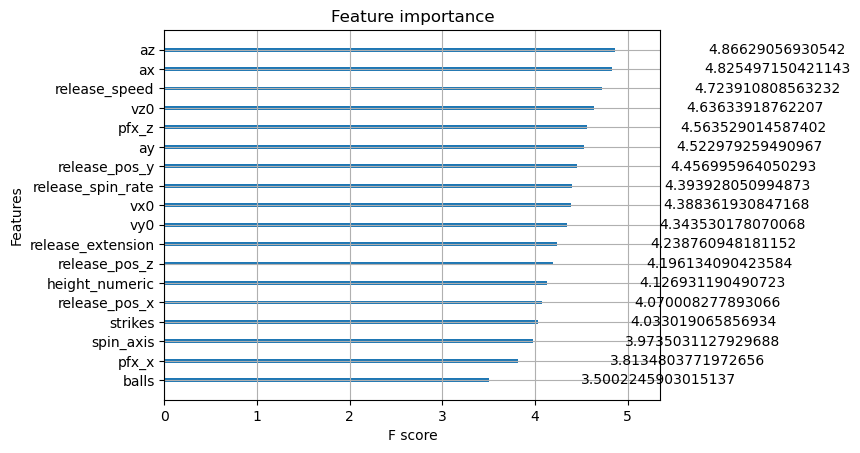

In [ ]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

## Testing Data Set Predictions

In [ ]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [ ]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [ ]:
y_pred = final_model.predict(predictions)

In [ ]:
testing_identifiers['xswing'] = y_pred

C:\Users\clayton.thompson\AppData\Local\Temp\ipykernel_31832\3915381827.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_identifiers['xld'] = y_pred


In [ ]:
testing_identifiers.head()

,pitch_id_raw,xld
0,663364_455139_617228_4_75_10,0.353429
1,663364_455139_617228_3_75_10,0.190372
2,663364_455139_617228_2_75_10,0.306920
3,663364_455139_617228_1_75_10,0.258864
5,663364_593428_605347_4_72_10,0.248496


In [ ]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/swing_2022&3_xswing.csv")

# Offspeed Model 

In [ ]:
off = offspeed_data.drop(['description', 'events', 'game_pk', 'game_date', 'des', 'pitch_type_dict',
                     'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'game_type', 'home_team',
                     'away_team', 'type', 'bb_type', 'inning_topbot', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated',
                     'hit_distance_sc', 'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle',
                     'woba_value', 'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score',
                     'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 'post_fld_score',
                      'if_fielding_alignment', 'of_fielding_alignment', 'delta_home_win_exp', 'delta_run_exp',
                      'player_name', 'hit_location', 'umpire', 'sv_id', 'spin_dir', 
                      'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 
                      'fielder_9', 'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 'pitch_number',  
                      'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
                      #removed these columns because of collinearity
                      'release_pos_z',  'effective_speed', 'release_pos_y', 'vy0', 'vx0', 'ax', 'release_extension', 'spin_axis', 'release_spin_rate',
                      'pfx_z', 'ay', 'p_throws', 'az', 'avg_velo', 'avg_hmov', 'avg_vmov', 'pfx_x', 'Unnamed: 0', 'release_pos_x', 'balls', 
                        'total_movement', 'vmov_diff', 'hmov_diff', 'velo_diff', 'vz0', 'release_speed'
                      #'release_spin_rate', 'p_throws', 'spin_axis', 'zone',
                      #removed these columns because they are not useful
                      ], axis=1).copy()

NameError: name 'offspeed_data' is not defined

In [ ]:
x2 = off.drop(['is_strike'], axis=1).copy()
y2 = off['is_strike'].copy()

In [ ]:

len(x2)

152322

In [ ]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x2, y2, test_size=0.2, random_state=42) # split data

In [ ]:
dtrain1 = xgb.DMatrix(x_train1, label=y_train1)
dtest1 = xgb.DMatrix(x_test1, label=y_test1)

params1 = {
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1
}

# Initial Model
model2 = xgb.train(params1, dtrain1)

In [ ]:
print(f"Unique labels in y_test1: {np.unique(y_test1)}")
print(f"Unique labels in y_train1: {np.unique(y_train1)}")


Unique labels in y_test1: [0 1]
Unique labels in y_train1: [0 1]


In [ ]:
# Generate predictions
y_pred1 = model2.predict(dtest1)
y_pred_binary1 = [1 if p >= 0.5 else 0 for p in y_pred1]

# Calculate Accuracy
accuracy = accuracy_score(y_test1, y_pred_binary1)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test1, y_pred1)
print(f"Log Loss: {logloss}")

Accuracy: 0.9336287543082226
Log Loss: 0.1557187611740709


In [ ]:
#Use an objective function to find the best parameters
def objectives(trial):
    dtrain1 = xgb.DMatrix(x_train1, label=y_train1)
    dtest1 = xgb.DMatrix(x_test1, label=y_test1)
    
    param1 = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
    }

    model2 = xgb.train(param1, dtrain1)
    y_pred1= model2.predict(dtest1)
    y_pred_binary1 = [1 if p >= 0.5 else 0 for p in y_pred1]
    accuracy = accuracy_score(y_test1, y_pred_binary1)
    return accuracy

In [ ]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objectives, n_trials=100)

[I 2023-10-28 15:09:36,123] A new study created in memory with name: no-name-d34c4ef7-2ce4-4779-a65c-e2be8cfab39c
[I 2023-10-28 15:09:36,414] Trial 0 finished with value: 0.9337928770720499 and parameters: {'max_depth': 5, 'eta': 0.24345509256003714, 'subsample': 0.6802305315736025, 'colsample_bytree': 0.9044944080938069}. Best is trial 0 with value: 0.9337928770720499.
[I 2023-10-28 15:09:36,685] Trial 1 finished with value: 0.9235844411619891 and parameters: {'max_depth': 6, 'eta': 0.04993409492472433, 'subsample': 0.7491510300973008, 'colsample_bytree': 0.7023858021577918}. Best is trial 0 with value: 0.9337928770720499.
[I 2023-10-28 15:09:36,984] Trial 2 finished with value: 0.9369440341375349 and parameters: {'max_depth': 9, 'eta': 0.17788292482168488, 'subsample': 0.7205857498903679, 'colsample_bytree': 0.706986723560932}. Best is trial 2 with value: 0.9369440341375349.
[I 2023-10-28 15:09:37,230] Trial 3 finished with value: 0.931068439192516 and parameters: {'max_depth': 3, 'e

In [ ]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.9411784014442803
Best hyperparameters: {'max_depth': 9, 'eta': 0.29086504518827216, 'subsample': 0.609950626814756, 'colsample_bytree': 0.8105463899683927}


In [ ]:
# Ensure trial is the best trial from the study
best_trial1 = study.best_trial

# Set parameters
final_parameters1 = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
}

# Prepare the data
dtrain = xgb.DMatrix(x_train1, label=y_train1)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model1 = xgb.train(final_parameters1, dtrain1)

In [ ]:
# Generate predictions
y_pred1 = final_model1.predict(dtest1)
y_pred_binary1 = [1 if p >= 0.5 else 0 for p in y_pred1]

# Calculate Accuracy
accuracy = accuracy_score(y_test1, y_pred_binary1)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test1, y_pred1)
print(f"Log Loss: {logloss}")

Accuracy: 0.9393730510421795
Log Loss: 0.15511361543363011


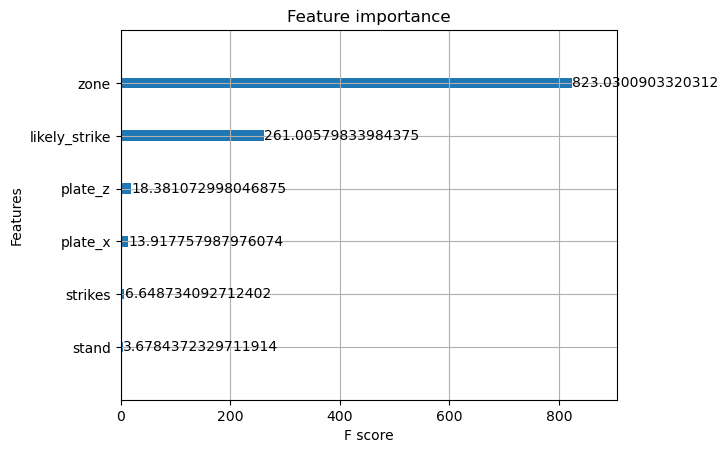

In [ ]:
importance1 = final_model1.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance1)
plt.show()

# Predict 2023 data

In [ ]:
heaters_2023 = df[df['pitch_type_dict'] == 1].copy()
offspeed_2023 = df[df['pitch_type_dict'] == 2].copy()

In [ ]:
# Select only the features you used for training the models
features = ['zone', 'stand', 'strikes', 'plate_x', 'plate_z',  'likely_strike']  # Replace these with your actual features

# Convert DataFrame to DMatrix
dmatrix_heaters_2023 = xgb.DMatrix(heaters_2023[features])
dmatrix_offspeed_2023 = xgb.DMatrix(offspeed_2023[features])

# Make predictions
heaters_2023['prediction'] = final_model.predict(dmatrix_heaters_2023)
offspeed_2023['prediction'] = final_model1.predict(dmatrix_offspeed_2023)

In [ ]:
complete = pd.concat([heaters_2023, offspeed_2023], axis=0)
complete['probability_added'] = 0

In [ ]:
# Correct the conditions and assignment for 'probability_added'
condition1 = (complete['likely_strike'] == 0) & (complete['is_strike'] == 1)
complete.loc[condition1, 'probability_added'] = 1 - complete.loc[condition1, 'prediction']

condition2 = (complete['likely_strike'] == 1) & (complete['is_strike'] == 0)
complete.loc[condition2, 'probability_added'] = -0 + complete.loc[condition2, 'prediction']


In [ ]:
len(condition2)

362561

In [ ]:
players = pd.read_csv('players_query.csv')

In [ ]:
completed = complete.merge(players, left_on='fielder_2', right_on='mlb_id', how='left')

In [ ]:
strike_probs = completed.loc[completed['probability_added'] != 0].copy()

In [ ]:
strike_probs.head()

,half_inning,Unnamed: 1,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,...,deltaRE,is_strike,pitch_type_dict,likely_strike,prediction,probability_added,Unnamed: 0,mlb_id,mlb_name,team_name
1,716352_1_Bot,8,SI,2023-10-01,93.5,-2.60,5.68,"King, Michael",677951,650633,...,-0.028510,1,1.0,0,0.781290,0.218710,4412,669224,Austin Wells,yankees
11,716352_2_Bot,46,FF,2023-10-01,93.5,-2.82,5.71,"King, Michael",669004,650633,...,-0.038179,1,1.0,0,0.495411,0.504589,4412,669224,Austin Wells,yankees
28,716352_4_Bot,111,FF,2023-10-01,92.9,-2.66,5.89,"King, Michael",669004,650633,...,-0.038179,1,1.0,0,0.782323,0.217677,4412,669224,Austin Wells,yankees
37,716352_4_Bot,87,SI,2023-10-01,92.2,-2.76,5.67,"King, Michael",672580,650633,...,-0.111258,1,1.0,0,0.813712,0.186288,4412,669224,Austin Wells,yankees
39,716352_4_Top,115,SI,2023-10-01,90.1,-1.27,6.14,"Greinke, Zack",643396,425844,...,-0.043952,1,1.0,0,0.584764,0.415236,1898,521692,Salvador Perez,royals


### Catcher Evaluation

In [ ]:
# Set the display options to show all rows
pd.set_option('display.max_rows', None)

result = strike_probs.groupby('mlb_name').agg({'probability_added': 'sum'}).sort_values(by='probability_added', ascending=False)
print(result)

# Reset the display options to default
pd.reset_option('display.max_rows')

                       probability_added
mlb_name                                
Jonah Heim                    369.409200
William Contreras             357.175406
Francisco Alvarez             343.816237
Cal Raleigh                   325.117514
Patrick Bailey                322.223661
J.T. Realmuto                 306.765881
Adley Rutschman               304.310884
Keibert Ruiz                  300.757002
Elias Diaz                    291.464170
Will Smith                    289.637044
Shea Langeliers               285.841658
Sean Murphy                   285.280986
Alejandro Kirk                274.881437
Jake Rogers                   270.437452
Connor Wong                   263.304882
Nick Fortes                   261.444752
Austin Hedges                 252.923828
Yasmani Grandal               249.119006
Christian Vazquez             245.539206
Willson Contreras             243.042565
Gabriel Moreno                240.534485
Kyle Higashioka               236.375578
Martin Maldonado

In [ ]:
strike_probs['framing_runs'] = (strike_probs['deltaRE'] * -1) * strike_probs['probability_added'].abs()

## Initial Situational Framing Runs Leaderboard

In [ ]:
# Set the display options to show all rows
pd.set_option('display.max_rows', None)

result = strike_probs.groupby('mlb_name').agg({'framing_runs': 'sum'}).sort_values(by='framing_runs', ascending=False)
print(result)

# Reset the display options to default
pd.reset_option('display.max_rows')

                       framing_runs
mlb_name                           
Jonah Heim                28.298897
William Contreras         27.314465
Francisco Alvarez         26.280338
Cal Raleigh               24.428360
J.T. Realmuto             23.217440
Will Smith                23.151280
Adley Rutschman           22.850475
Austin Hedges             22.659703
Shea Langeliers           22.651095
Elias Diaz                22.566548
Patrick Bailey            22.507789
Keibert Ruiz              22.178750
Alejandro Kirk            21.671238
Kyle Higashioka           20.388670
Nick Fortes               20.349055
Willson Contreras         20.085103
Sean Murphy               20.071047
Connor Wong               20.061680
Jake Rogers               19.988771
Christian Vazquez         19.943172
Martin Maldonado          19.101232
Yasmani Grandal           18.546439
Gabriel Moreno            18.169561
Yan Gomes                 16.646696
Gary Sanchez              15.508716
Salvador Perez            15

In [ ]:
strike_probs.drop(['Unnamed: 0', 'Unnamed: 1'], axis=1, inplace=True)

In [ ]:
strike_probs.to_csv('strike_probs.csv')

### Get out meaningless strikes that have nothing to do with framing

In [ ]:
likely = strike_probs.query('(prediction < .85)')

In [ ]:
# Set the display options to show all rows
pd.set_option('display.max_rows', None)

result = likely.groupby('mlb_name').agg({'framing_runs': 'sum'}).sort_values(by='framing_runs', ascending=False)
print(result)

                       framing_runs
mlb_name                           
Jonah Heim                27.265644
William Contreras         26.675339
Francisco Alvarez         25.509967
Cal Raleigh               23.705518
Will Smith                22.504385
J.T. Realmuto             22.293919
Adley Rutschman           22.158913
Austin Hedges             22.132027
Patrick Bailey            22.033697
Shea Langeliers           21.670207
Elias Diaz                21.585984
Keibert Ruiz              21.388849
Alejandro Kirk            20.937702
Kyle Higashioka           19.911051
Nick Fortes               19.775314
Sean Murphy               19.402830
Willson Contreras         19.372176
Christian Vazquez         19.285147
Connor Wong               19.231894
Jake Rogers               19.224211
Martin Maldonado          18.579309
Yasmani Grandal           17.983997
Gabriel Moreno            17.519849
Yan Gomes                 16.075565
Gary Sanchez              14.937981
Salvador Perez            14

###  I think that this is the best leaderboard. Filters out the gimme pitches